<a href="https://colab.research.google.com/github/delphi9/Learning/blob/master/pg_from_scratch(pong).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/pg-from-scratch.ipynb#scrollTo=0l9hHvTk6ec8

In [0]:
# !apt-get install python-opengl -y  >/dev/null
# !apt install xvfb -y >/dev/null
# !pip install pyvirtualdisplay >/dev/null
# !pip install piglet >/dev/null
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

In [0]:
!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [0]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

In [0]:
import gym
env = gym.make('Pong-v0')

In [5]:
env.action_space
env.observation_space

Box(210, 160, 3)

In [6]:
# Run a demo of the environment
observation = env.reset()
cumulated_reward = 0

frames = []
for t in range(1000):
#     print(observation)
    frames.append(env.render(mode = 'rgb_array'))
    # very stupid agent, just makes a random action within the allowd action space
    action = env.action_space.sample()
#     print("Action: {}".format(t+1))    
    observation, reward, done, info = env.step(action)
#     print(reward)
    cumulated_reward += reward
    if done:
        print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
        break
print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))

env.close()

Episode finished without success, accumulated reward = -17.0



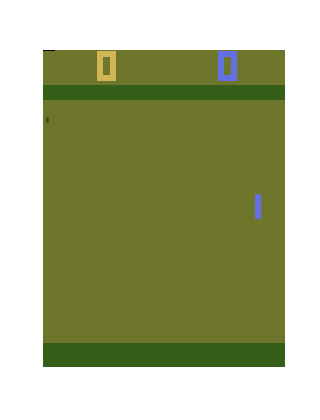
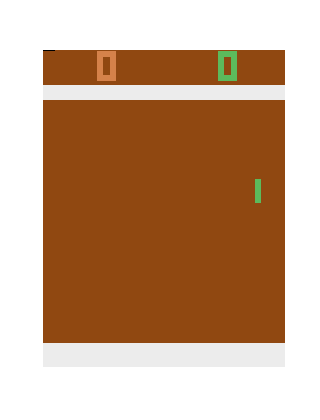
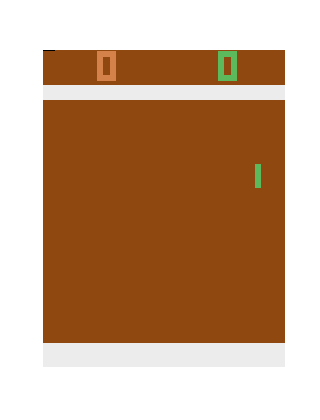
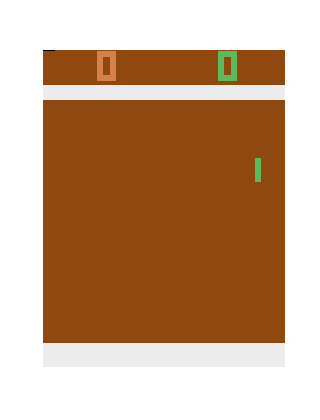
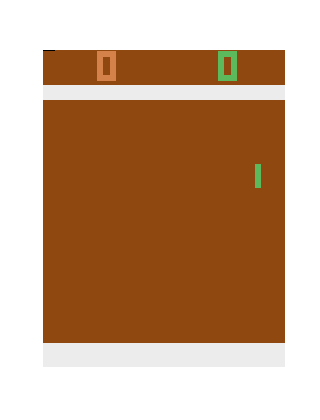
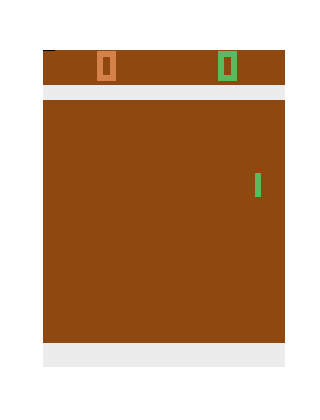
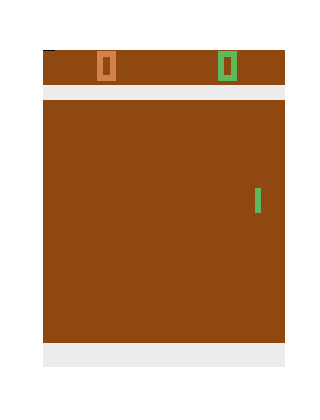
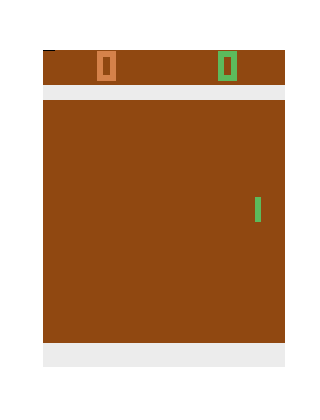
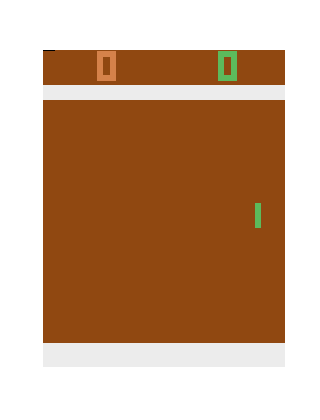
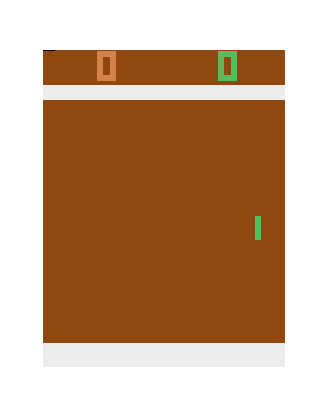
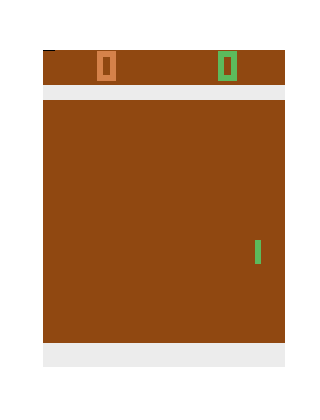
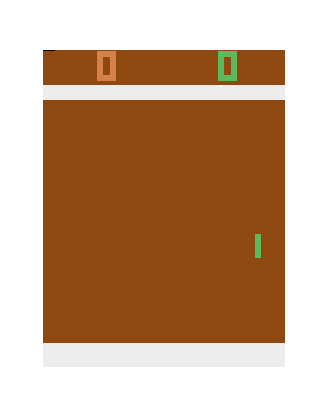
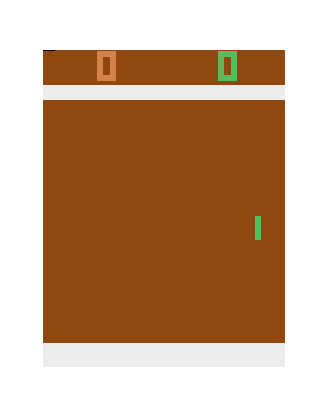
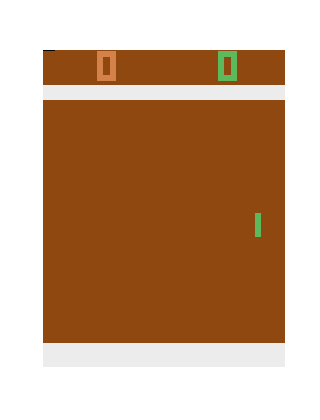
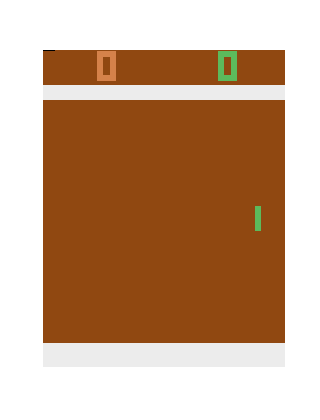
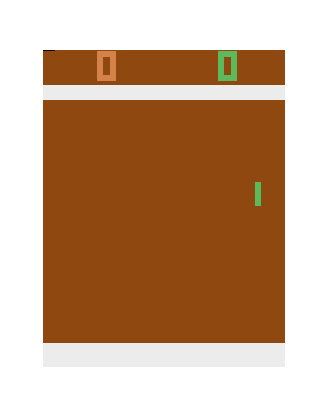
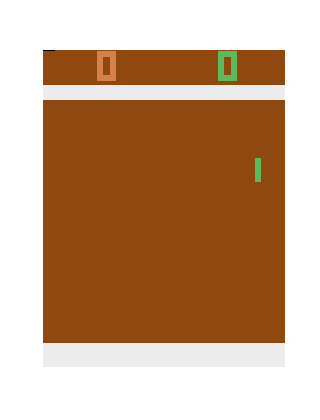
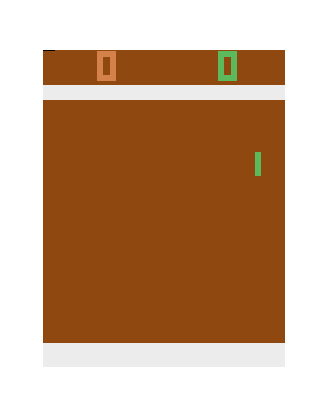
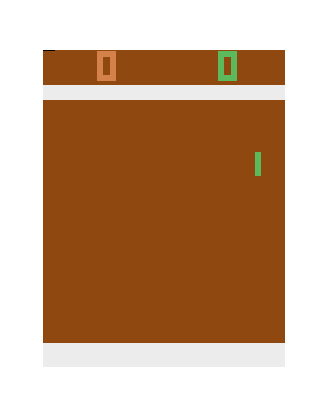
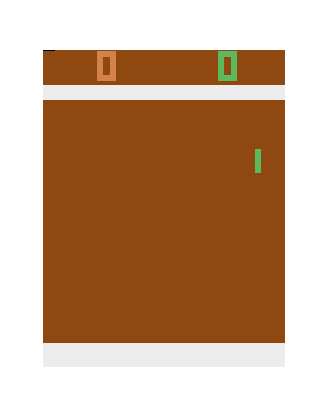
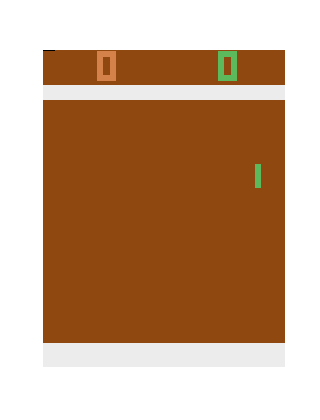
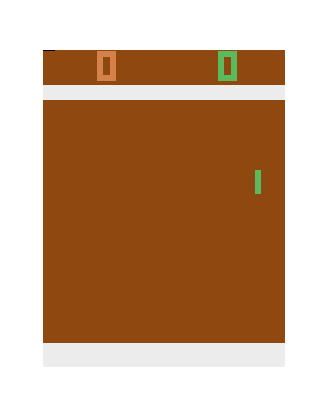
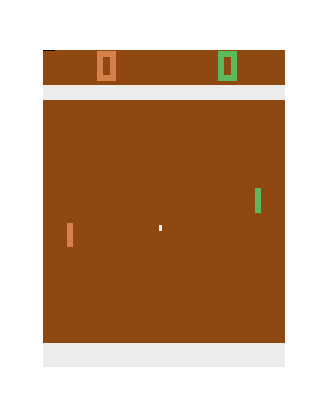
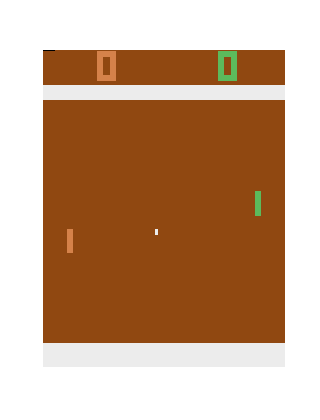
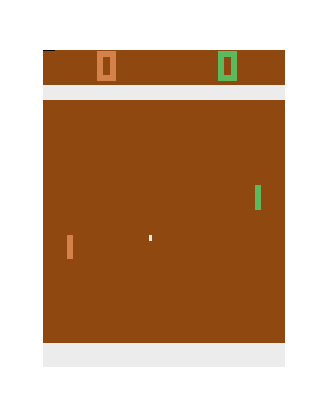
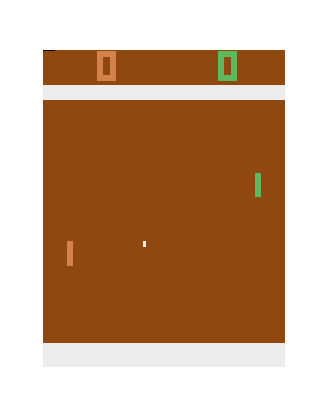
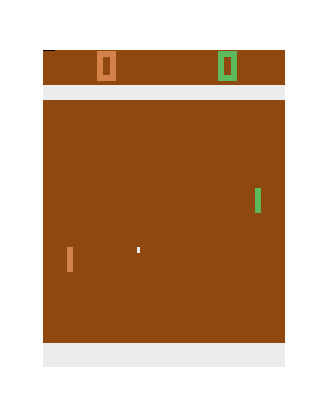
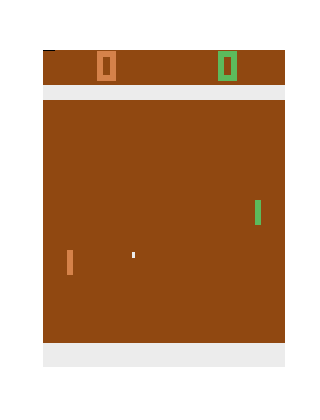
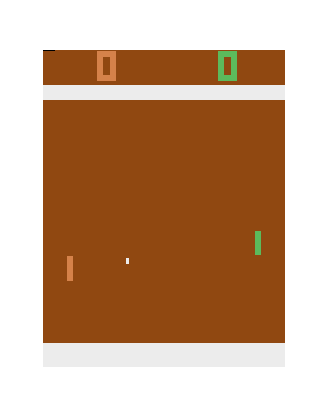
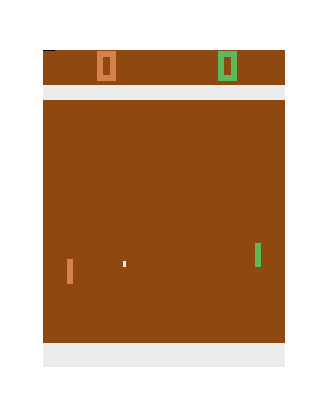
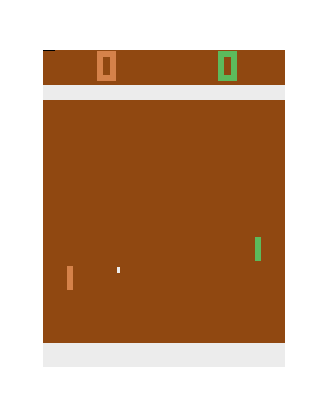
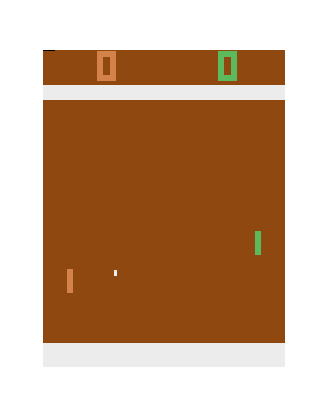
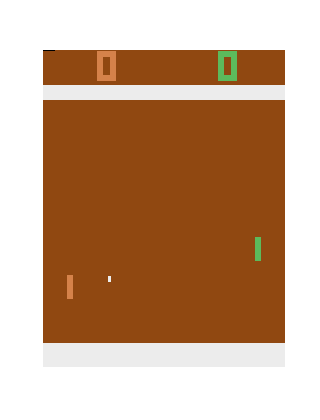
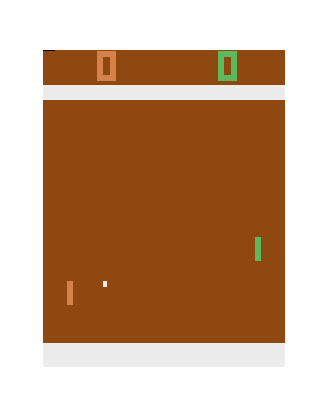
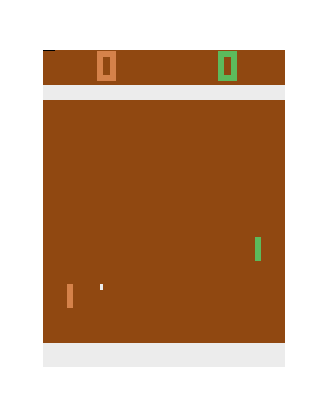
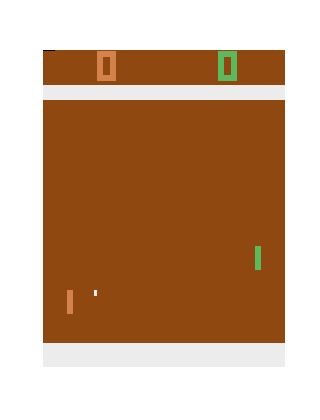
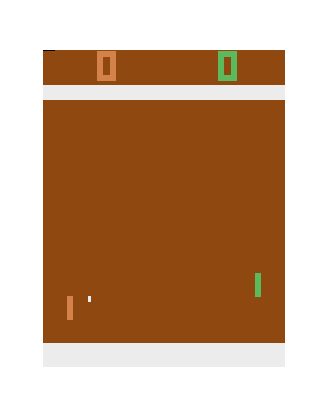
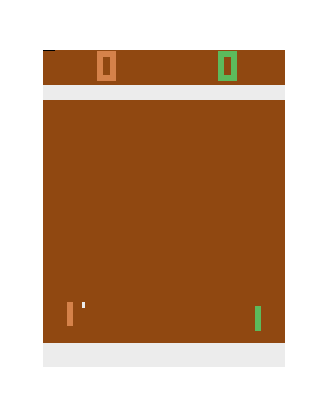
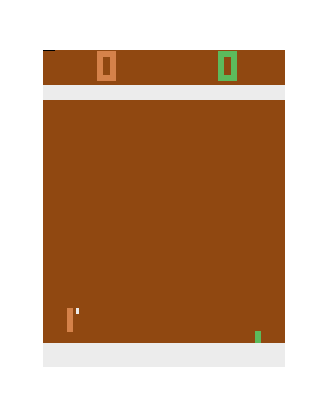
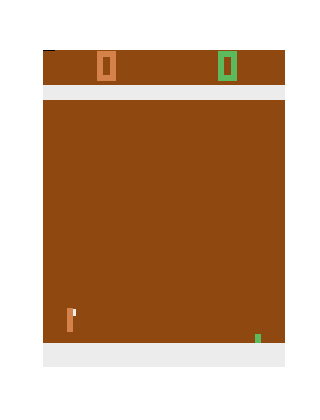
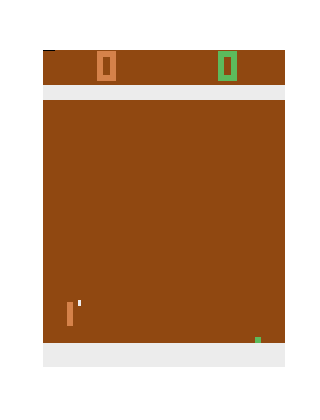
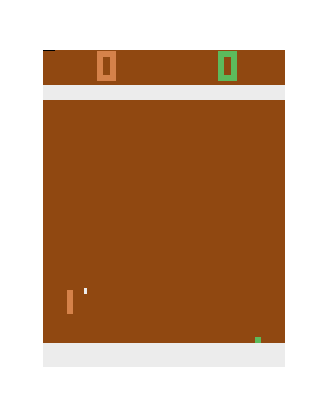
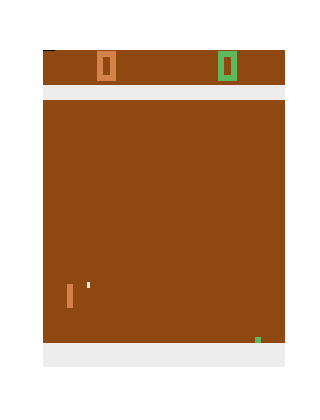
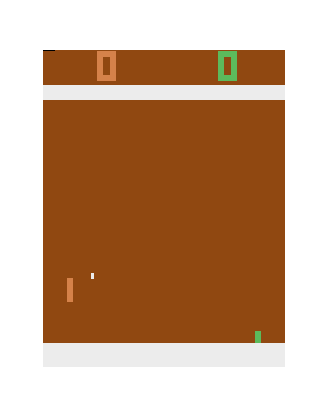
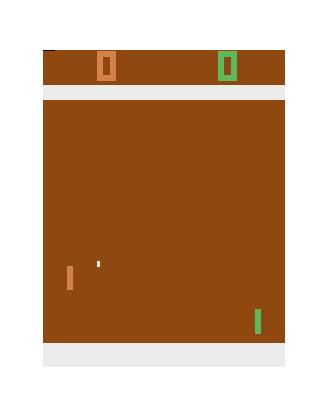
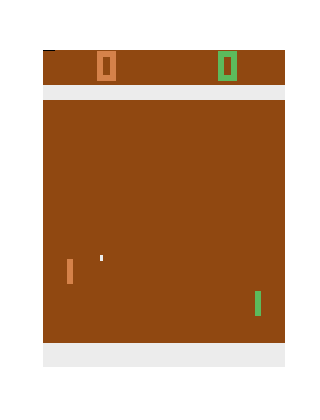
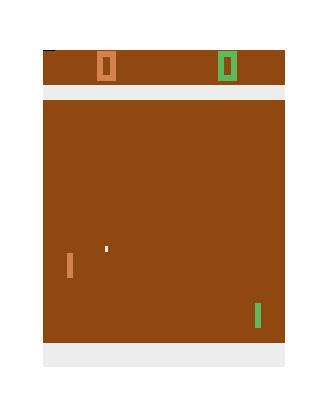
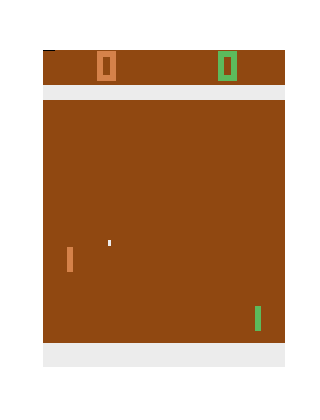
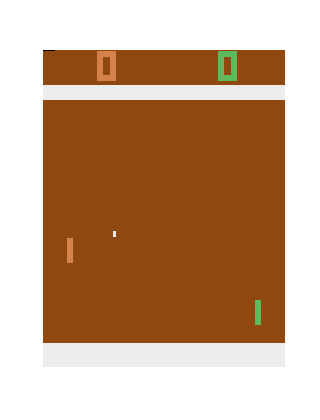
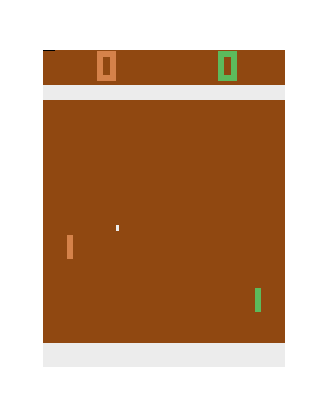
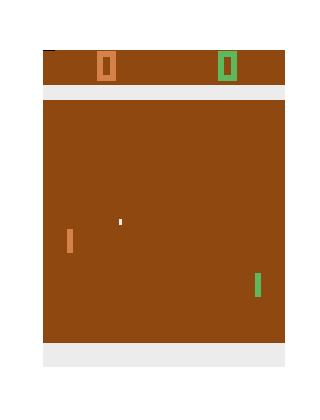
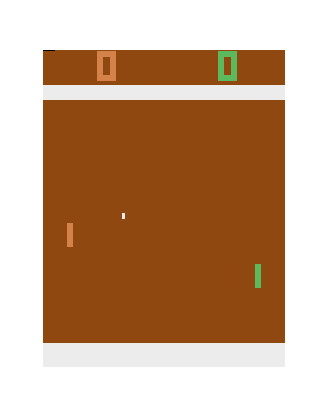
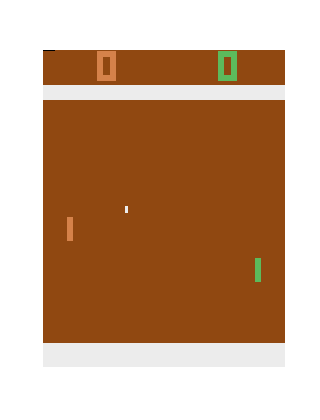
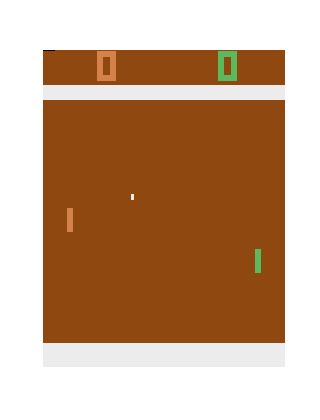
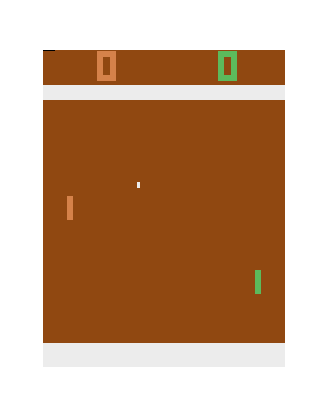
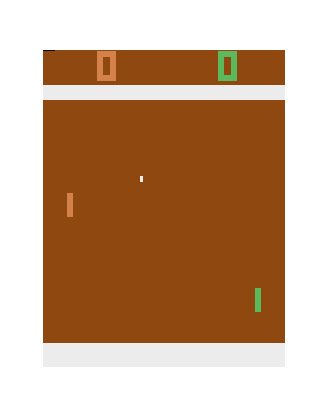
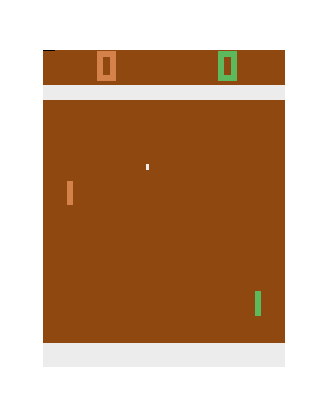
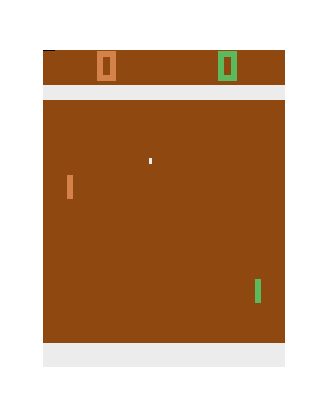
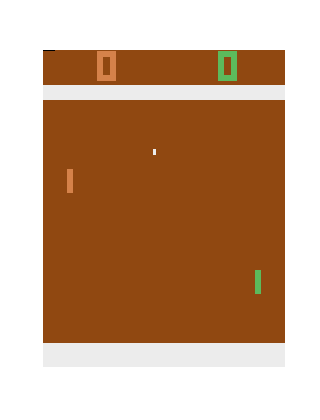
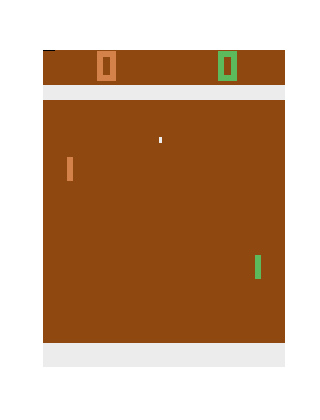
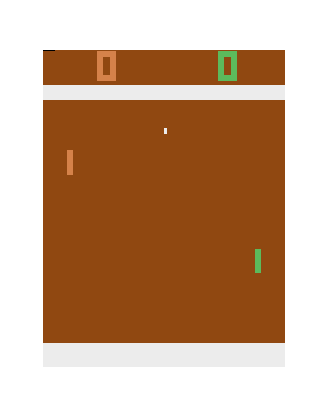
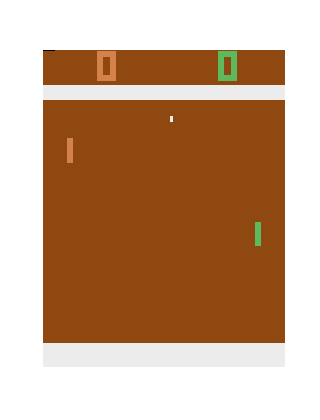
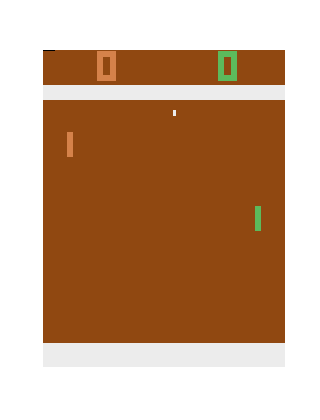
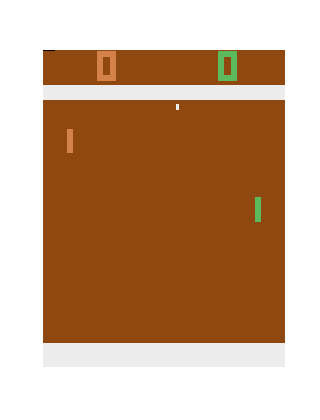
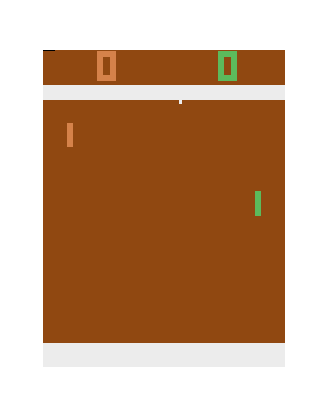
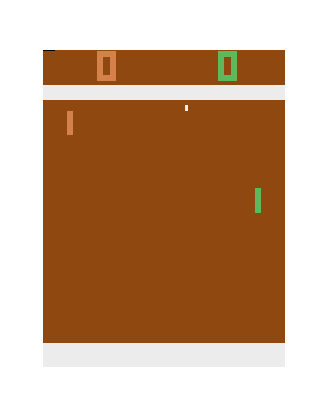
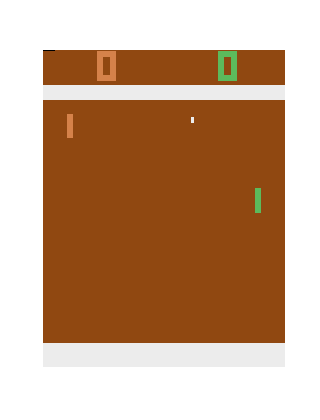
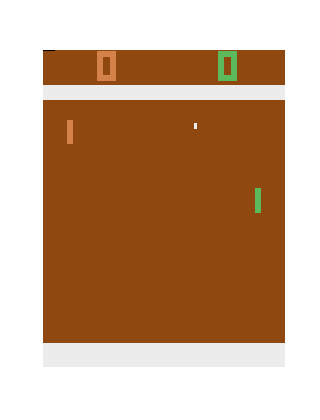
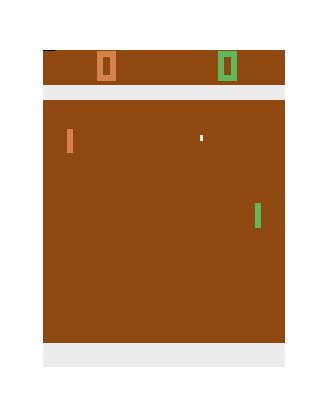
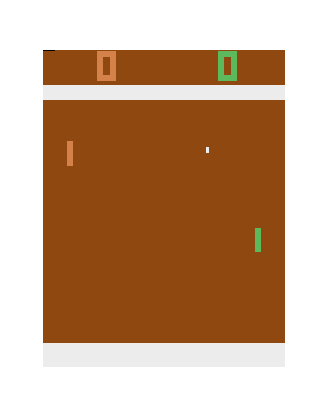
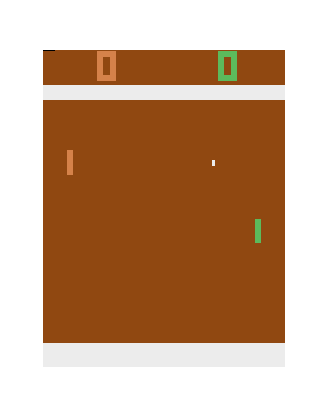
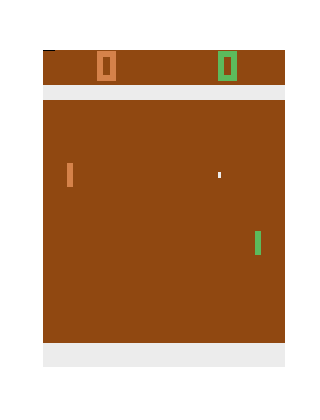
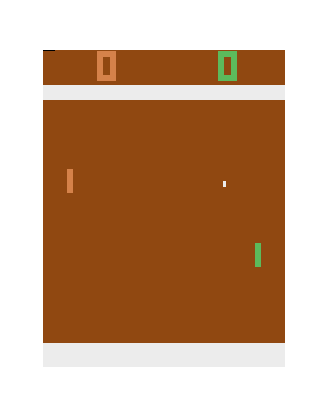
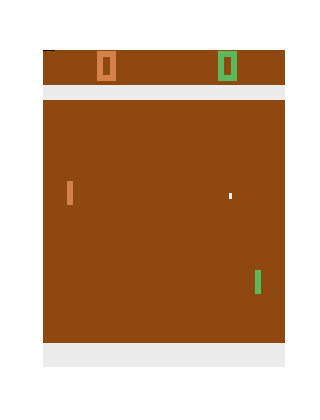
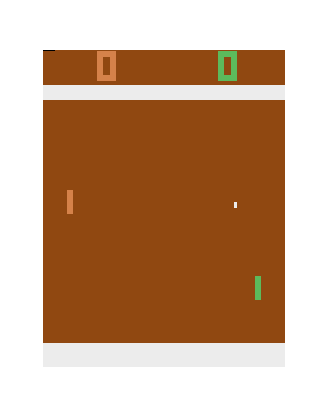
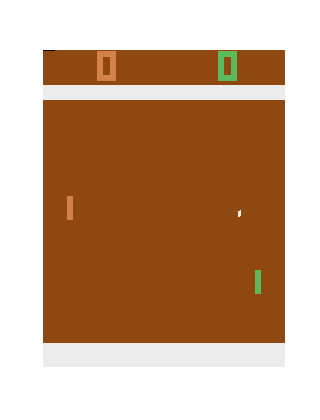
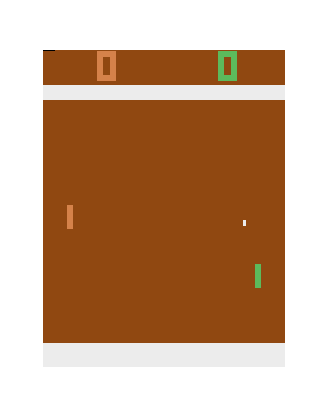
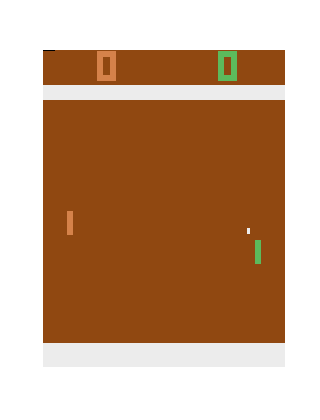
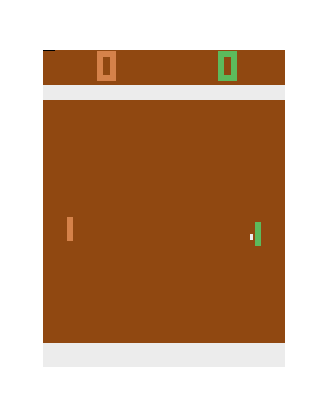
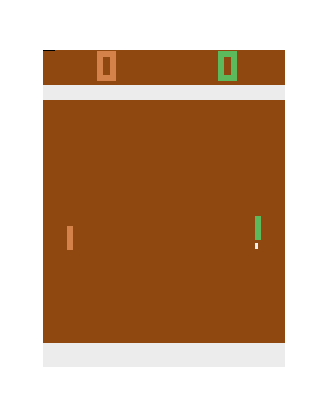
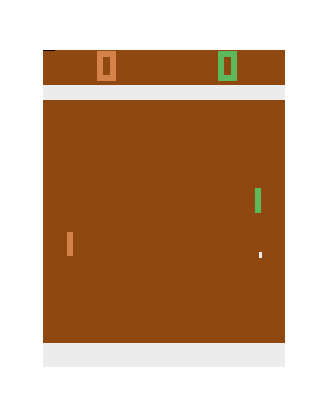
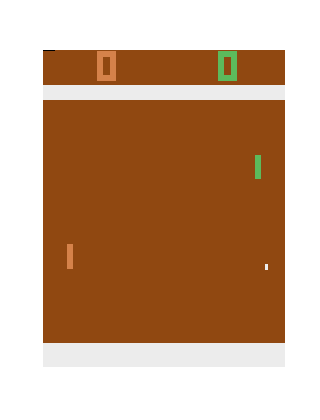
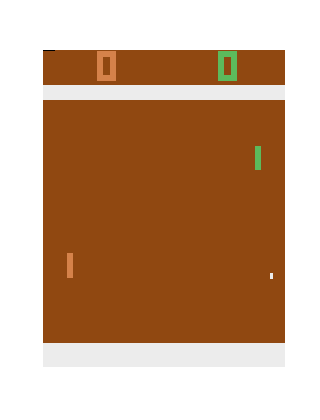
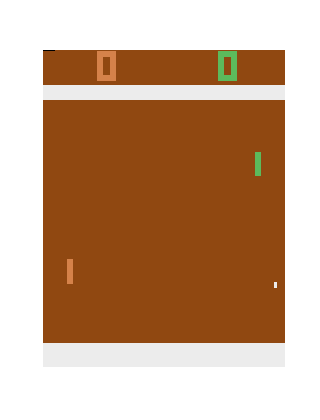
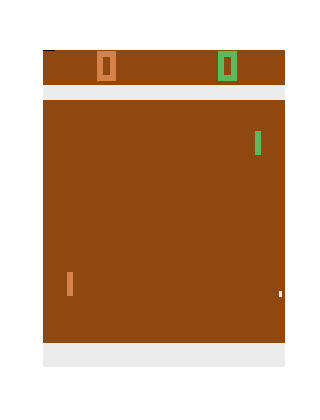
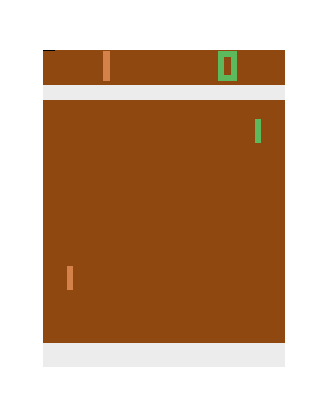
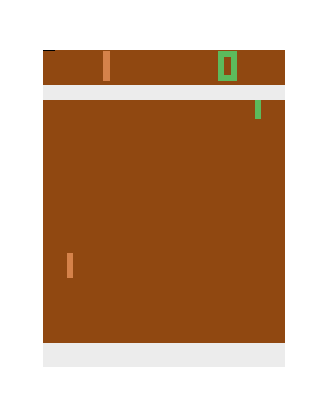
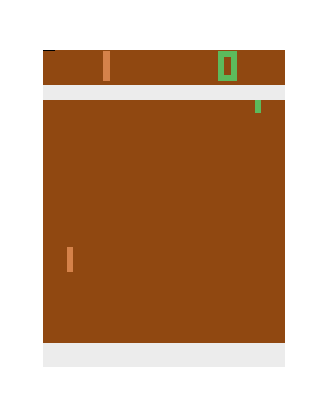
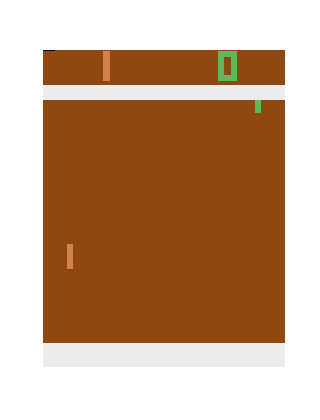
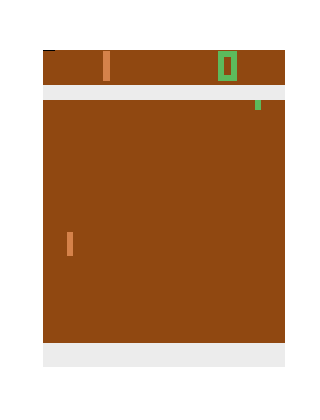
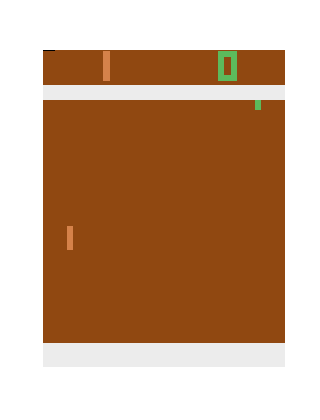
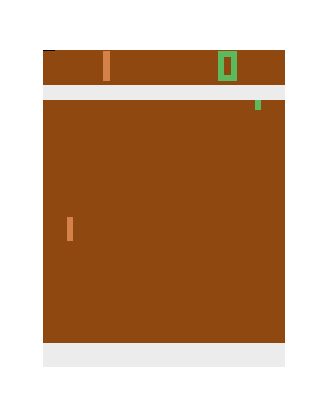
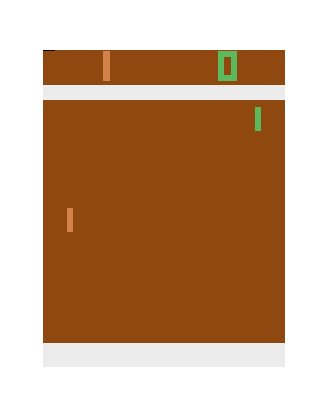
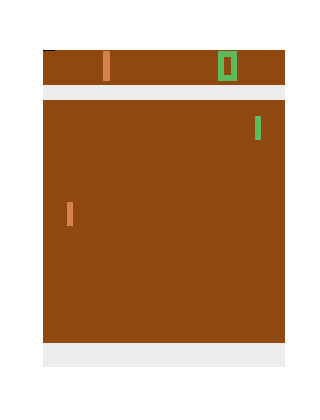
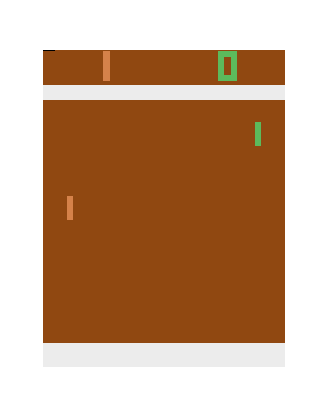
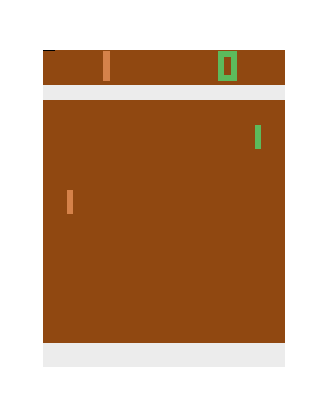
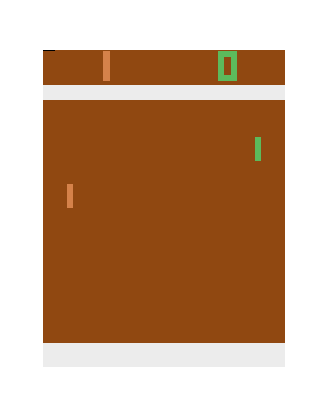
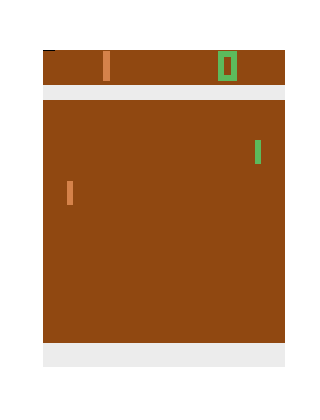
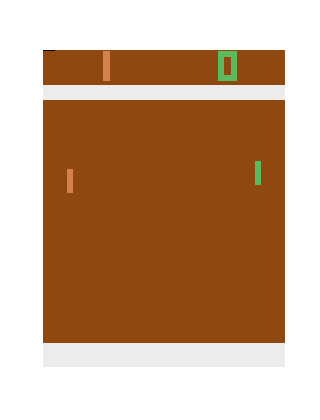
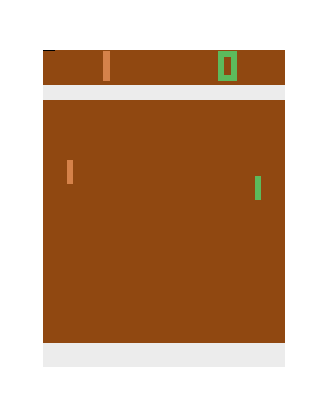
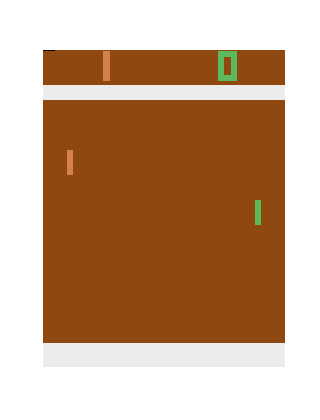
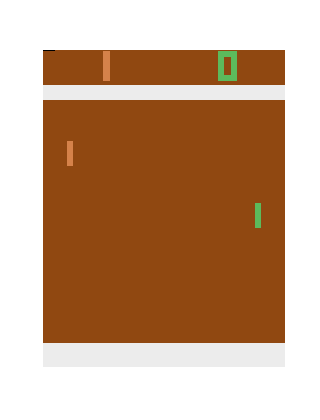
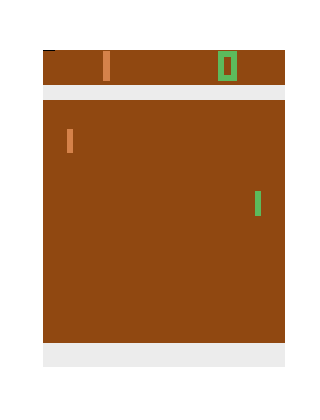
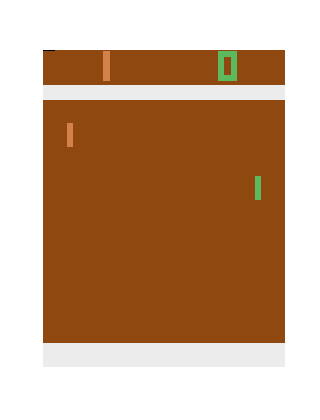
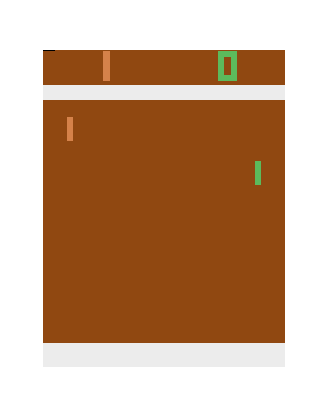
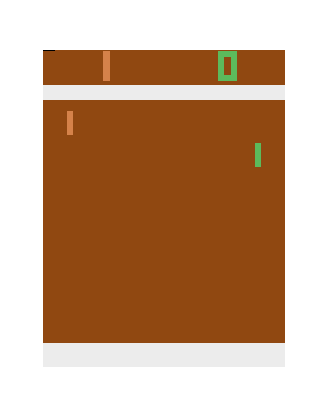
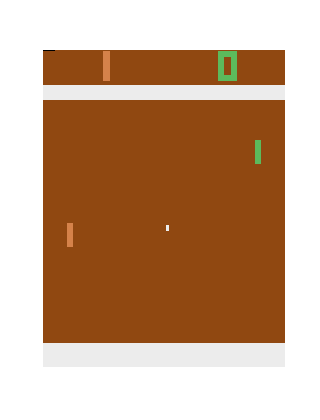
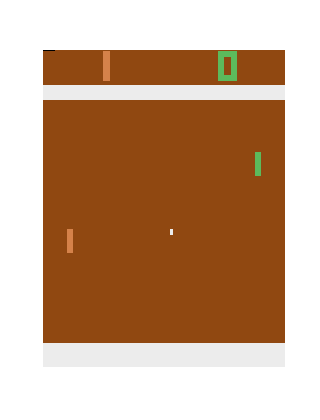
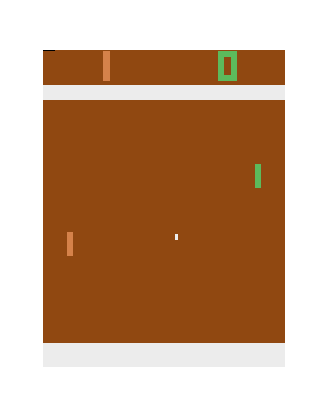
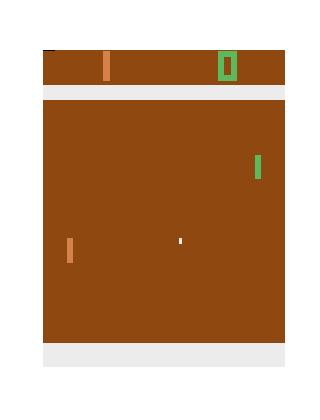
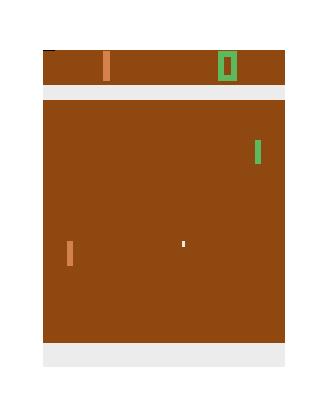
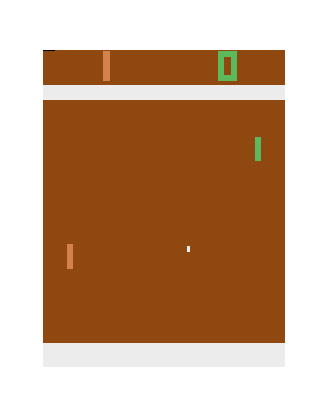
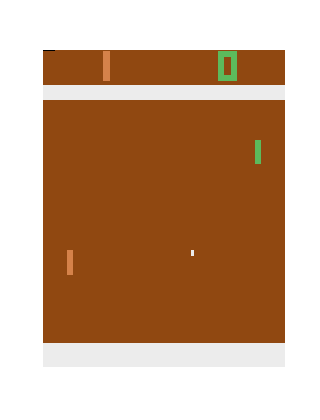
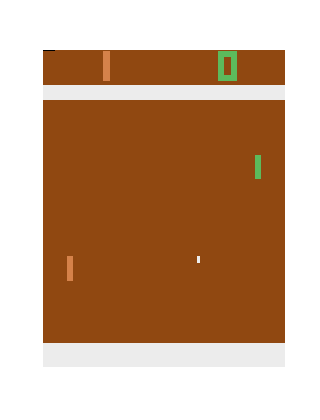
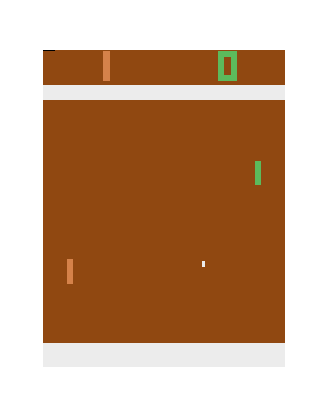
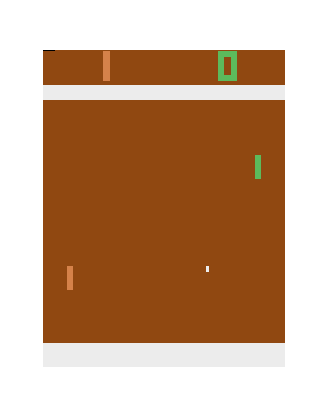
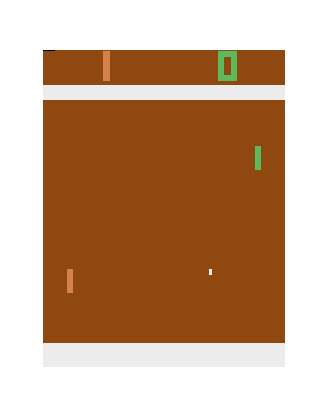
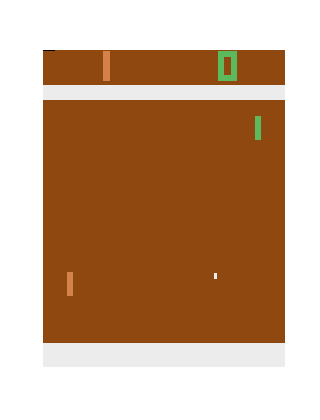
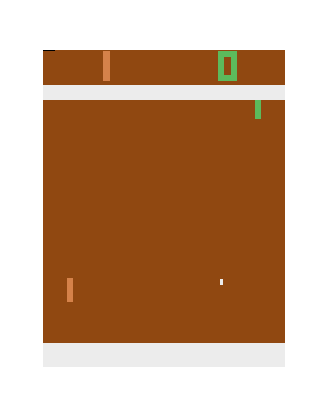
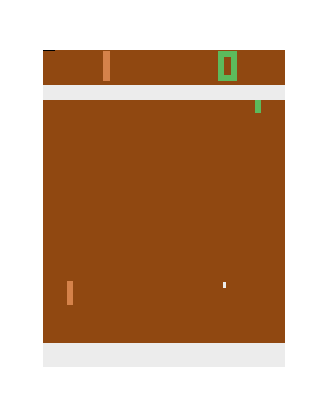
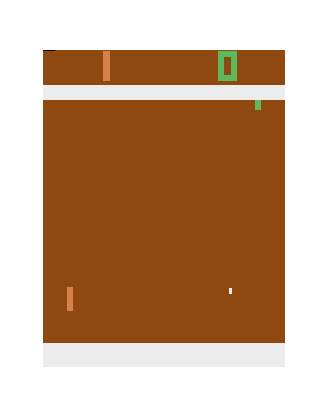
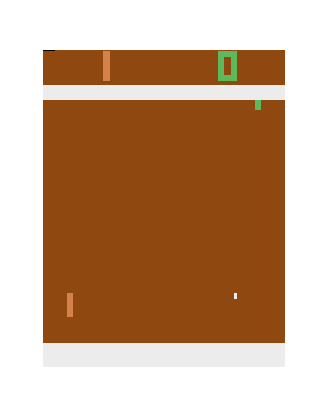
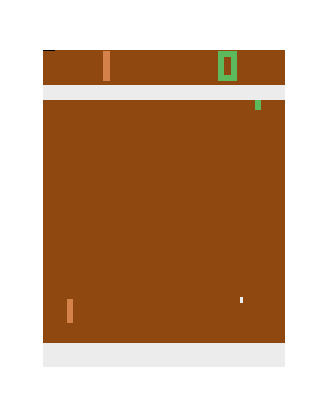
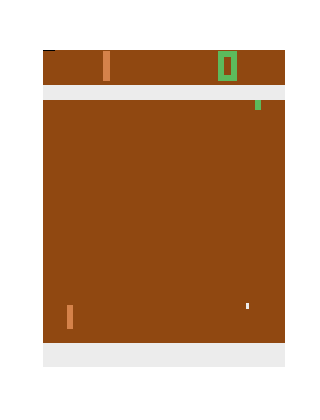
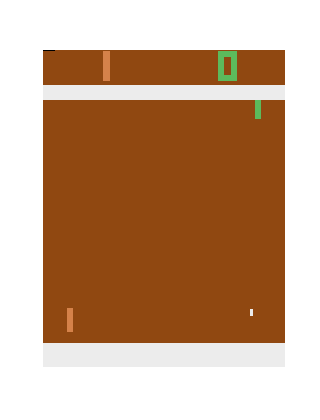
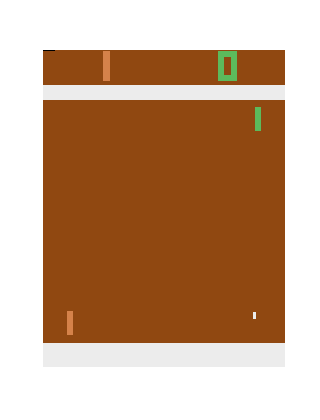
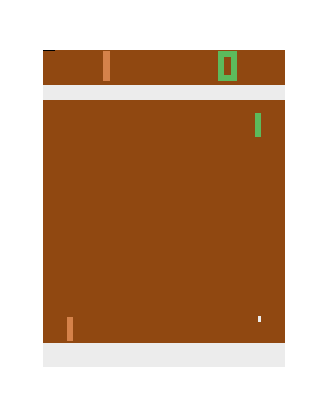
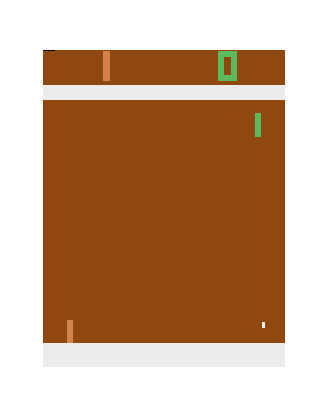
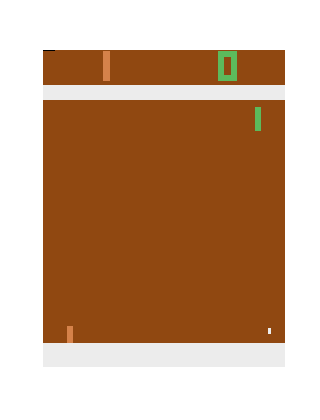
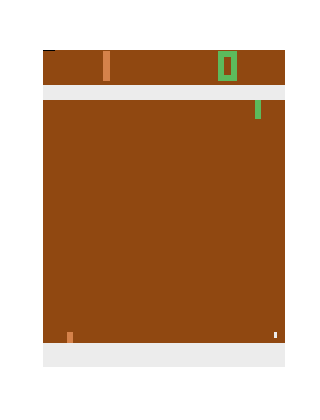
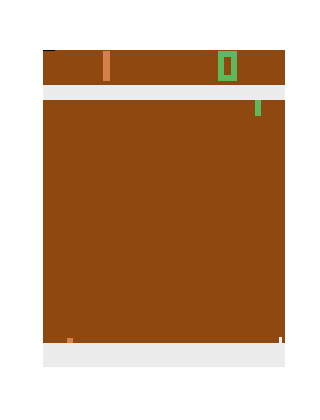
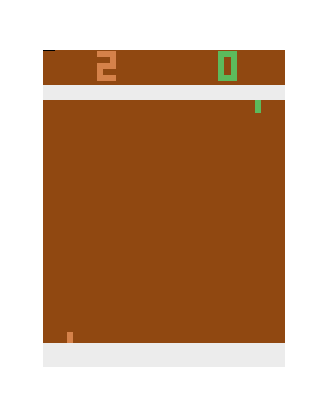
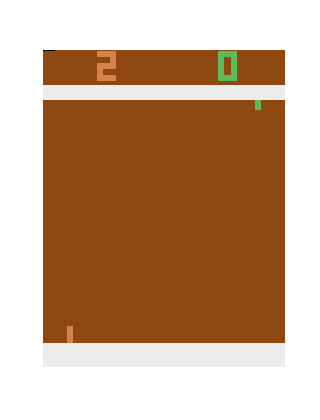
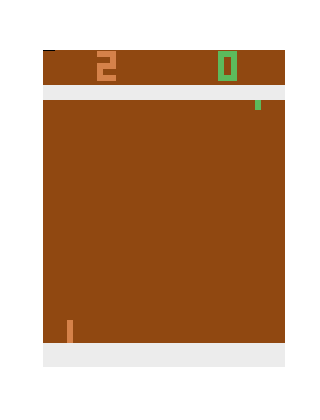
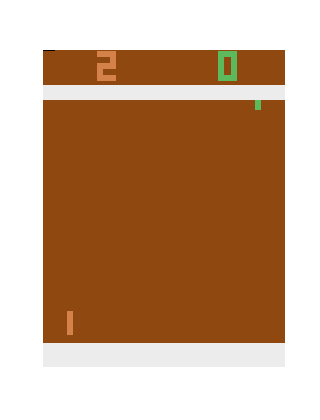
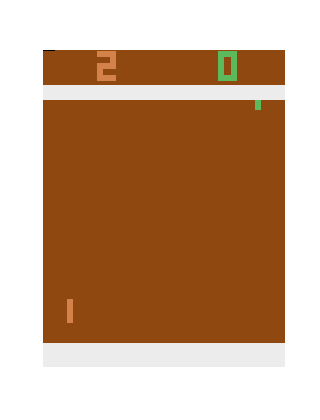
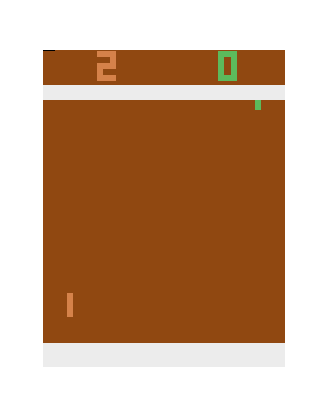
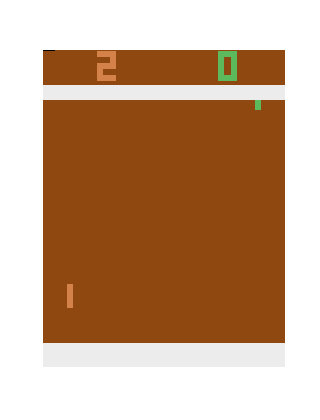
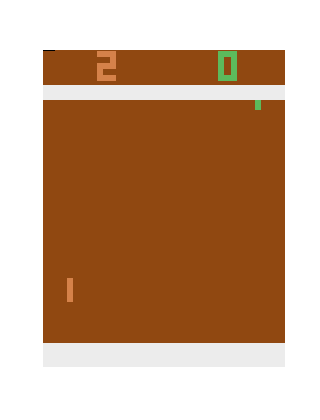
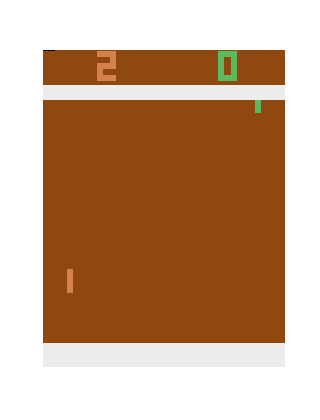
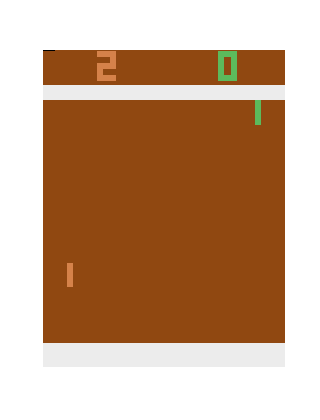
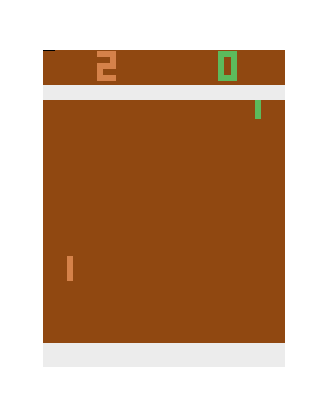
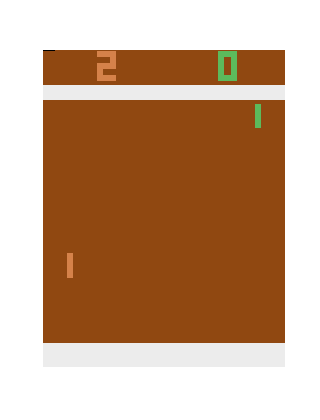
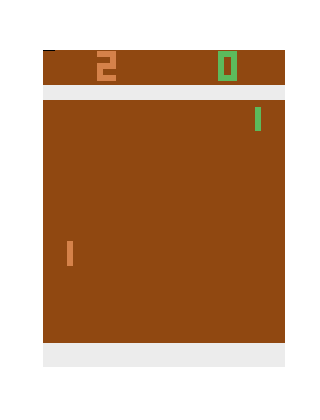
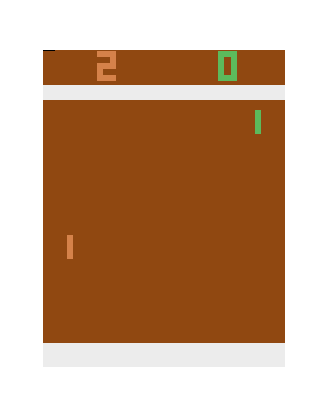
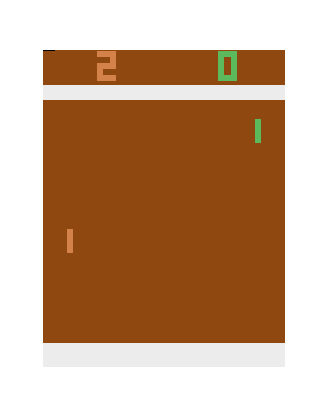
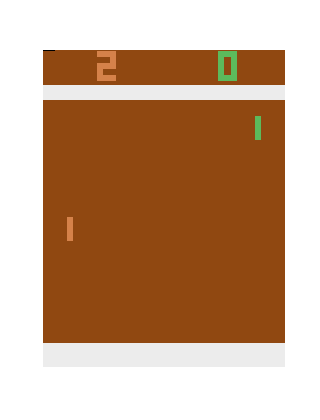
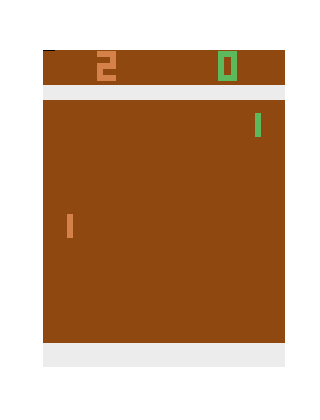
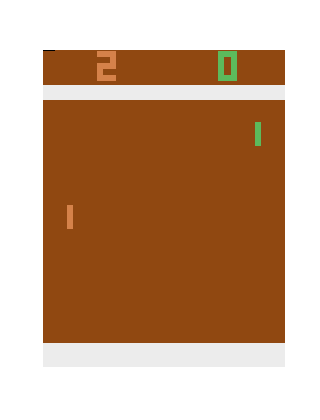
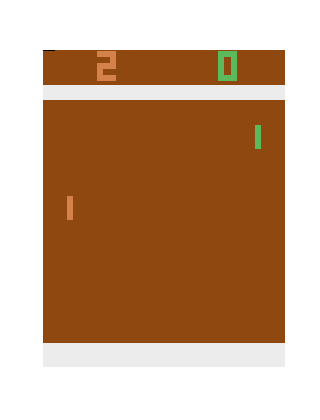
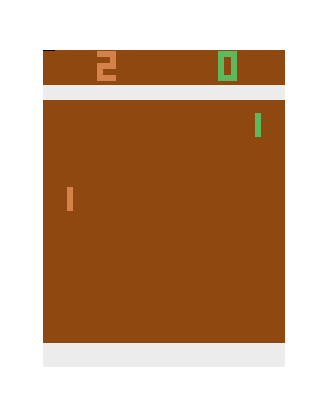
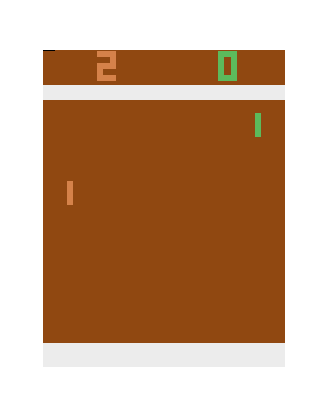
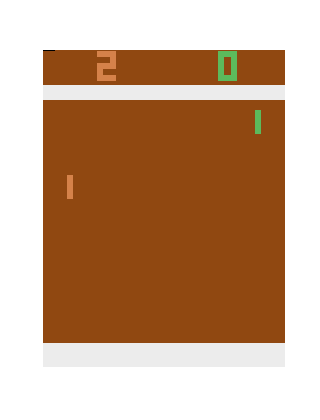
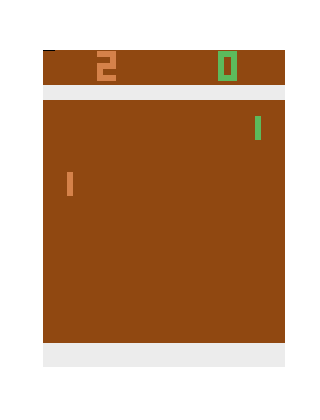
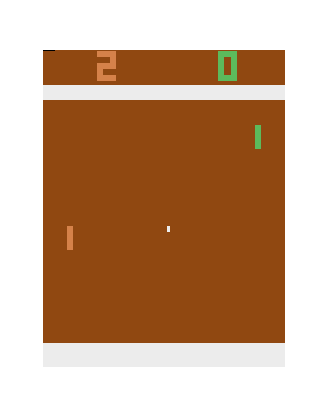
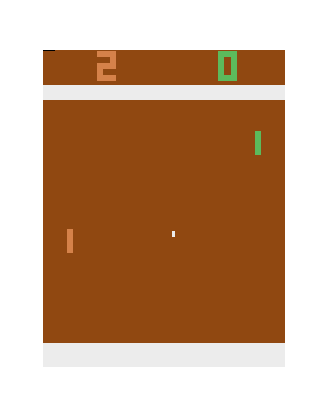
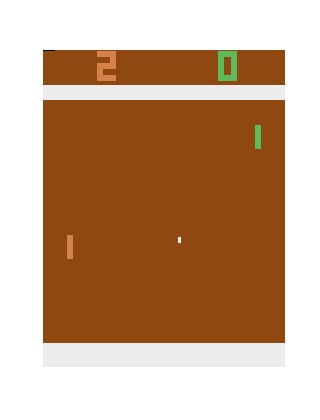
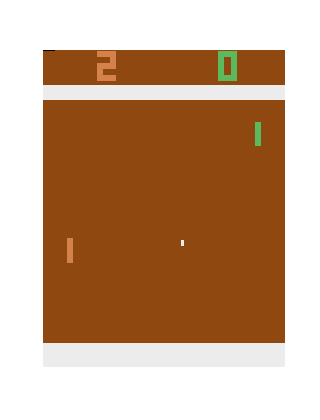
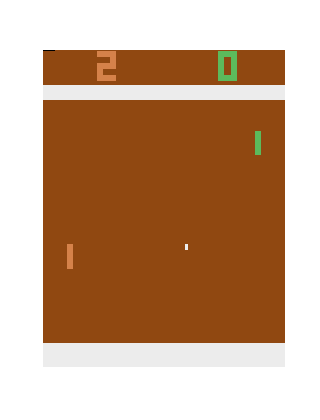
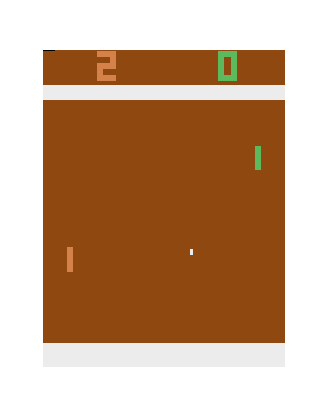
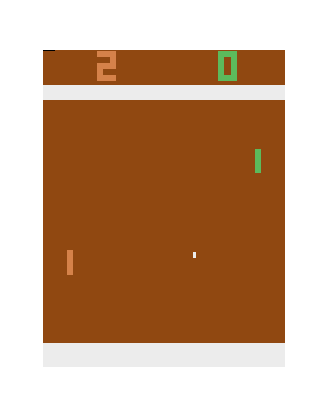
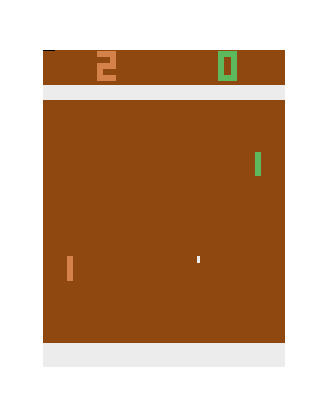
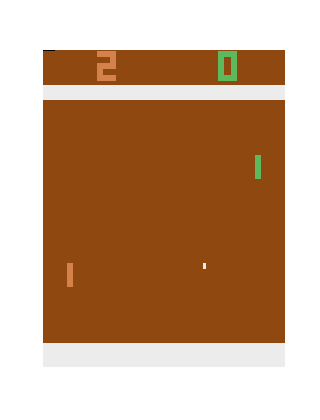
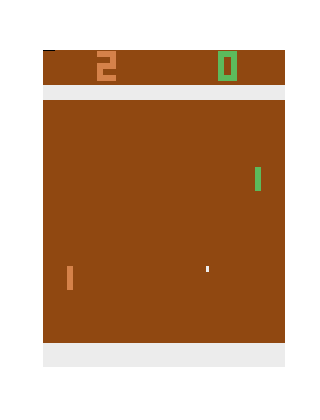
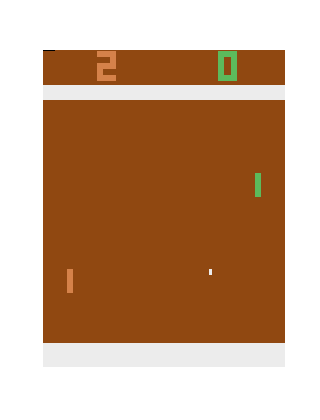
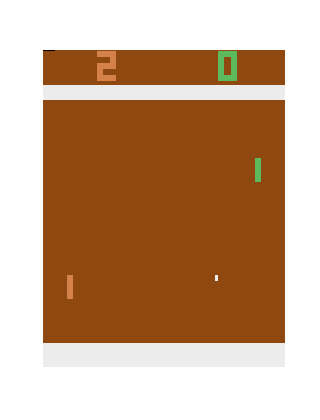
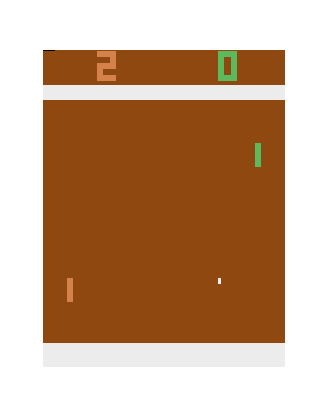
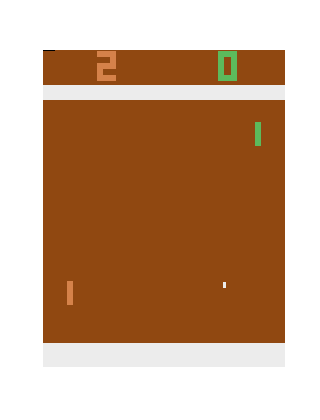
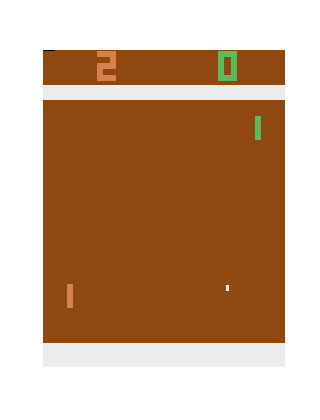
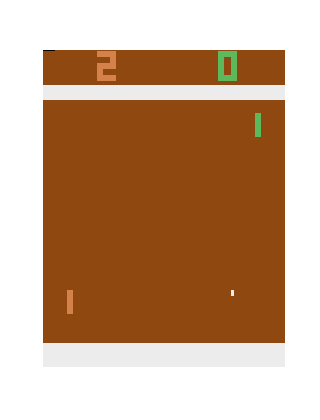
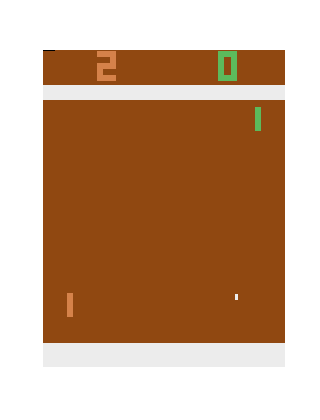
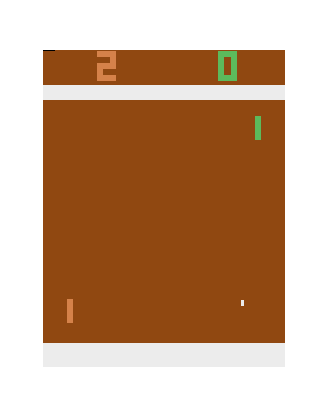
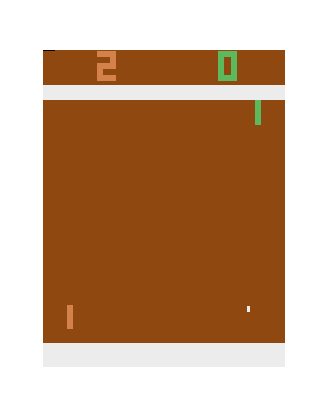
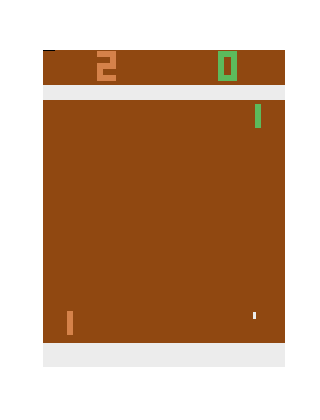
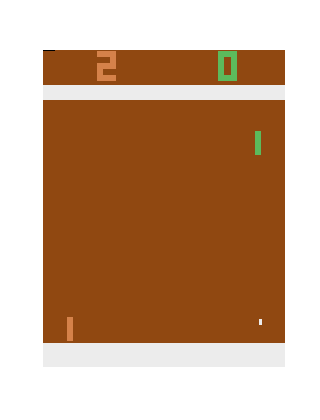
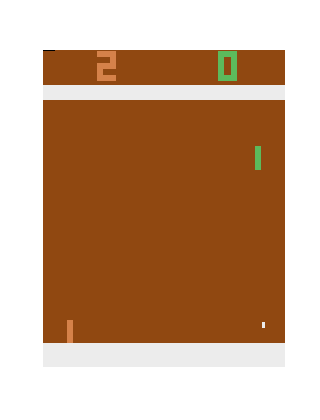
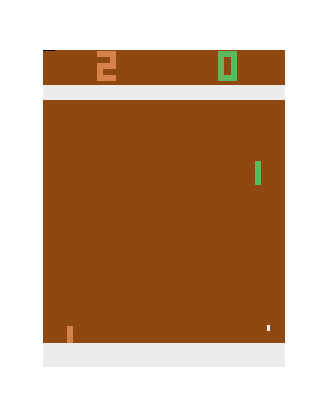
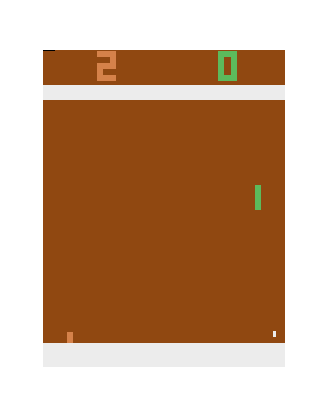
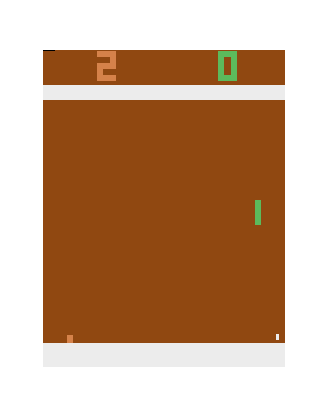
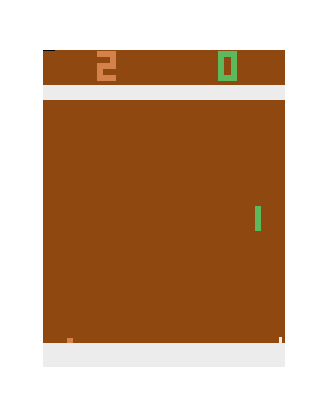
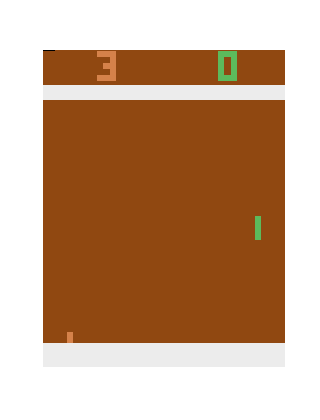
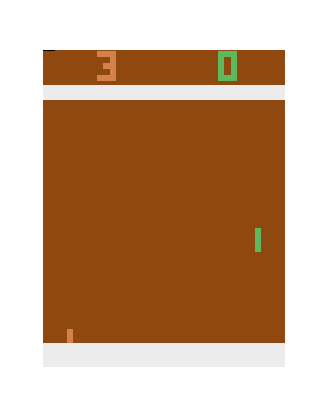
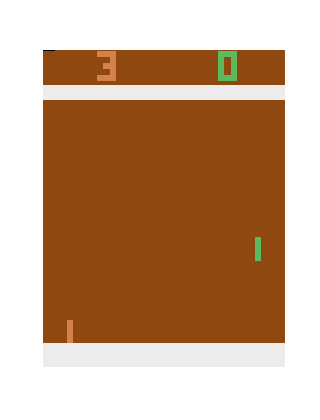
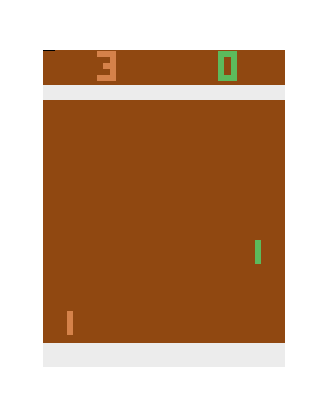
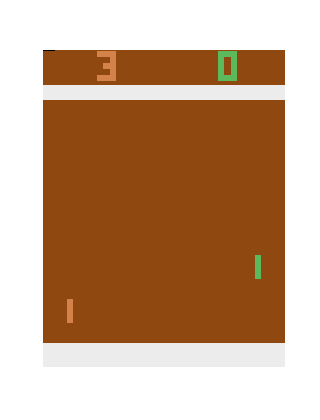
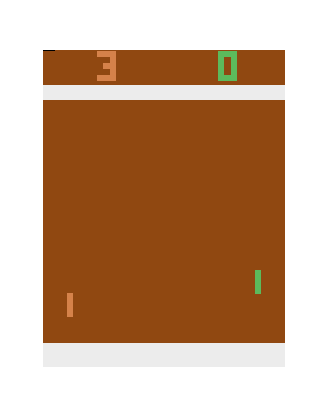
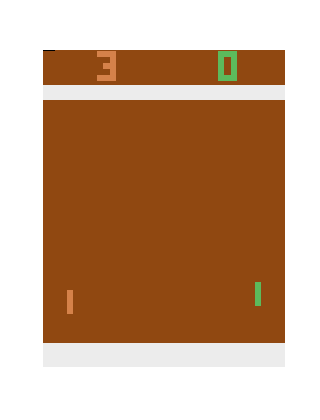
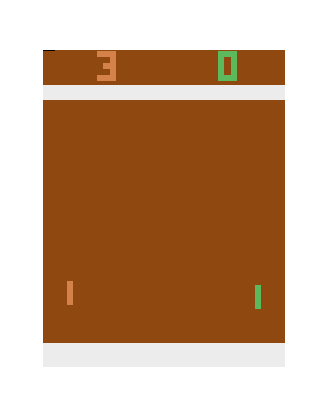
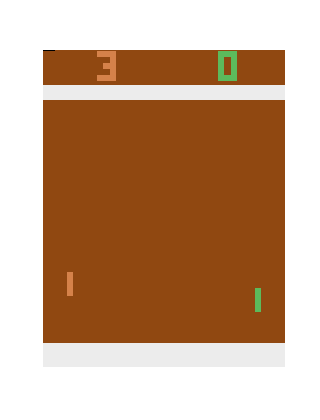
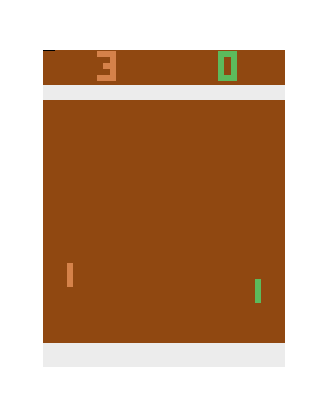
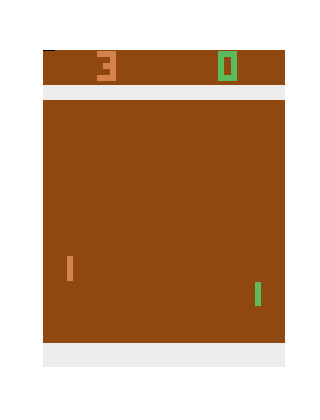
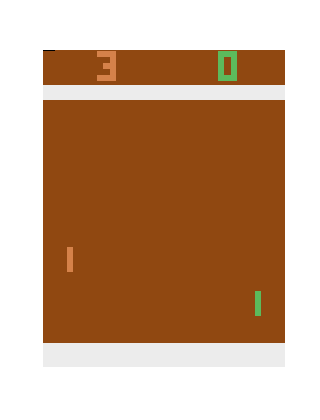
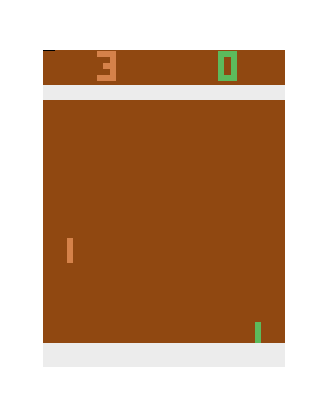
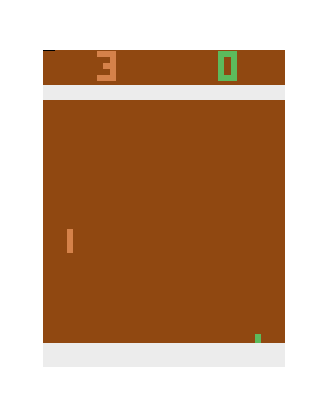
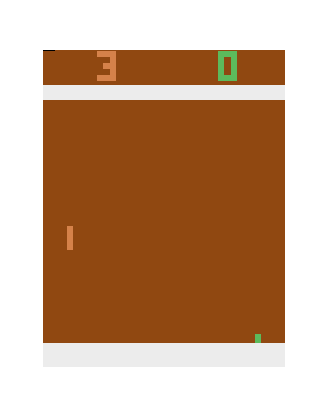
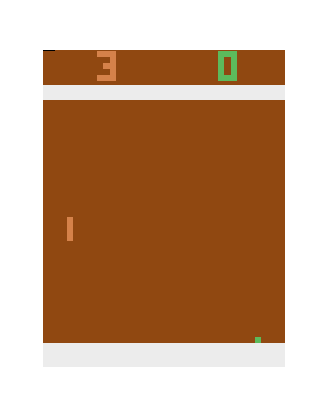
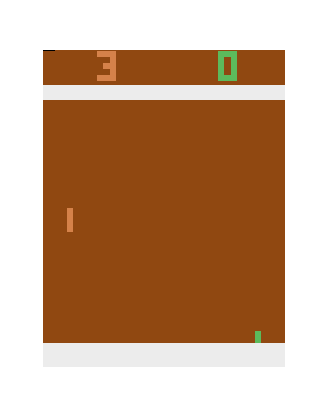
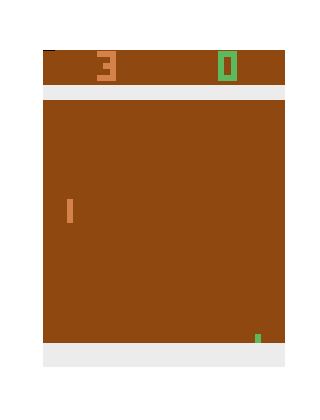
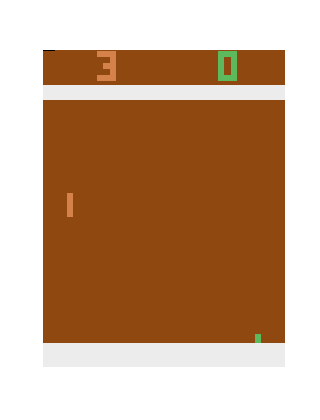
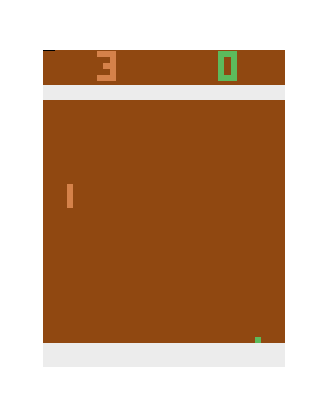
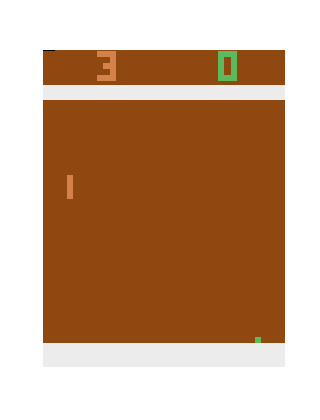
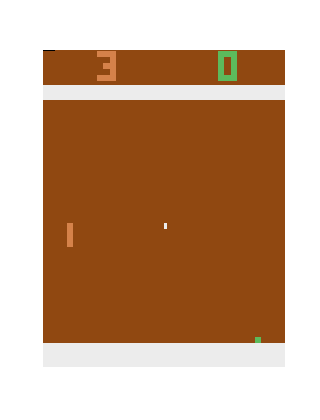
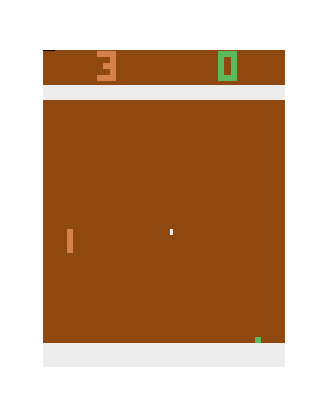
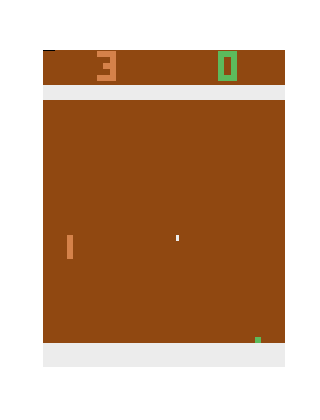
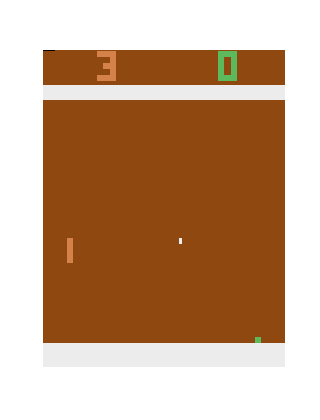
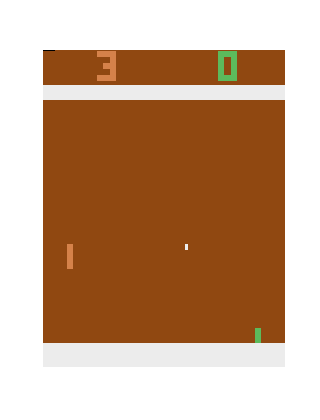
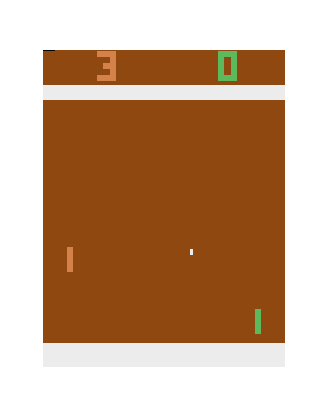
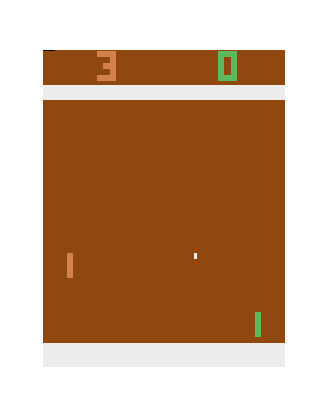
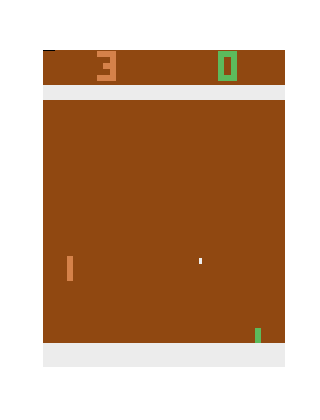
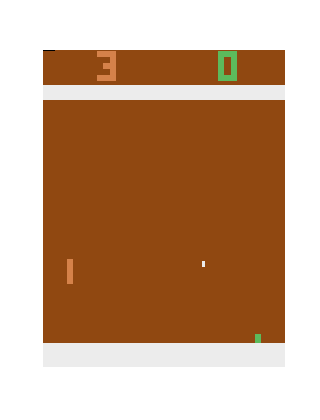
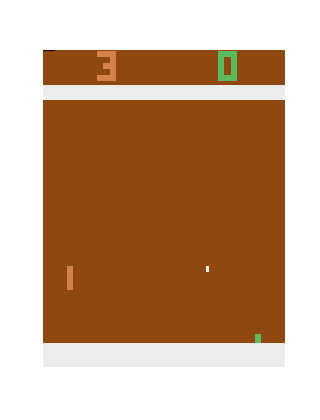
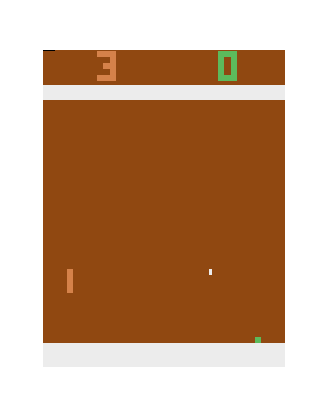
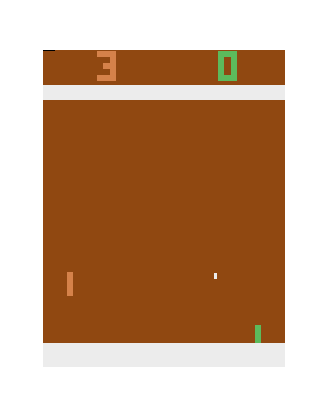
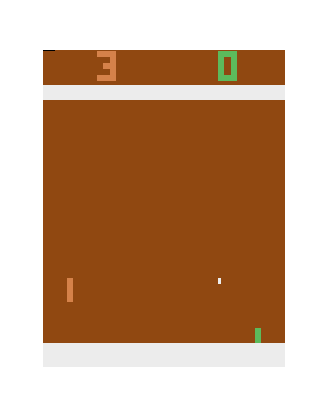
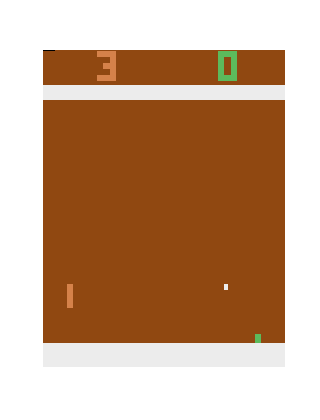
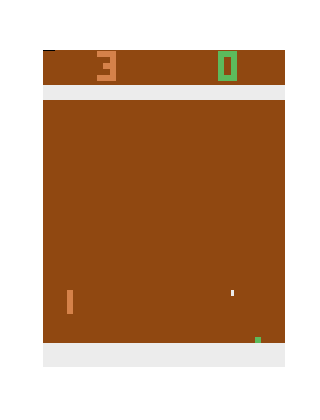
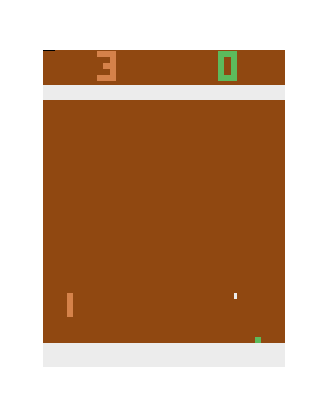
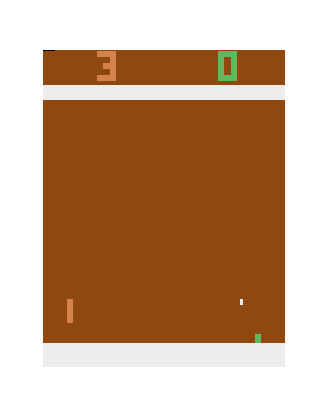
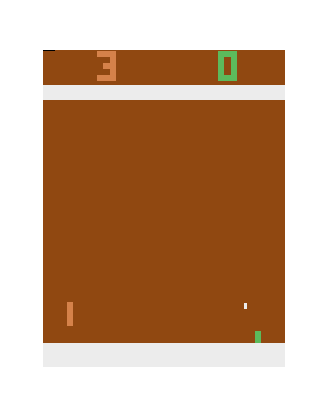
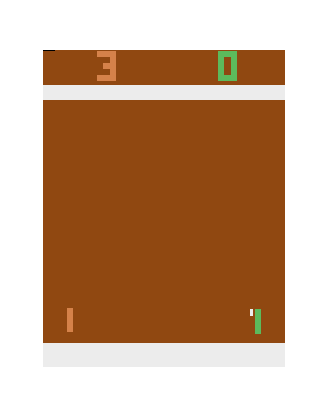
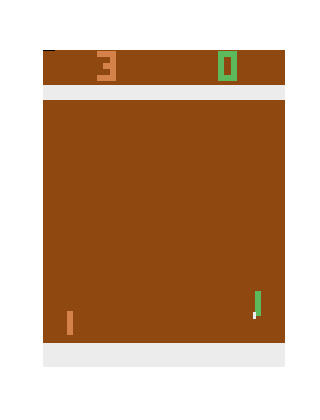
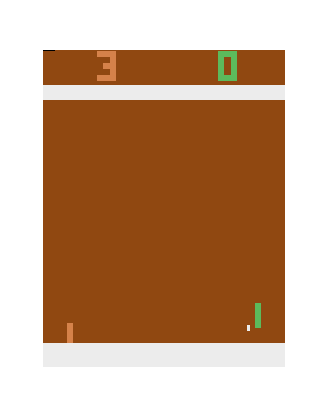
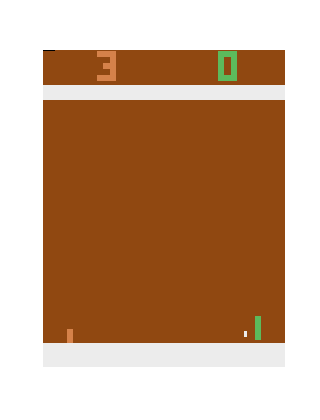
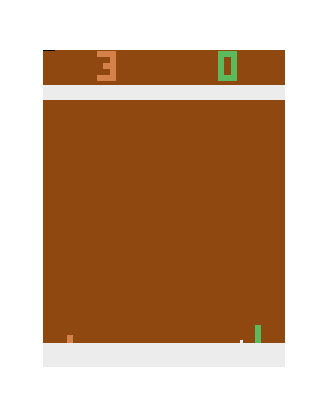
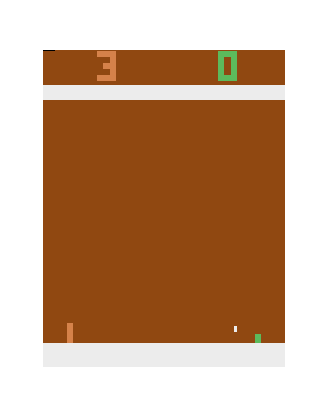
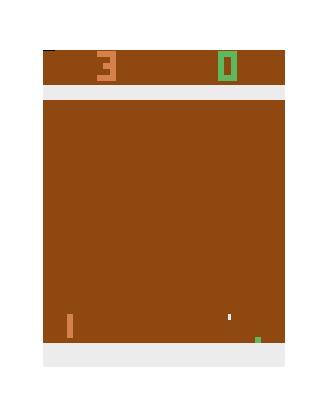
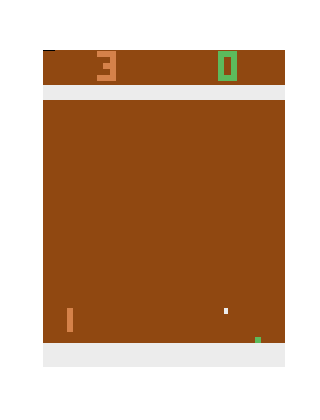
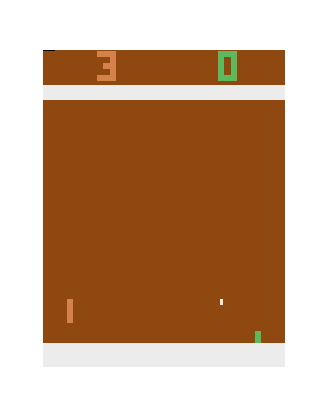
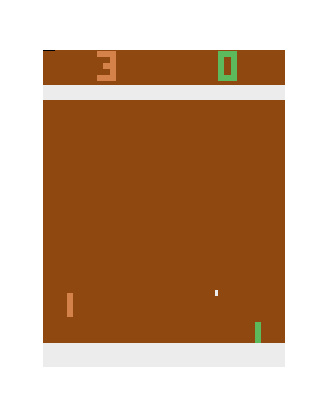
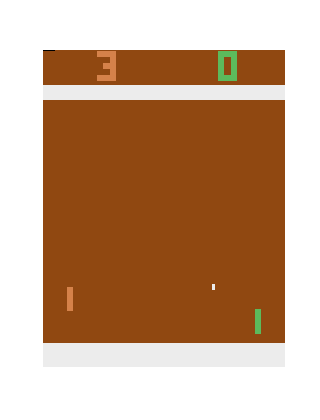
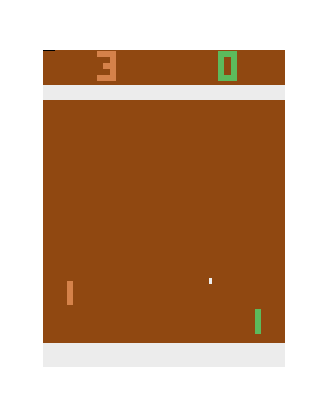
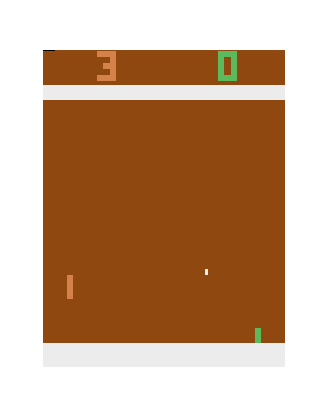
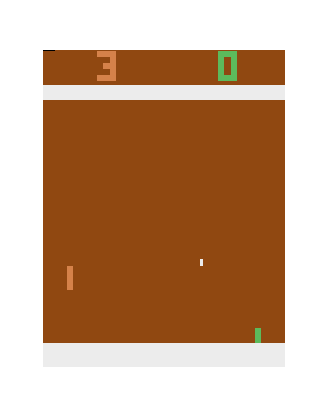
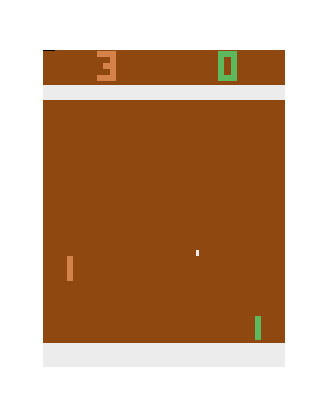
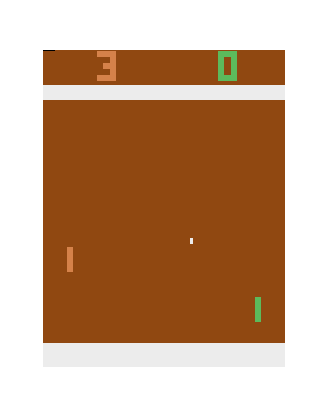
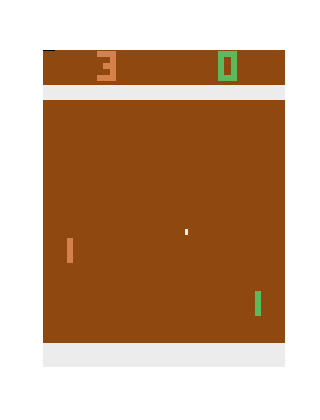
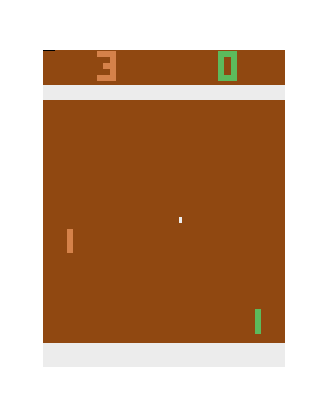
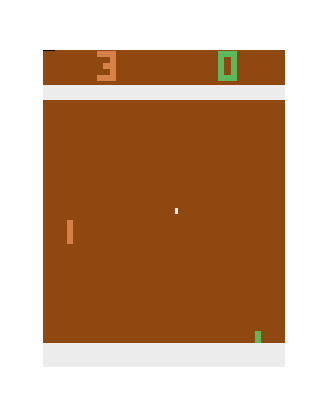
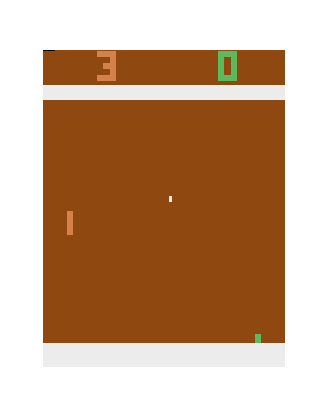
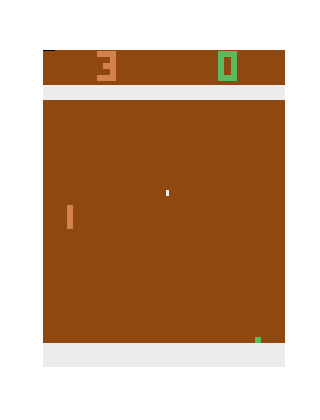
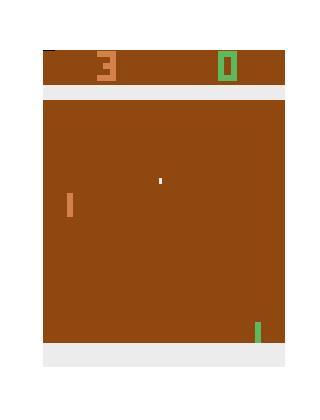
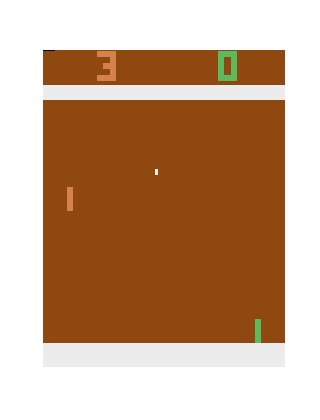
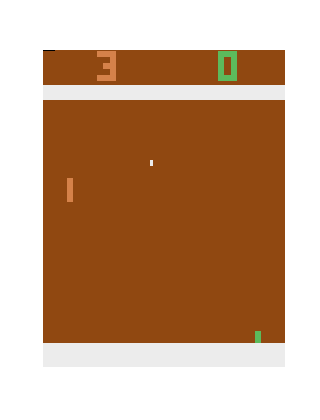
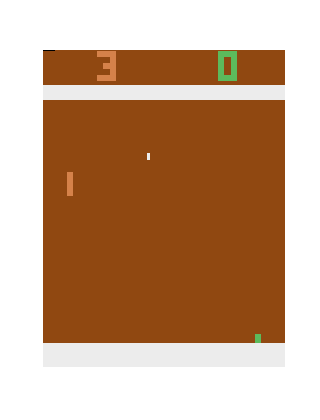
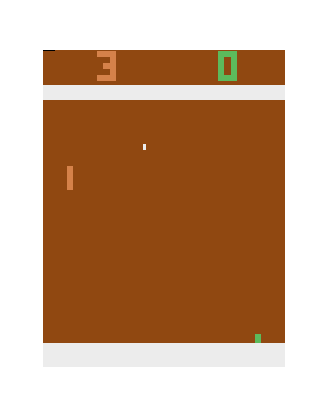
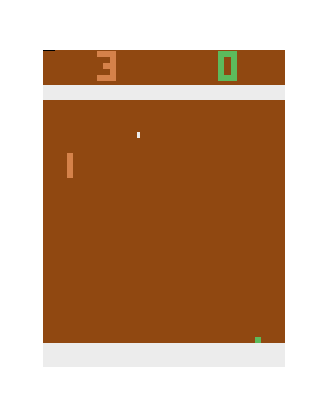
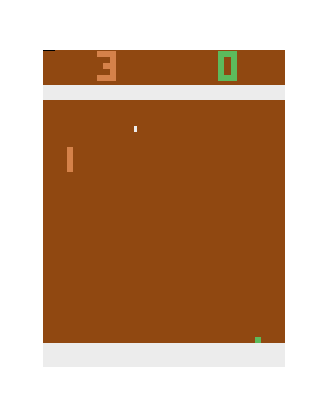
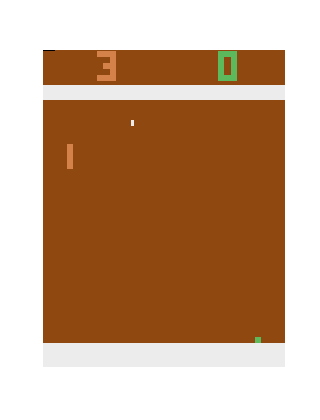
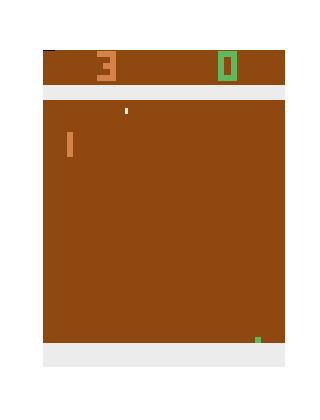
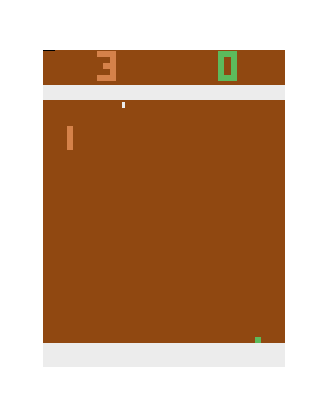
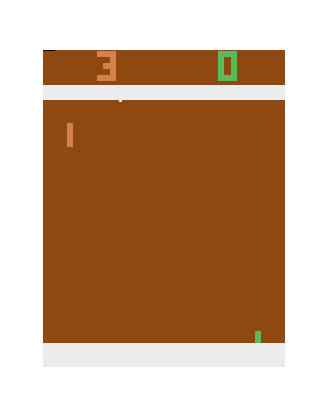
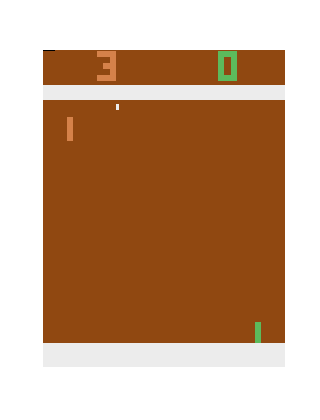
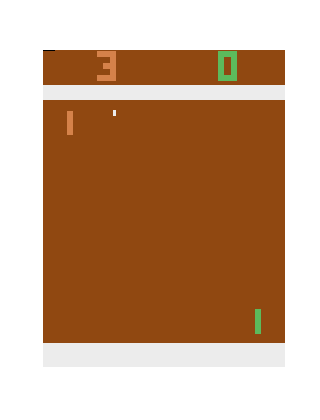
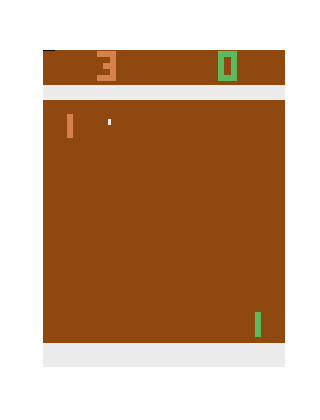
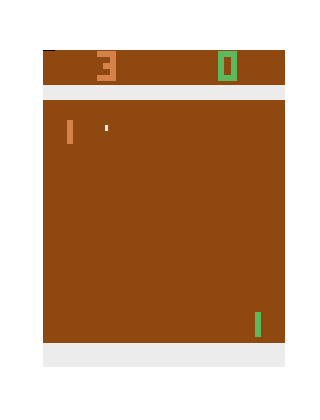
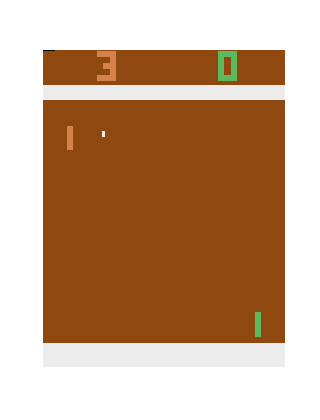
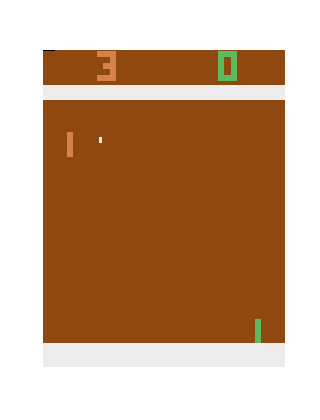
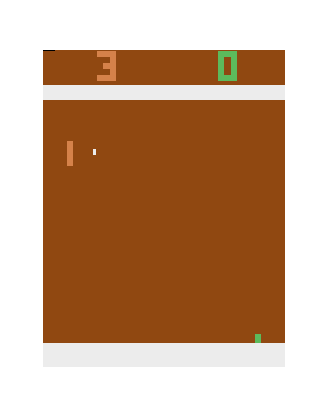
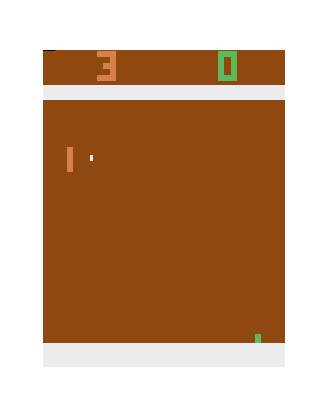
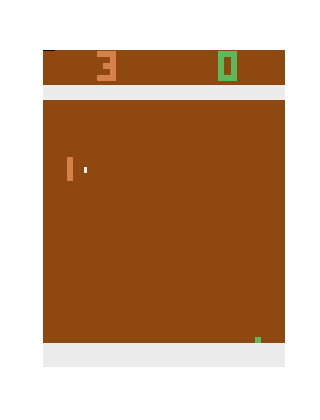
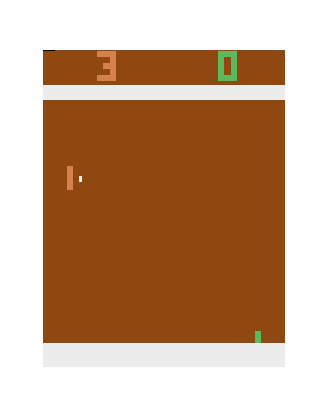
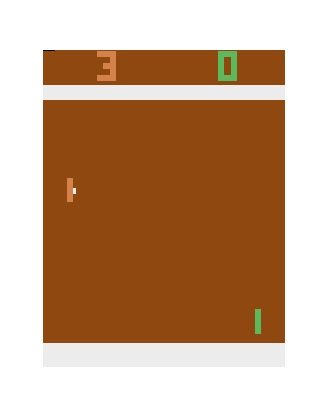
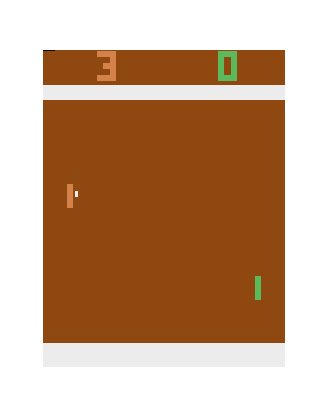
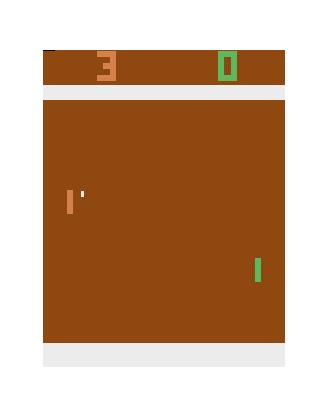
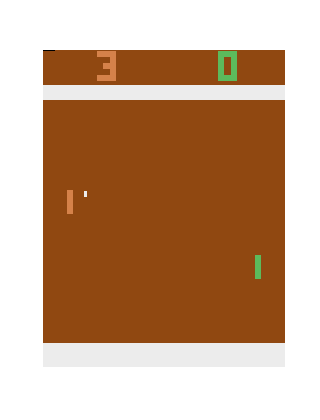
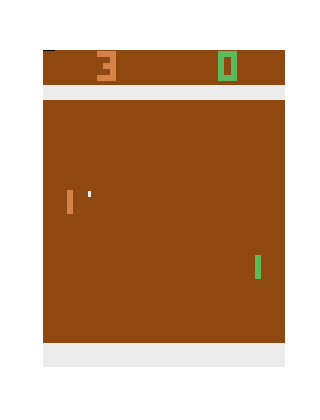
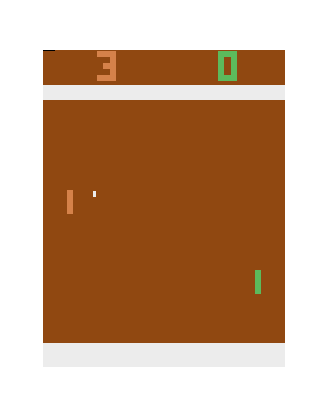
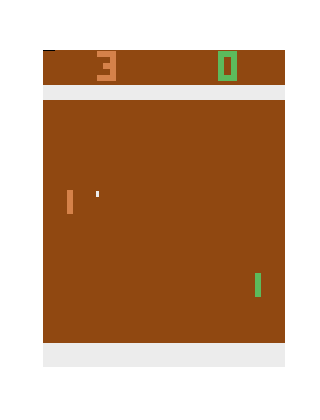
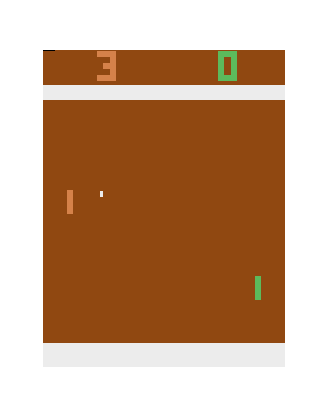
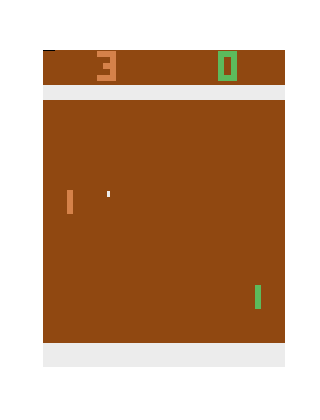
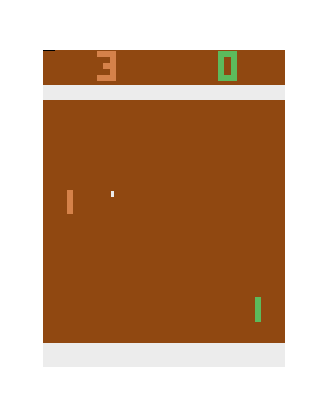
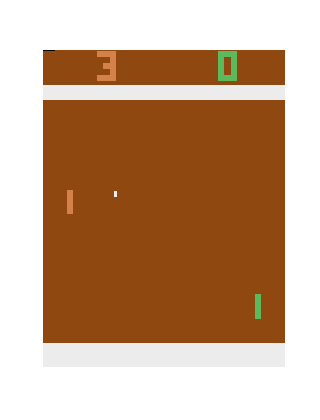
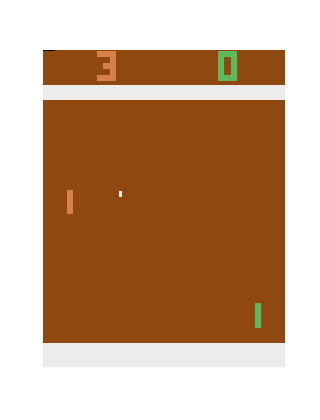
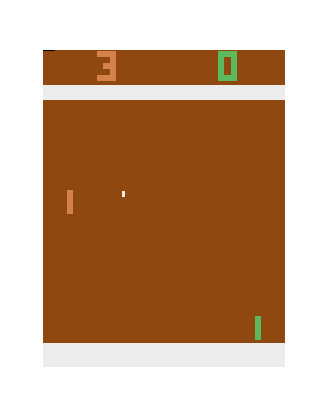
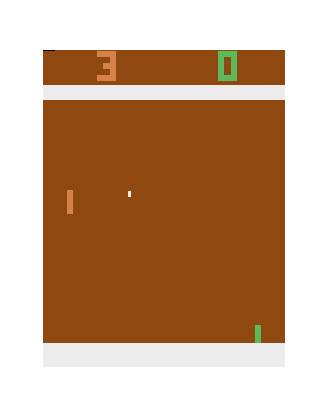
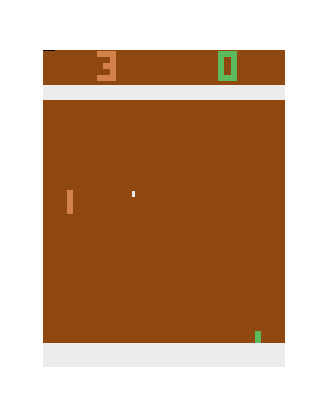
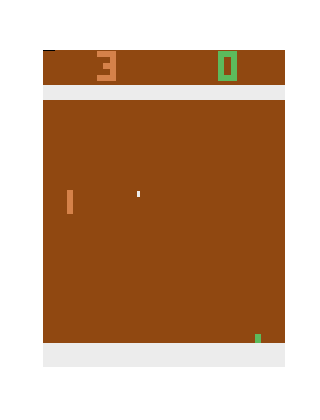
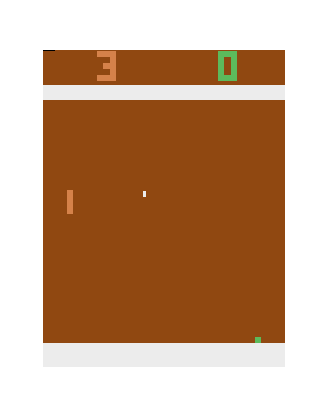
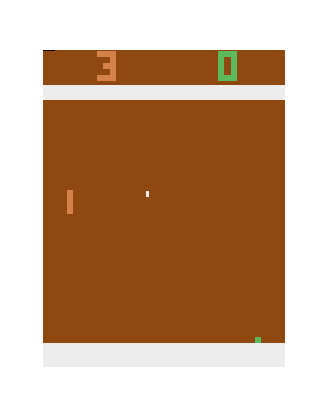
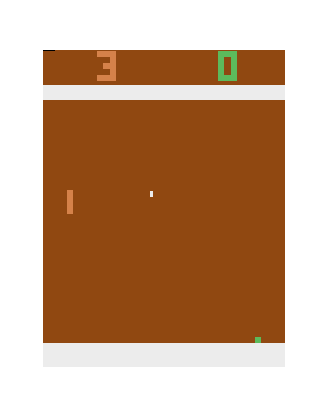
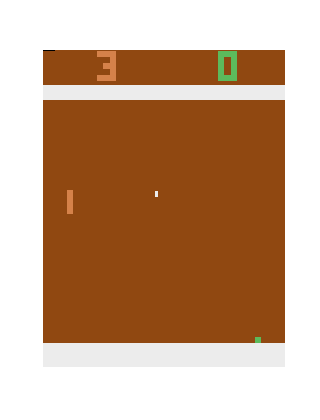
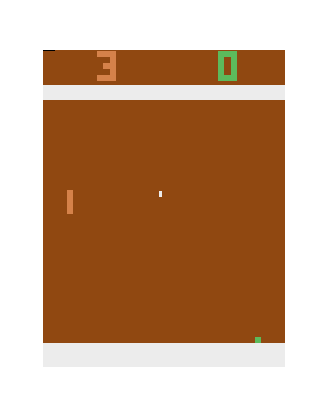
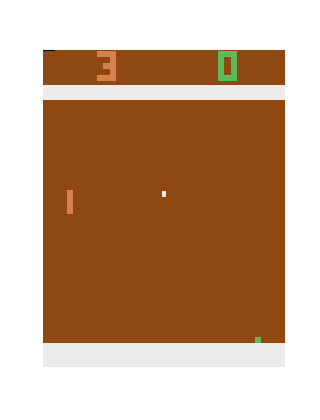
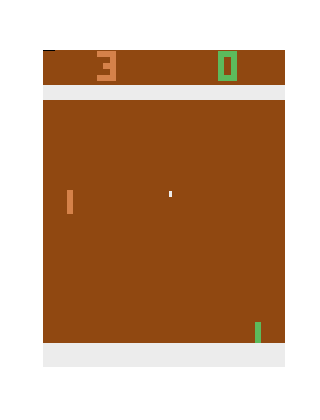
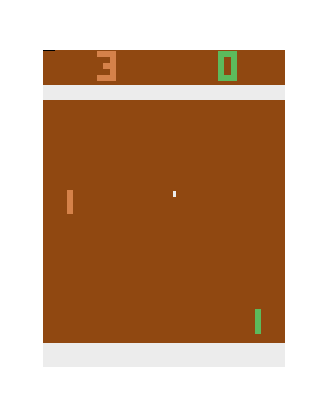
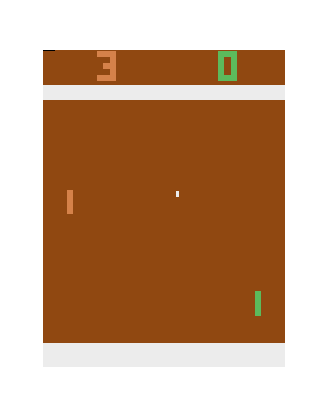
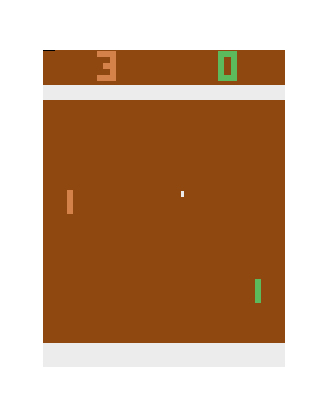
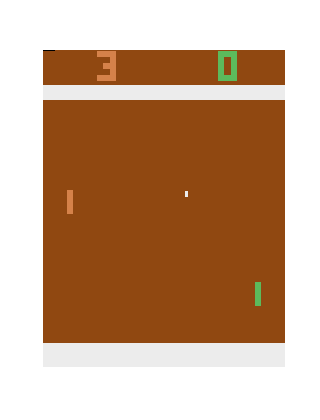
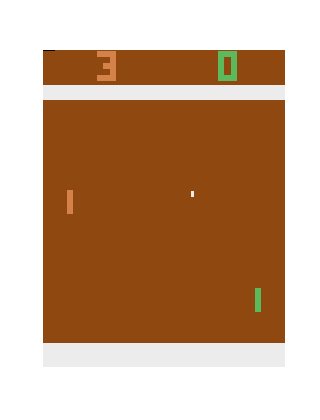
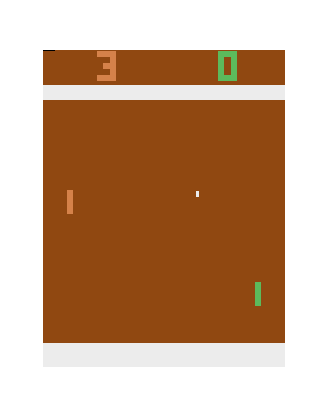
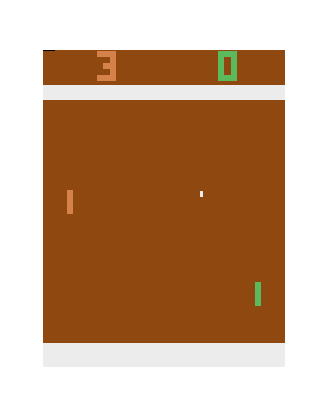
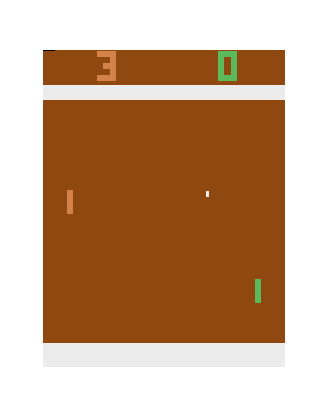
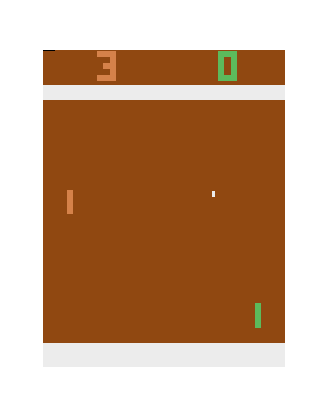
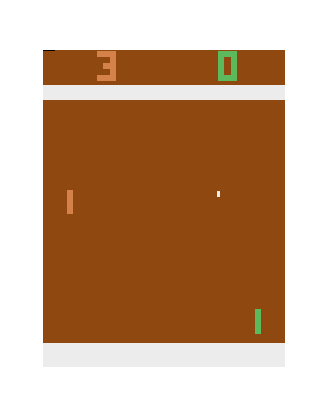
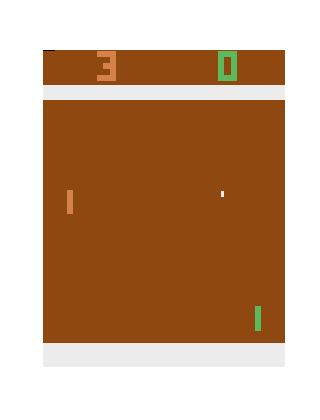
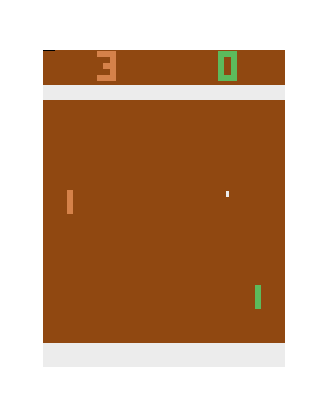
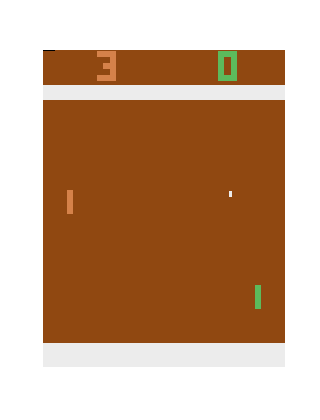
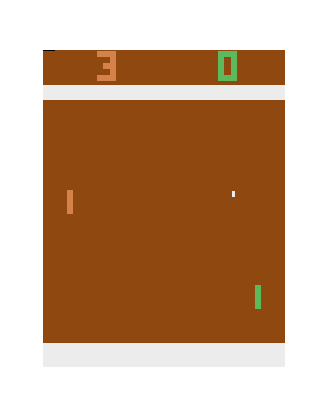
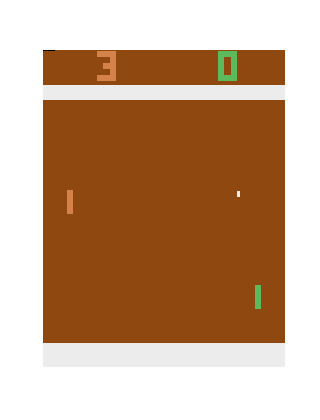
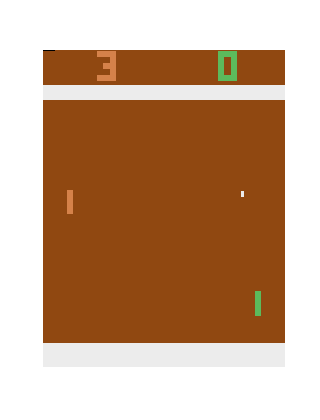
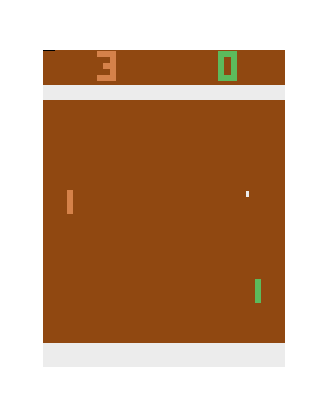
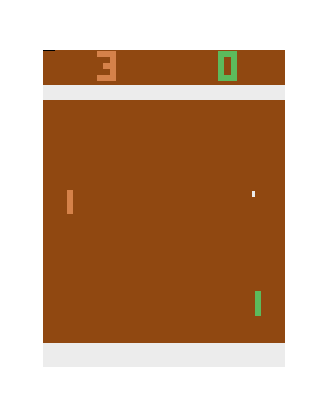
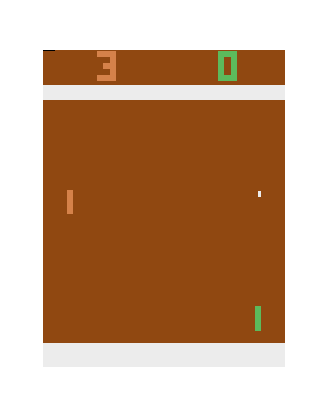
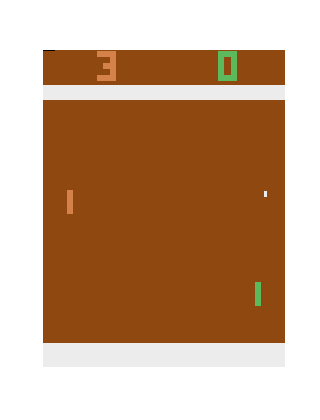
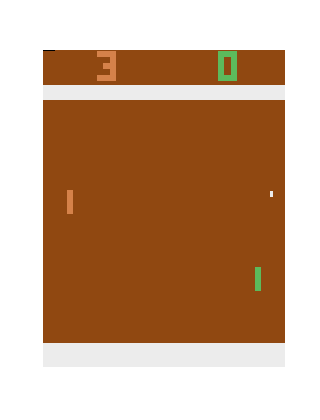
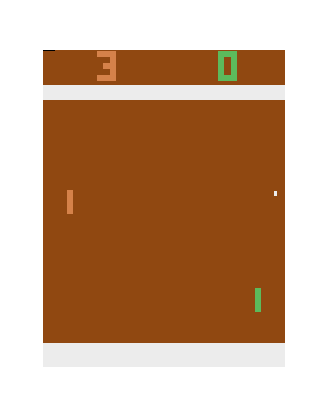
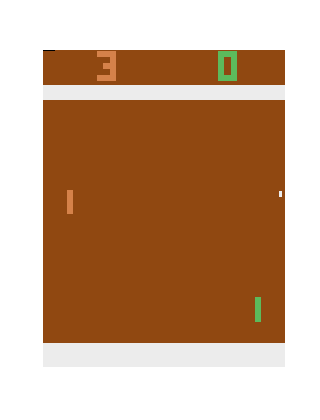
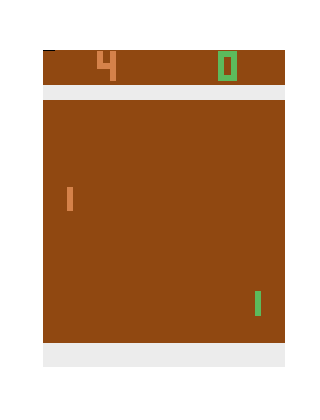
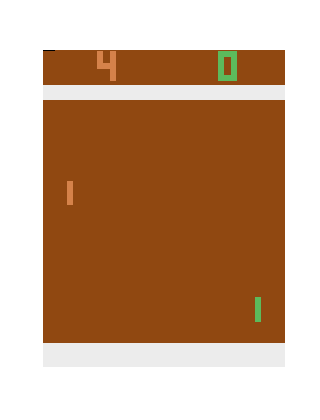
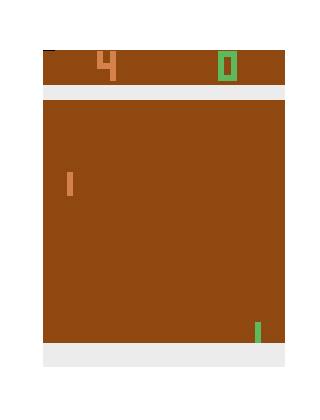
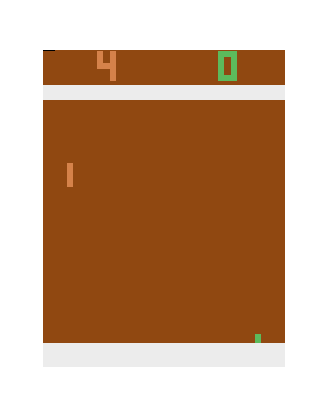
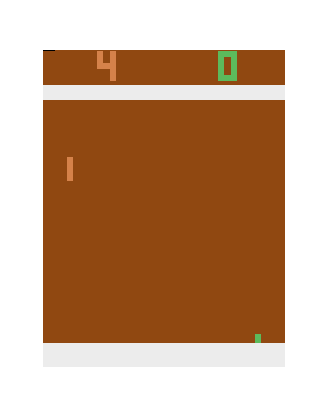
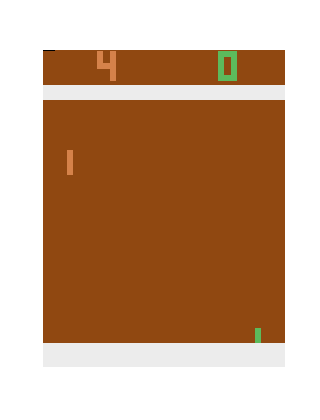
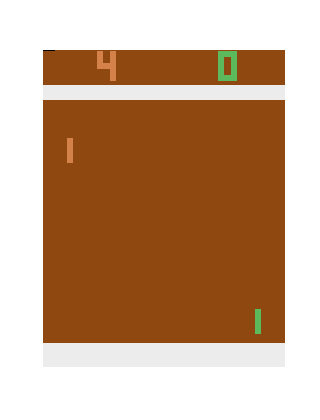
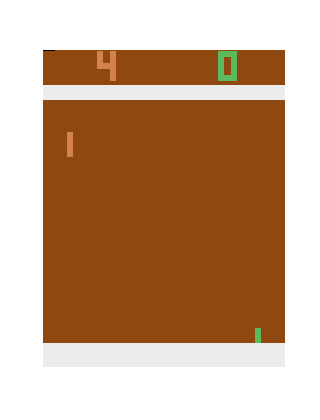
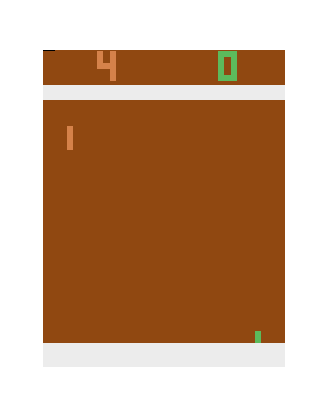
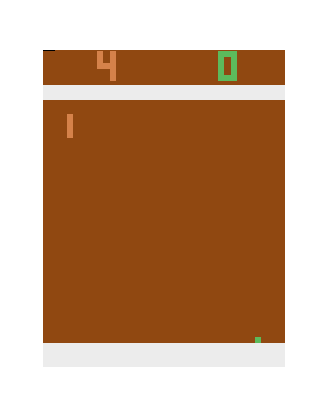
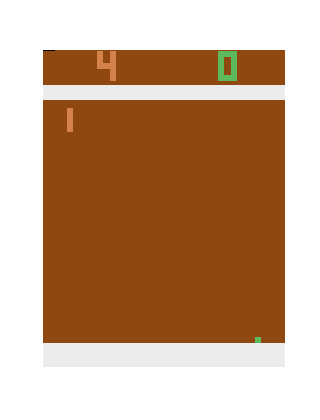
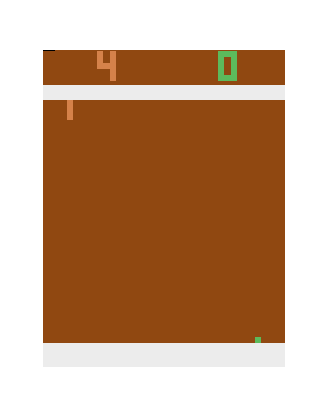
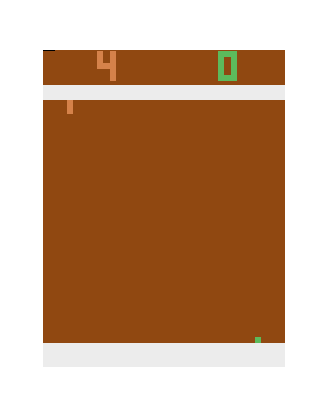
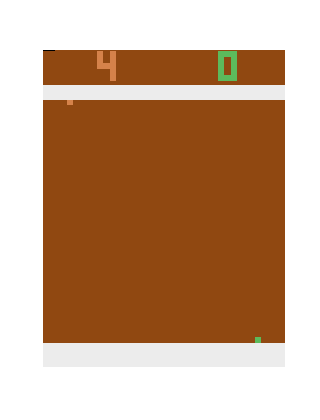
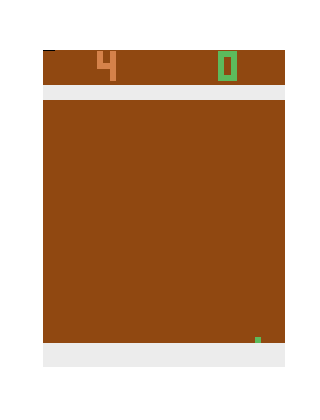
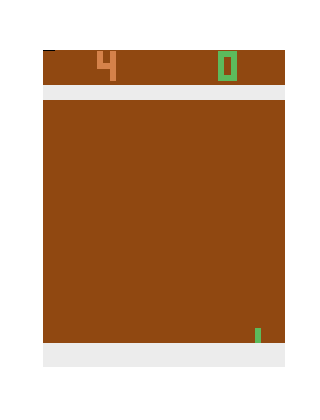
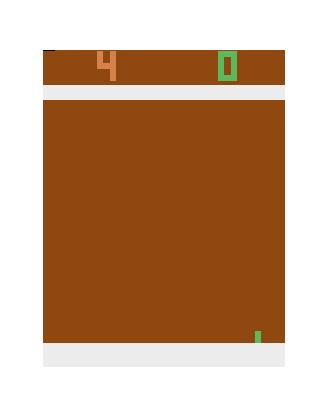
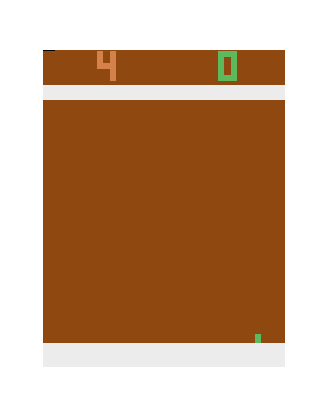
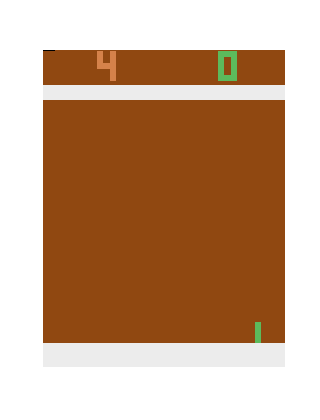
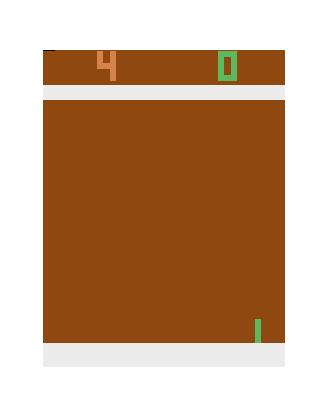
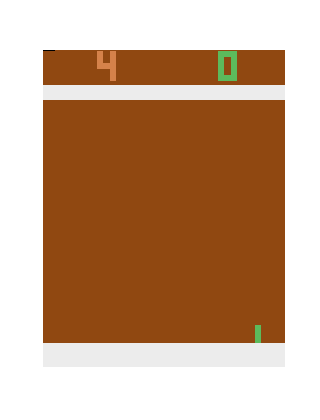
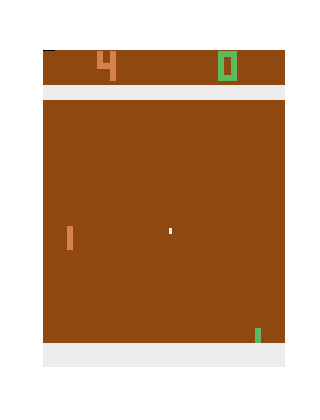
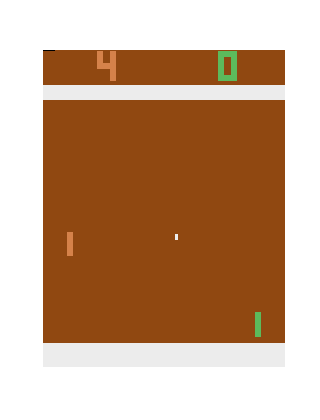
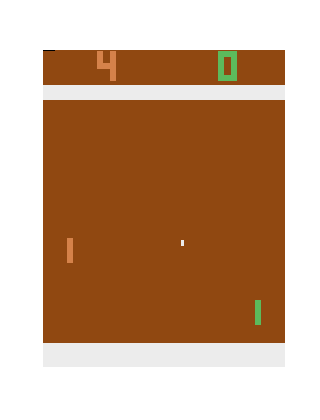
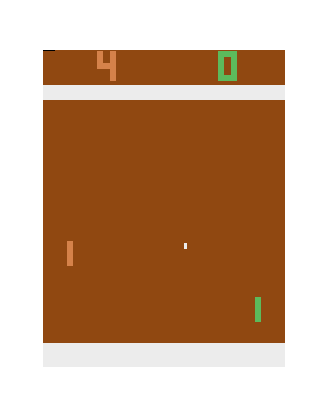
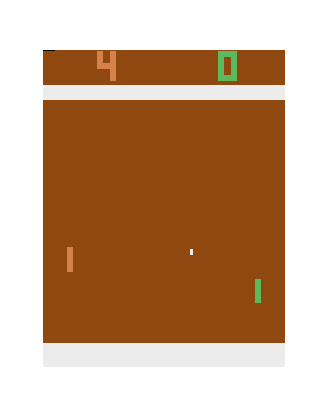
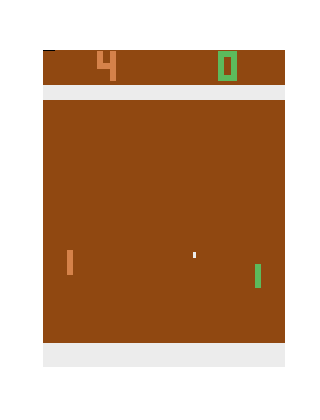
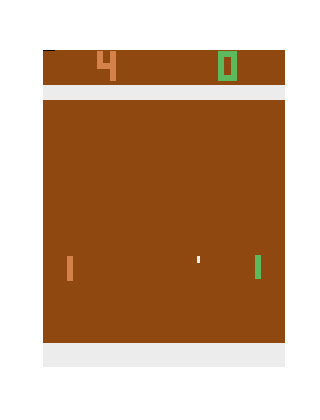
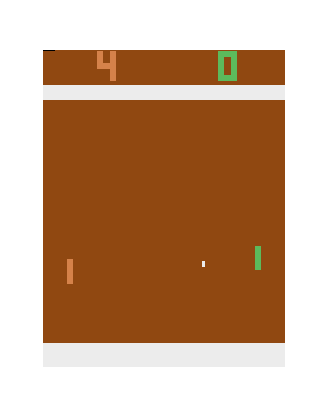
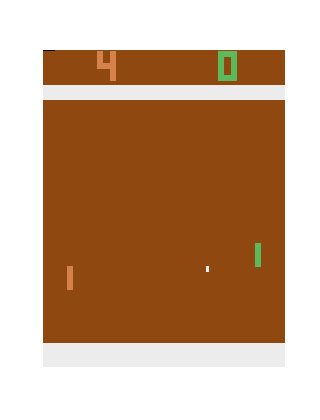
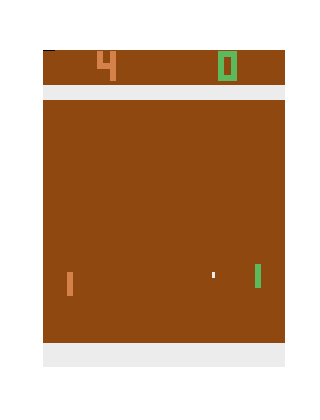
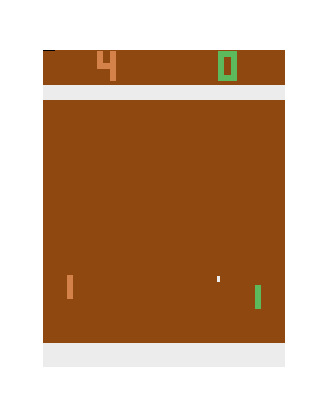
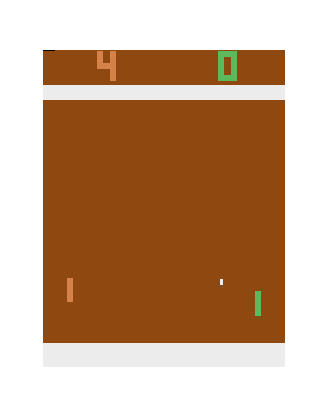
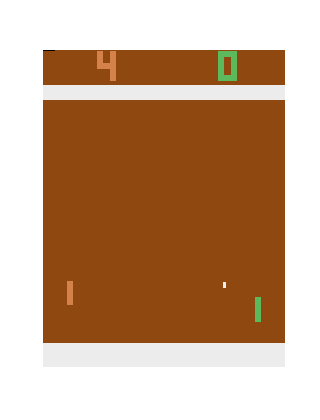
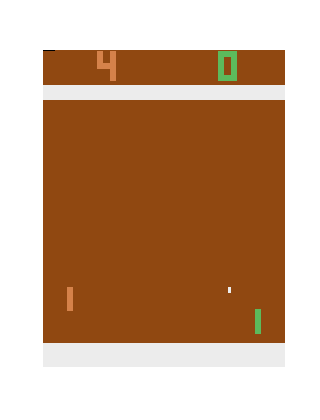
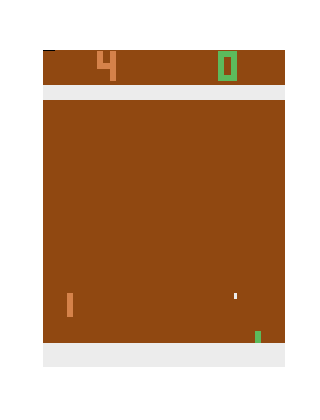
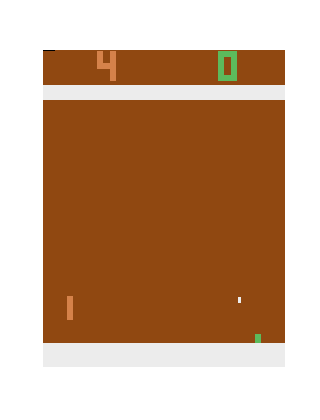
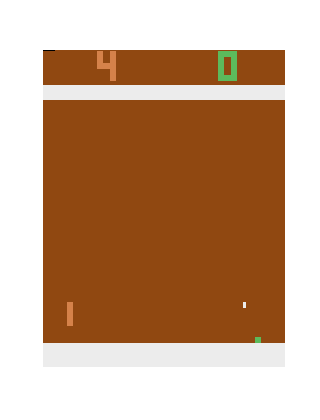
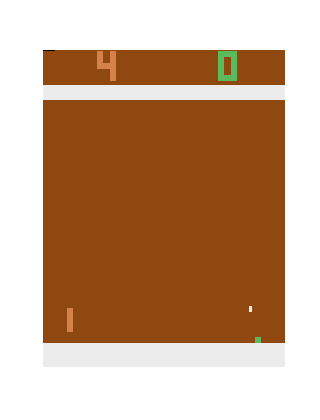
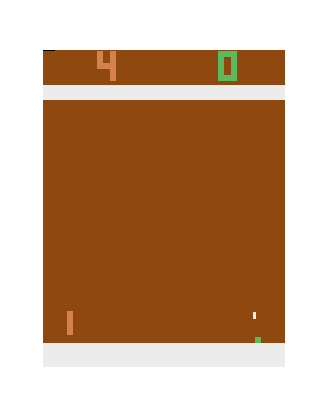
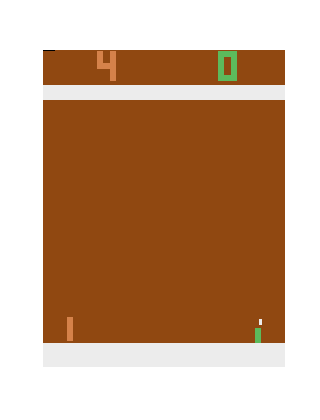
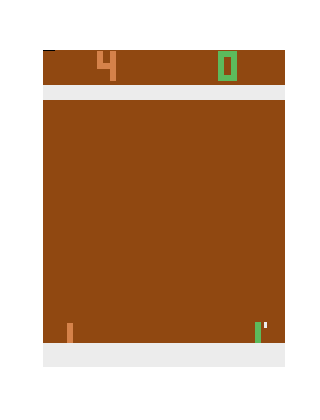
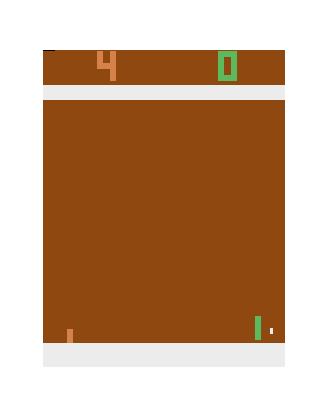
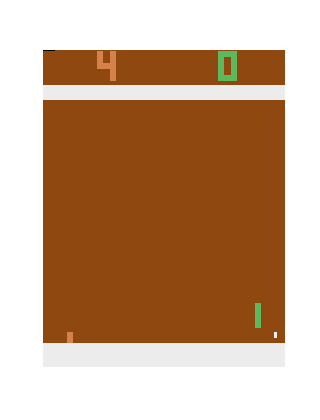
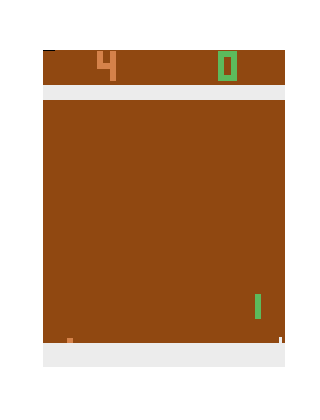
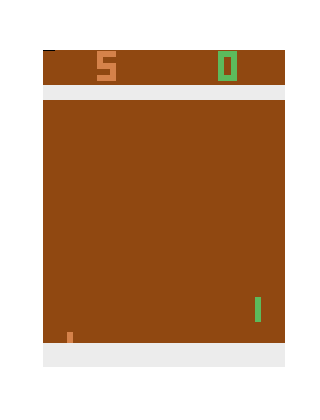
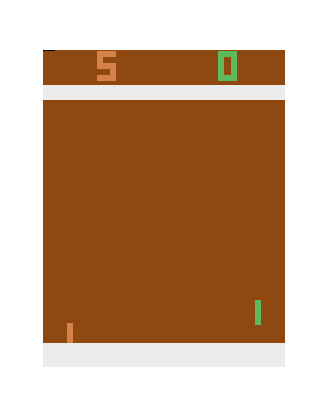
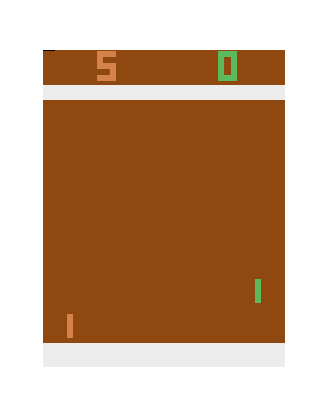
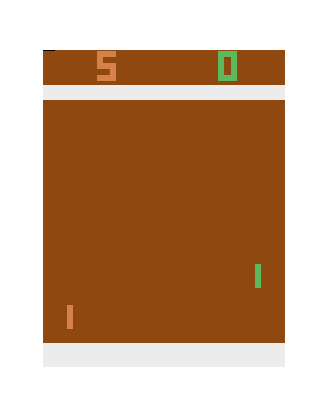
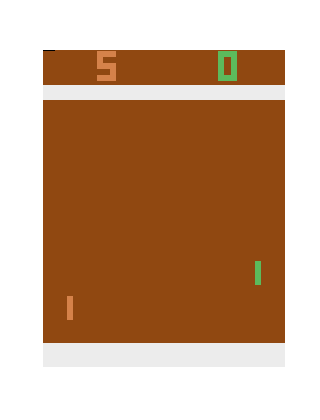
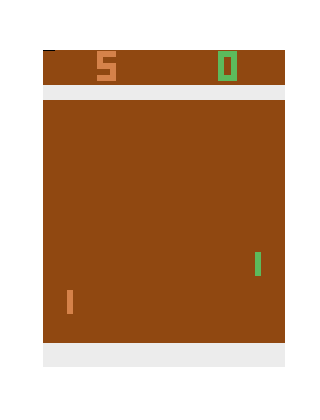
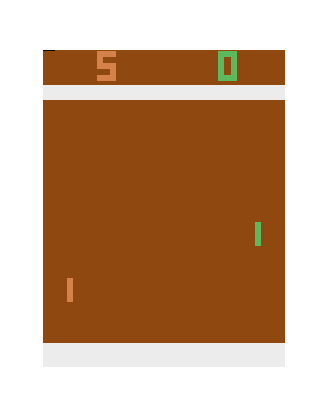
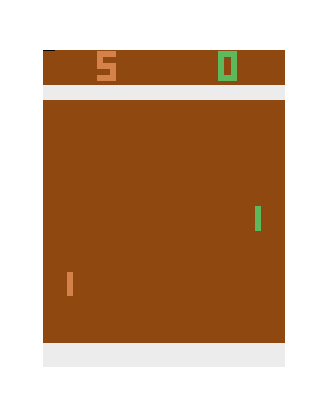
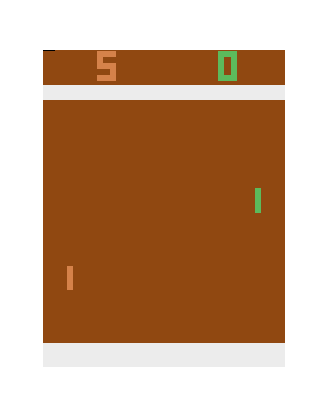
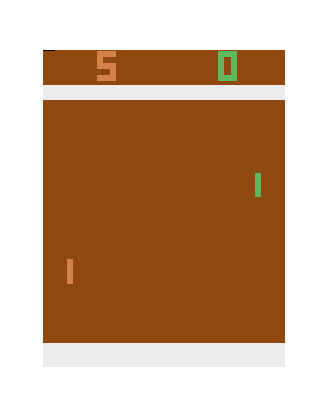
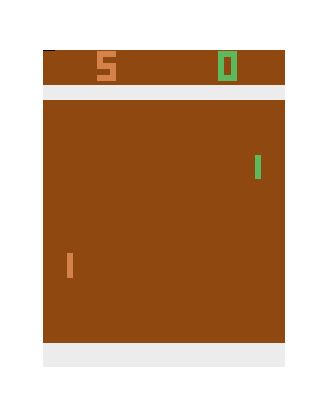
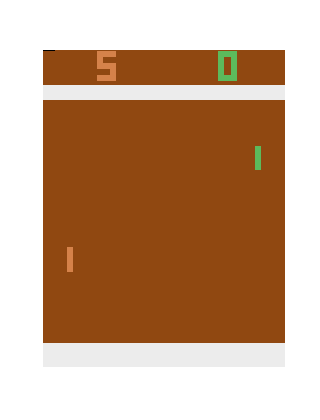
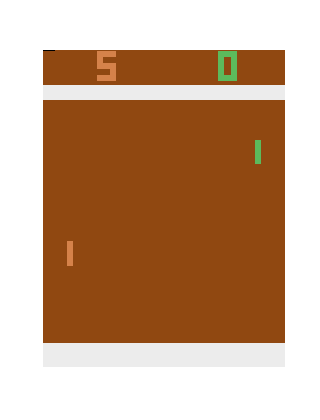
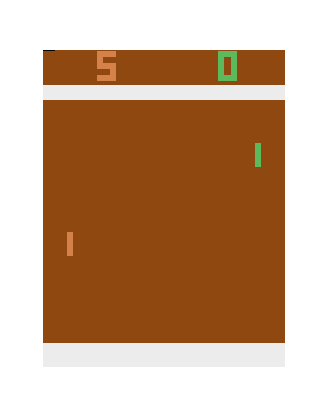
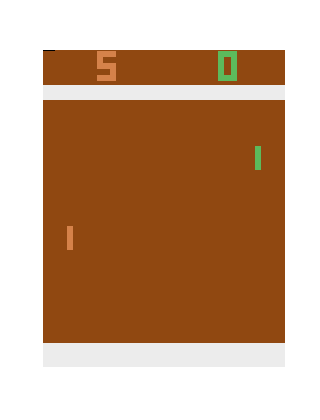
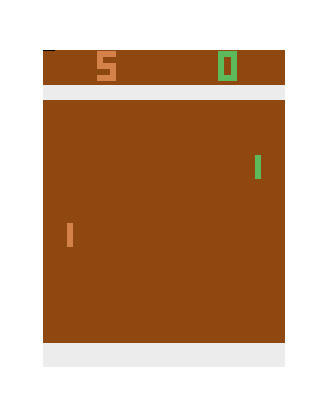
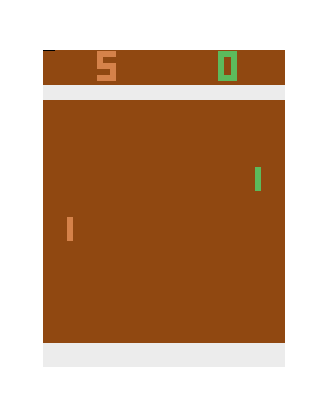
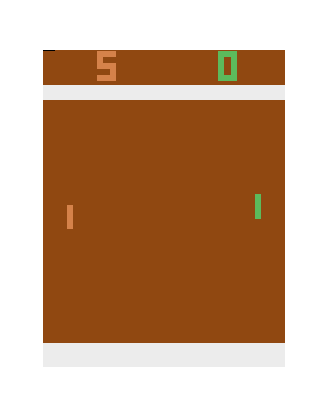
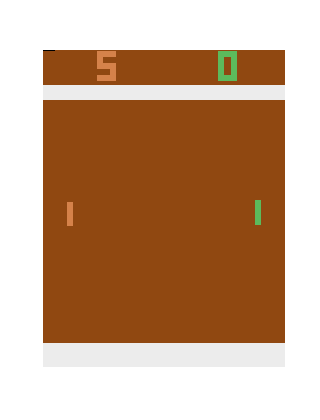
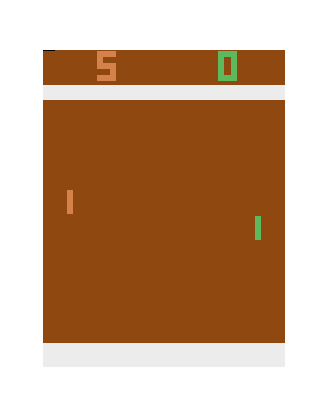
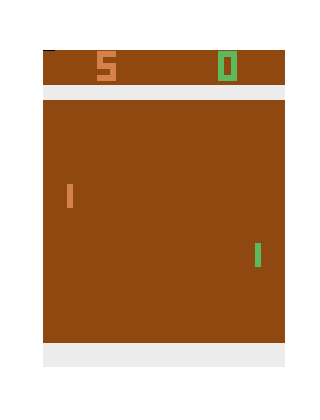
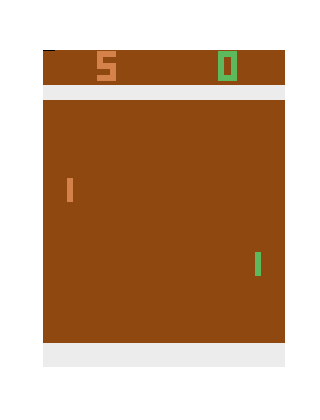
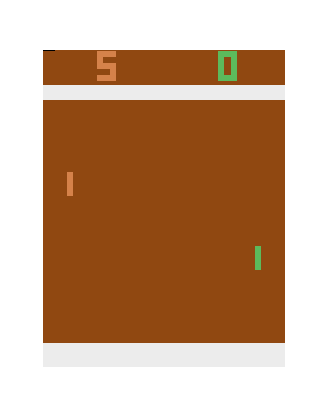
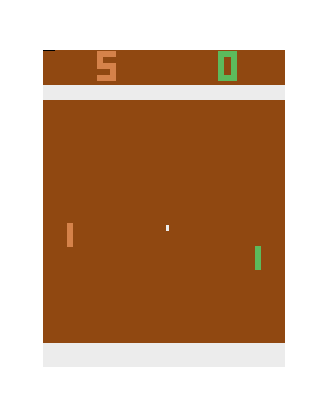
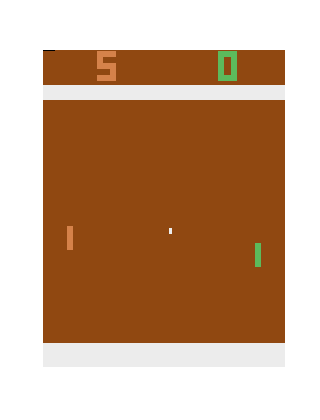
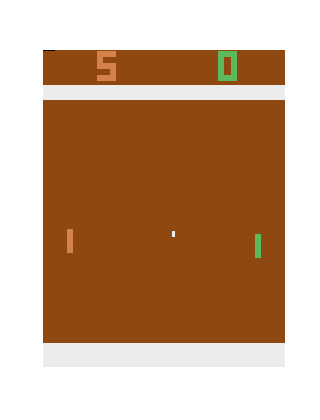
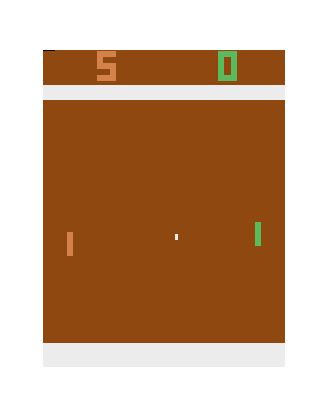
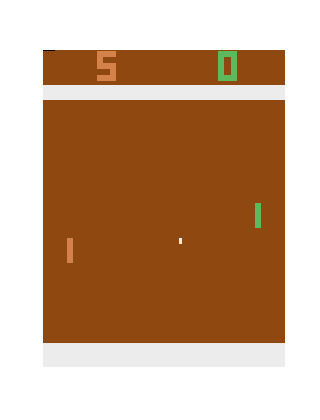
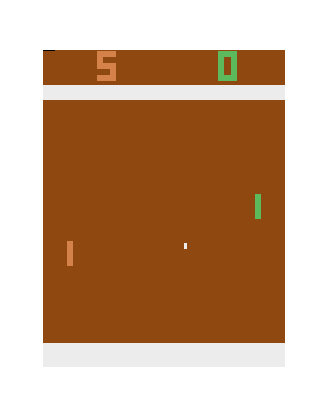
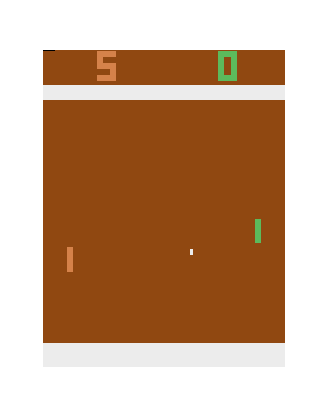
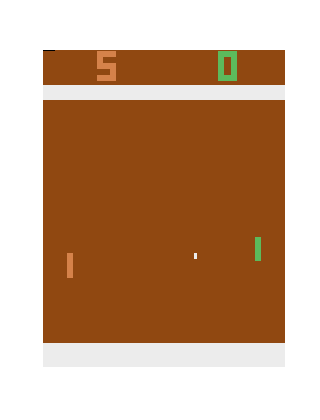
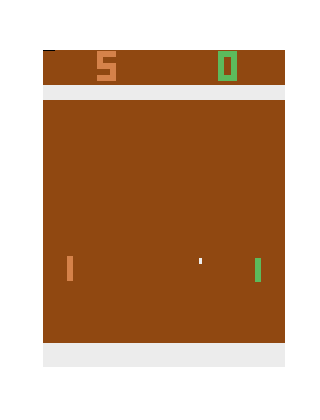
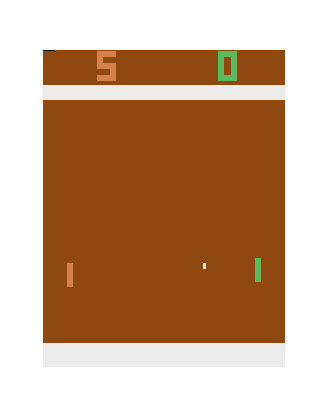
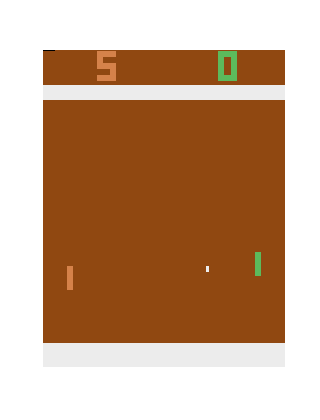
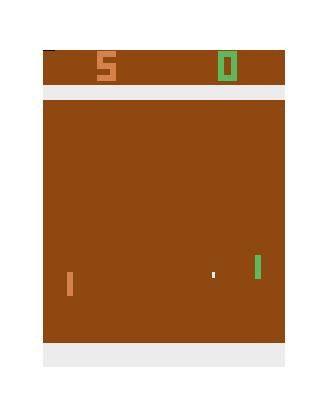
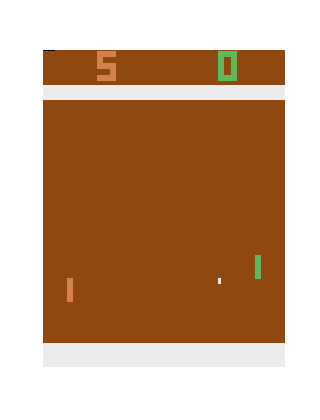
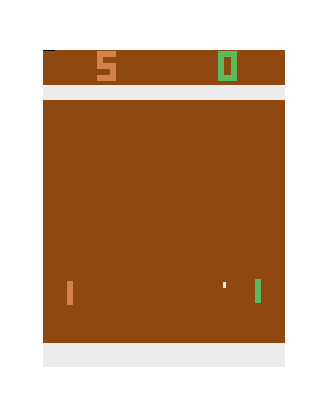
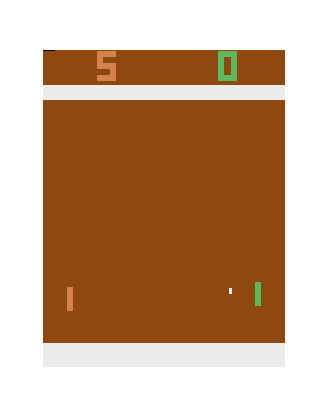
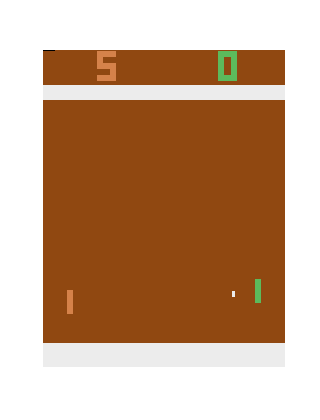
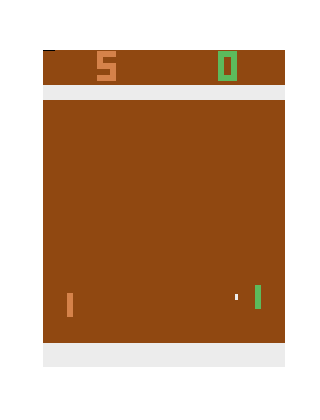
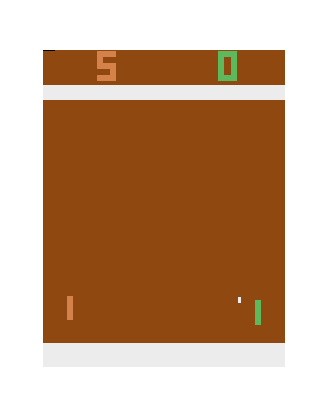
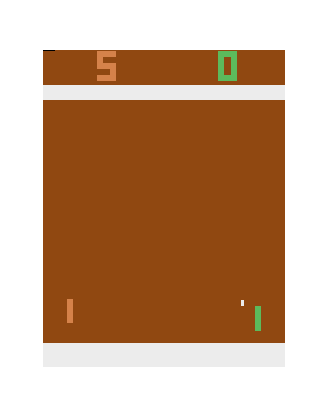
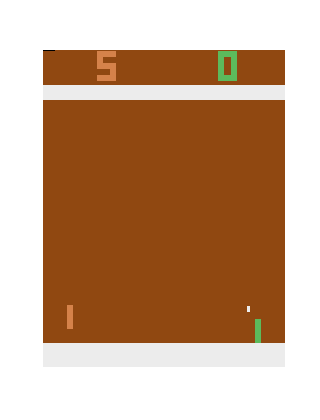
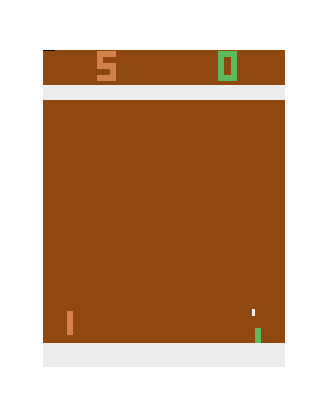
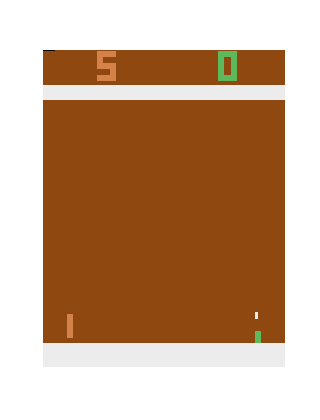
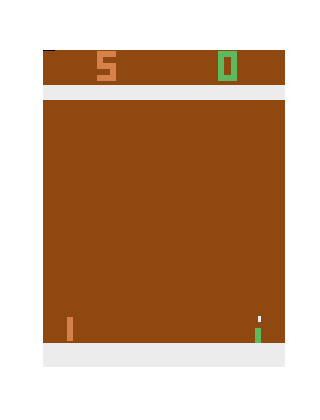
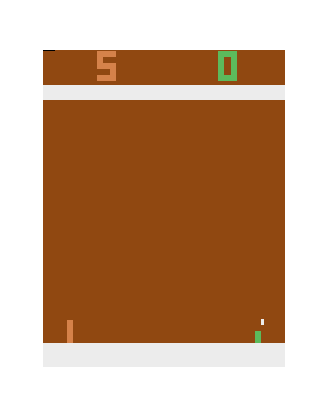
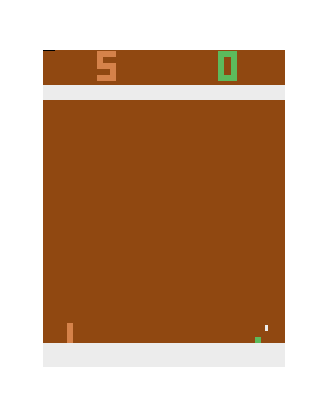
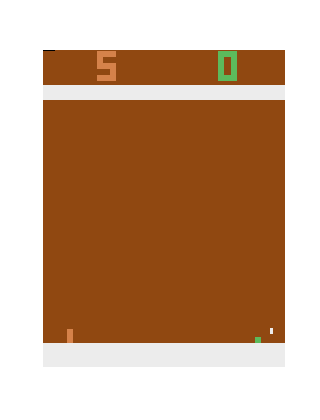
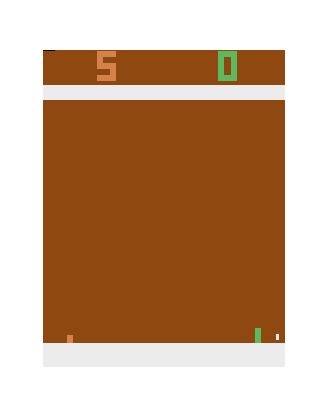
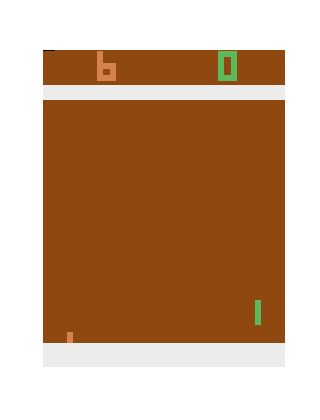
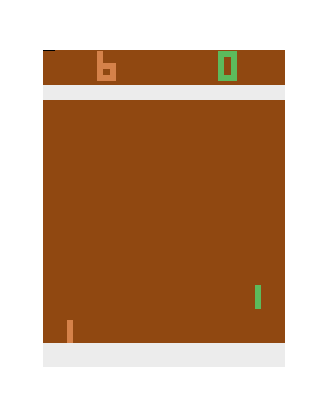
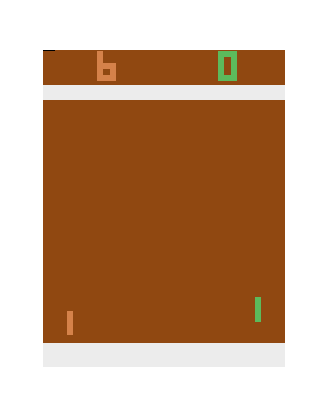
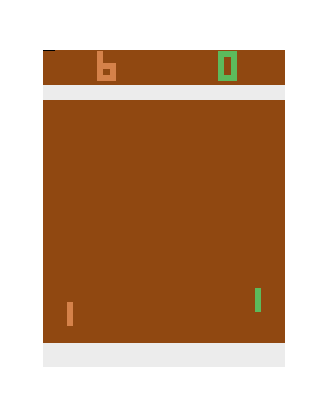
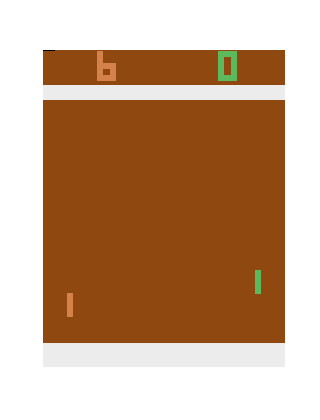
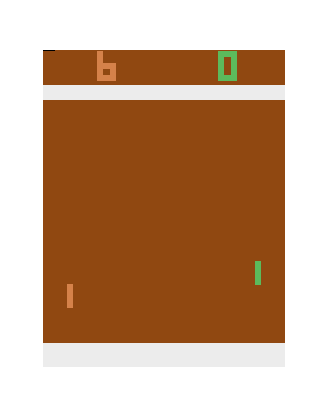
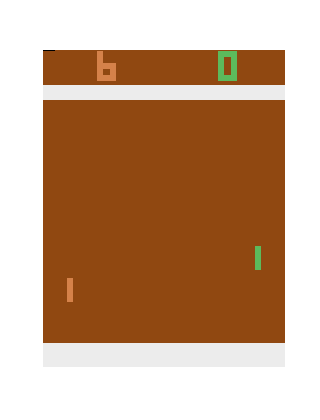
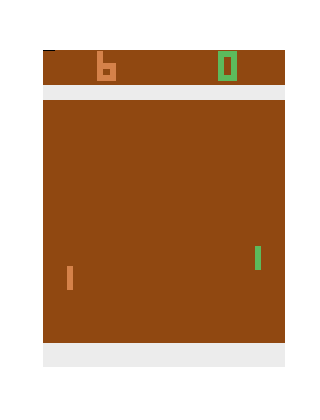
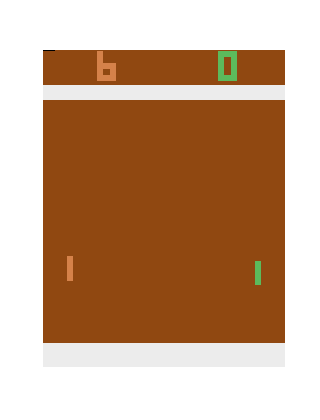
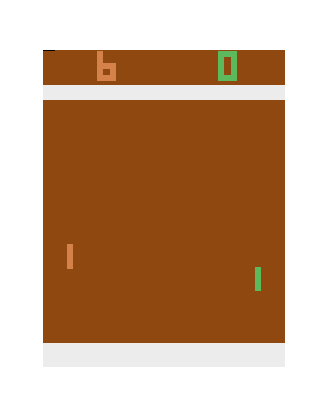
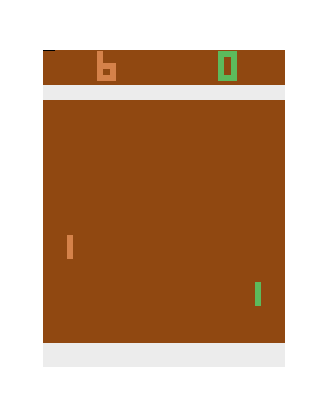
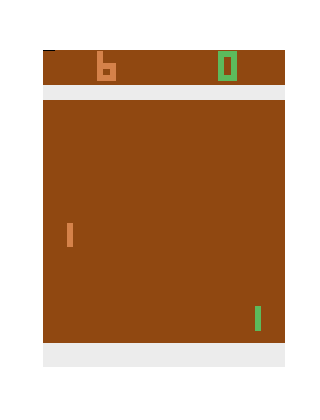
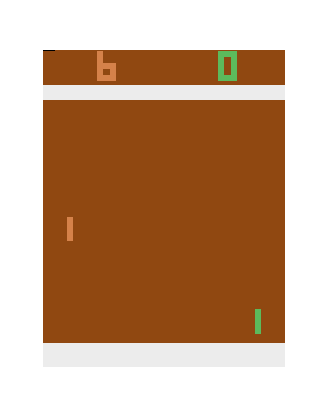
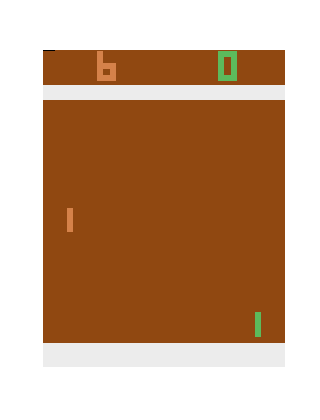
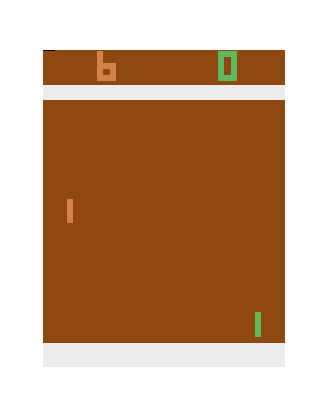
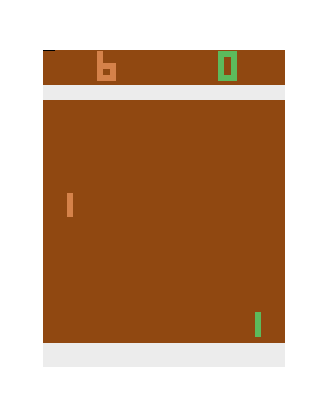
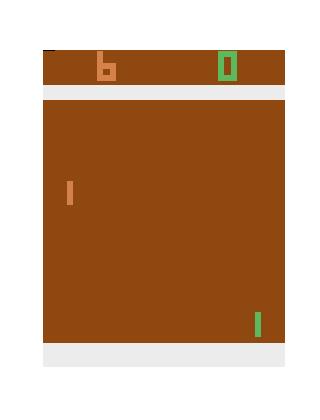
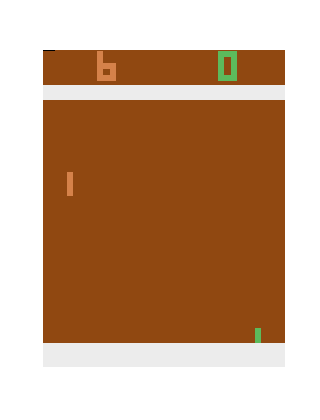
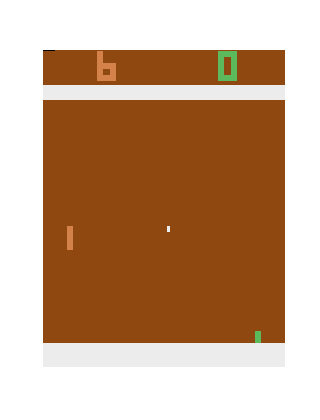
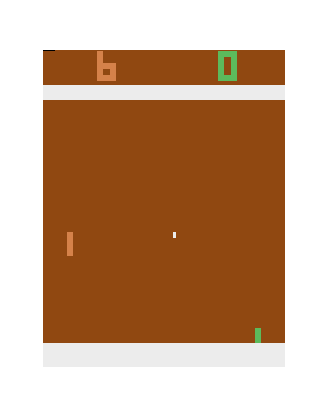
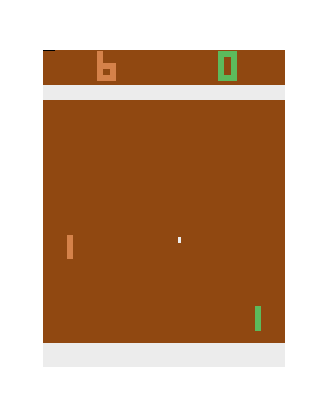
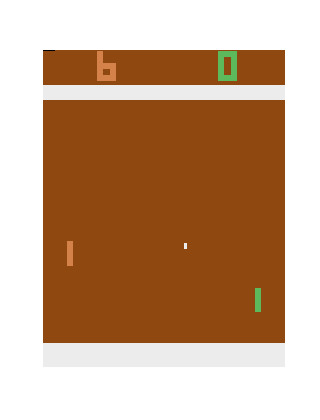
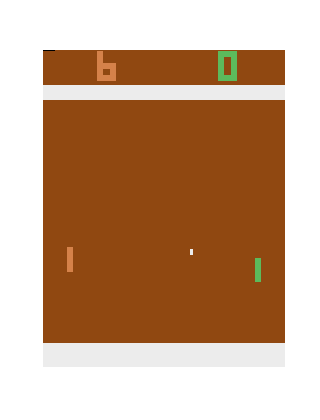
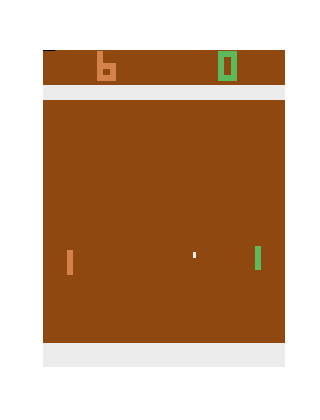
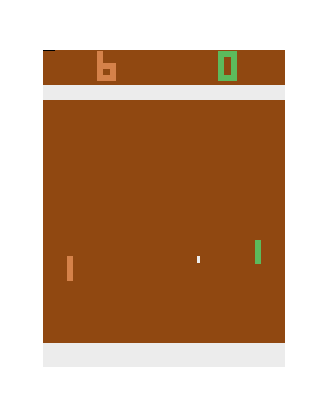
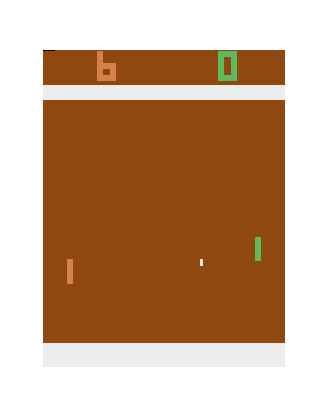
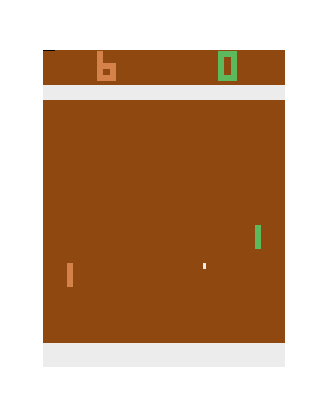
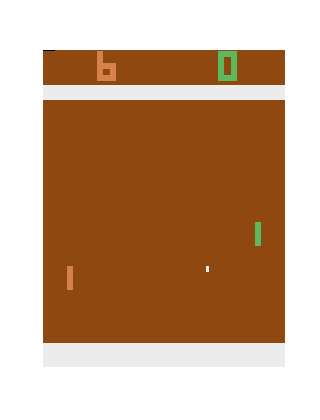
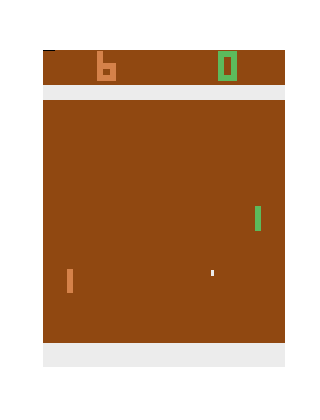
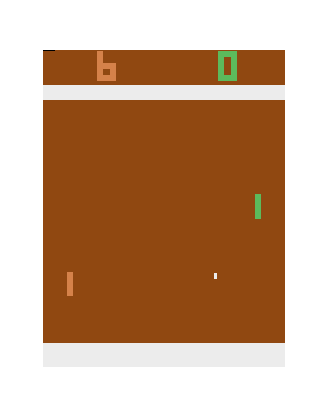
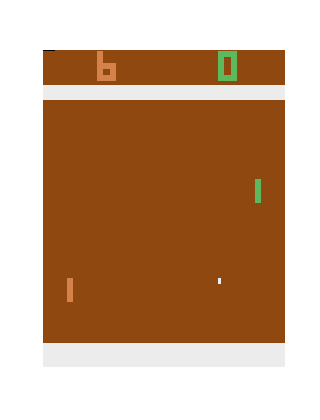
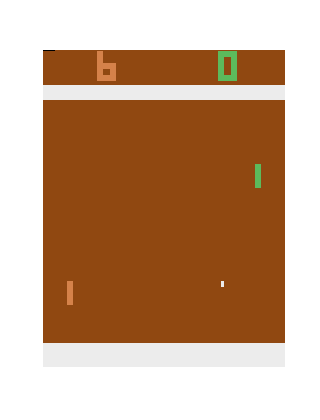
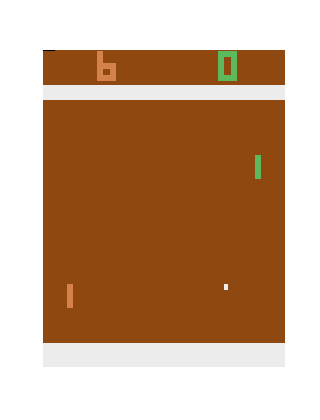
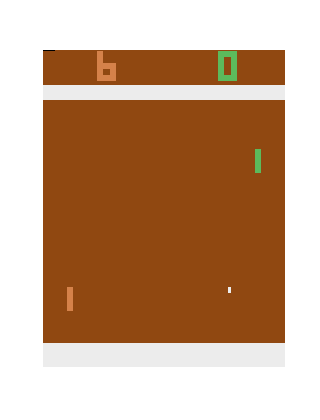
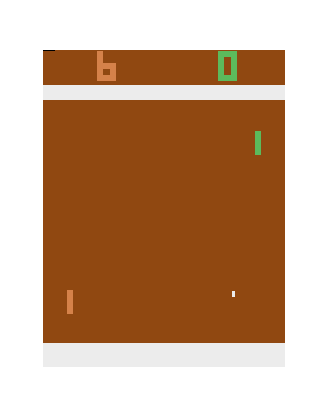
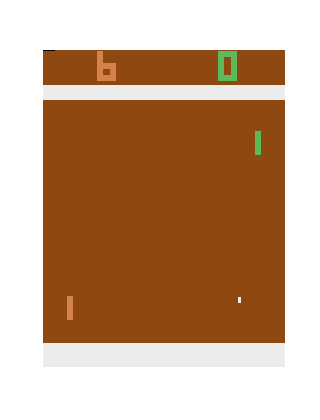
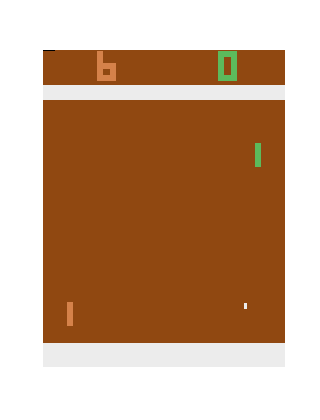
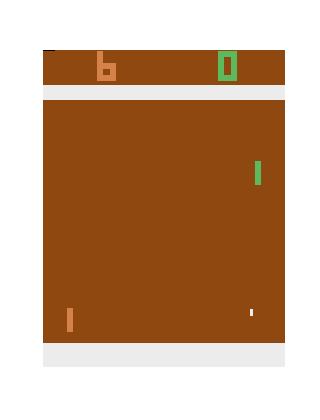
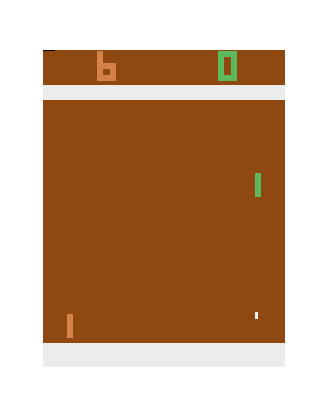
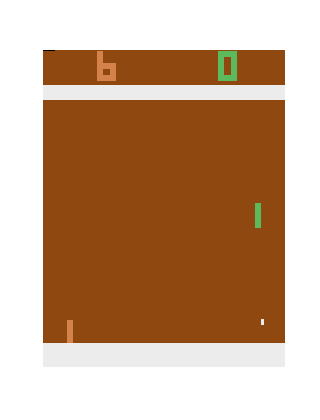
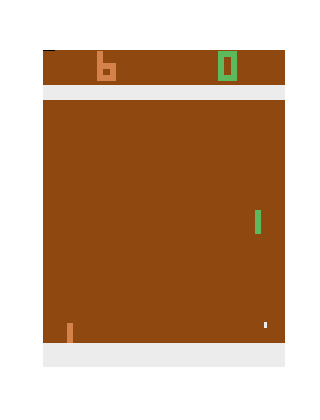
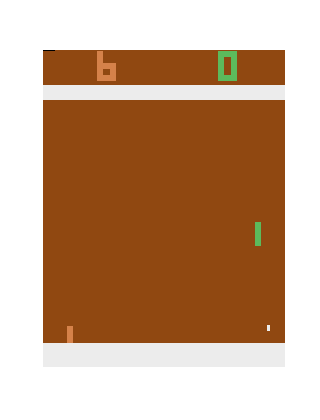
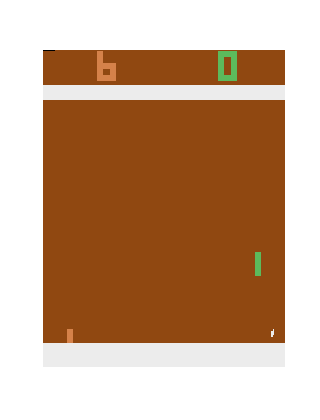
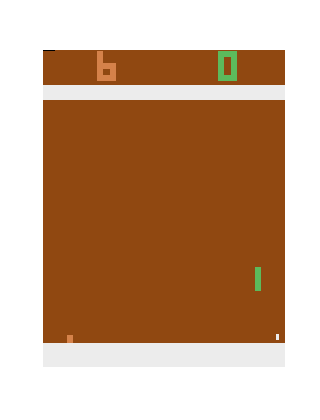
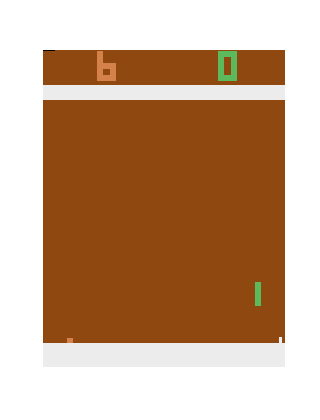
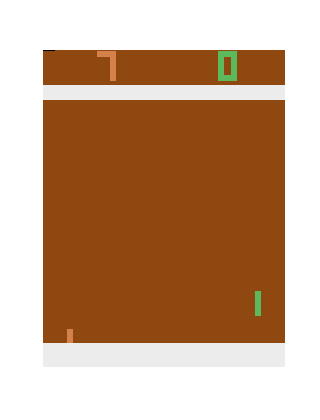
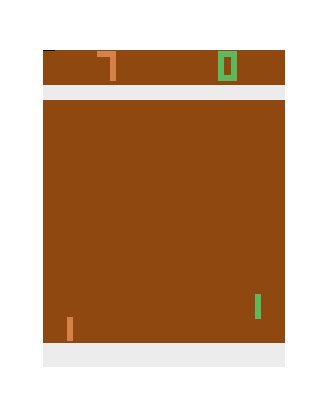
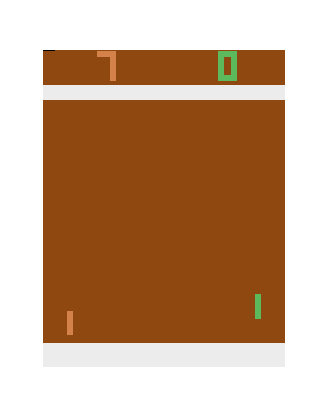
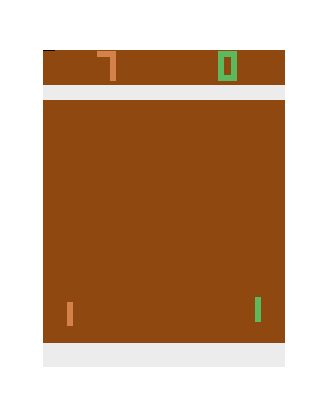
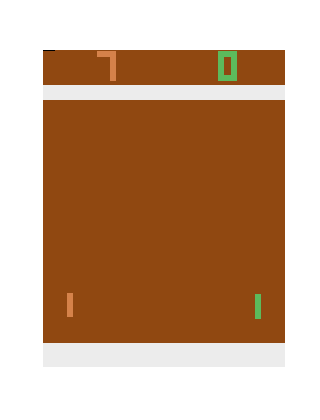
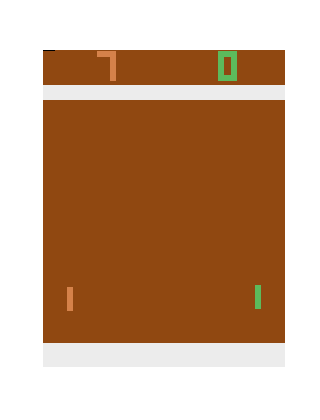
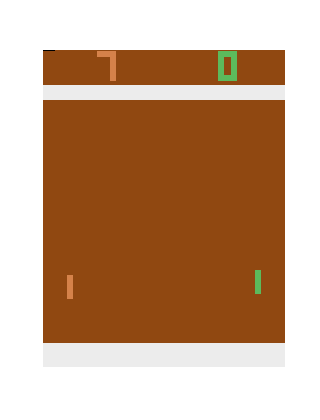
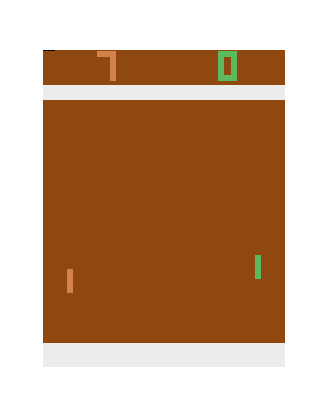
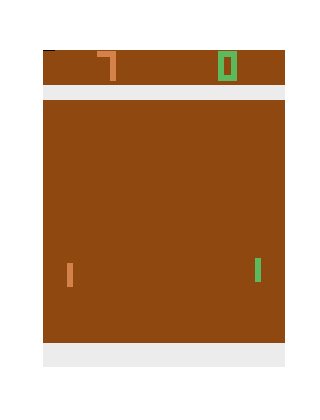
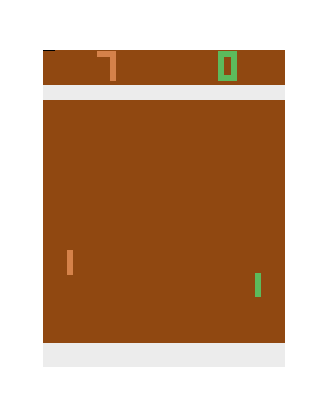
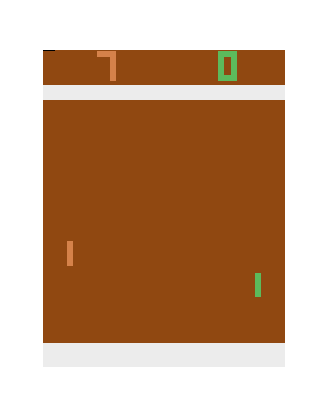
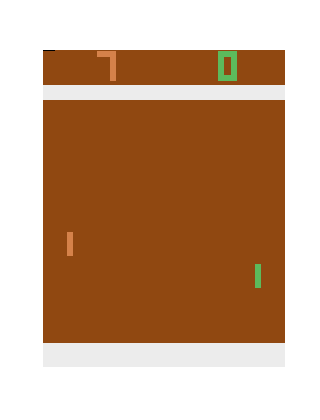
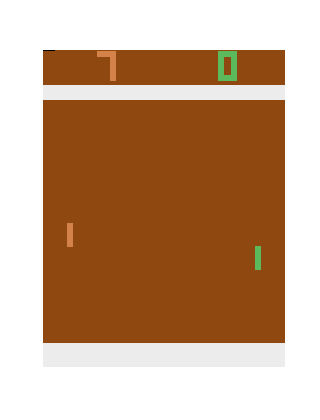
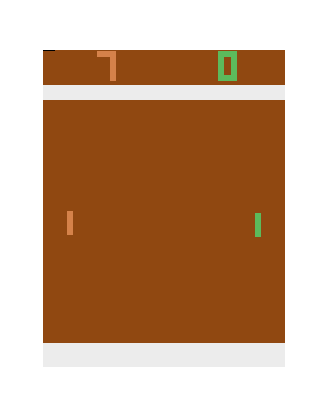
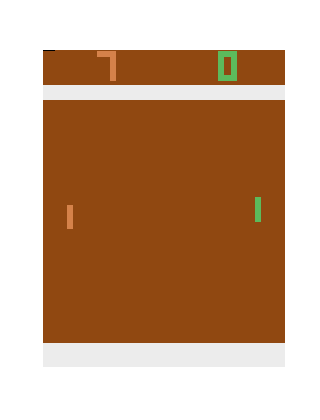
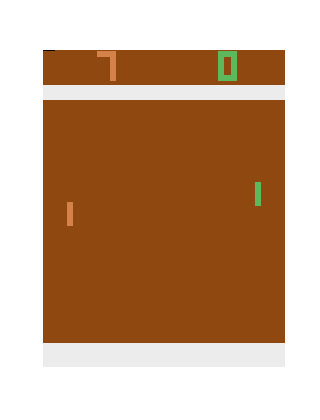
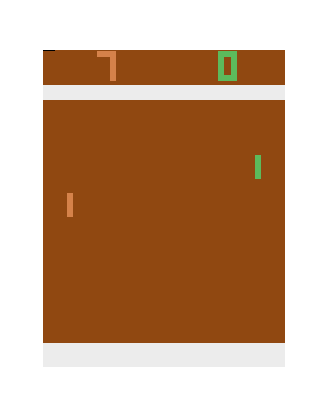
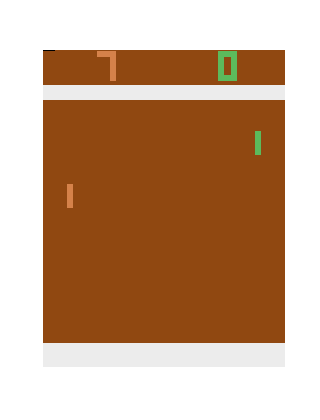
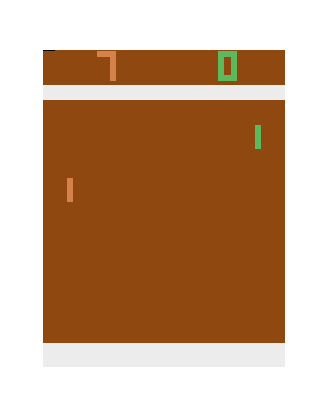
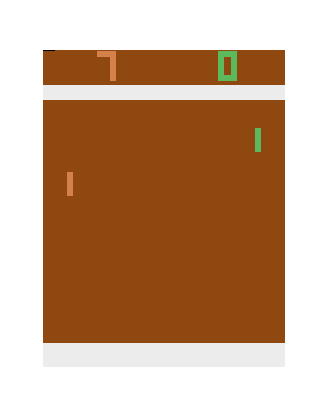
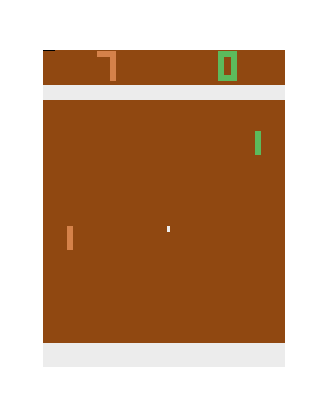
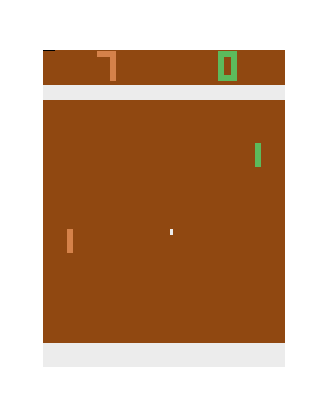
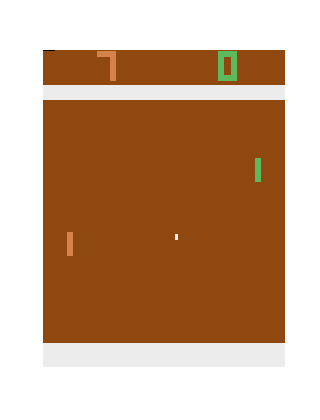
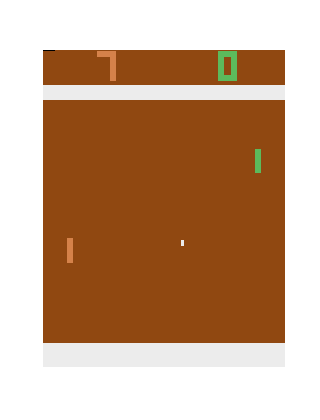
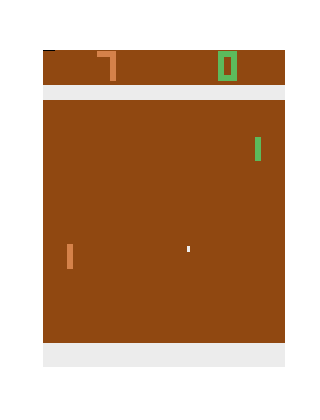
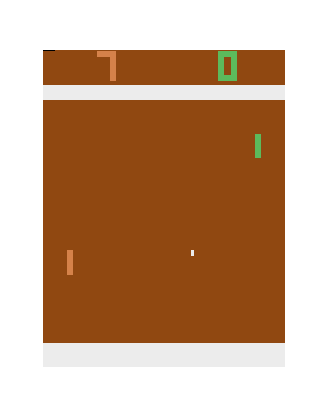
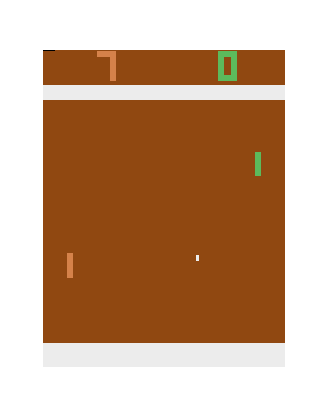
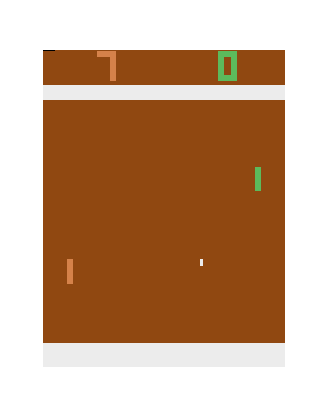
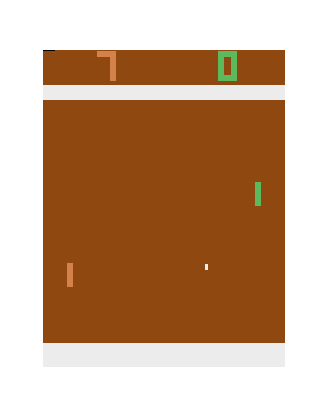
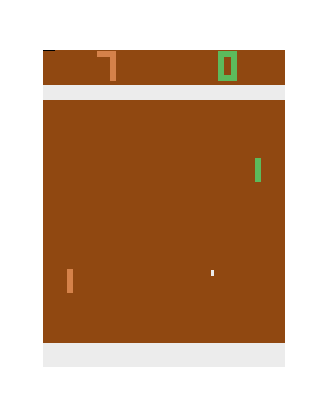
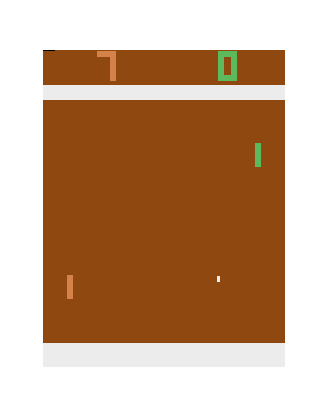
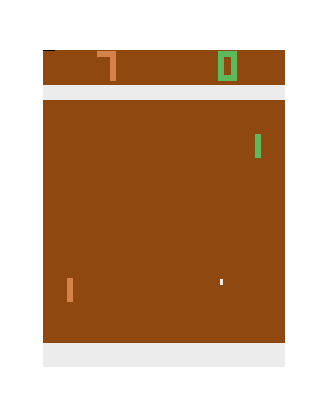
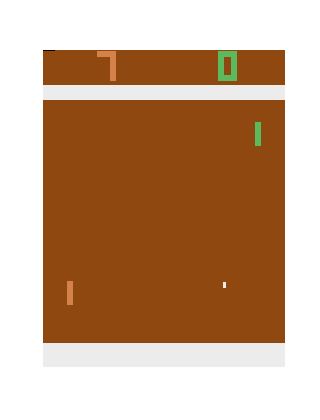
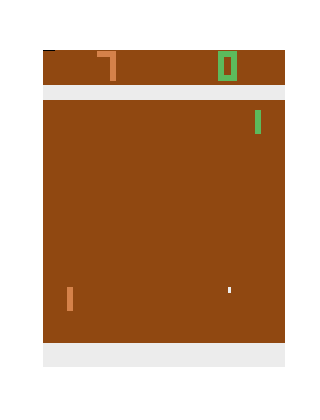
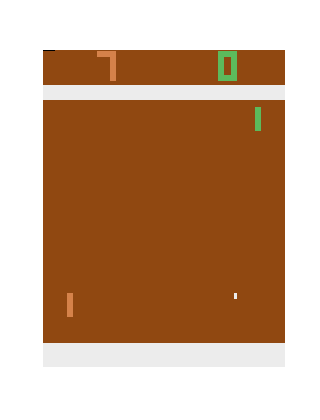
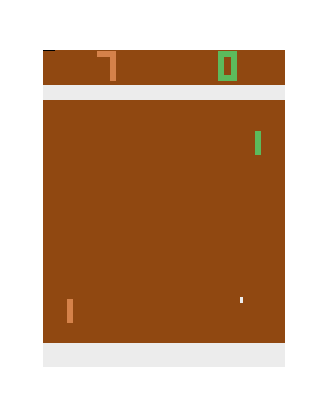
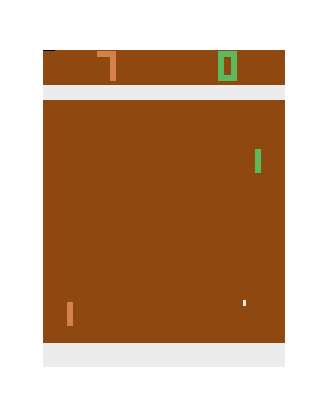
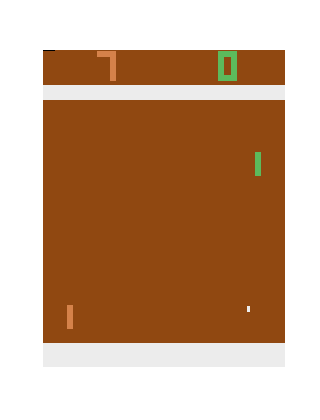
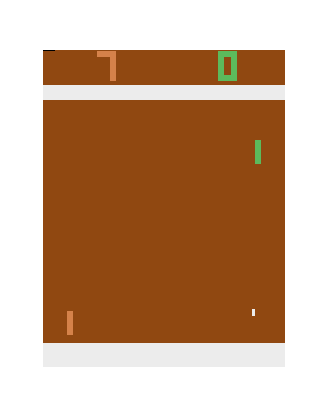
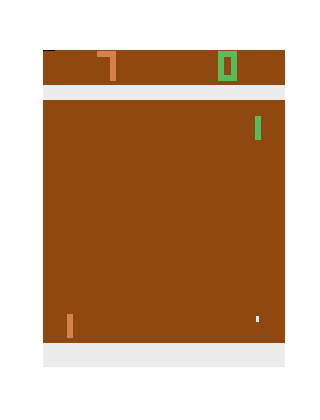
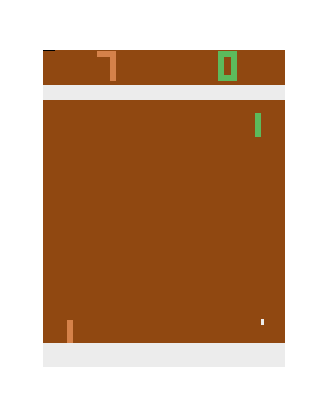
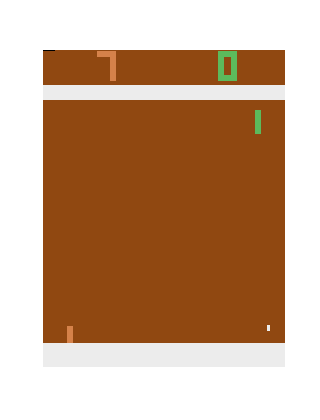
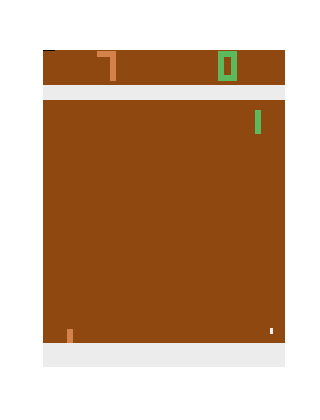
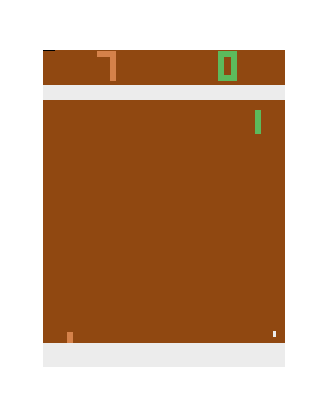
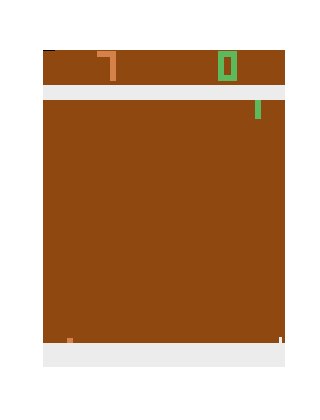
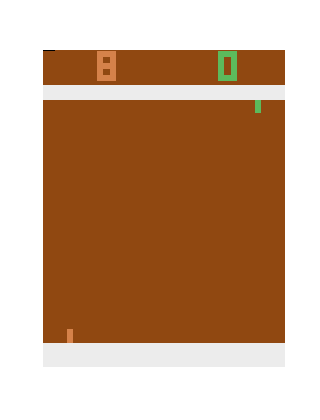
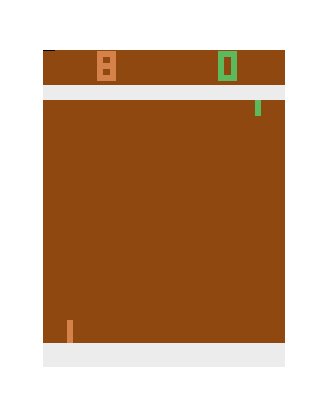
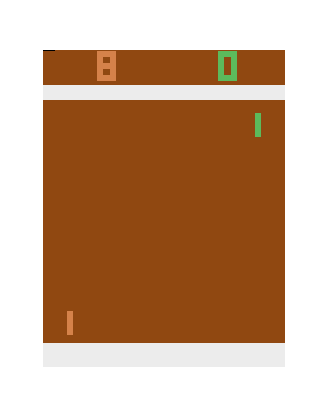
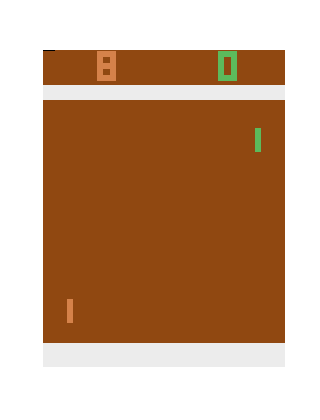
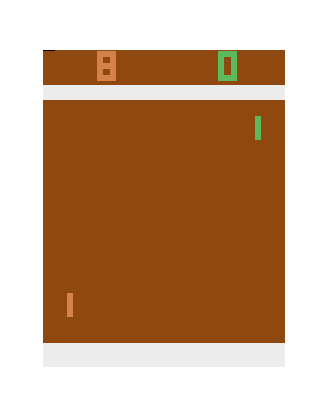
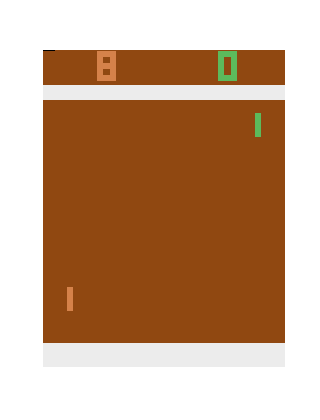
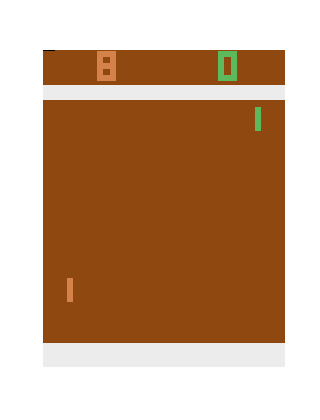
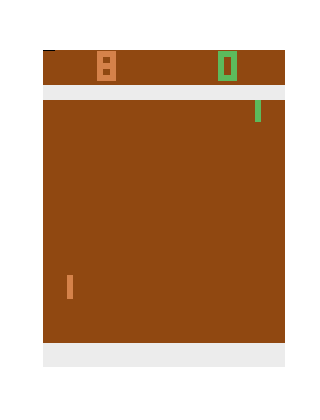
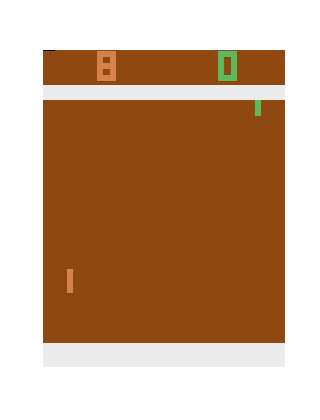
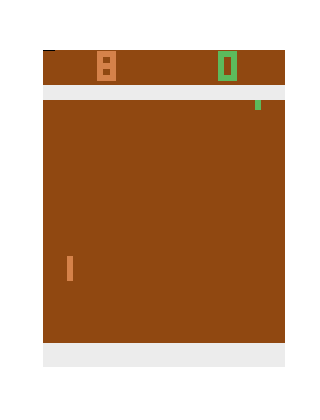
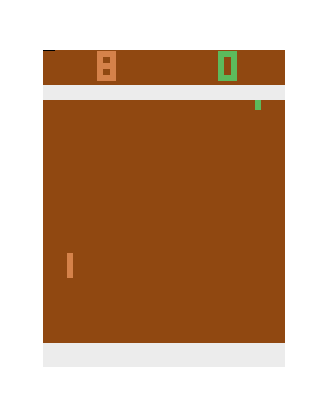
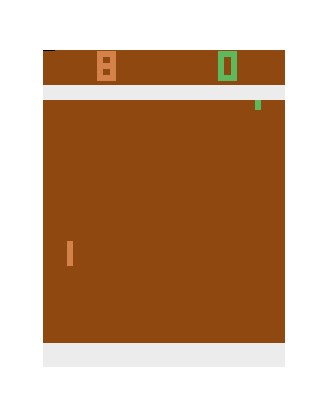
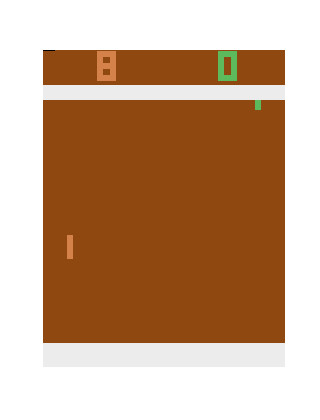
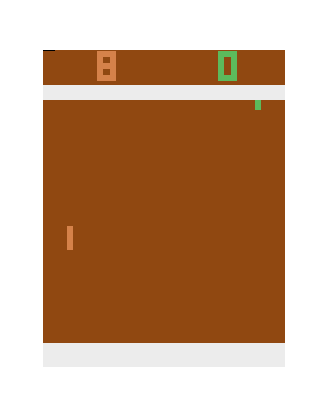
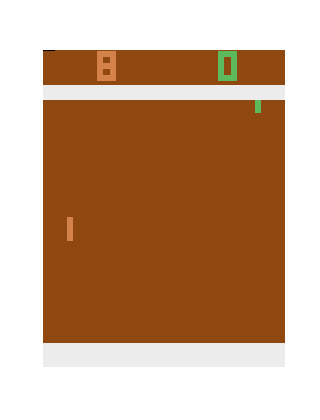
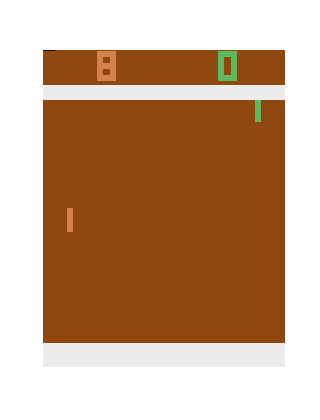
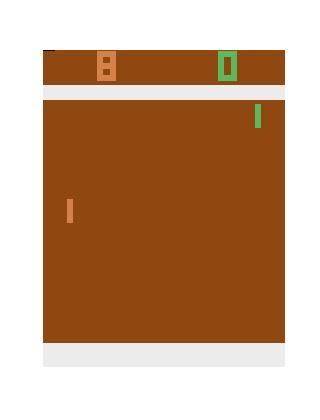
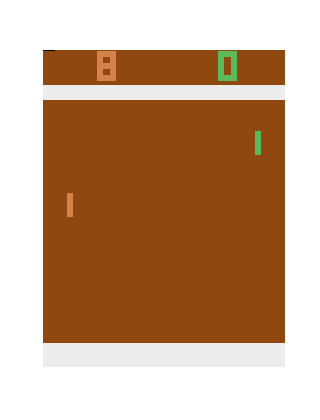
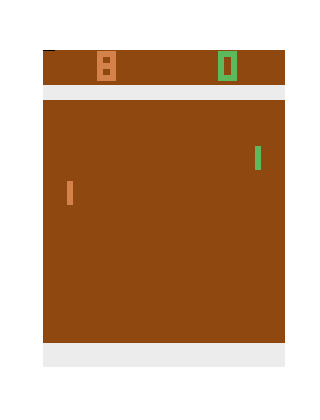
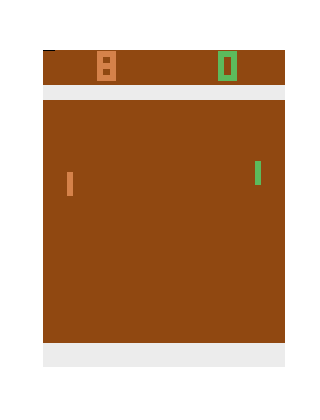
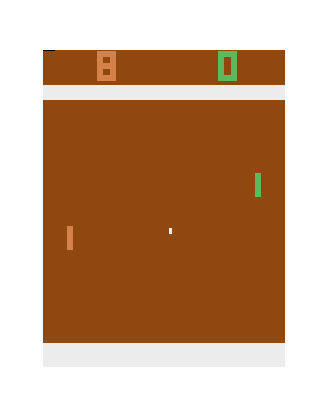
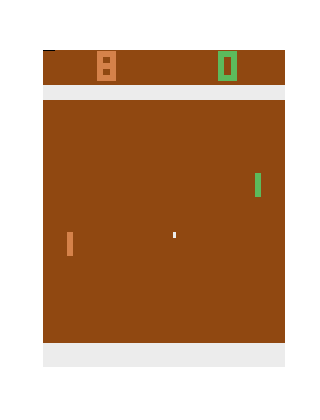
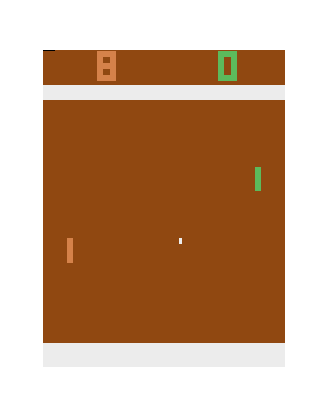
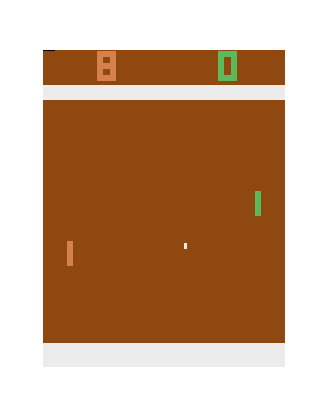
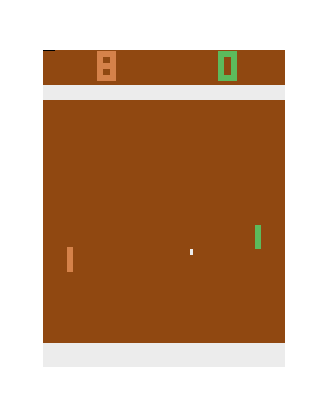
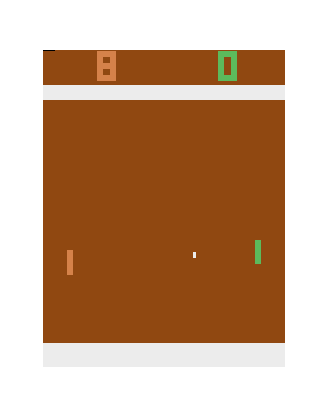
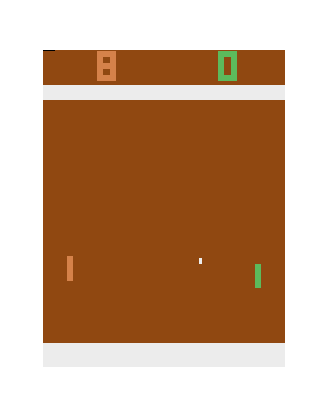
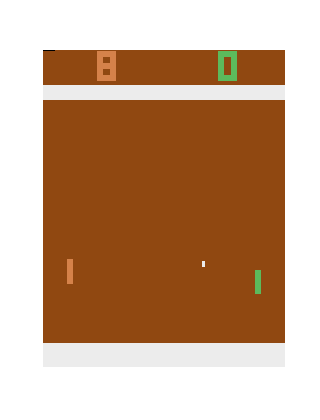
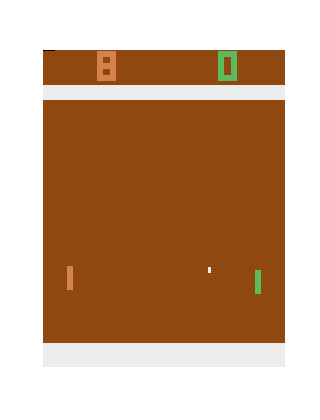
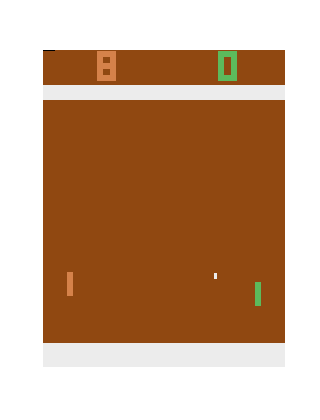
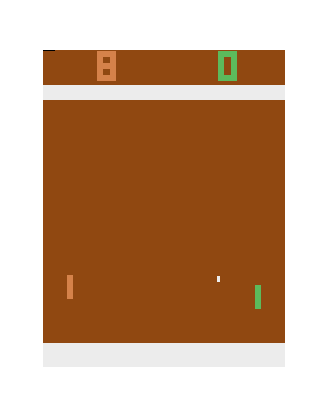
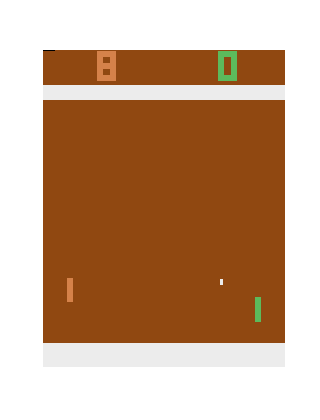
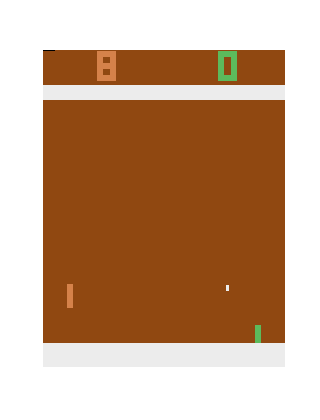
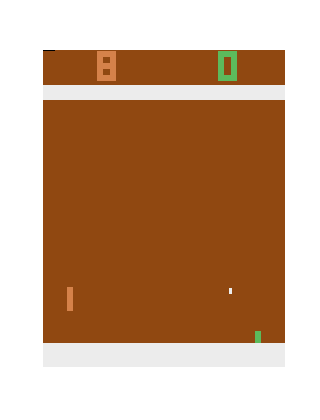
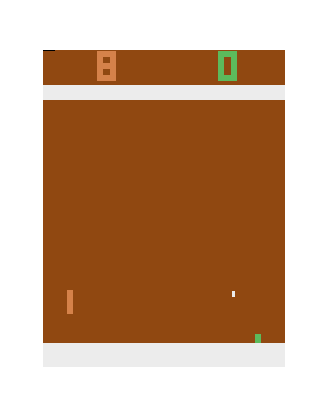
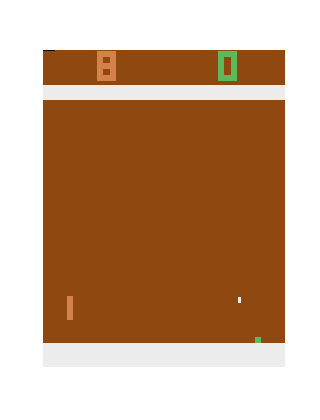
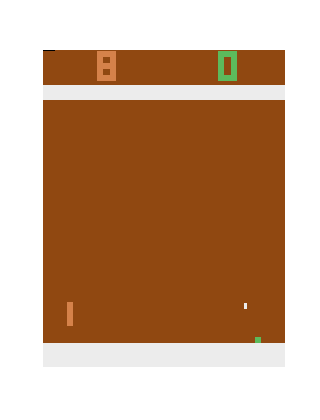
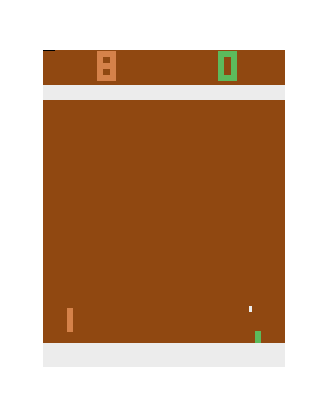
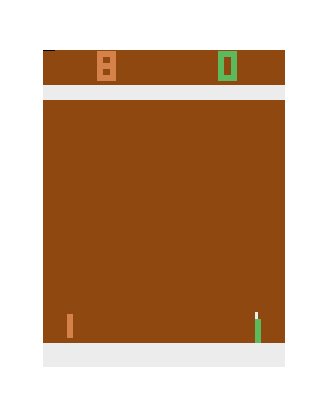
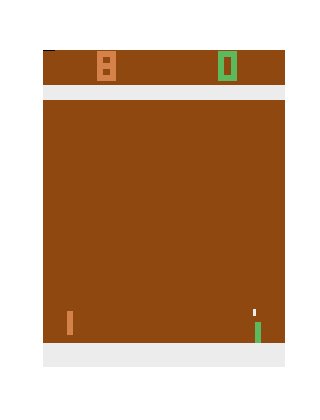
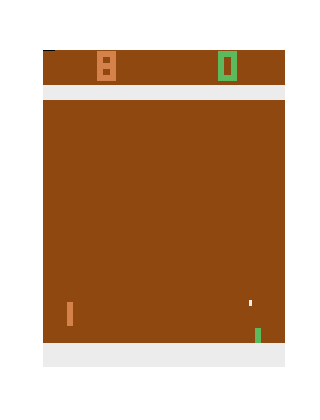
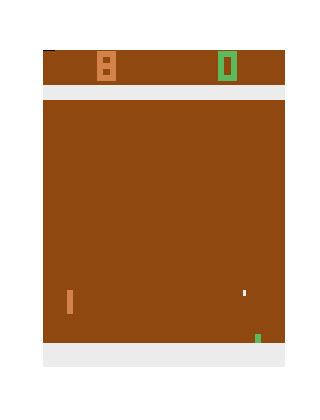
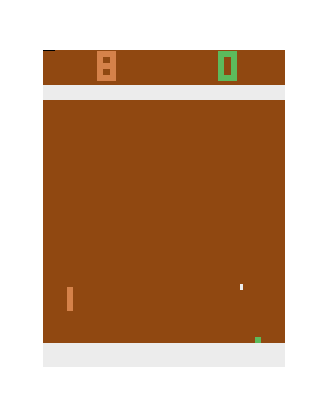
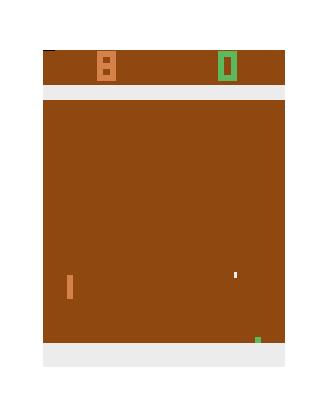
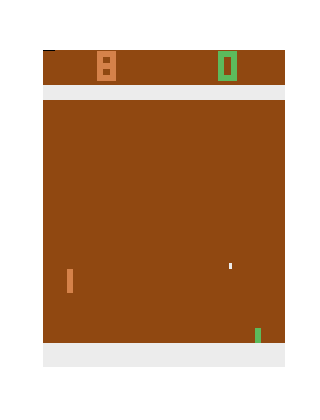
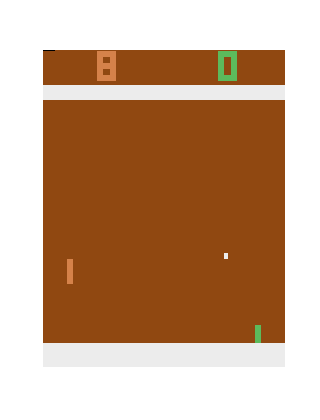
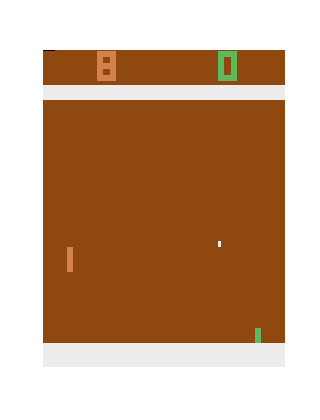
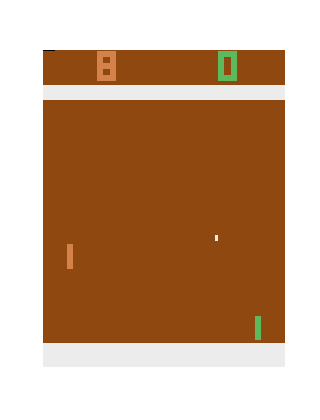
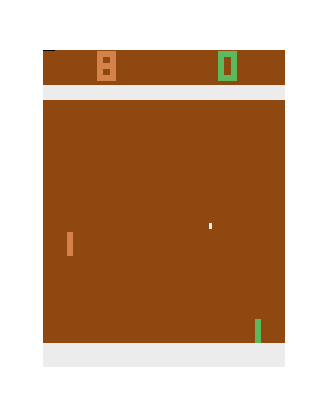
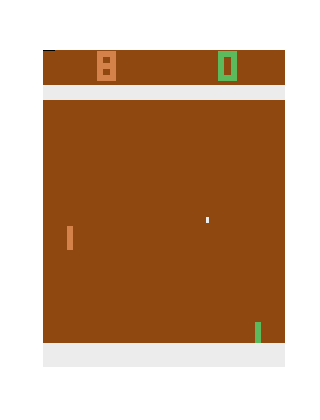
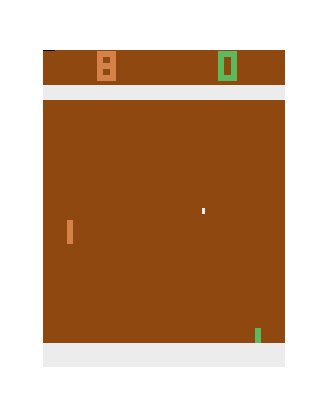
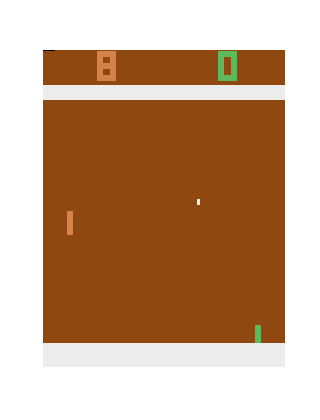
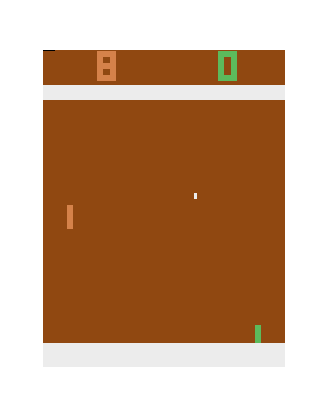
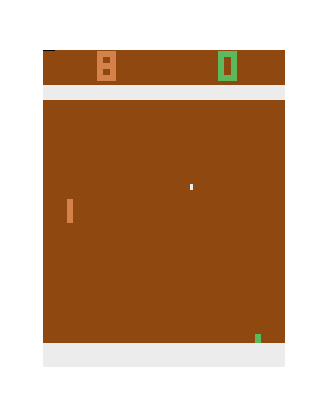
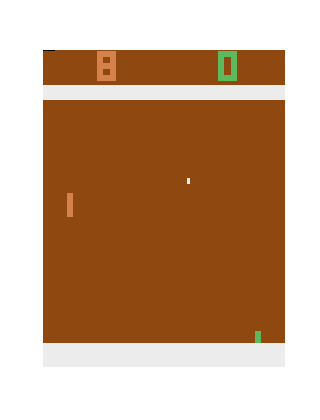
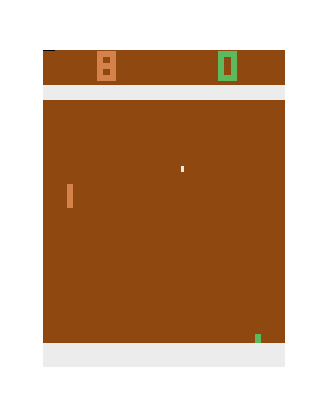
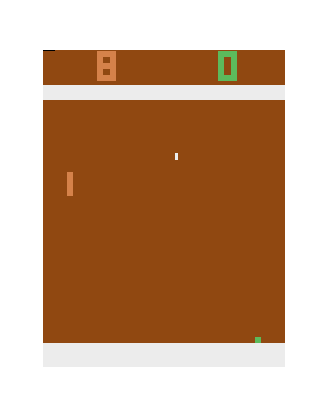
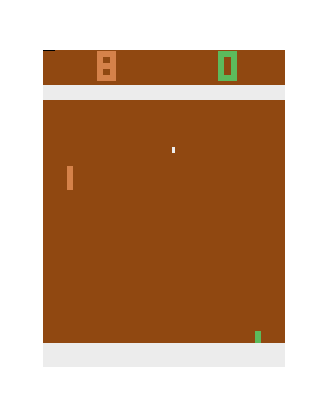
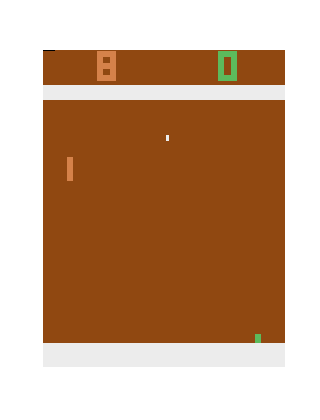
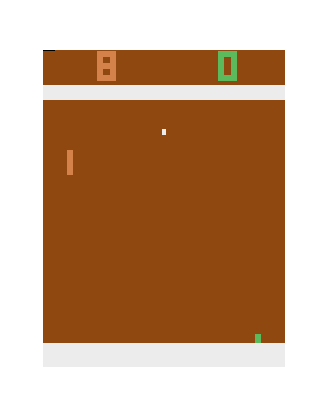
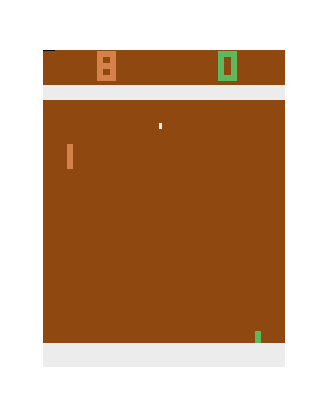
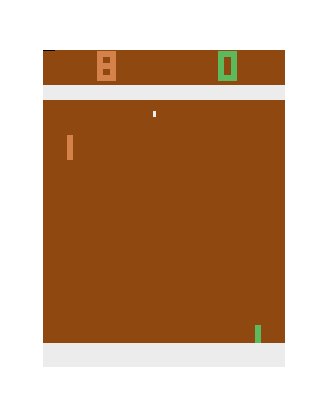
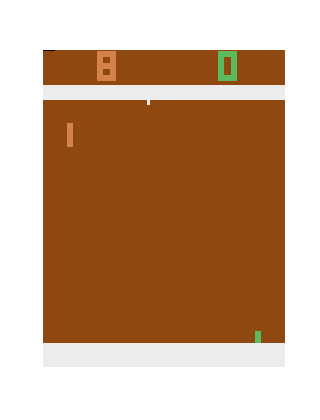
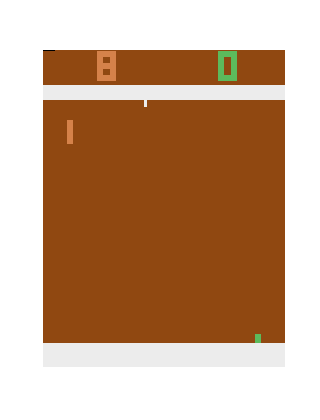
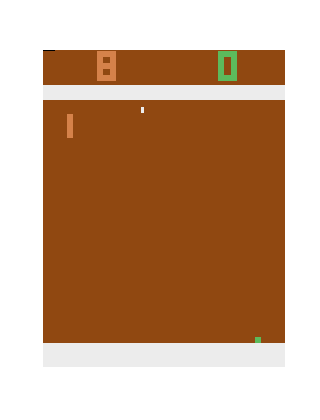
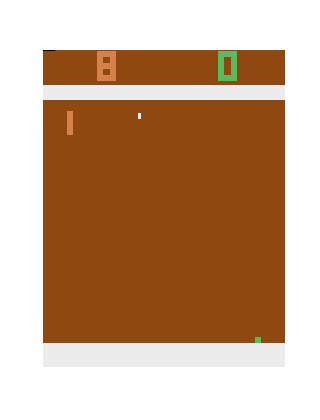
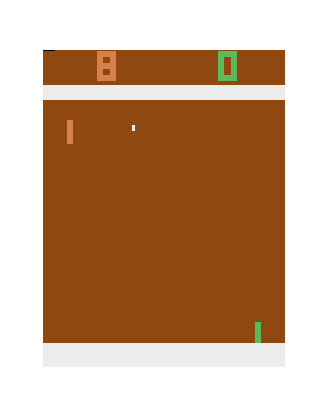
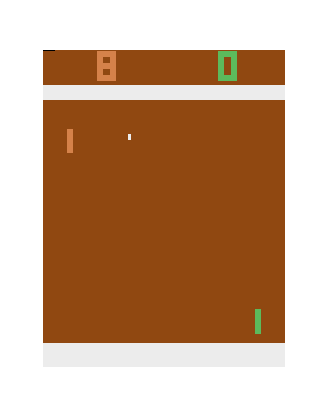
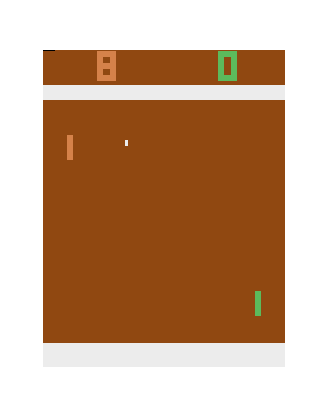
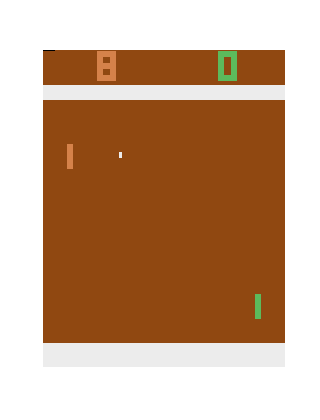
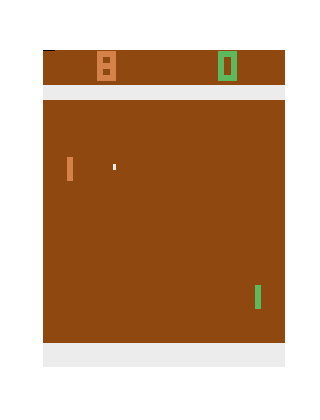
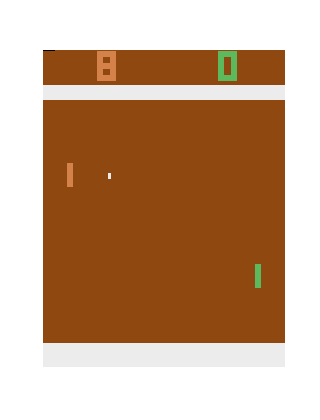
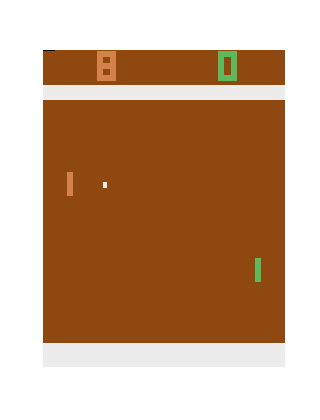
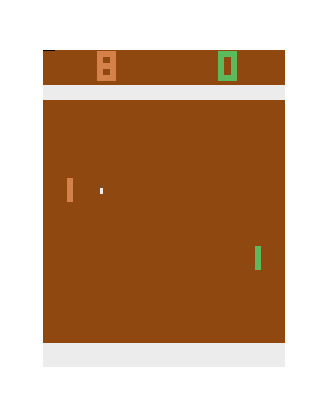
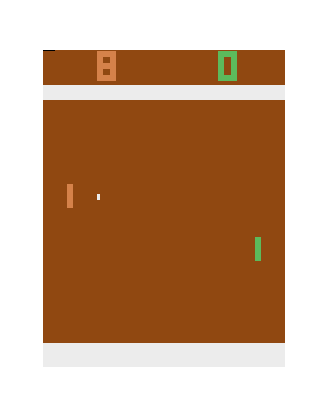
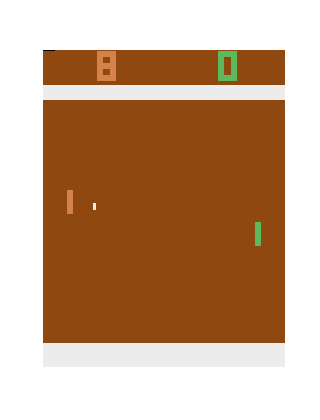
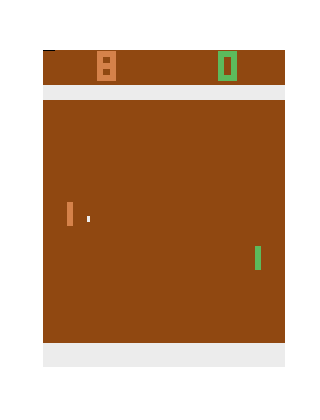
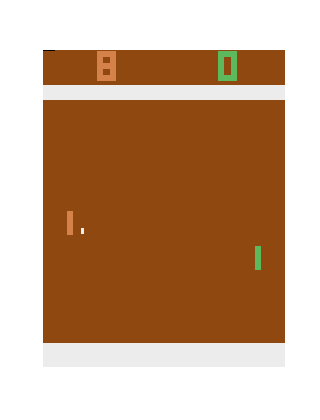
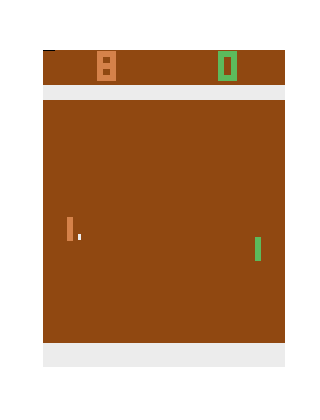
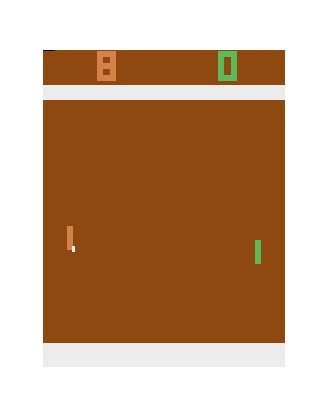
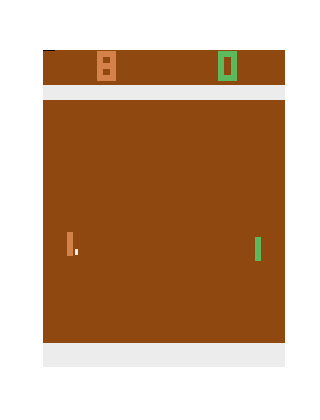
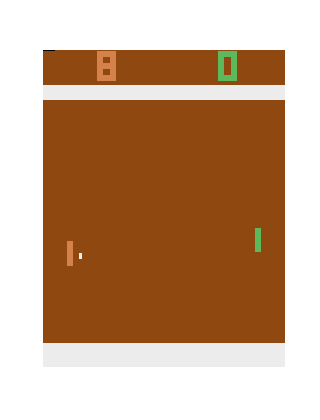
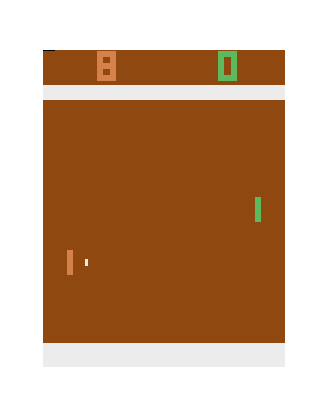
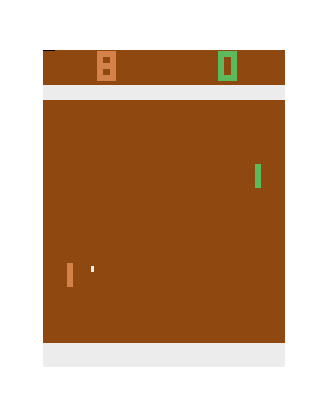
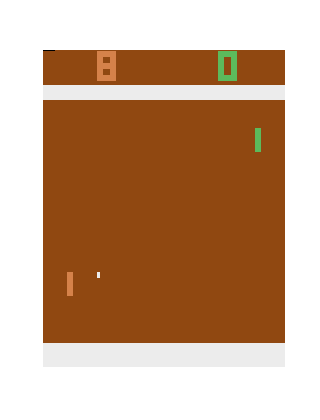
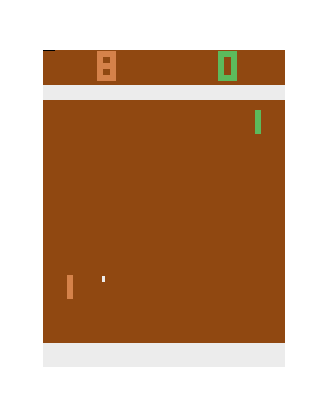
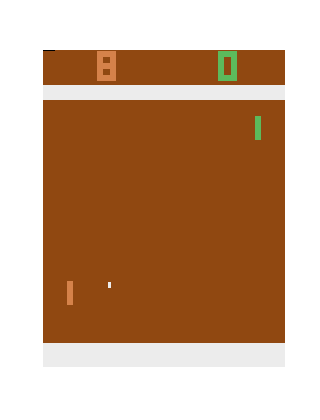
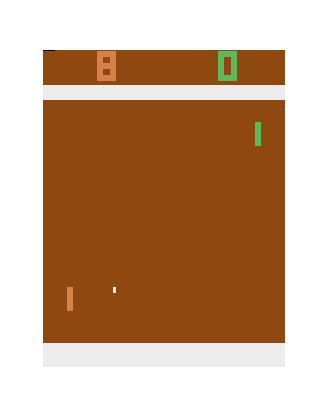
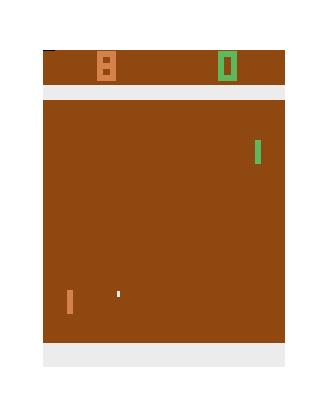
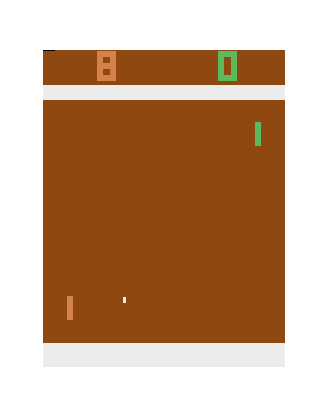
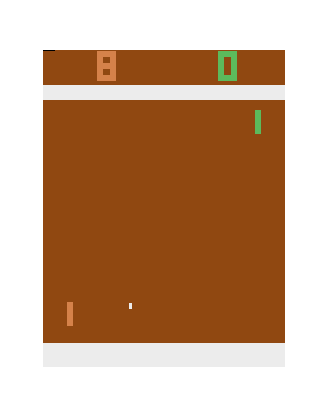
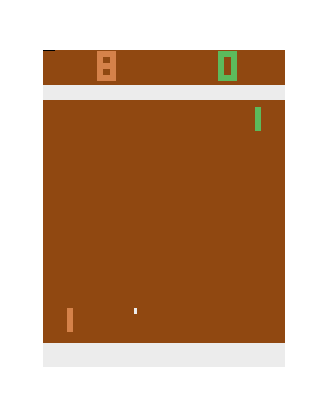
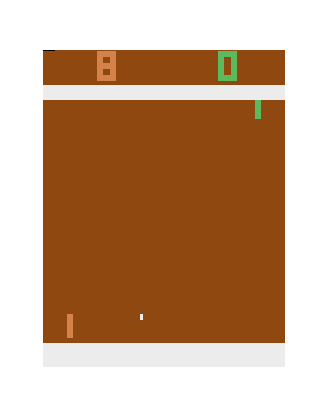
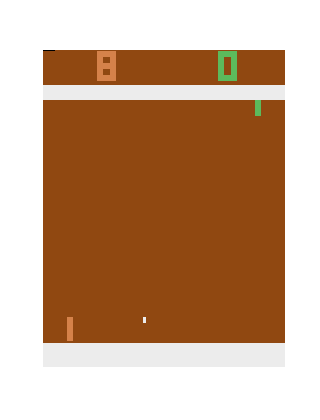
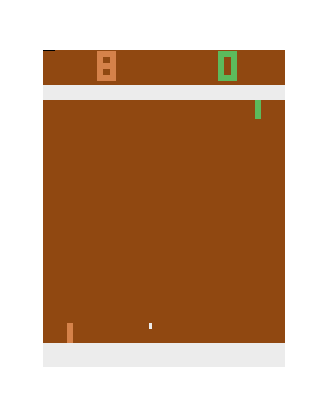
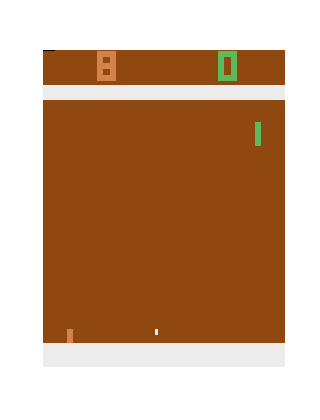
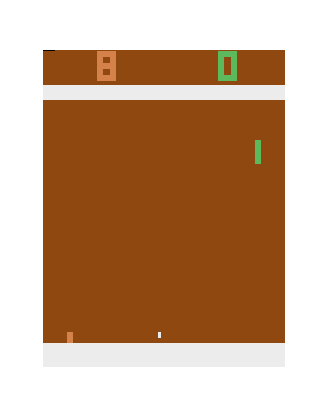
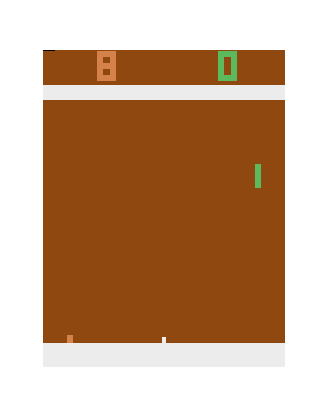
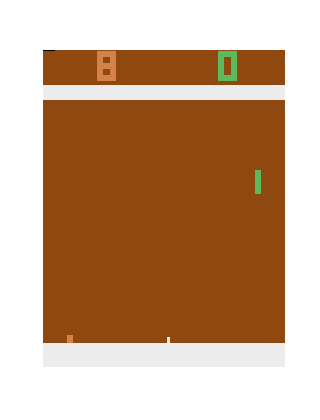
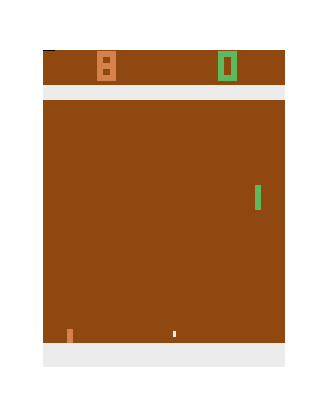
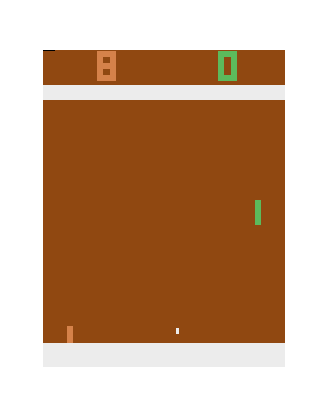
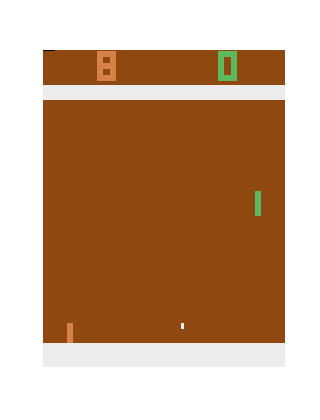
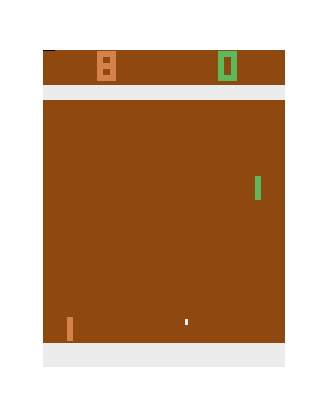
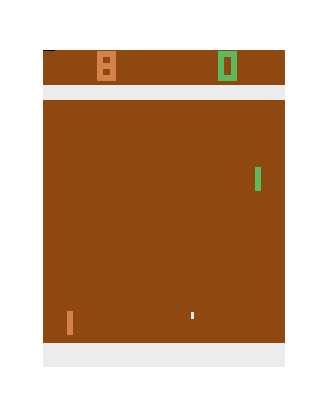
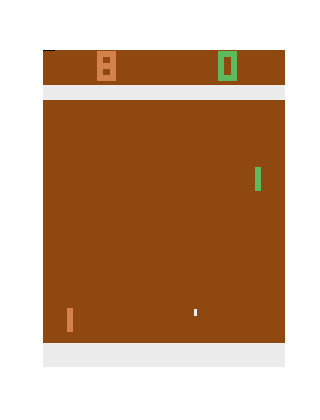
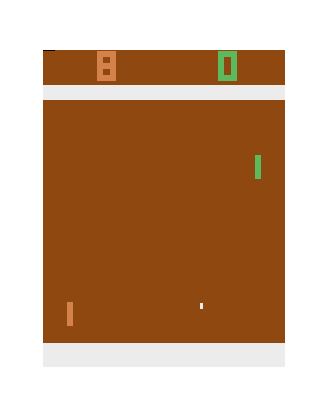
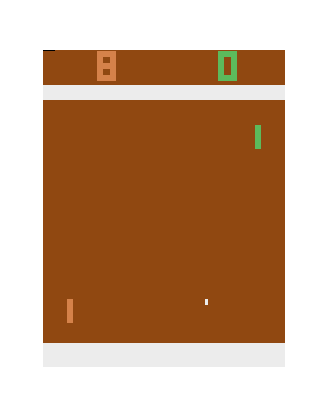
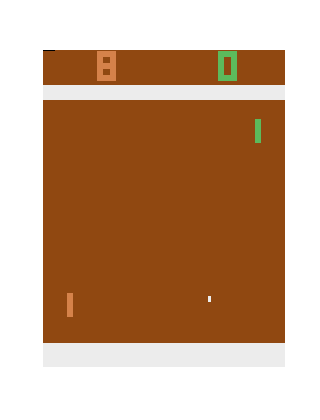
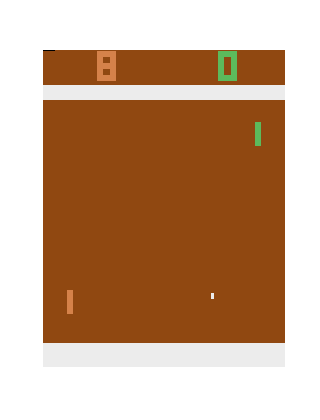
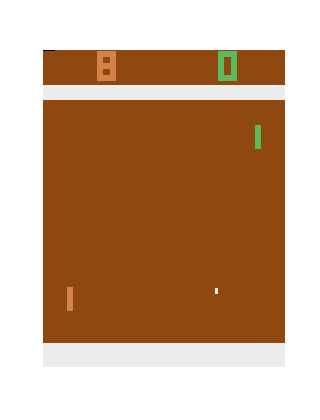
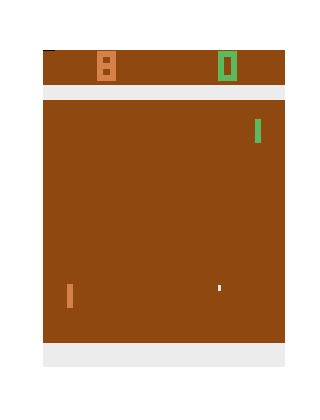
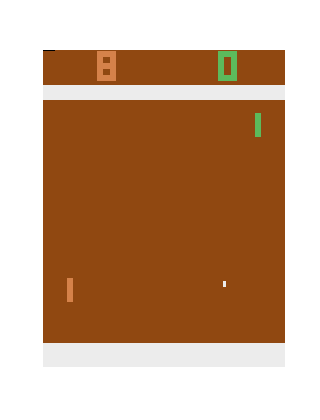
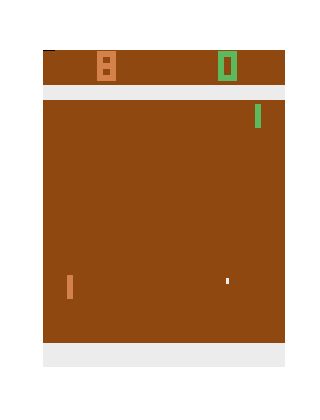
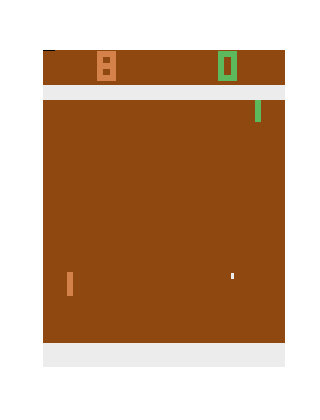
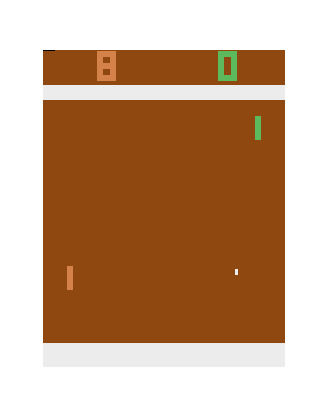
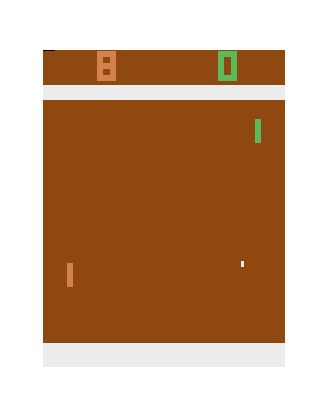
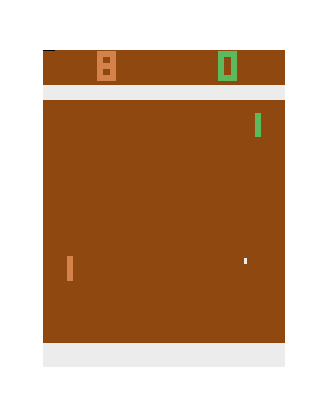
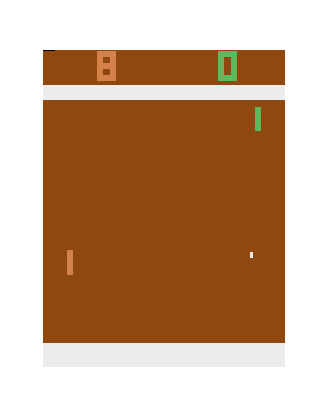
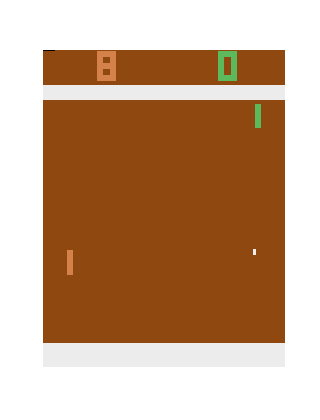
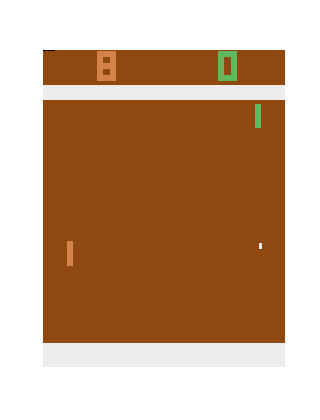
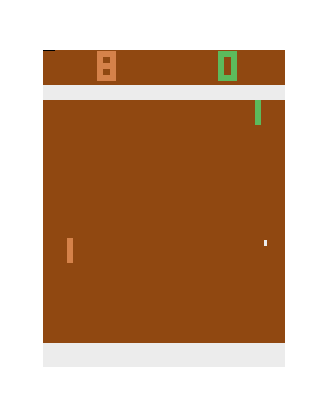
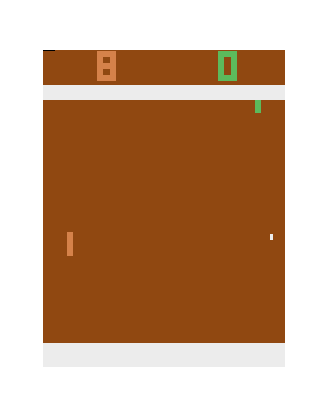
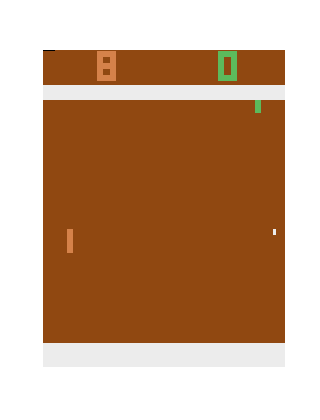
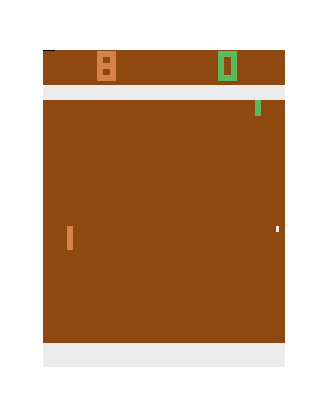
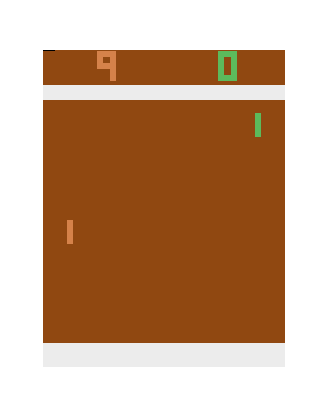
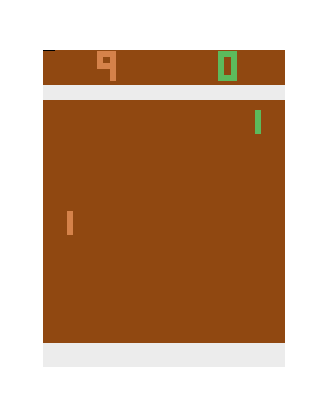
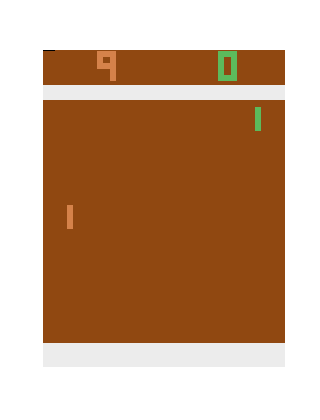
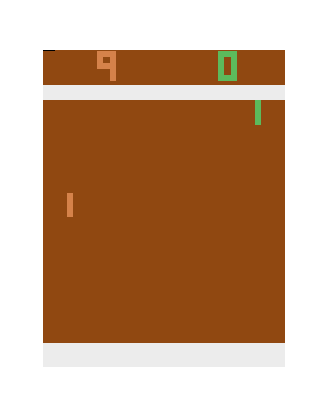
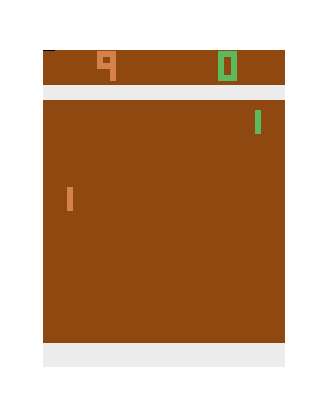
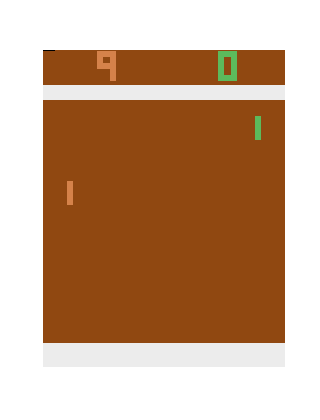
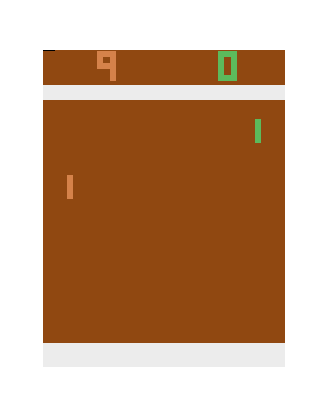
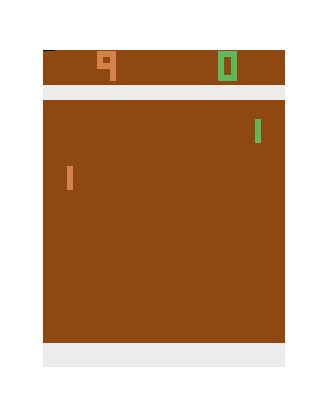
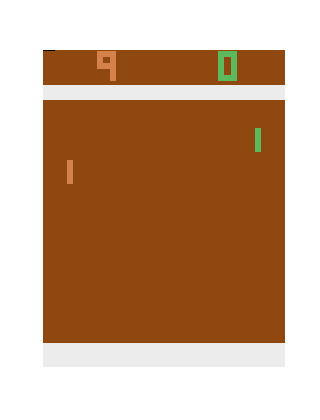
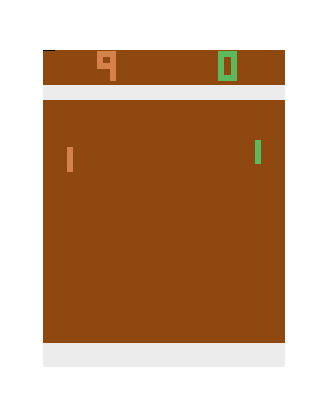
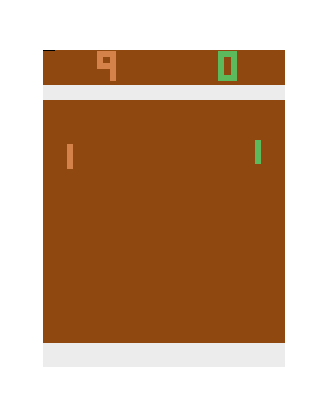
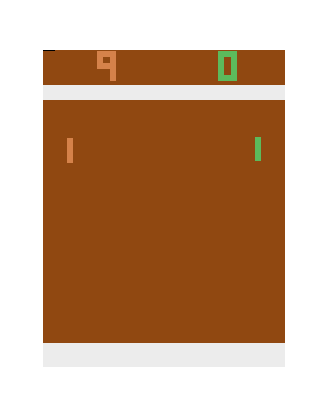
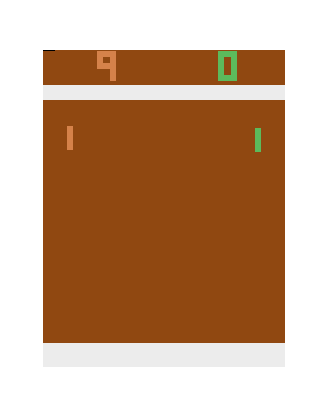
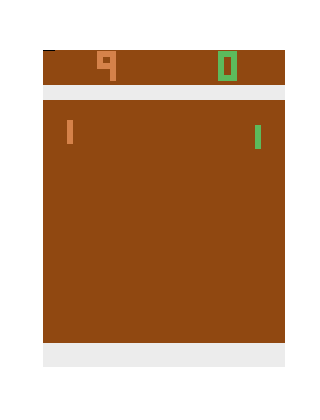
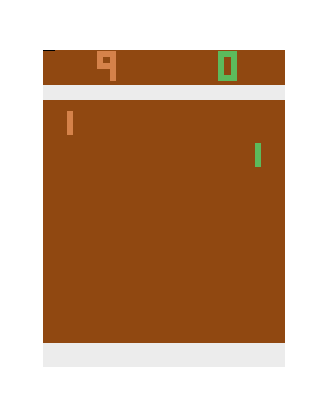
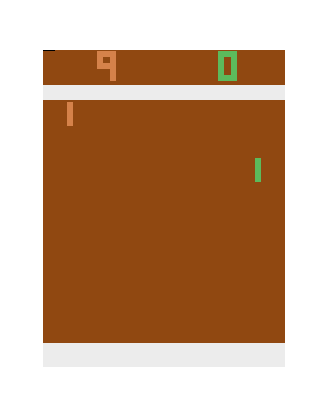
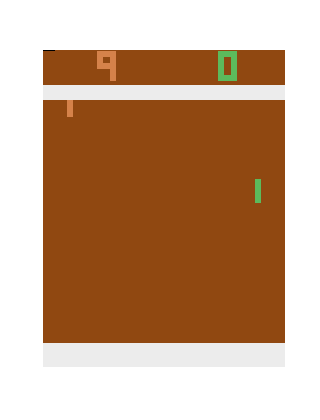
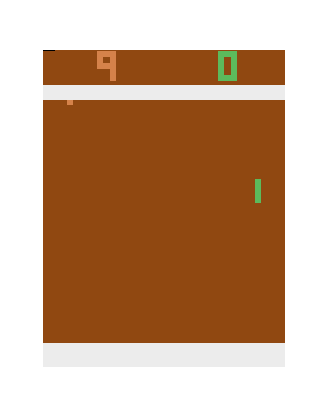
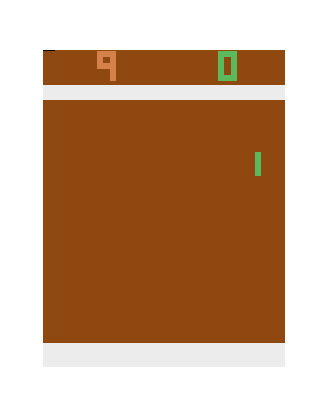
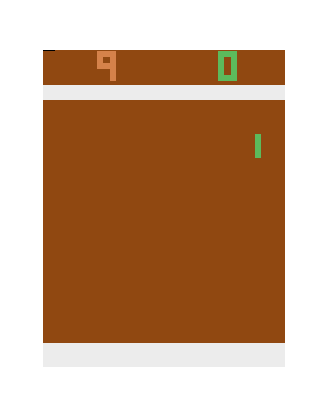
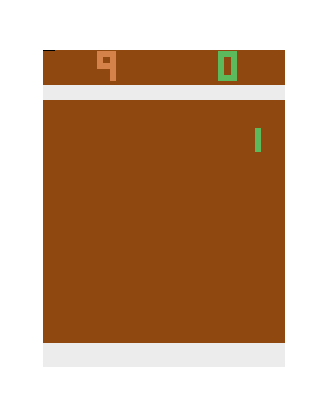
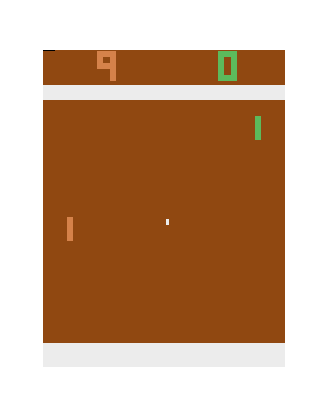
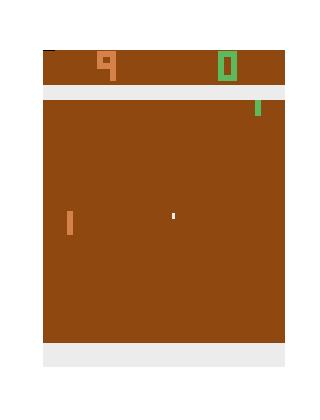
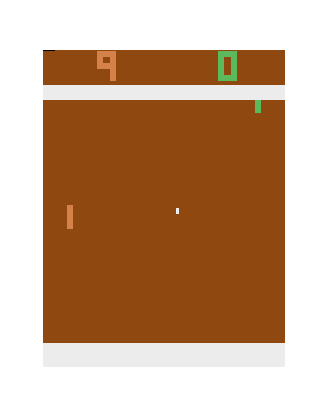
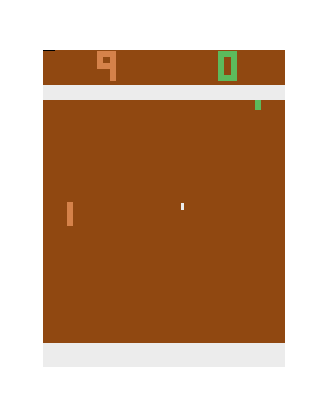
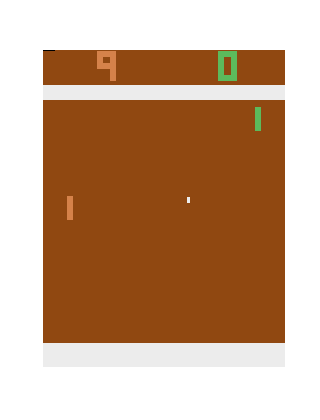
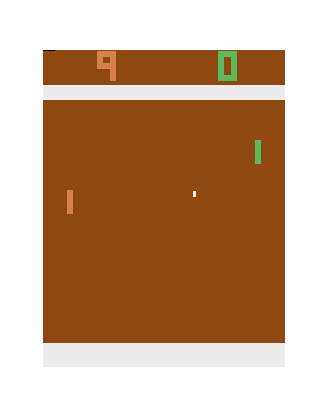
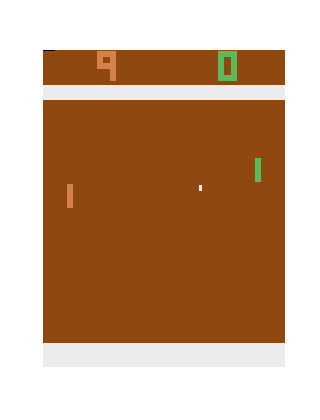
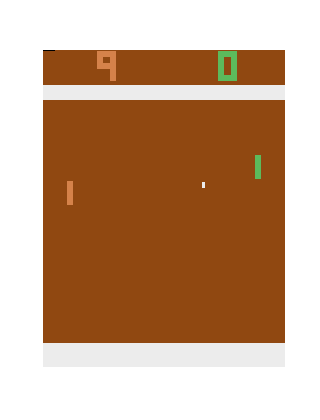
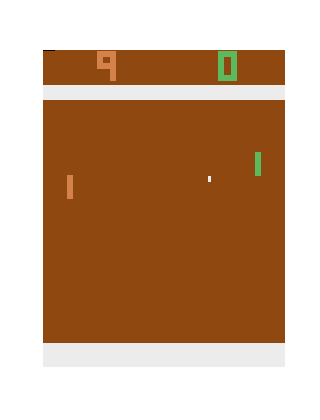
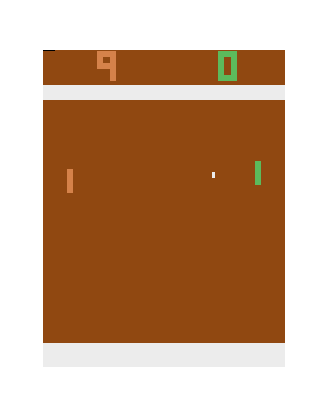
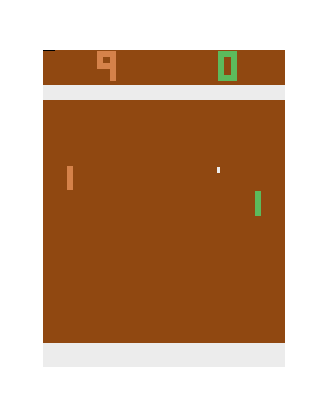
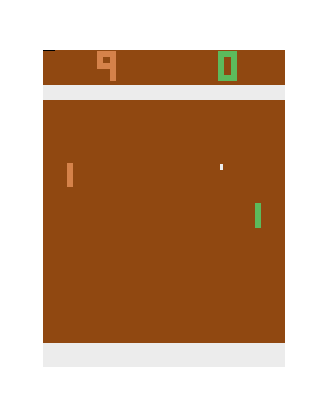
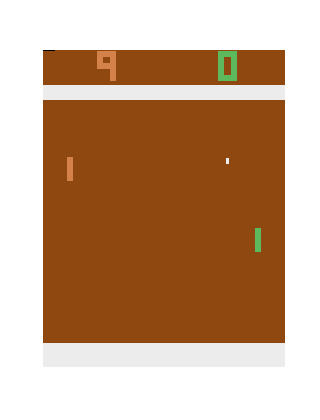
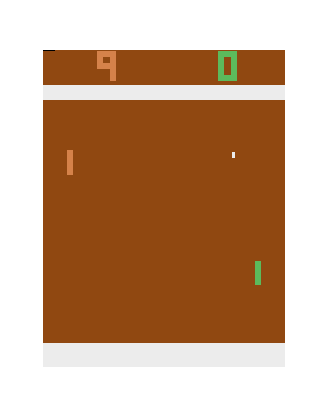
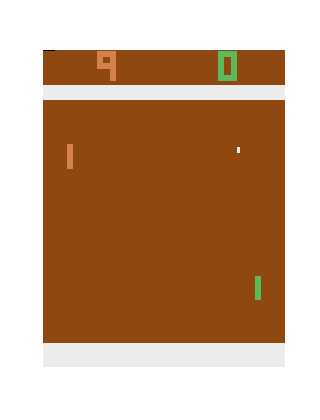
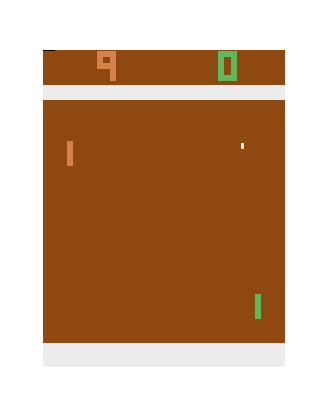
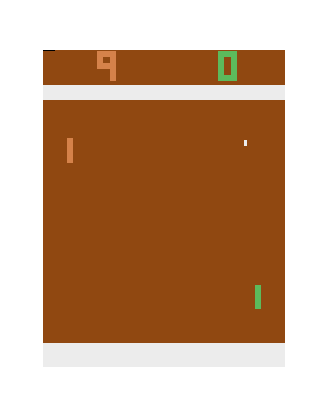
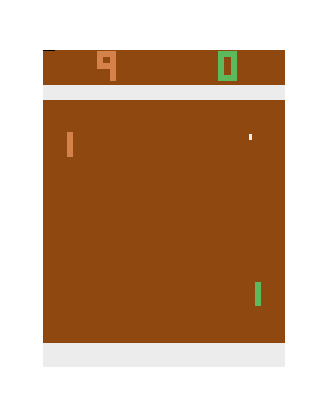
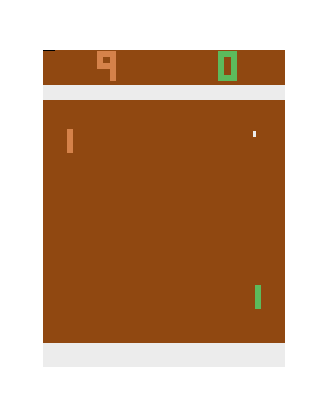
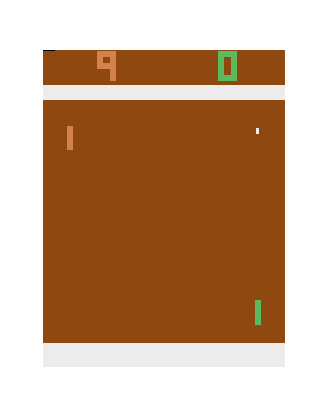
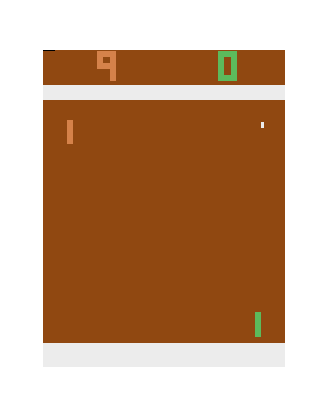
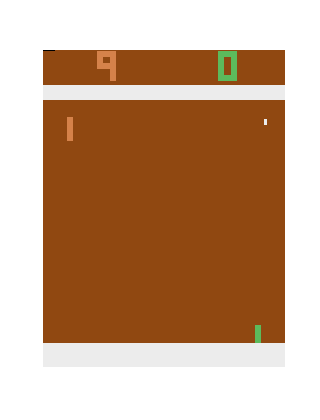
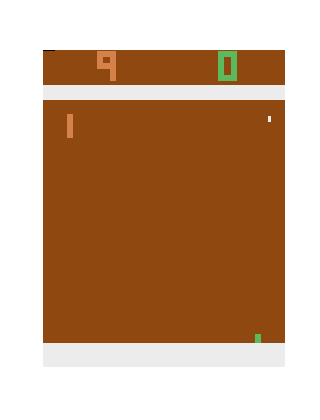
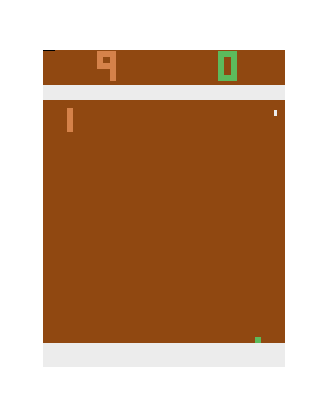
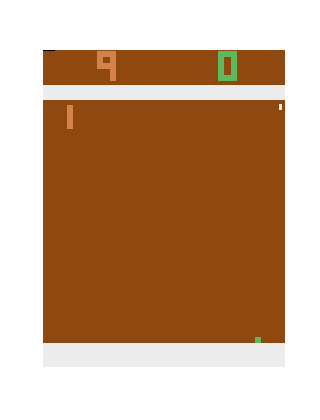
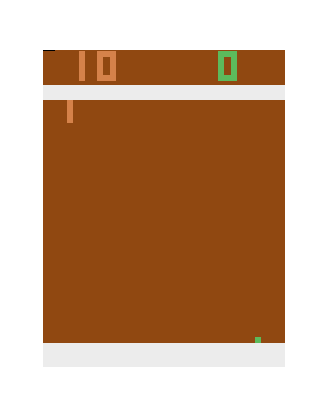
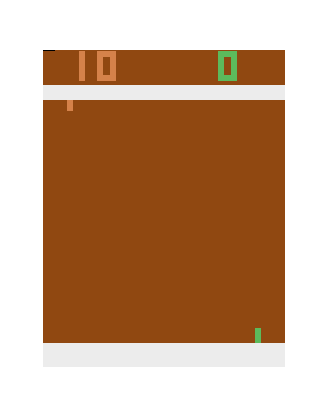
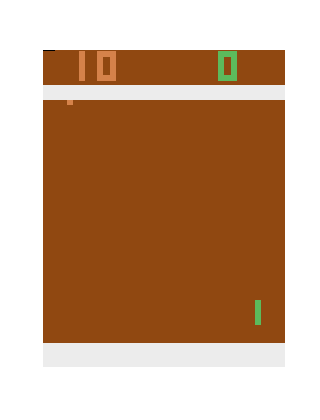
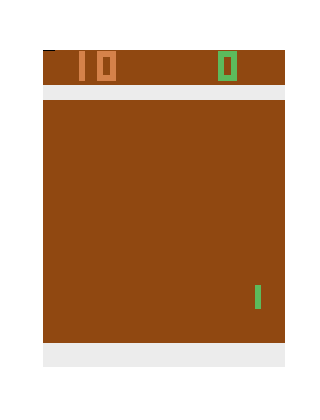
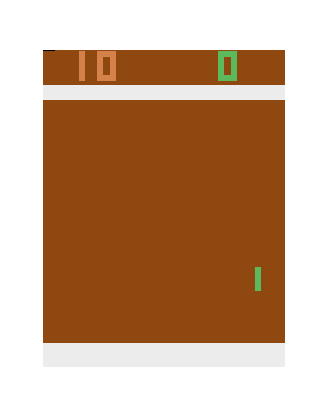
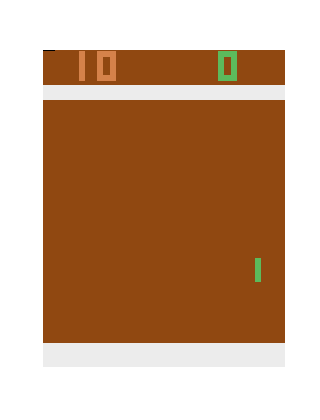
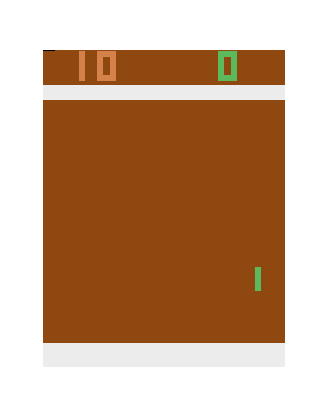
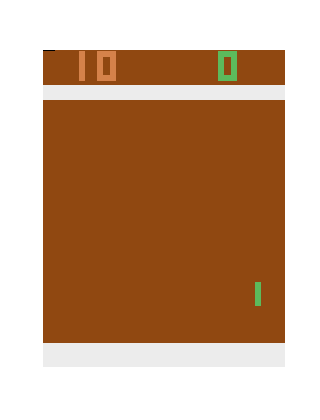
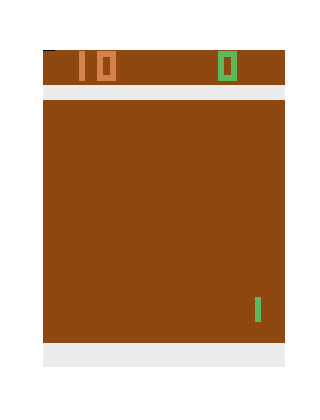
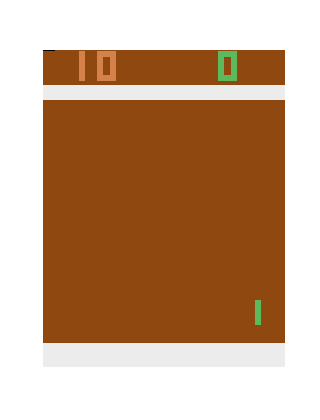
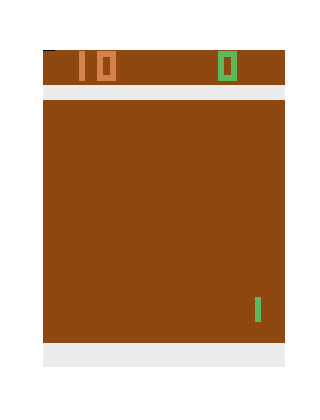
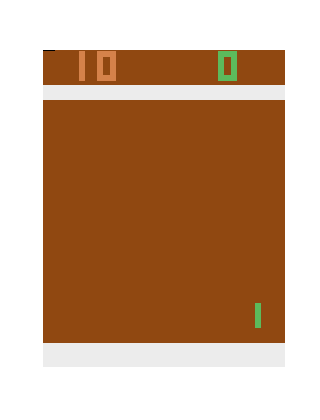
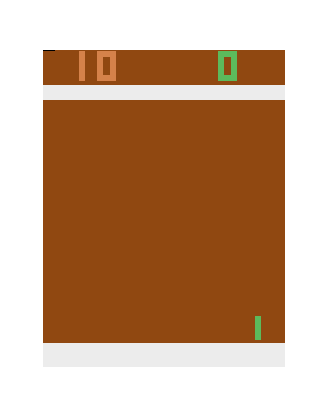
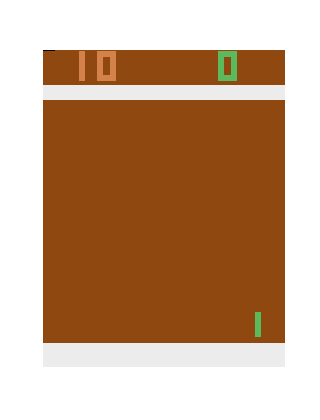
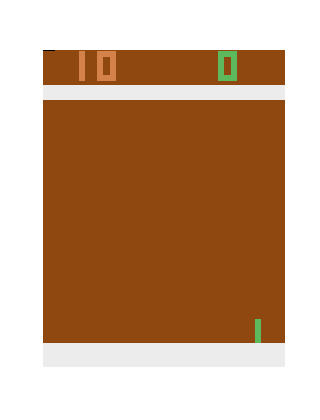
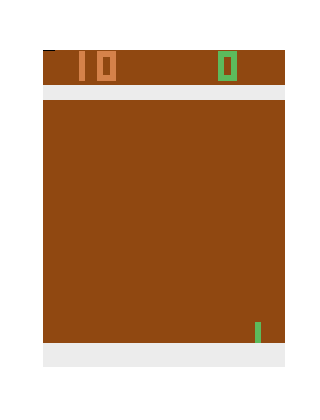
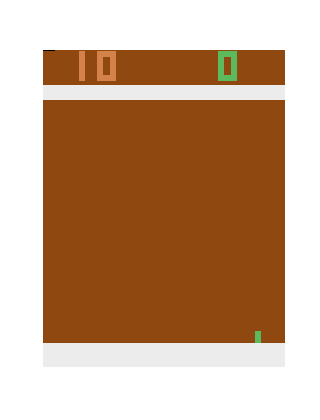
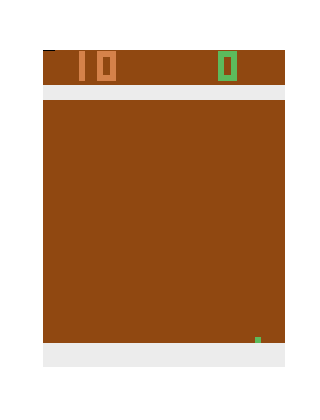
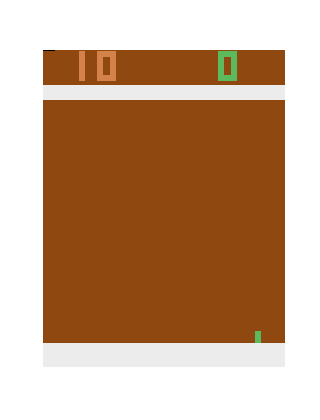
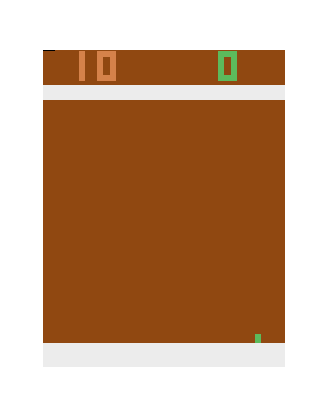
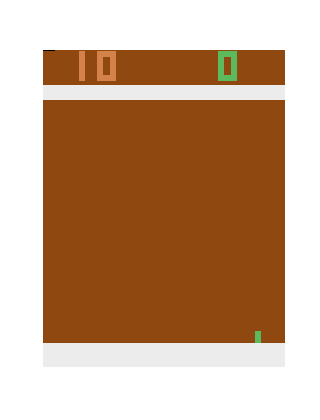
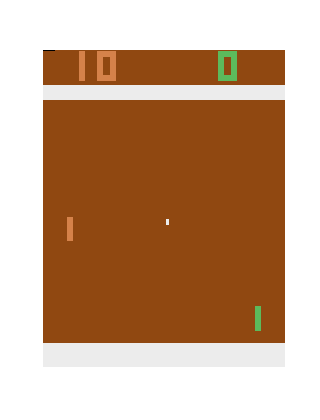
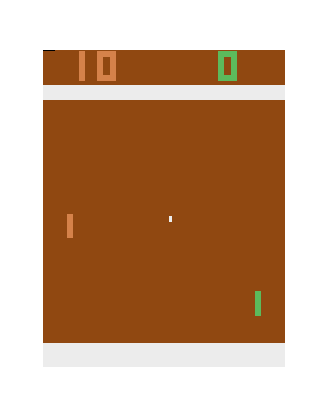
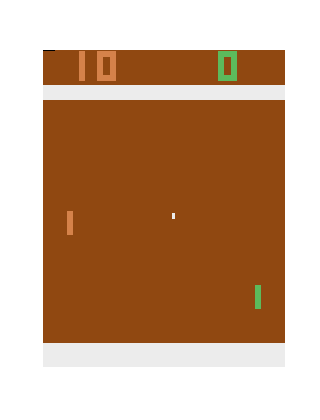
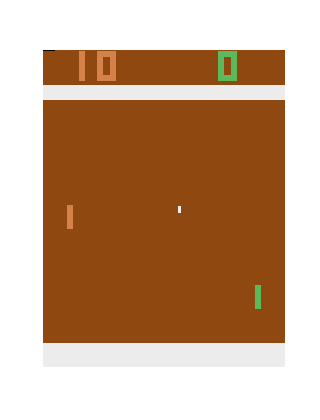
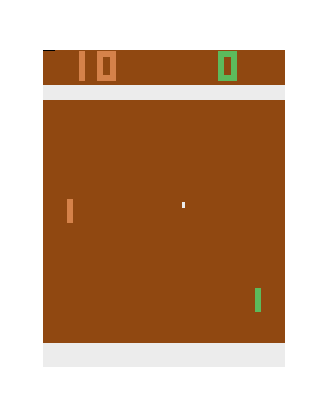
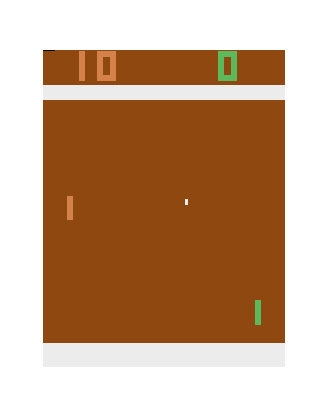
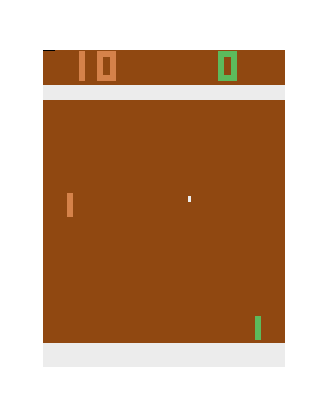
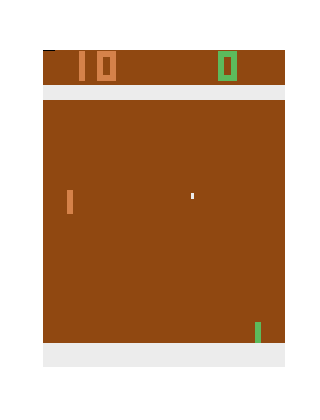
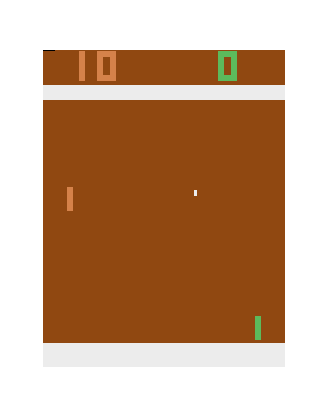
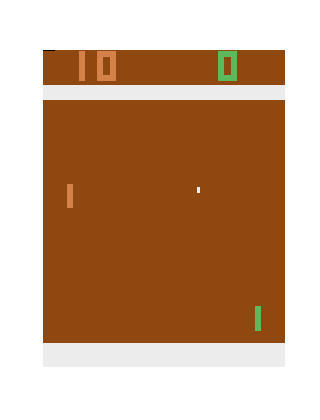
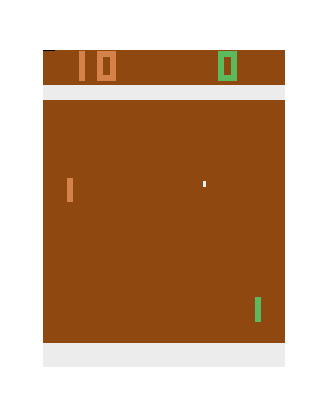
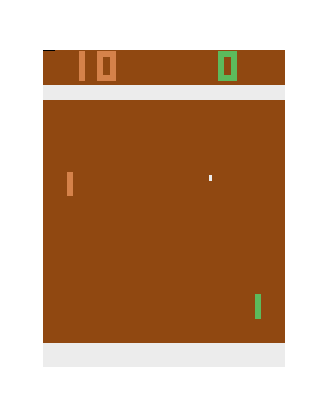
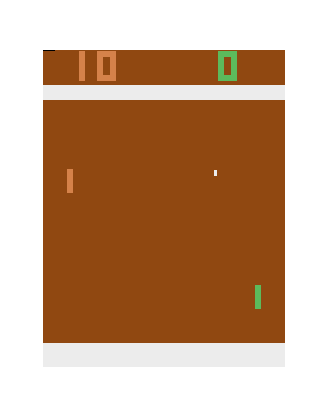
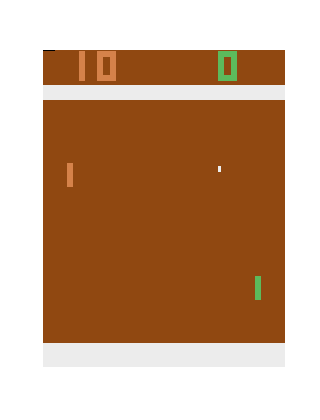
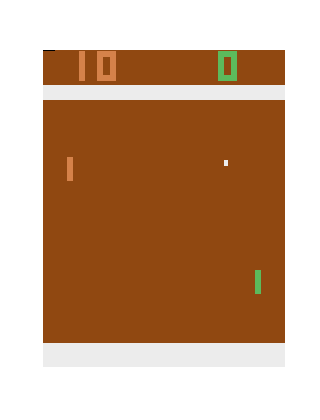
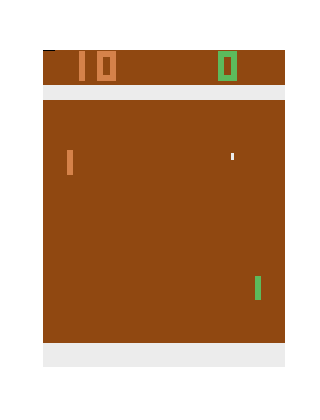
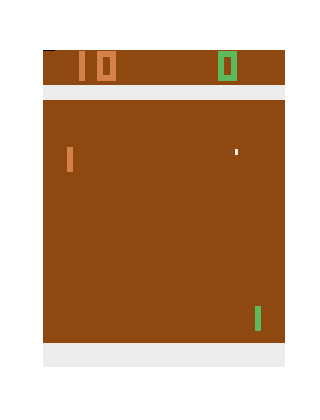
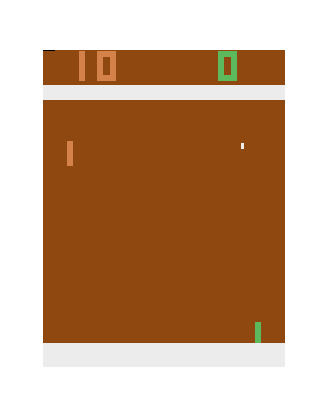
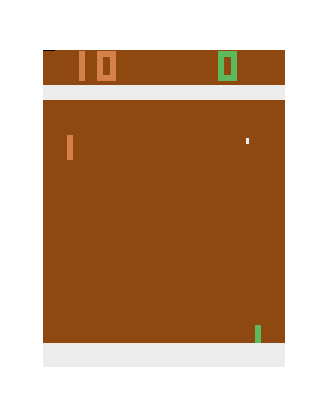
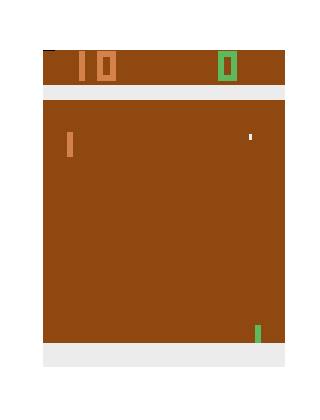
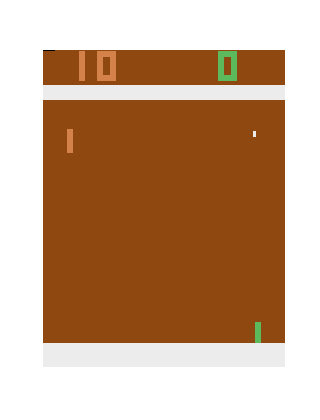
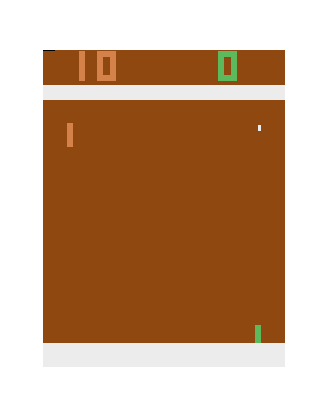
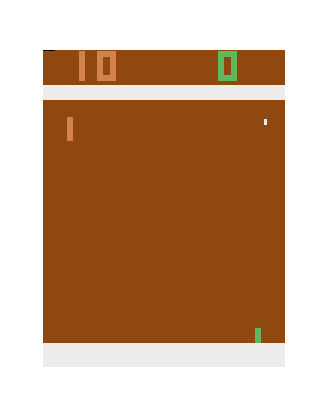
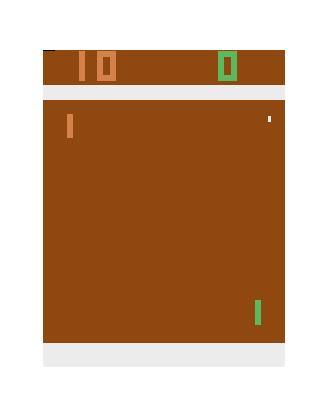
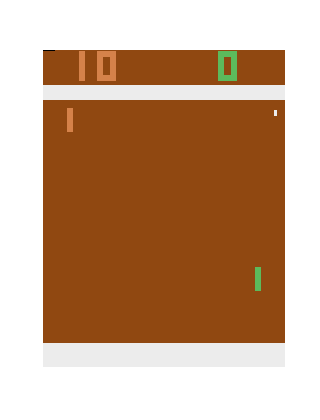
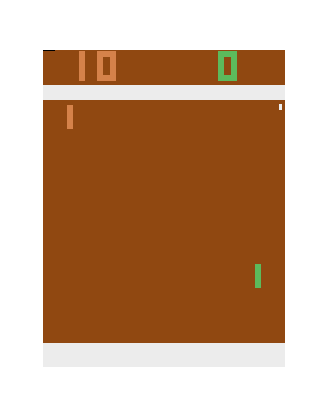
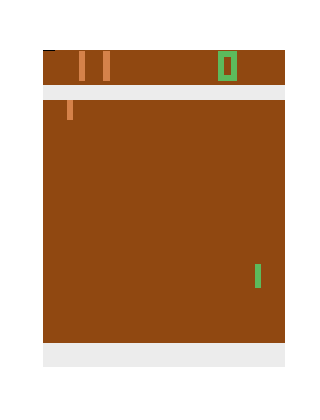
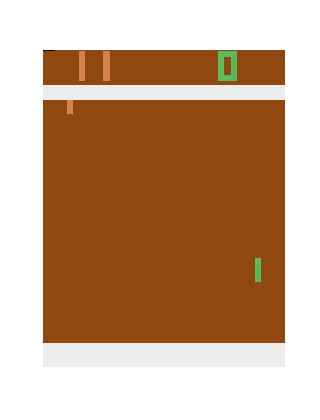
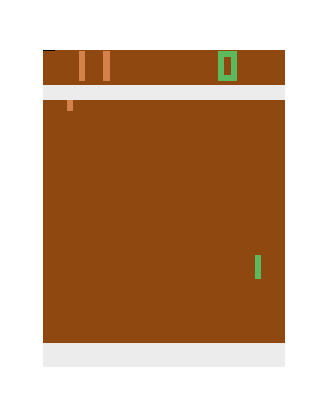
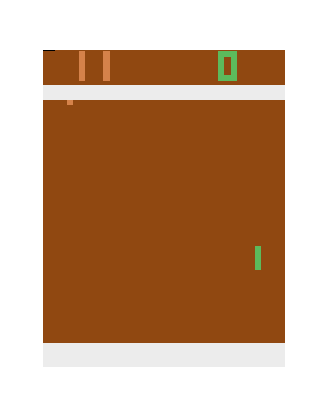
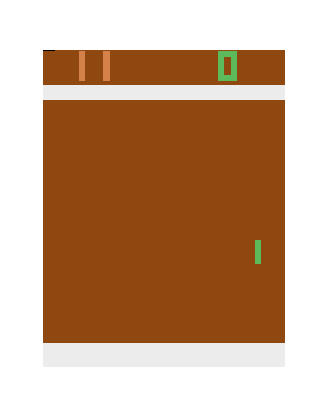
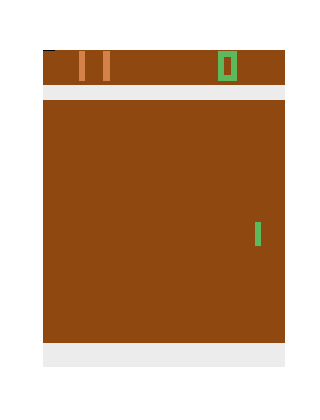
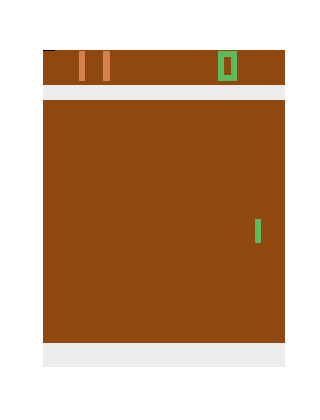
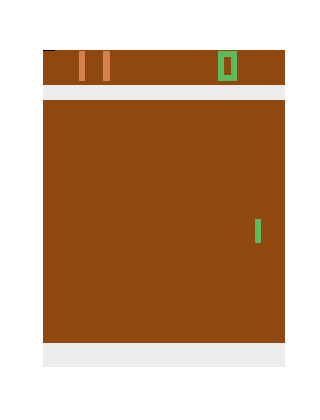
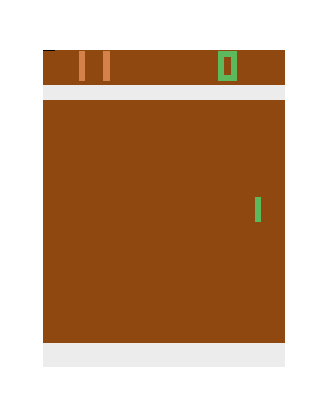
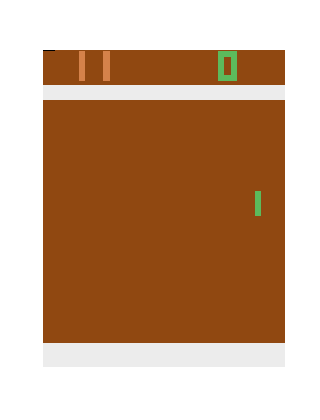
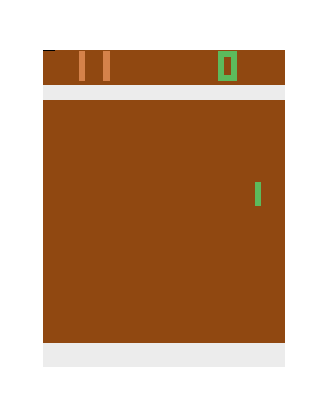
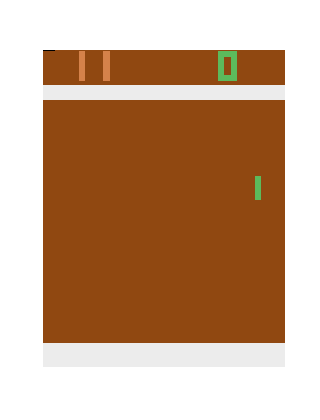
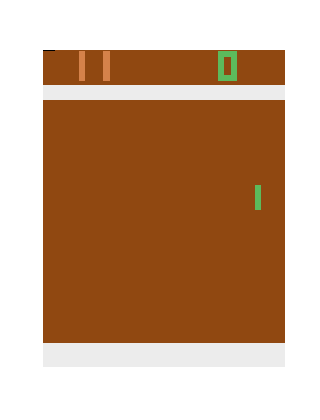
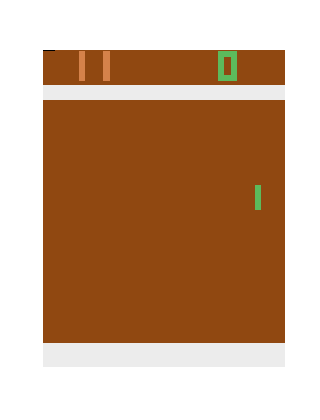
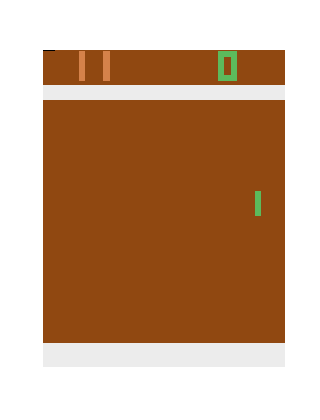
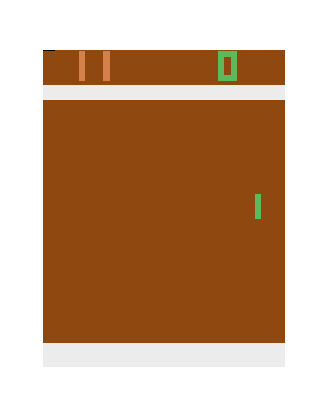
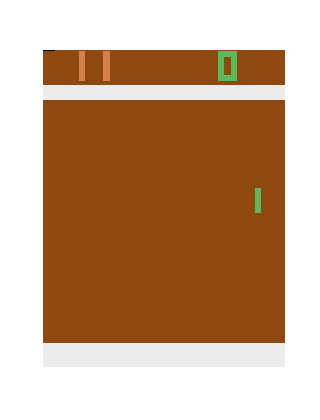
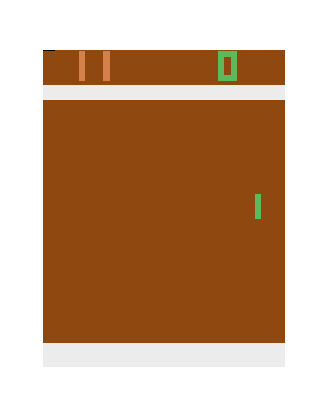
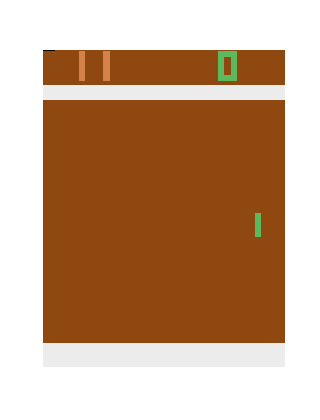
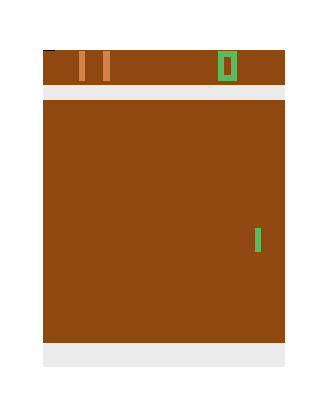
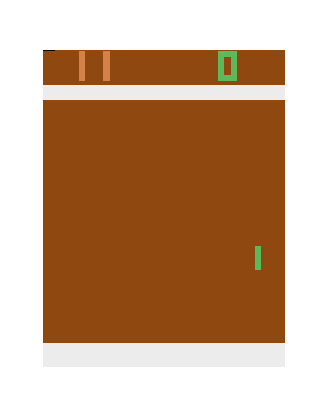
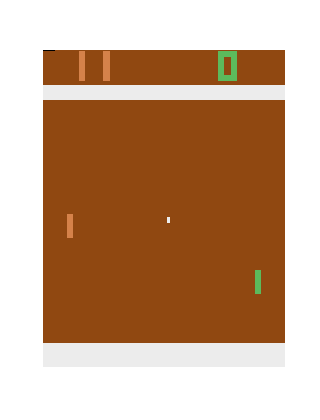
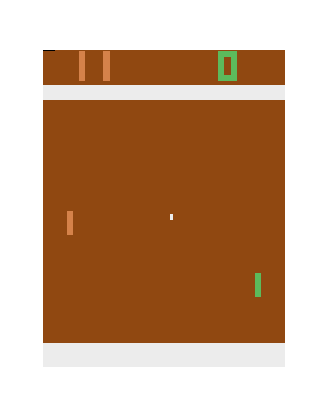
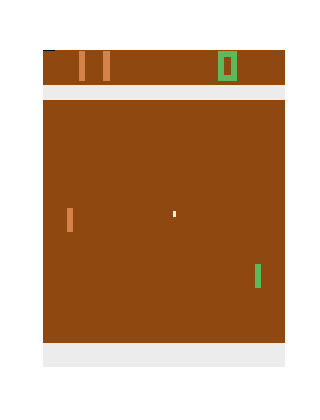
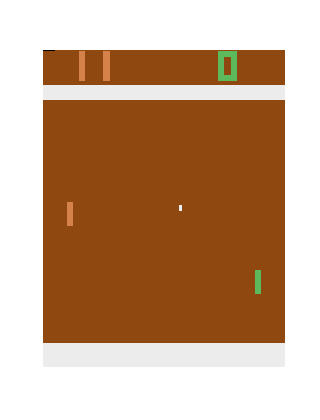
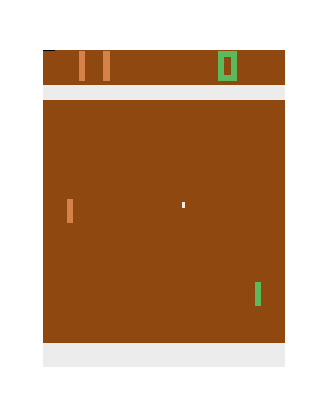
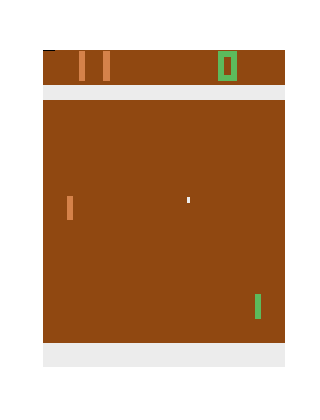
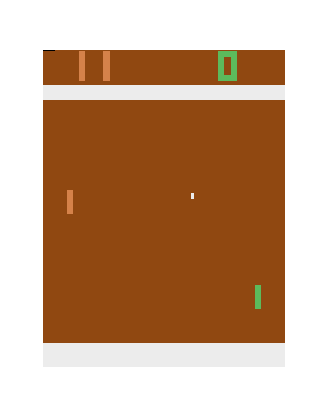
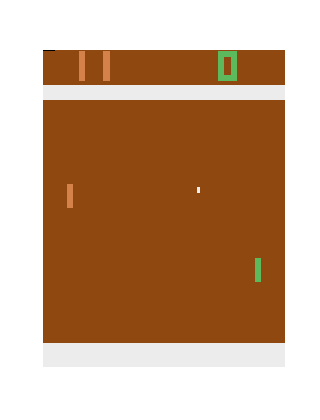
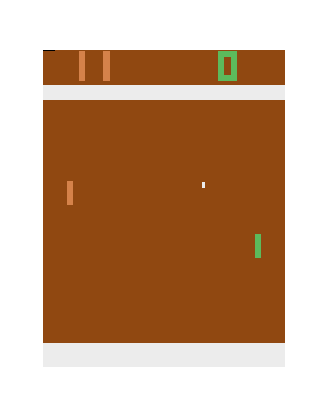
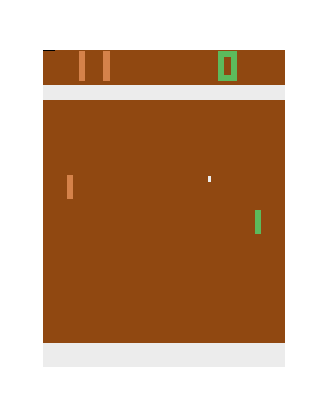
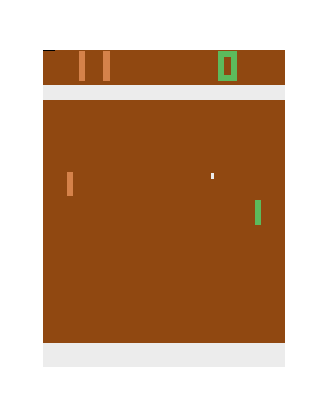
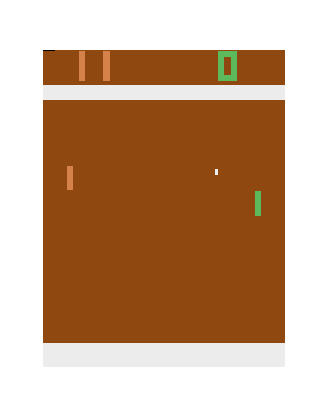
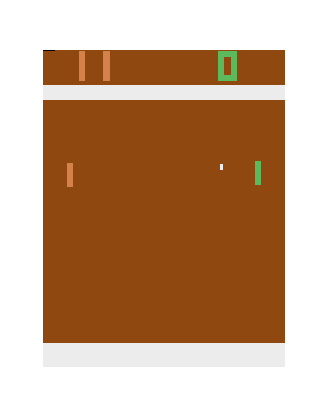
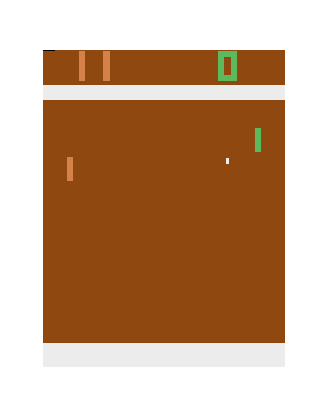
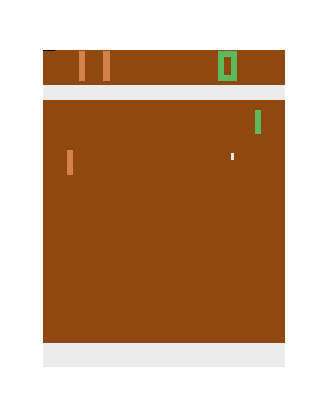
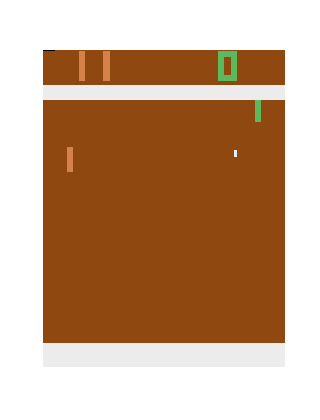
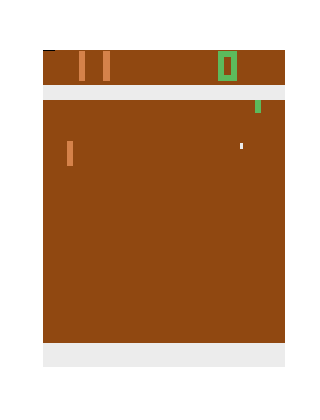
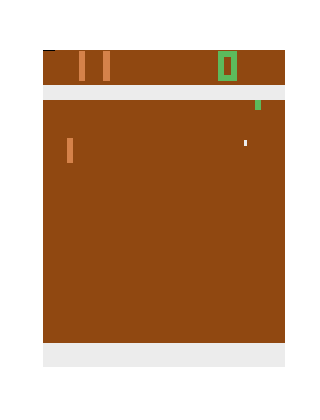
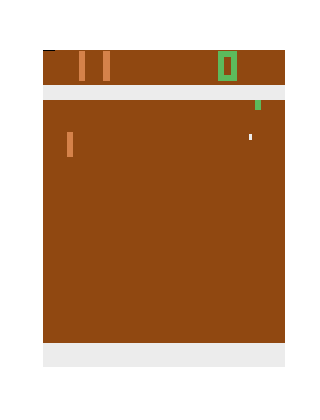
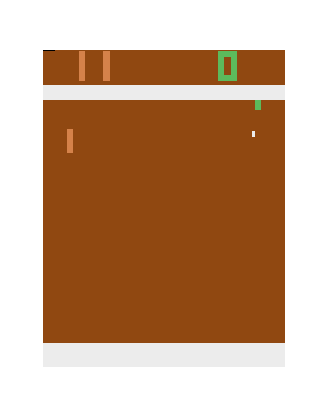
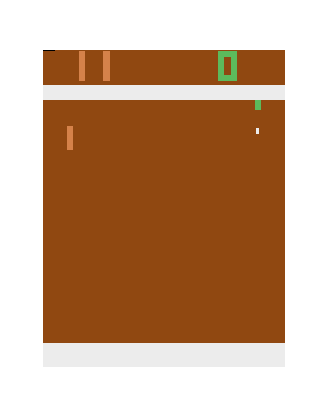
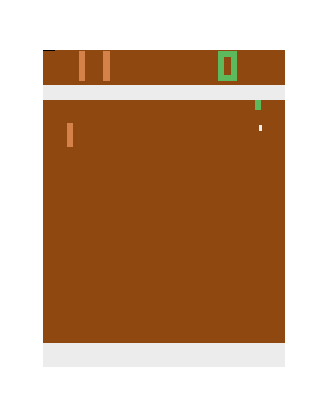
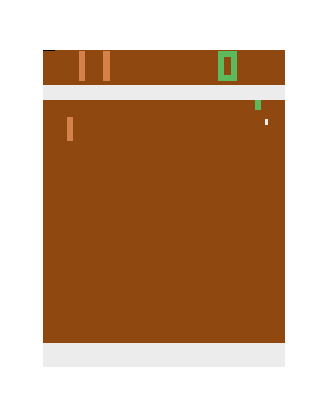
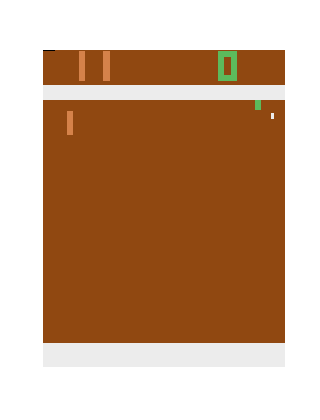
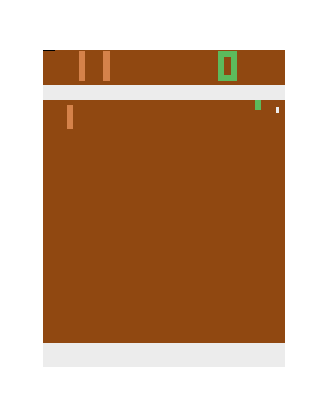
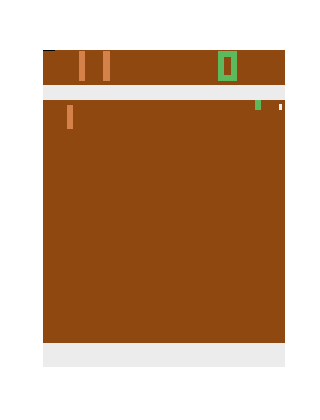
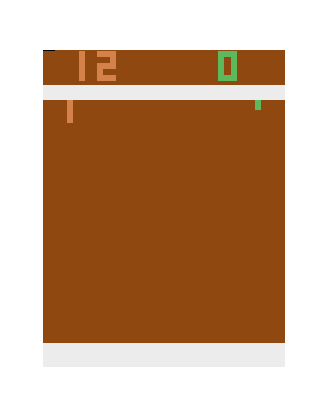
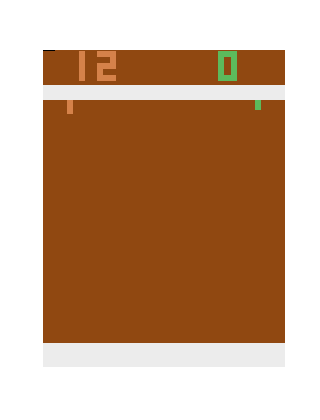
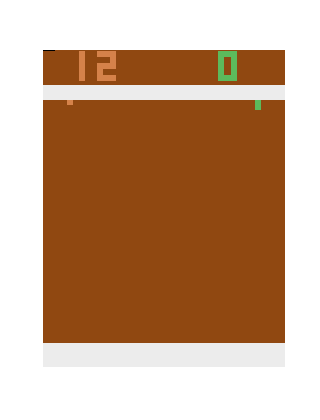
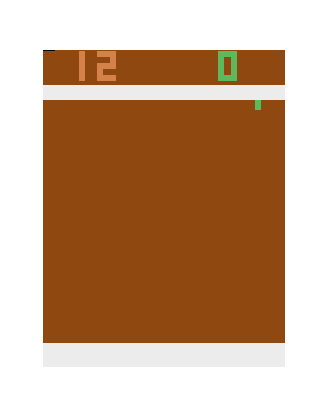
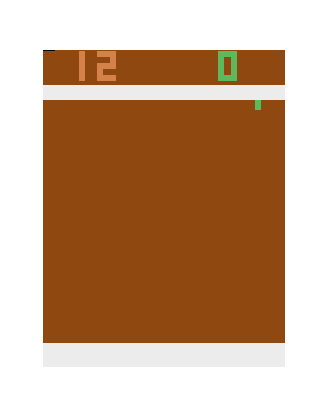
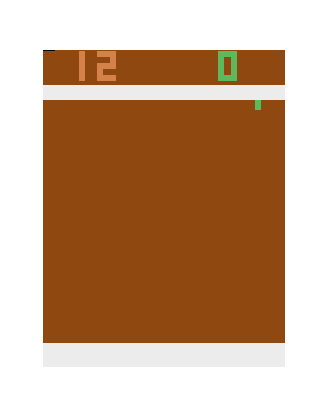
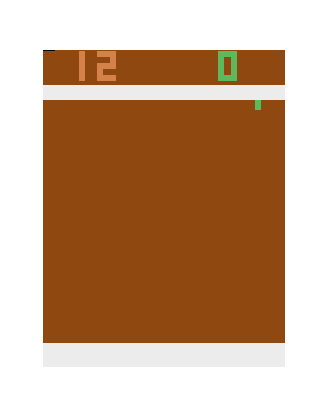
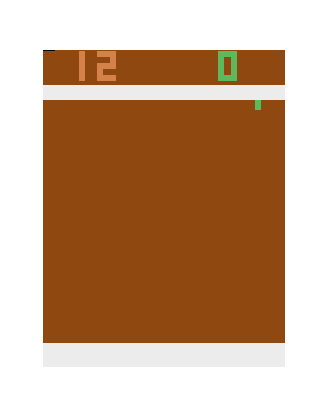
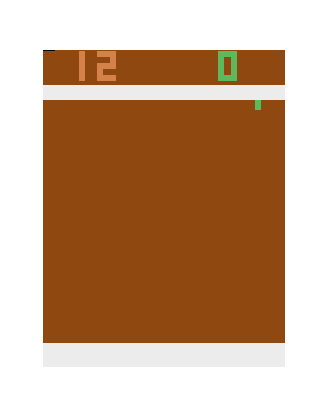
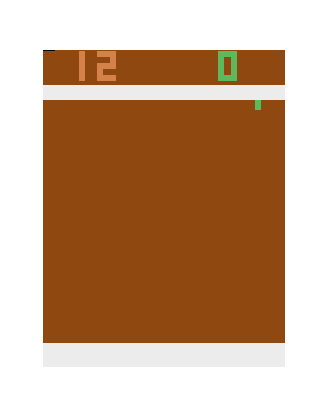
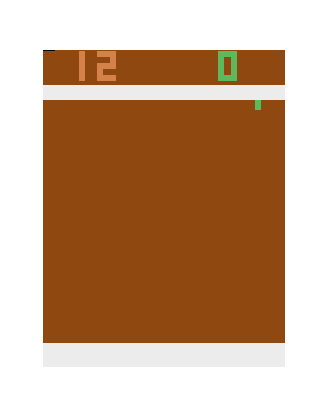
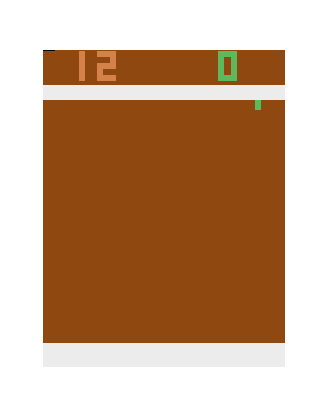
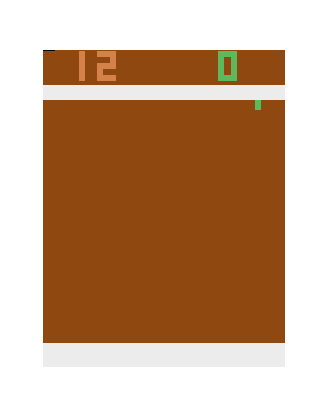
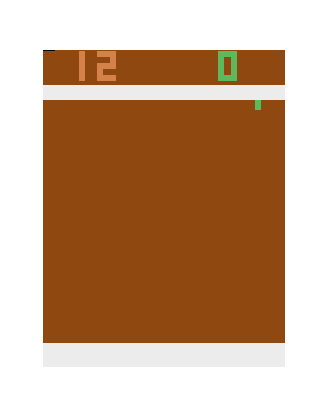
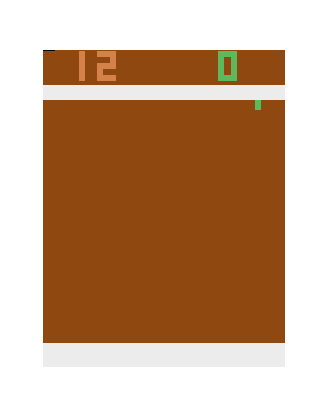
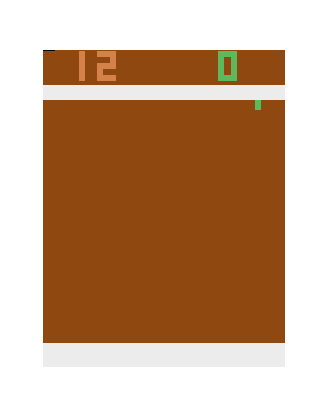
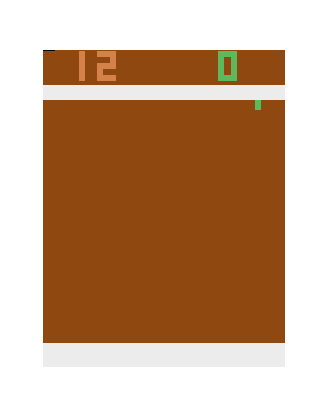
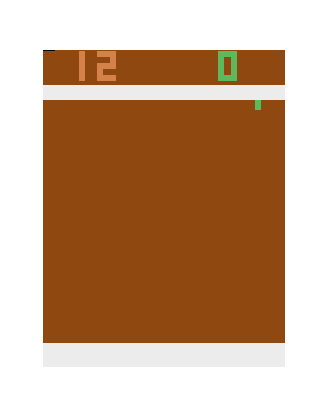
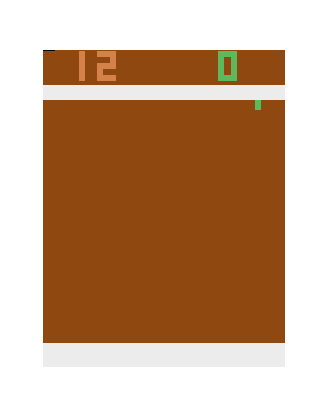
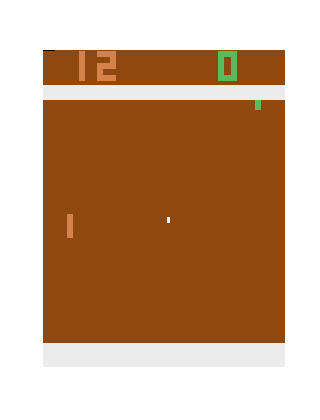
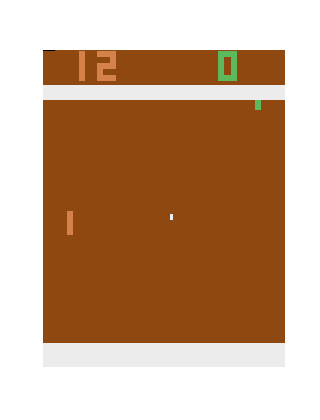
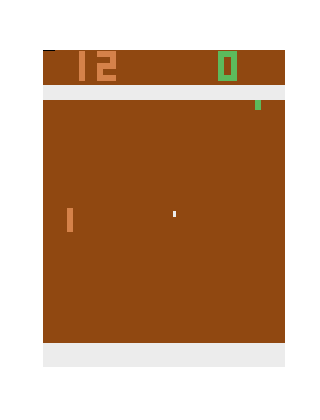
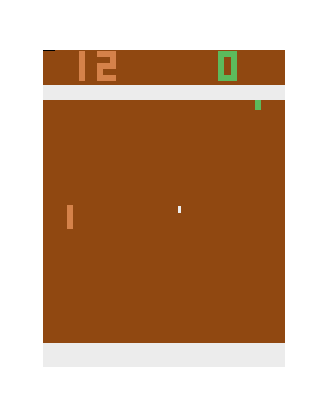
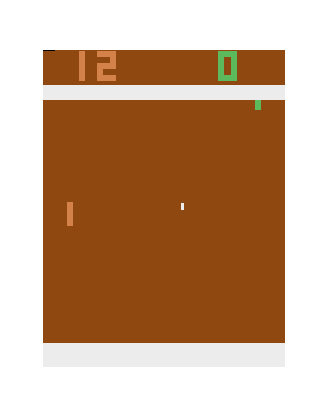
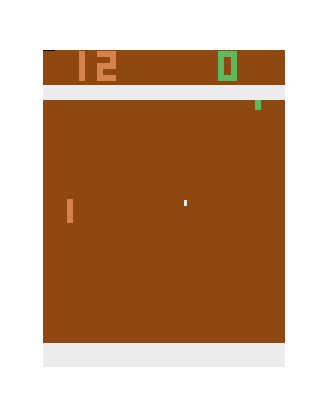
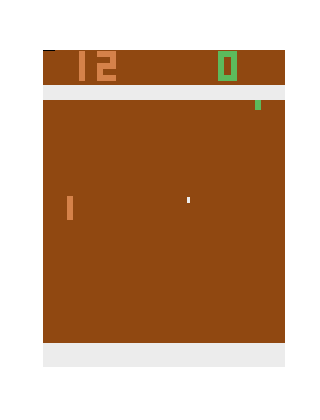
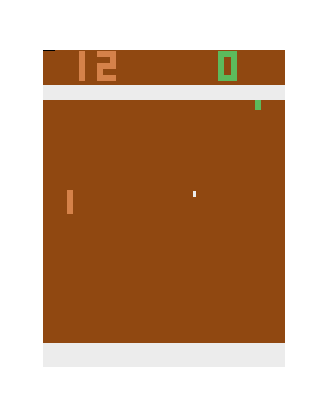
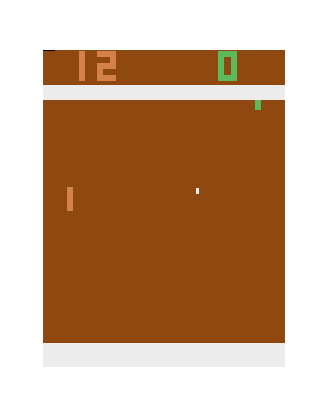
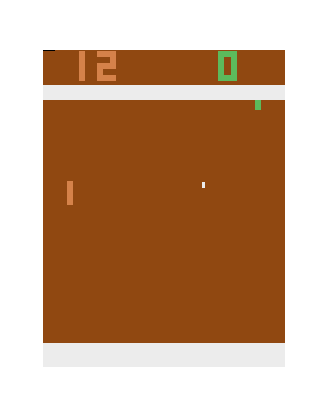
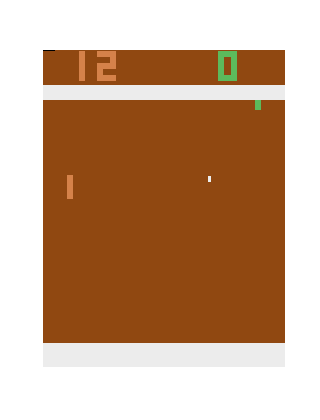
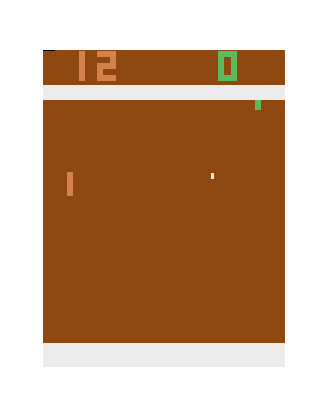
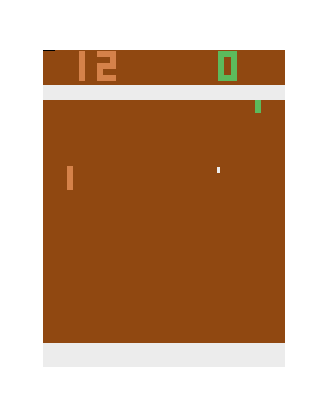
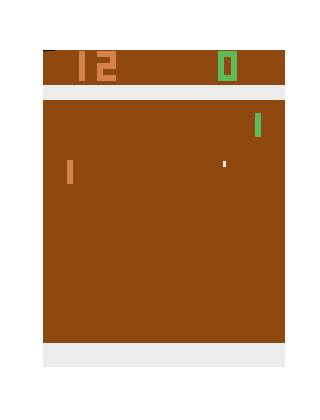
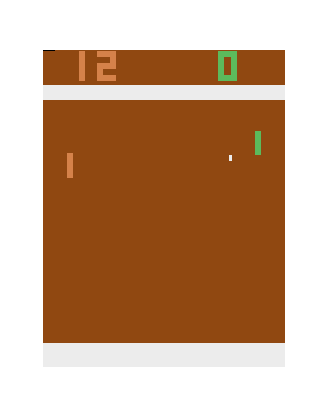
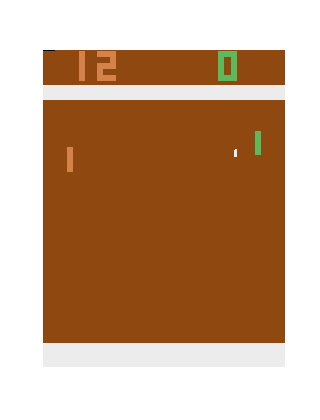
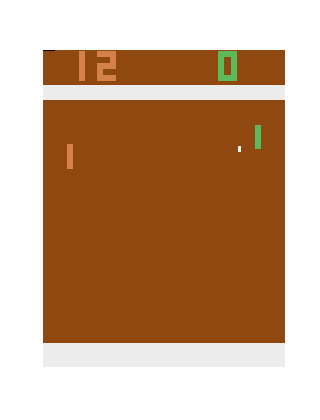
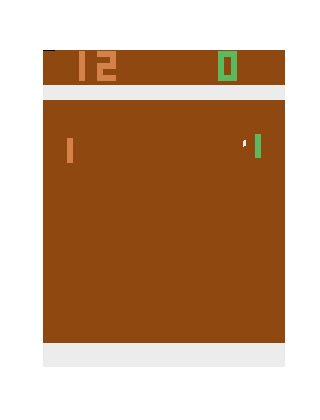
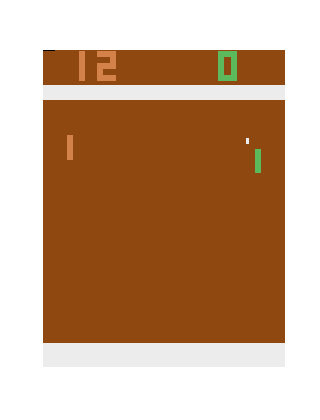
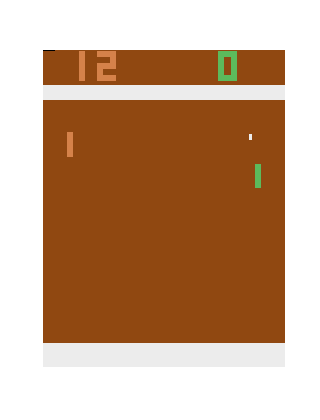
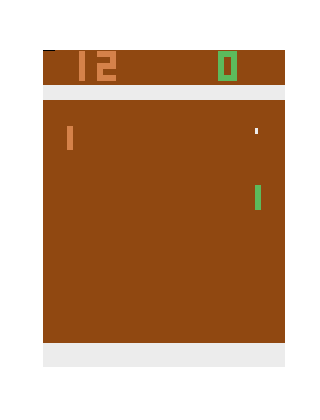
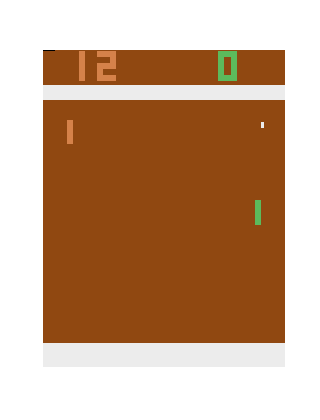
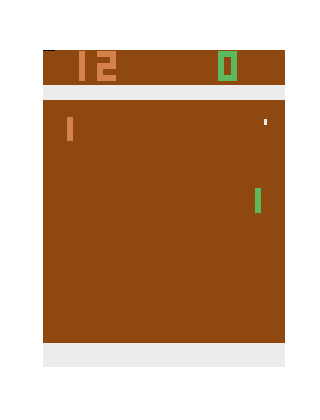
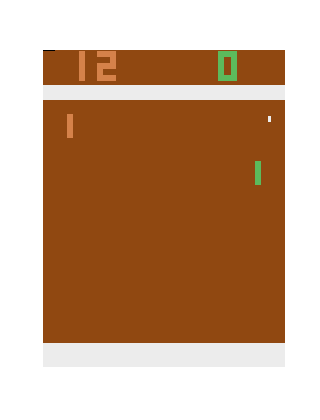
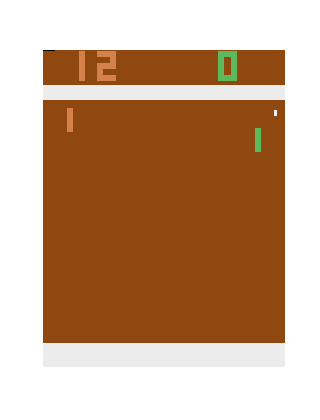
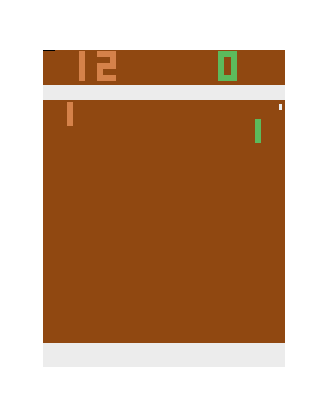
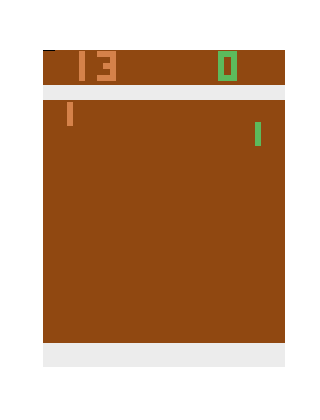
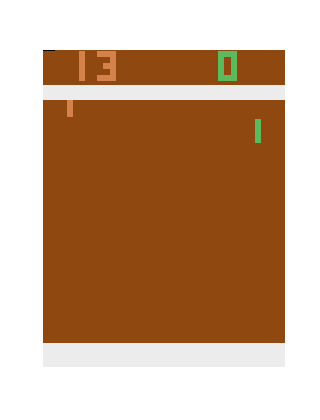
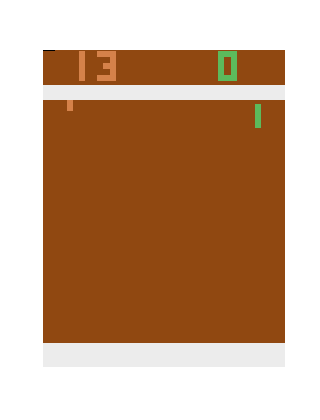
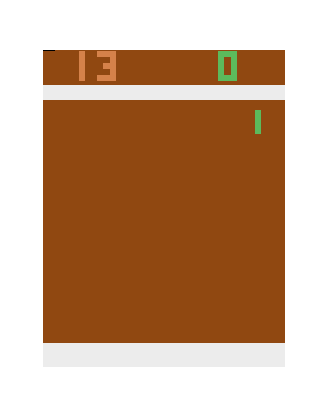
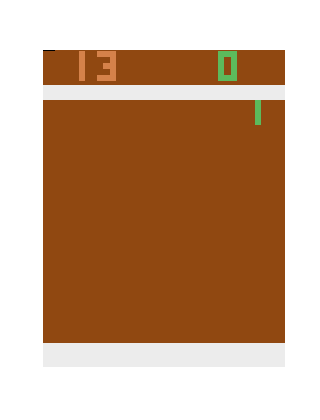
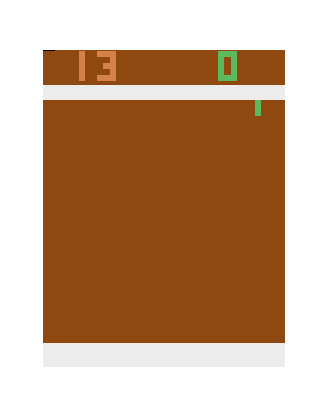
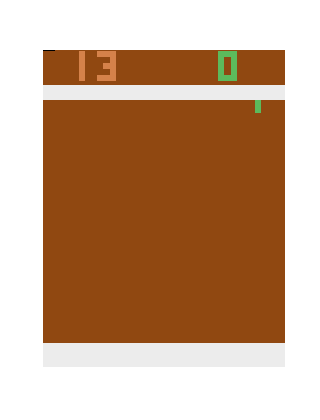
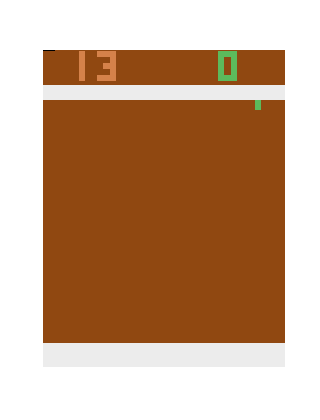
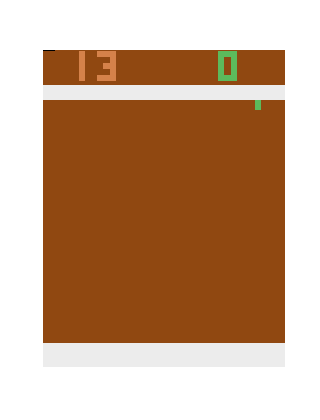
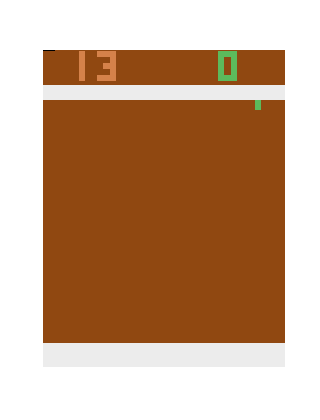
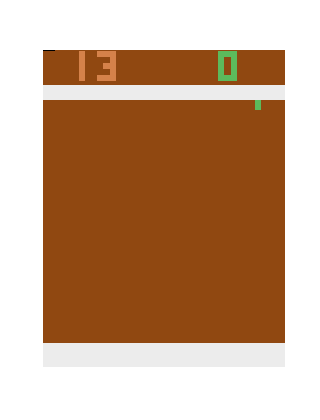
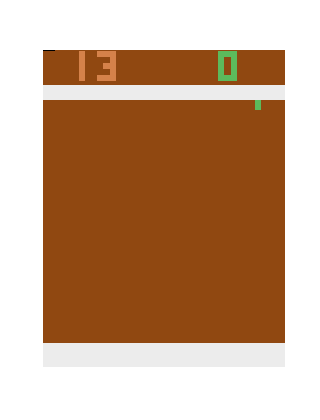
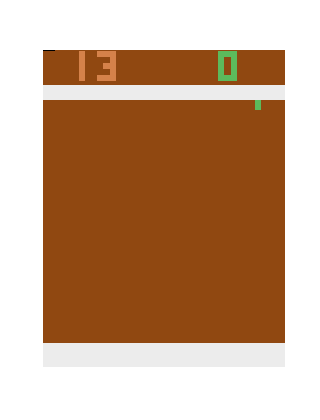
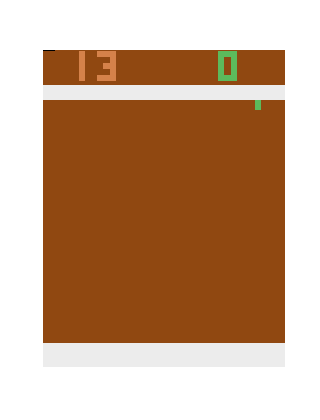
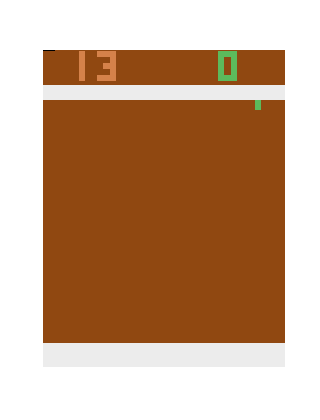
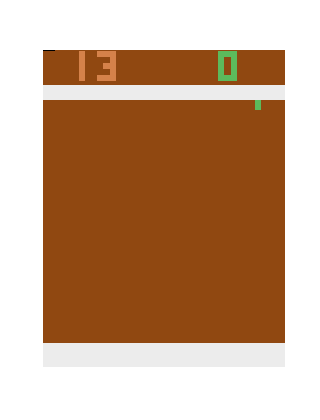
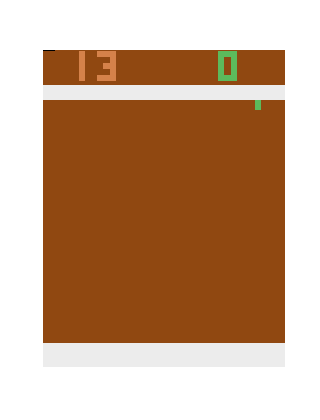
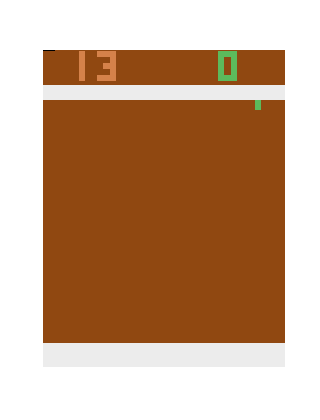
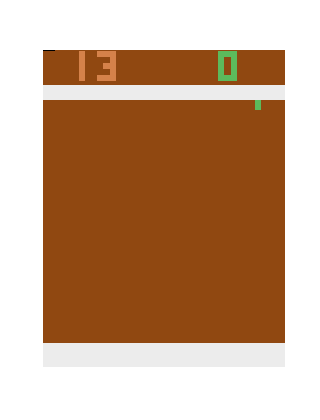
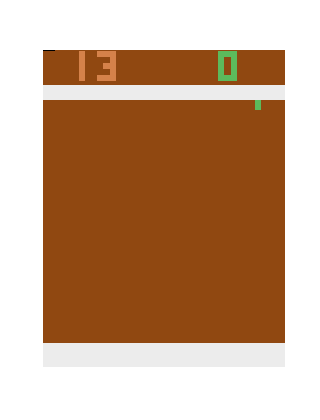
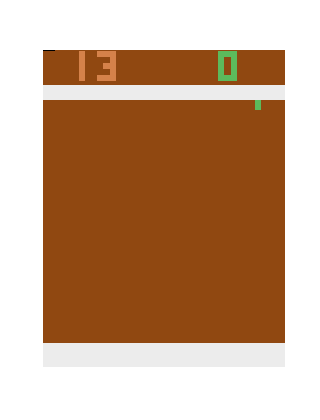
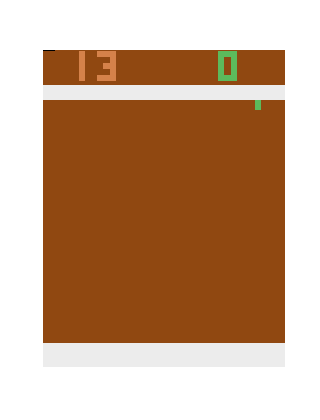
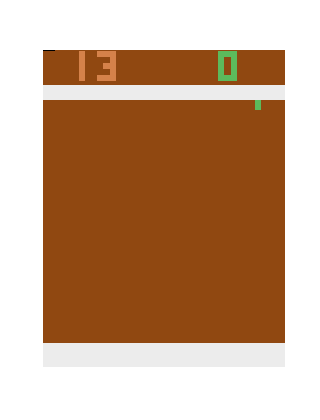
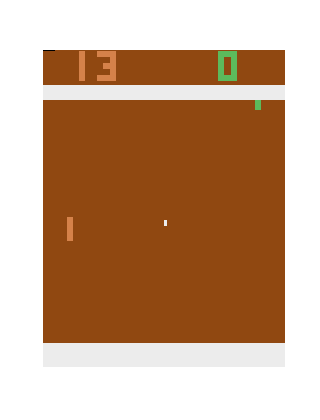
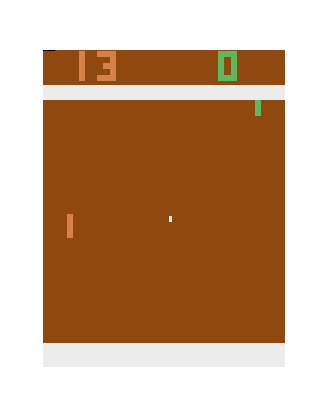
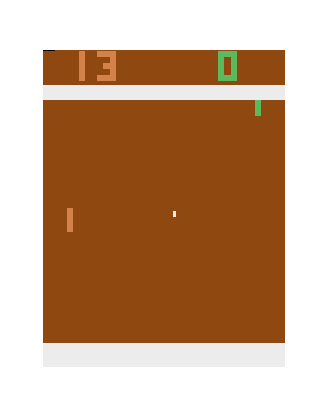
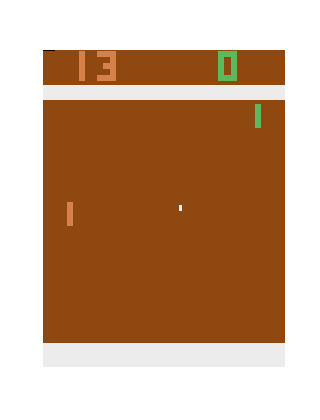
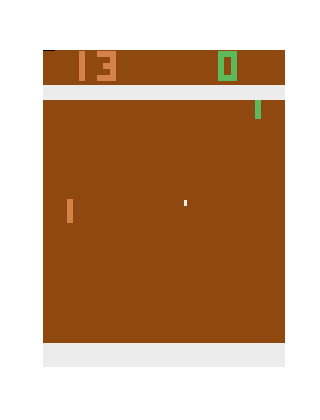
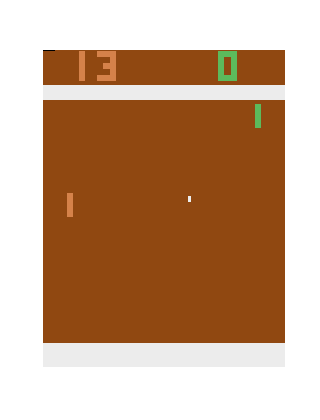
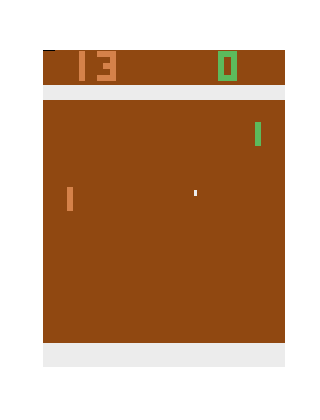
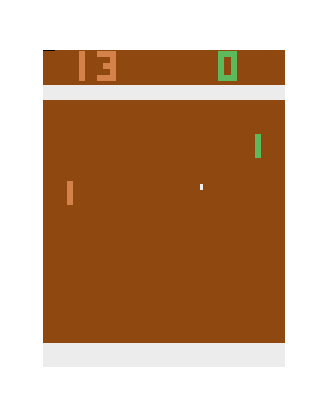
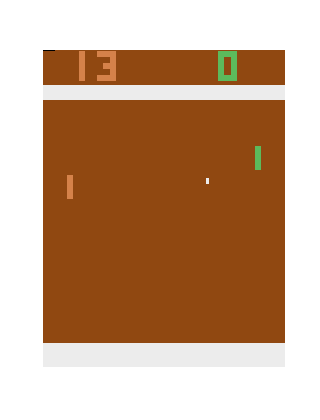
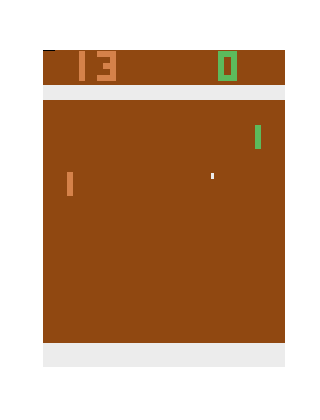
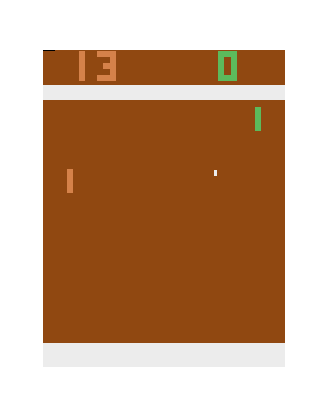
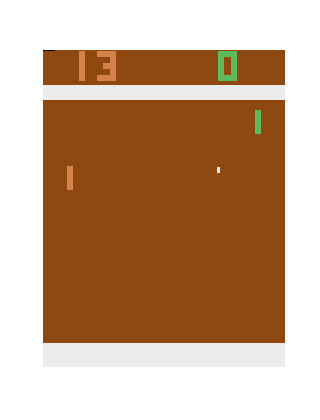
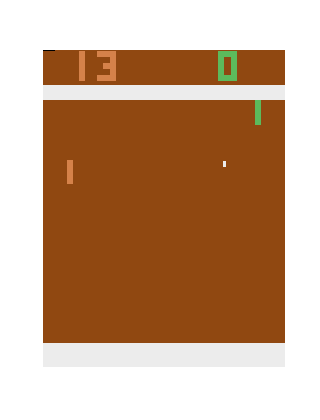
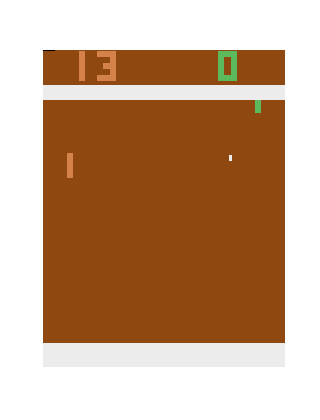
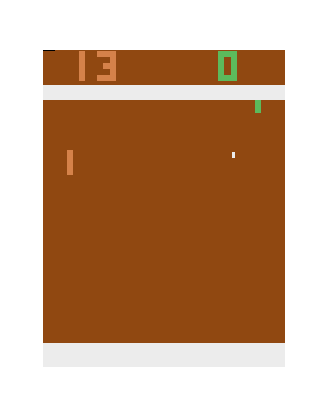
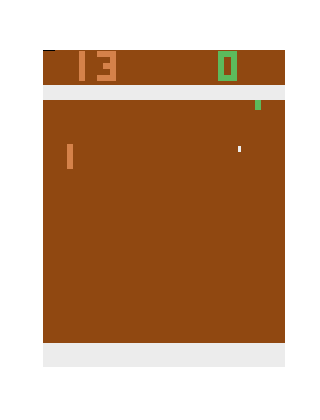
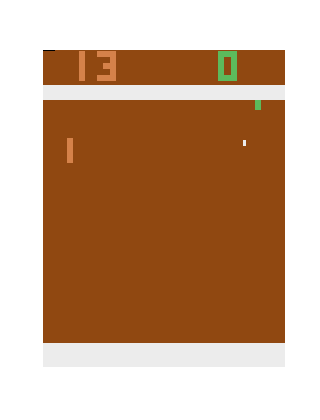
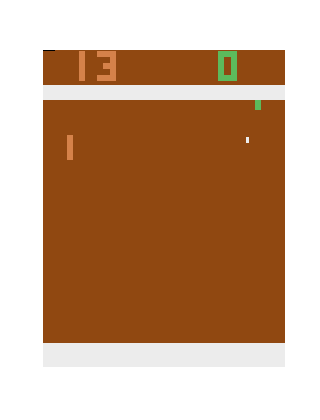
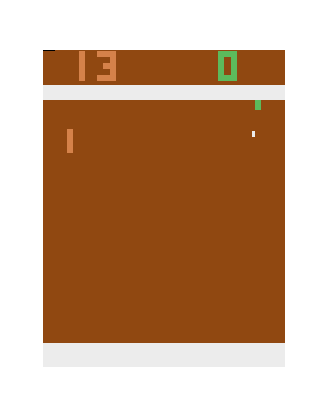
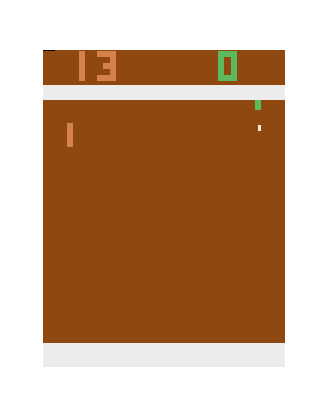
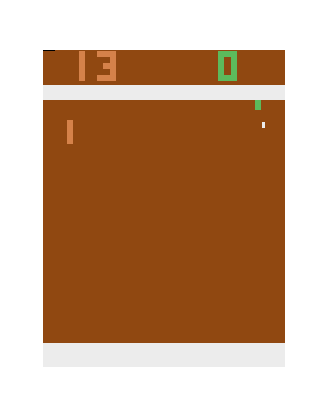
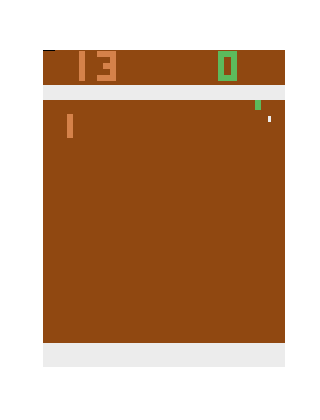
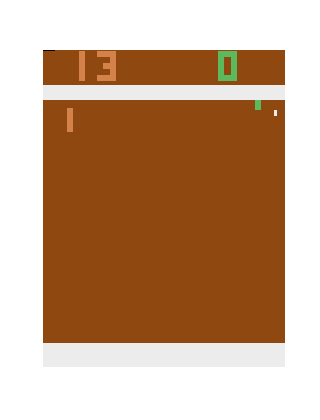
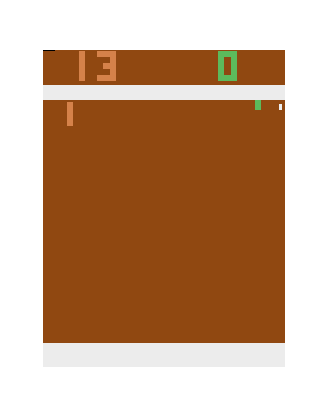
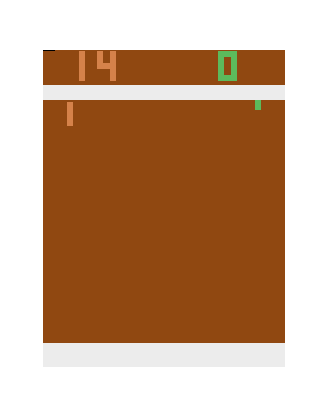
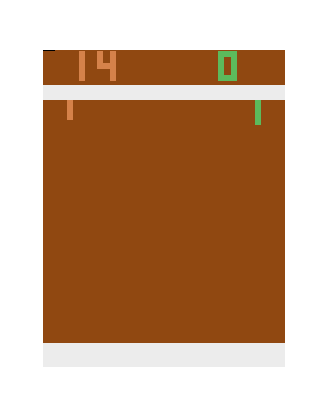
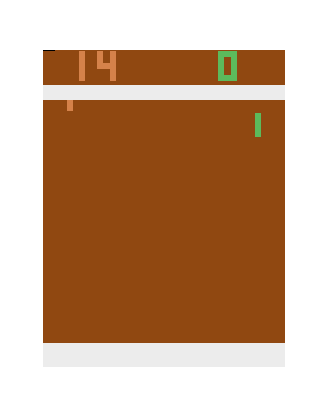
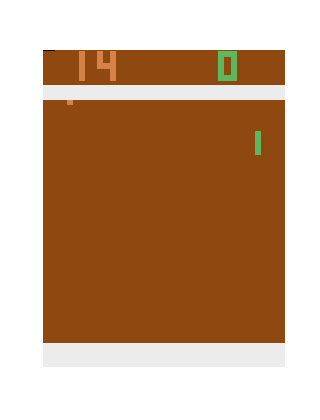
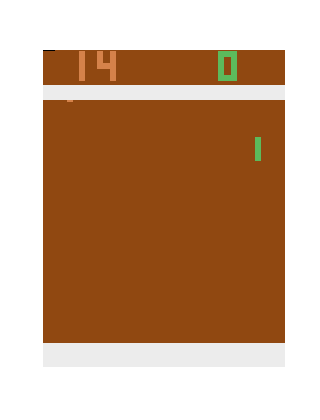
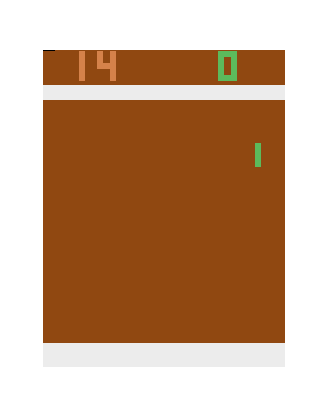
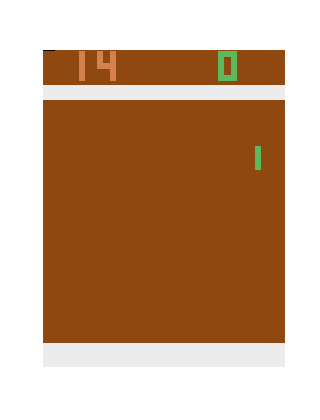
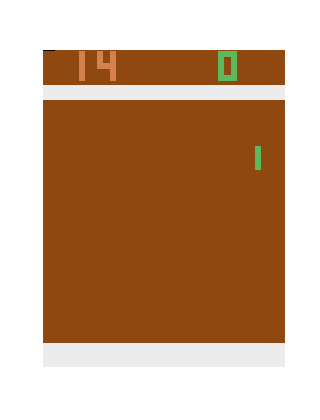
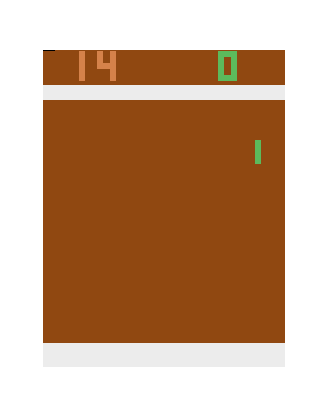
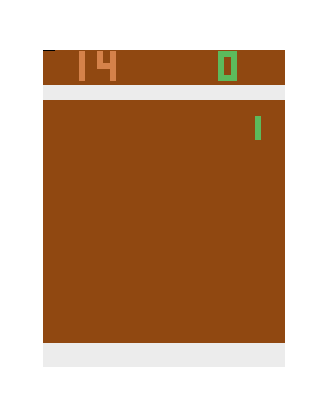
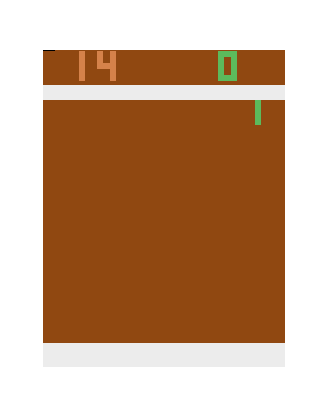
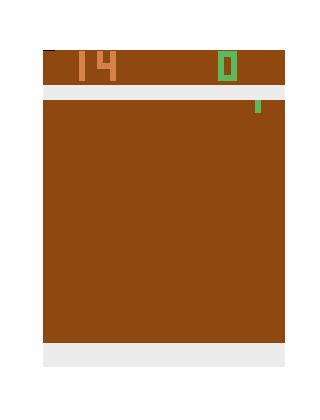
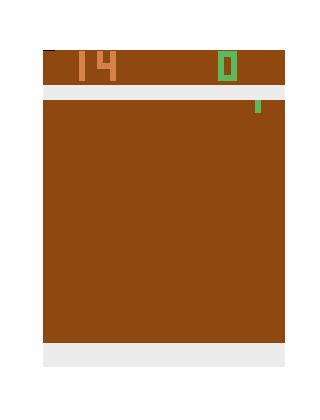
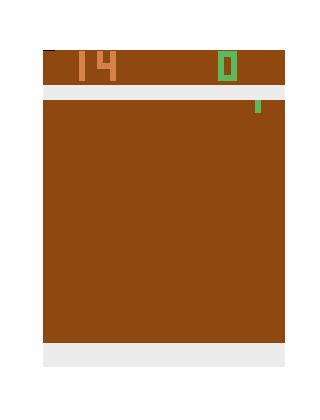
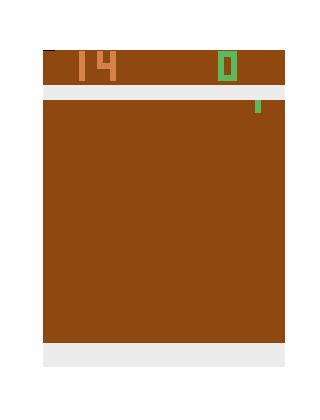
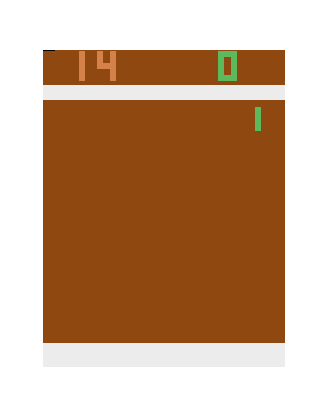
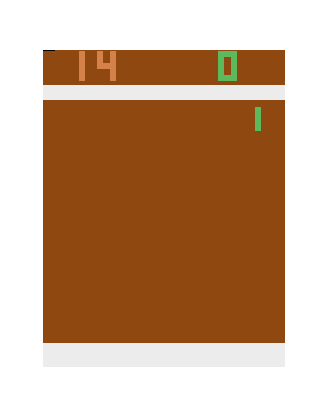
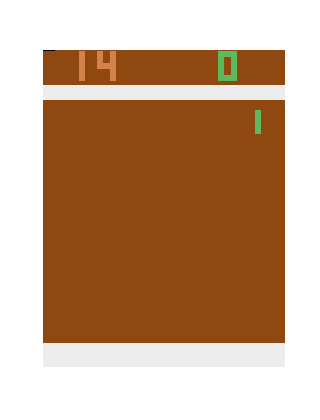
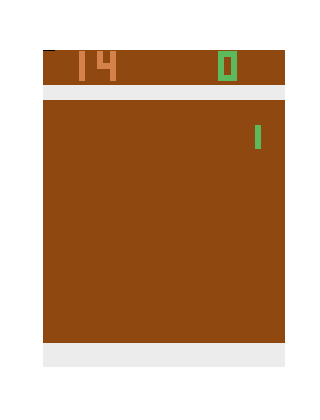
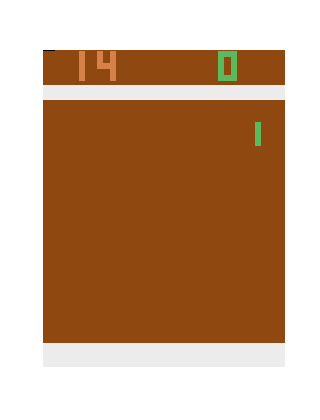
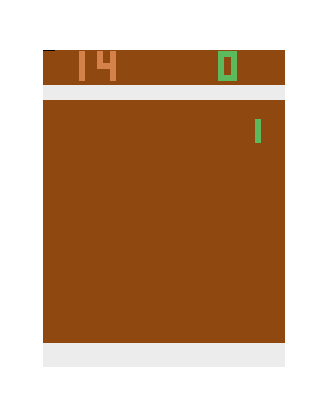
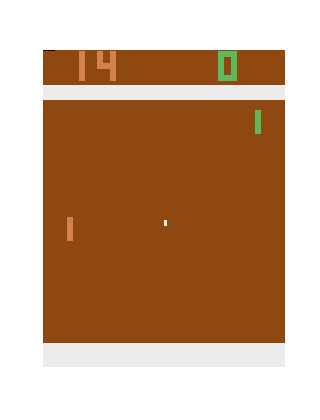
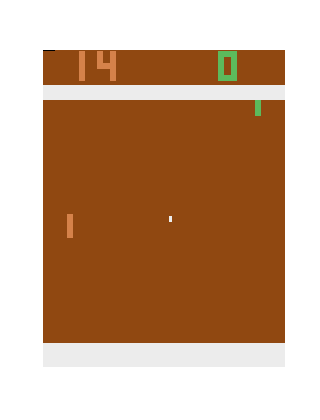
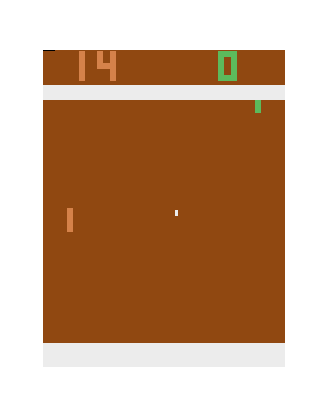
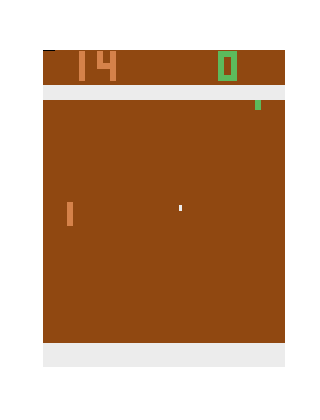
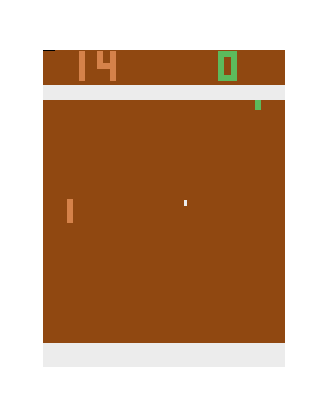
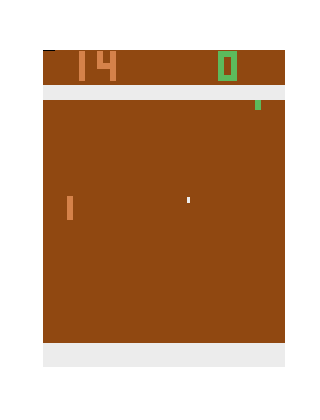
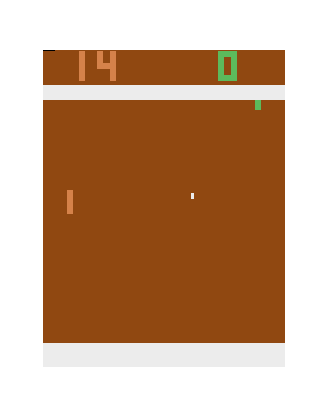
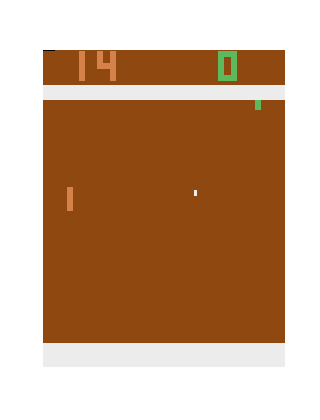
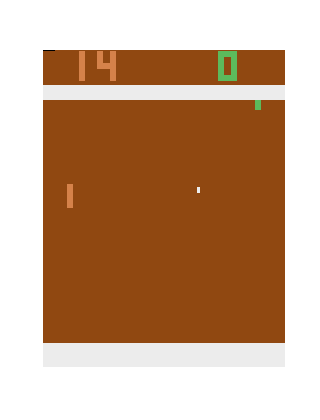
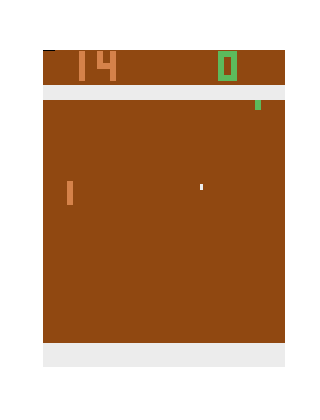
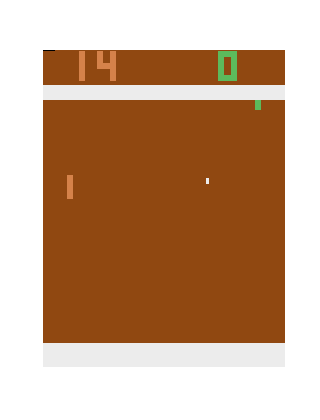
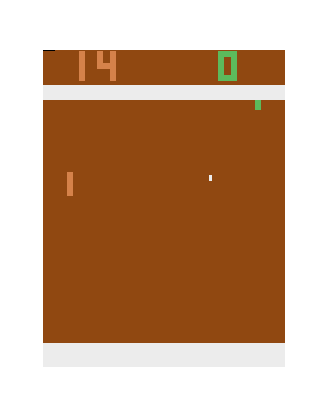
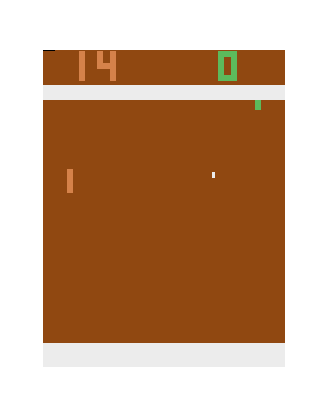
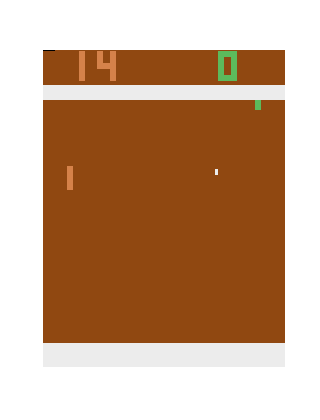
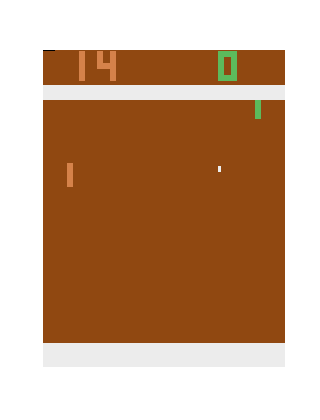
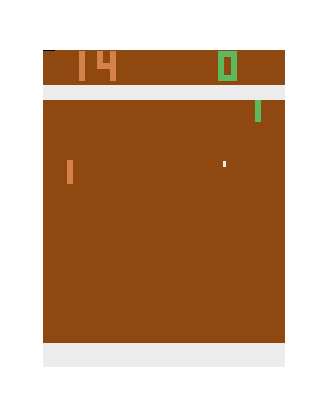
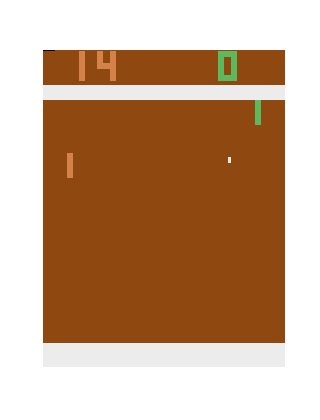
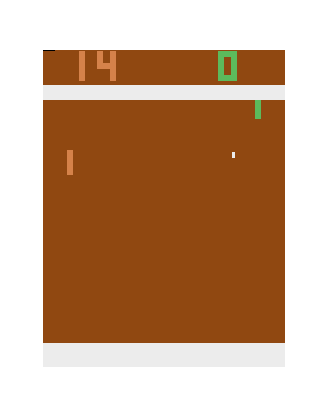
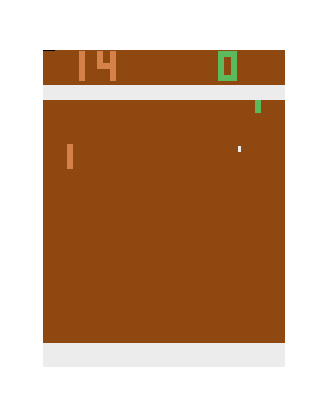
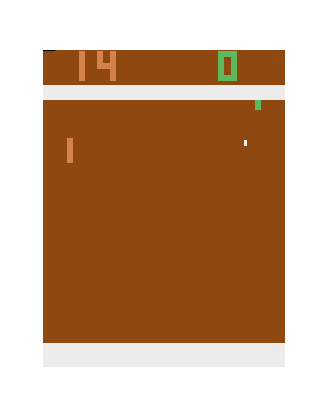
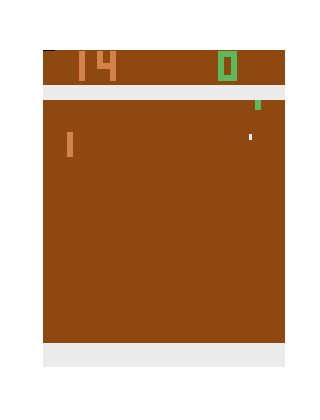
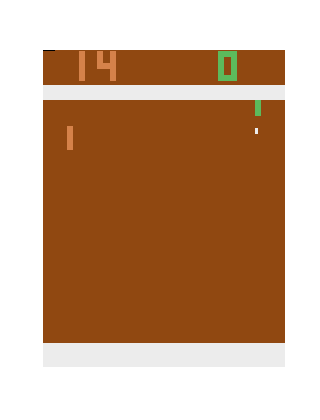
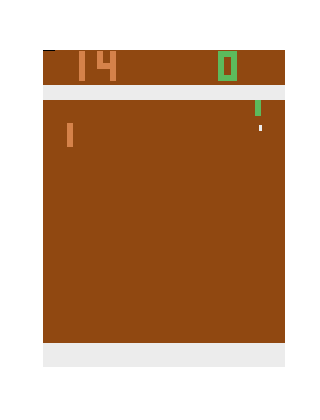
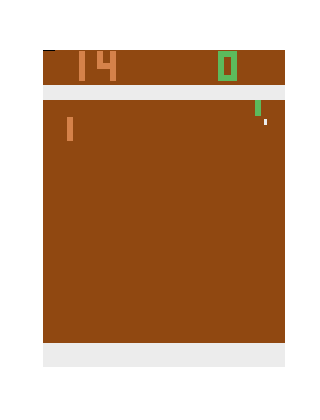
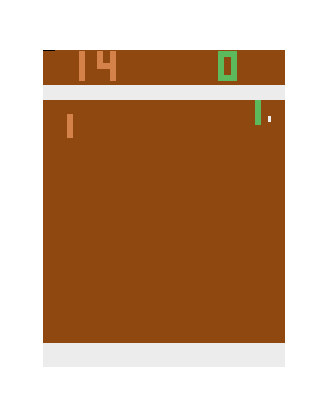
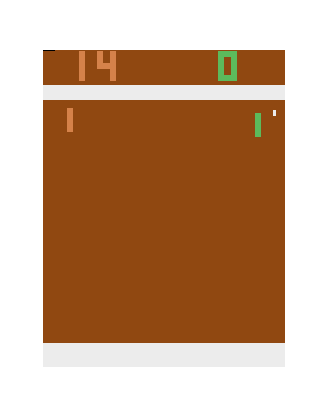
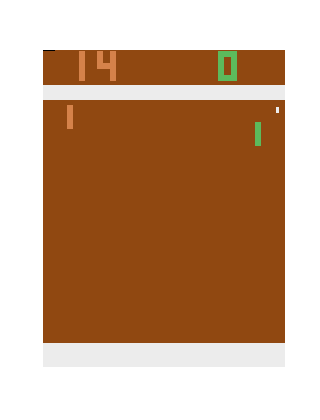
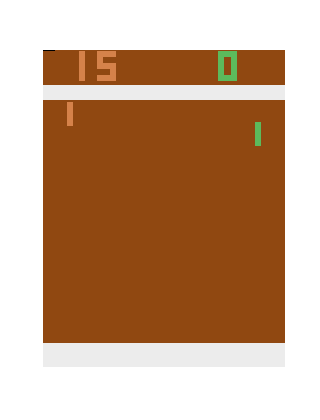
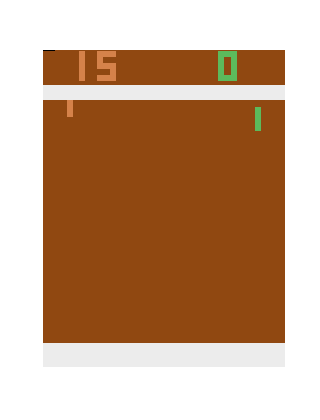
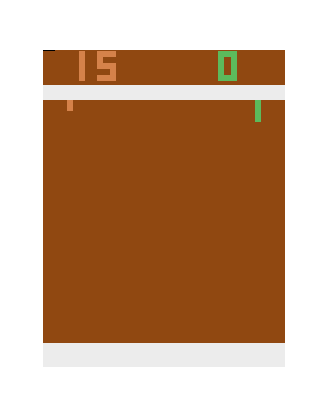
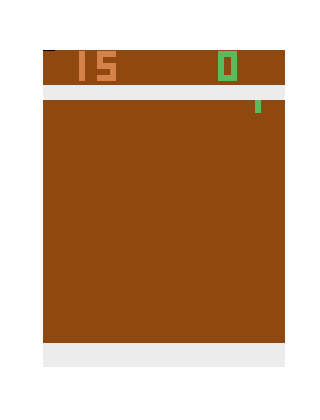
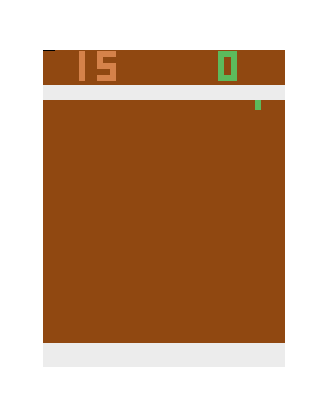
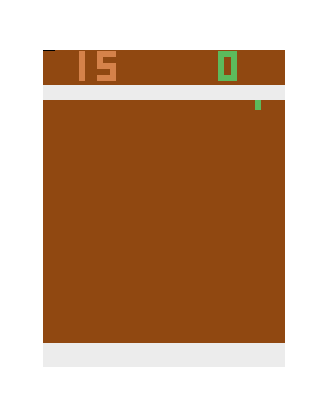
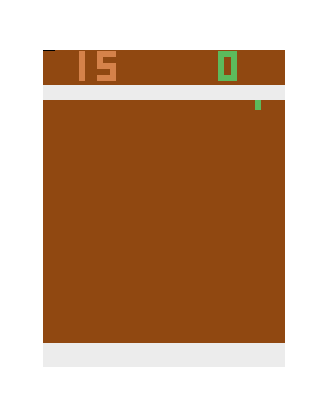
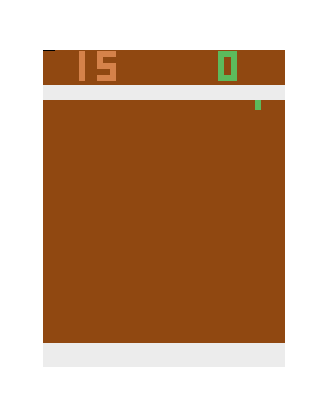
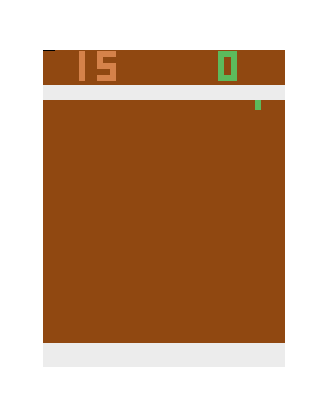
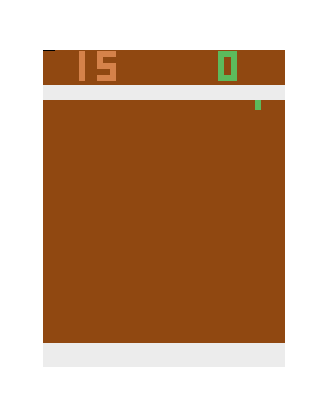
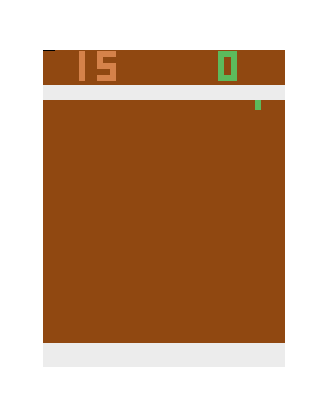
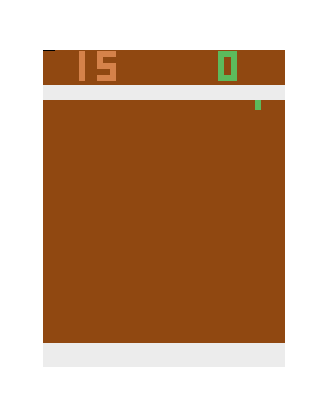
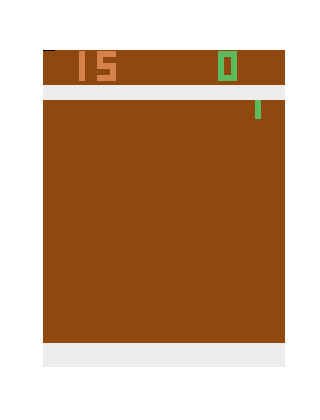
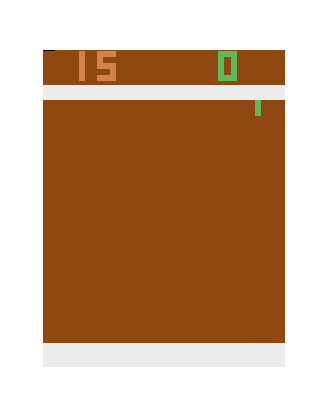
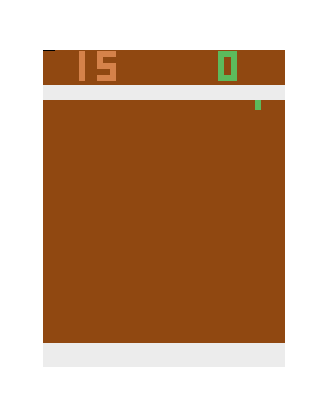
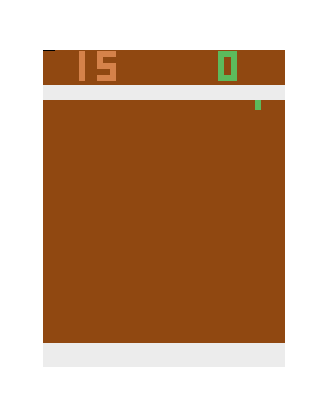
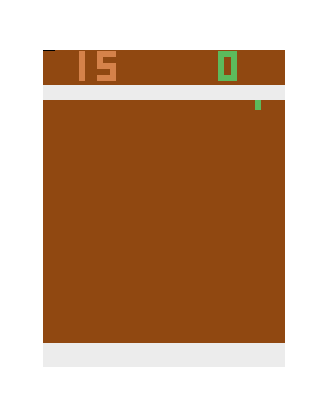
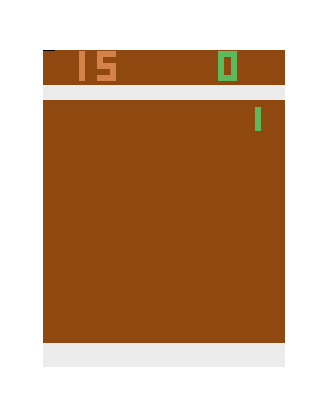
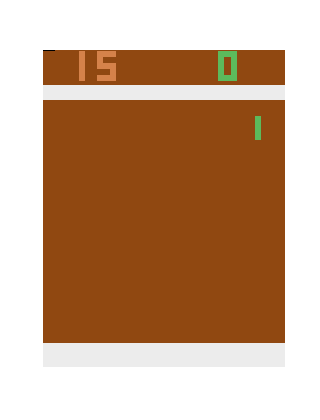
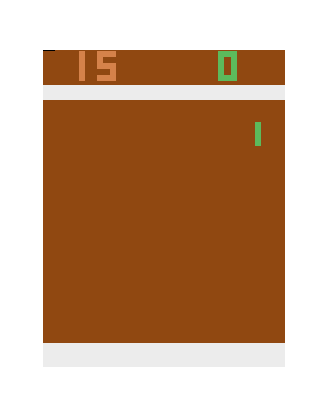
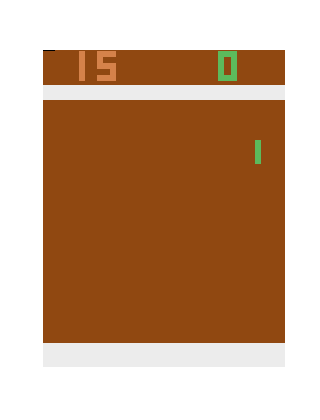
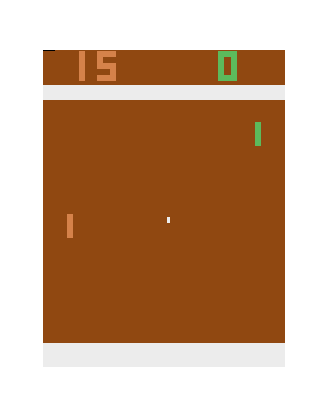
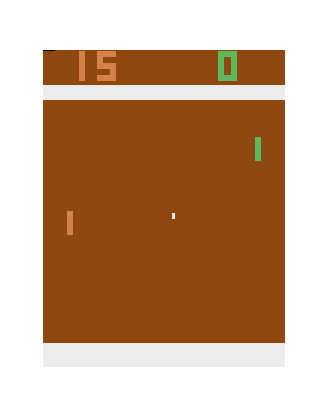
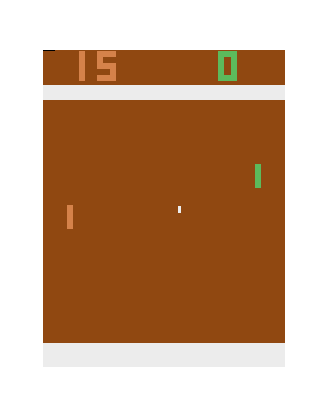
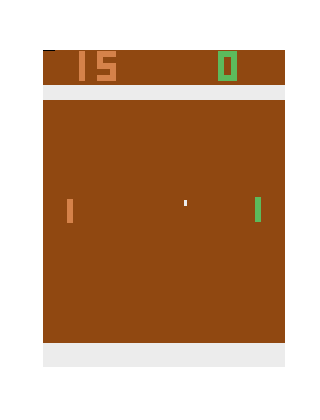
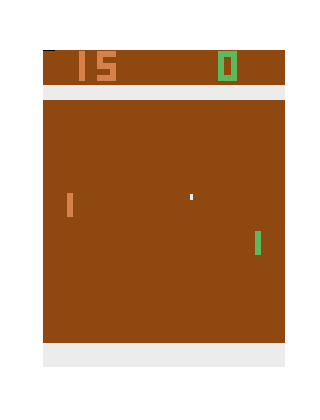
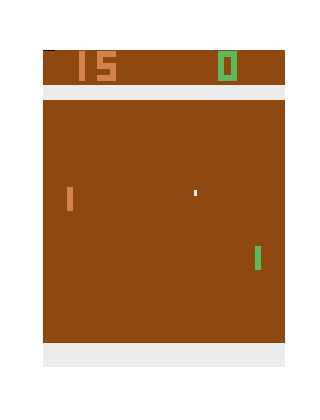
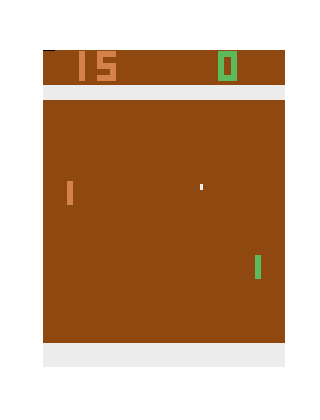
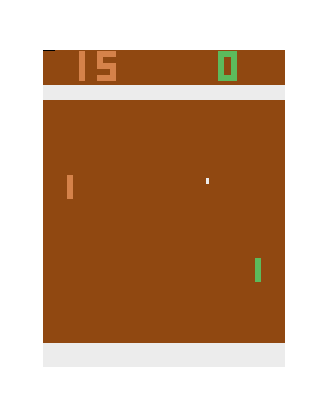
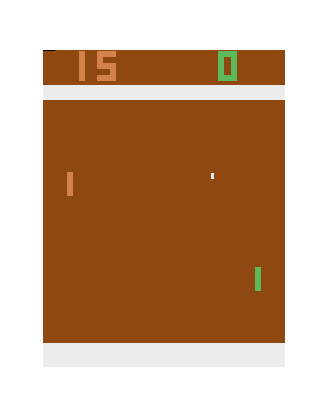
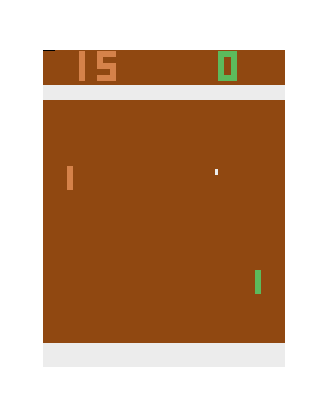
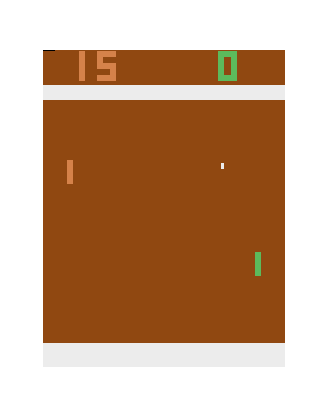
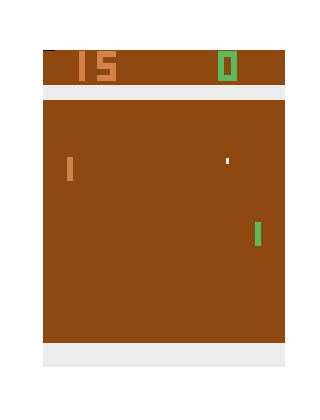
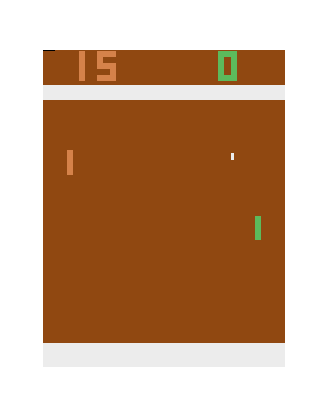
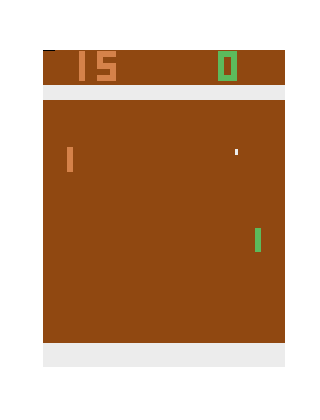
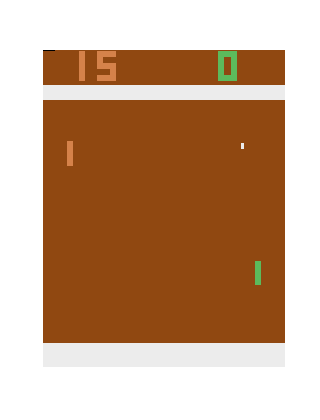
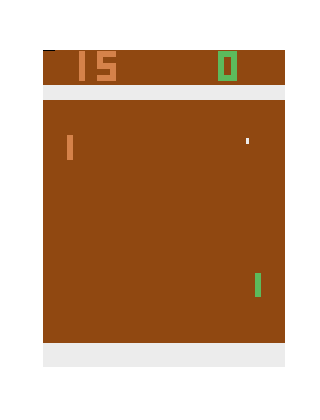
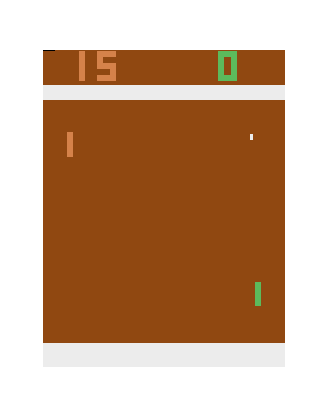
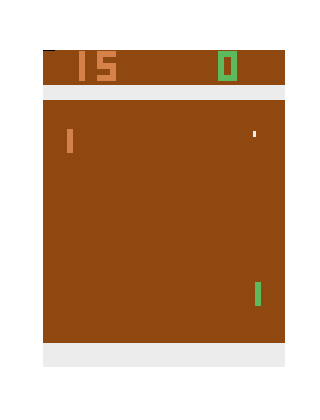
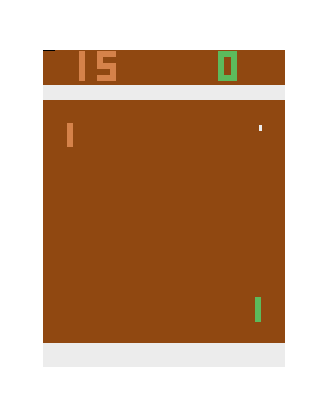
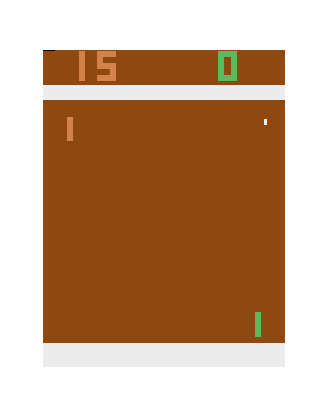
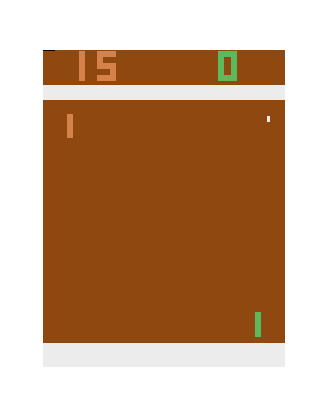
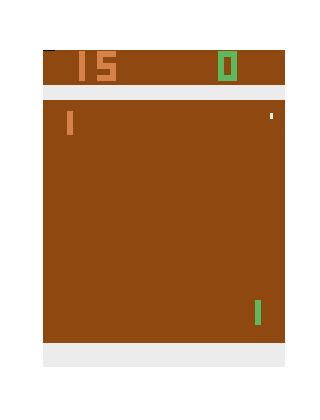
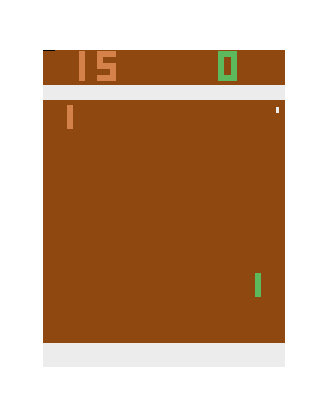
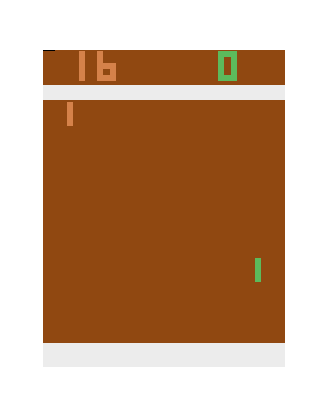
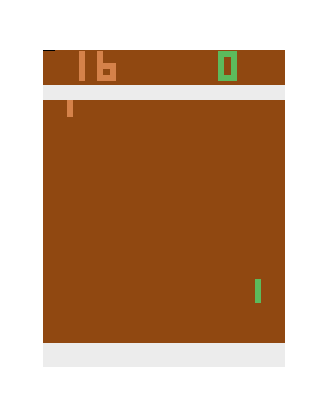
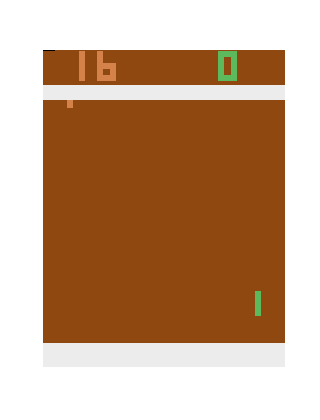
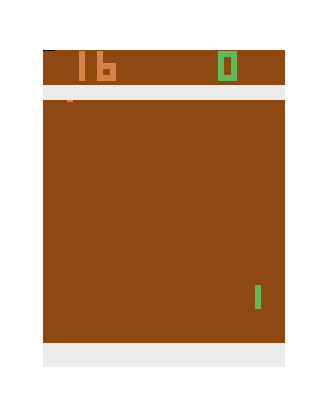
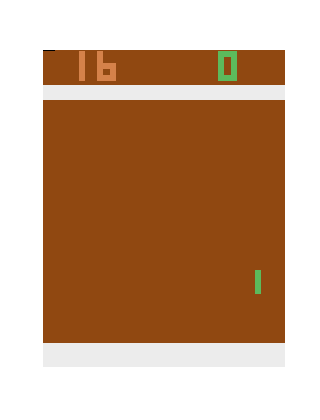
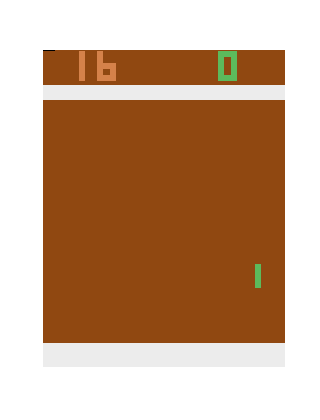
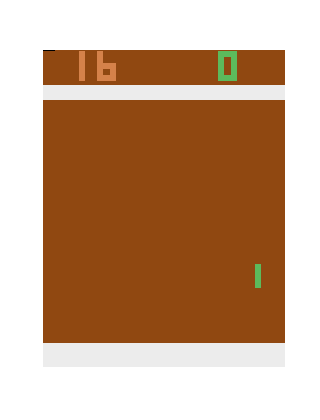
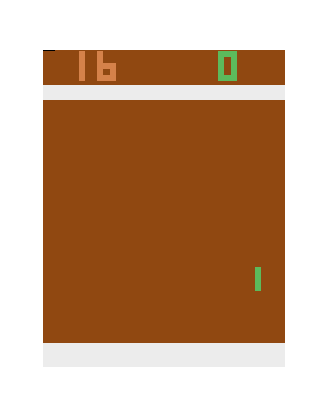
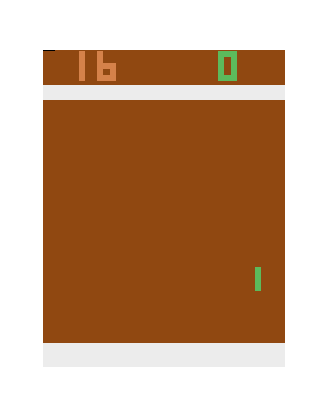
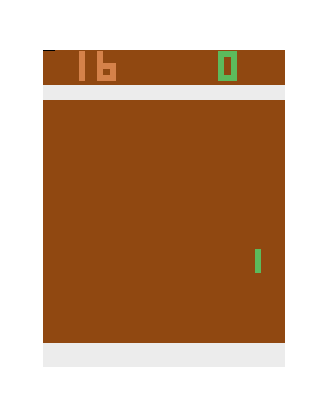
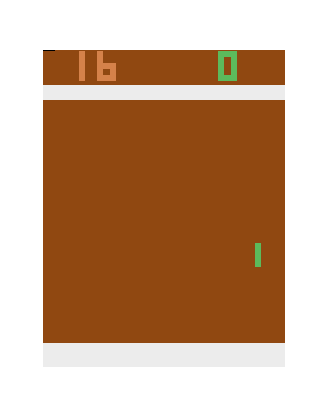
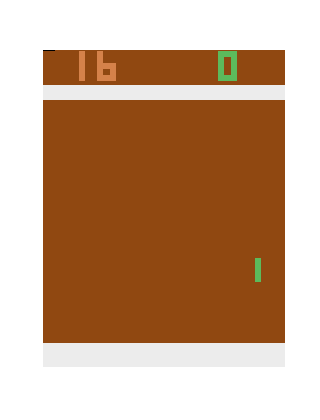
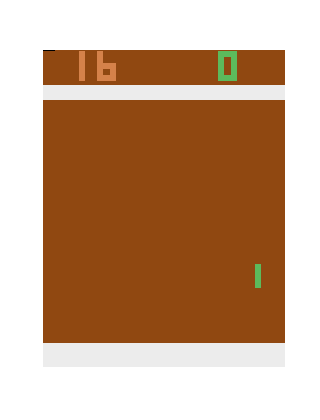
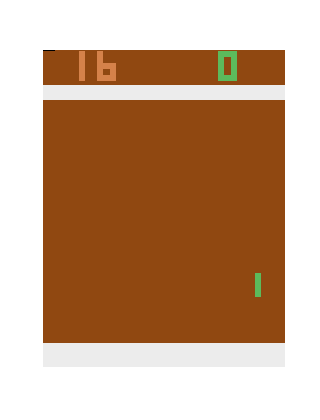
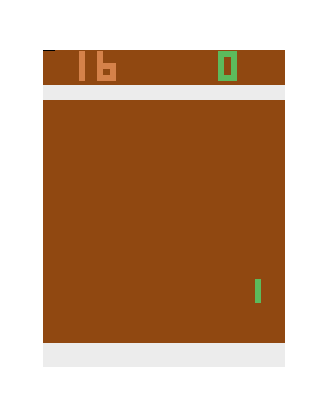
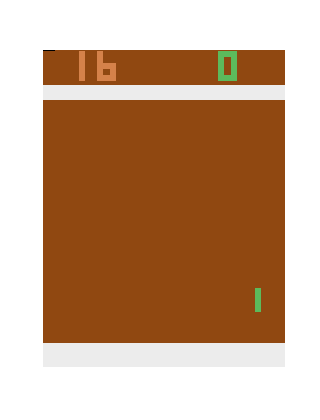
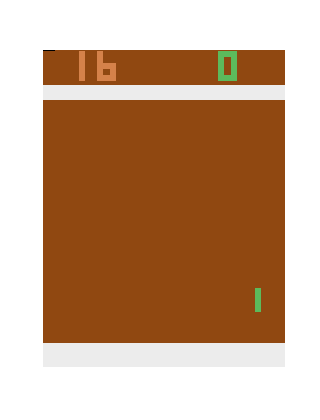
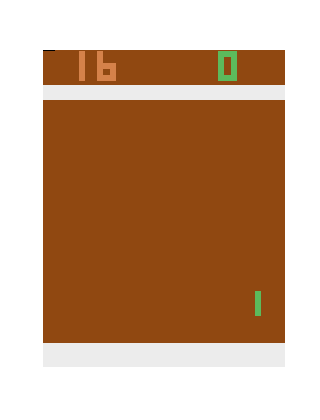
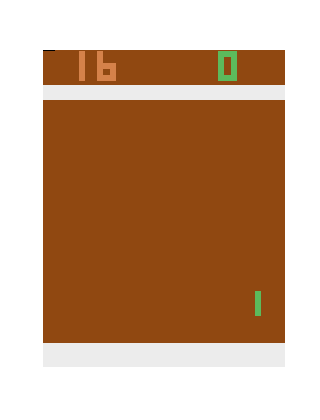
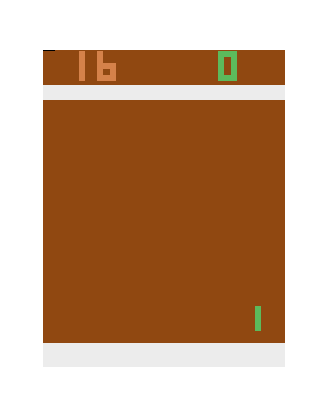
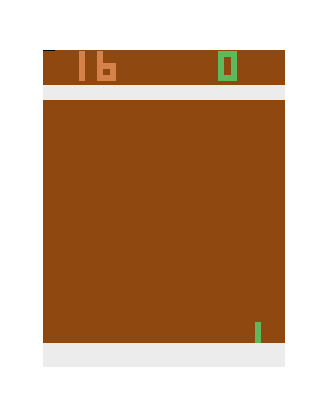
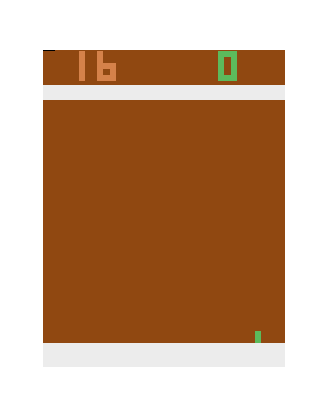
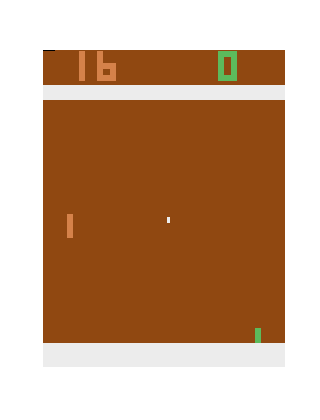
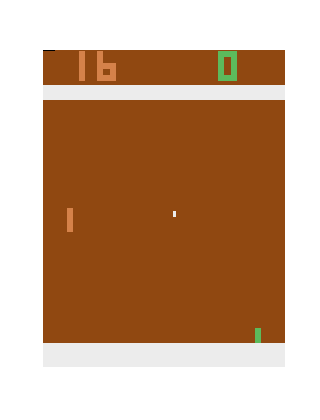
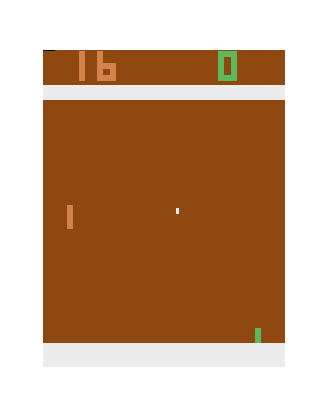
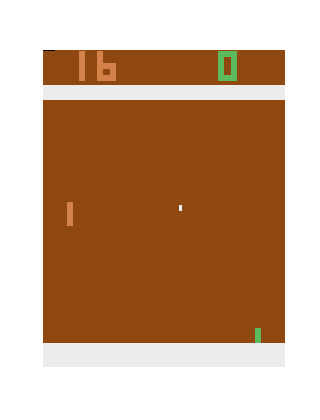
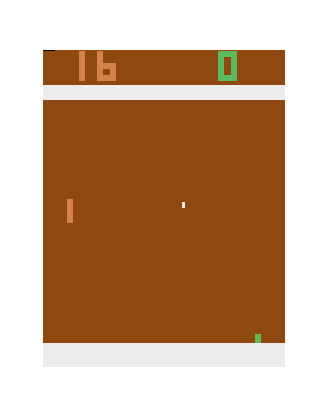
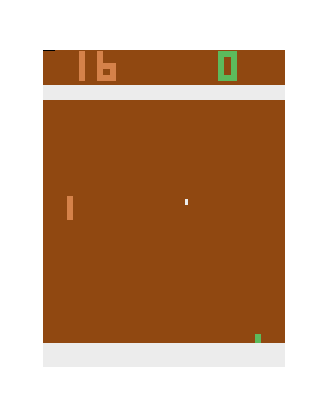
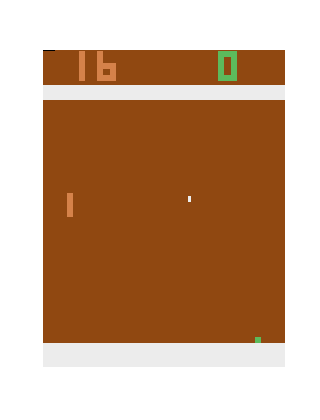
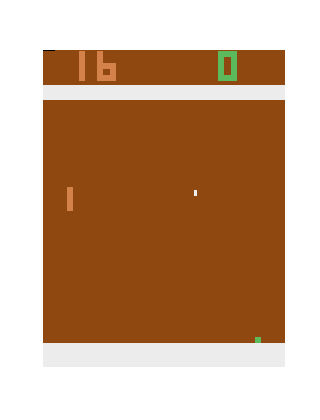
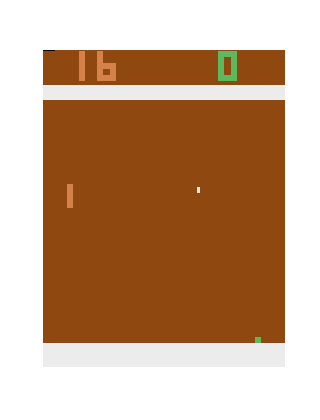
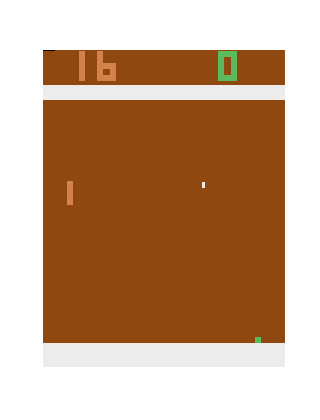
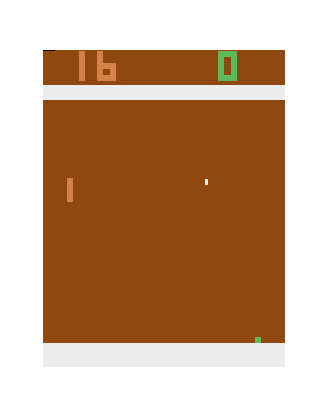
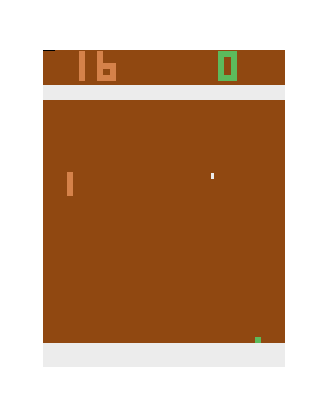
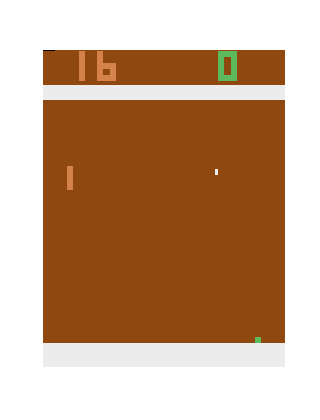
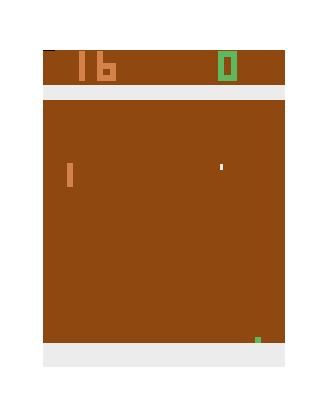
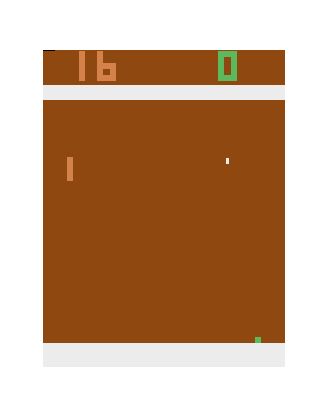
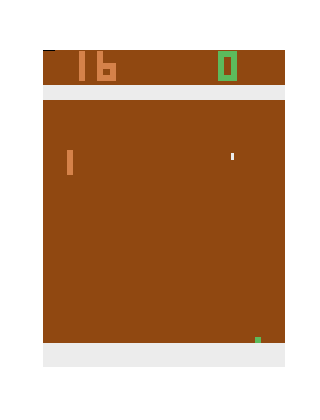
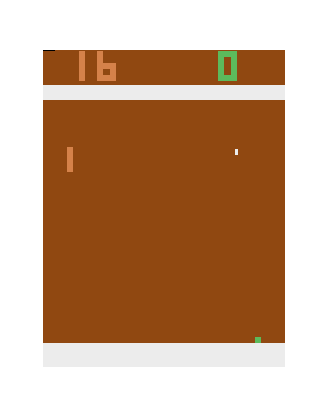
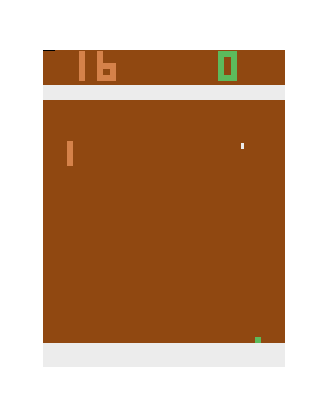
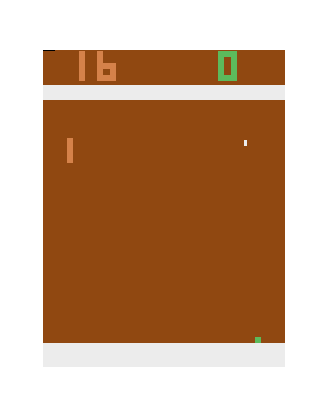
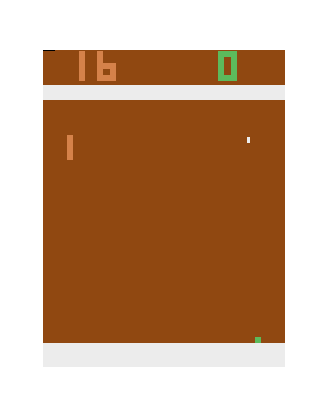
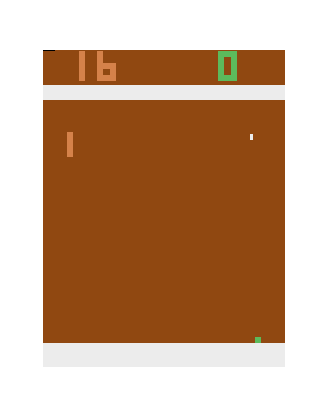
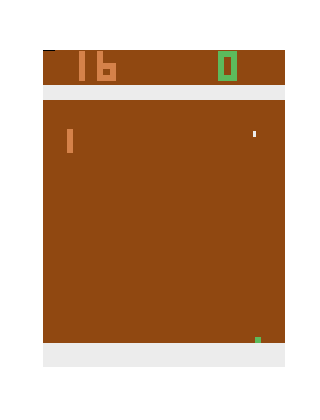
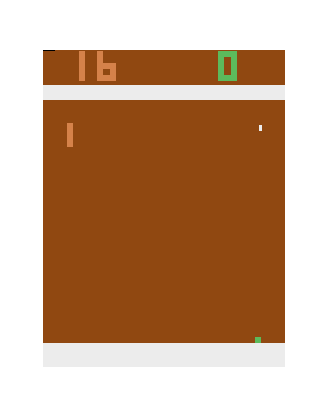
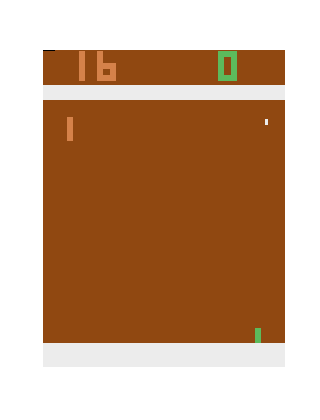
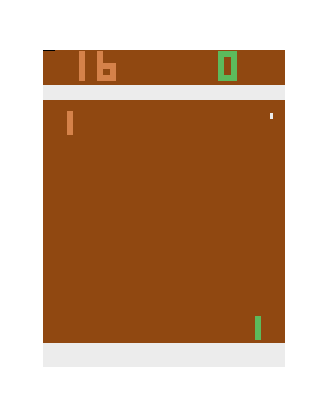
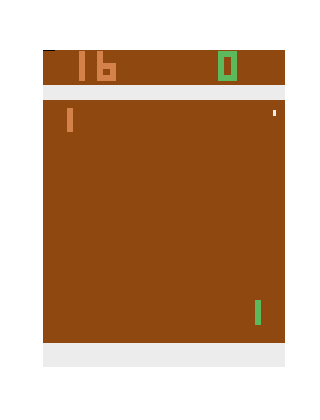
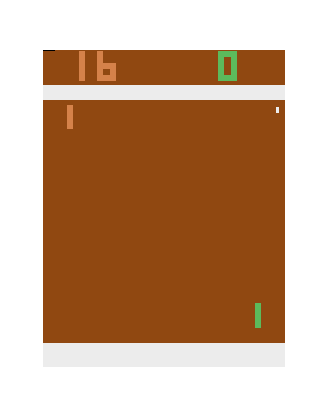
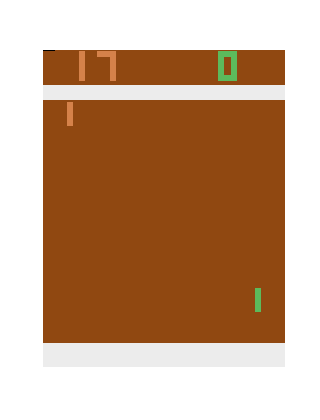
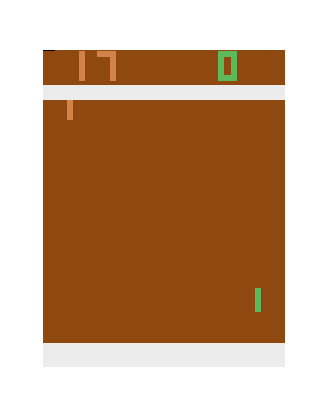
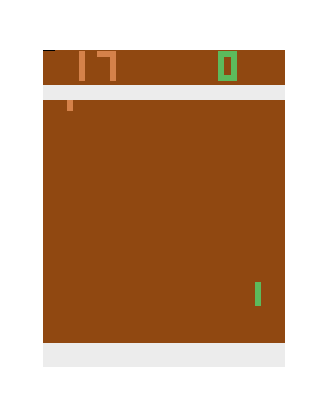
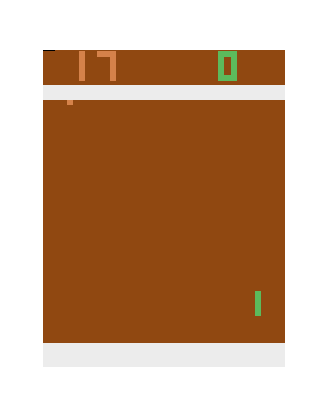
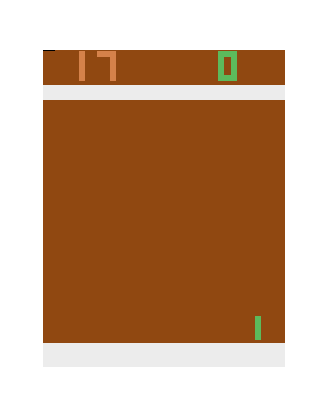
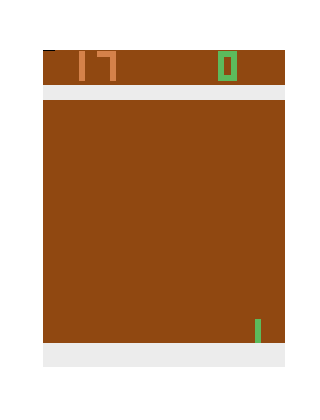
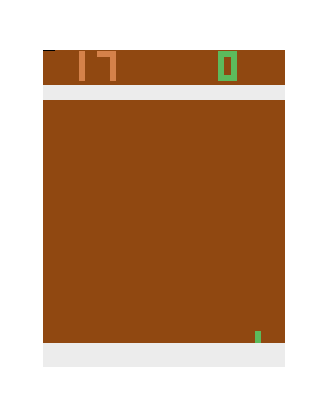
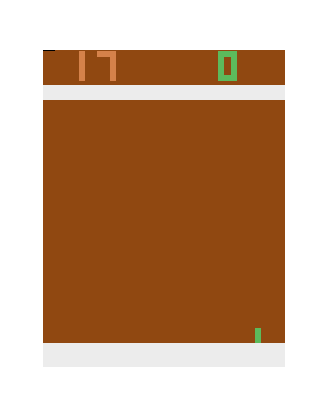
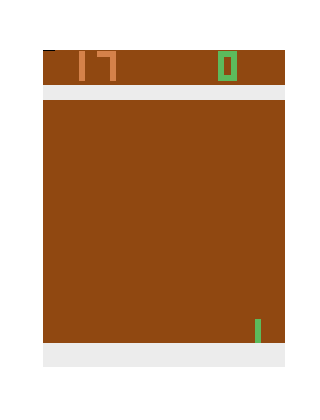
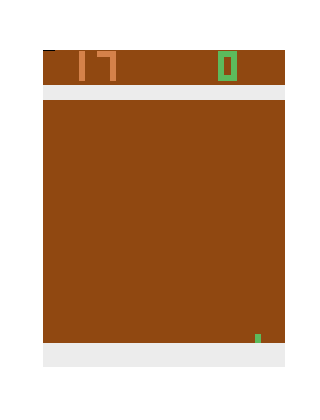
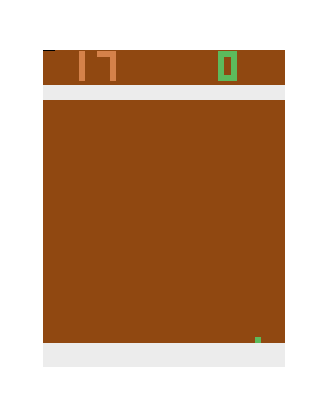

In [7]:
display_frames_as_gif(frames)

In [0]:
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  env.close()
  display_frames_as_gif(frames)

In [0]:
import numpy as np

# model initialization
H = 200 # number of hidden layer neurons
D = 80 * 80 # input dimensionality: 80x80 grid
model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
model['W2'] = np.random.randn(H) / np.sqrt(H)

# import pickle
# model = pickle.load(open('model.pkl', 'rb'))

Episode finished without success, accumulated reward = -18.0



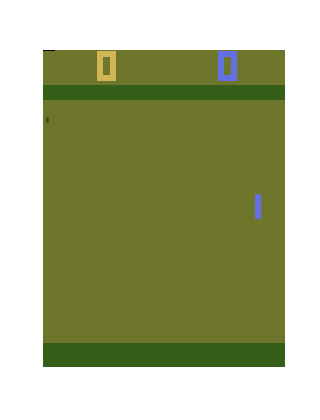
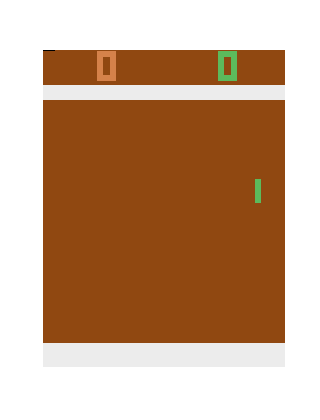
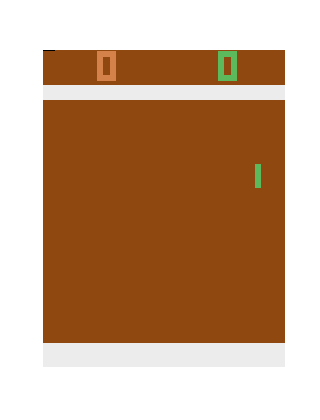
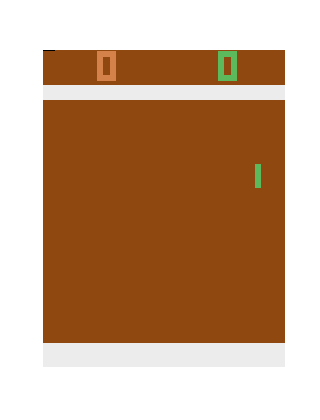
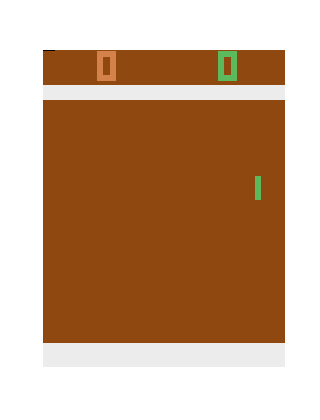
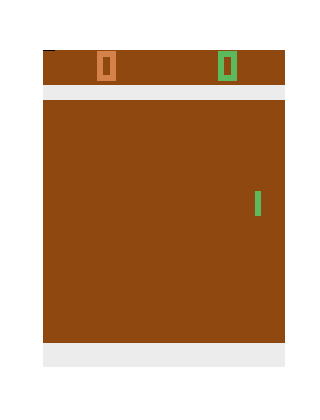
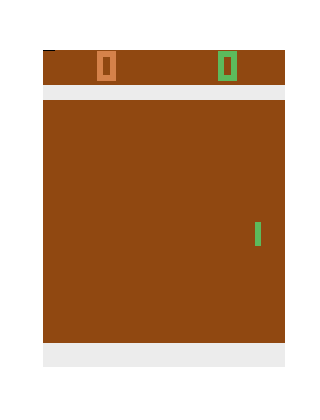
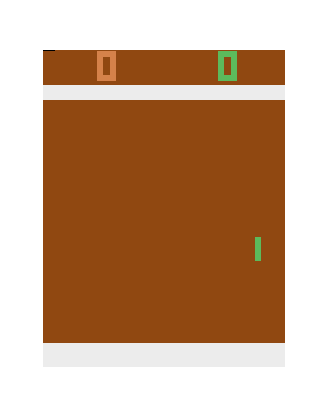
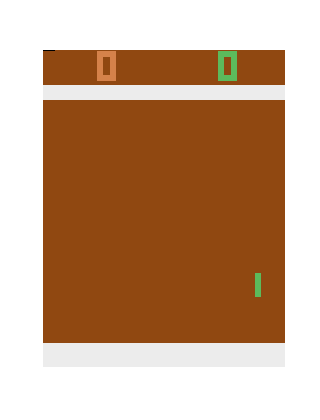
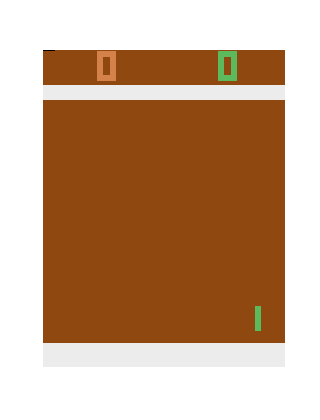
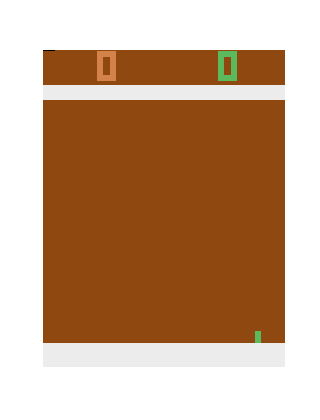
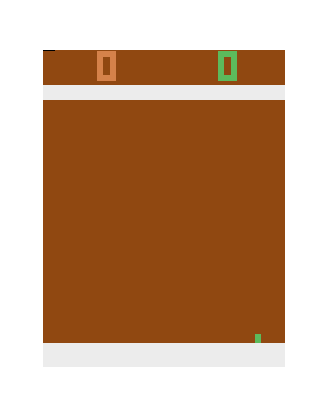
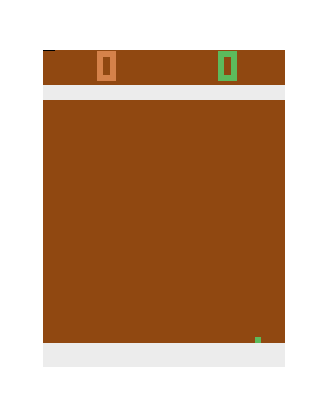
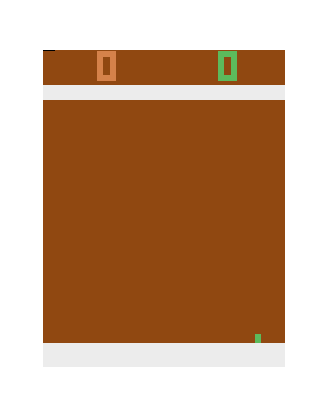
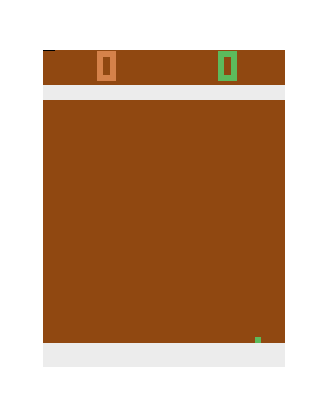
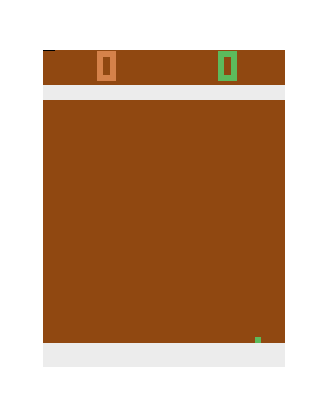
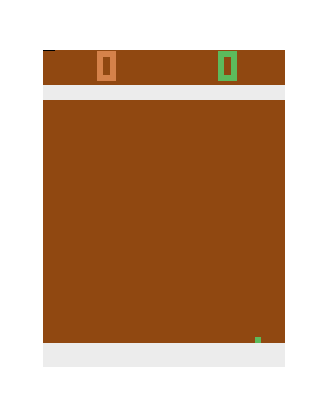
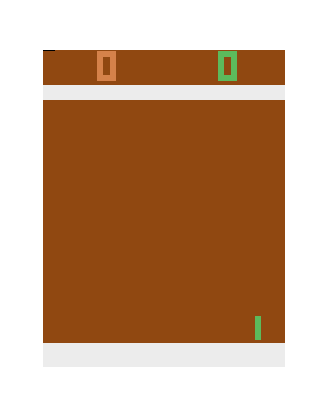
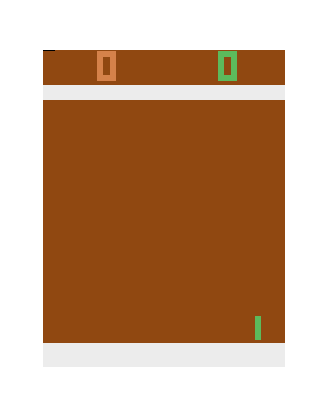
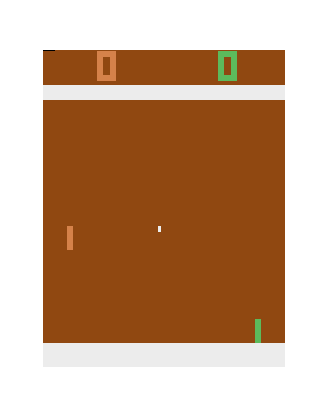
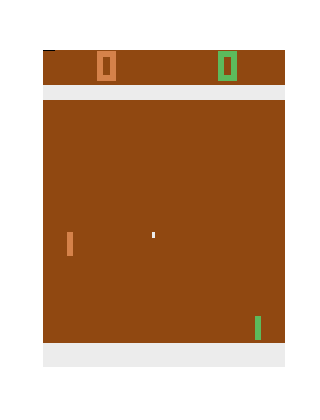
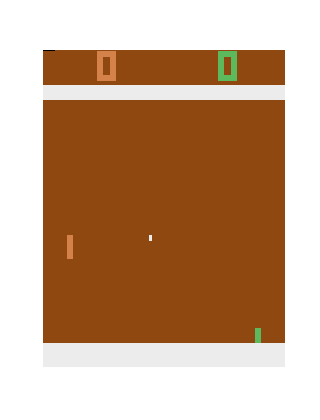
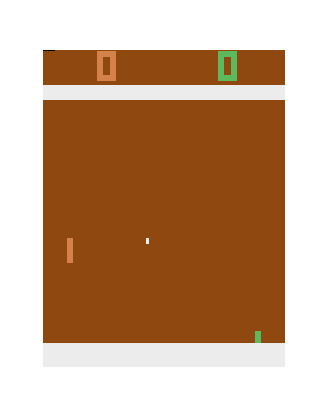
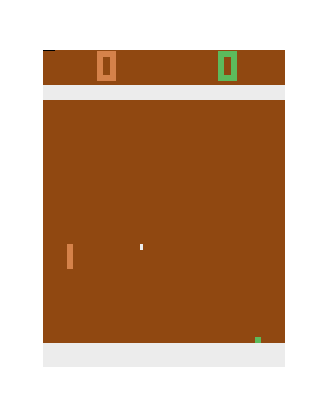
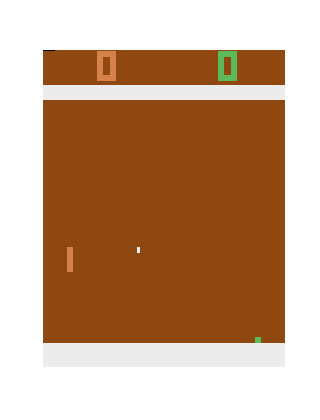
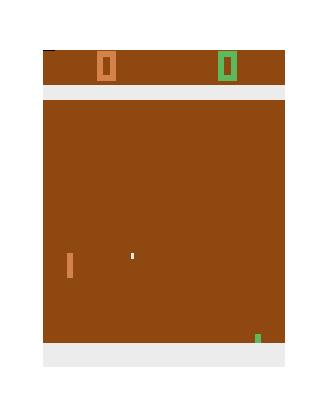
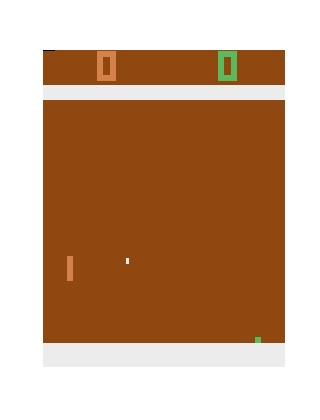
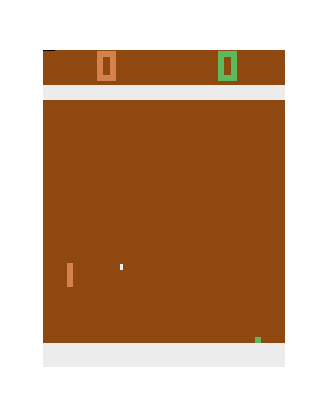
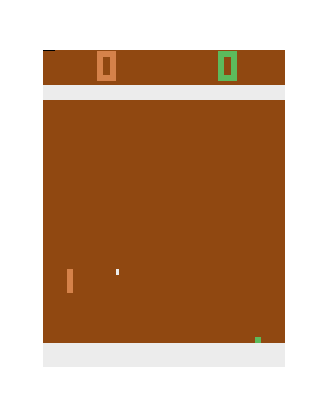
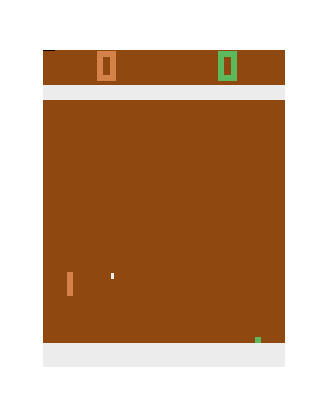
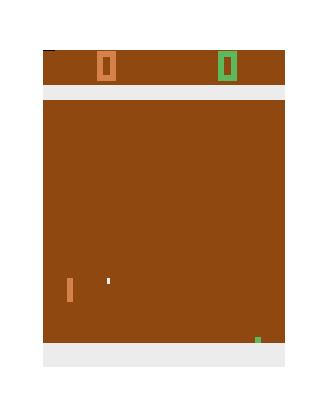
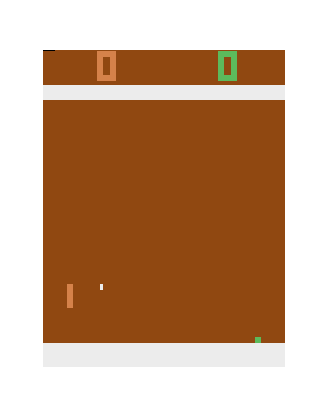
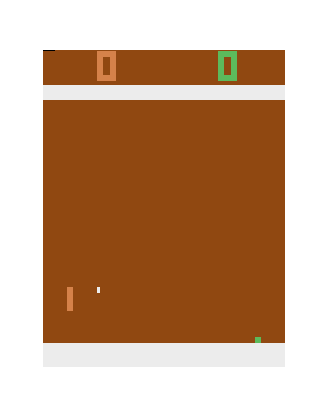
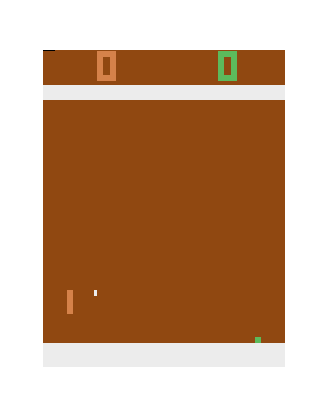
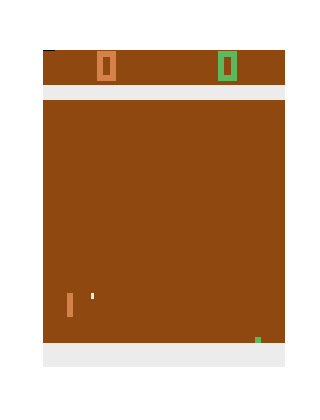
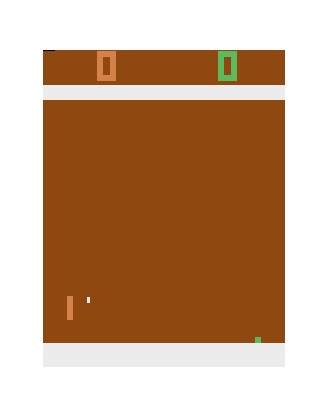
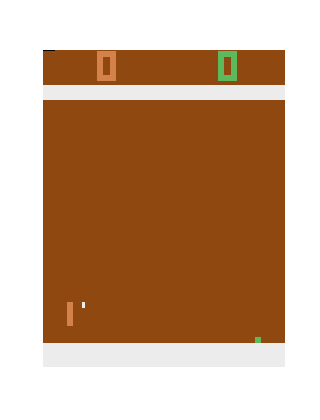
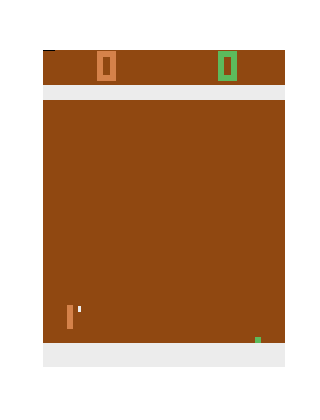
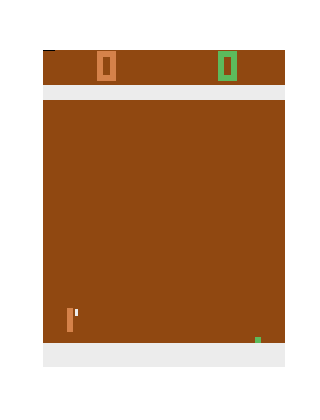
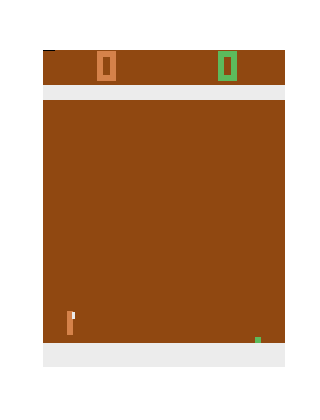
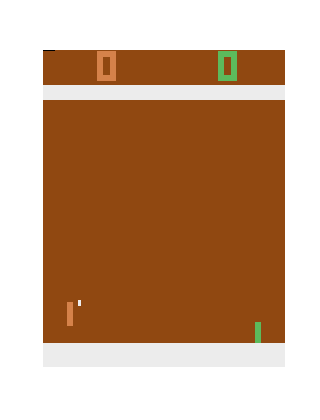
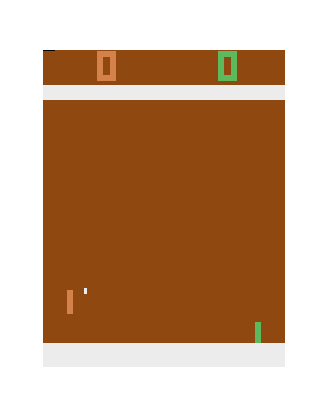
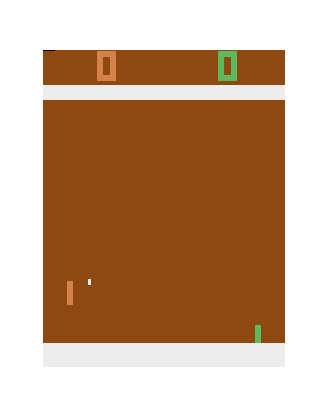
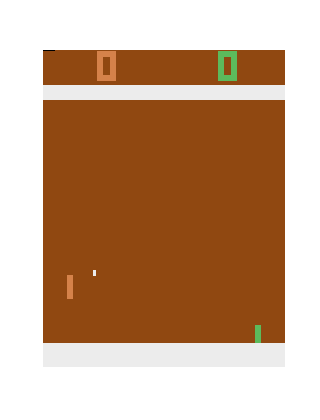
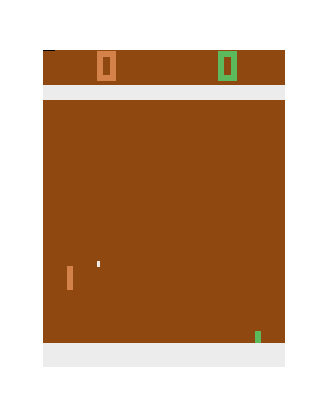
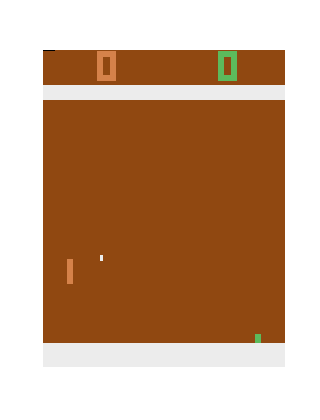
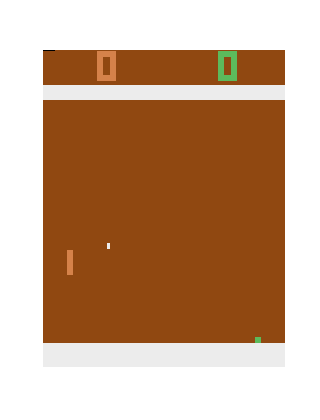
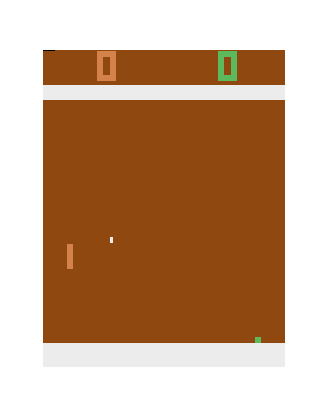
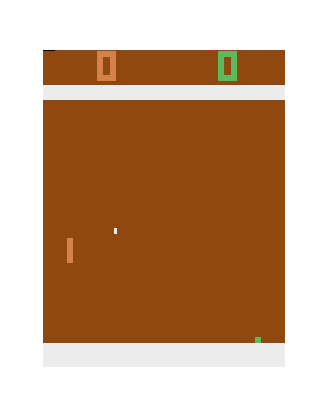
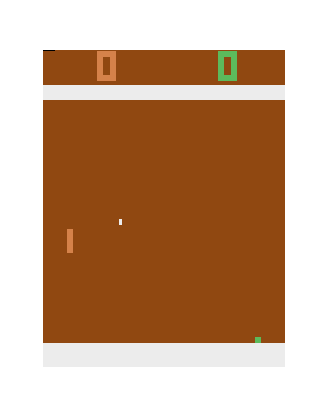
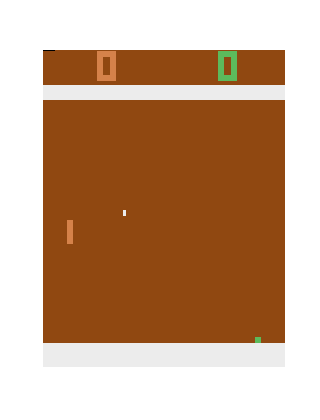
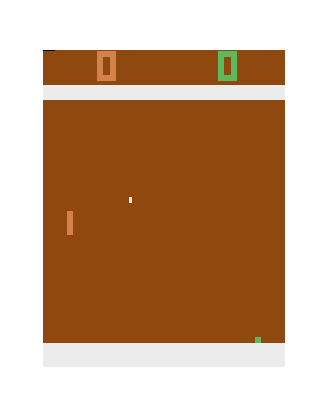
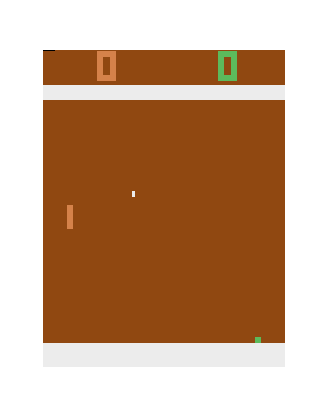
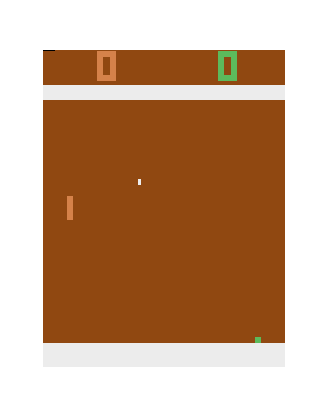
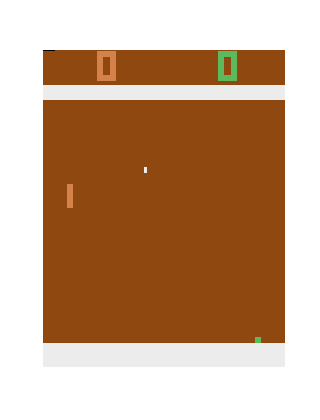
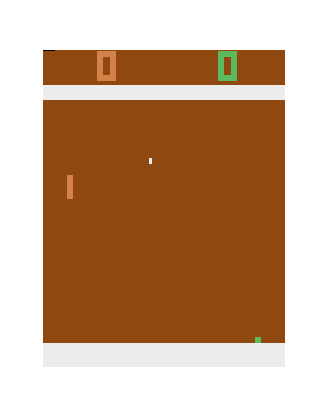
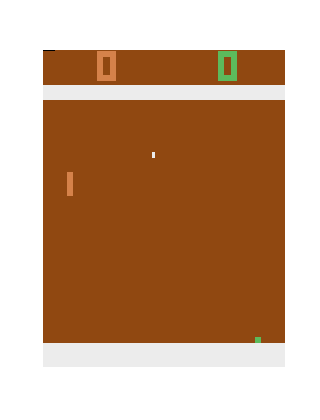
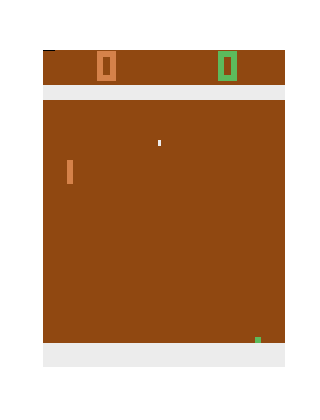
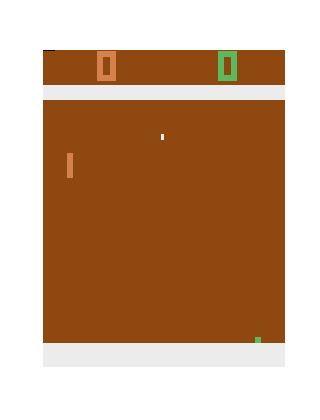
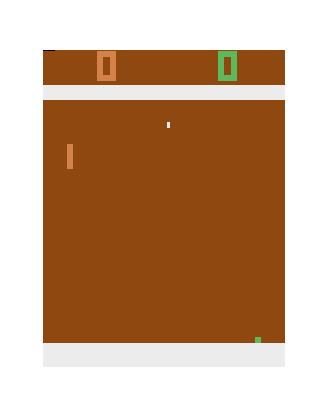
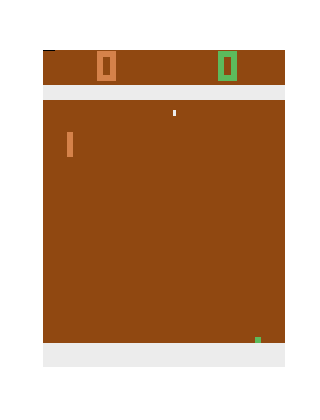
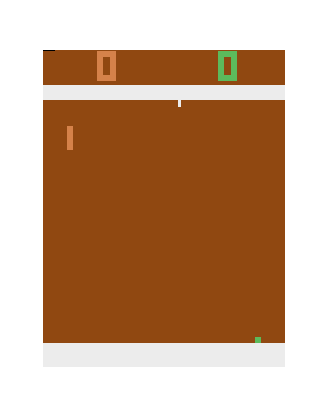
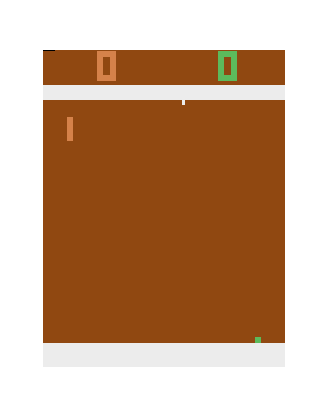
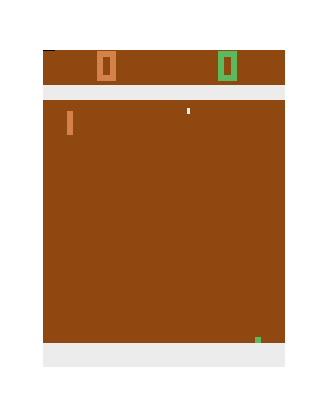
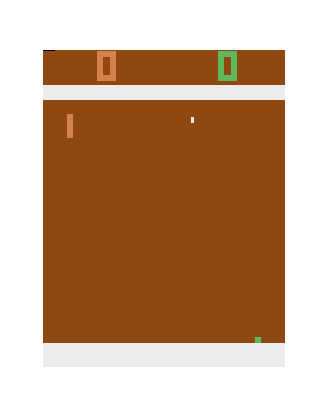
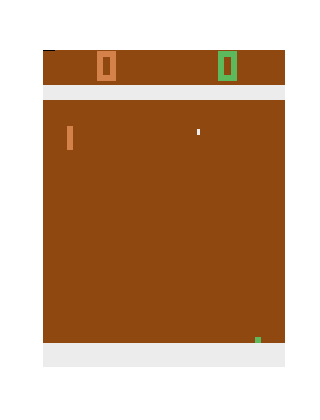
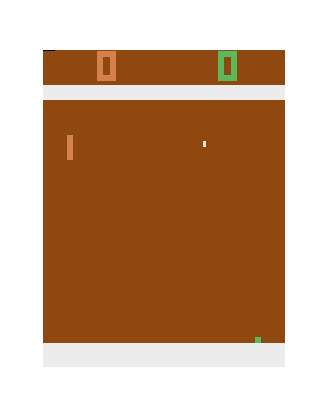
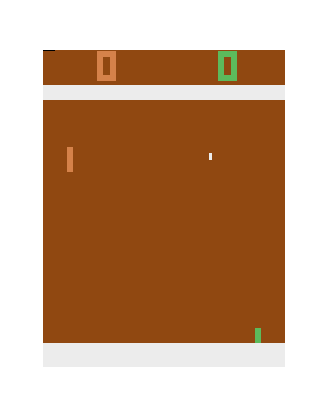
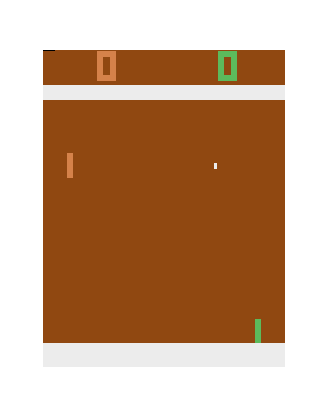
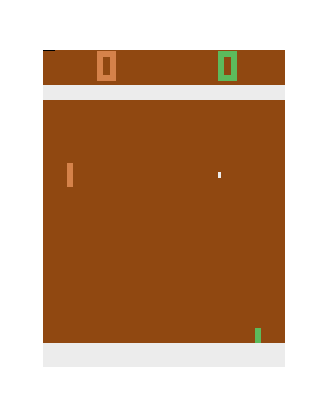
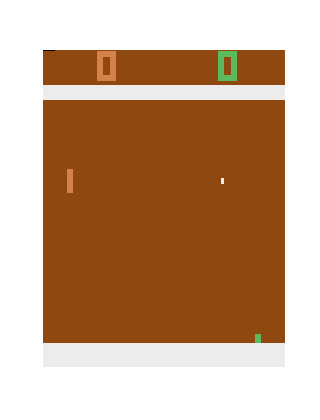
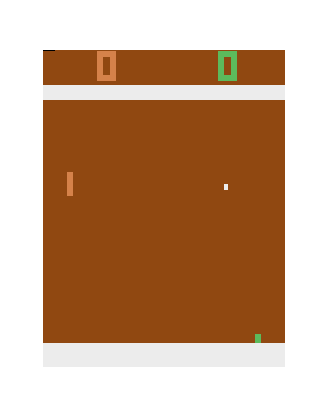
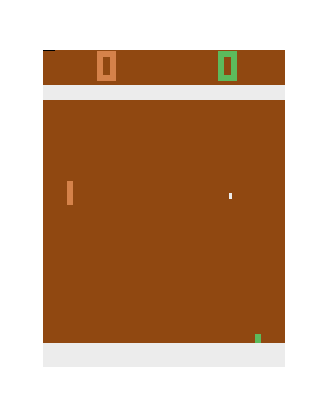
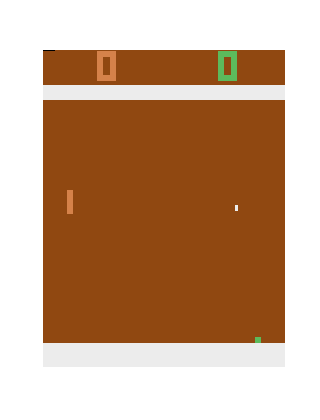
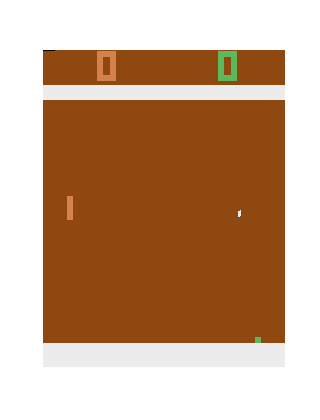
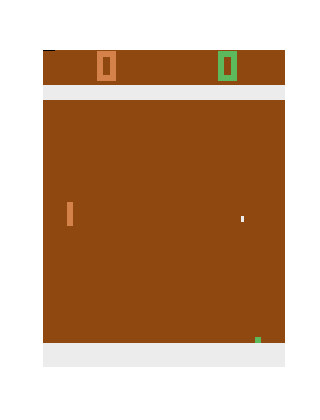
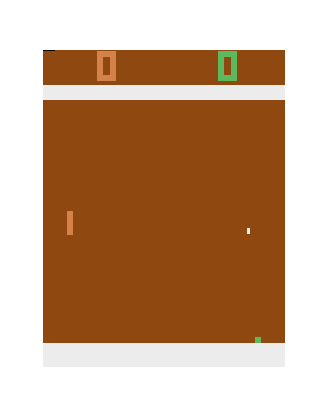
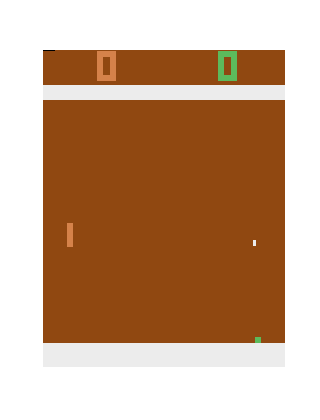
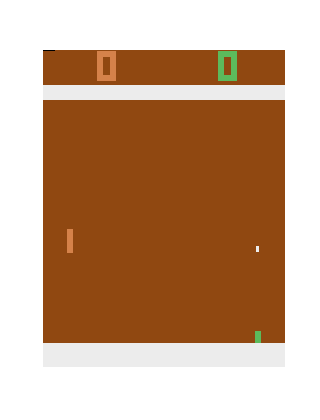
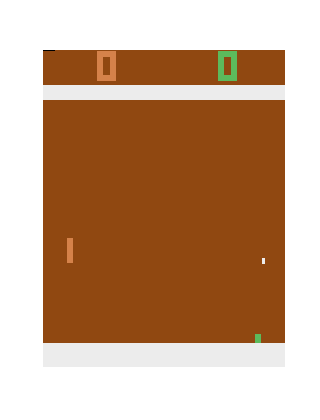
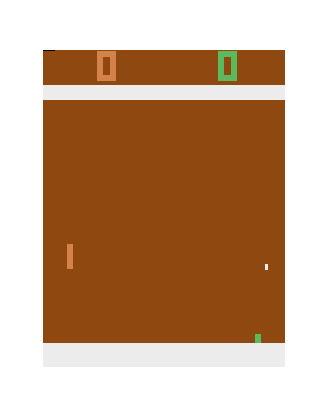
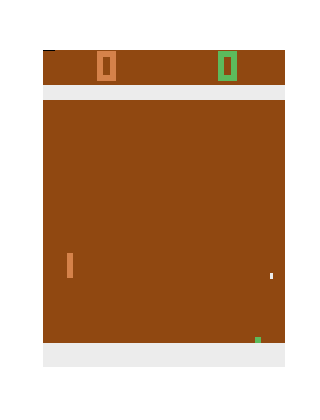
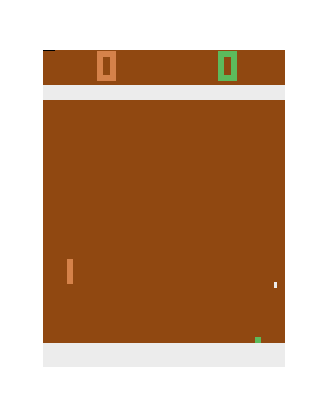
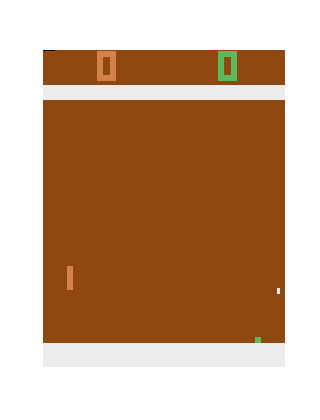
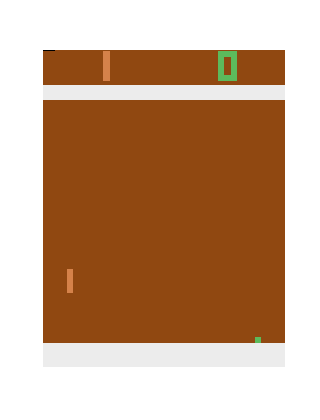
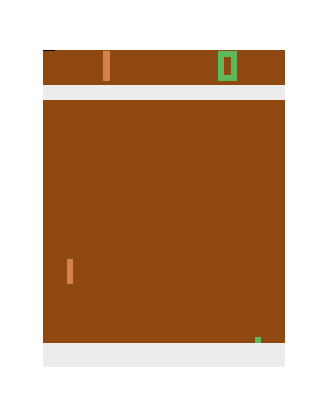
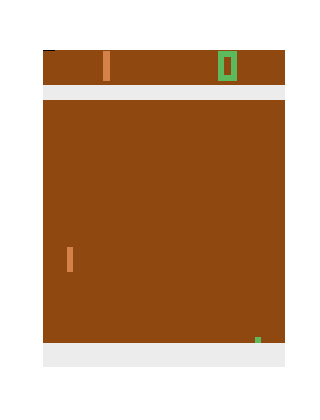
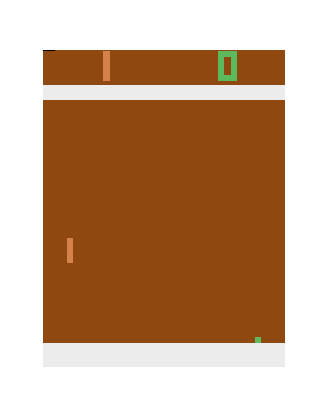
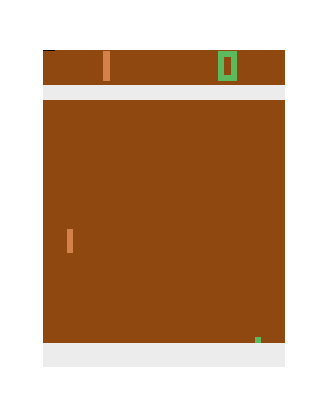
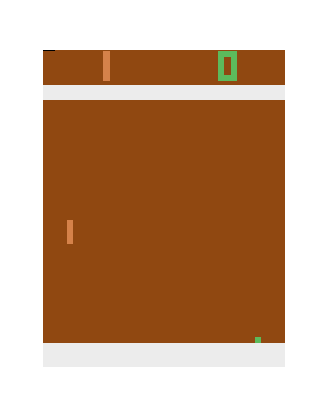
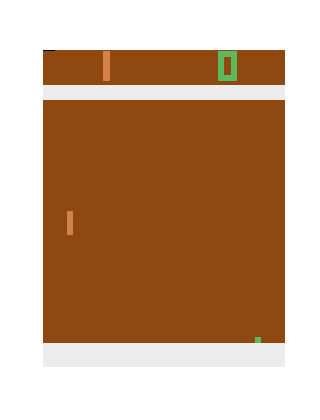
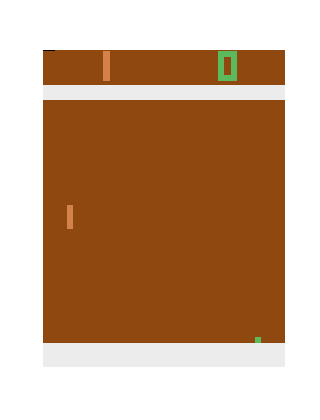
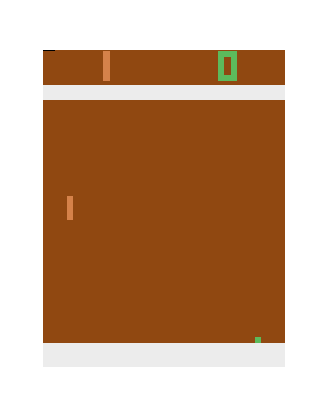
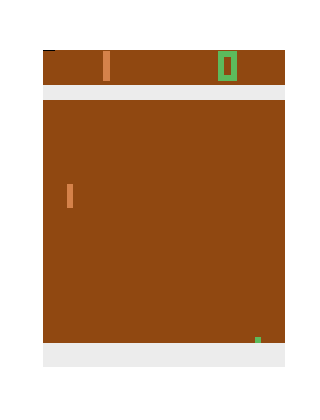
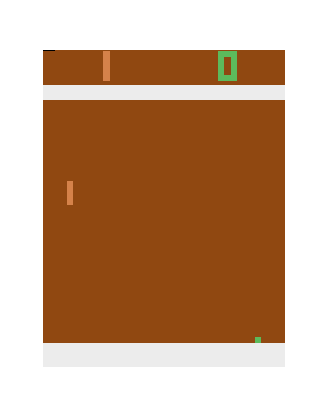
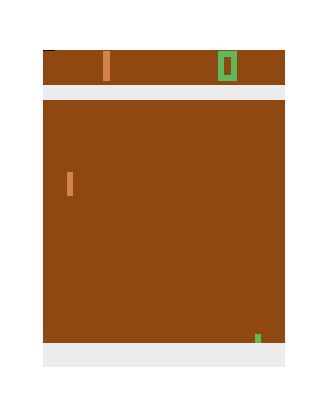
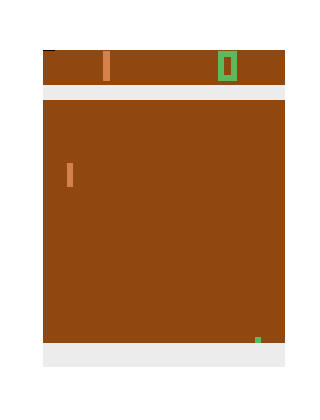
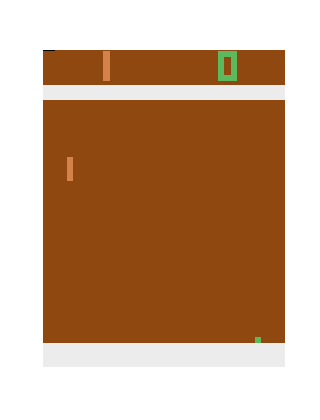
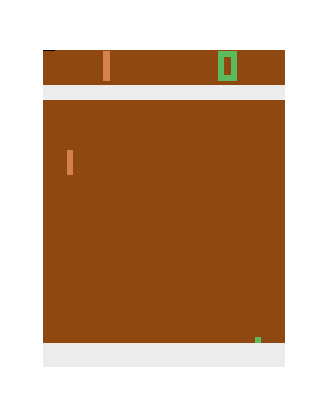
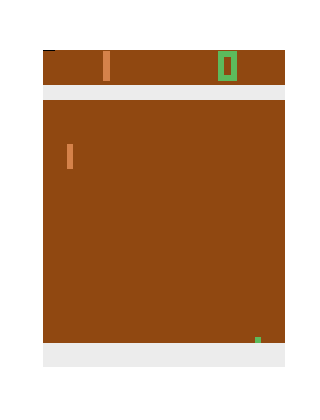
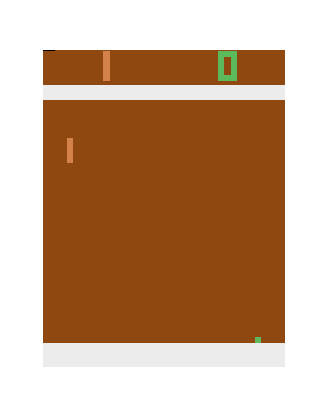
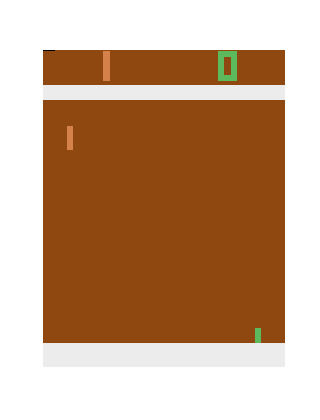
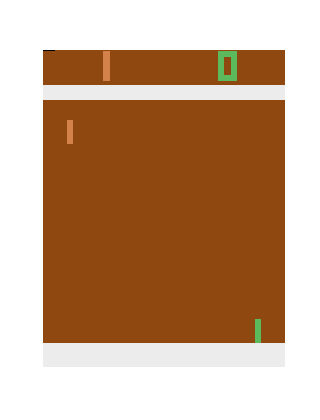
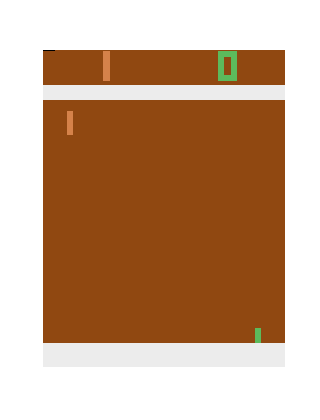
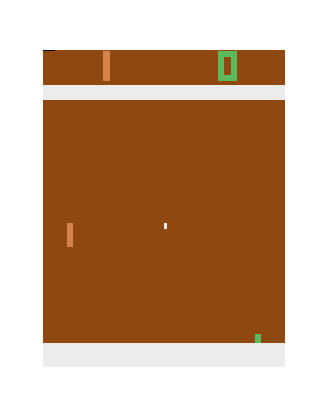
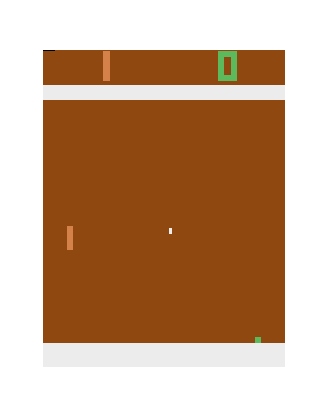
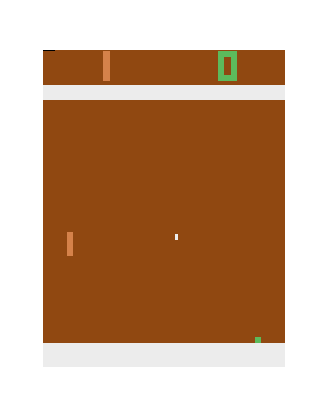
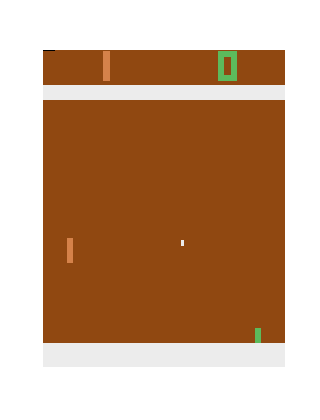
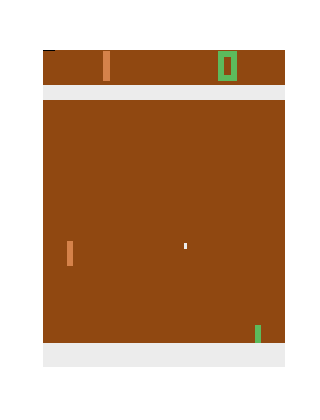
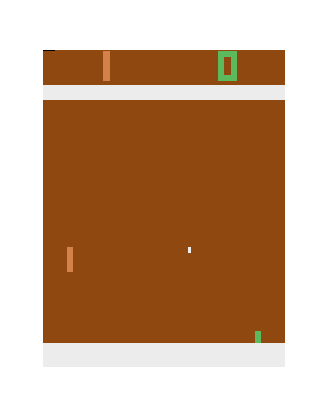
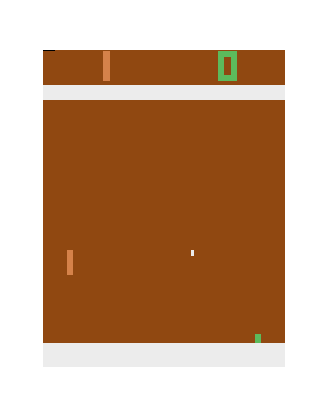
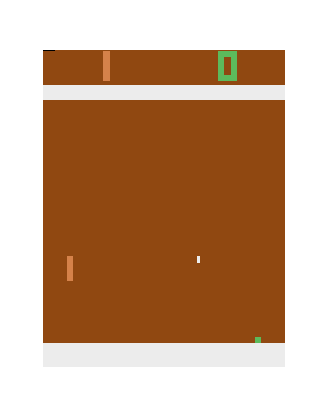
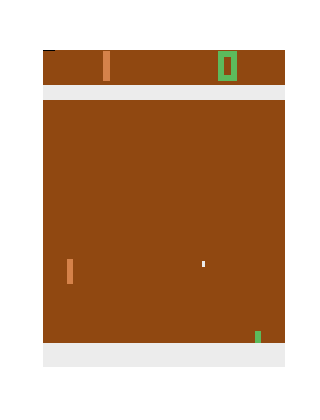
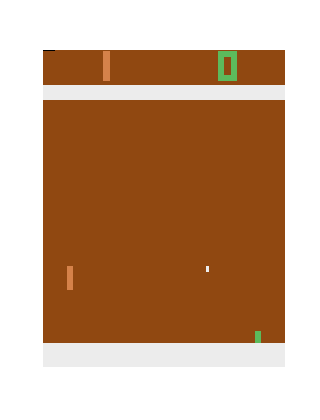
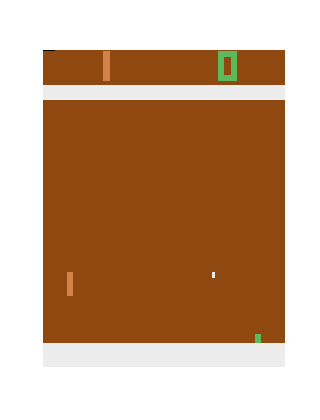
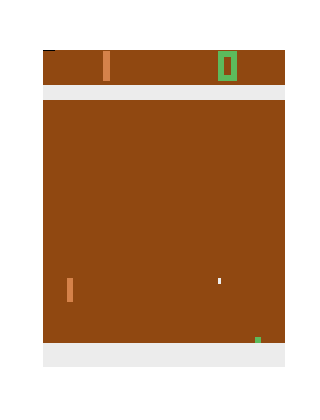
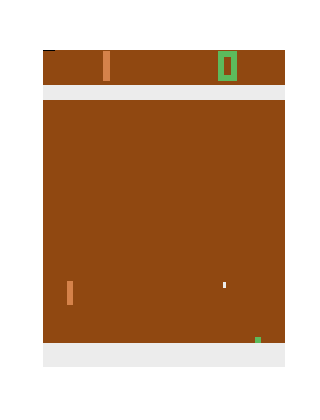
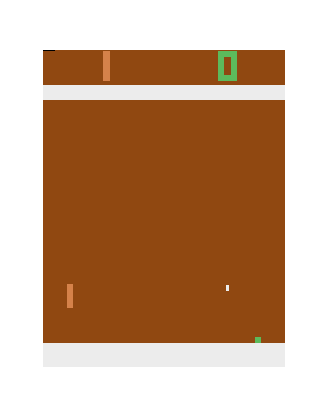
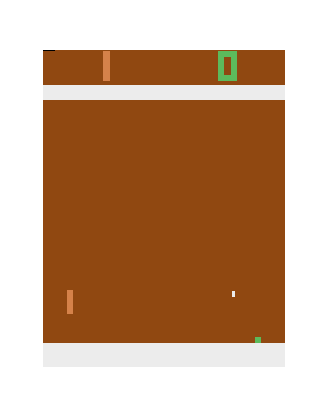
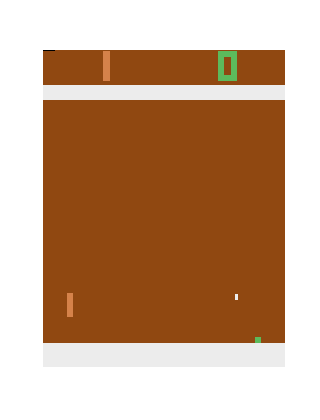
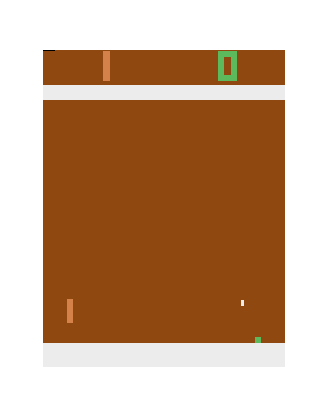
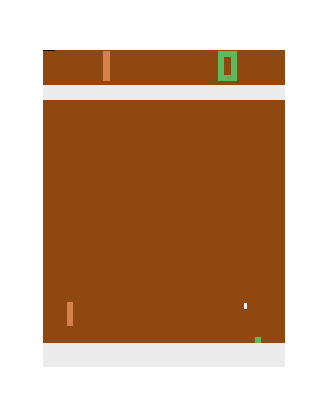
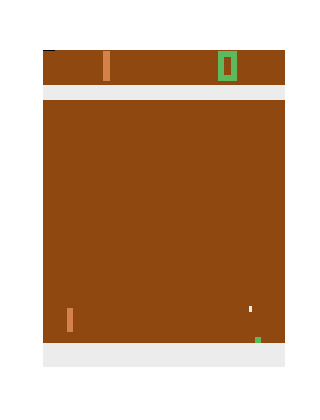
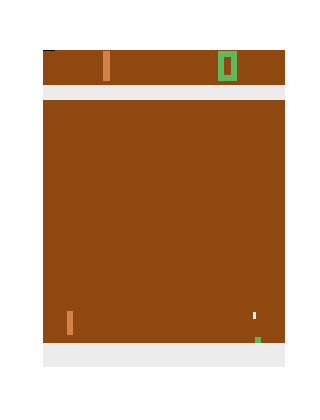
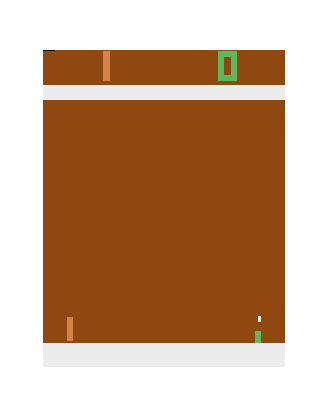
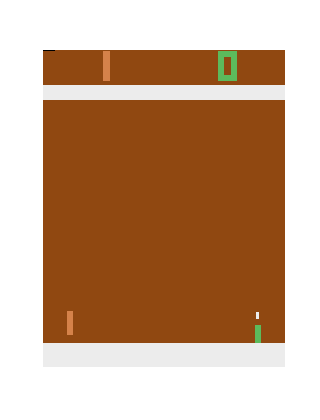
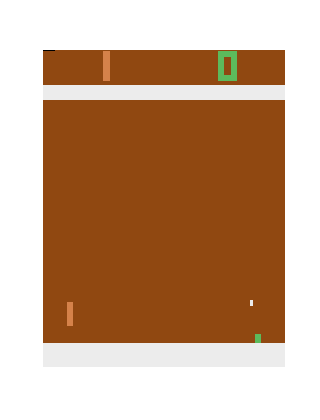
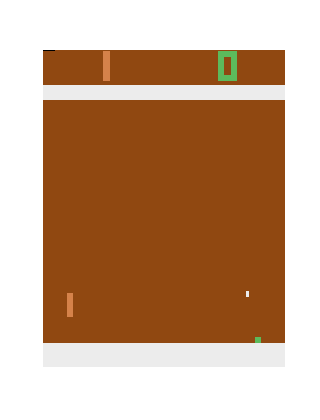
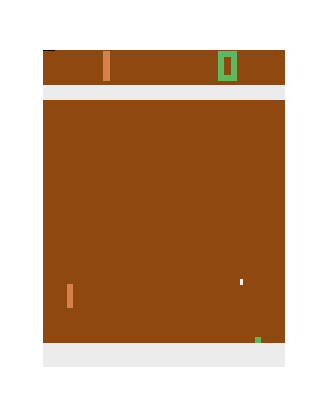
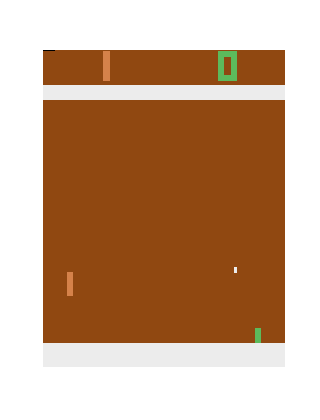
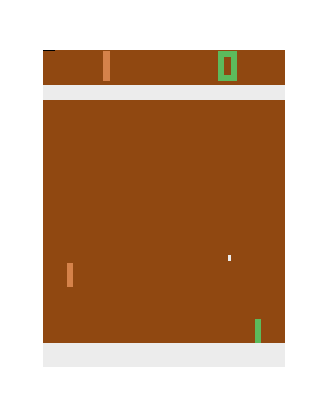
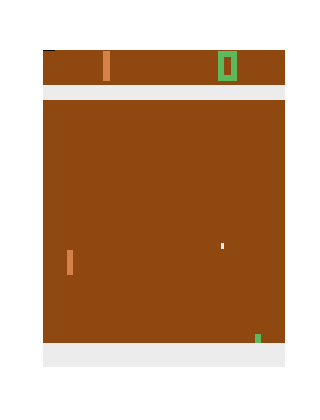
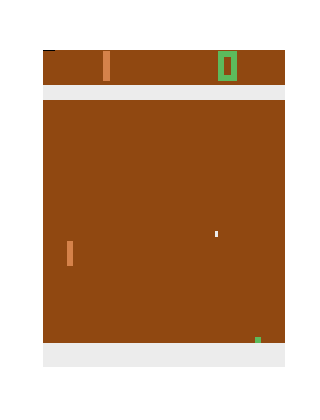
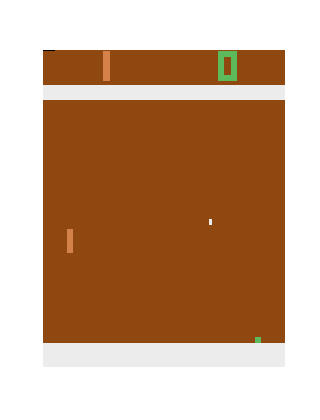
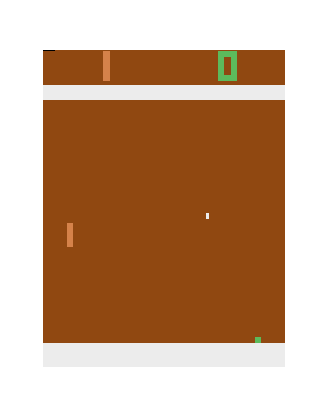
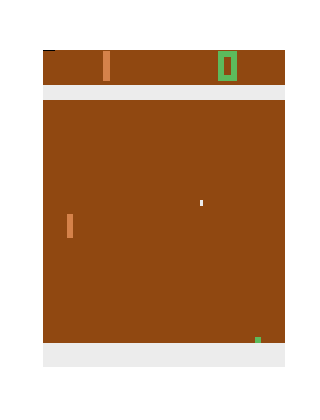
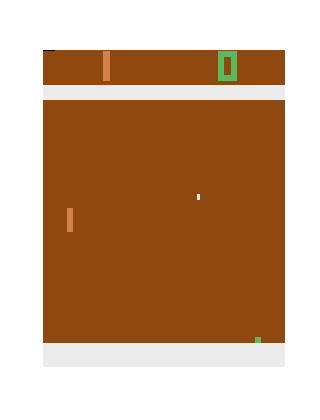
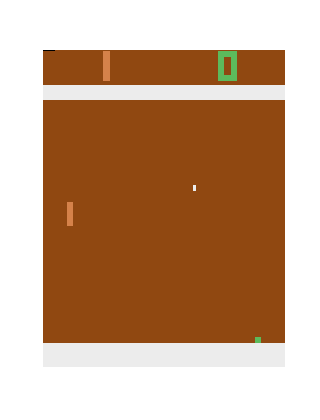
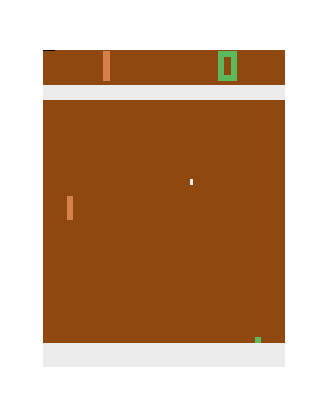
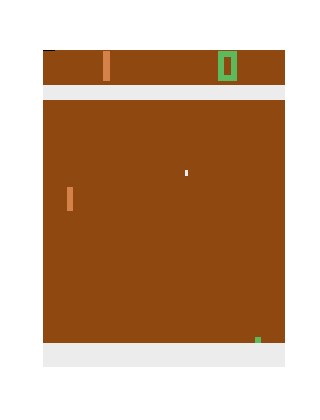
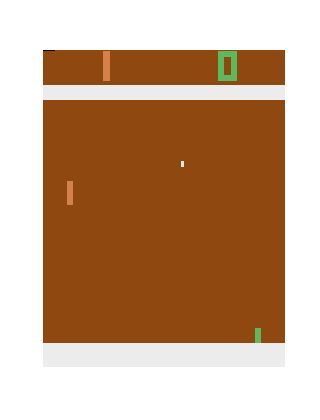
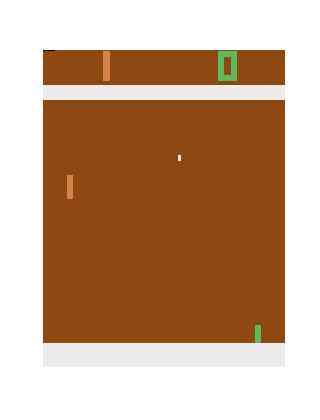
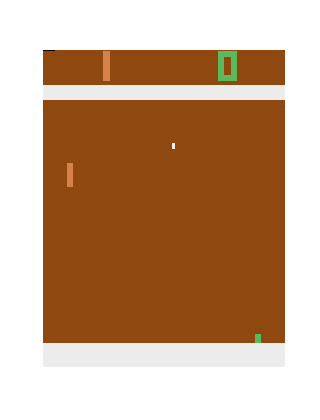
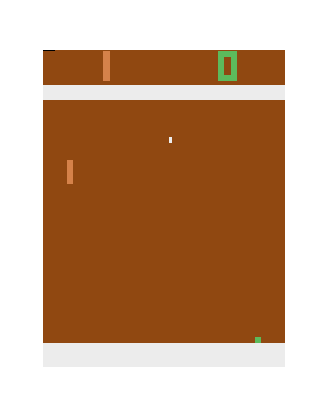
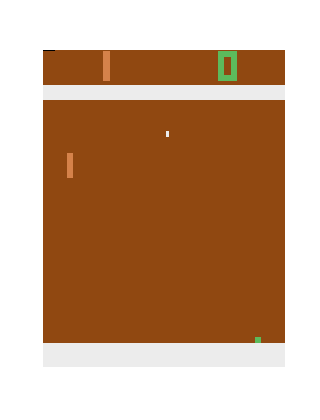
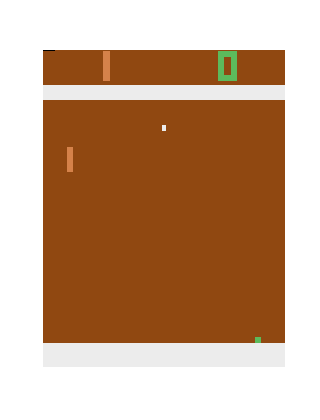
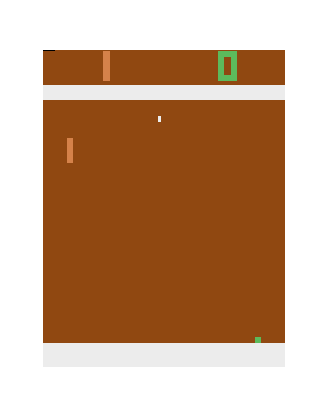
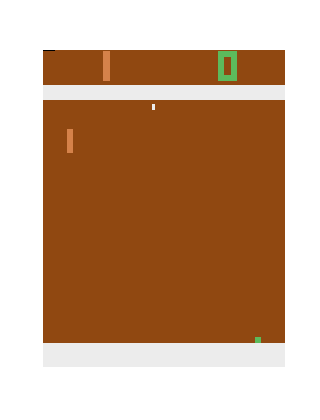
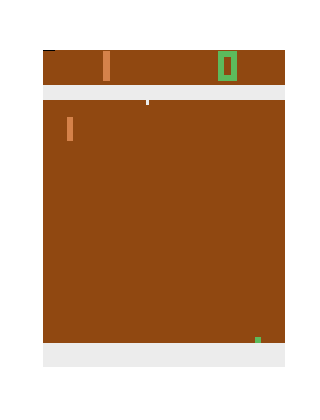
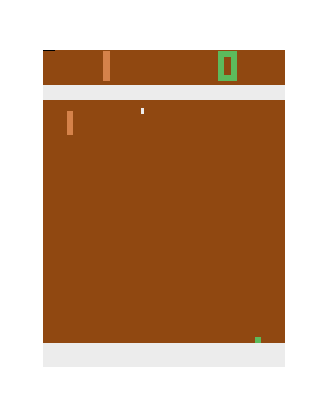
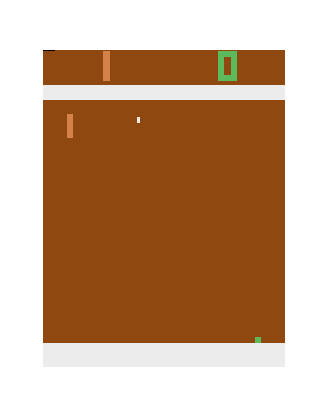
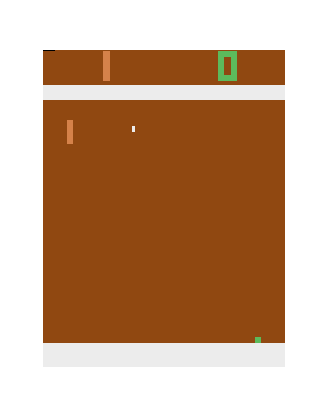
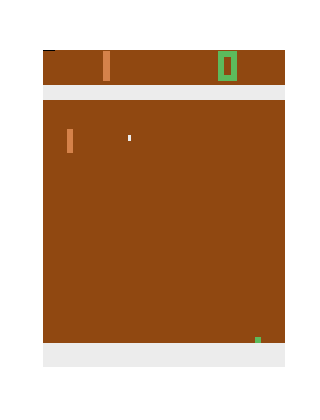
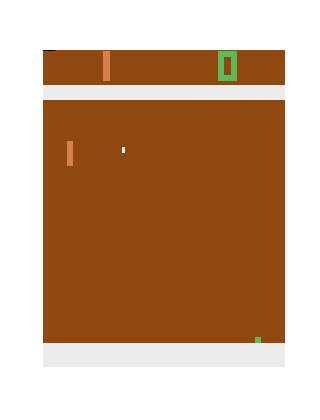
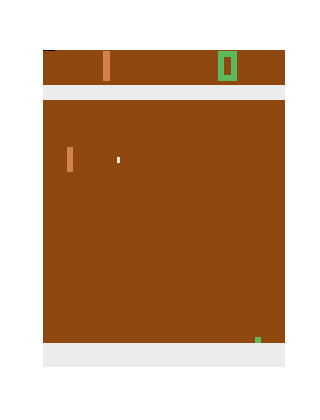
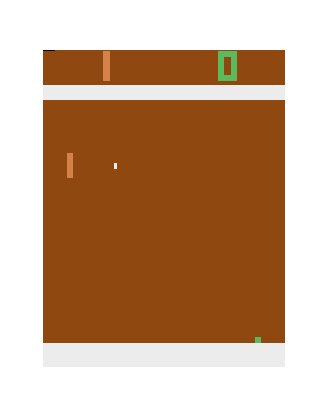
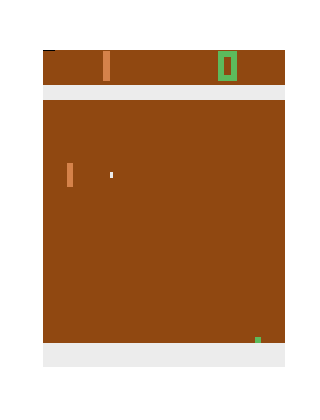
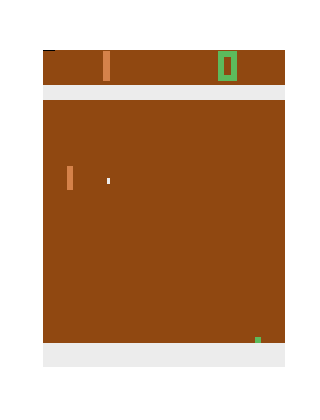
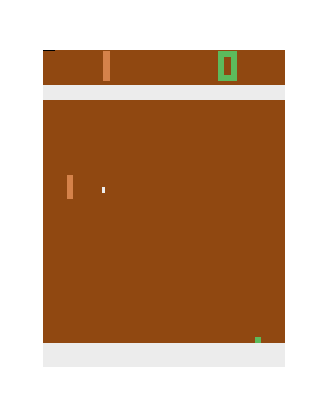
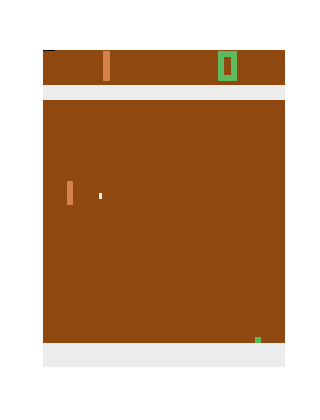
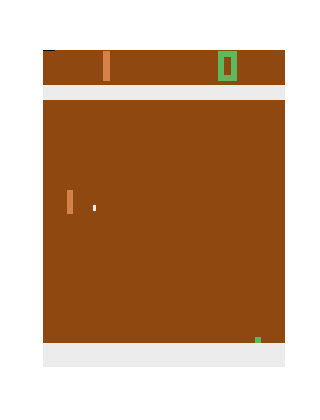
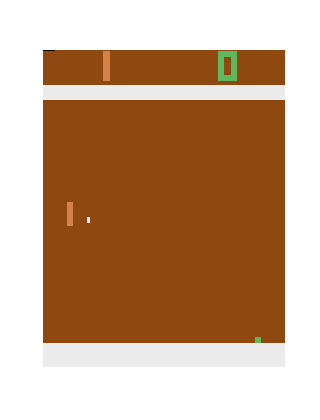
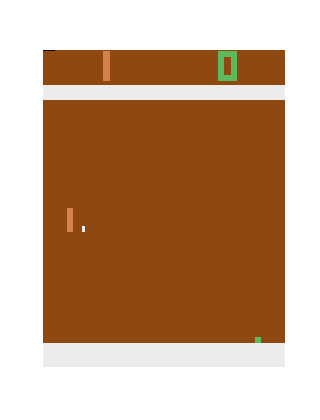
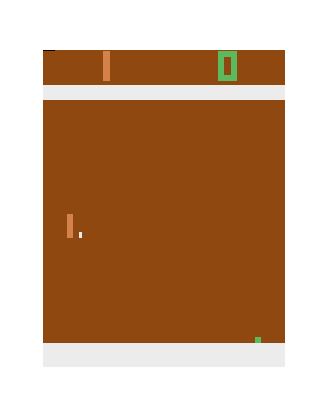
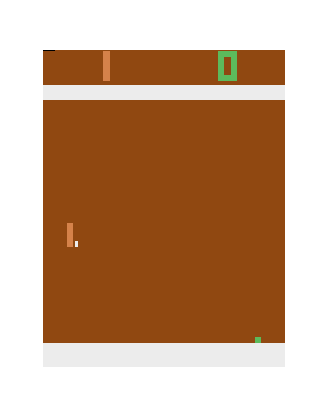
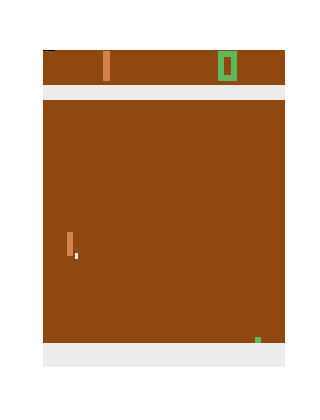
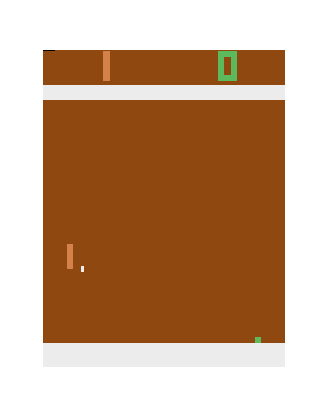
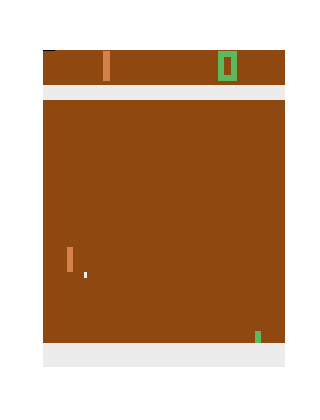
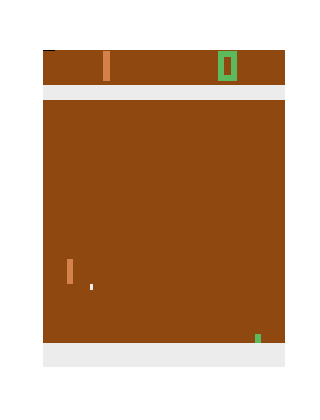
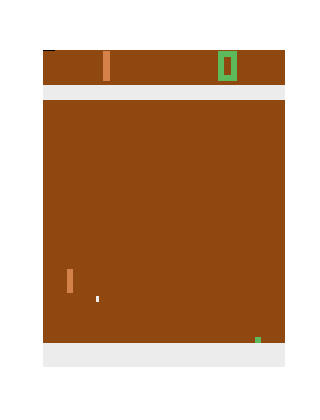
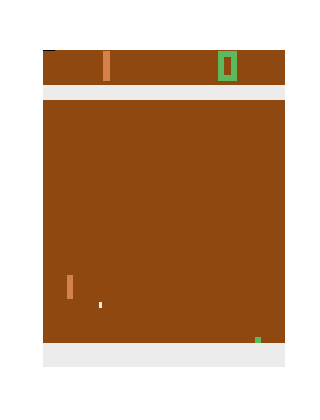
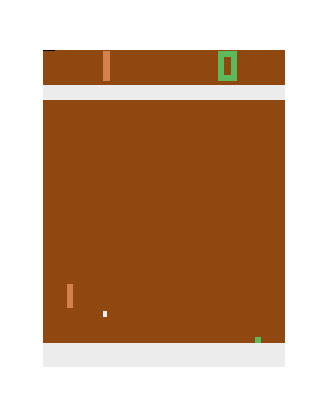
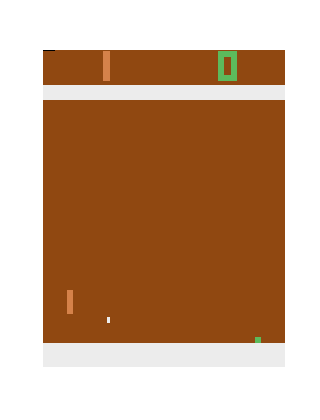
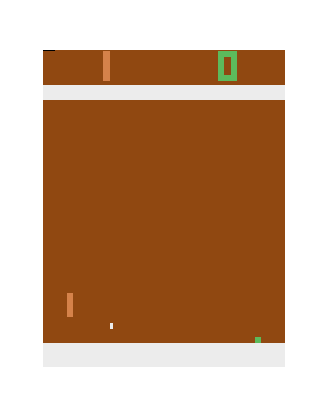
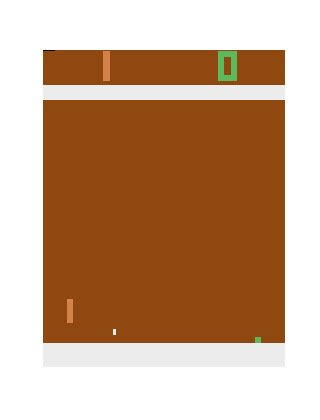
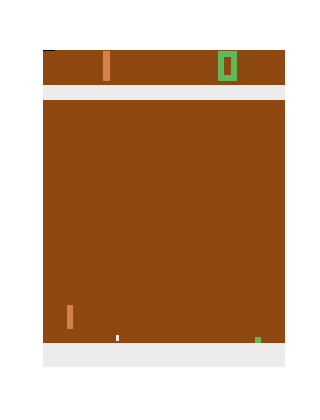
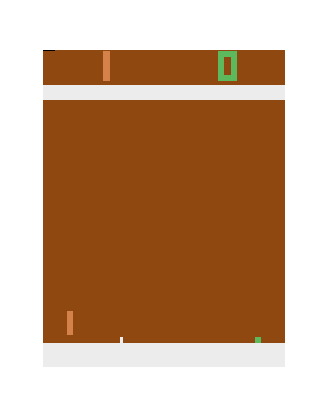
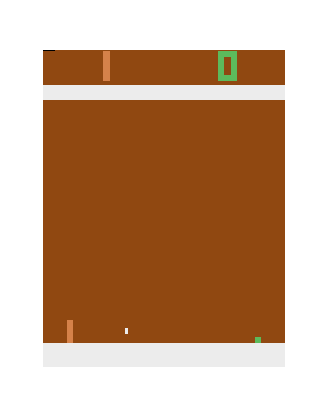
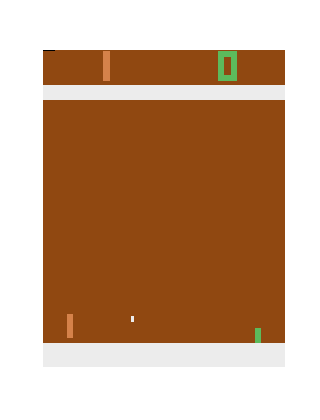
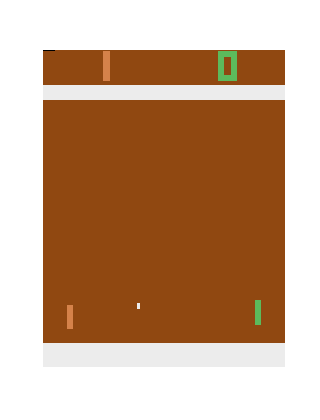
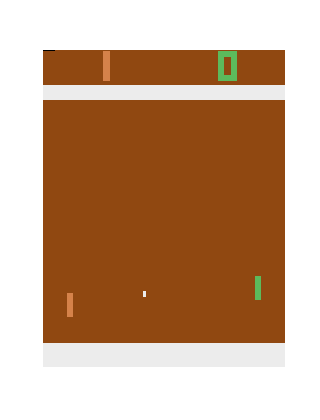
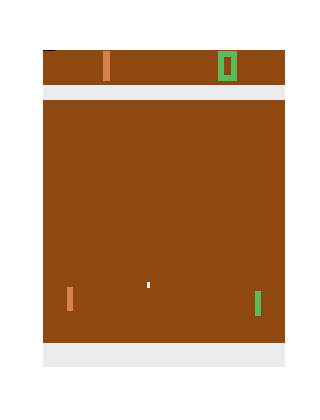
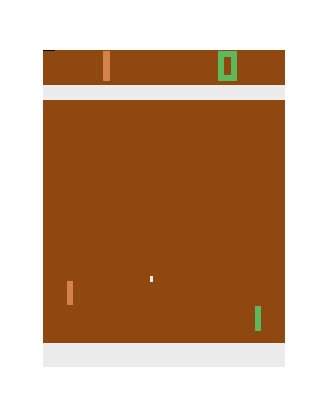
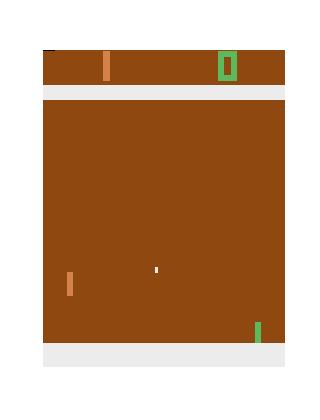
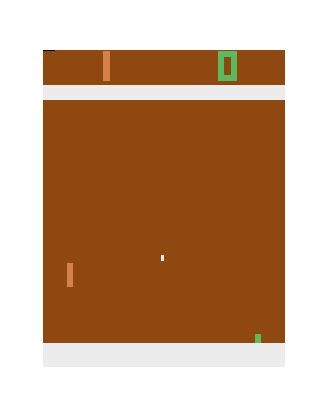
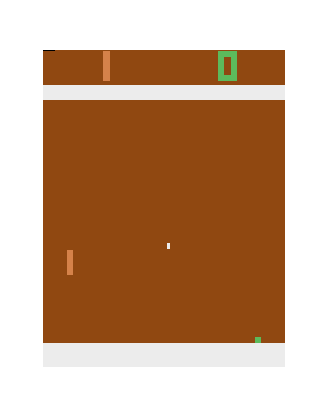
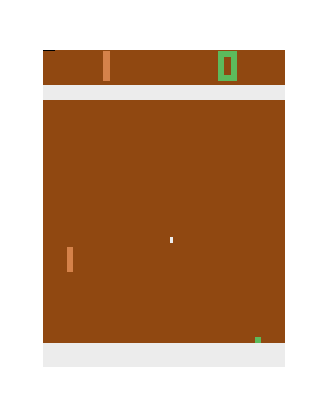
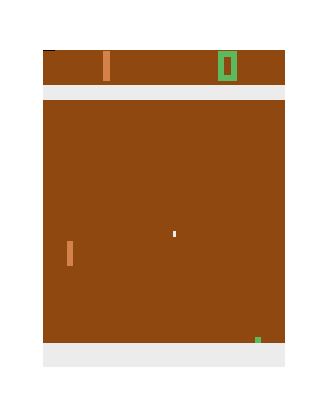
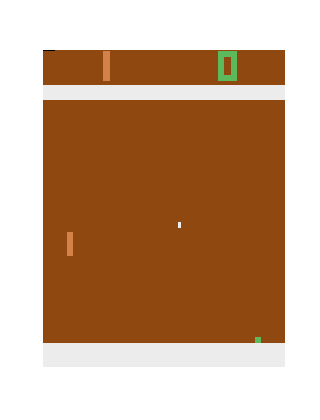
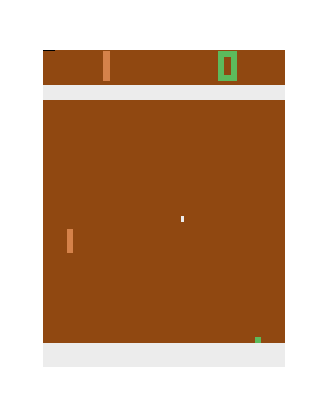
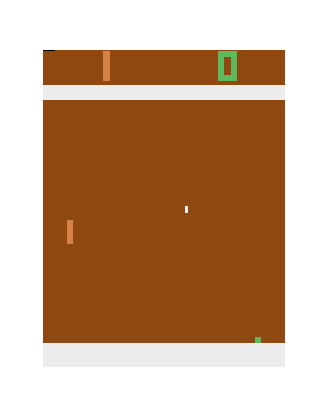
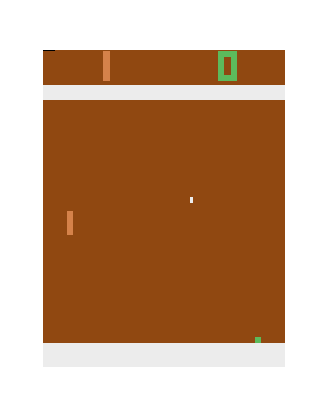
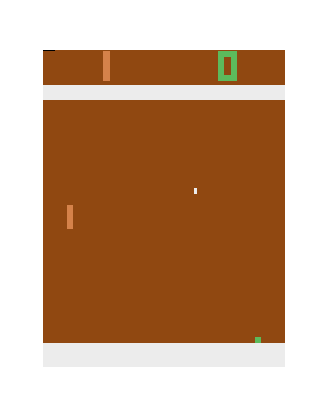
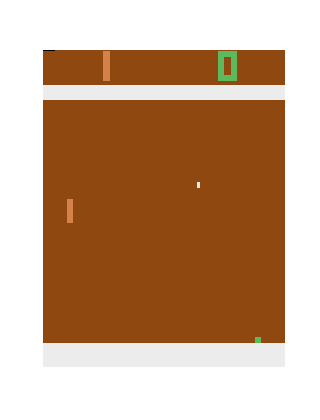
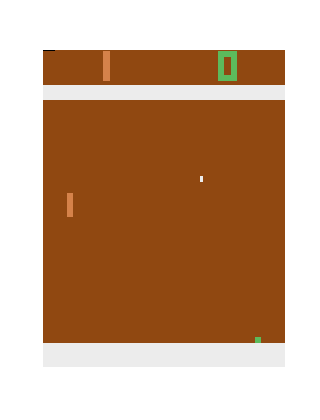
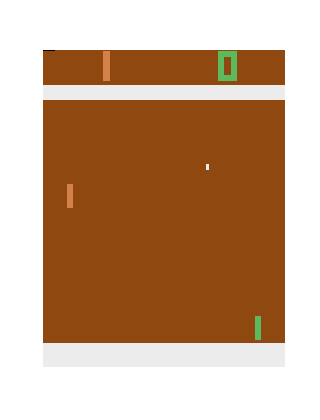
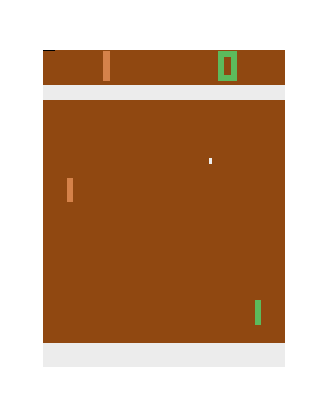
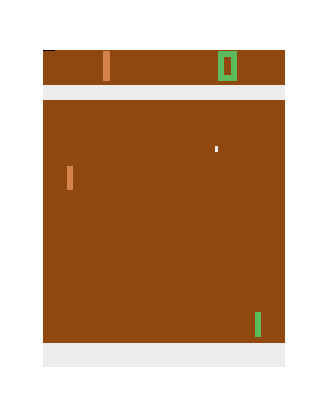
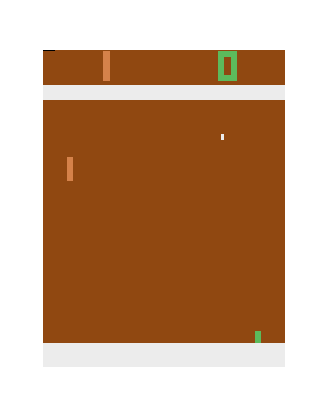
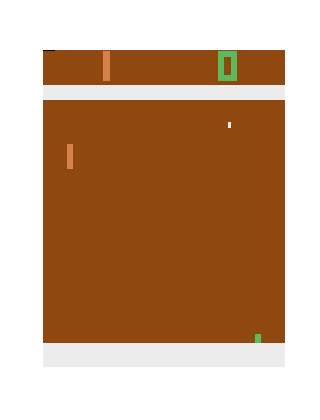
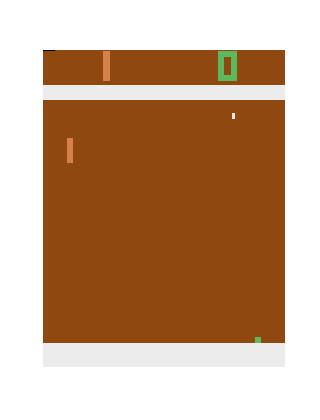
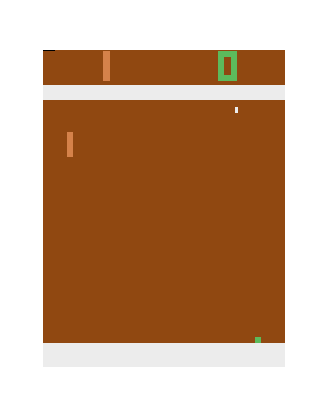
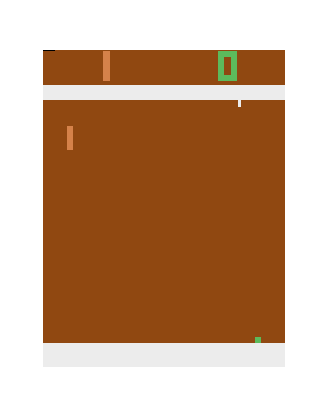
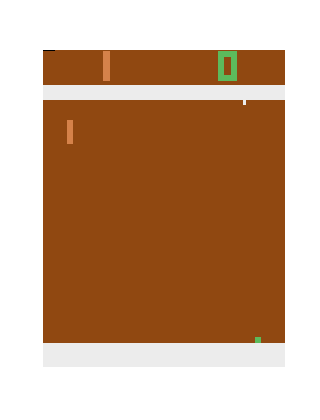
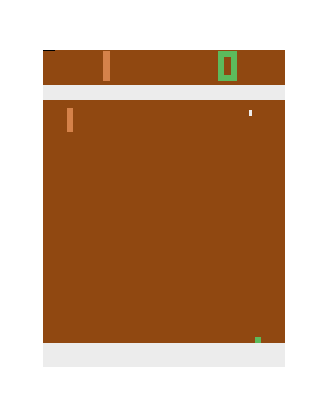
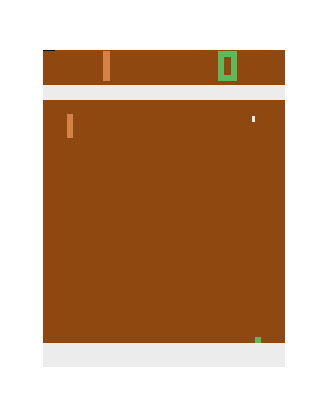
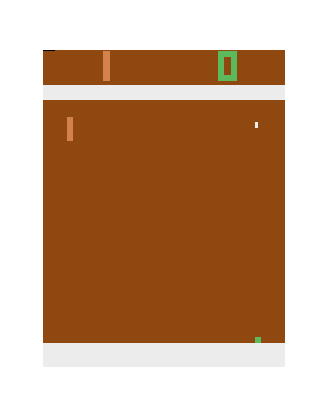
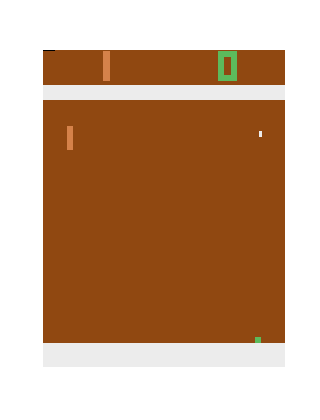
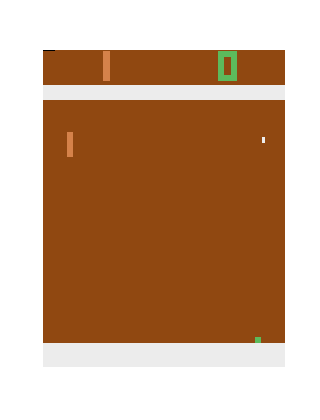
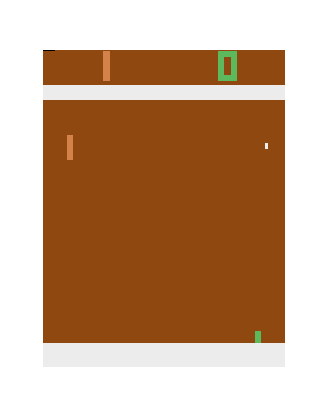
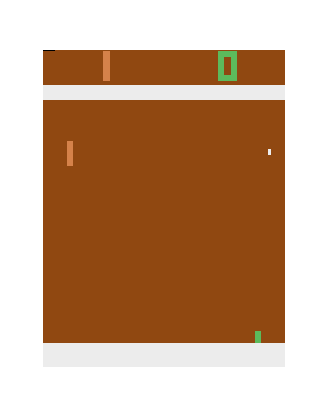
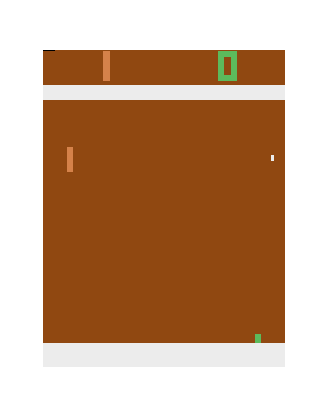
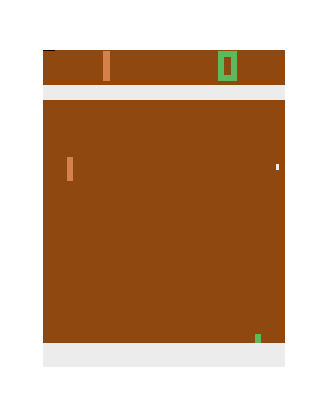
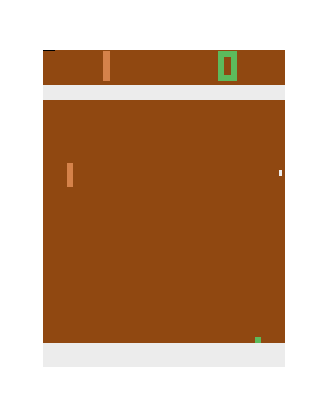
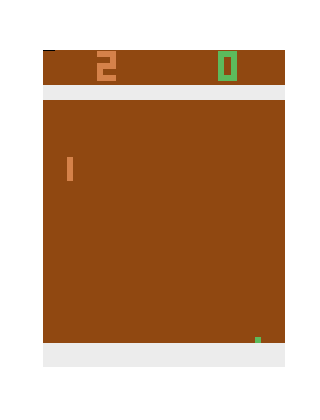
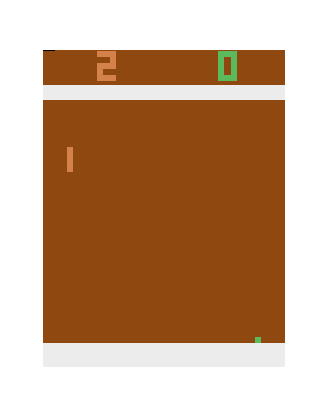
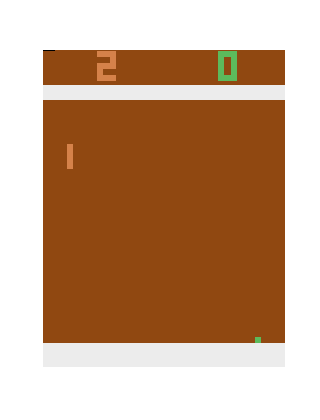
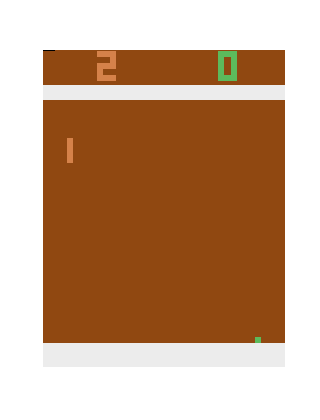
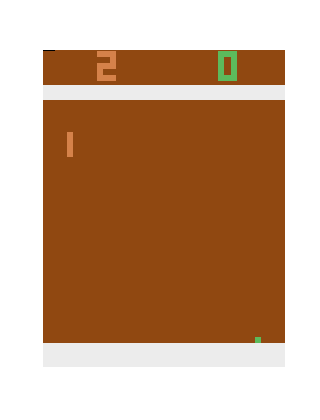
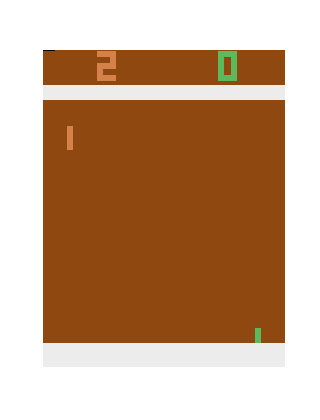
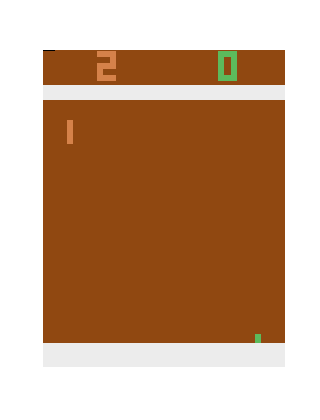
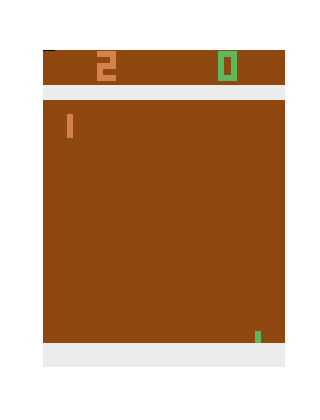
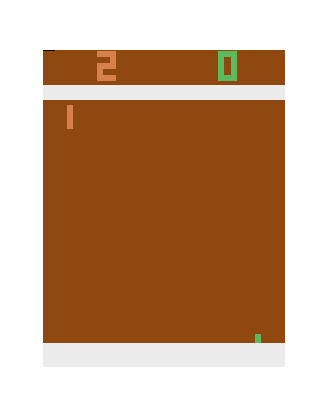
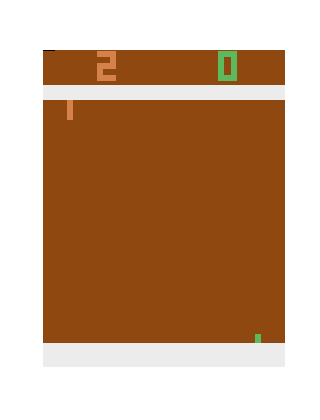
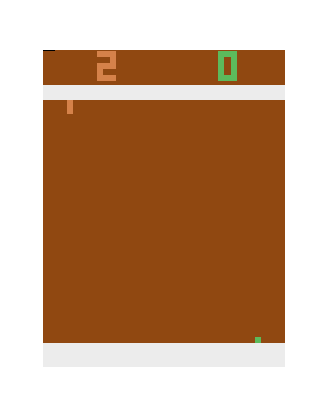
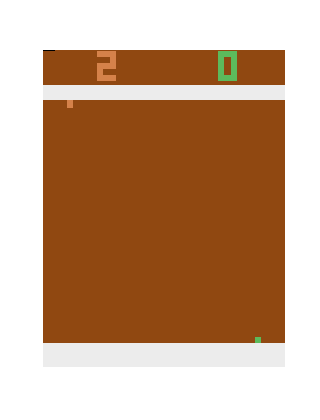
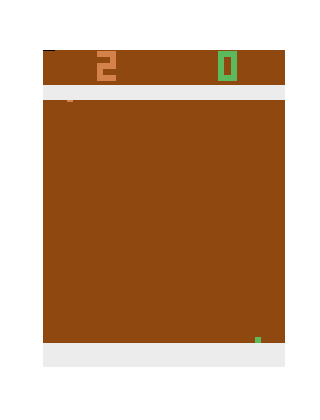
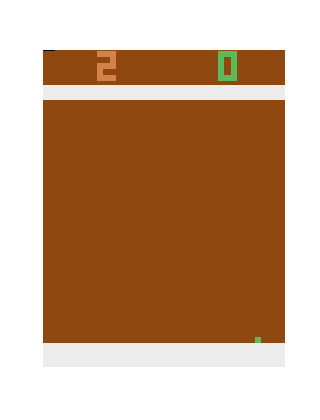
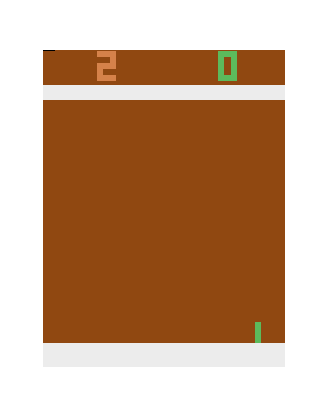
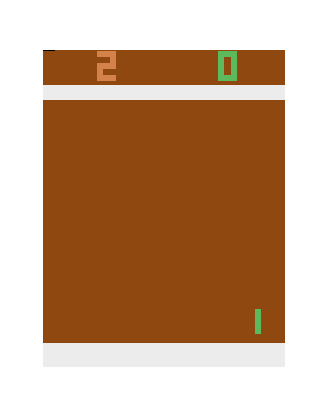
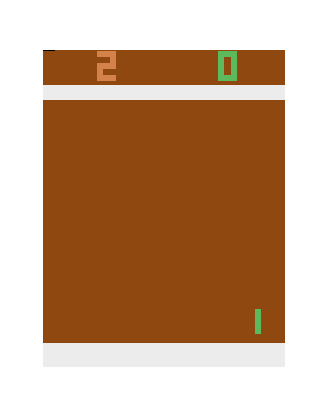
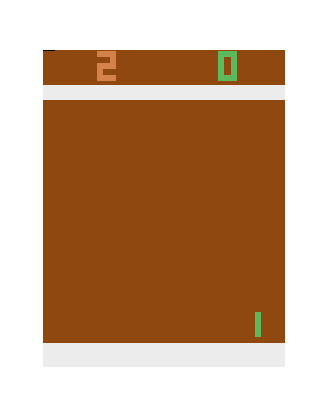
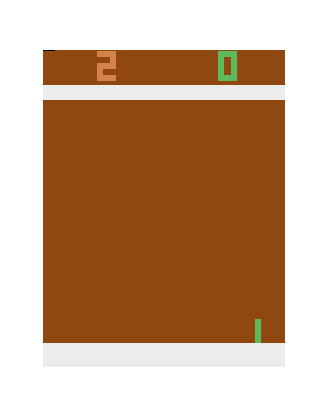
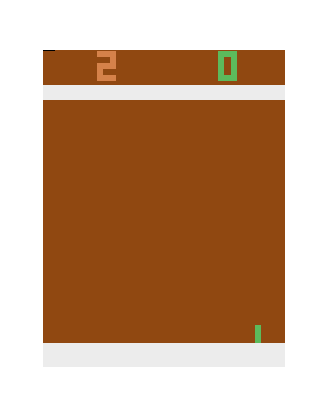
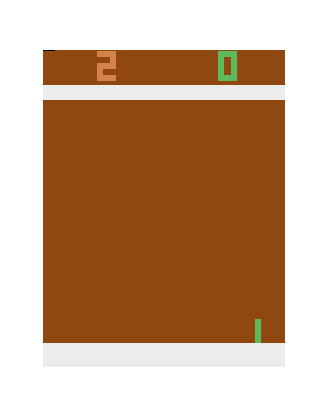
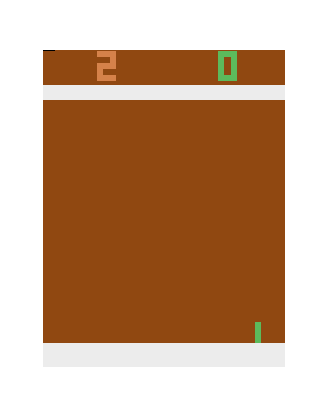
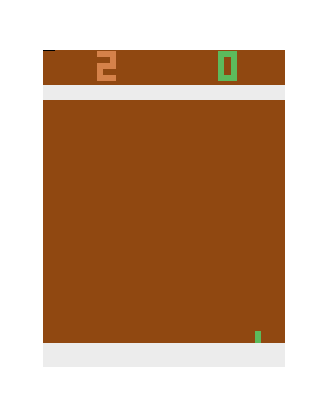
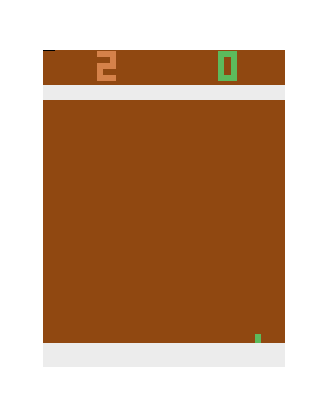
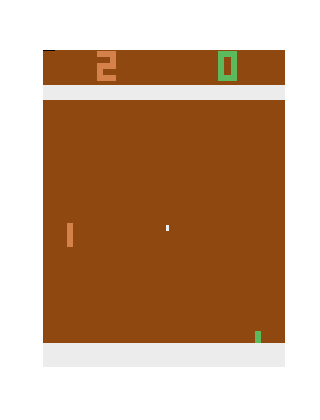
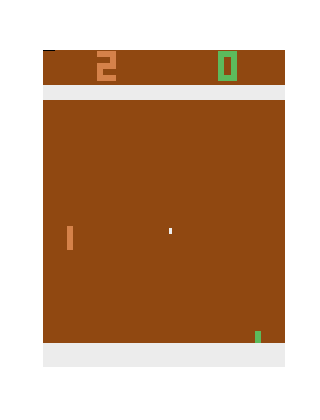
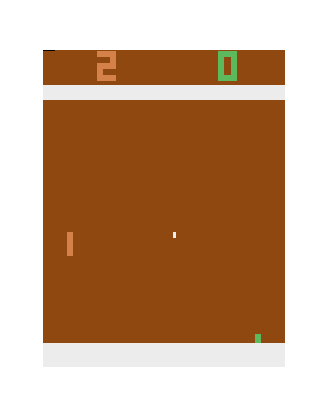
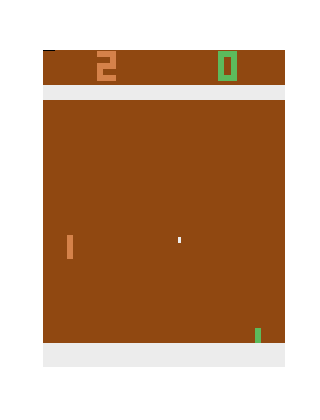
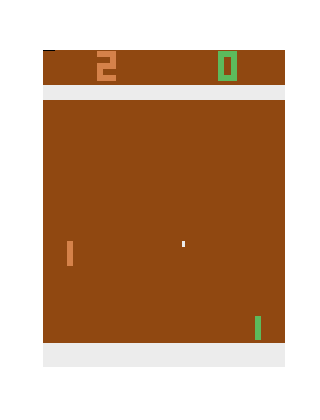
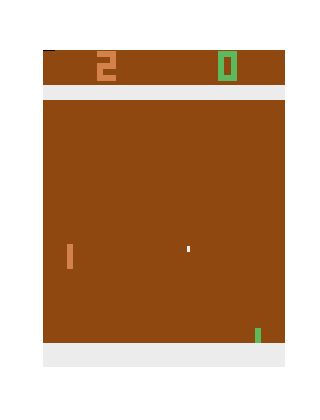
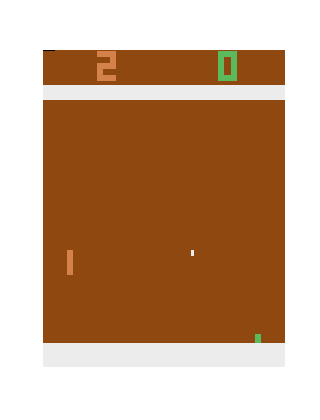
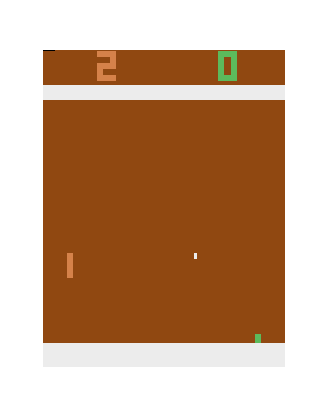
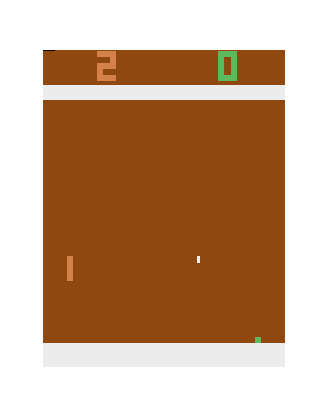
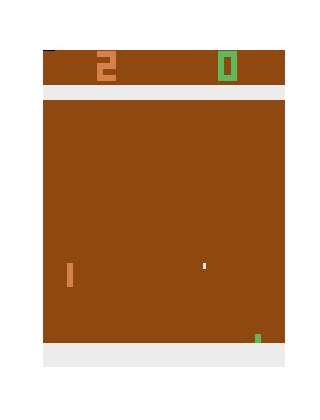
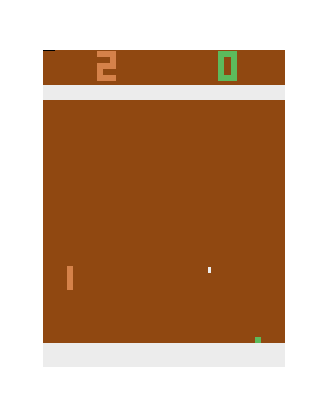
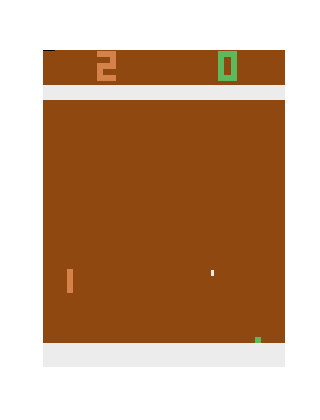
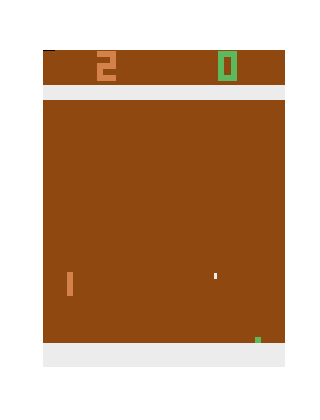
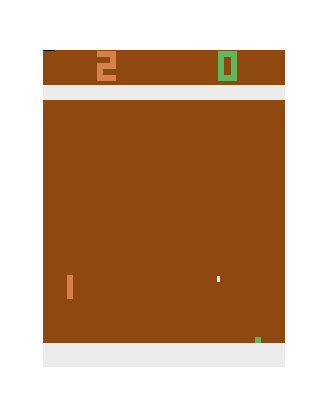
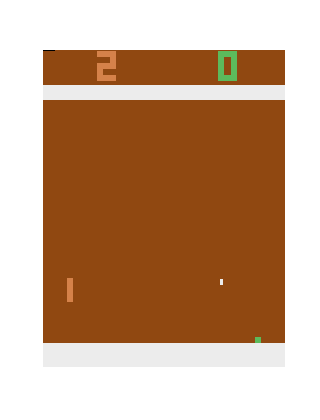
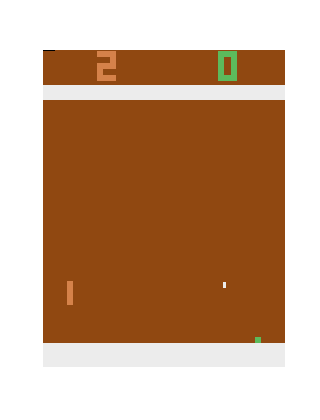
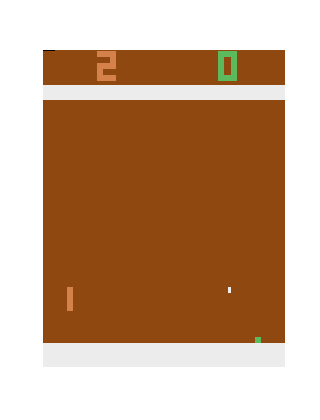
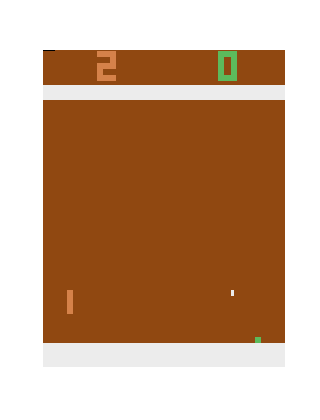
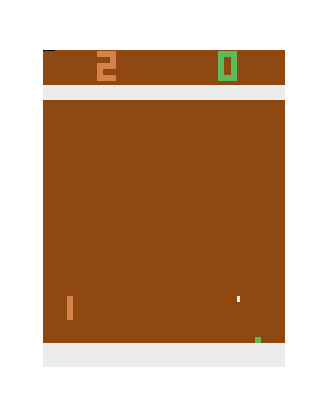
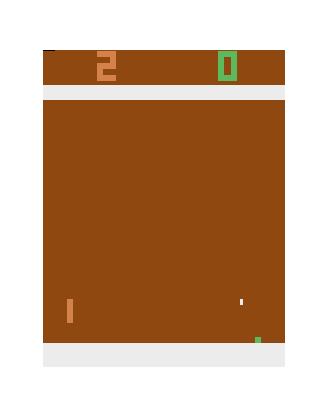
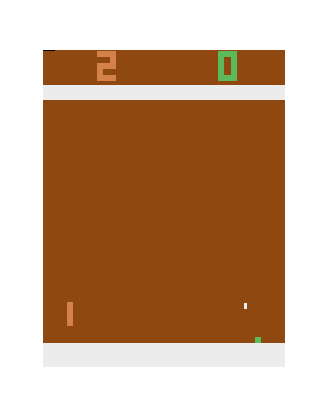
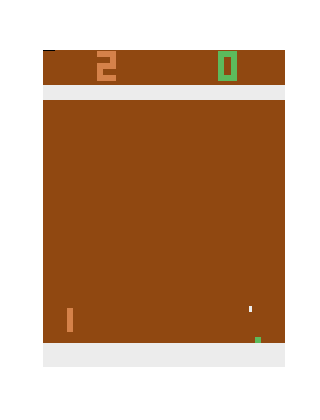
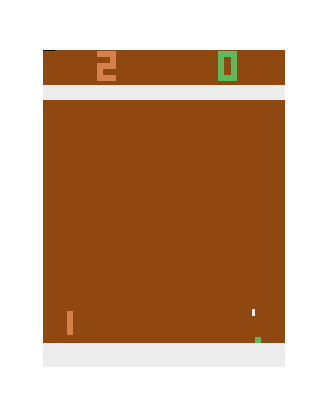
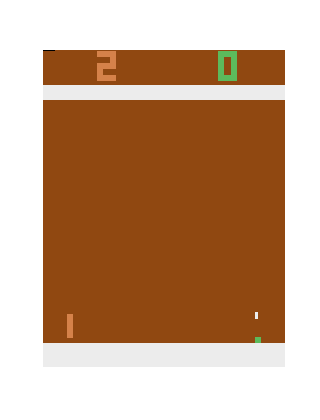
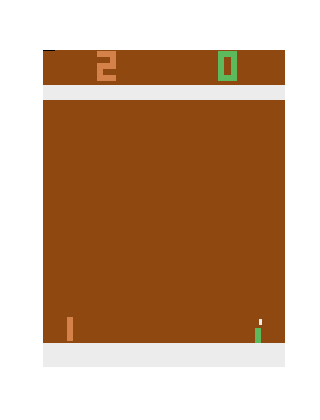
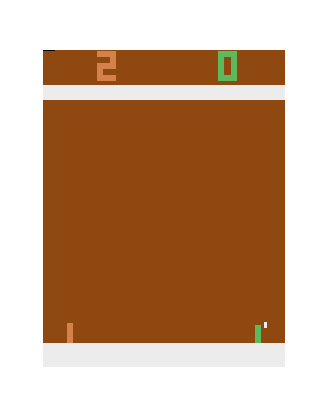
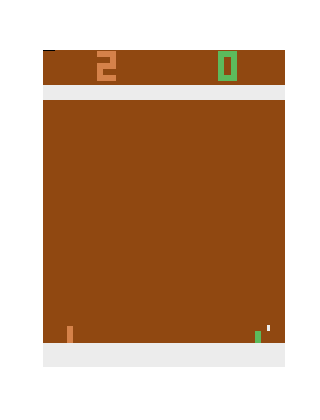
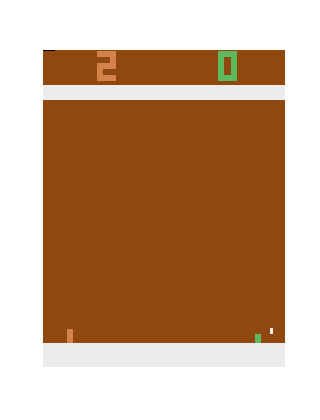
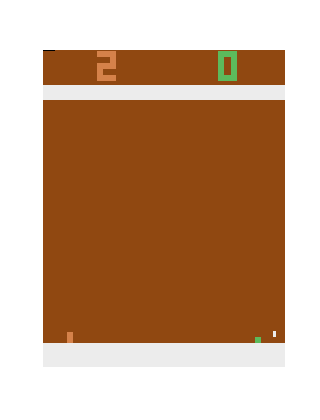
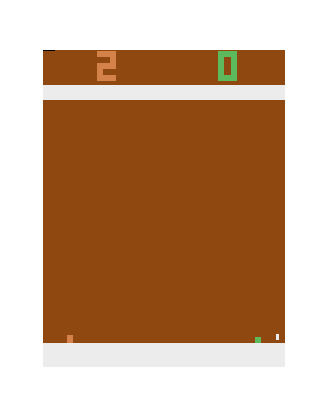
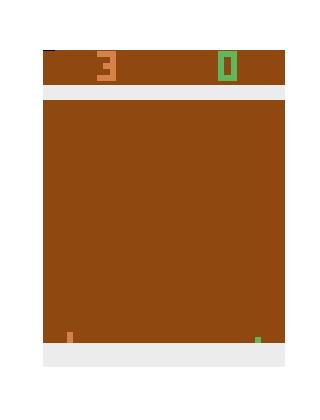
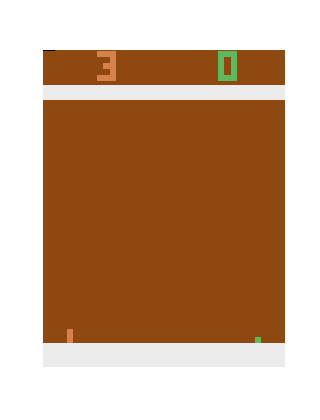
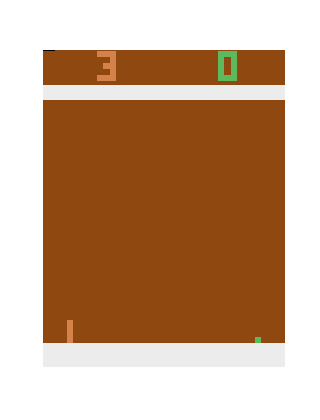
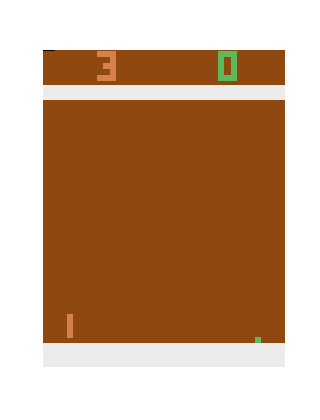
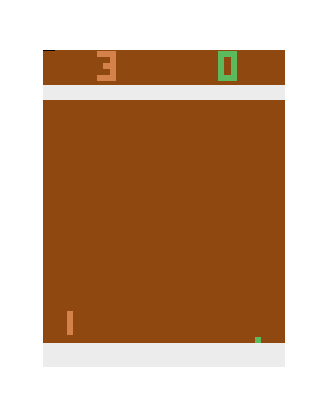
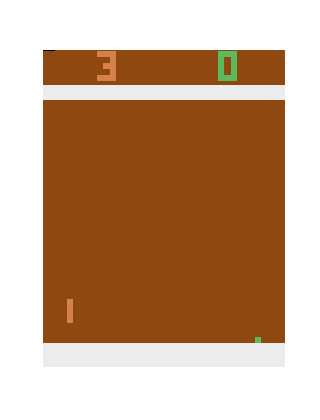
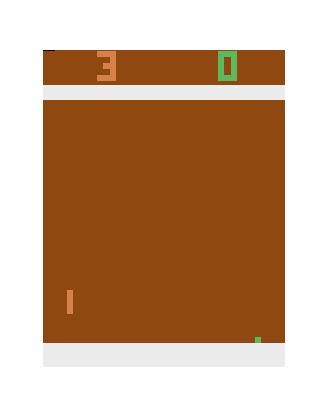
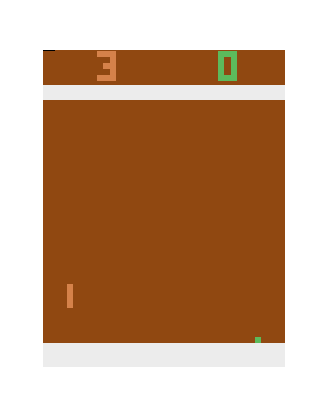
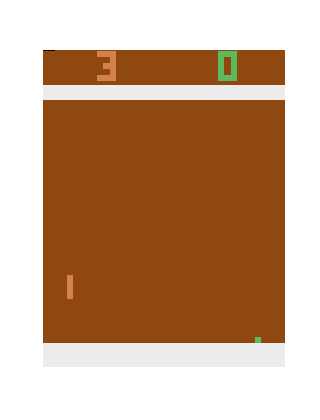
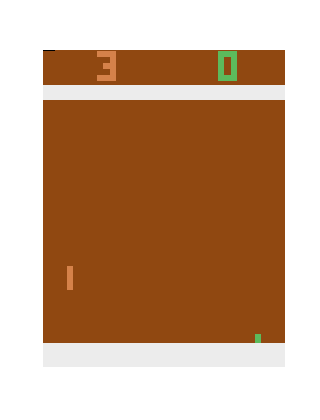
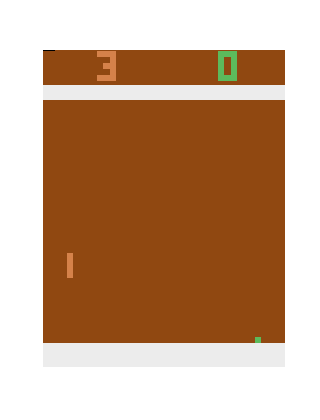
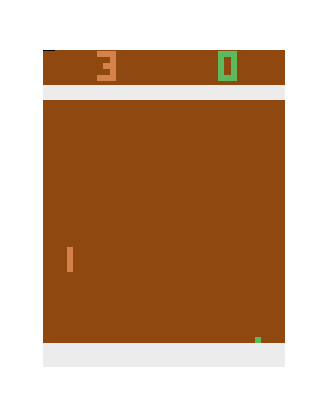
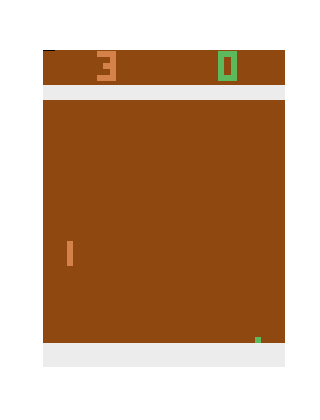
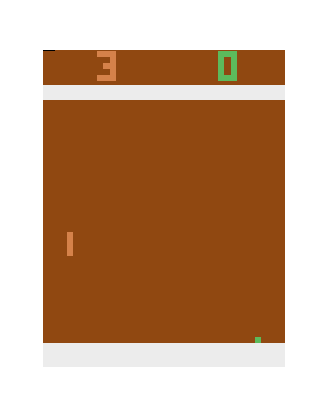
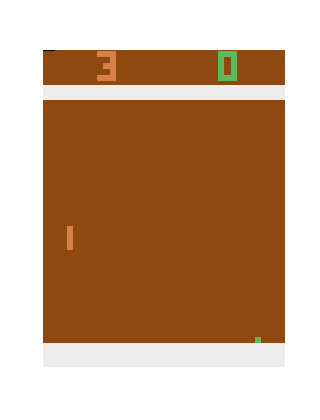
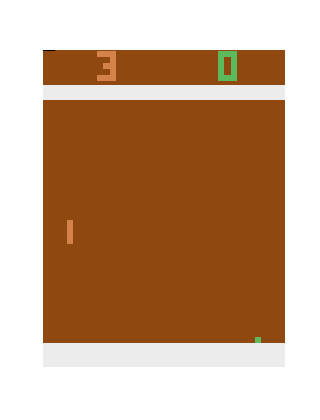
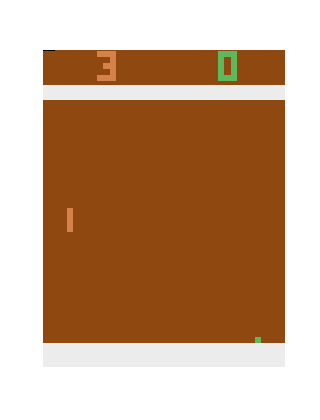
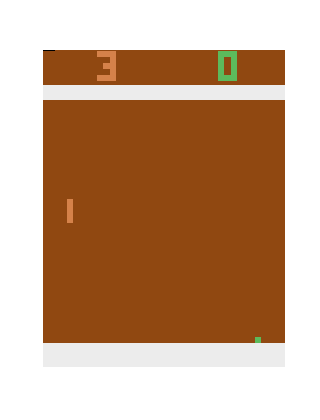
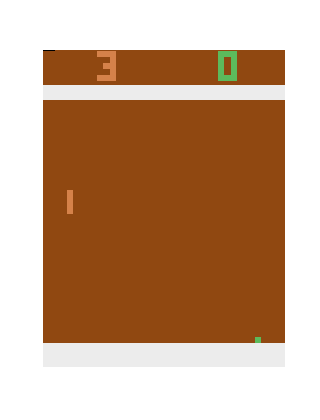
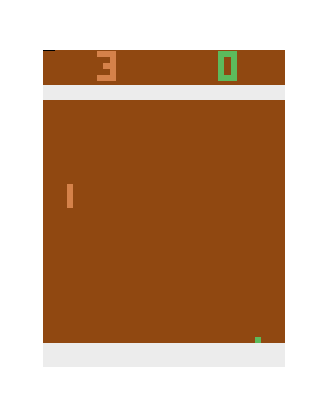
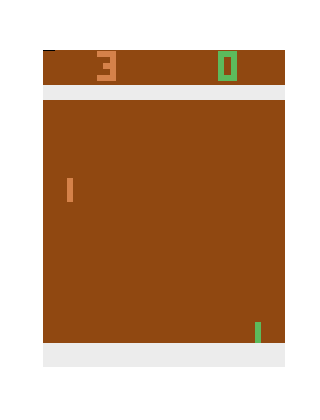
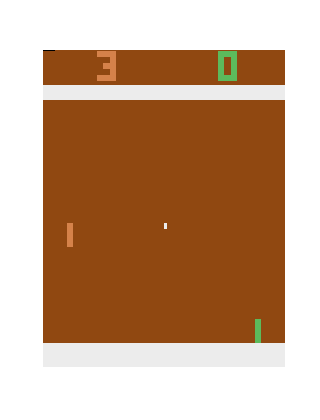
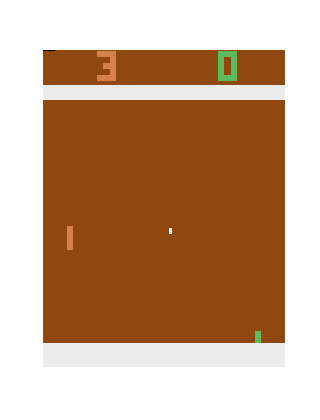
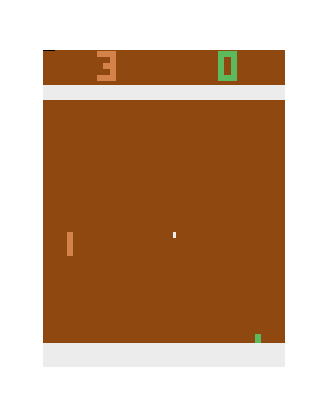
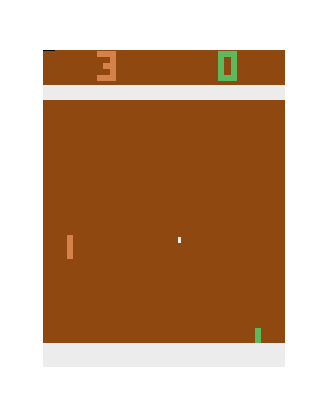
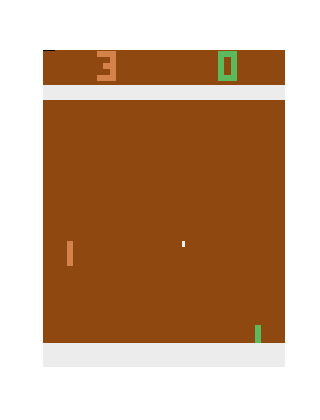
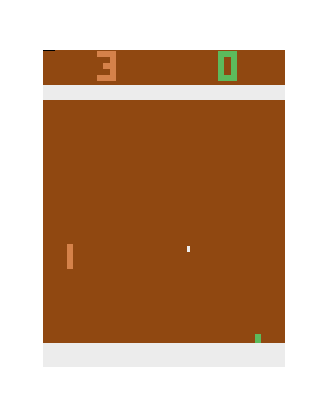
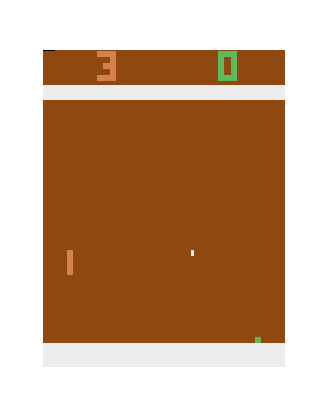
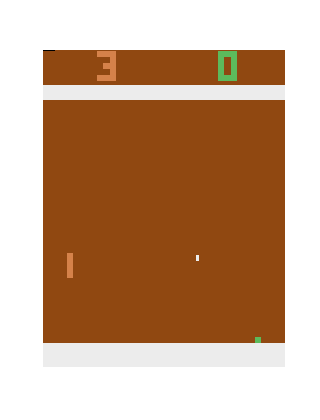
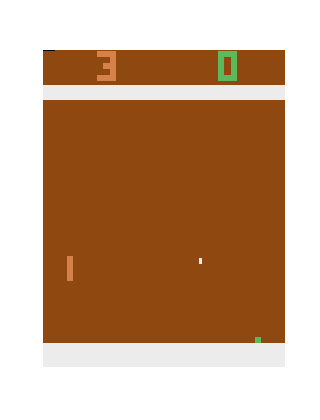
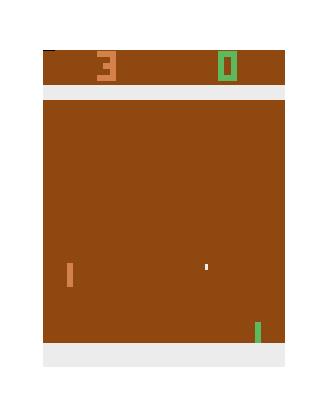
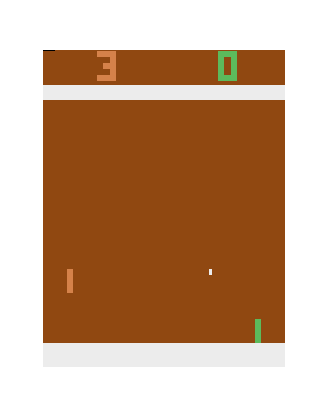
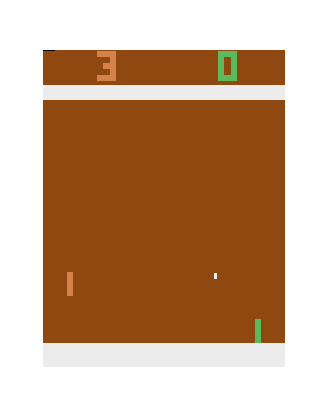
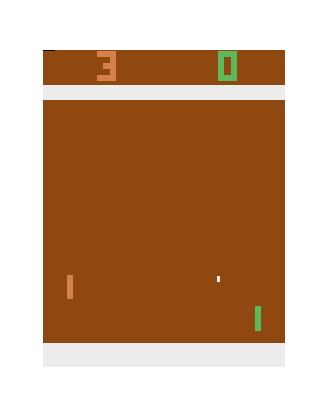
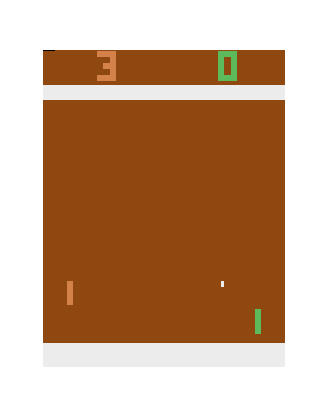
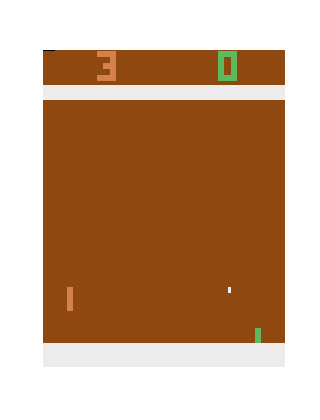
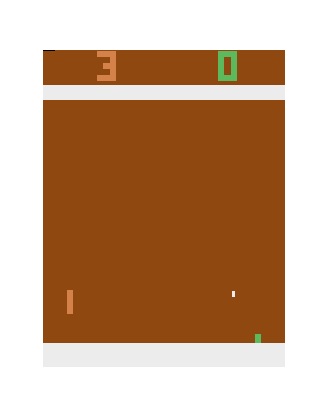
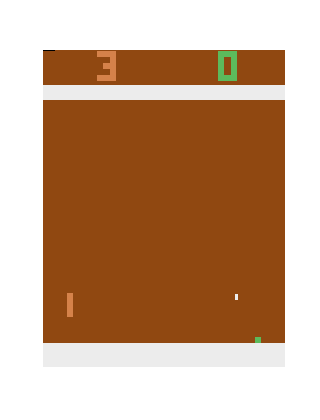
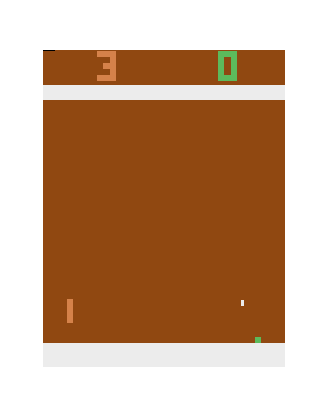
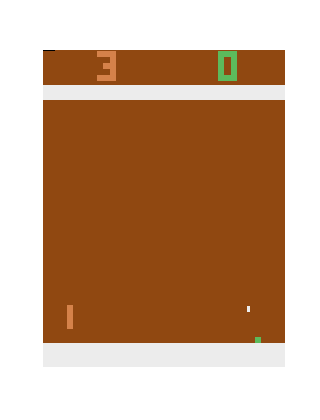
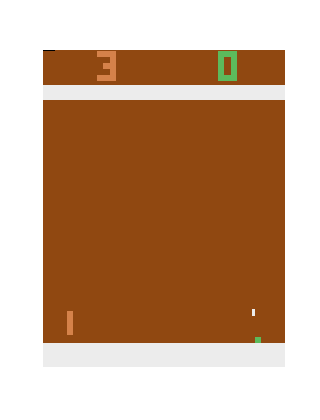
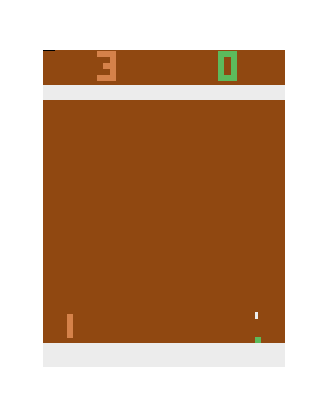
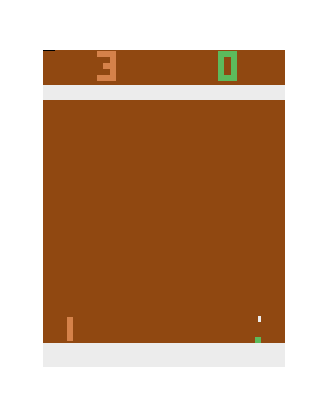
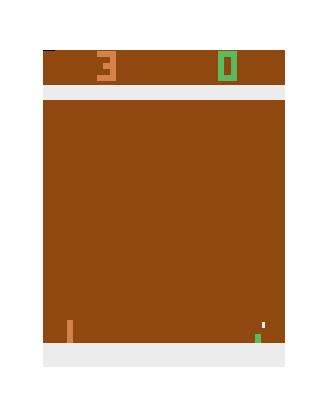
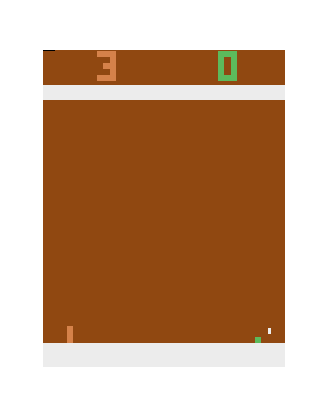
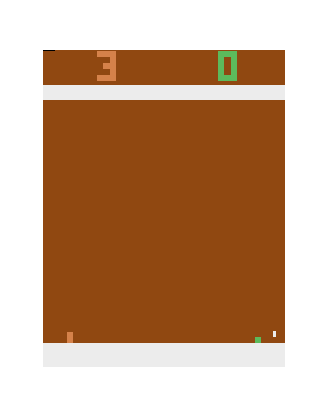
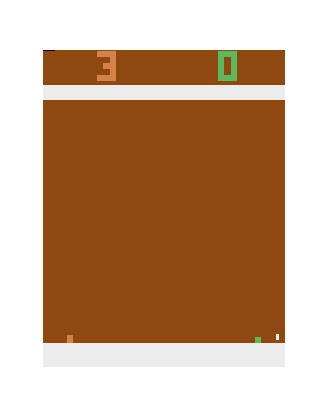
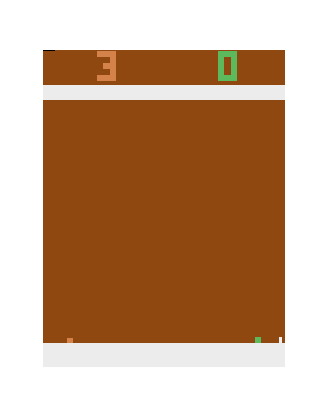
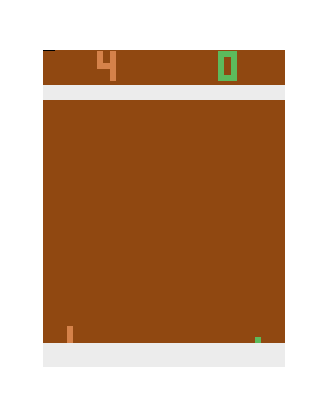
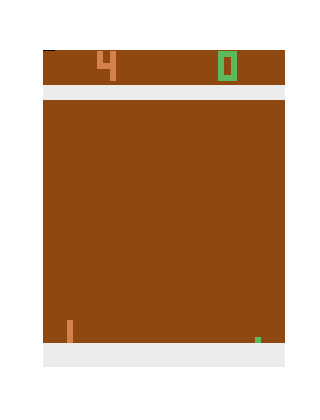
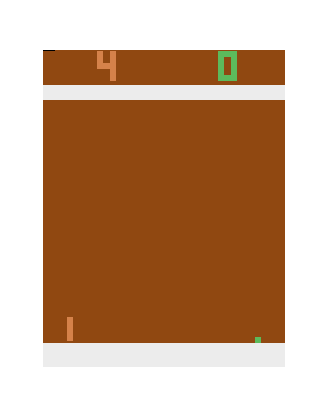
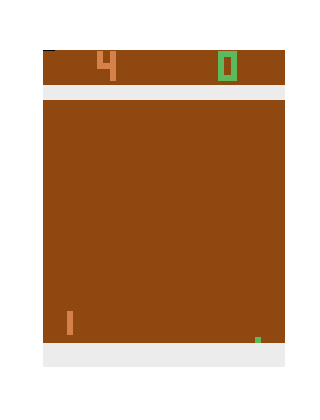
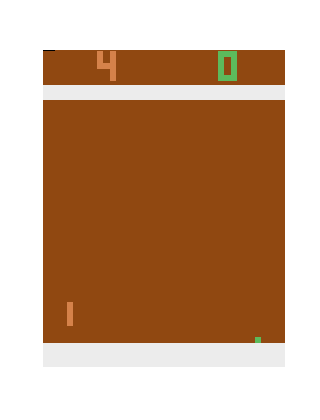
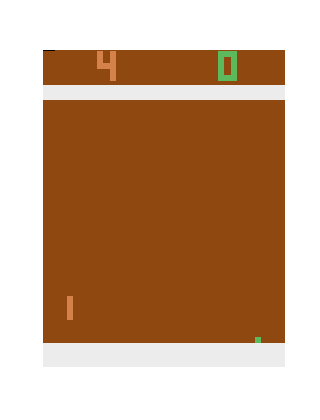
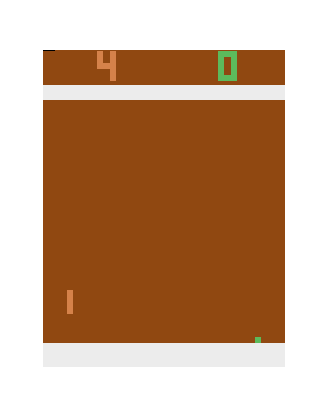
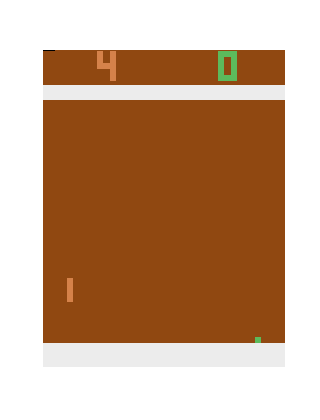
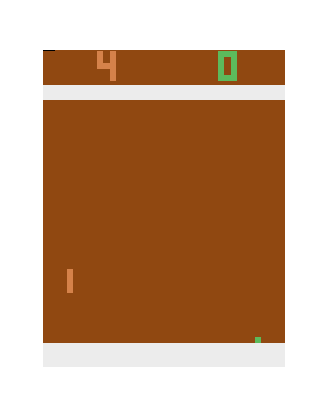
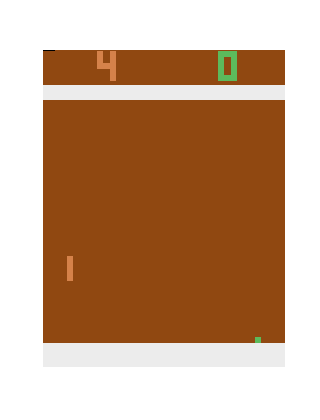
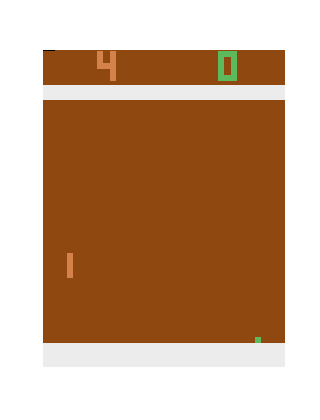
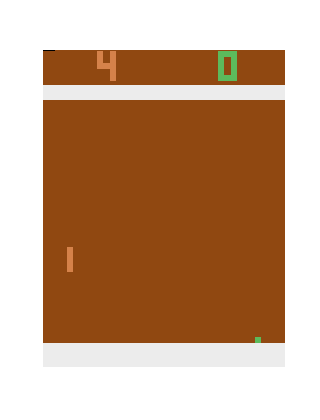
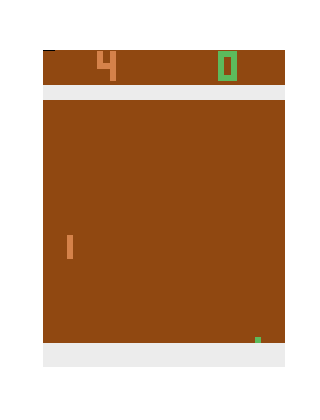
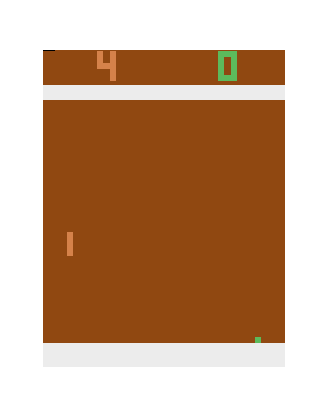
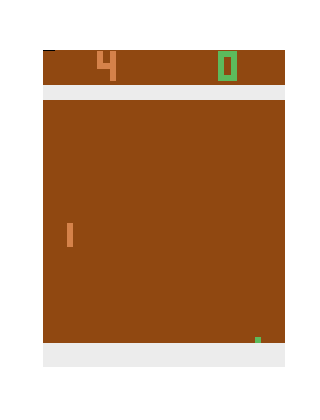
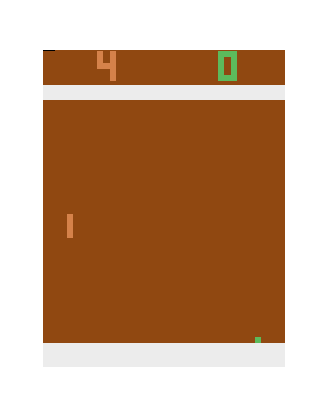
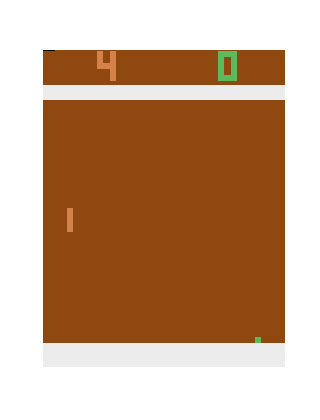
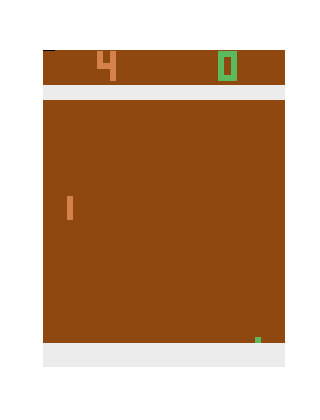
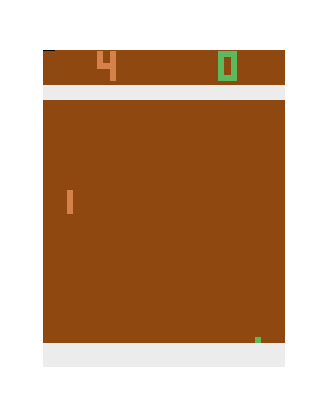
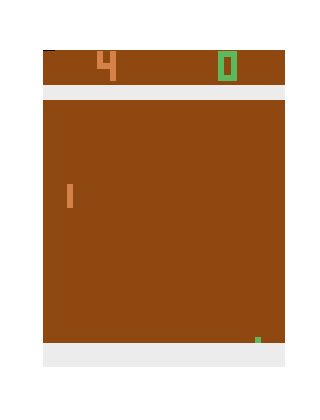
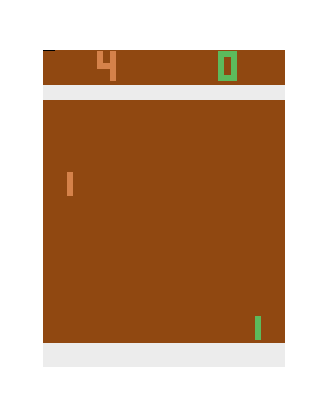
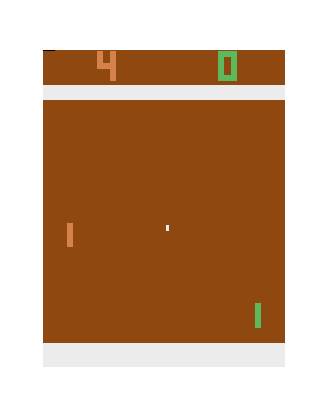
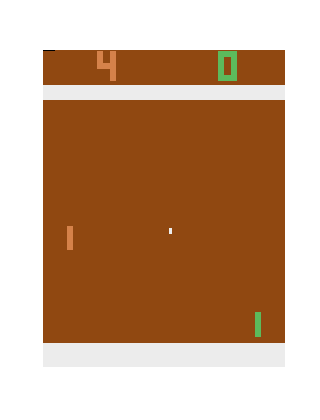
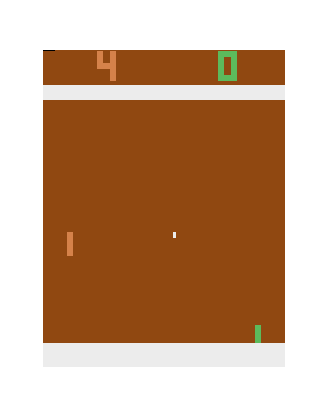
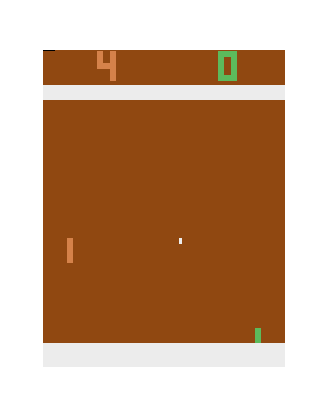
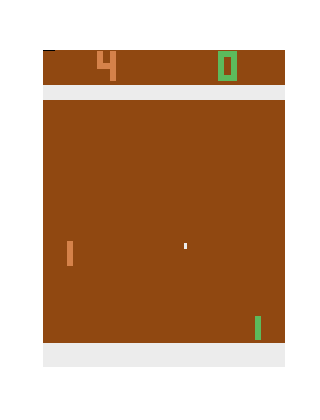
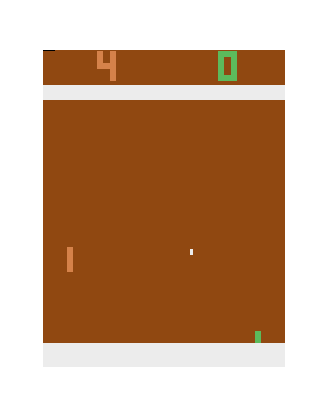
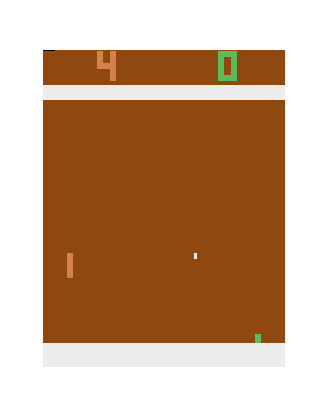
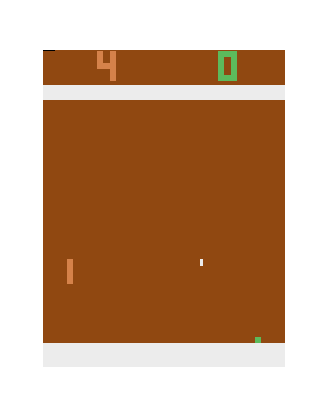
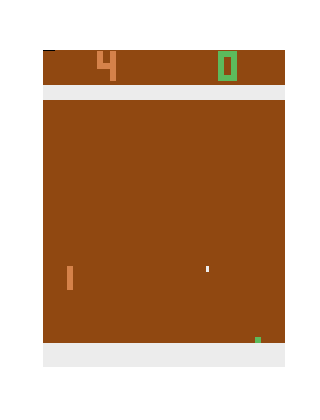
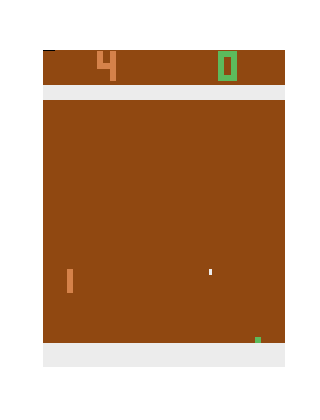
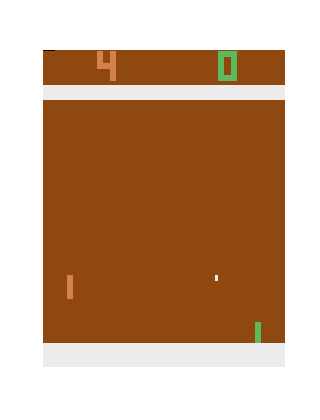
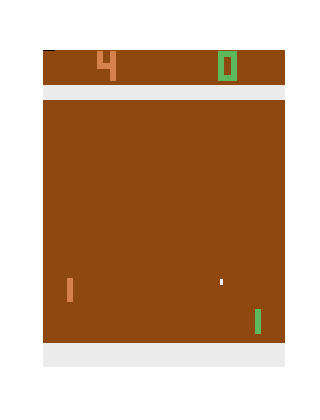
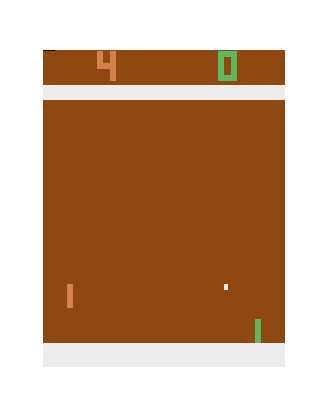
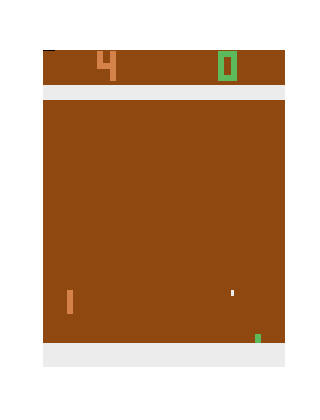
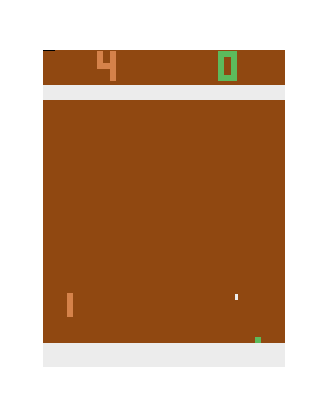
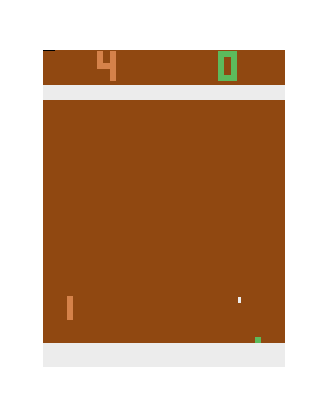
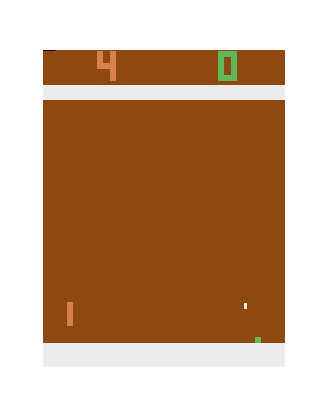
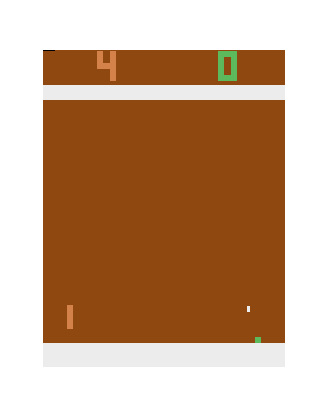
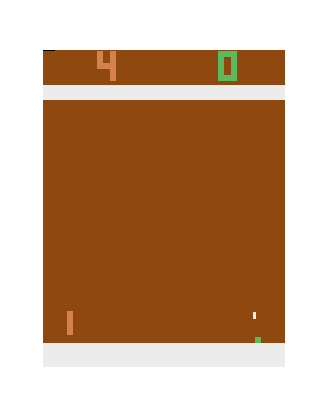
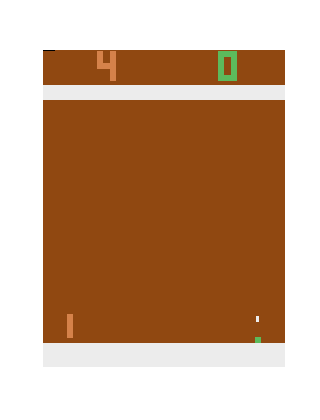
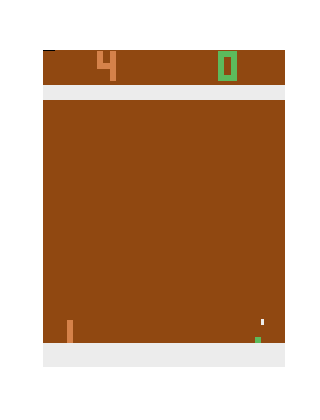
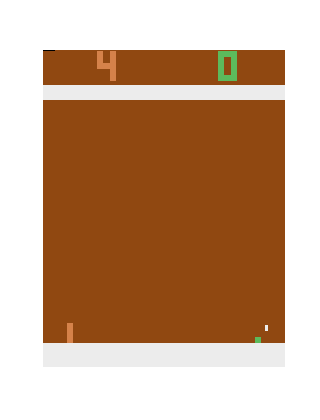
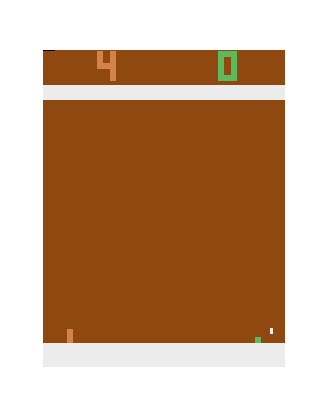
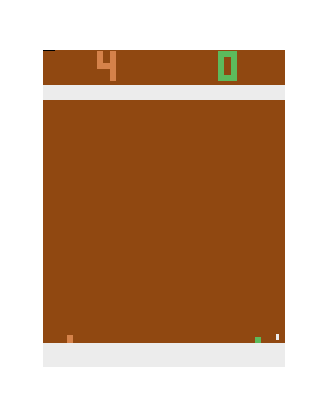
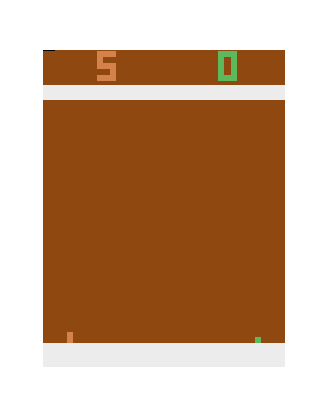
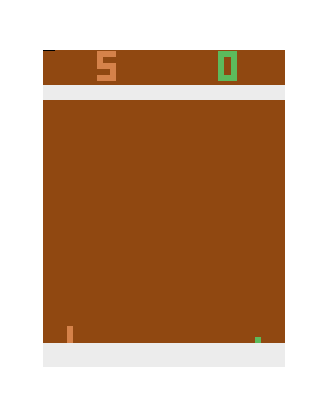
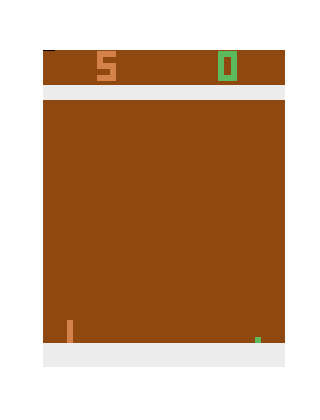
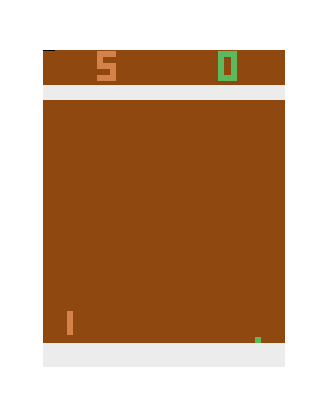
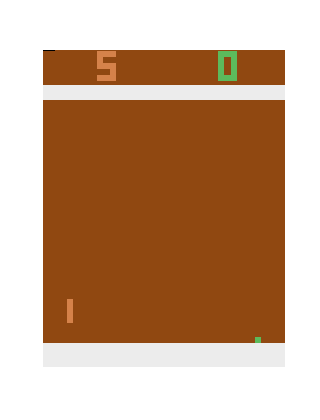
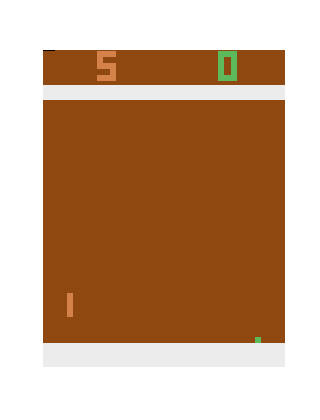
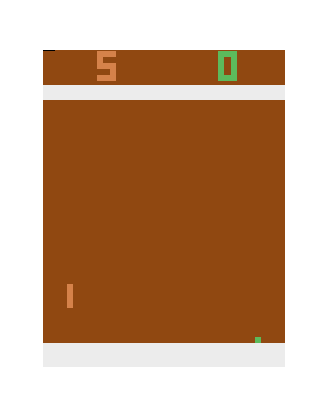
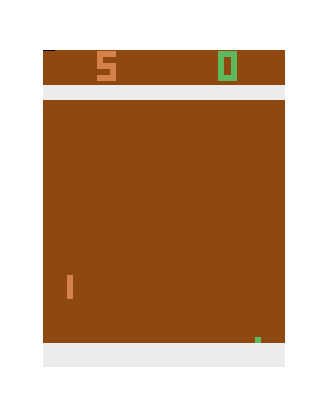
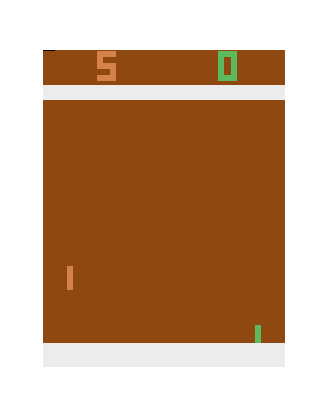
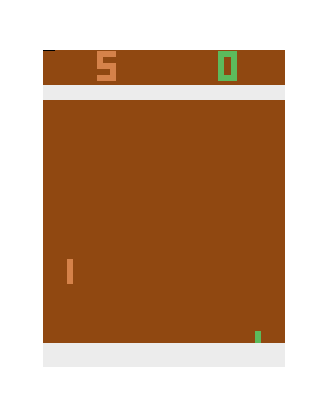
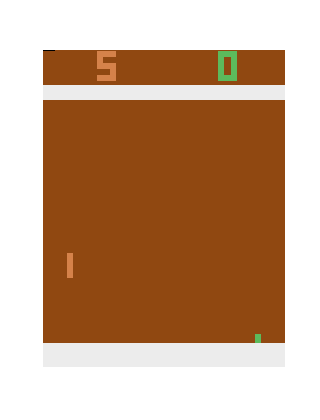
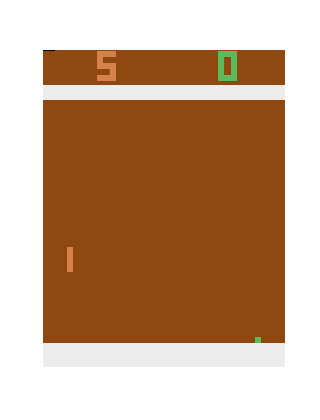
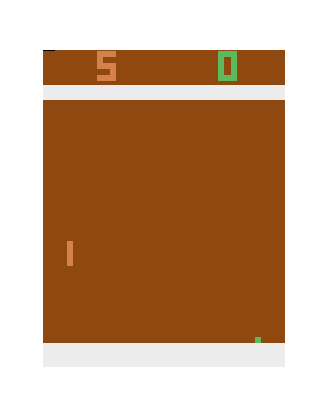
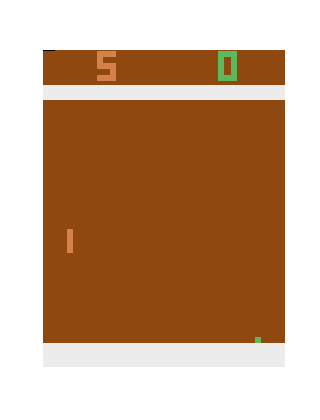
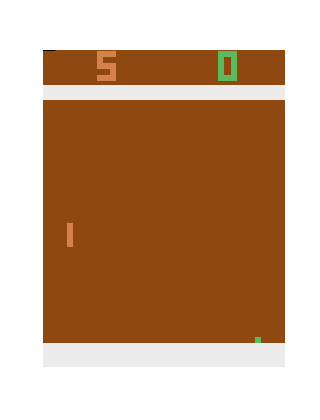
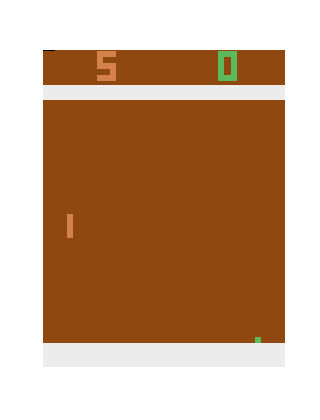
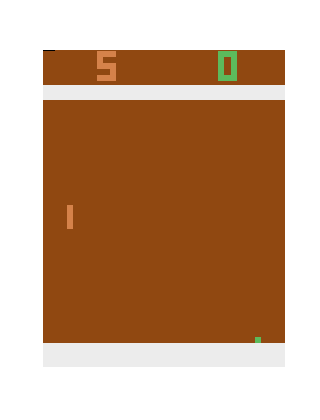
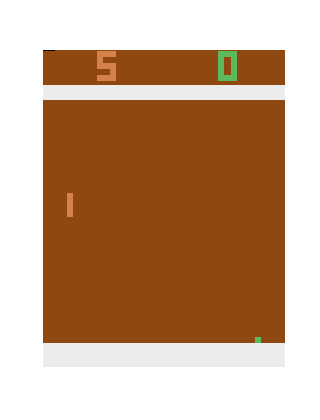
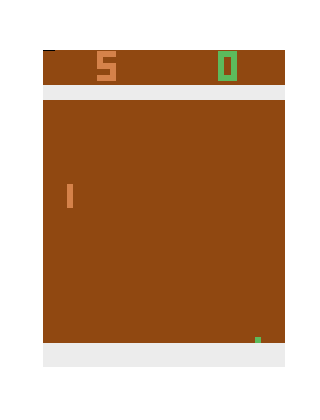
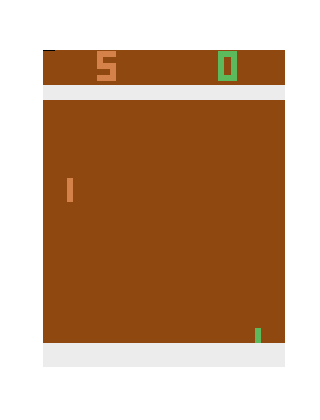
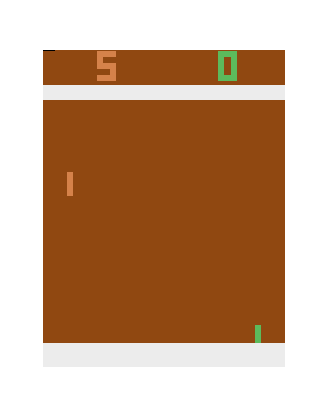
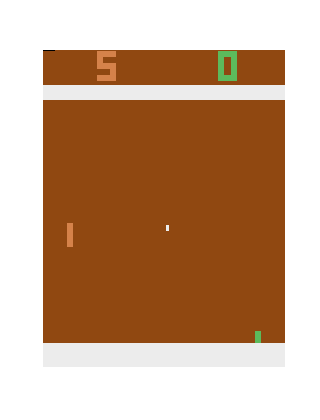
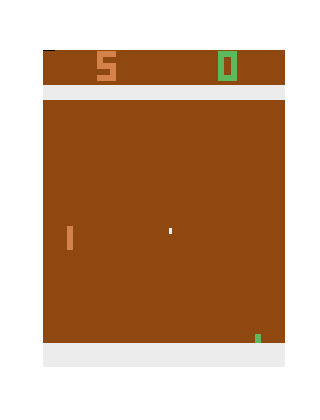
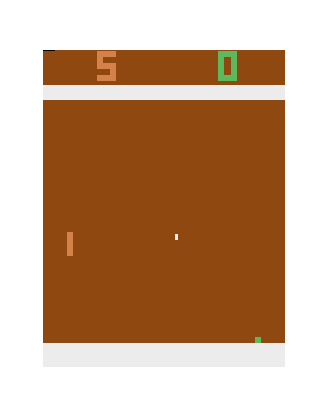
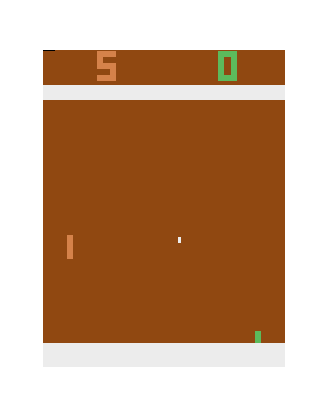
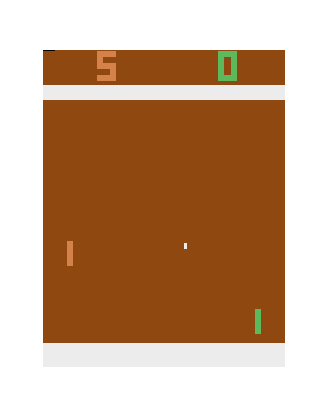
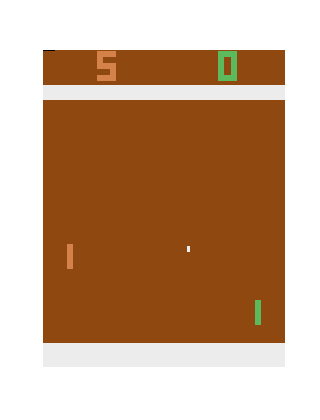
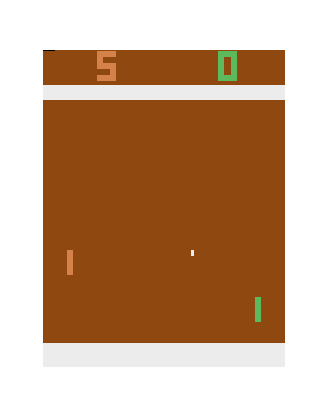
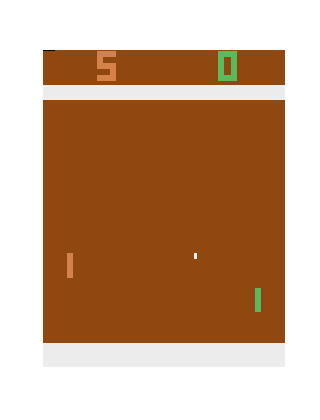
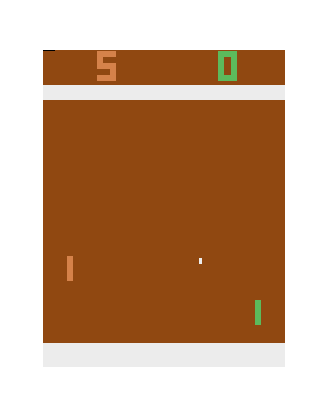
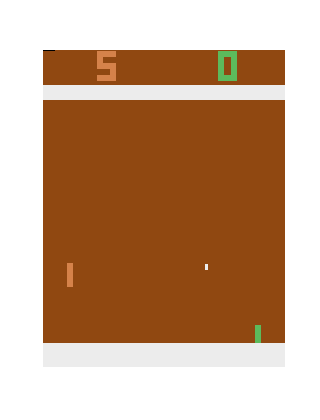
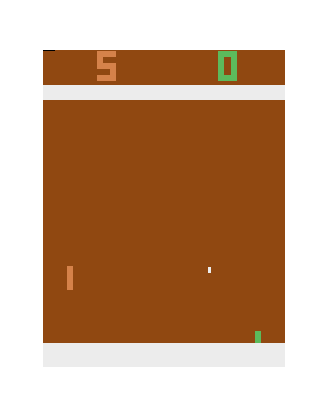
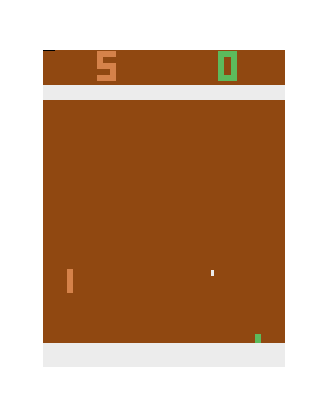
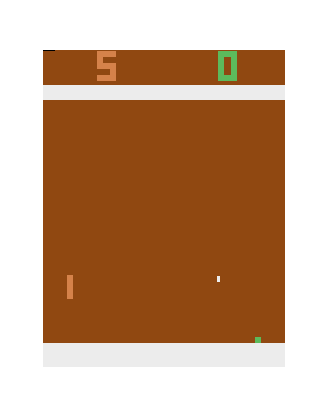
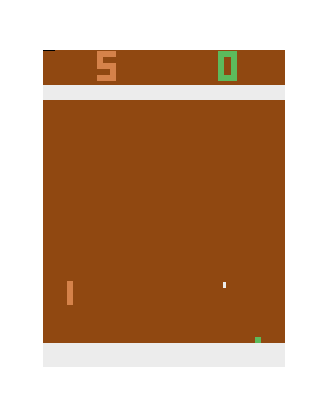
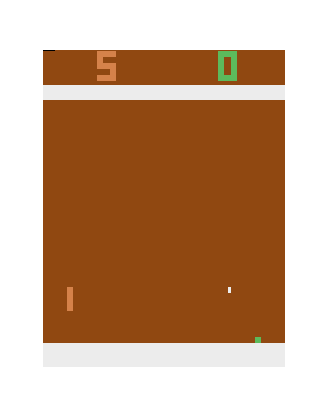
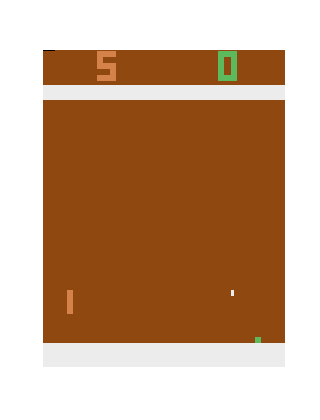
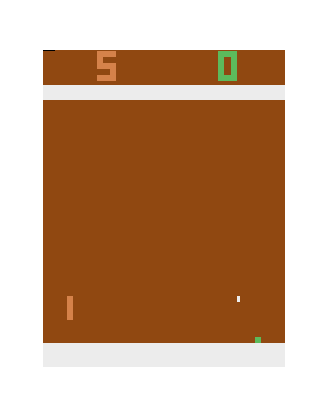
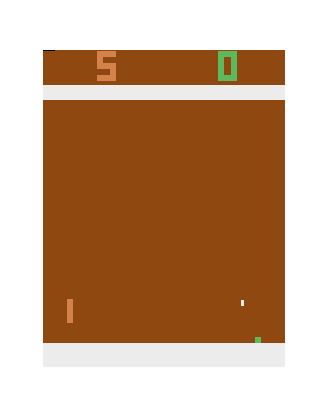
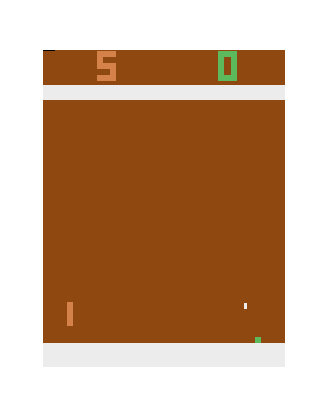
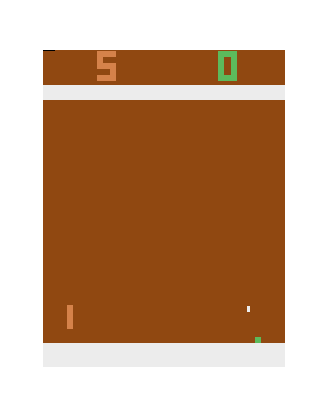
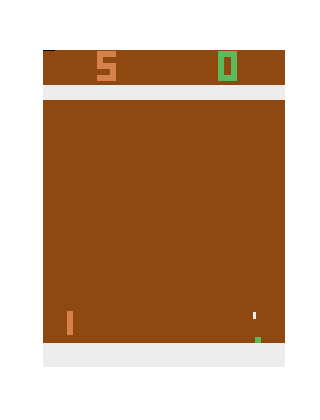
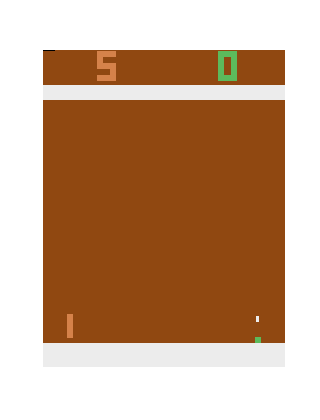
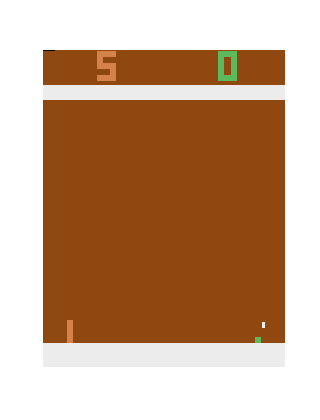
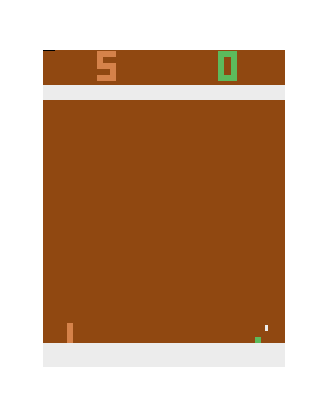
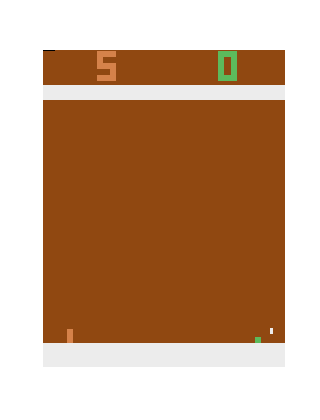
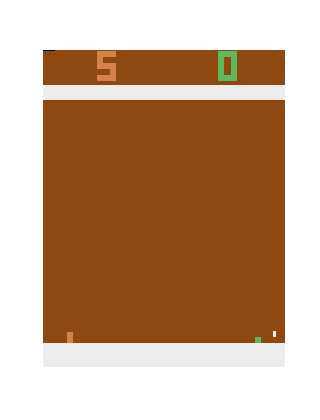
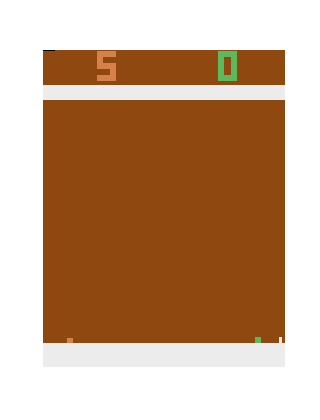
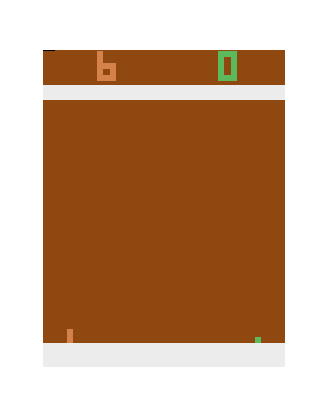
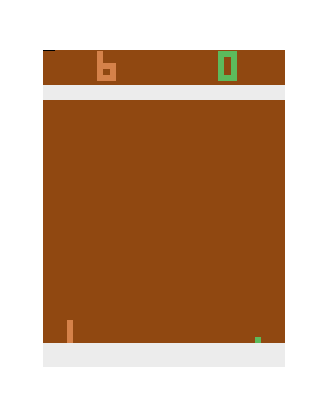
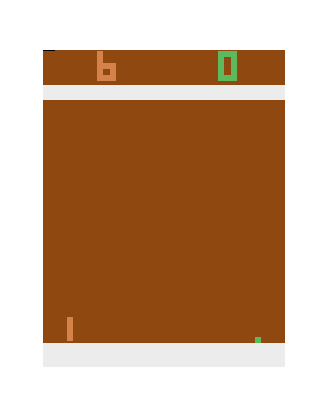
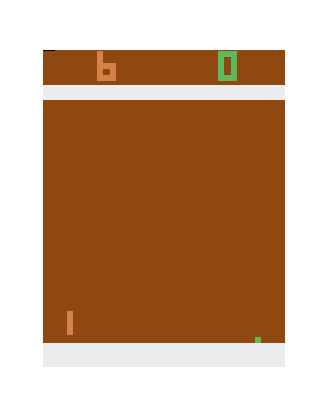
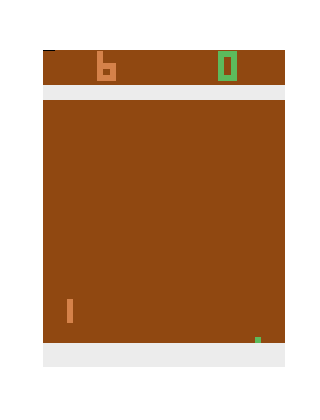
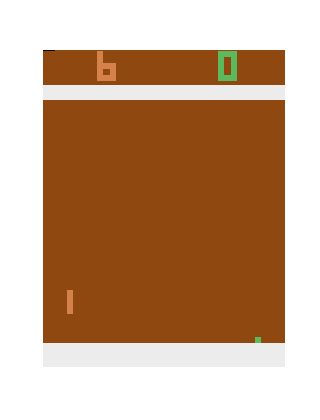
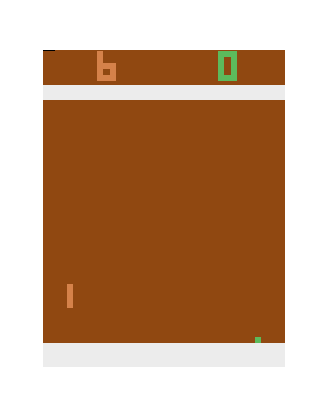
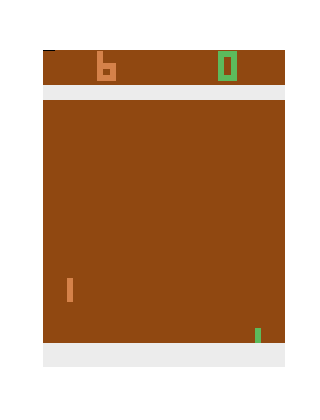
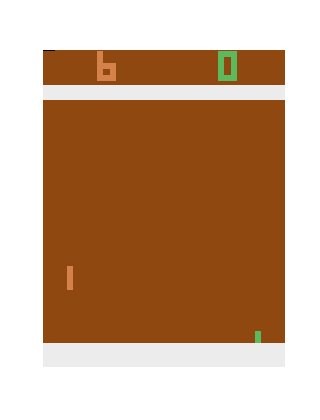
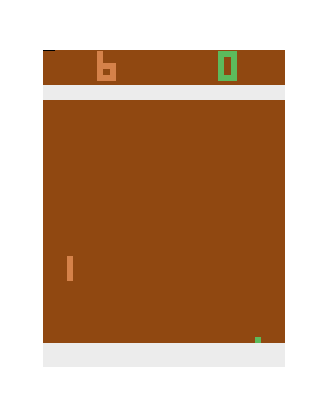
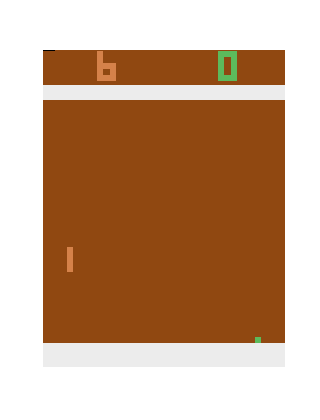
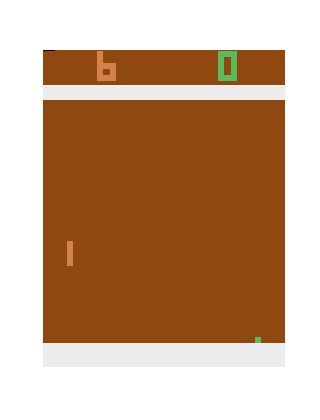
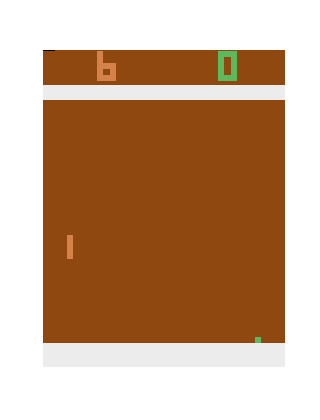
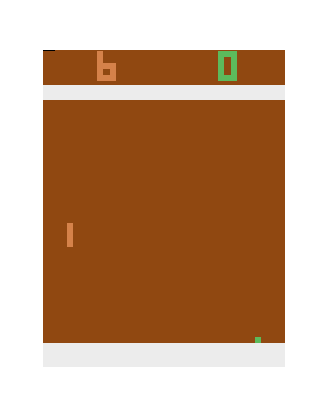
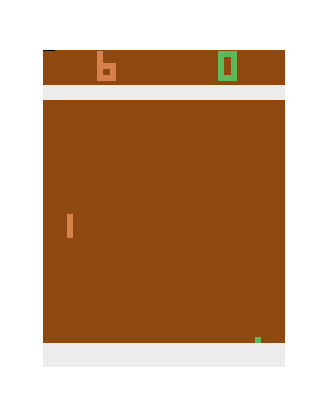
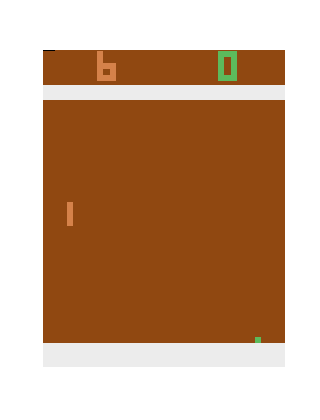
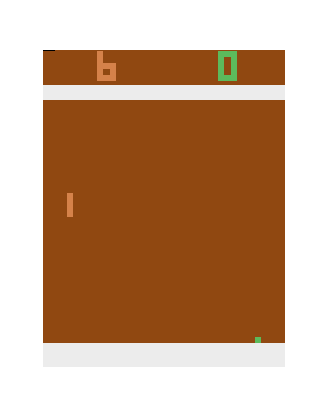
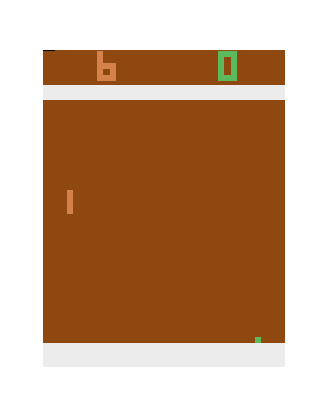
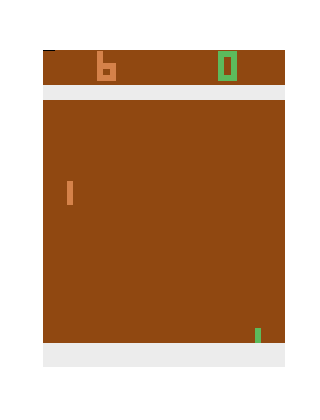
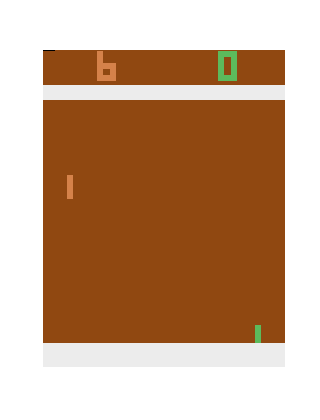
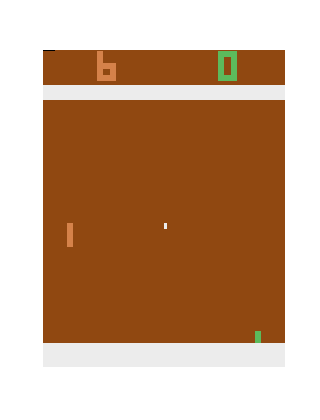
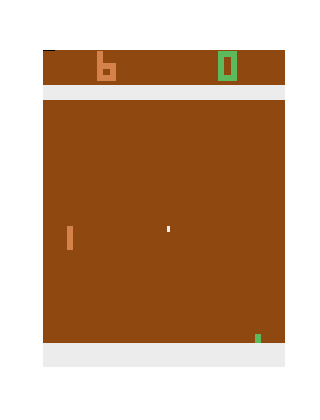
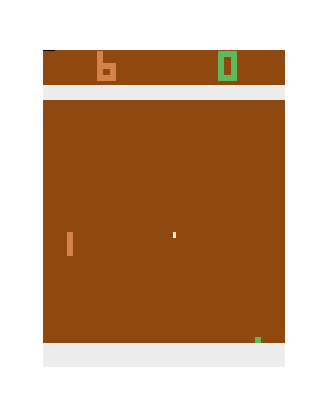
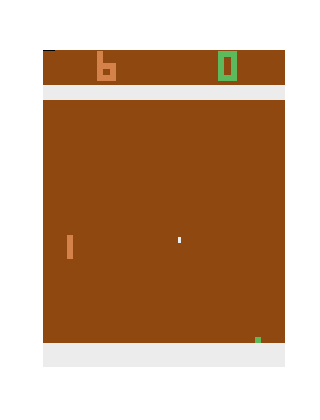
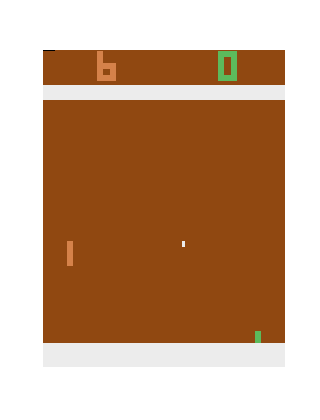
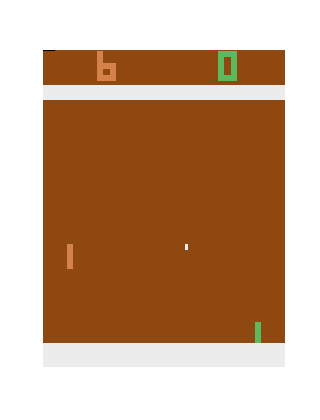
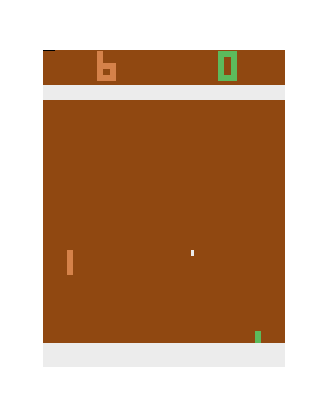
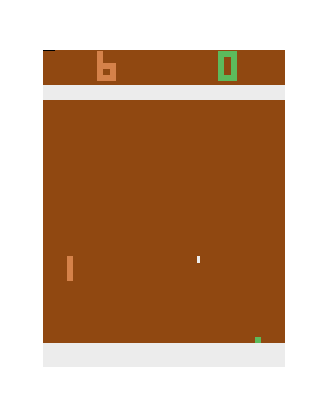
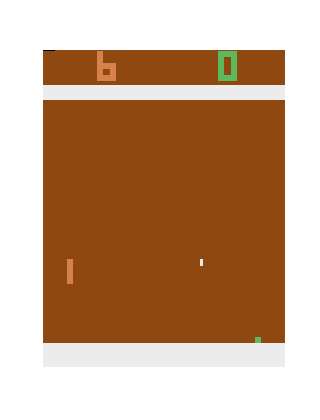
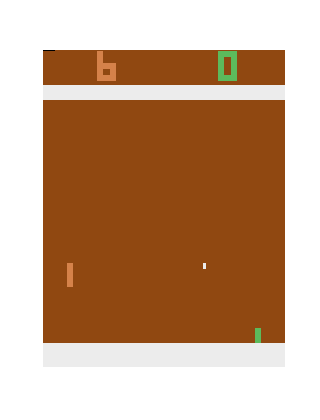
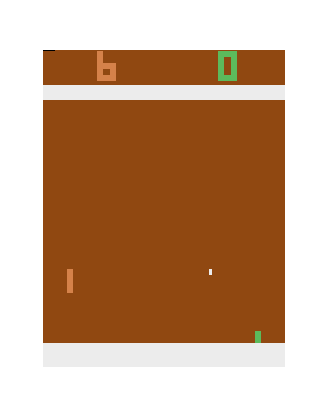
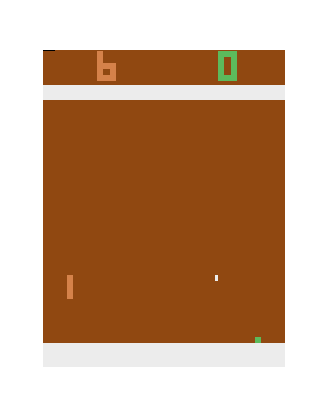
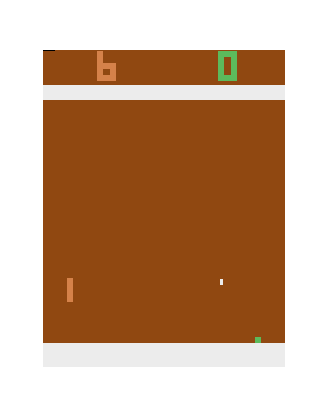
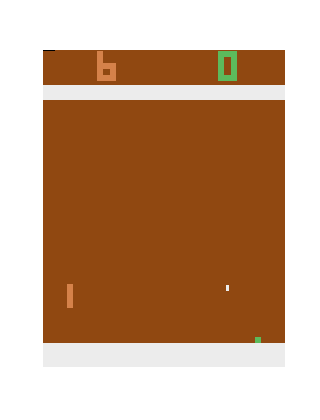
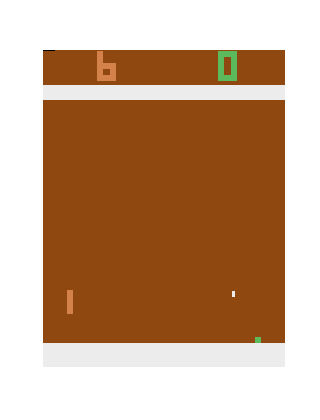
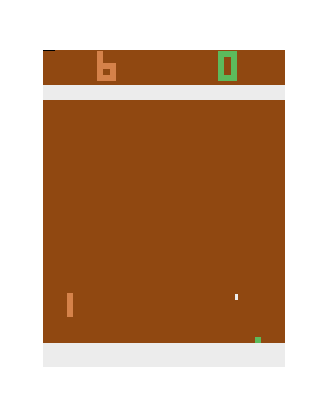
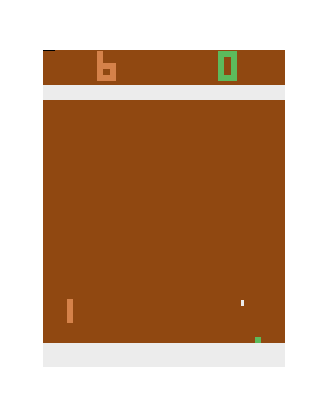
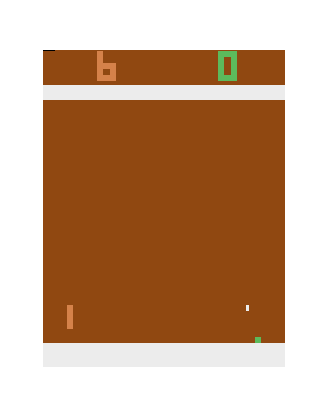
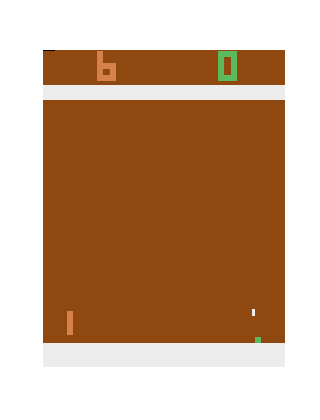
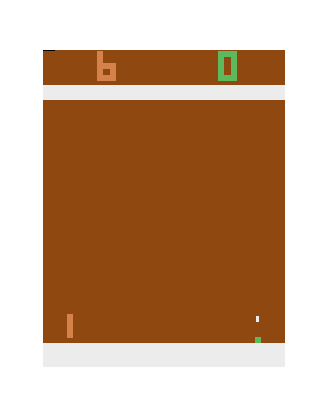
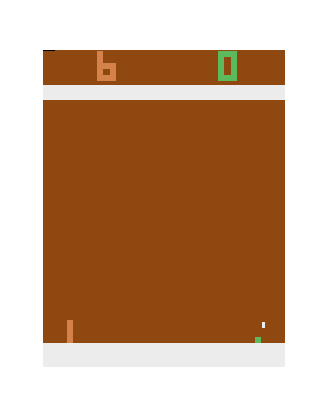
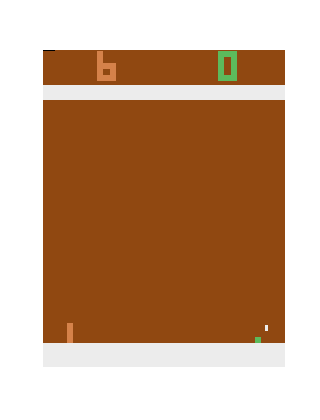
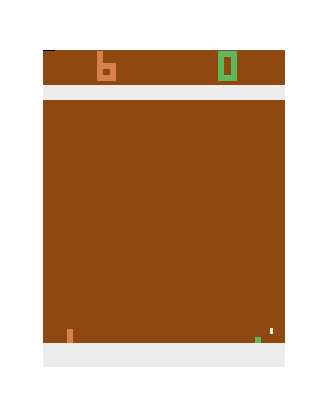
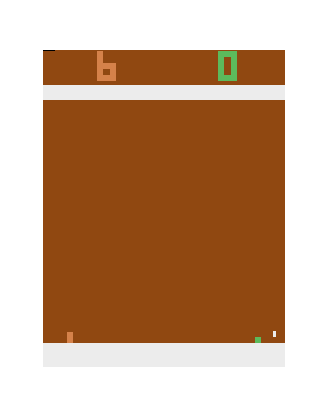
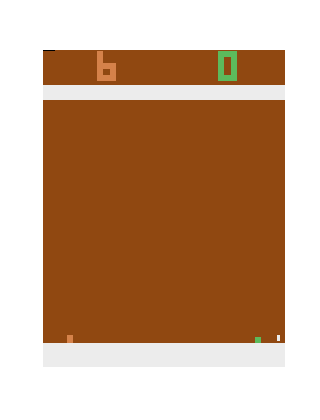
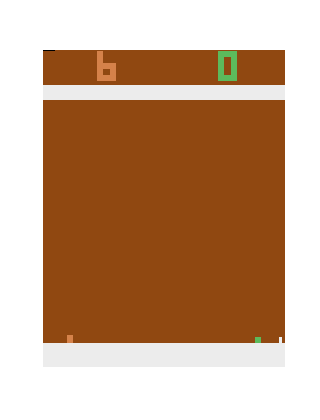
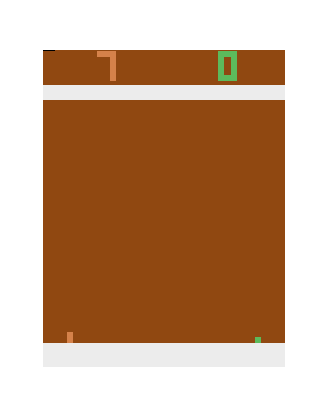
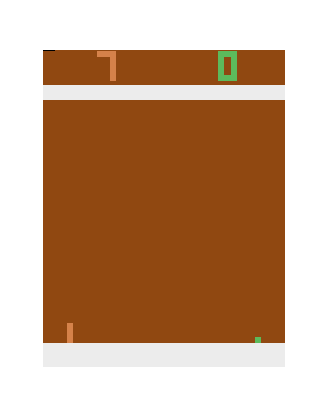
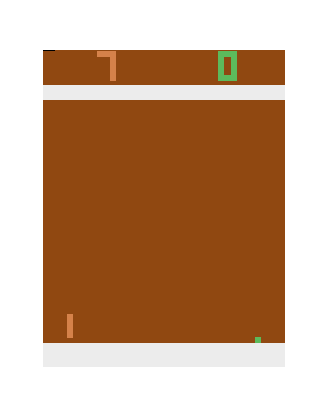
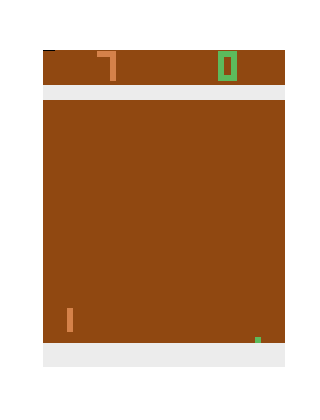
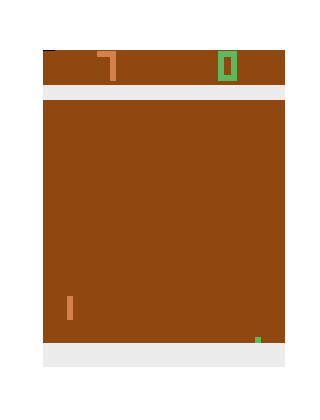
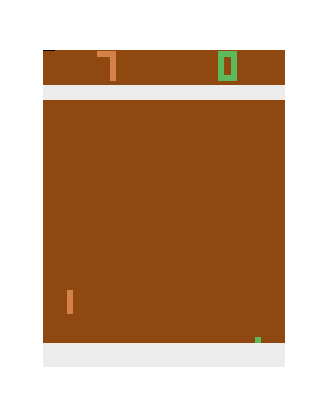
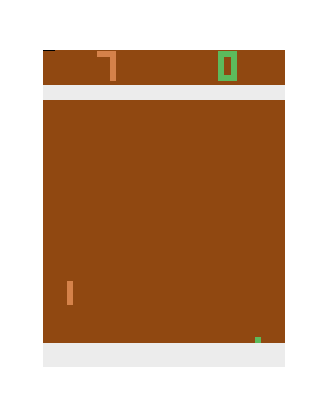
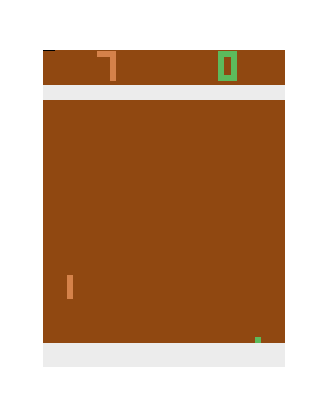
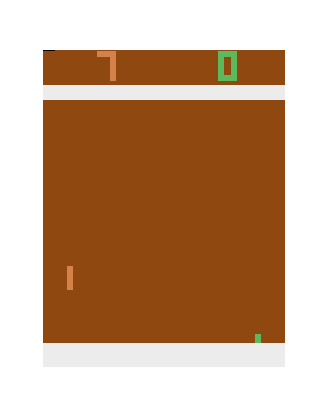
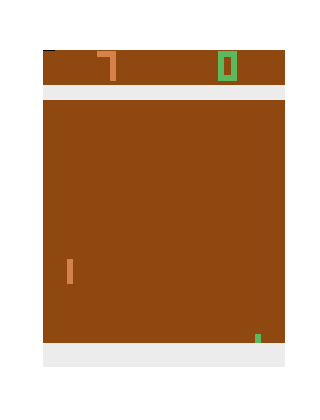
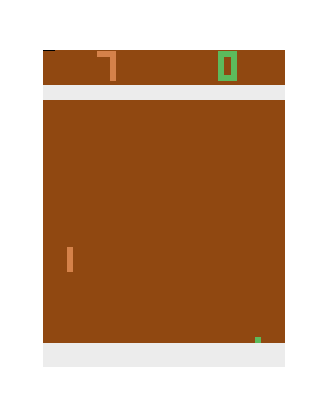
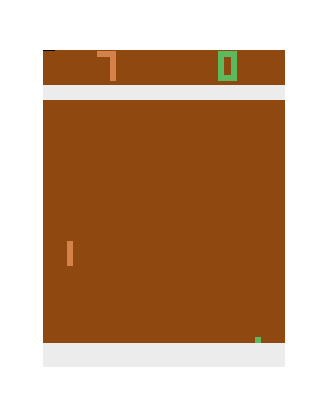
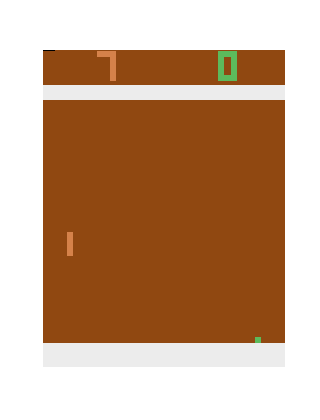
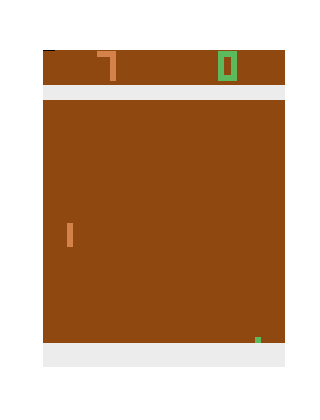
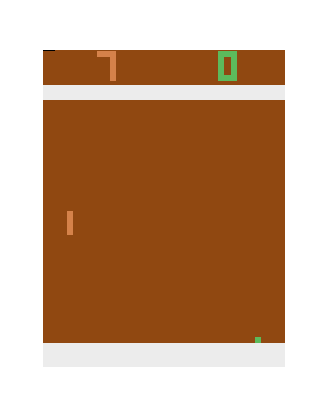
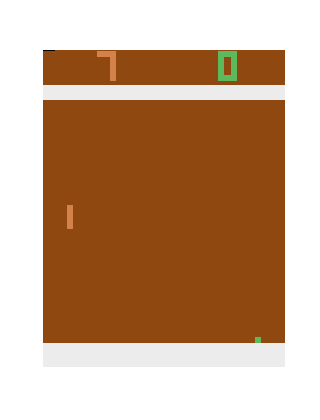
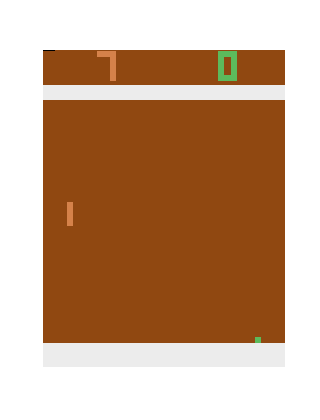
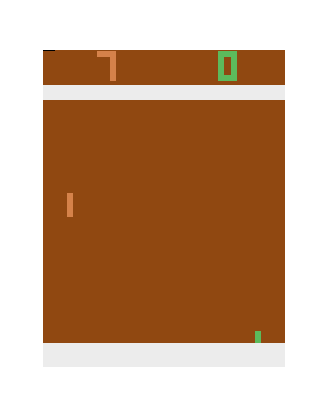
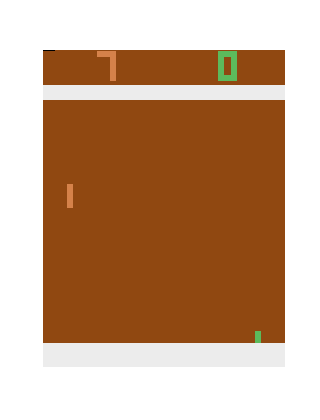
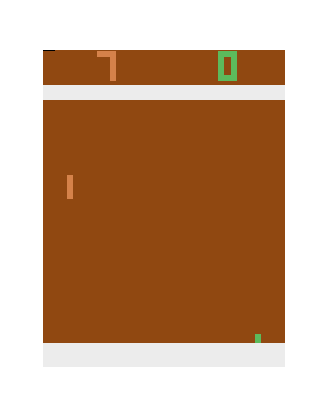
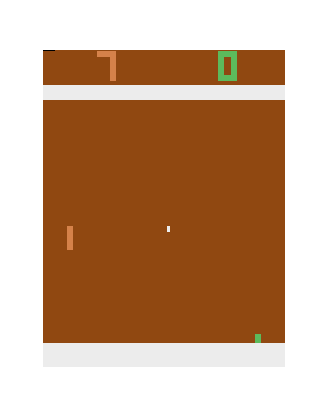
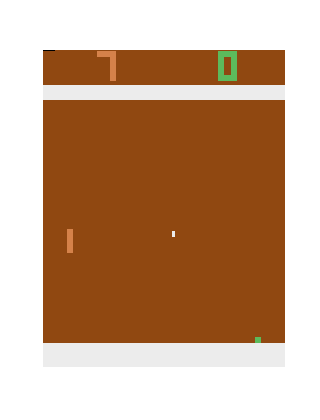
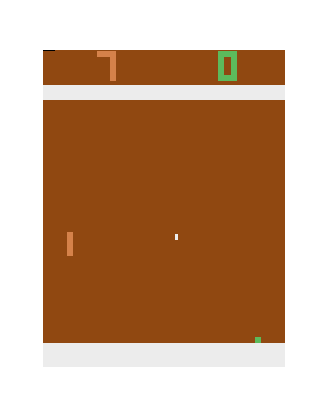
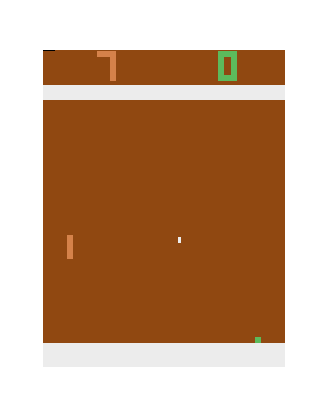
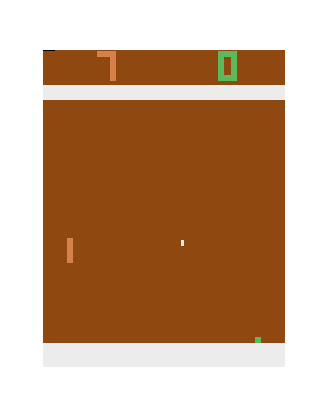
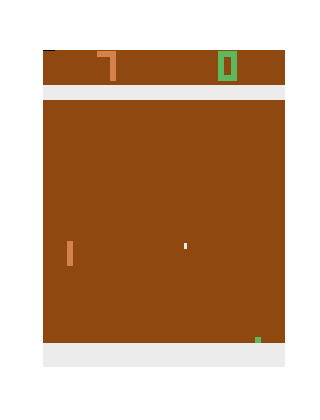
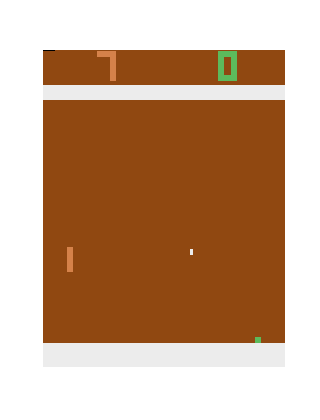
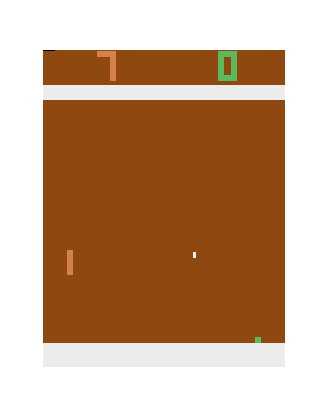
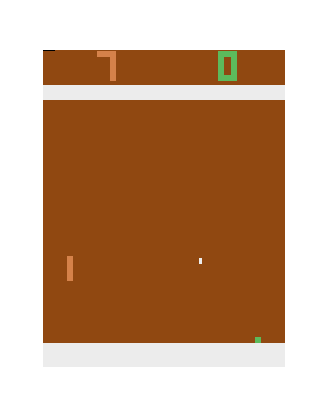
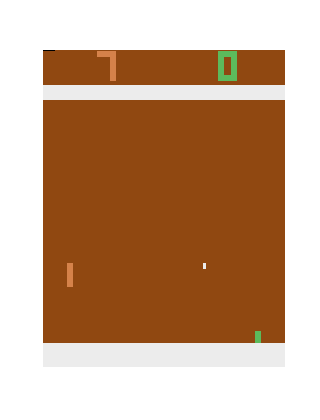
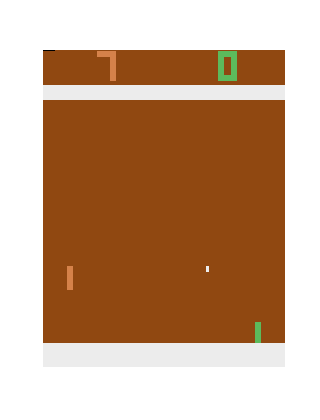
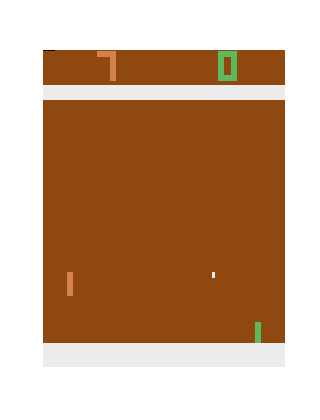
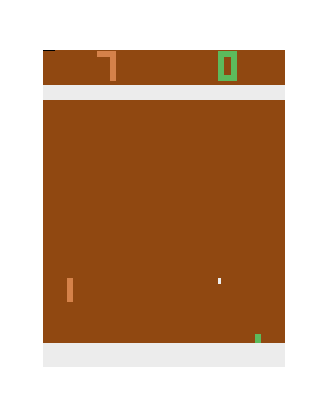
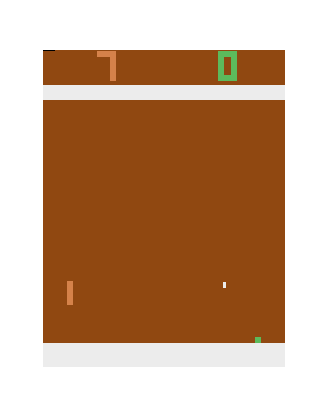
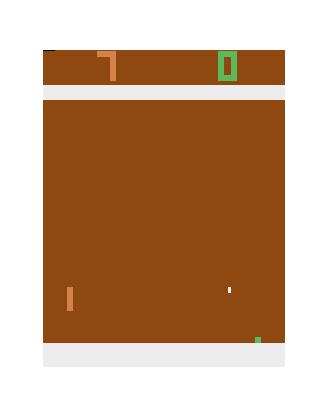
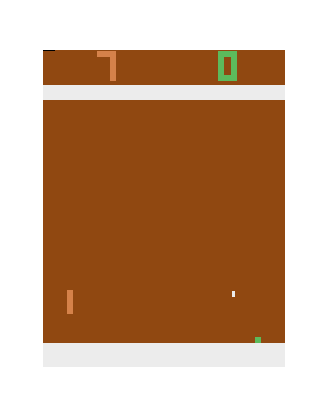
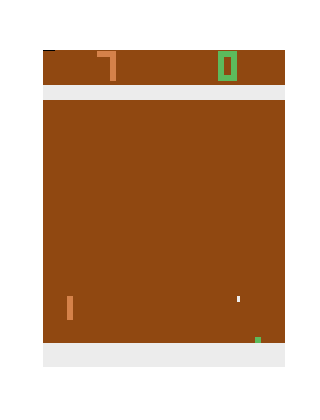
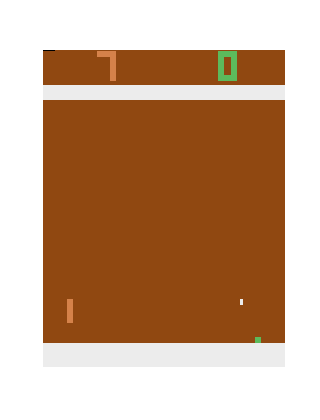
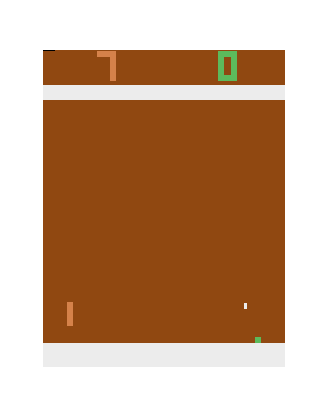
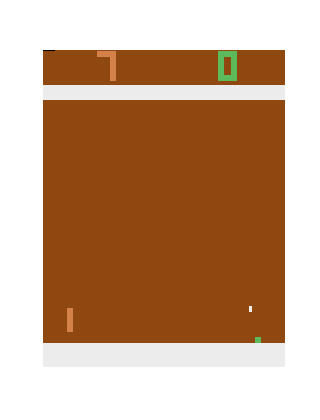
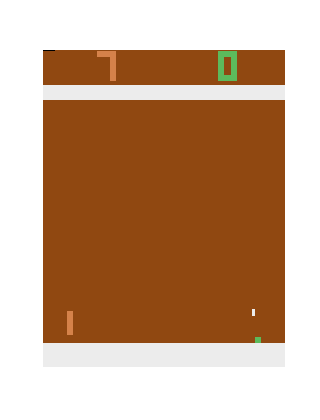
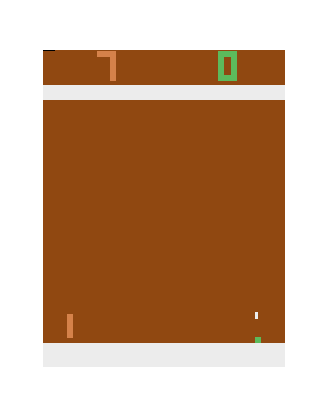
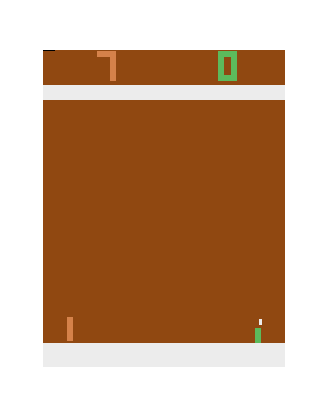
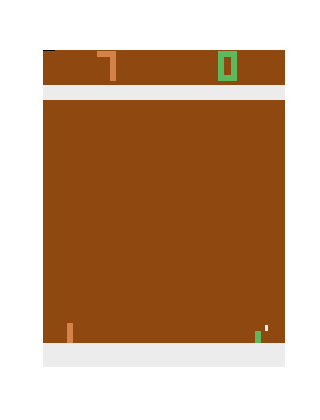
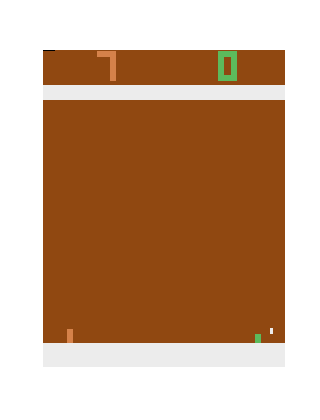
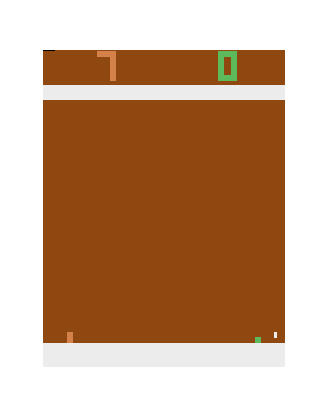
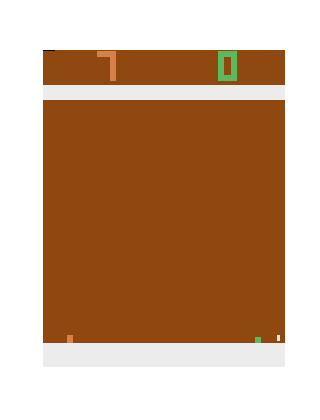
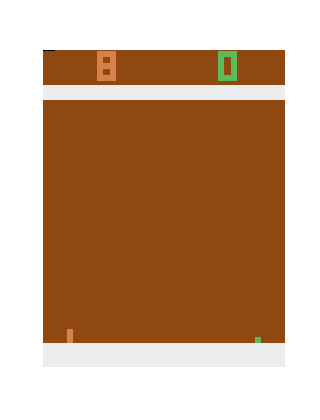
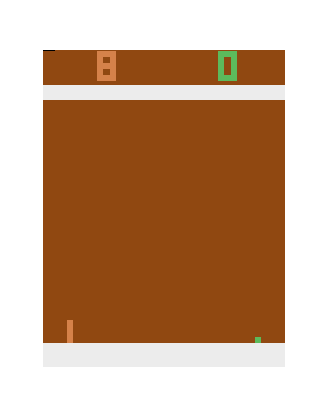
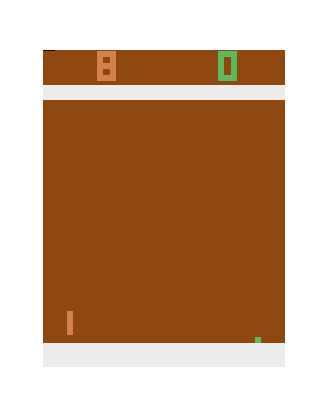
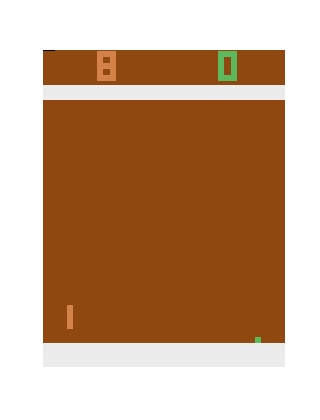
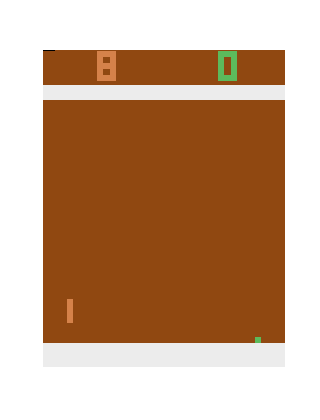
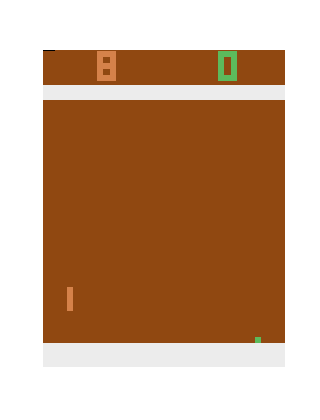
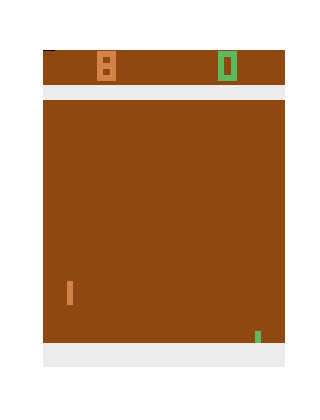
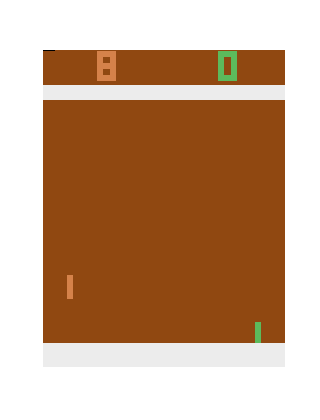
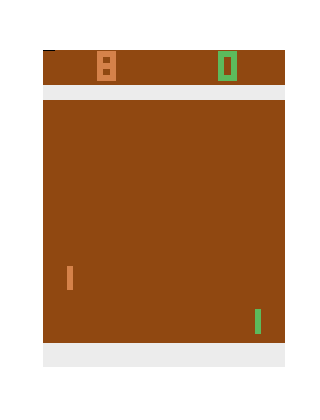
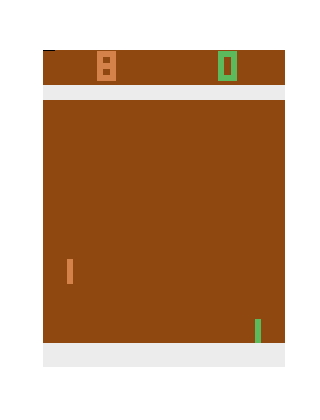
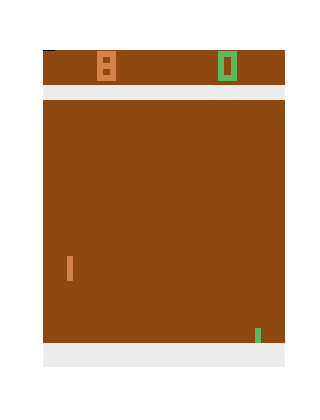
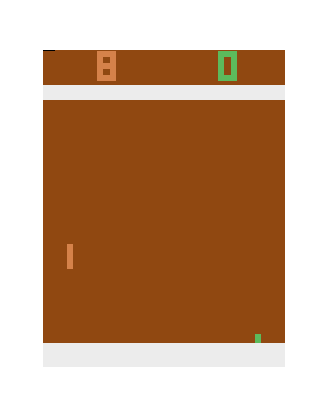
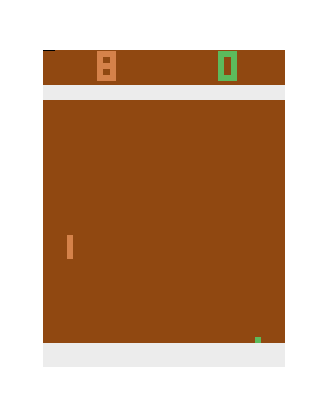
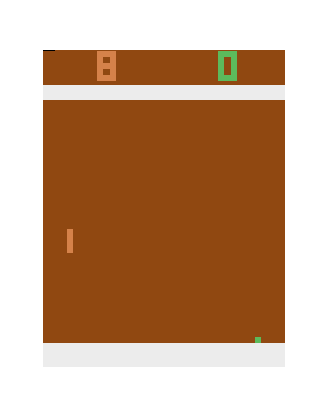
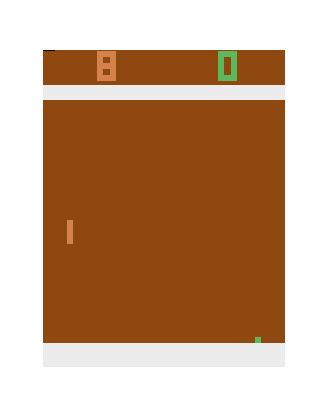
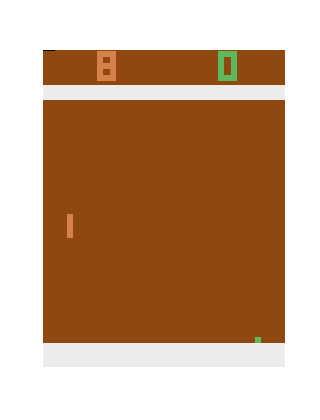
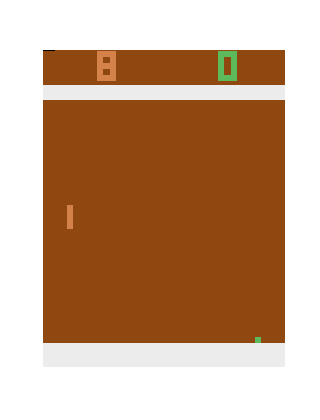
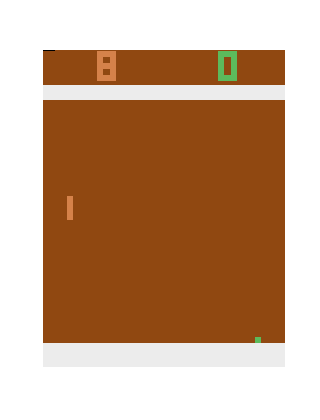
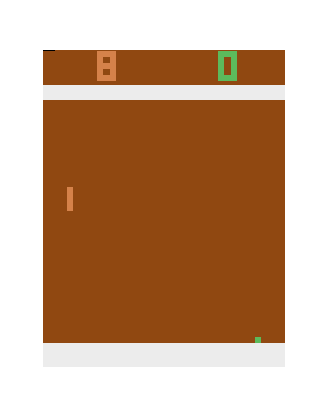
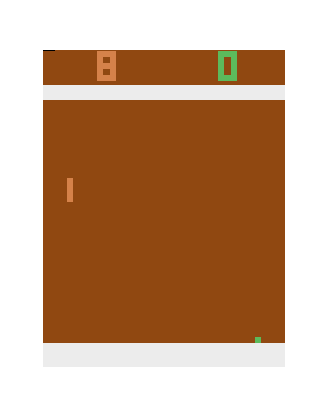
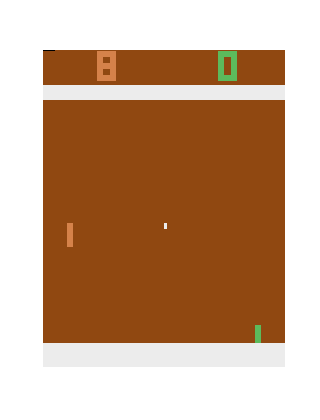
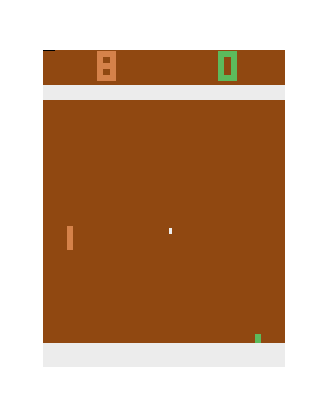
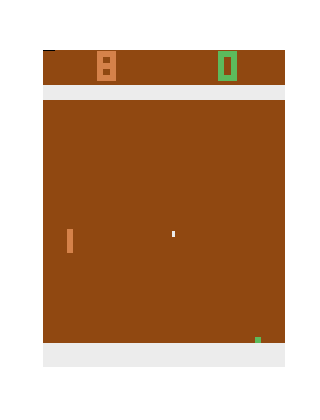
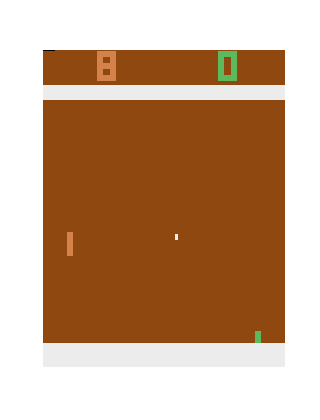
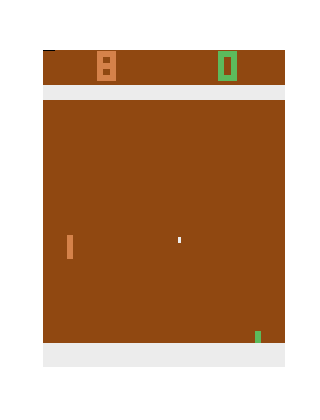
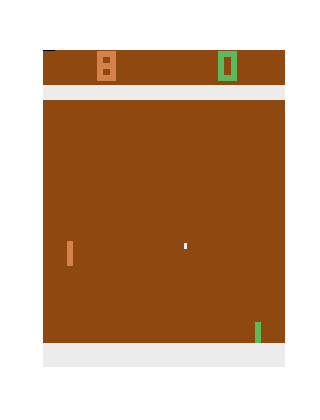
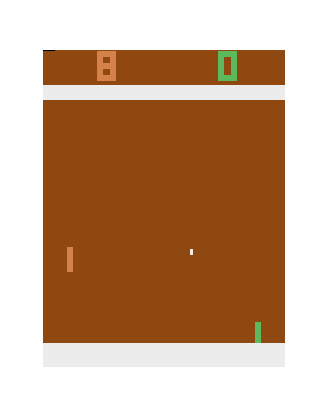
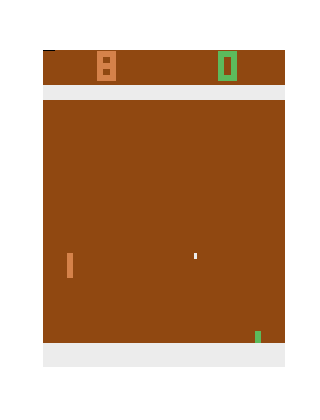
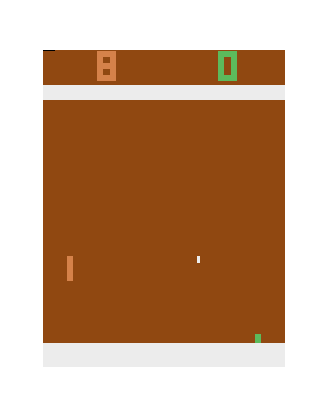
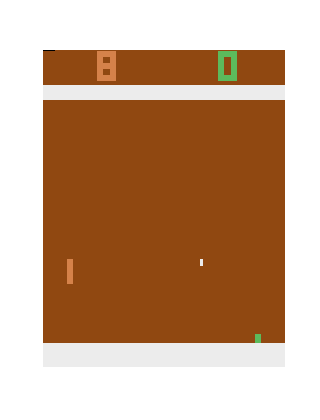
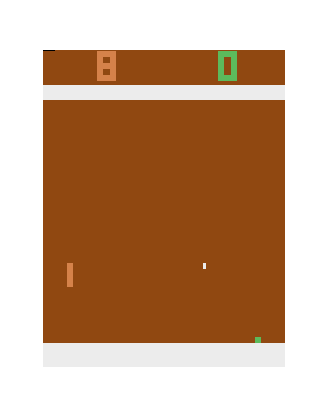
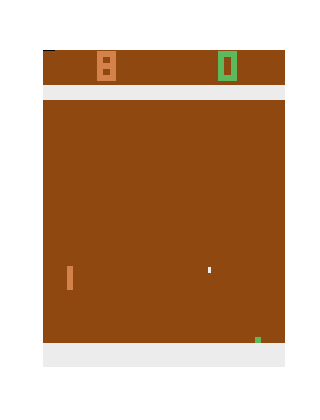
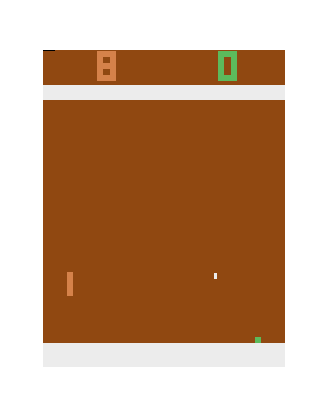
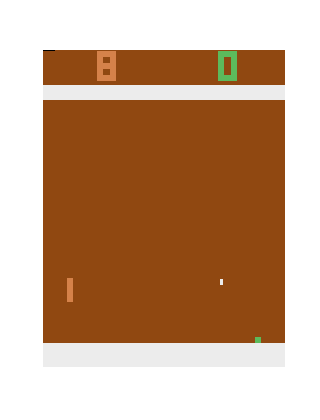
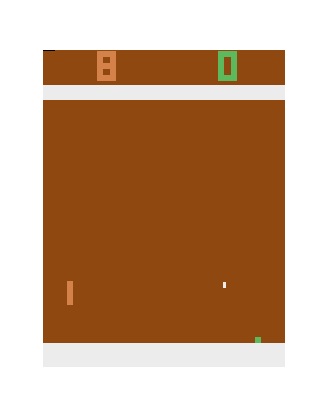
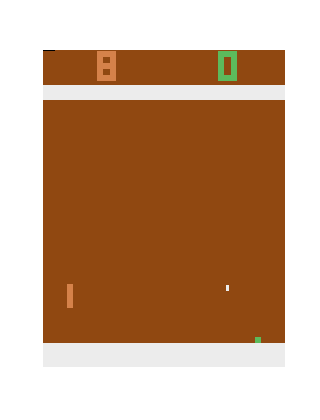
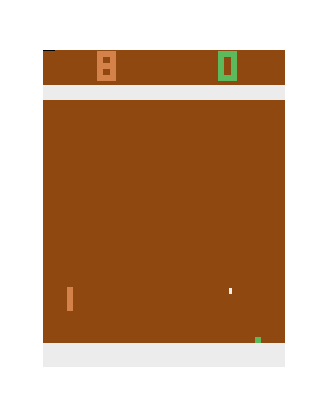
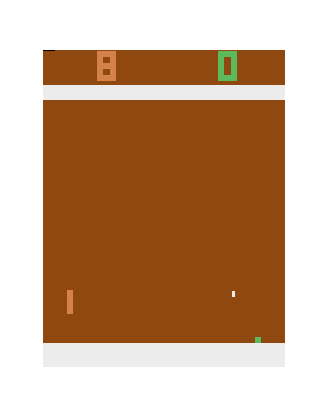
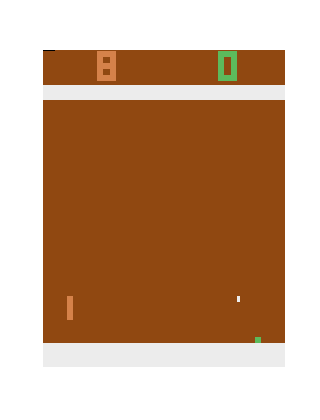
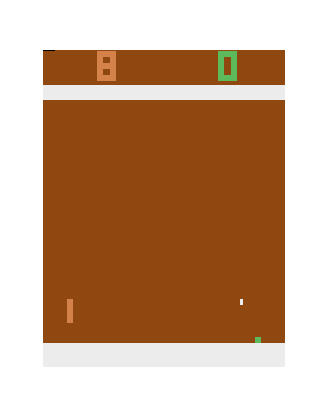
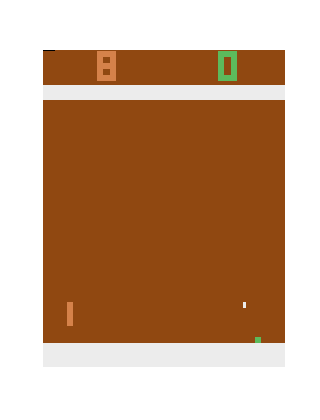
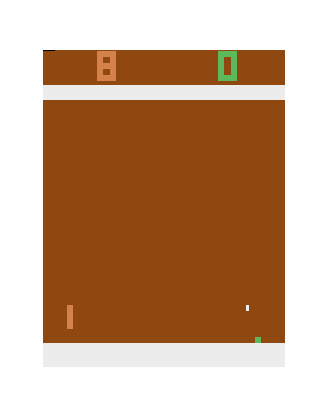
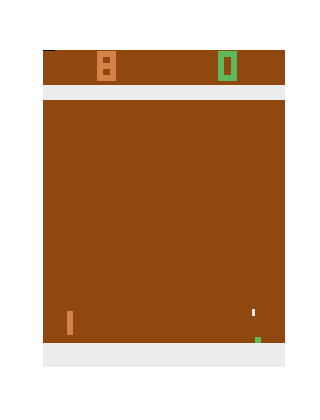
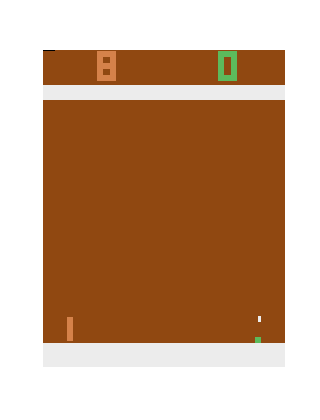
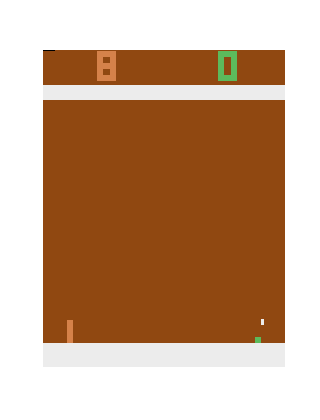
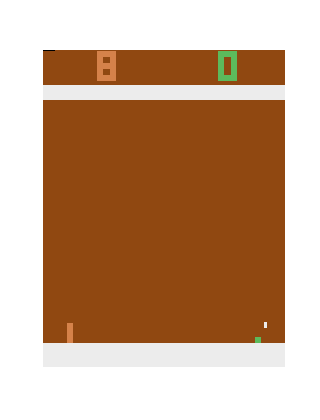
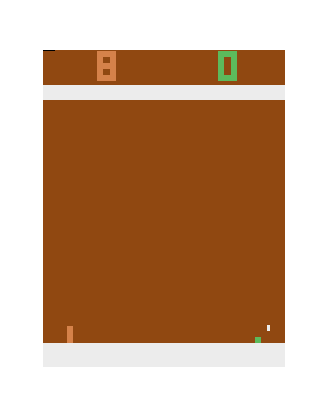
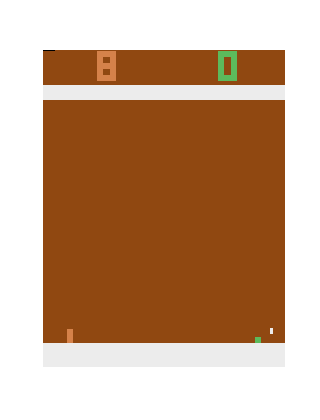
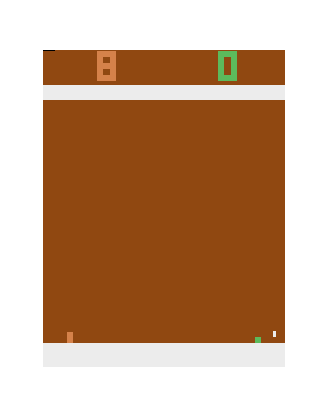
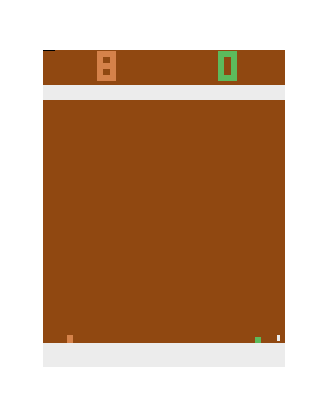
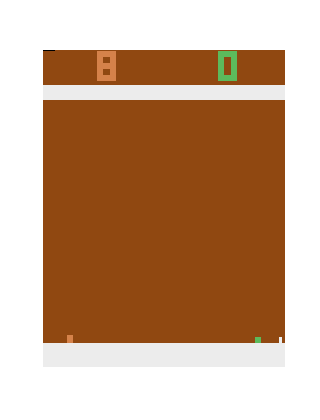
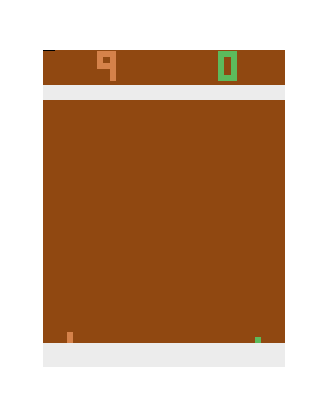
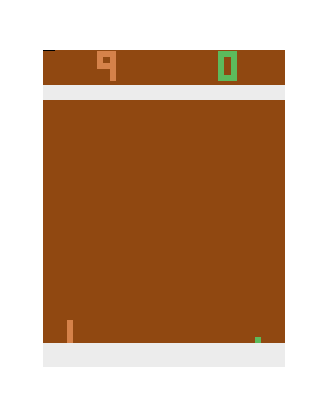
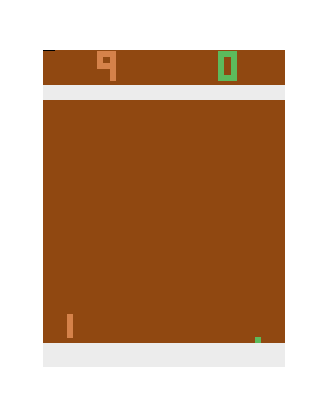
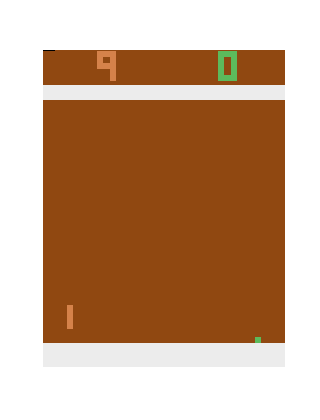
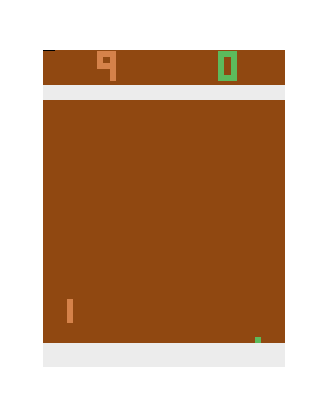
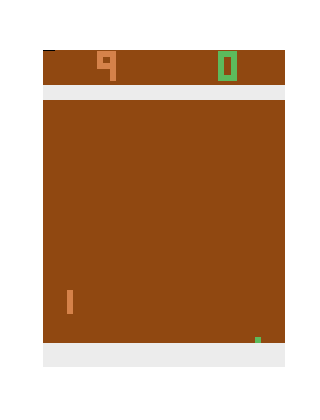
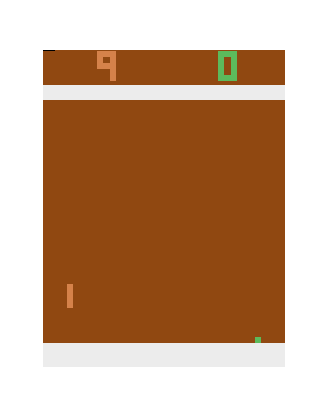
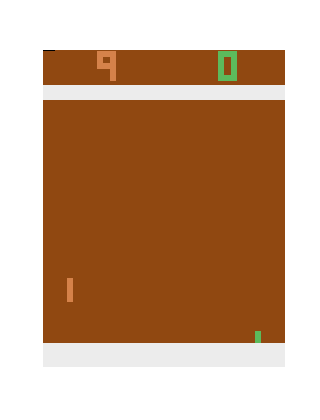
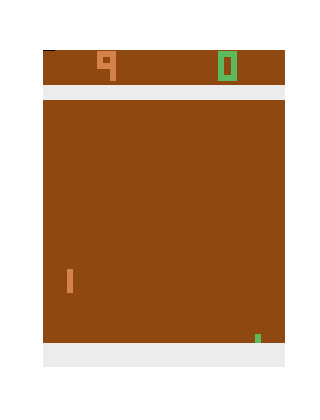
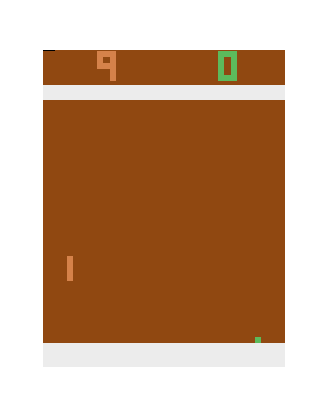
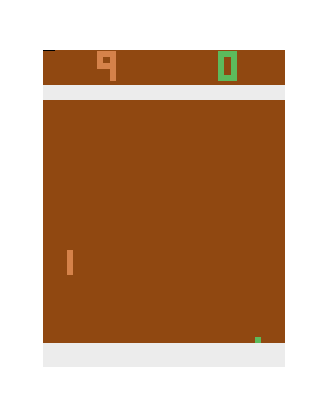
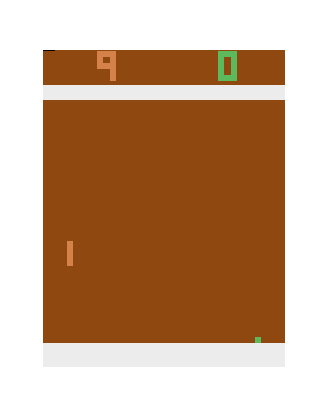
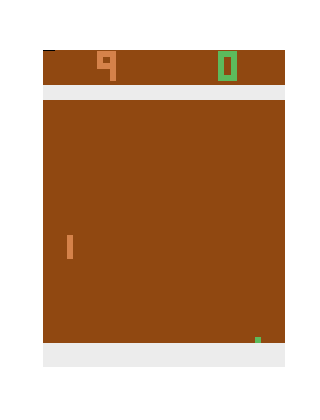
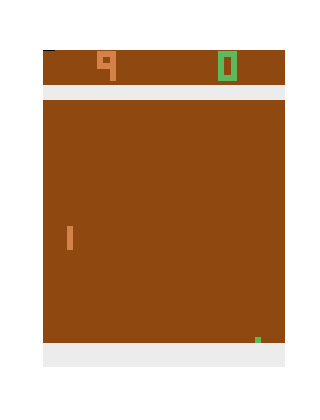
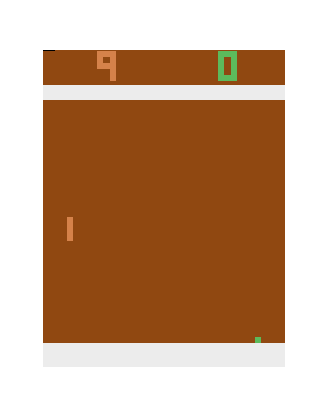
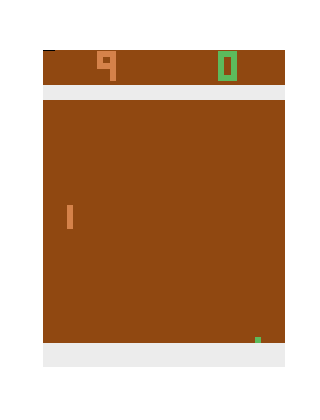
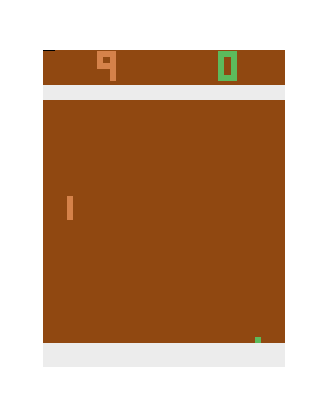
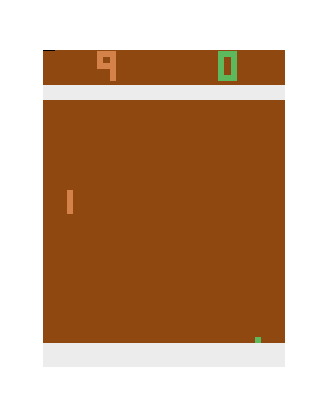
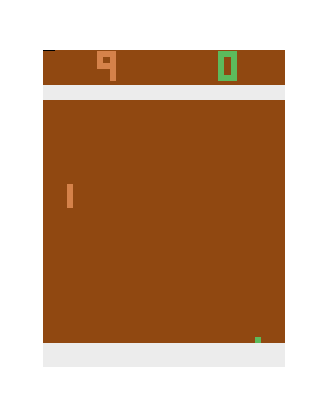
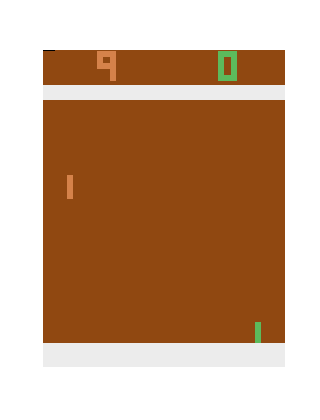
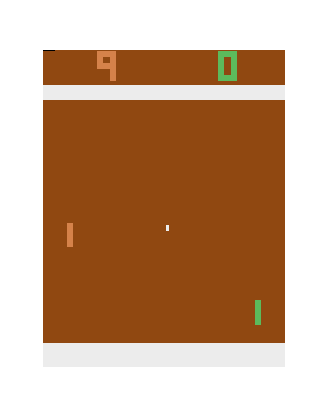
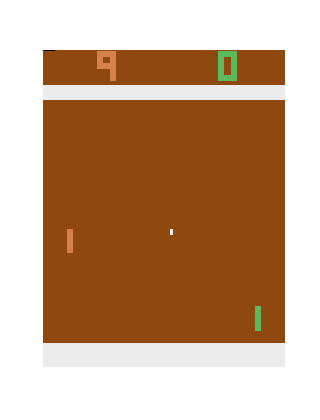
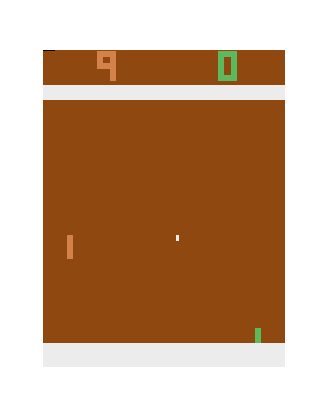
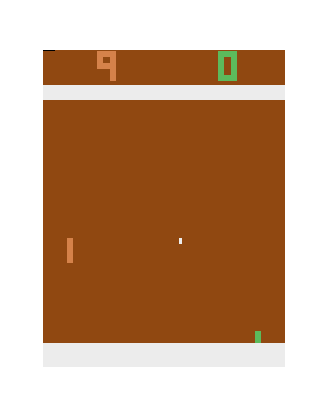
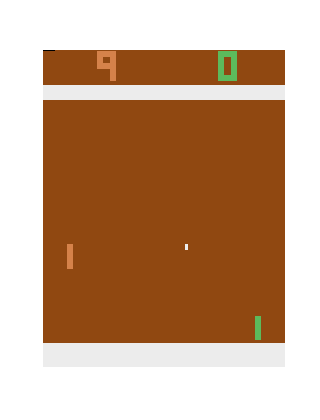
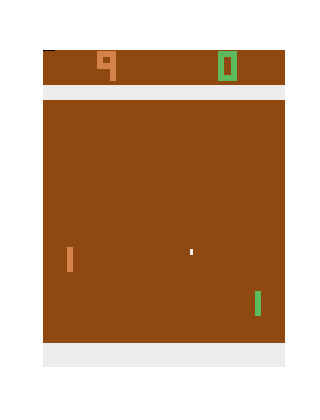
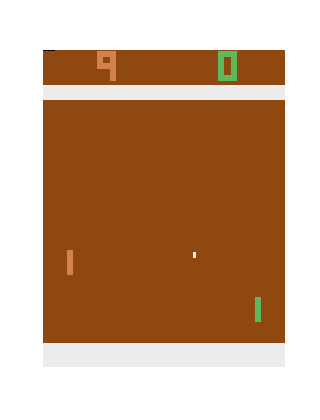
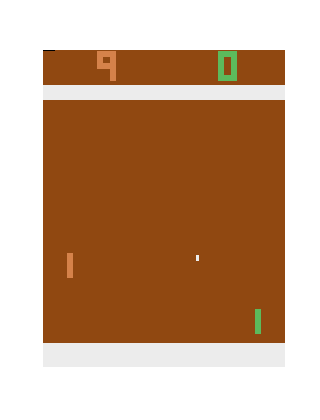
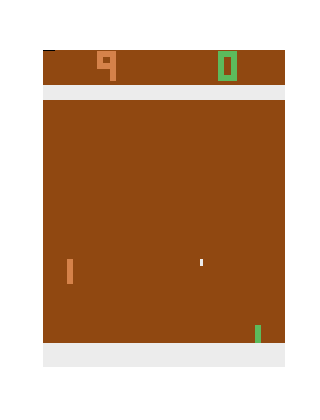
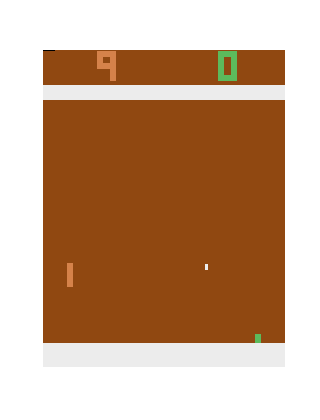
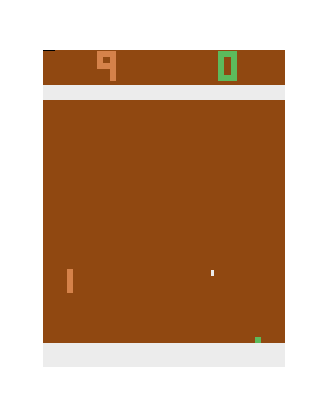
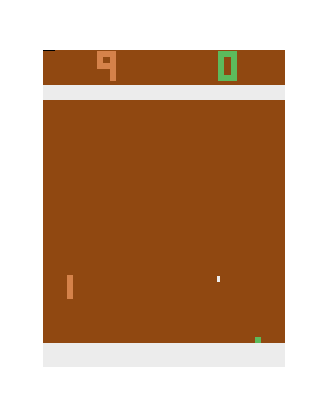
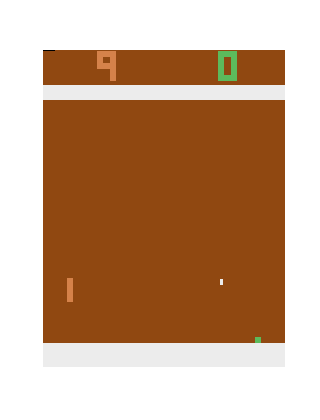
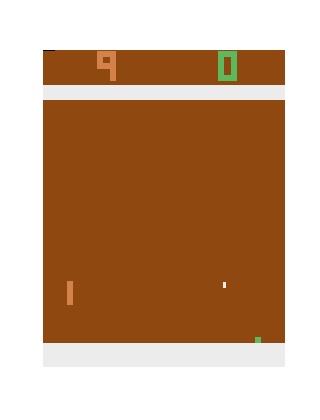
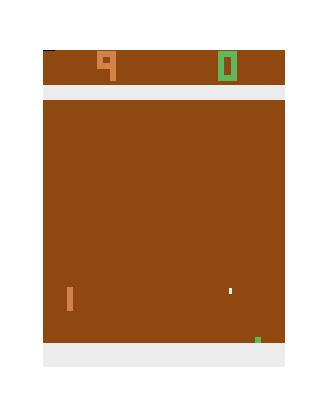
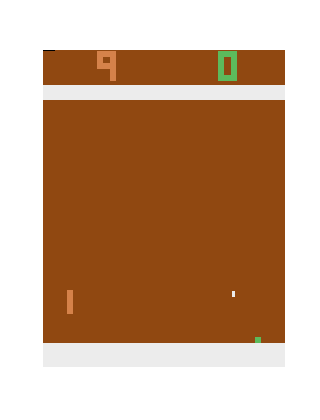
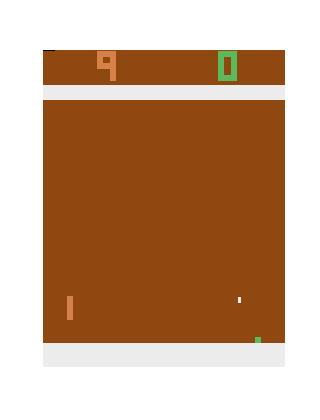
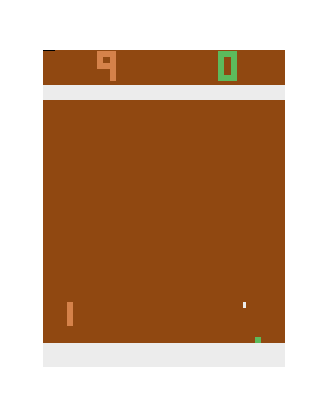
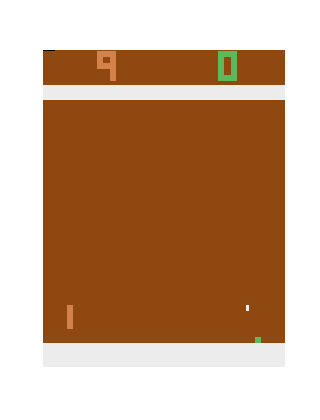
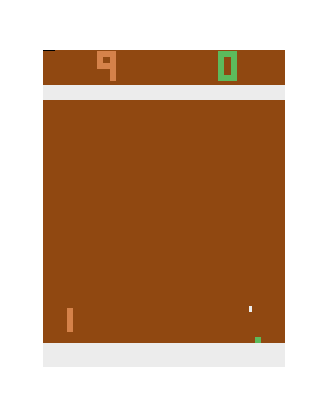
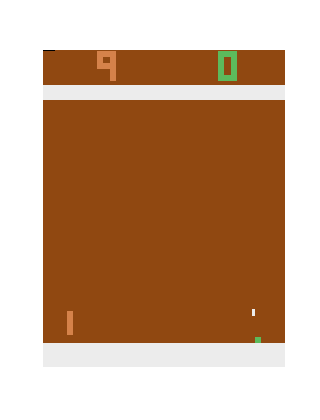
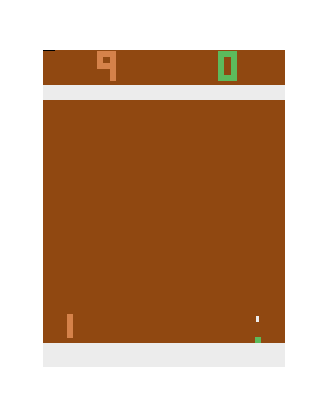
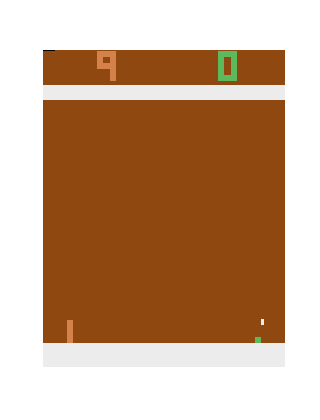
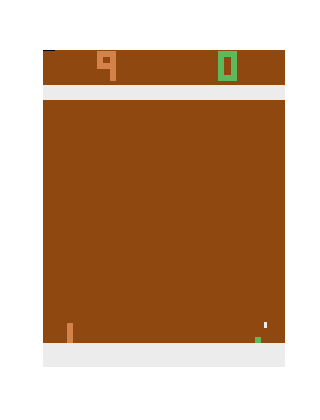
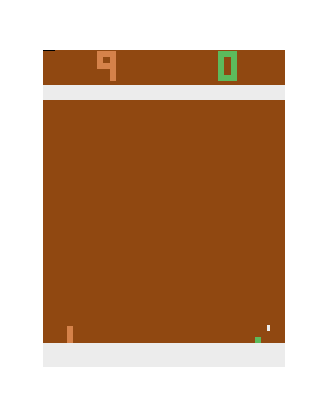
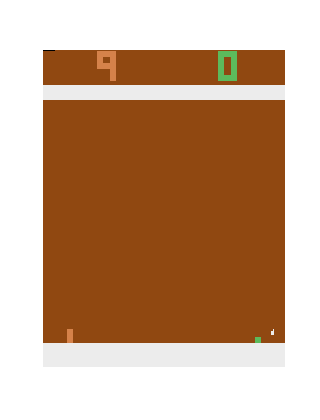
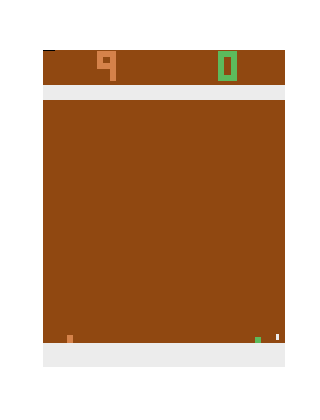
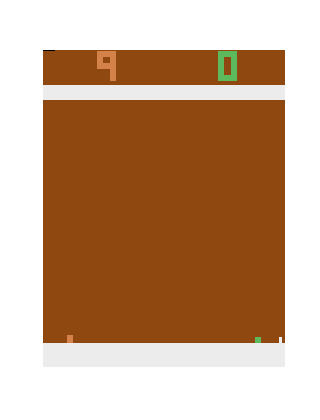
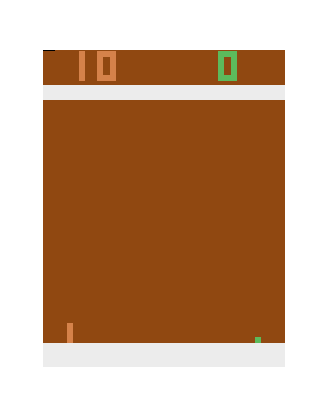
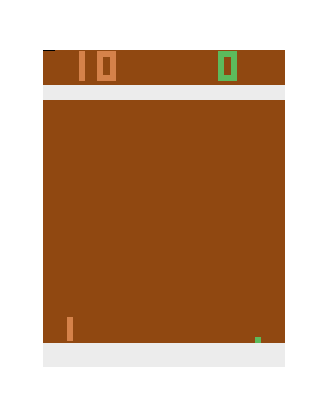
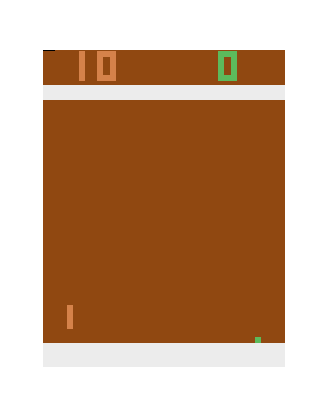
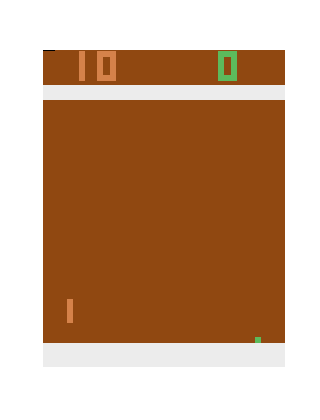
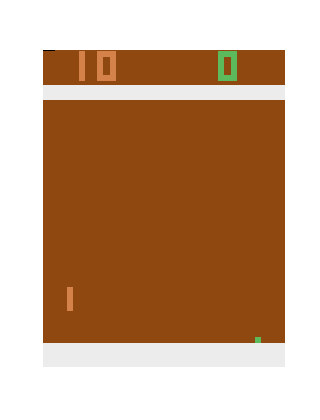
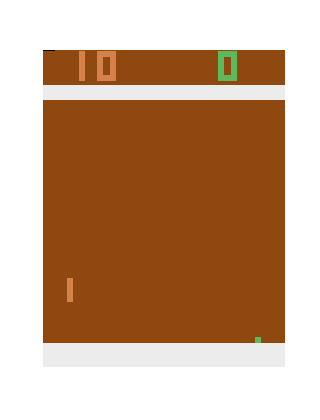
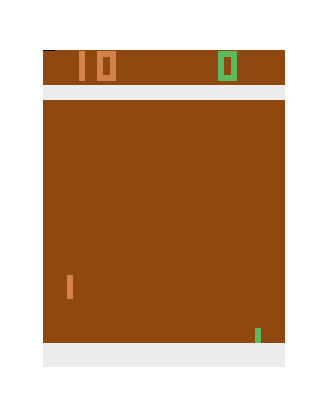
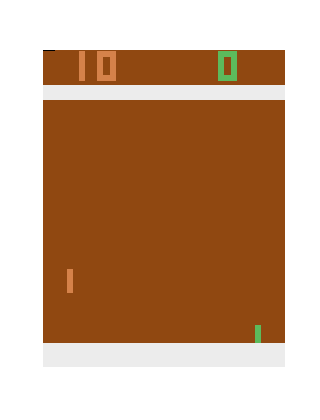
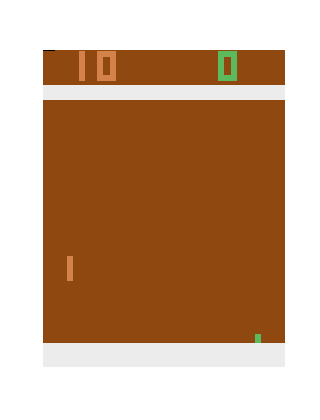
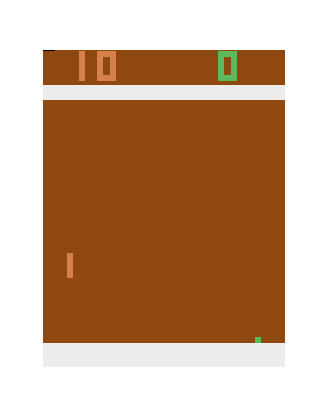
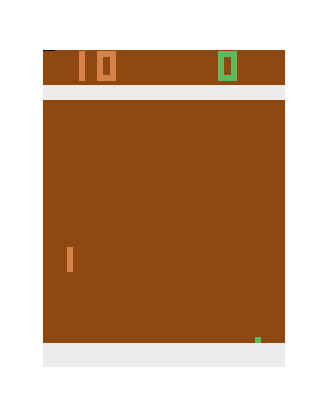
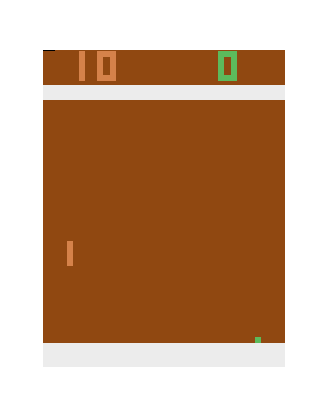
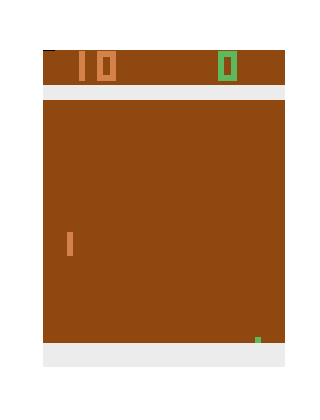
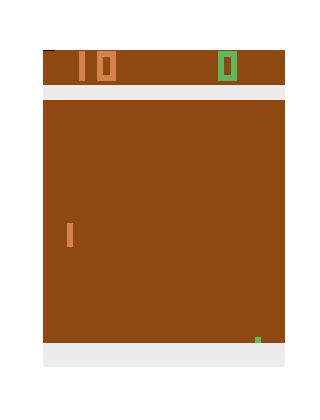
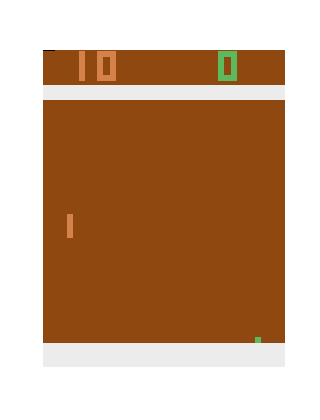
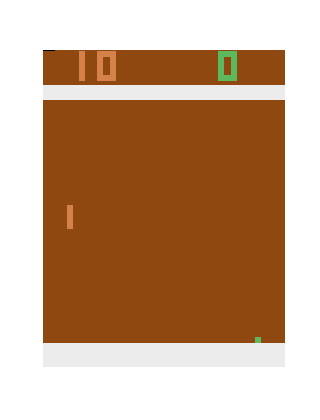
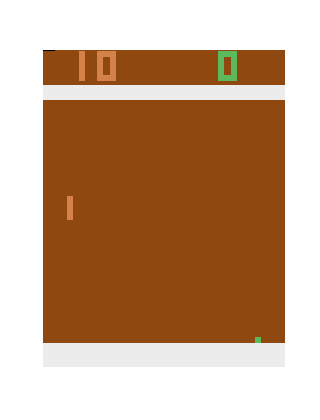
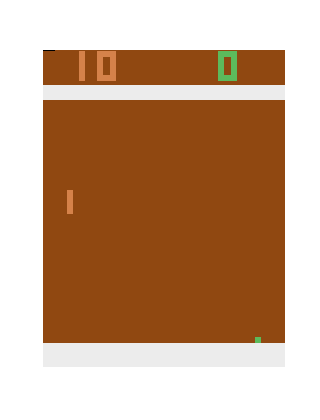
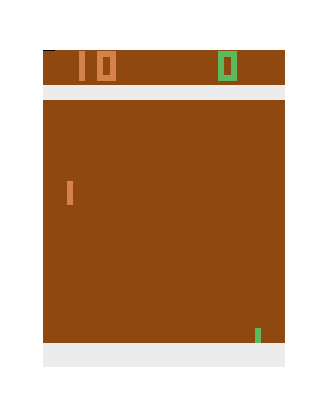
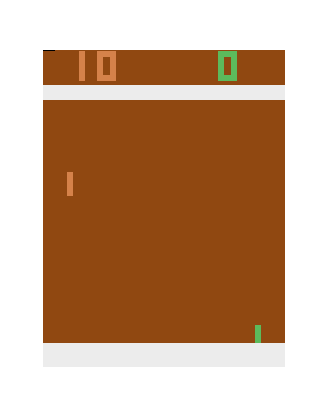
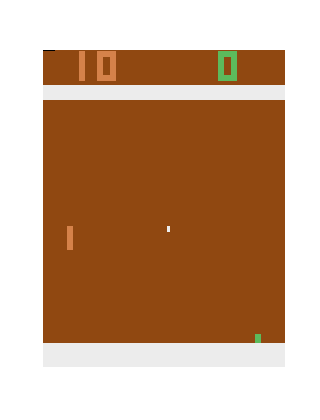
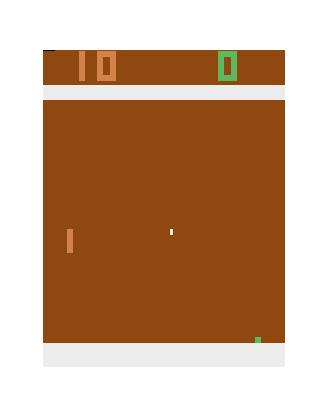
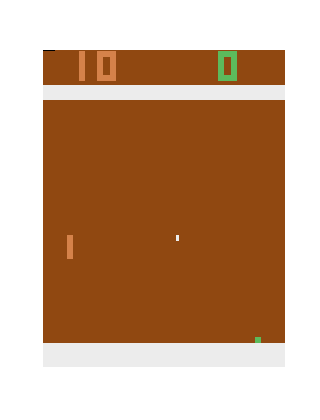
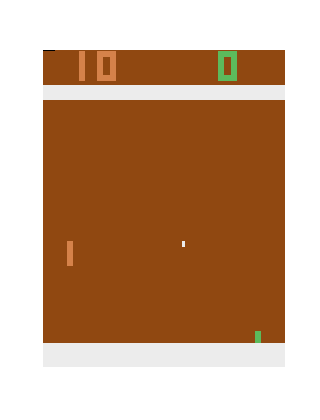
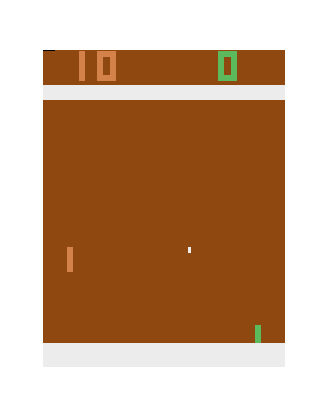
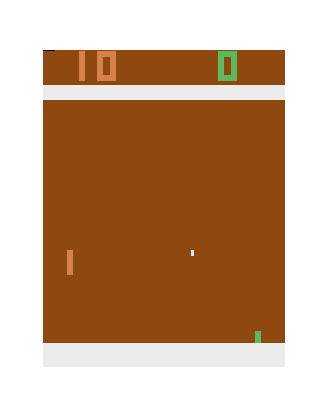
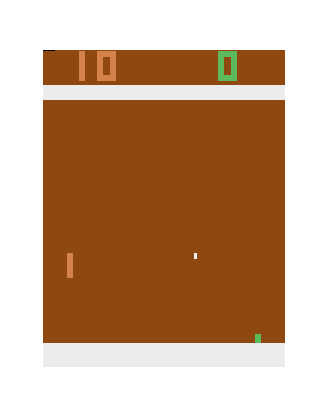
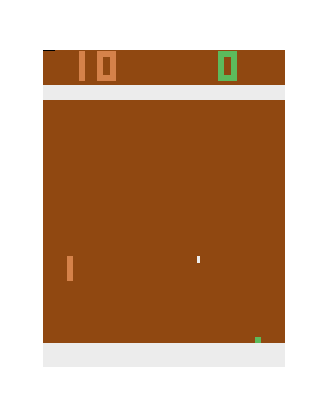
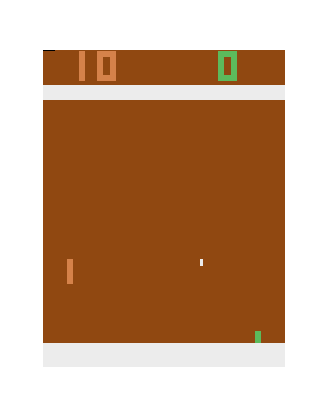
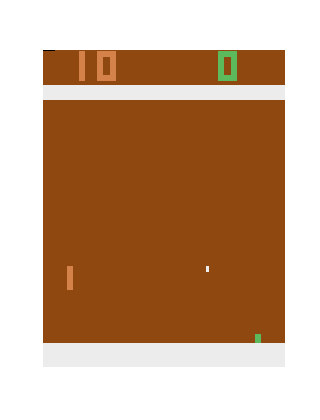
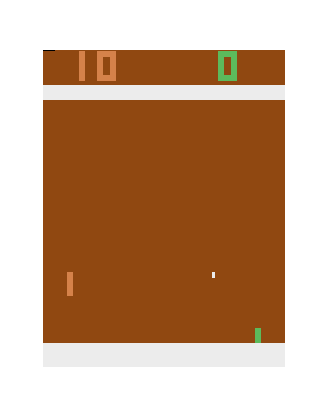
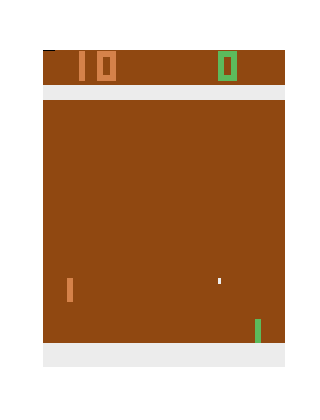
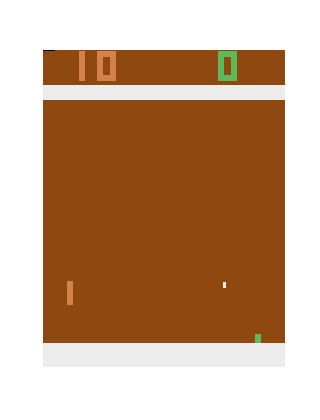
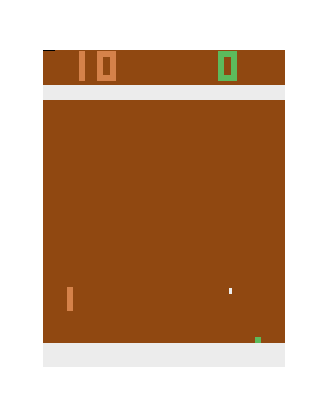
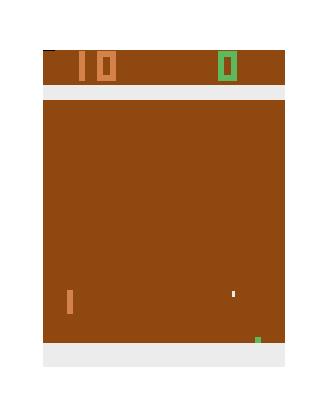
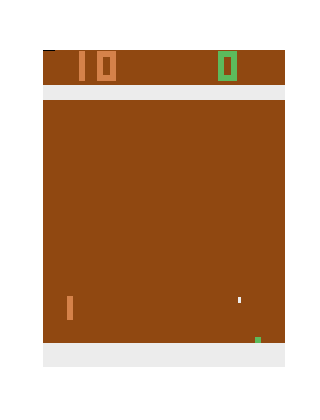
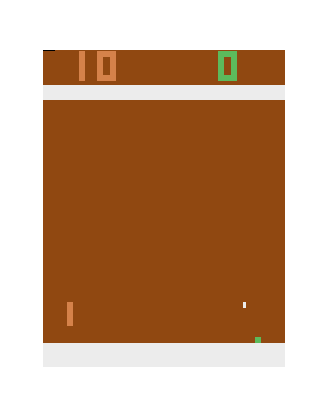
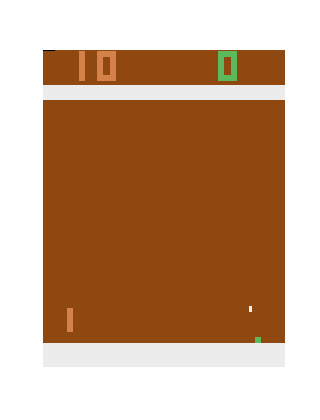
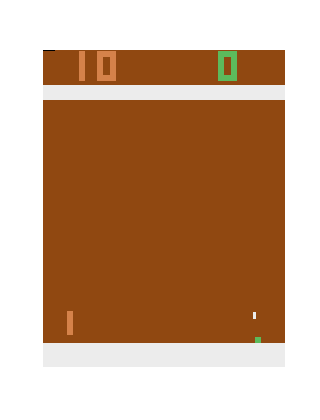
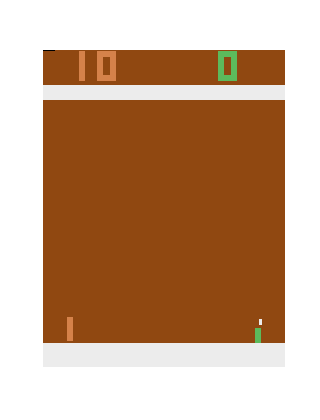
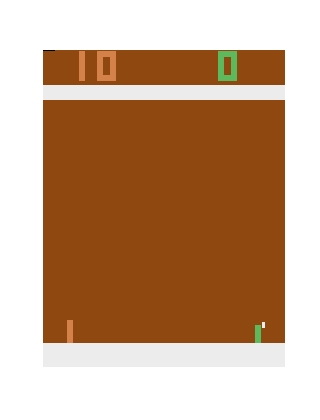
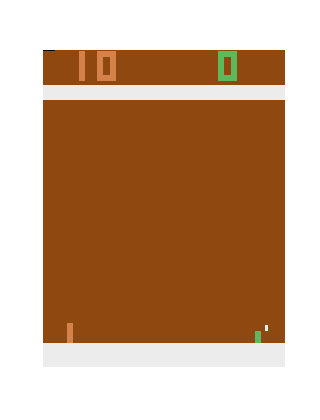
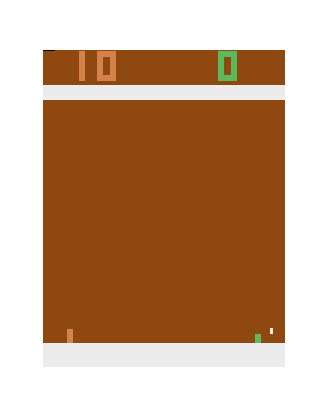
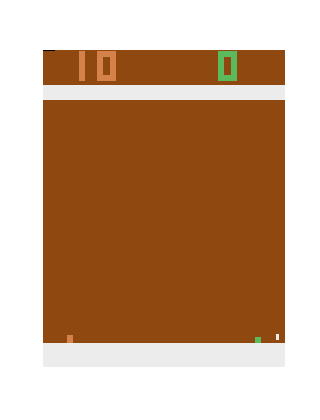
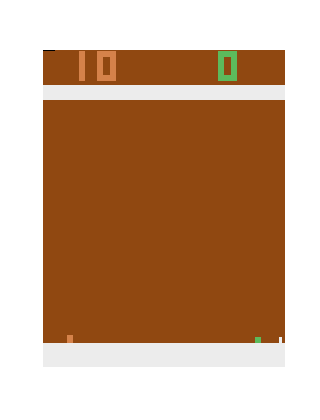
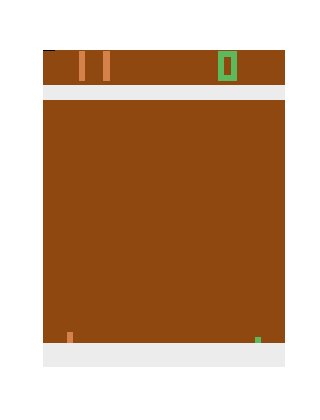
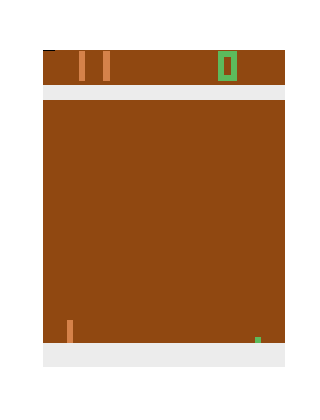
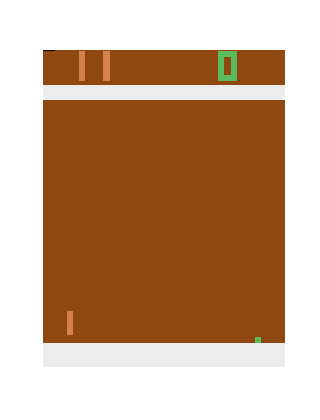
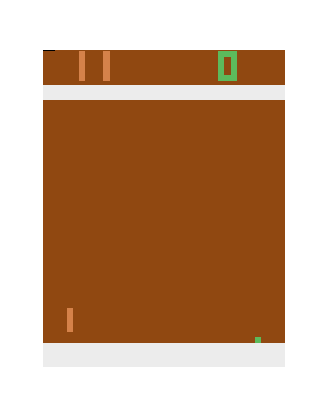
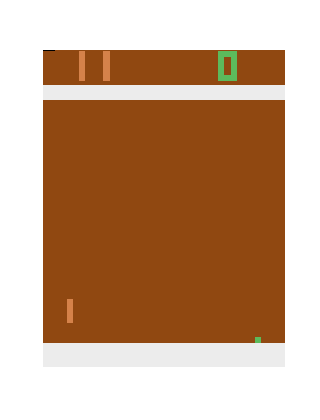
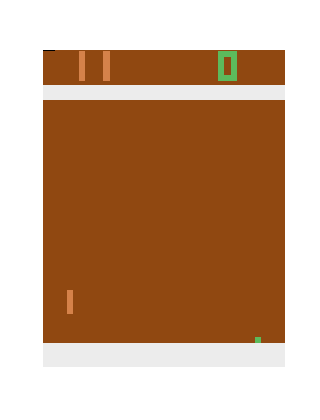
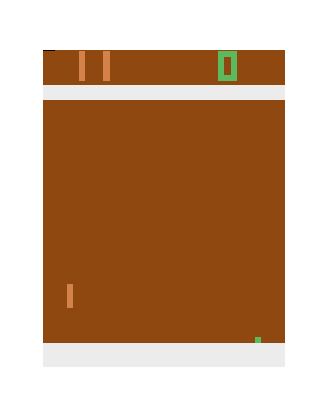
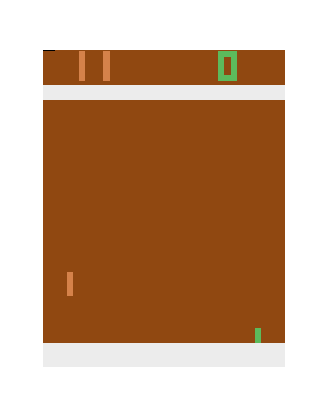
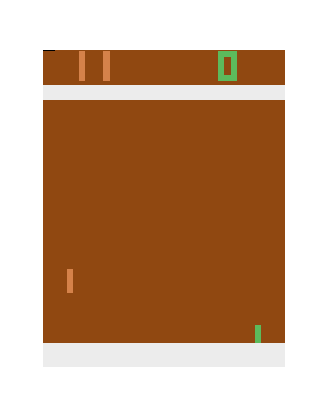
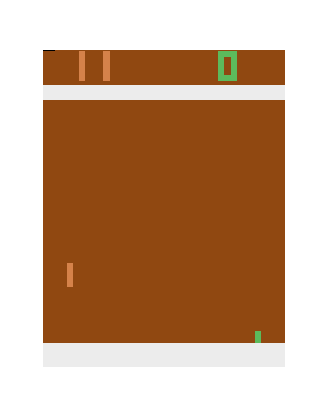
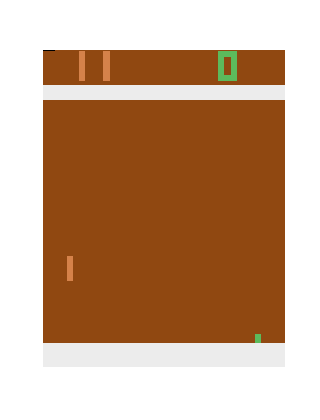
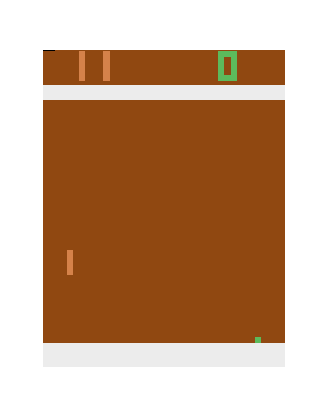
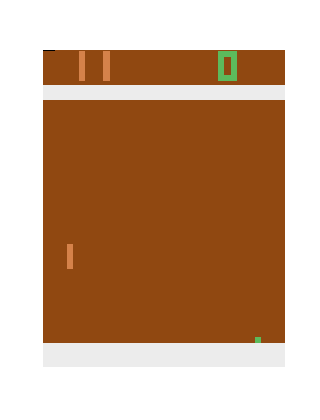
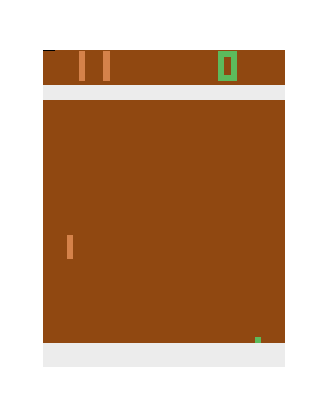
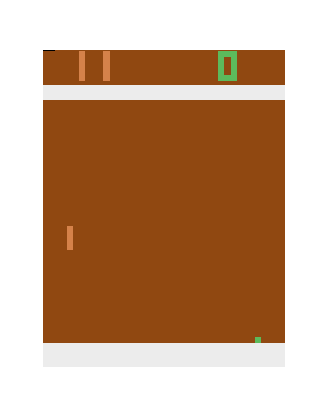
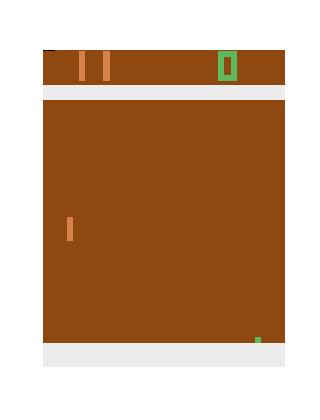
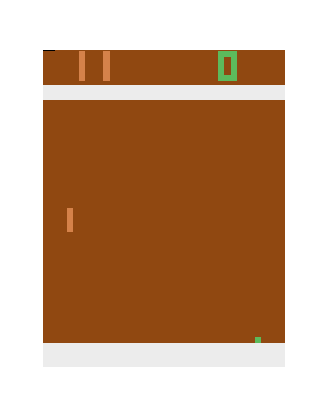
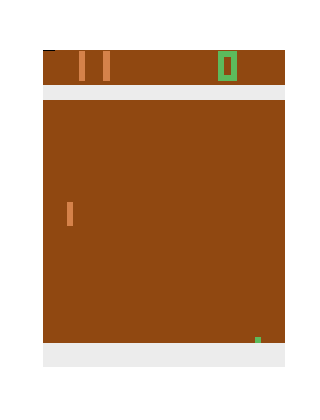
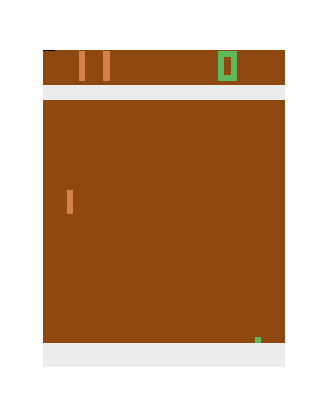
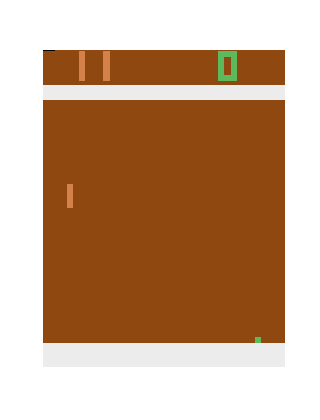
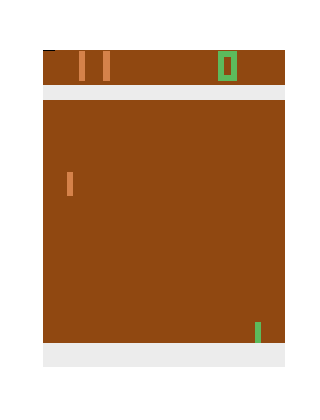
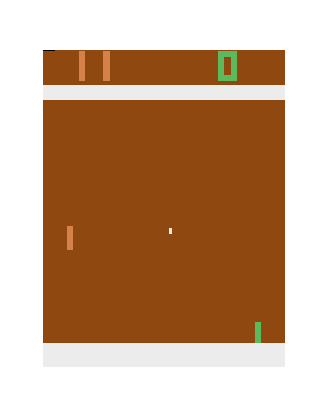
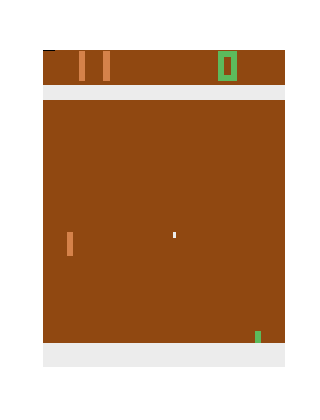
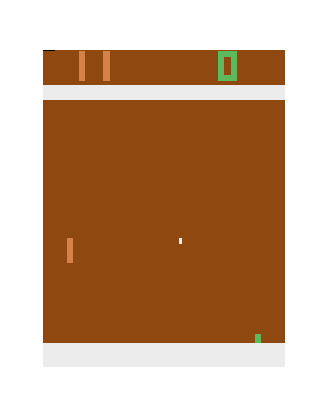
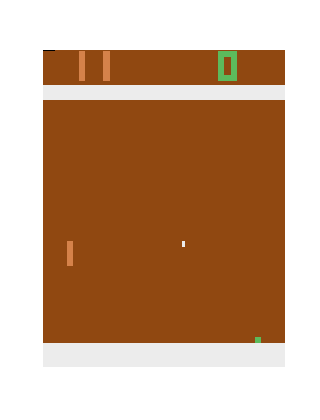
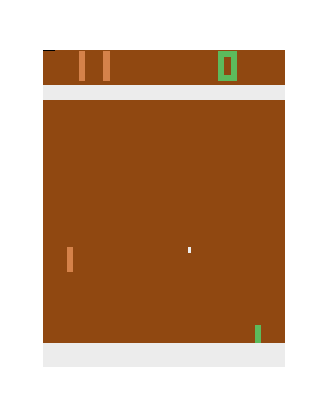
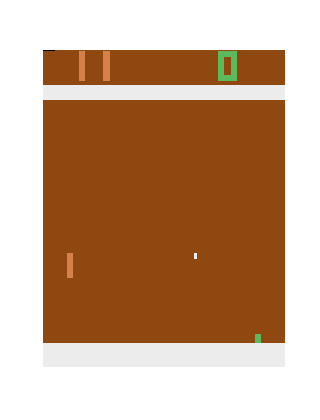
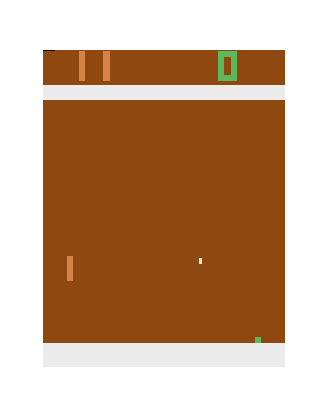
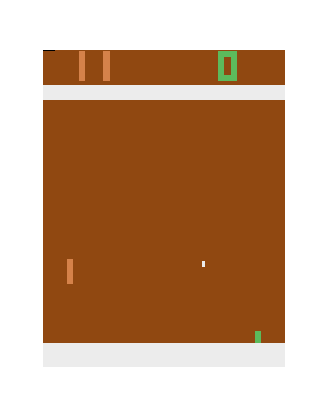
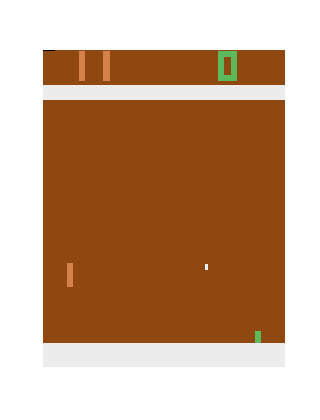
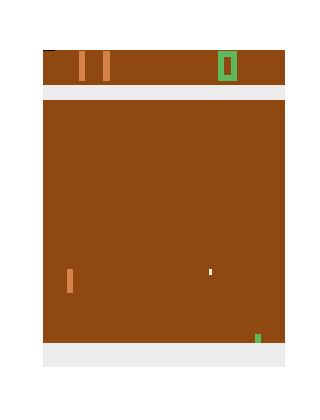
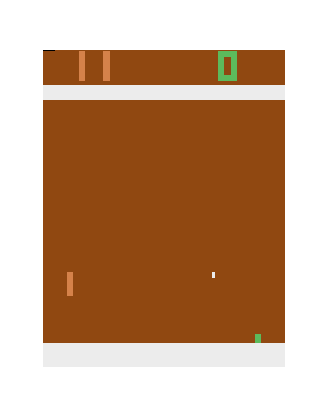
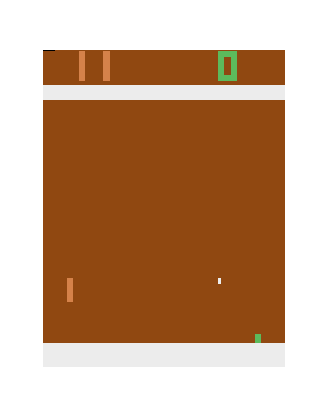
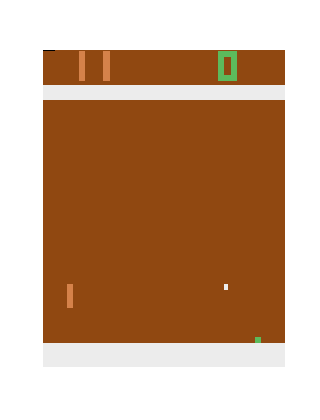
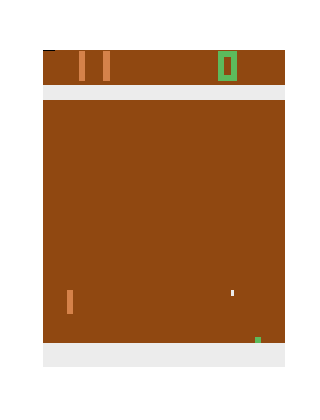
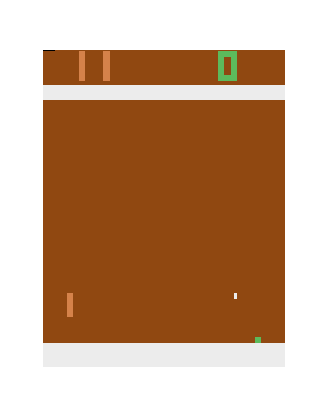
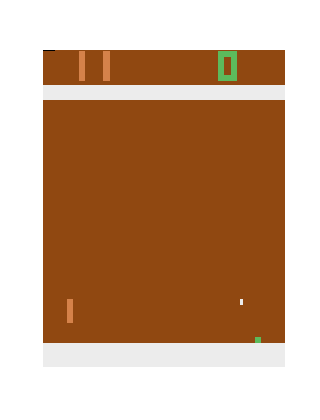
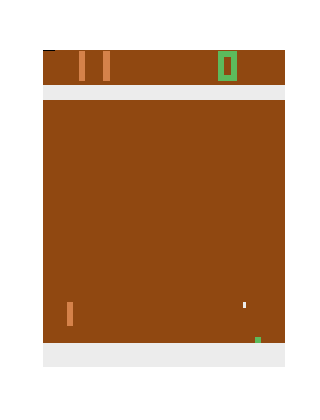
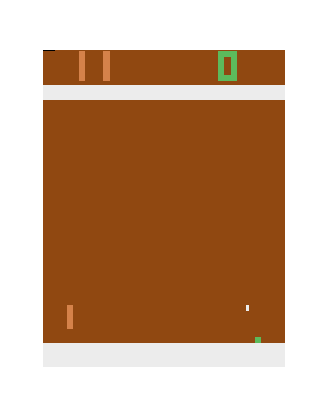
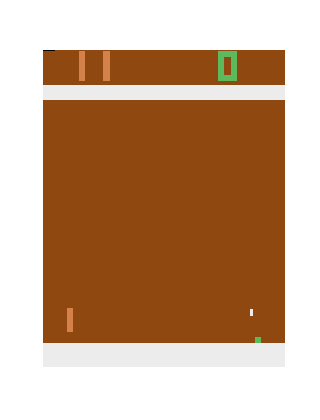
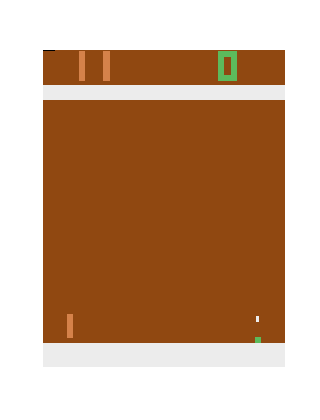
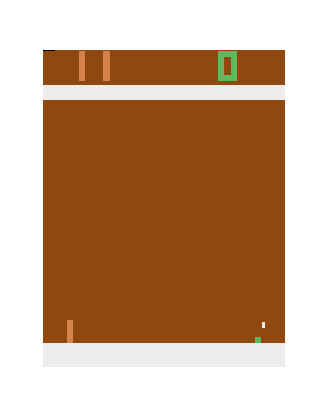
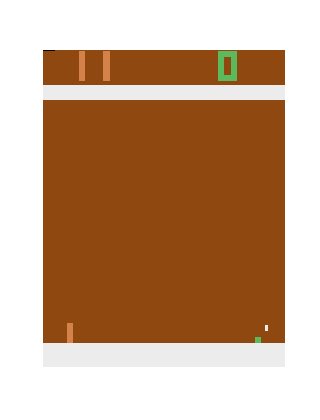
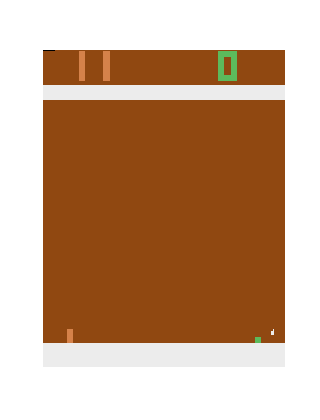
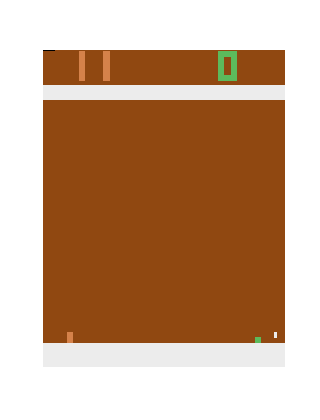
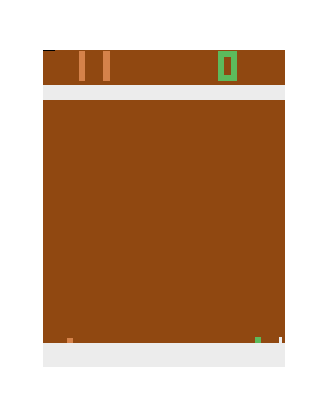
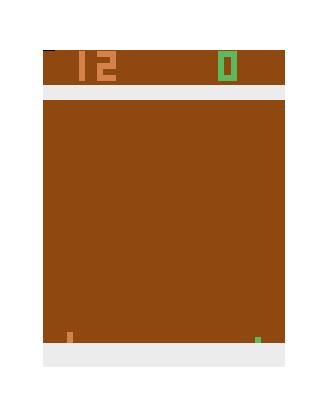
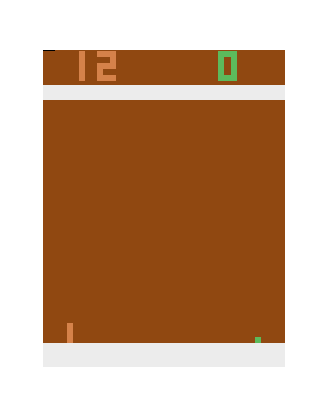
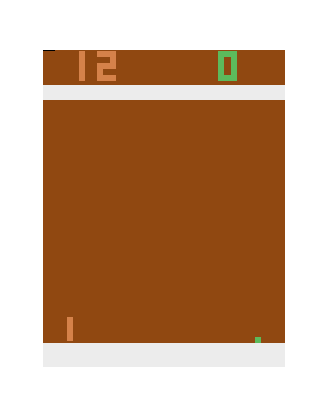
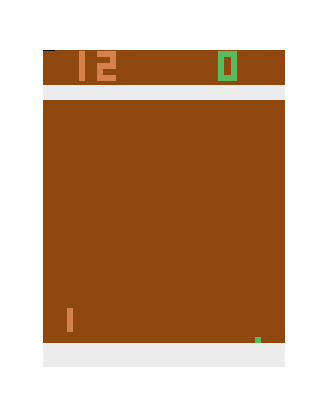
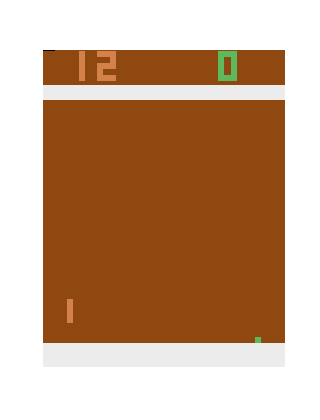
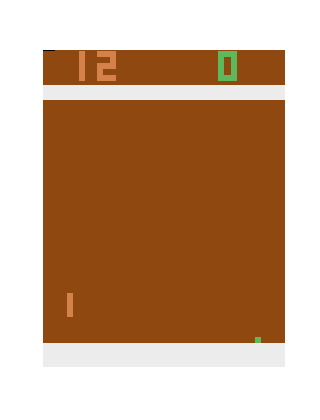
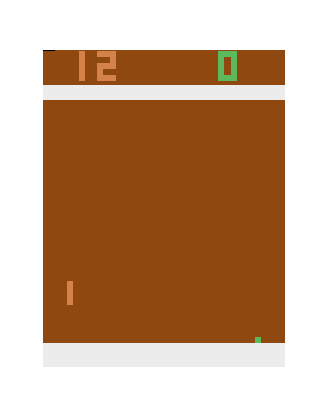
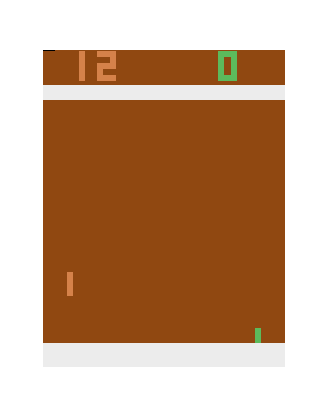
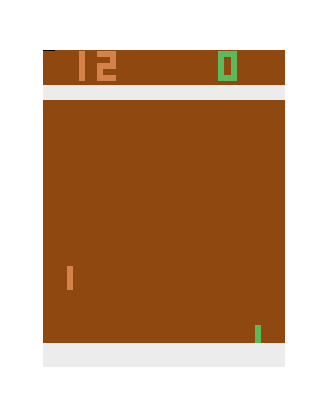
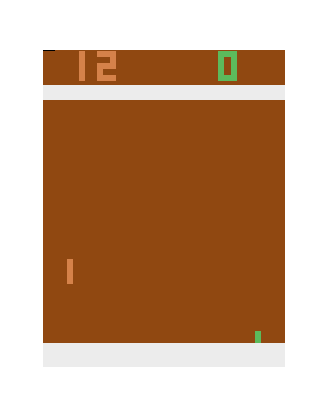
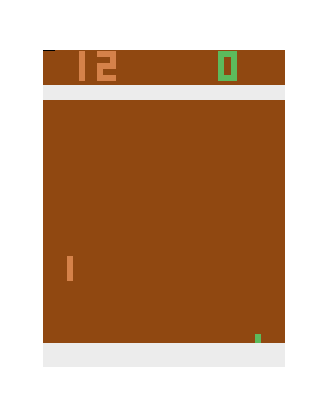
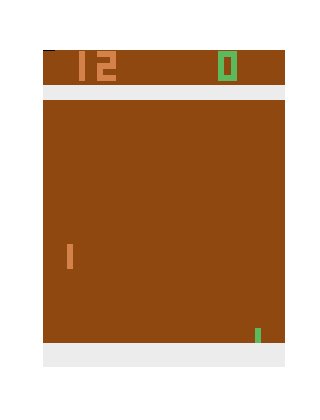
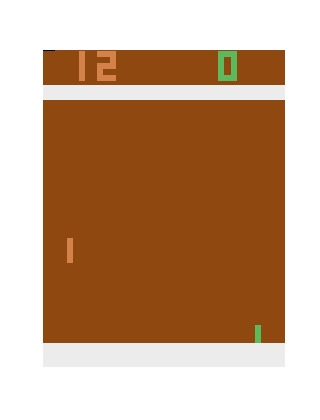
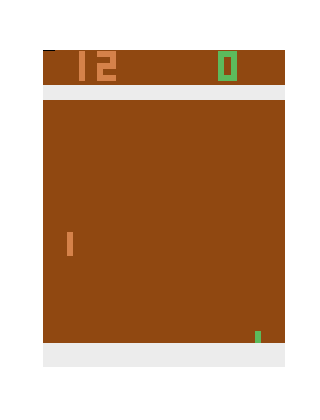
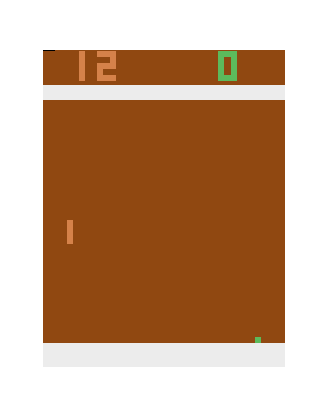
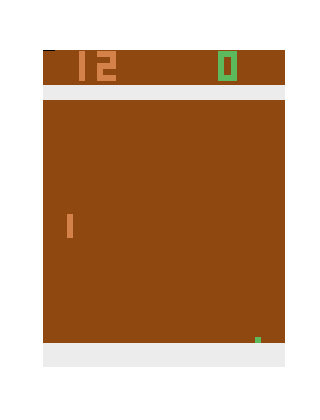
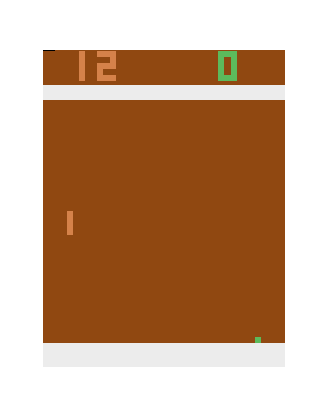
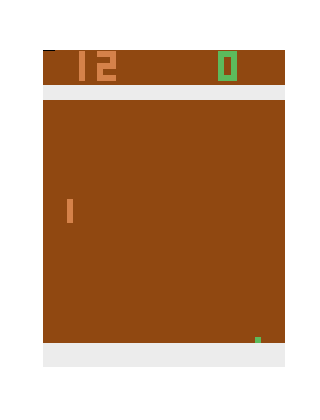
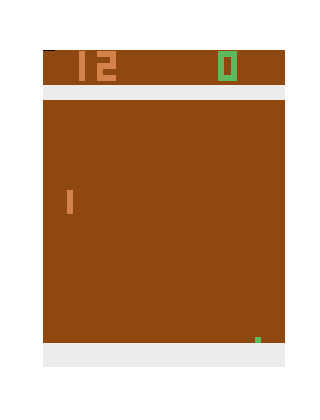
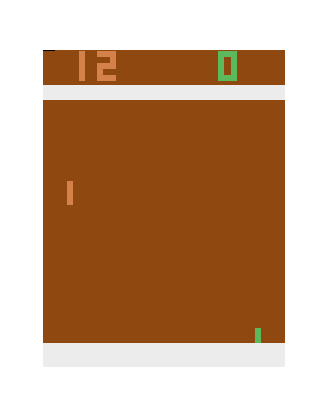
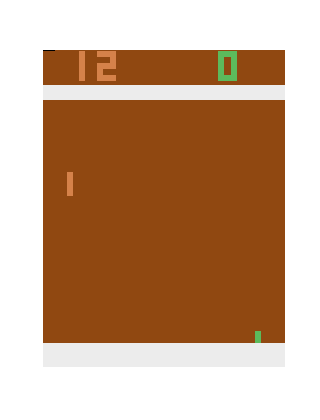
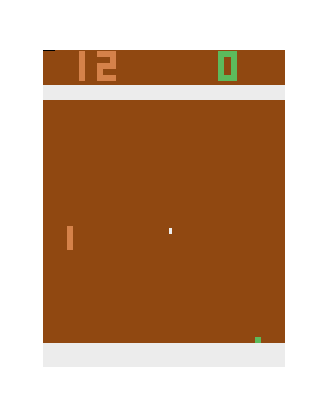
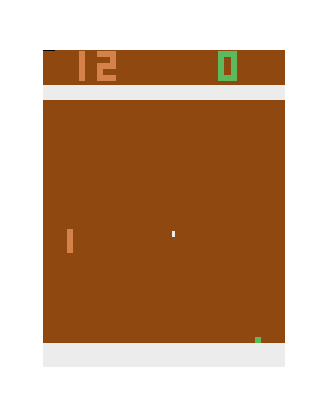
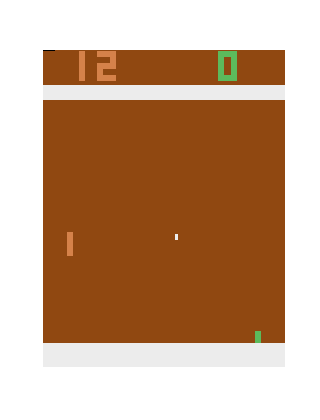
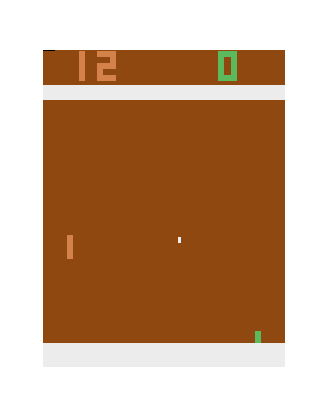
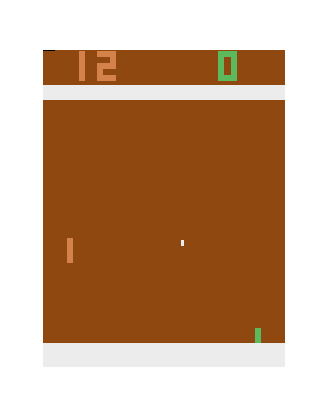
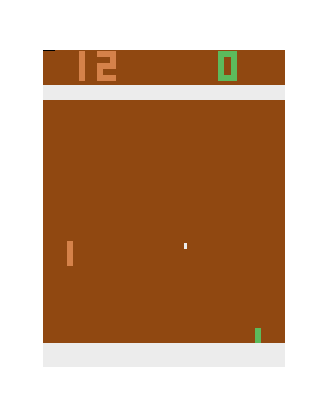
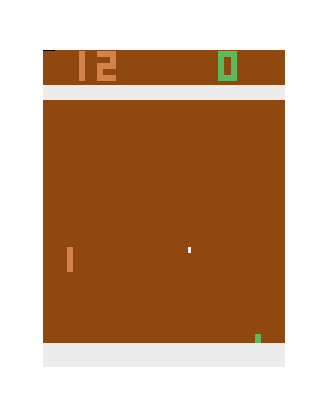
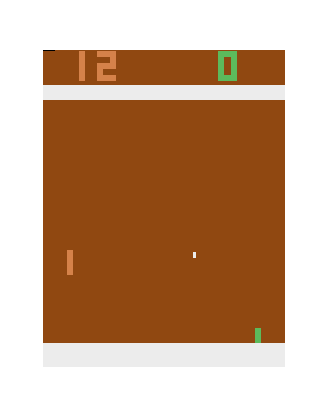
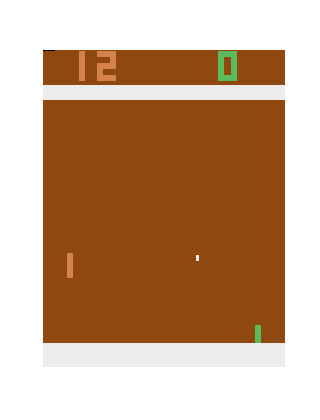
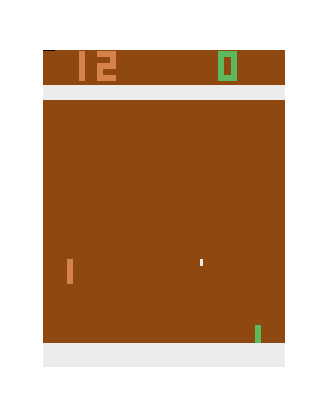
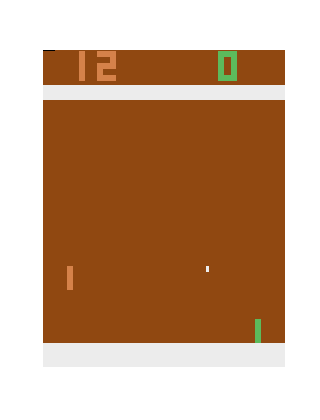
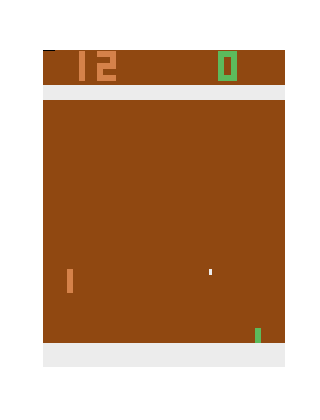
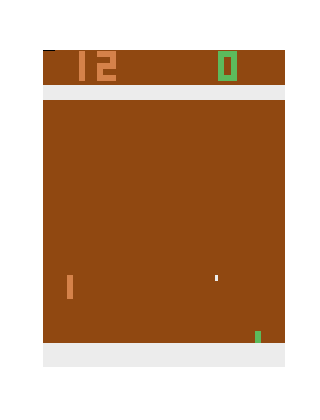
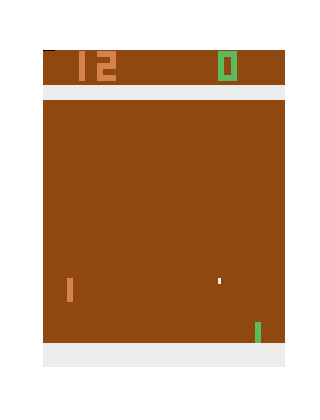
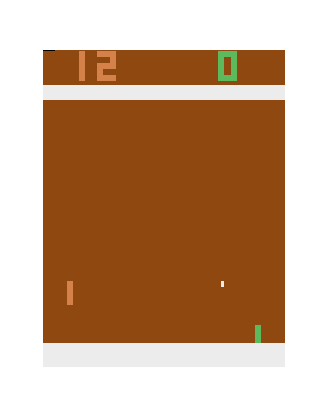
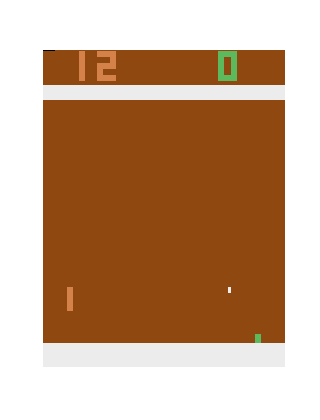
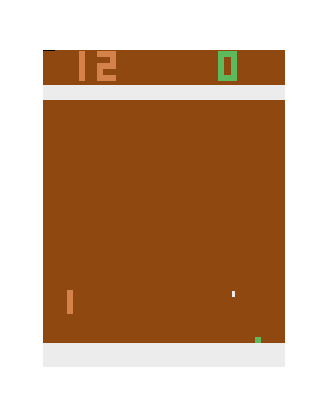
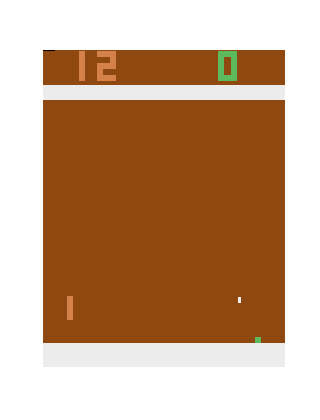
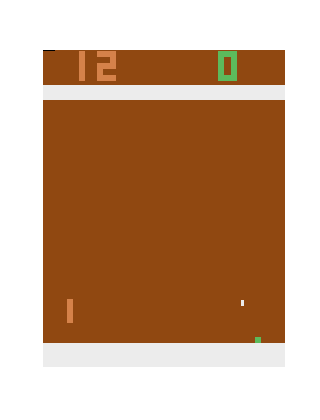
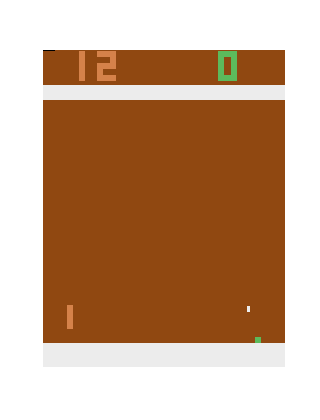
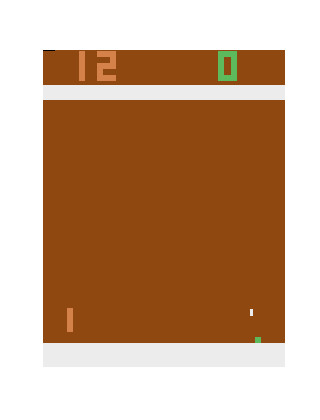
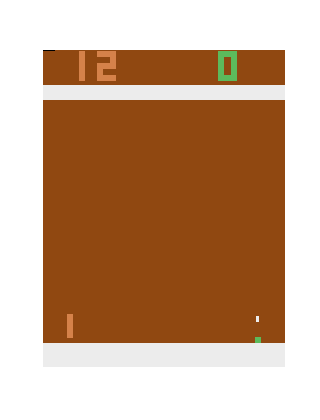
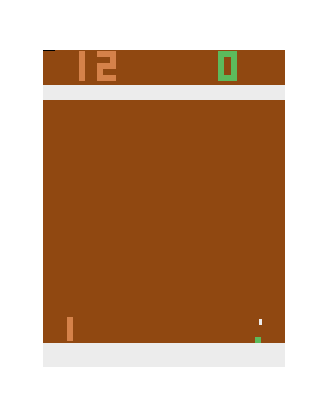
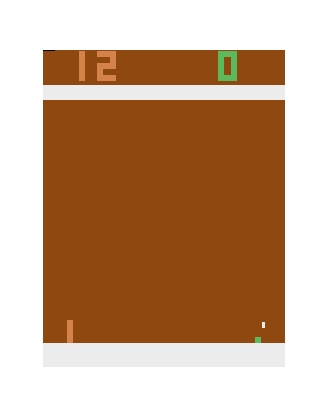
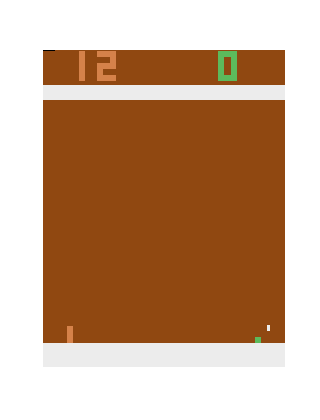
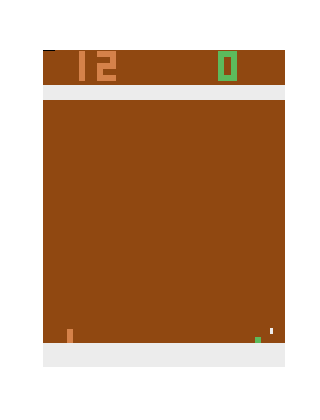
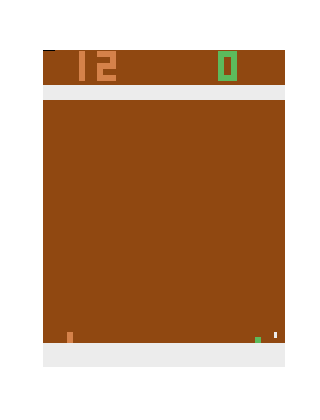
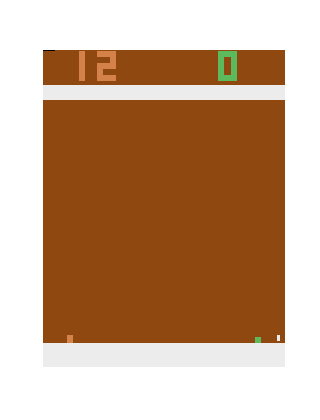
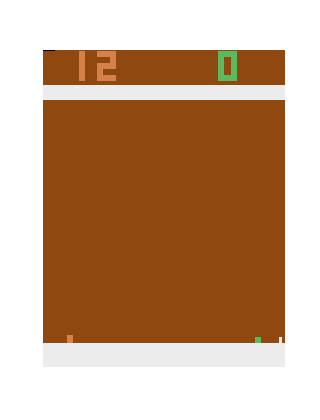
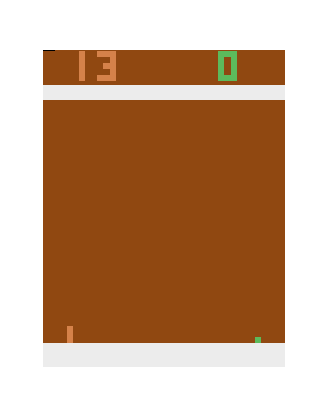
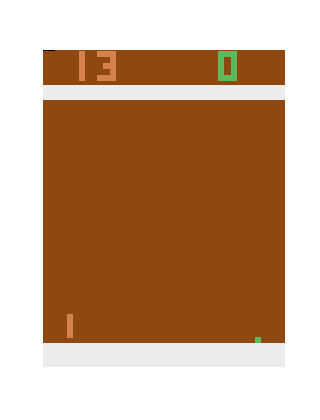
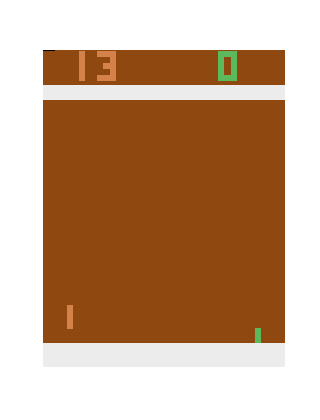
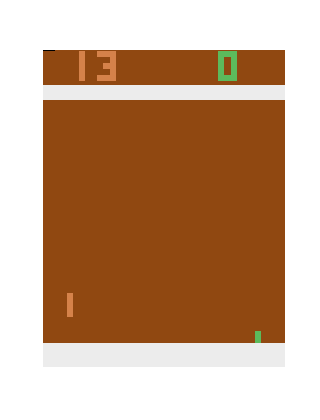
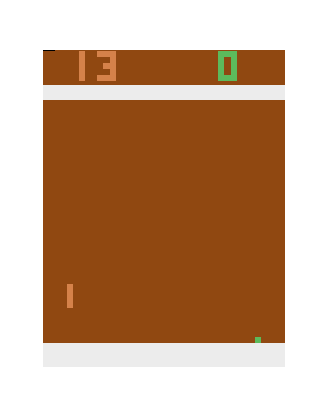
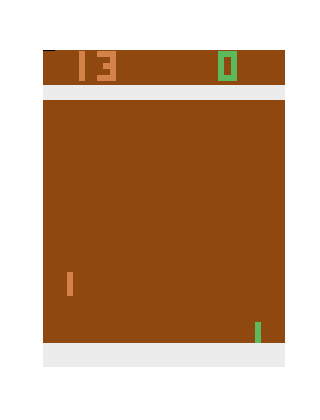
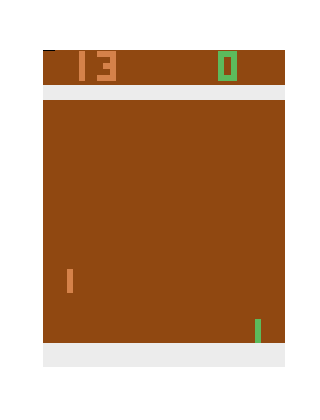
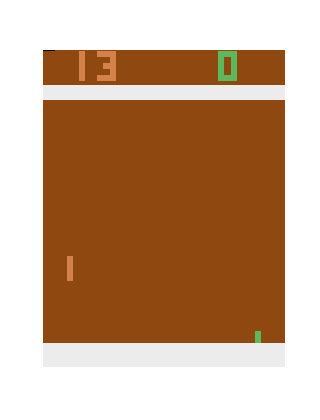
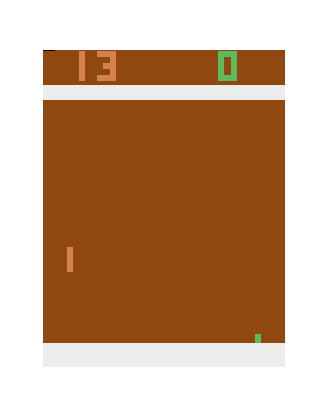
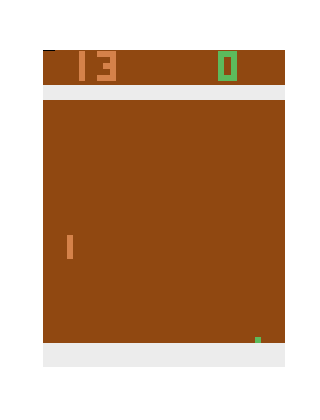
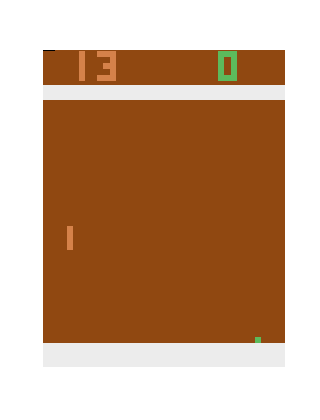
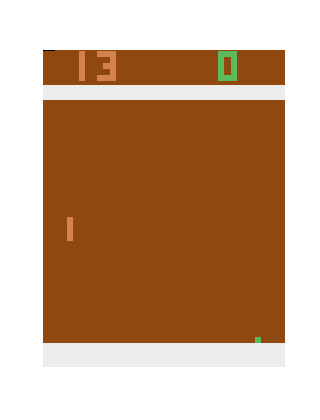
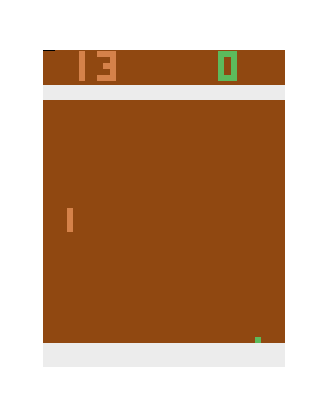
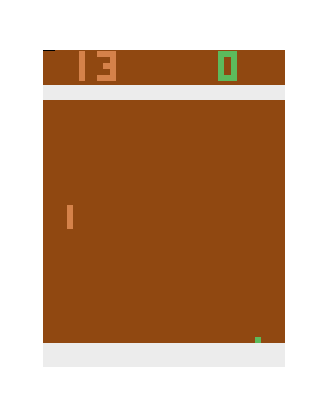
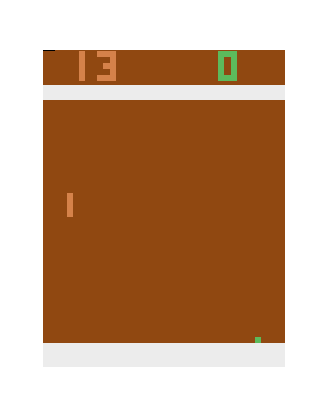
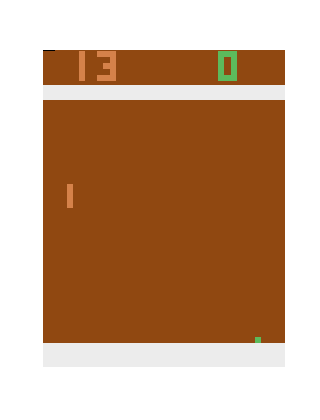
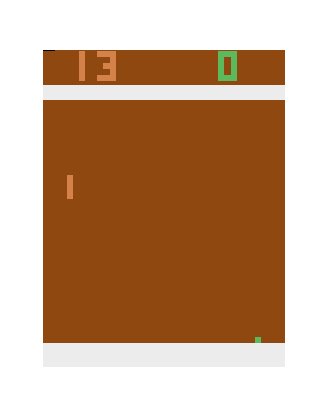
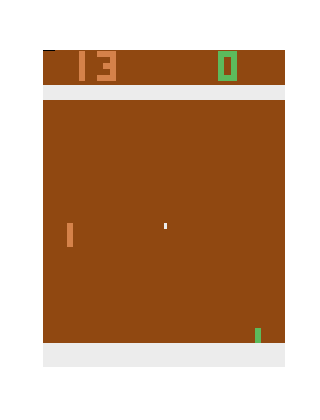
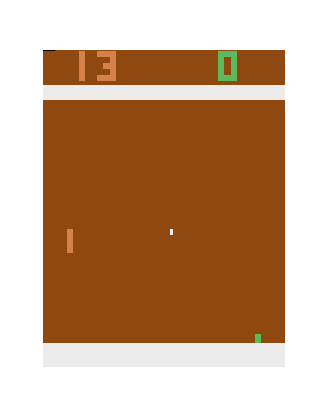
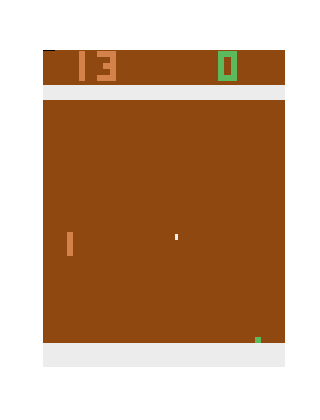
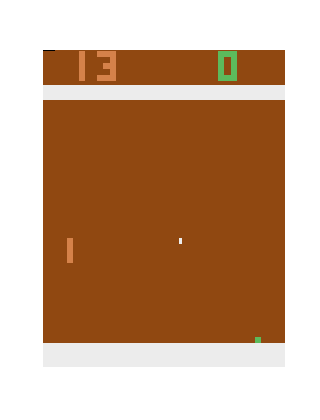
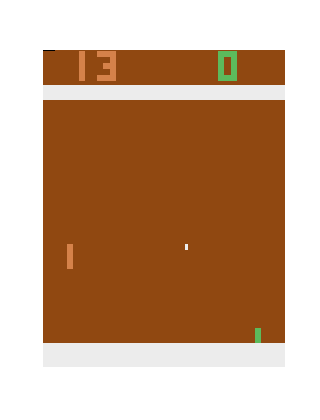
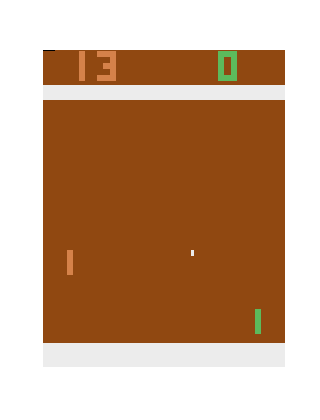
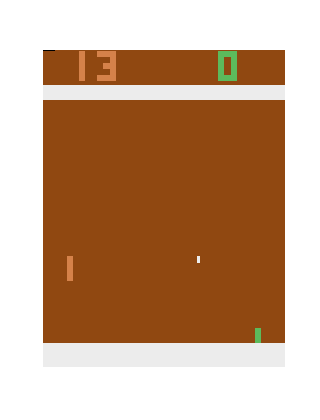
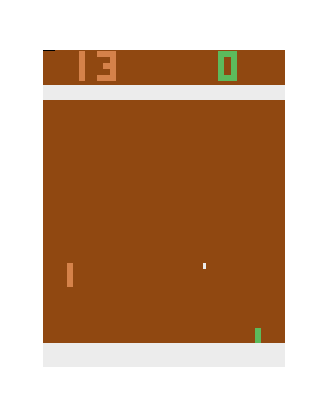
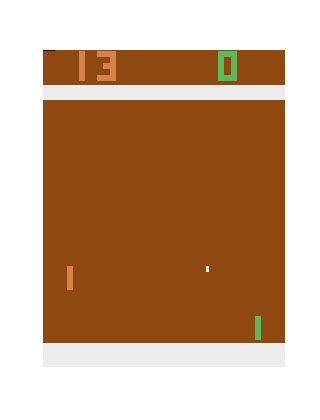
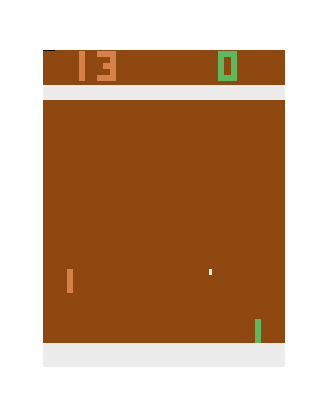
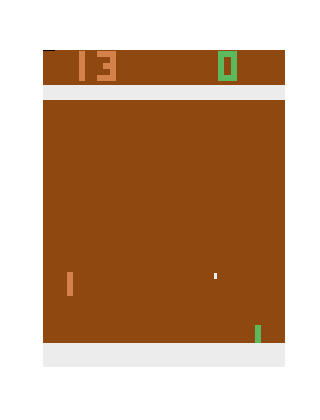
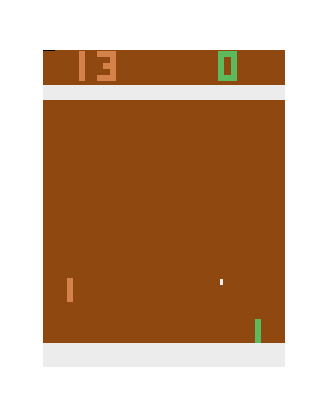
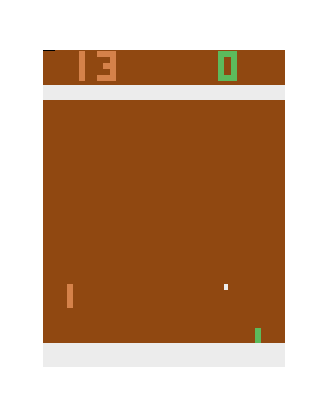
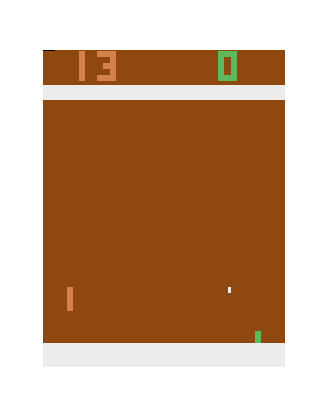
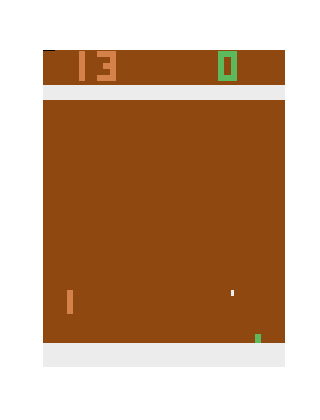
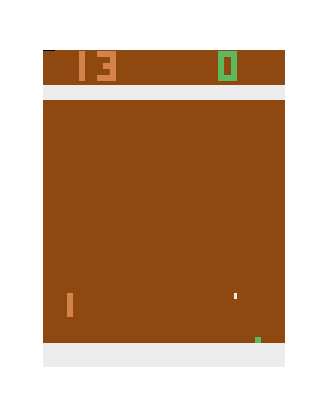
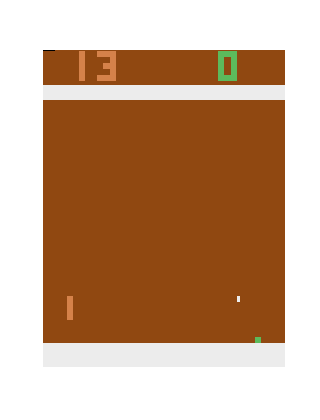
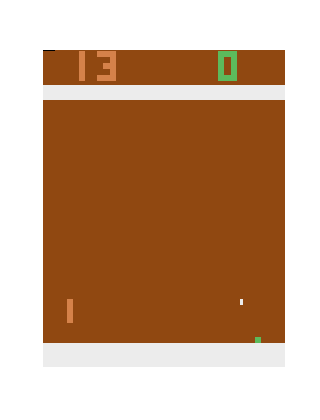
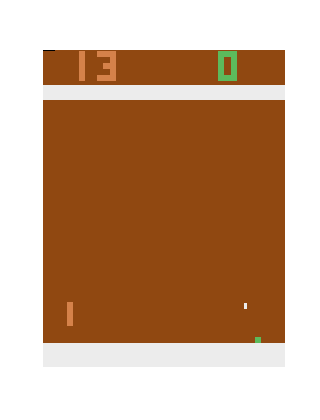
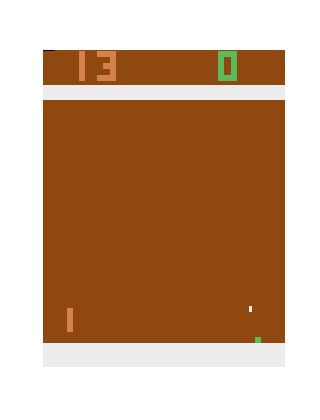
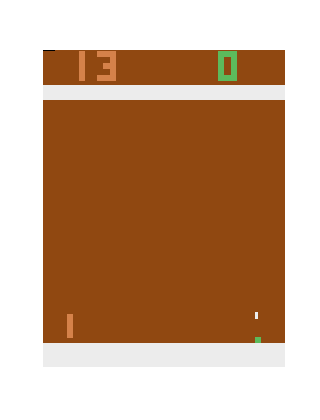
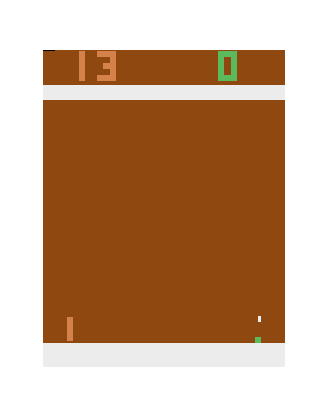
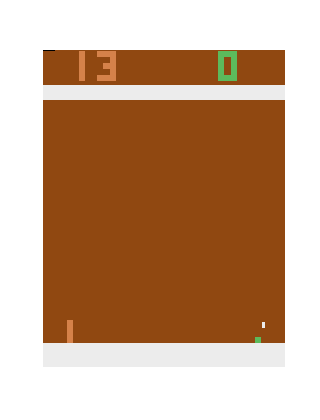
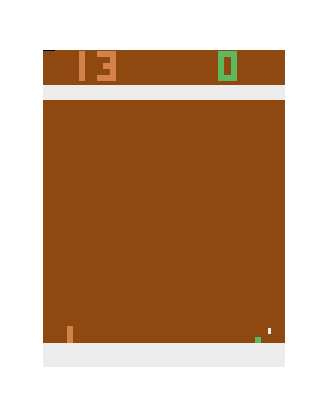
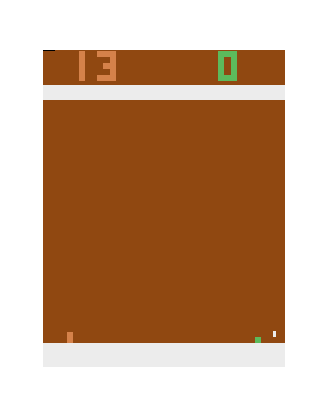
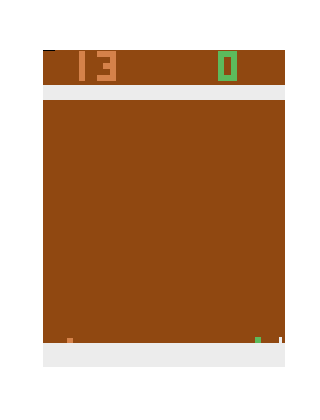
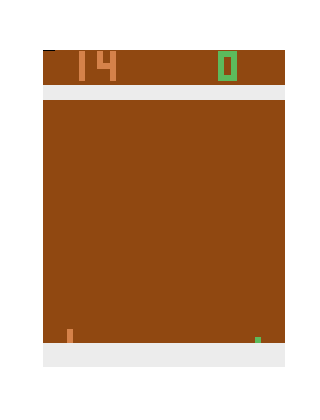
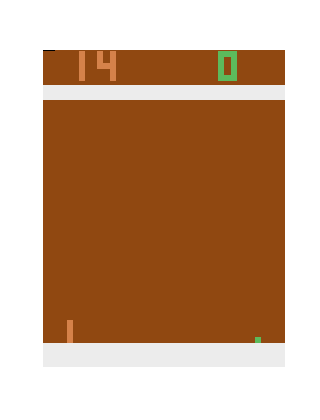
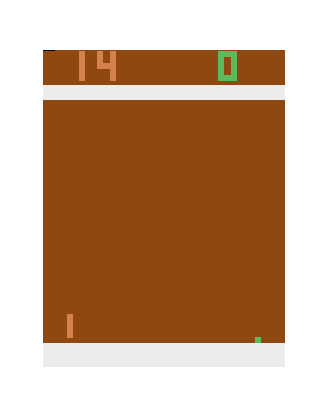
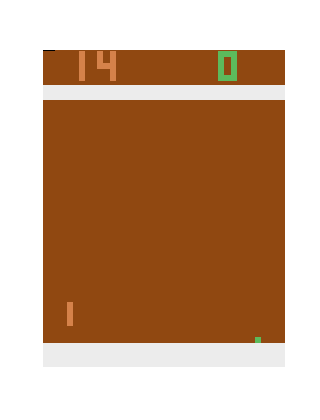
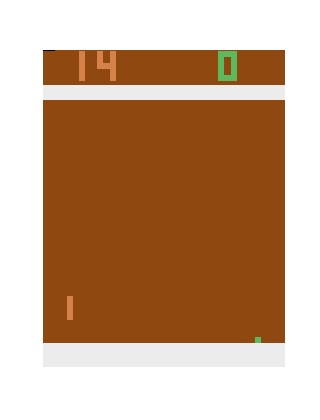
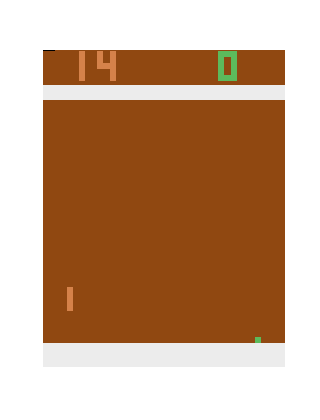
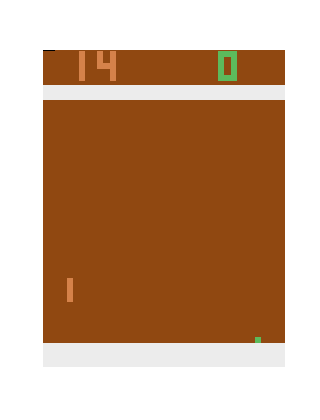
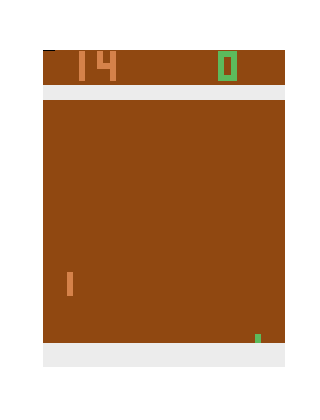
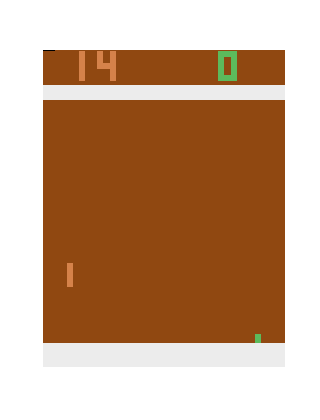
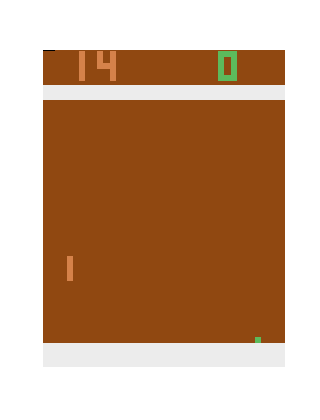
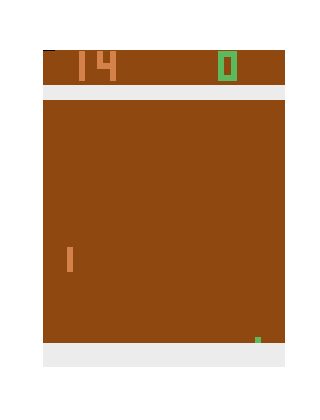
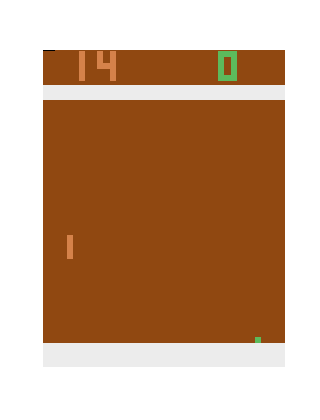
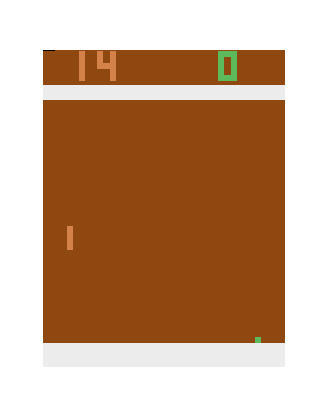
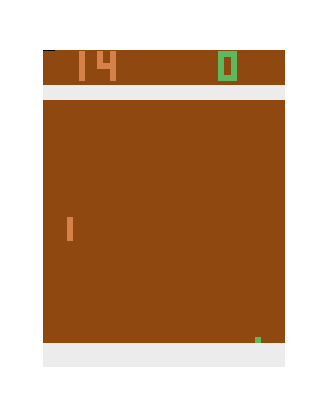
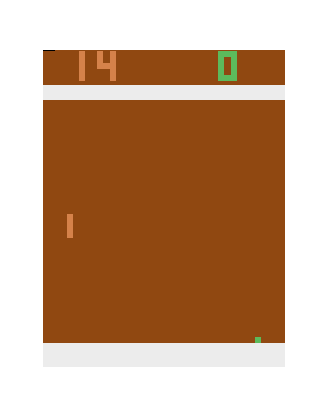
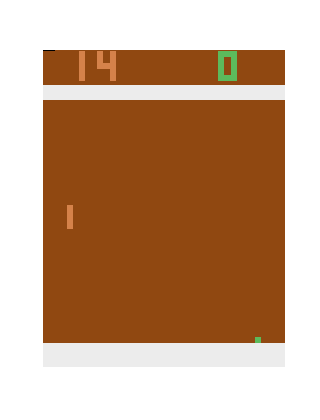
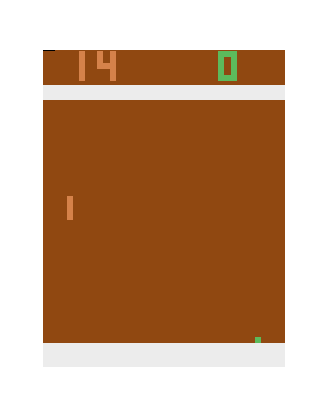
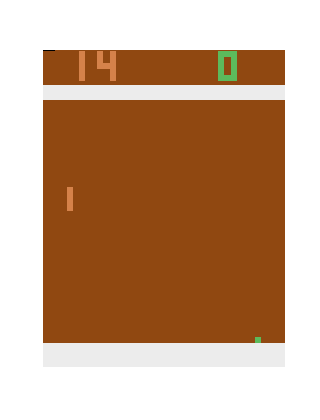
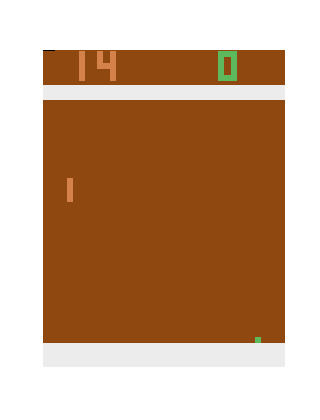
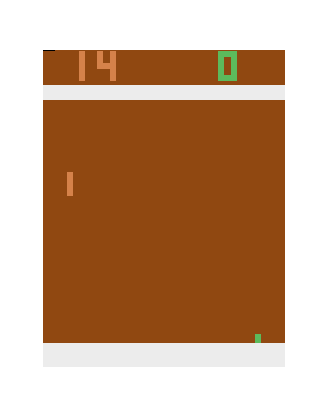
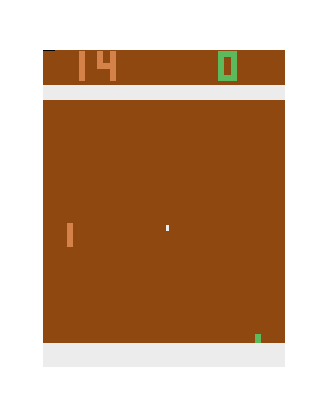
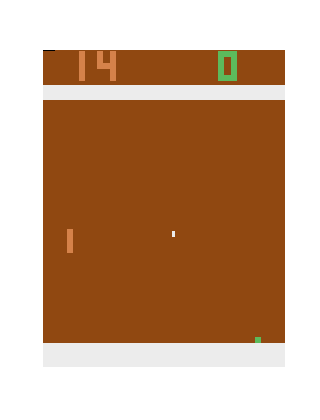
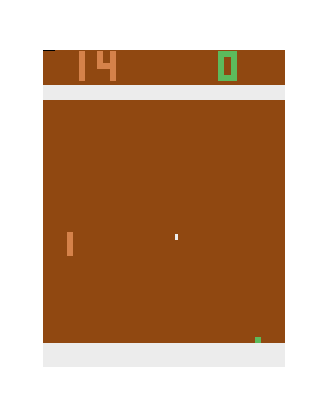
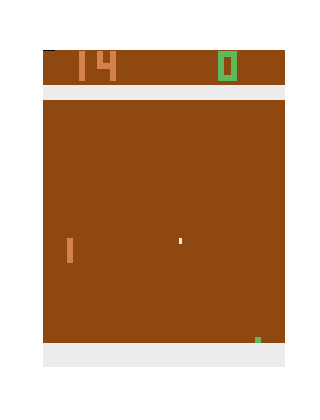
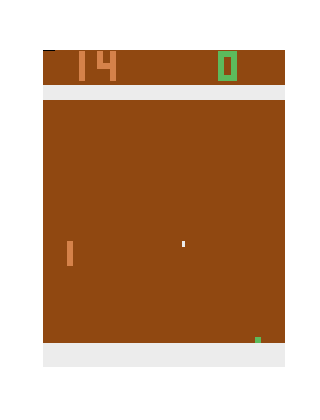
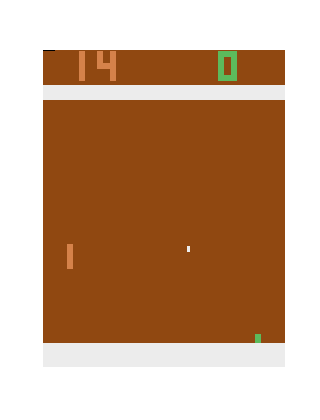
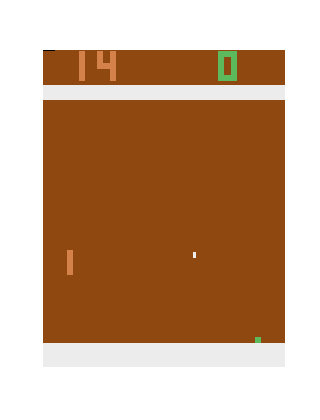
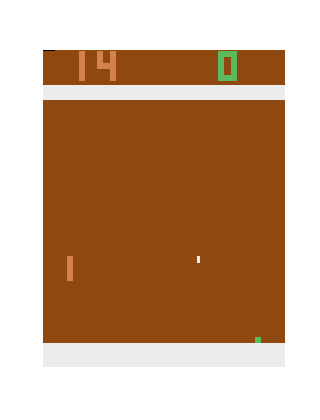
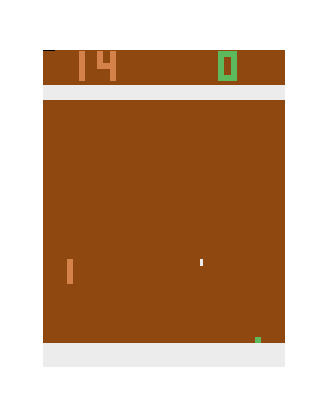
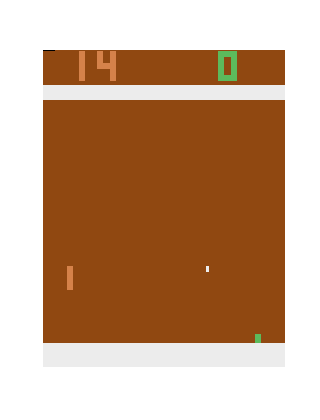
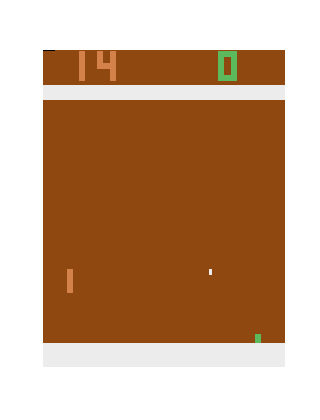
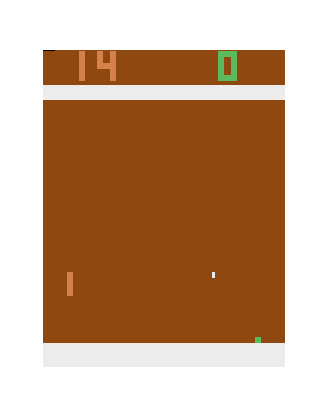
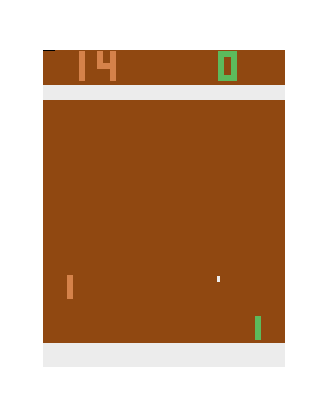
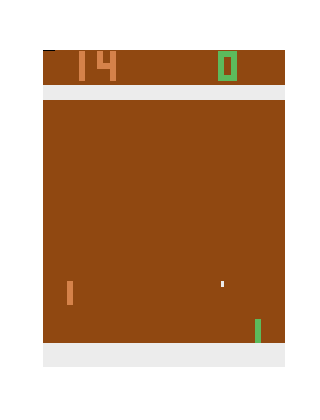
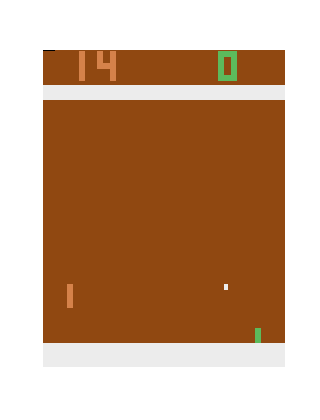
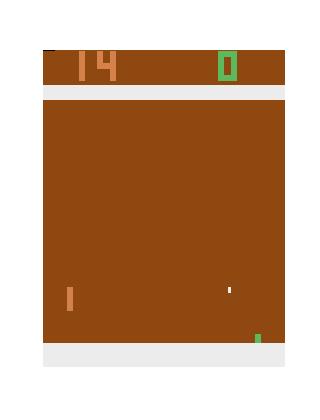
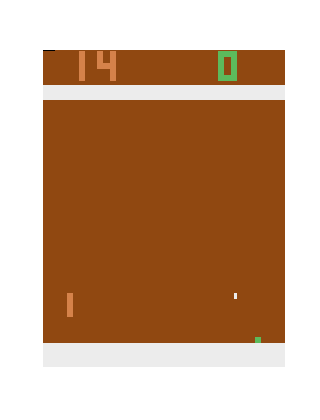
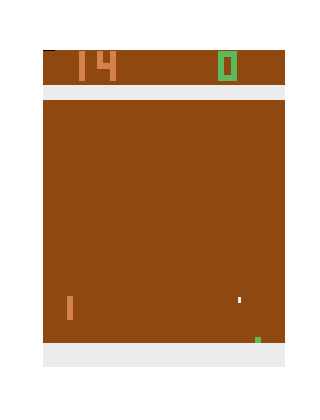
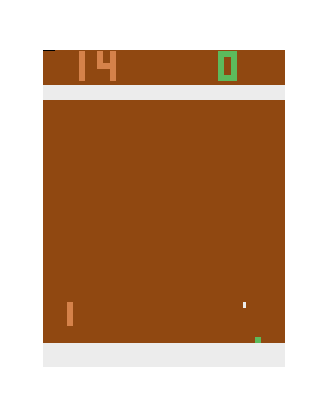
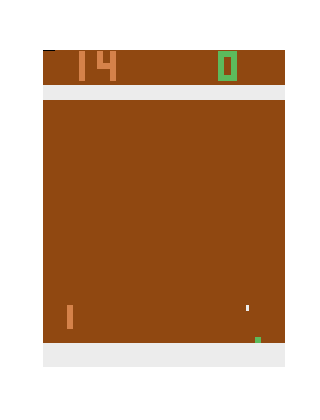
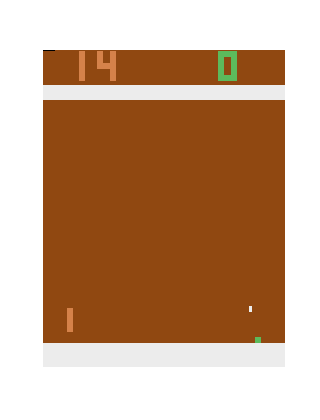
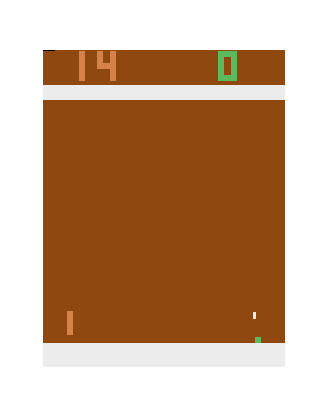
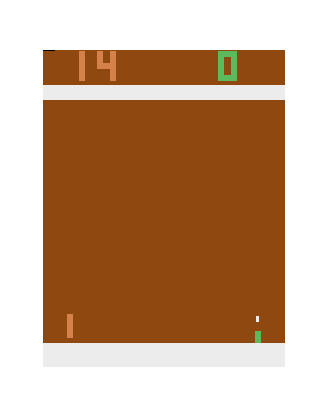
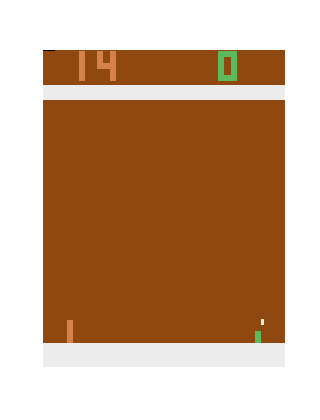
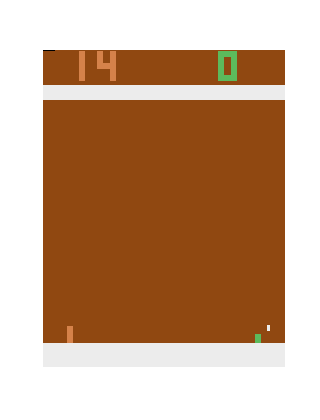
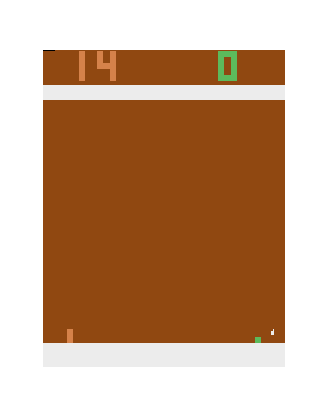
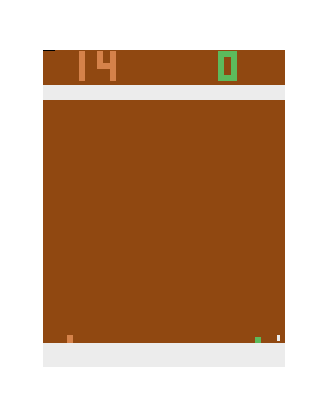
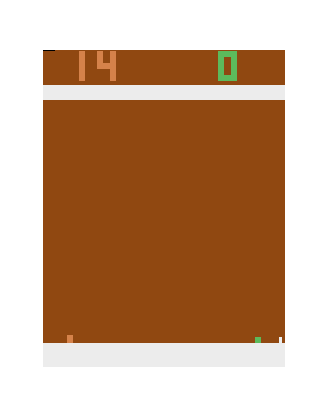
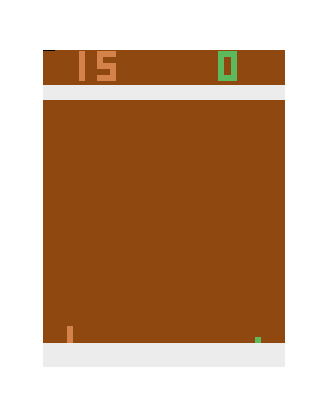
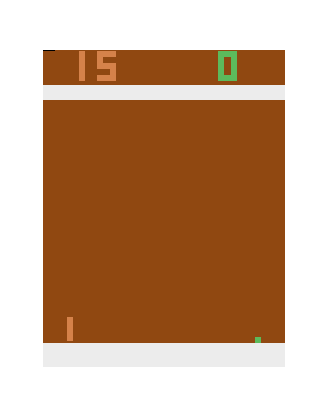
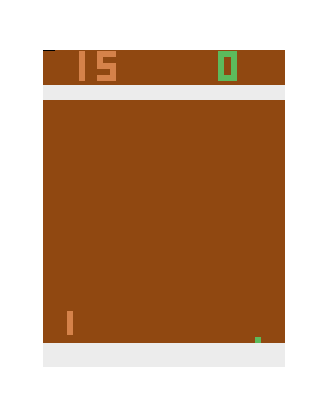
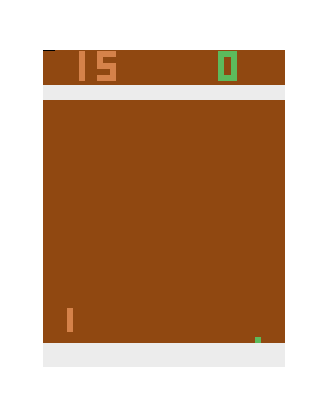
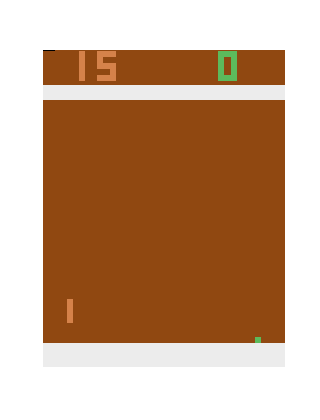
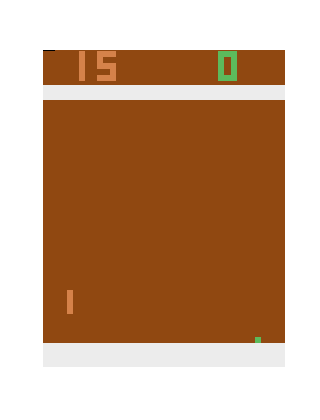
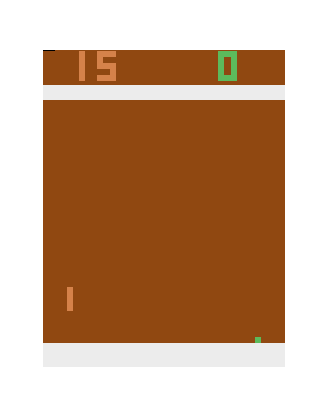
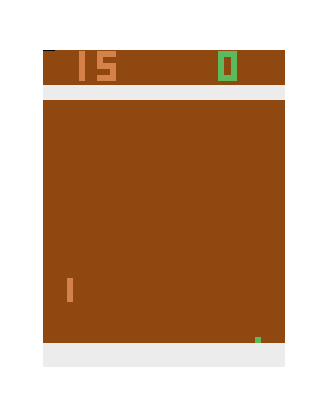
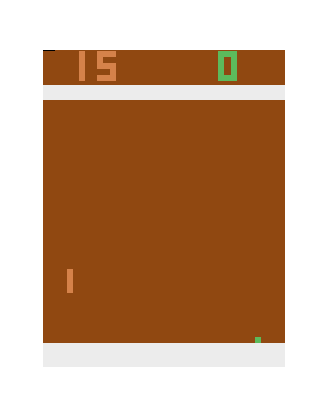
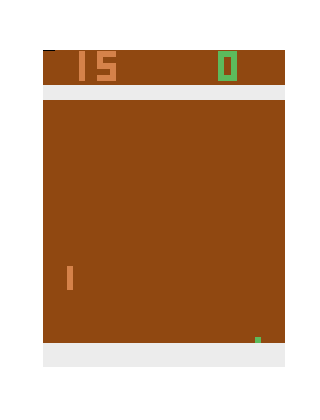
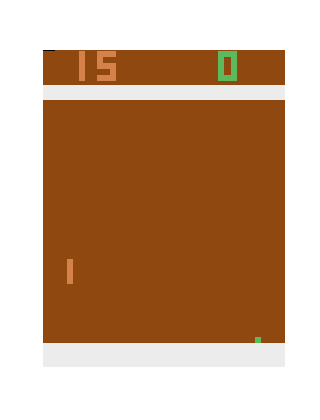
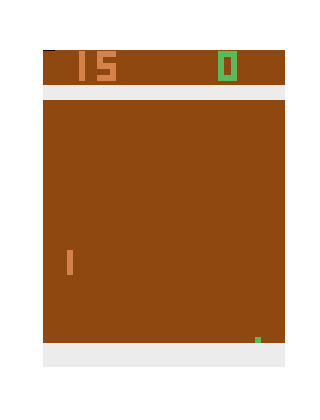
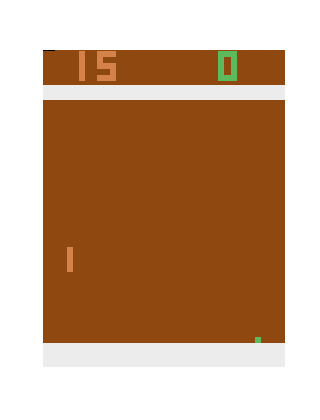
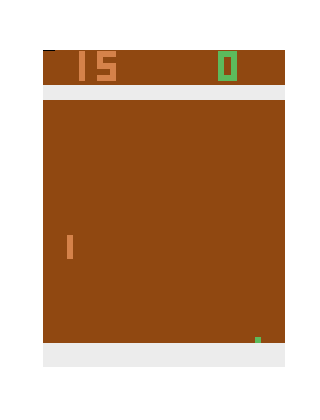
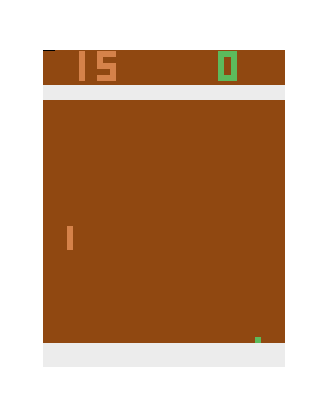
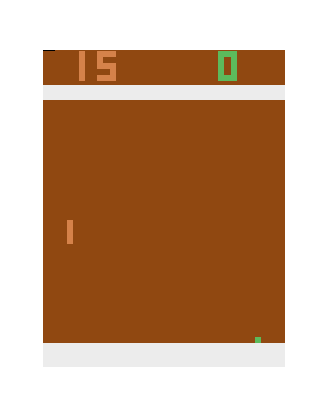
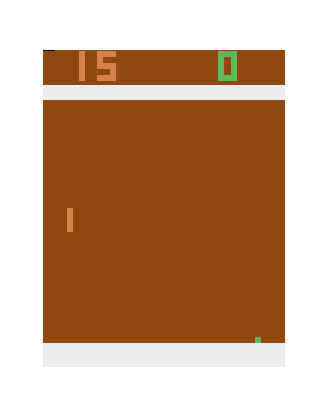
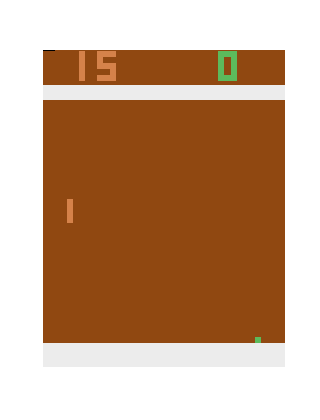
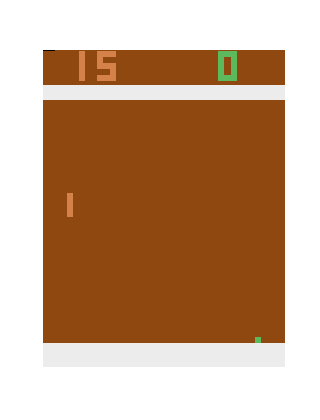
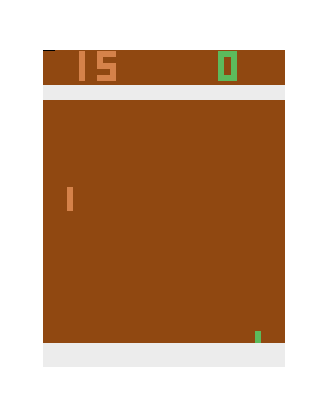
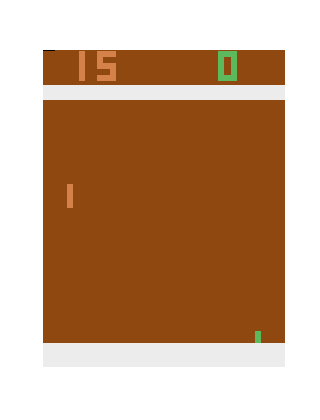
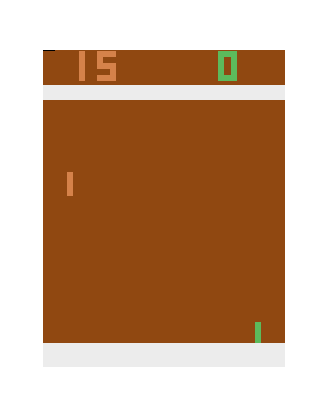
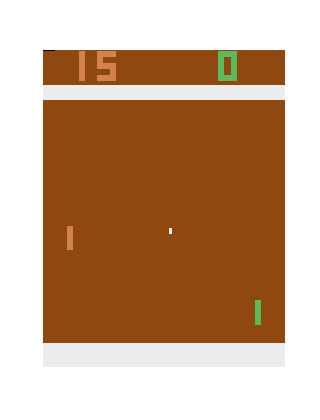
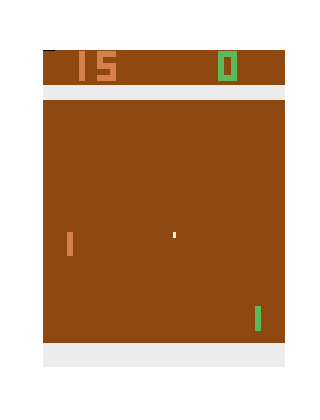
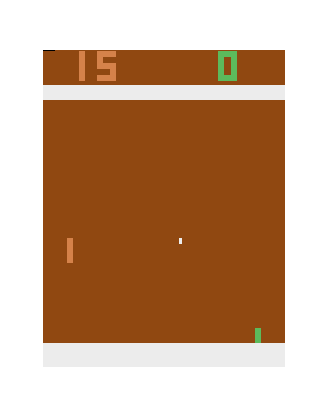
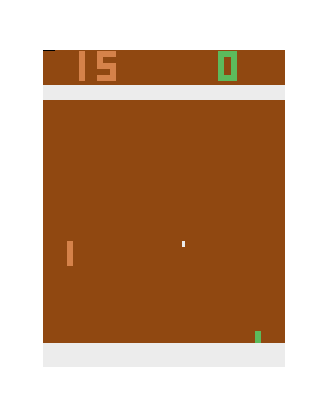
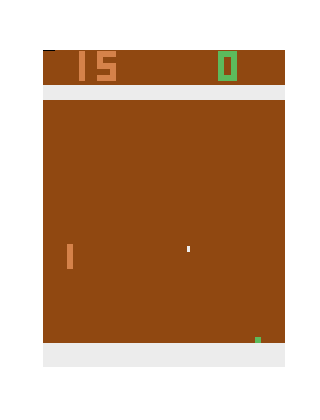
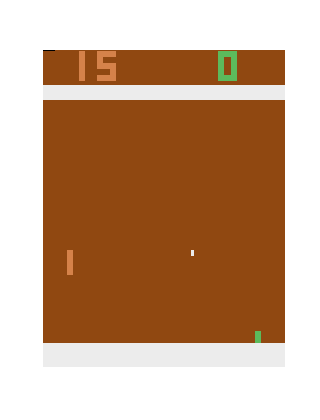
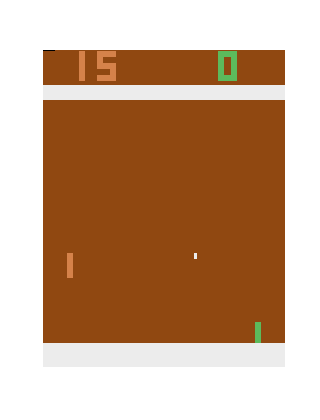
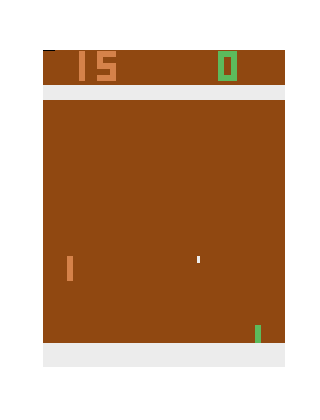
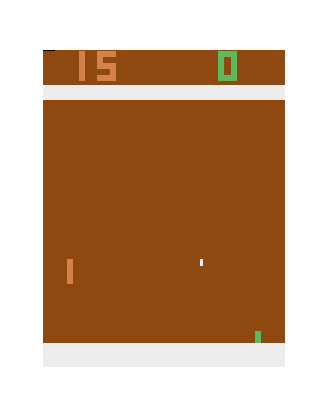
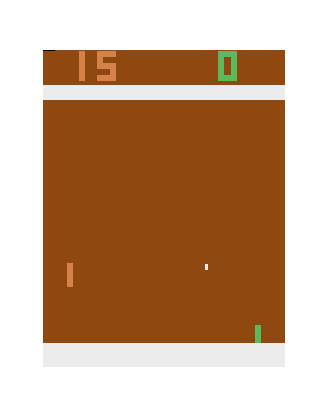
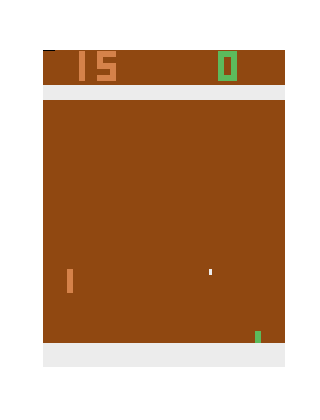
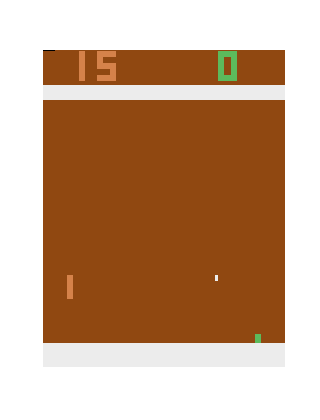
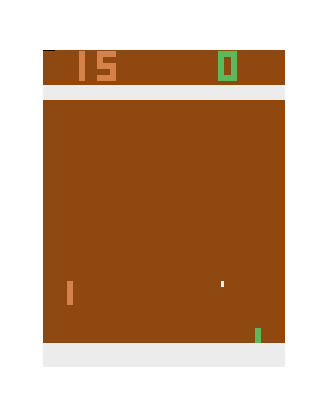
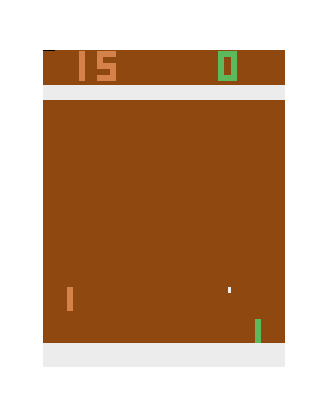
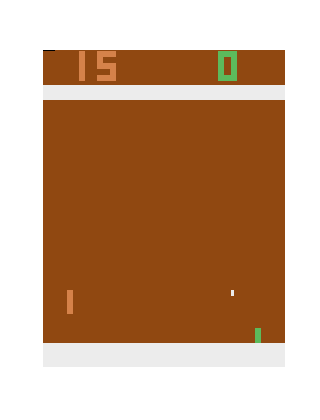
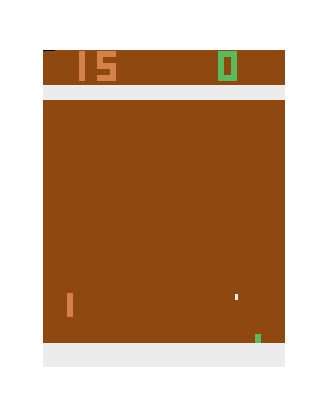
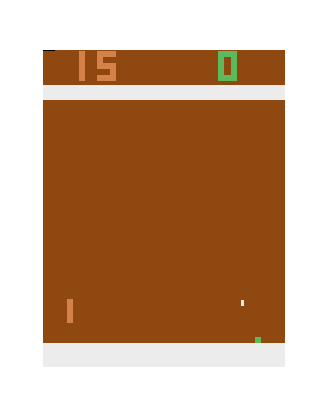
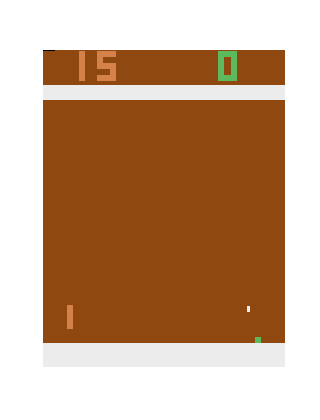
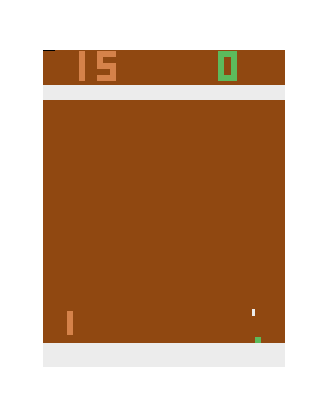
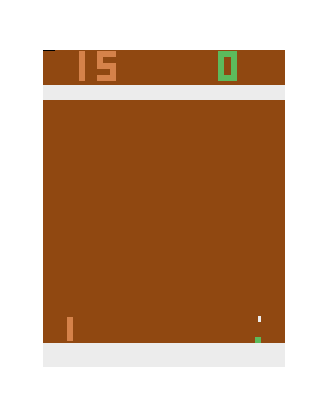
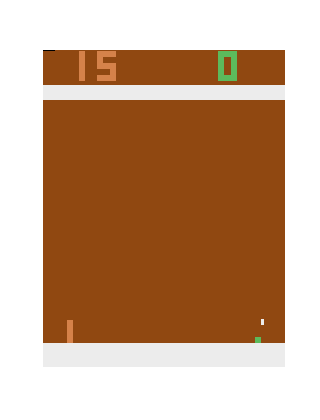
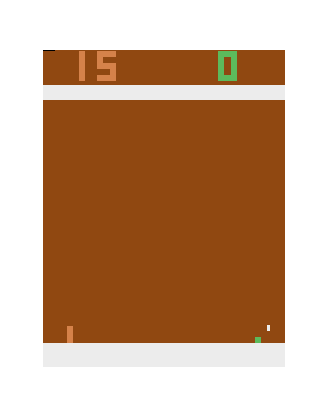
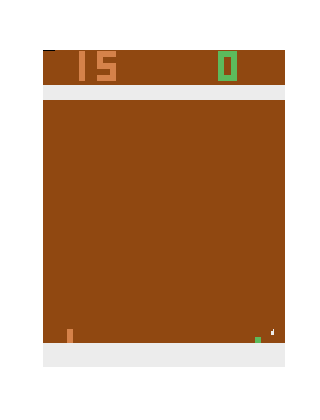
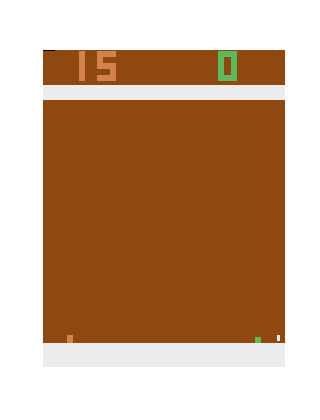
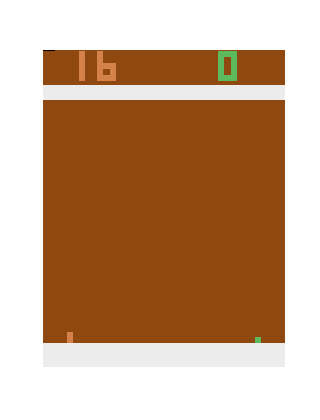
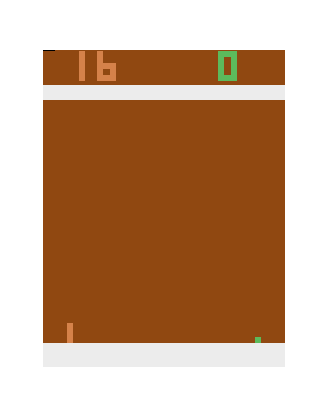
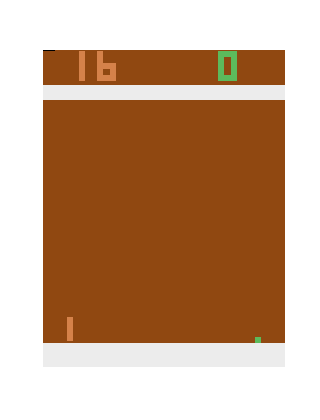
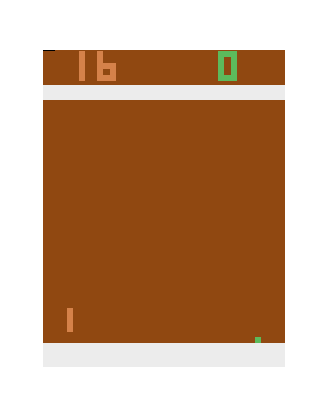
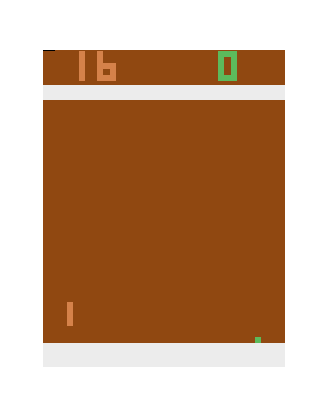
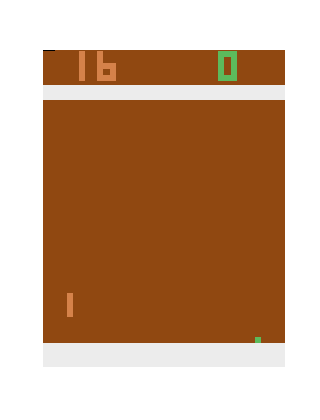
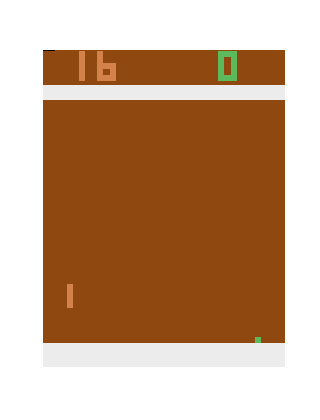
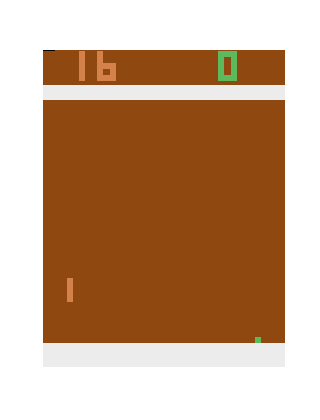
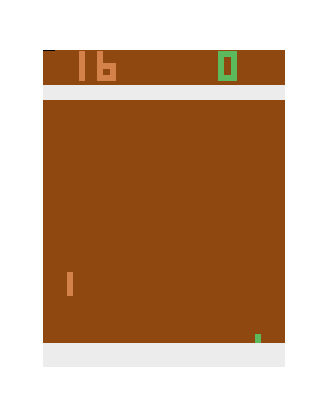
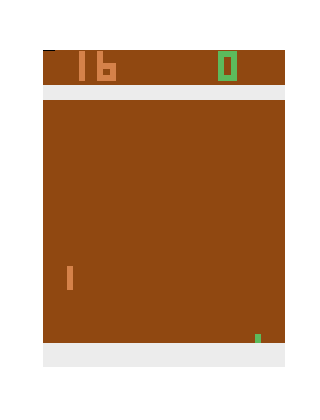
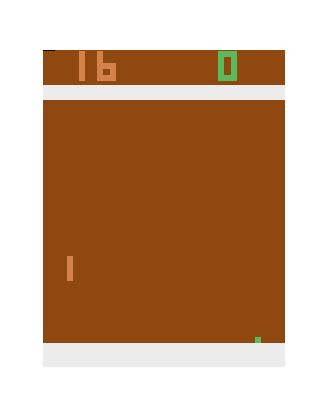
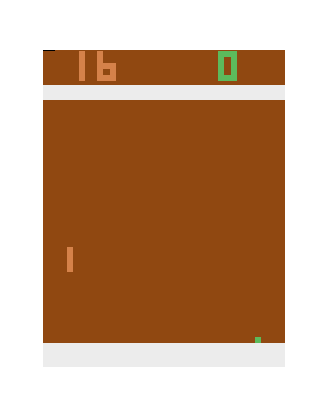
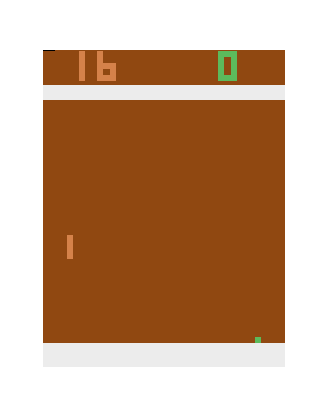
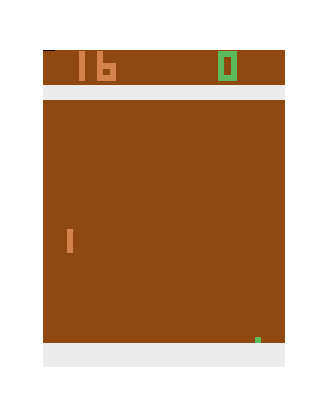
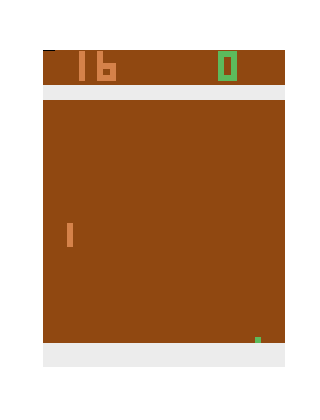
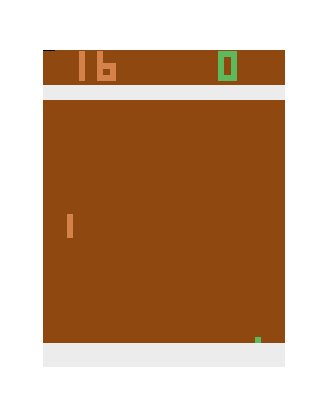
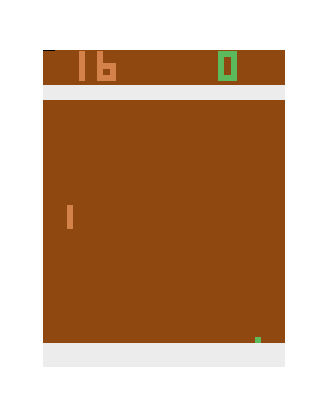
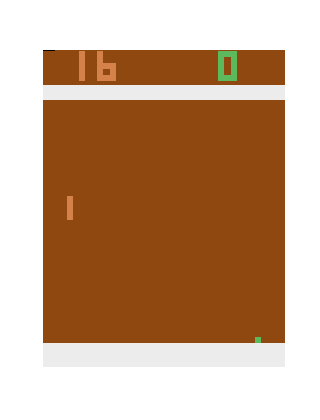
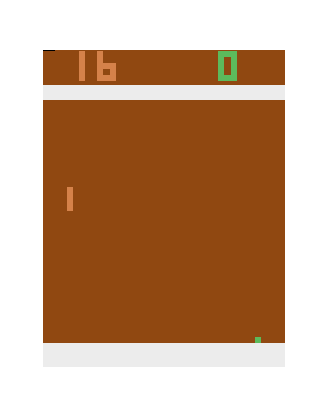
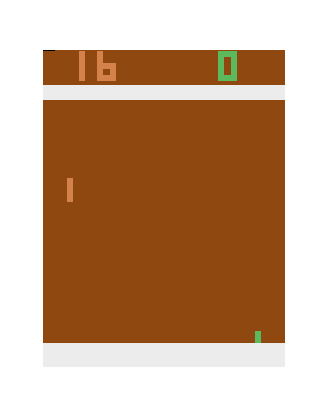
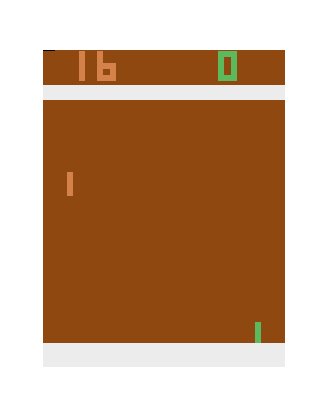
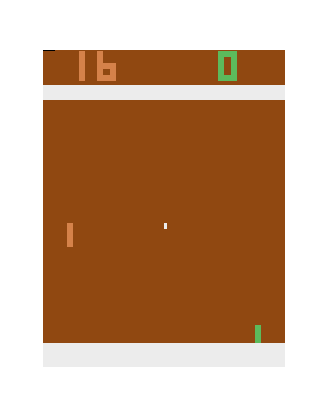
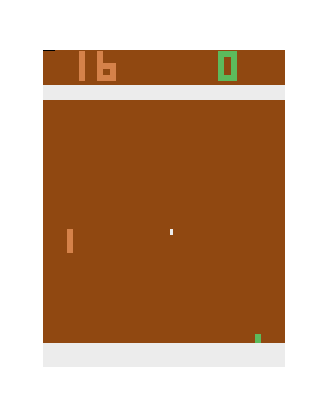
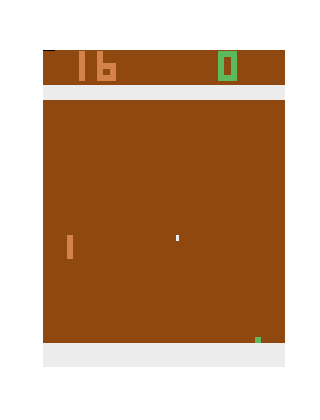
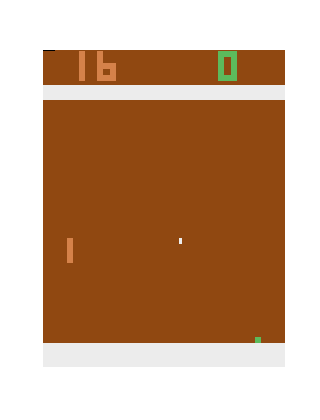
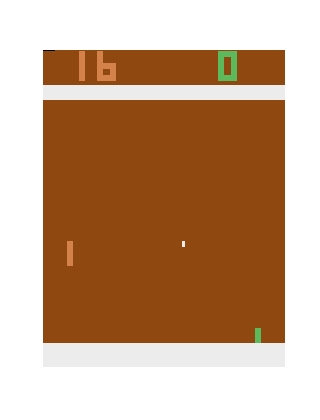
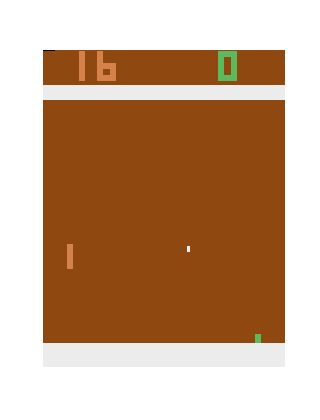
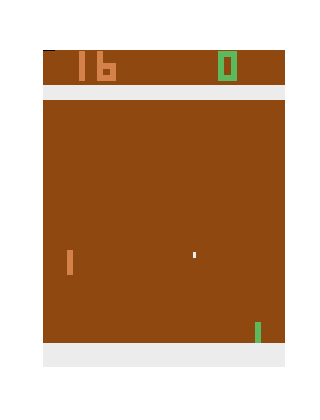
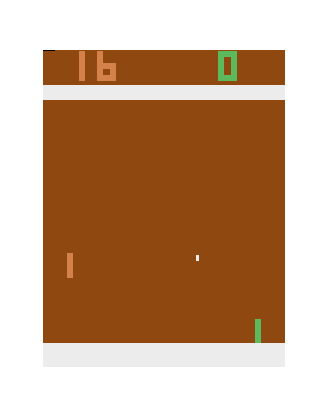
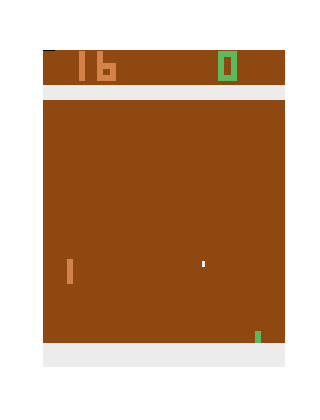
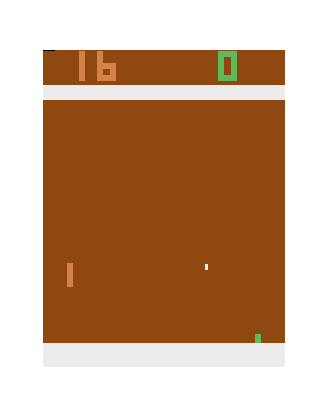
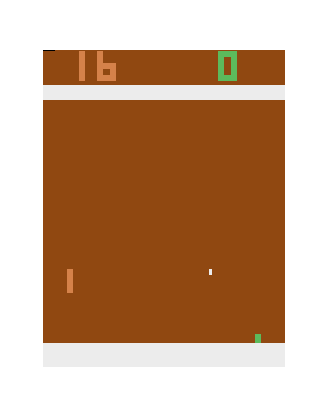
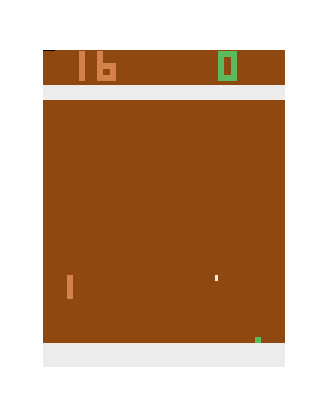
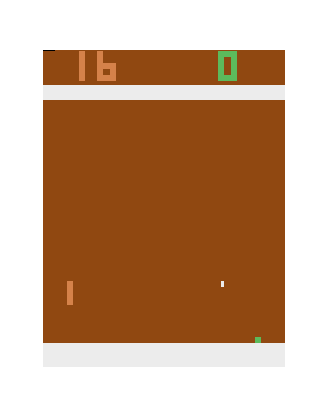
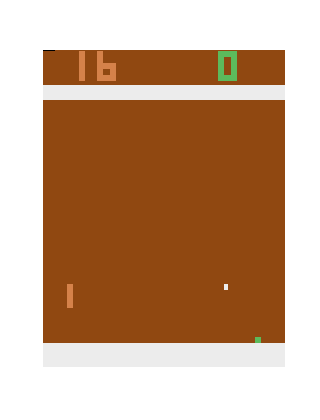
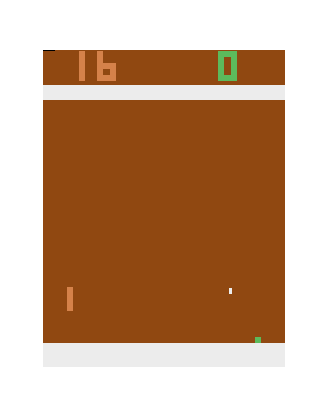
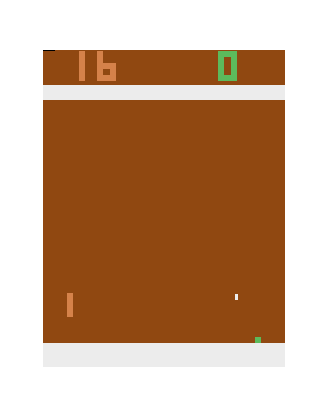
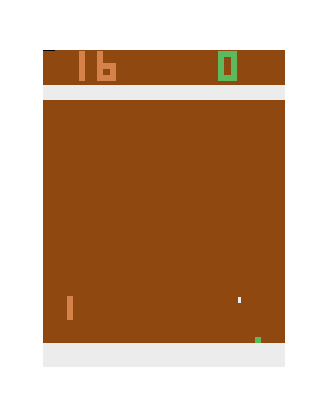
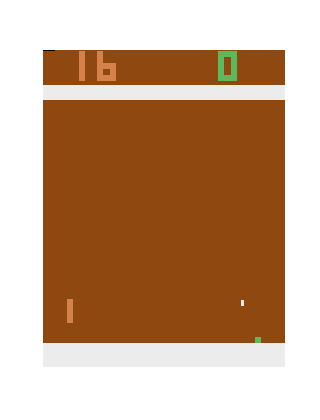
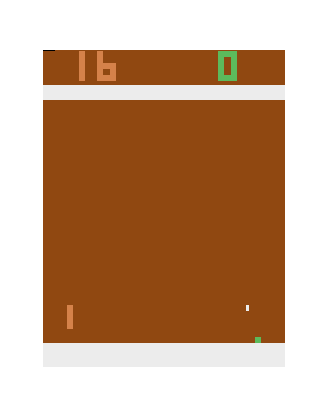
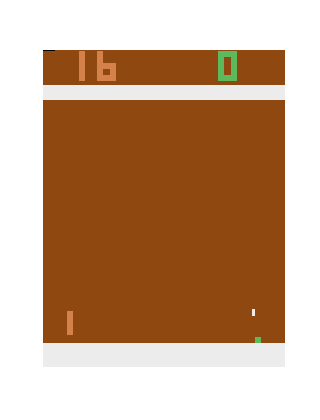
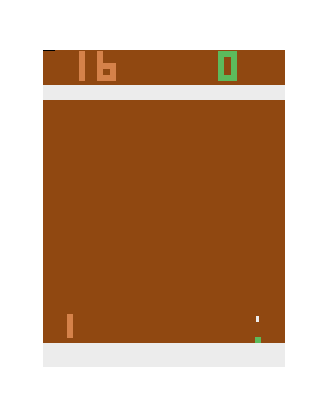
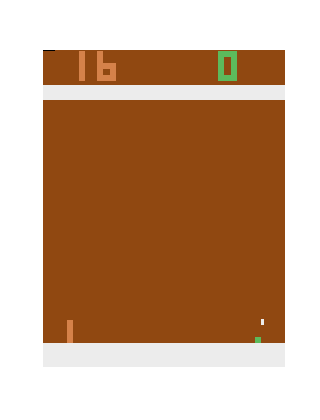
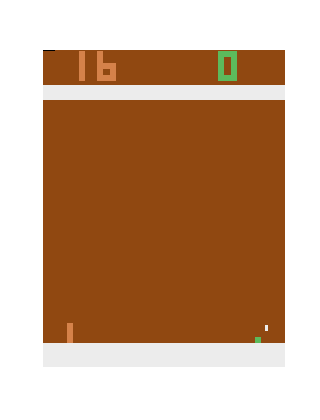
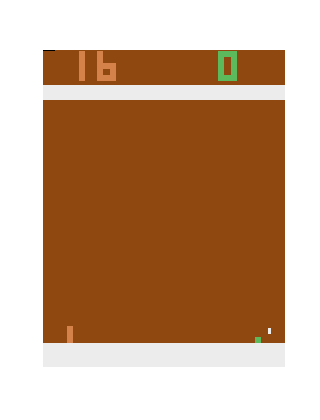
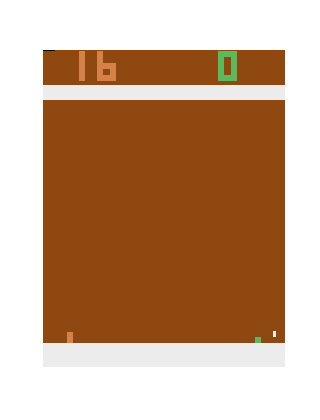
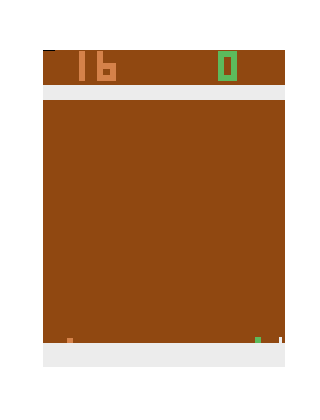
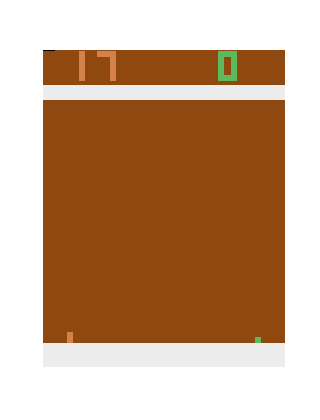
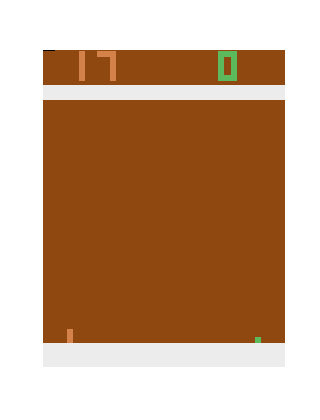
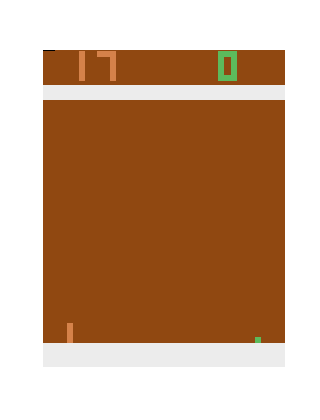
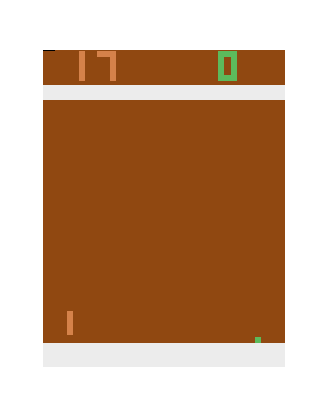
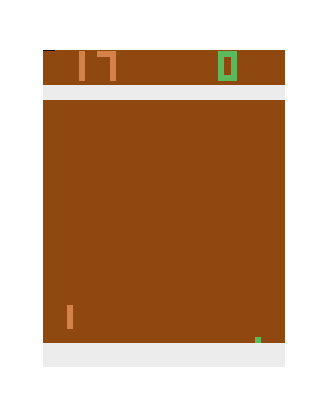
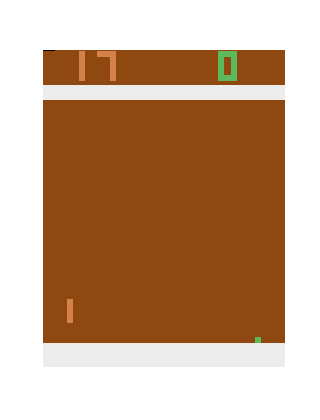
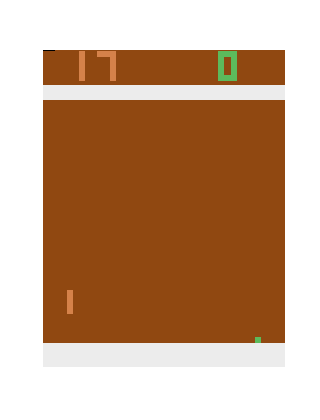
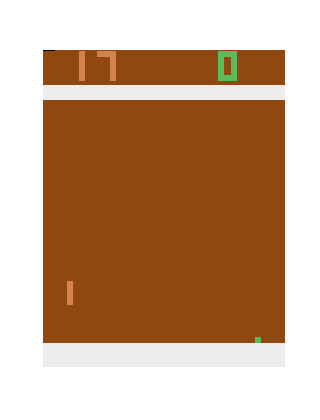
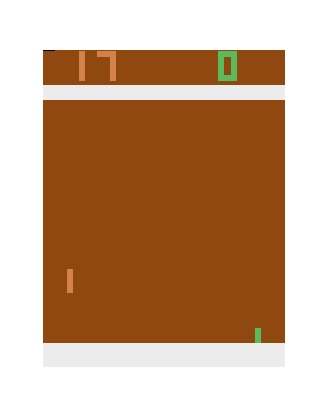
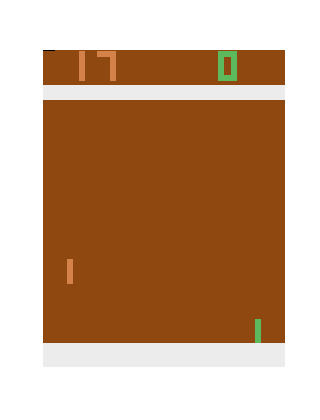
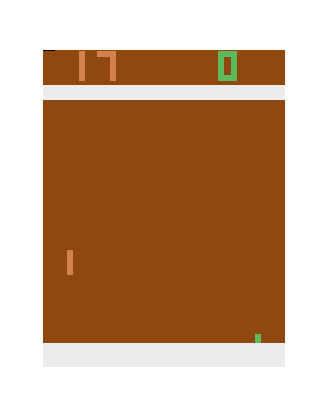
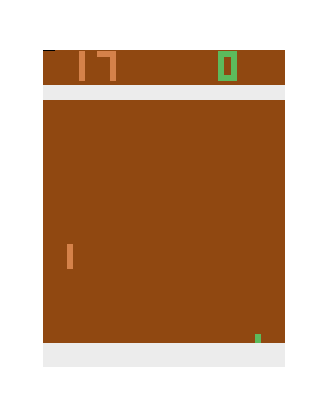
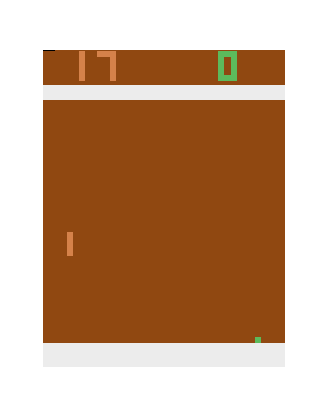
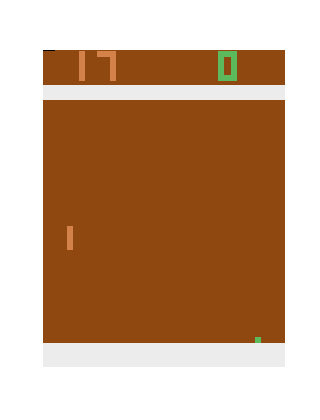
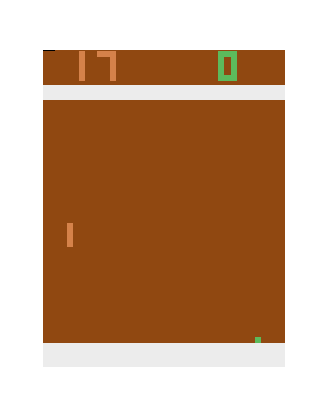
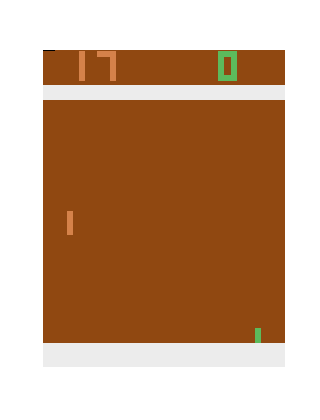
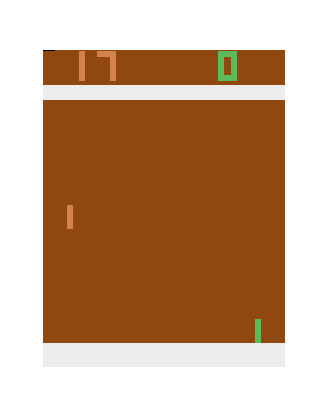
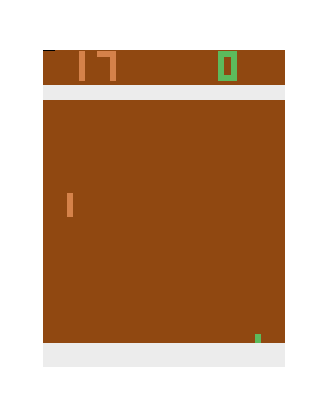
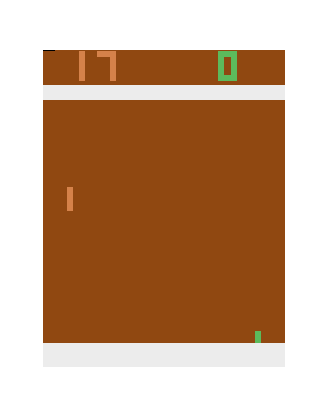
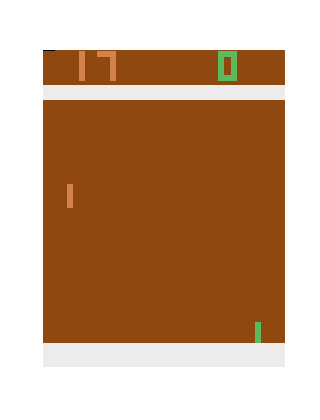
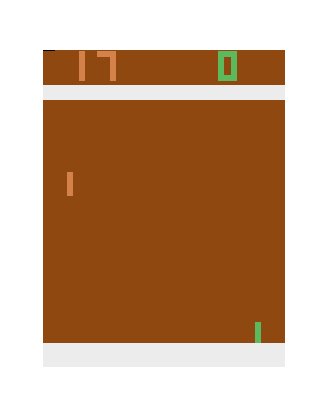
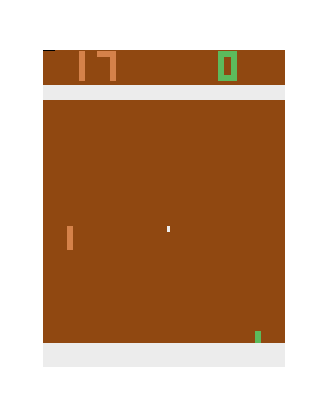
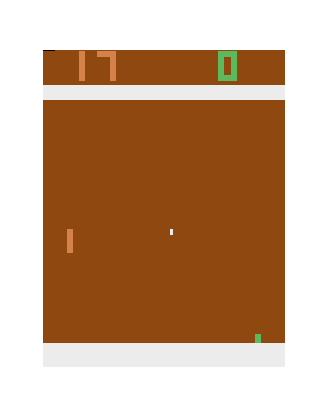
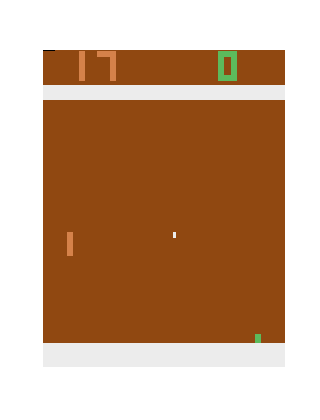
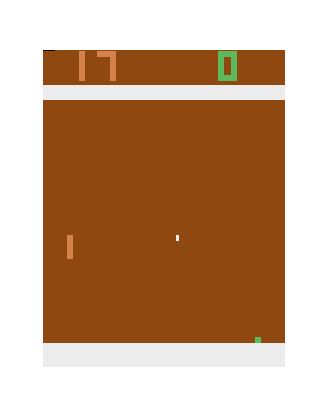
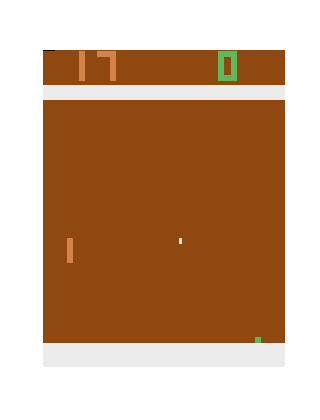
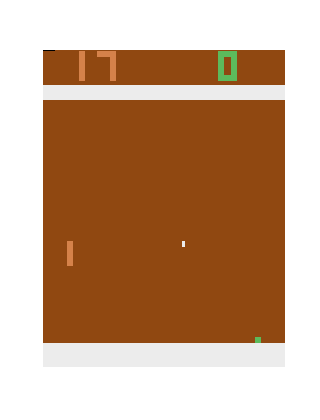
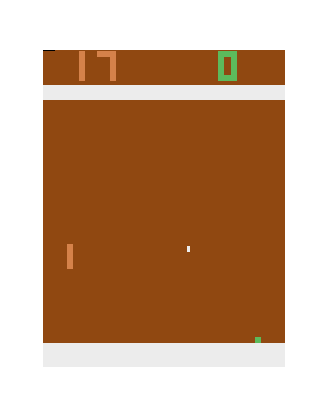
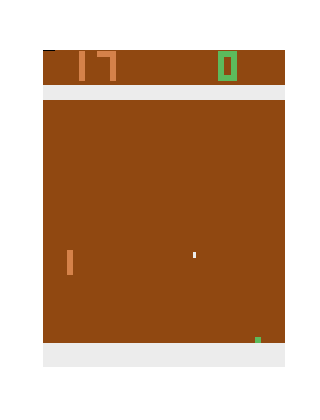
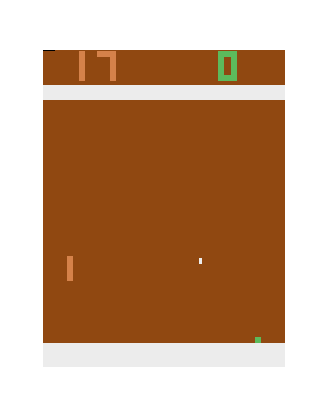
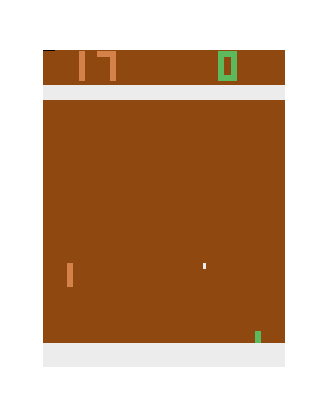
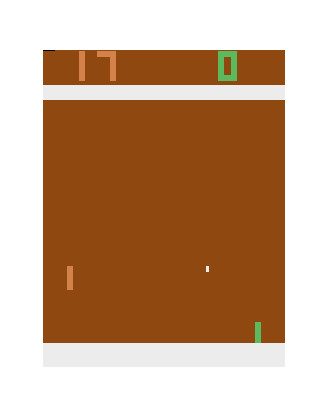
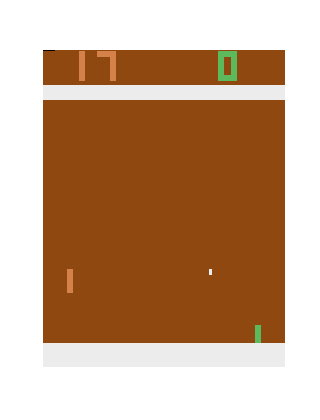
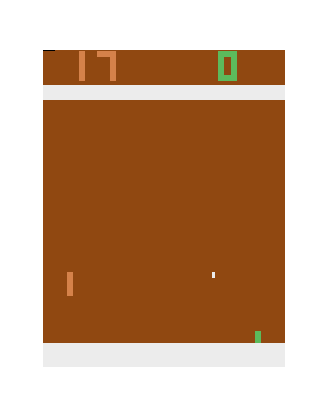
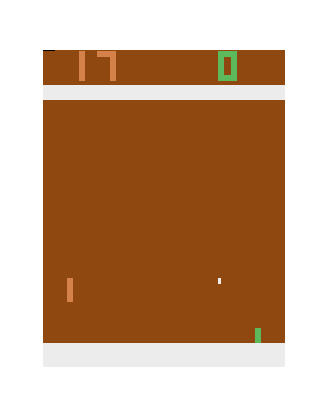
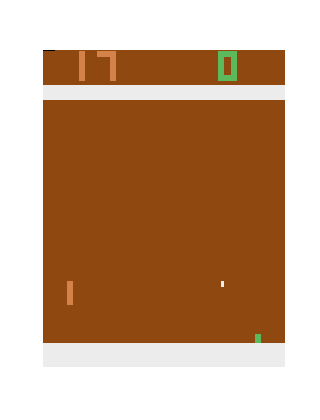
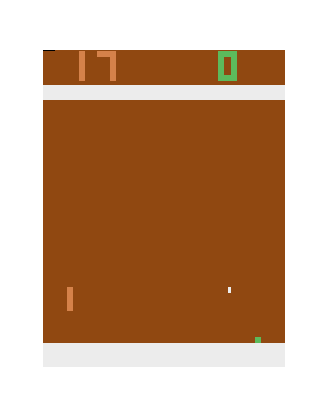
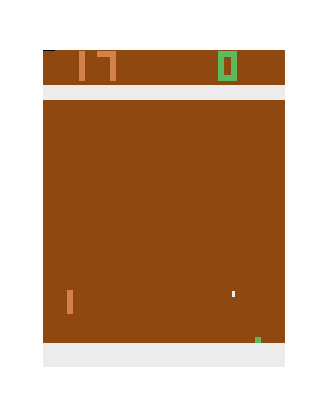
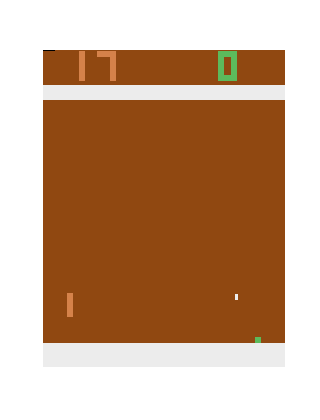
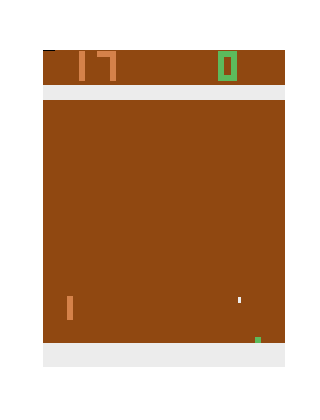
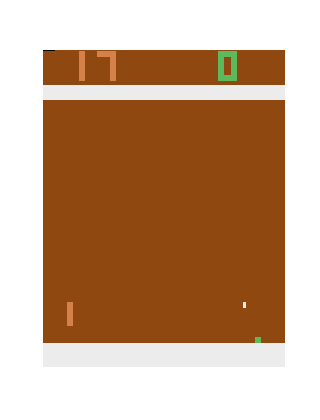
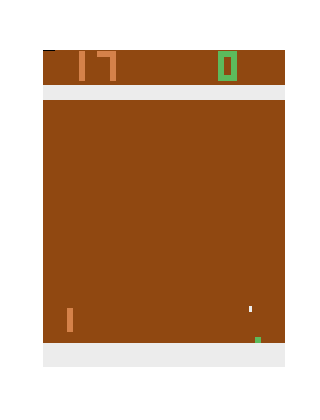
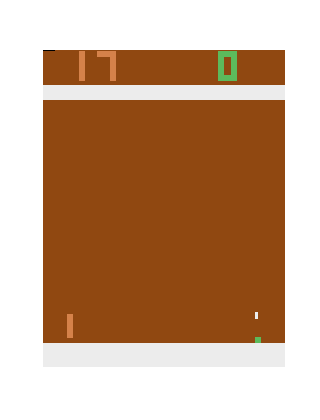
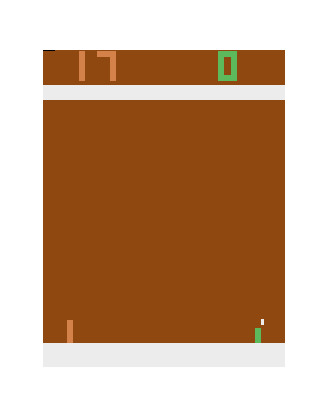
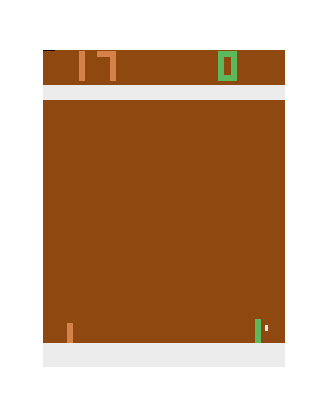
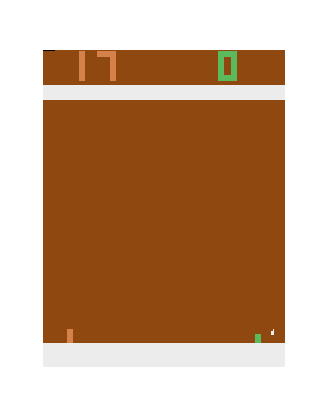
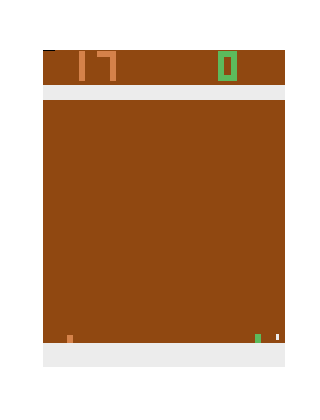
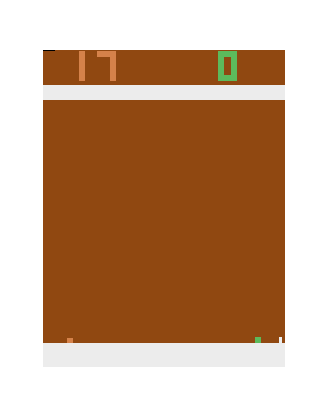
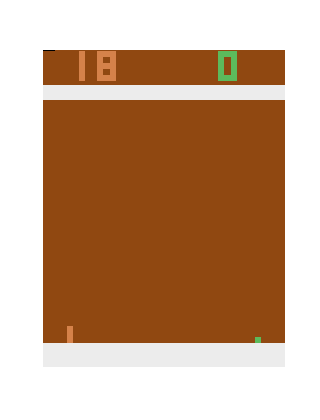
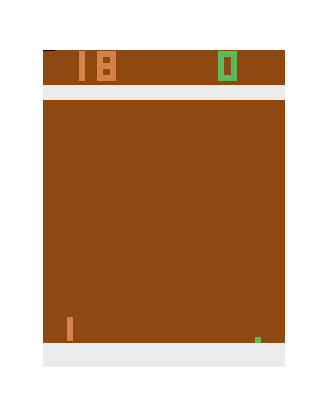
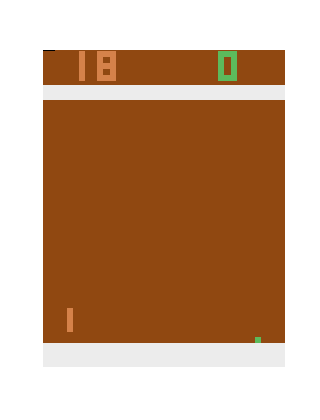
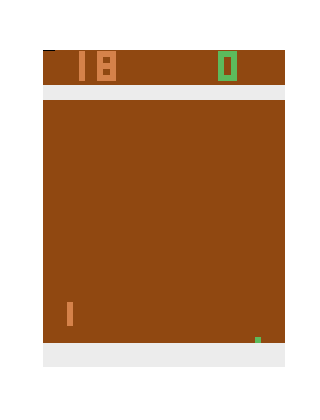
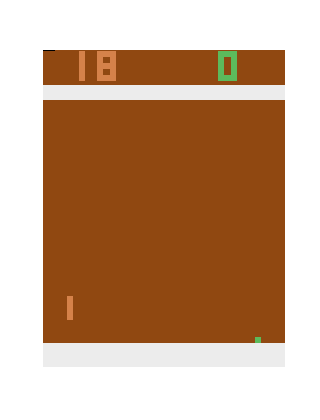
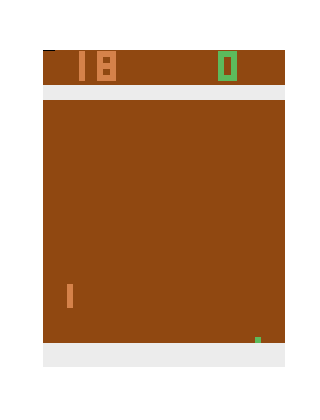
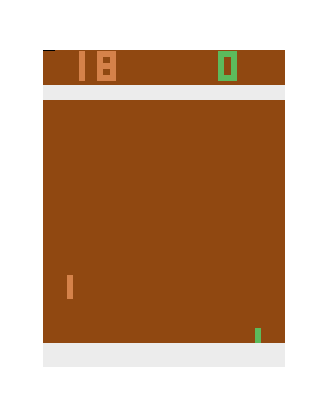
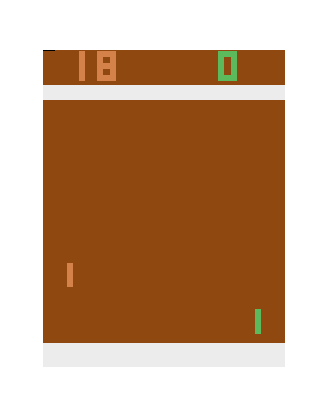
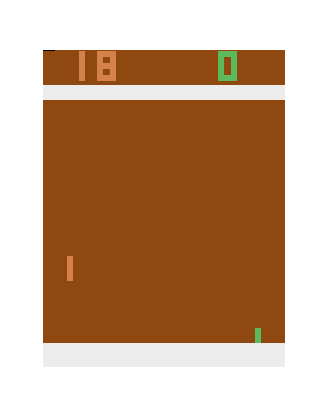
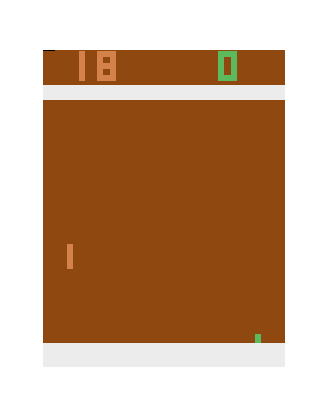
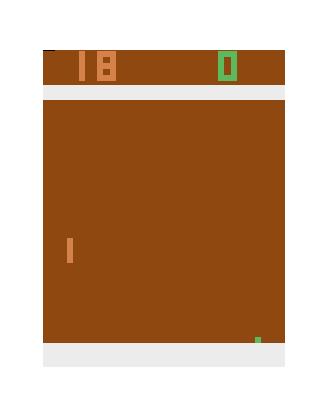
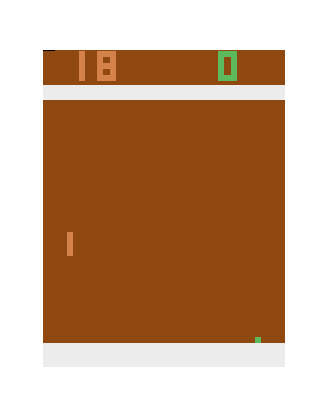
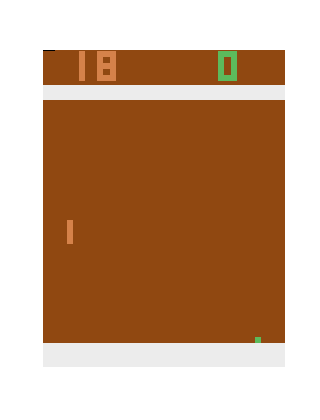
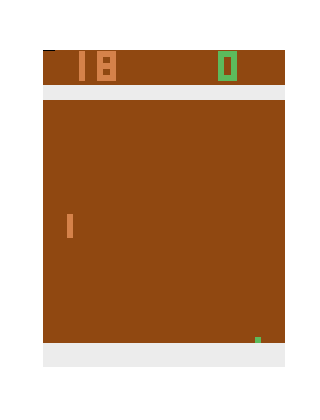
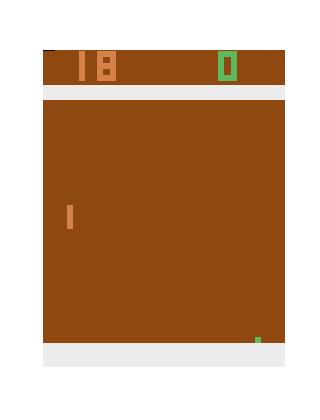
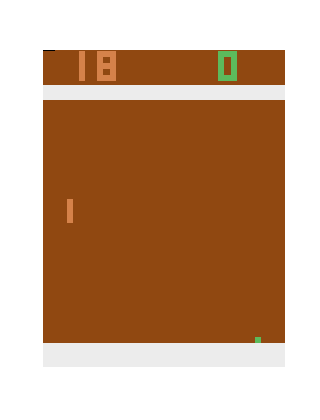
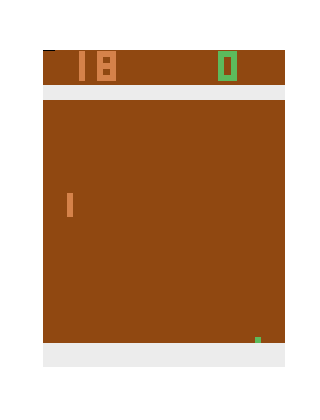
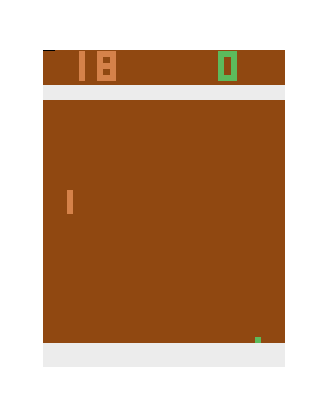
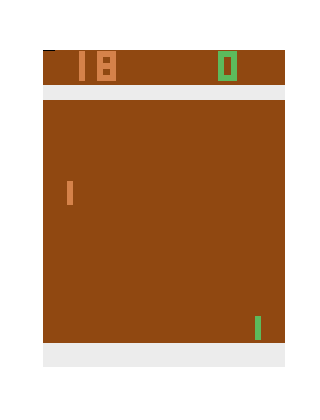
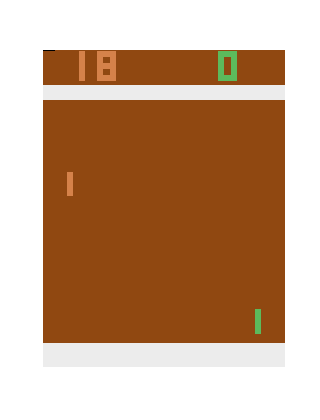
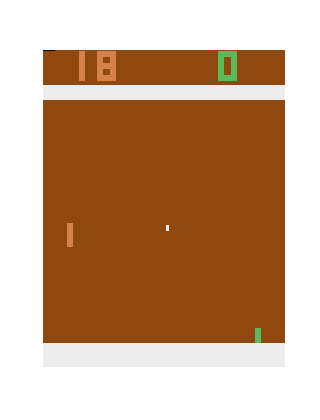
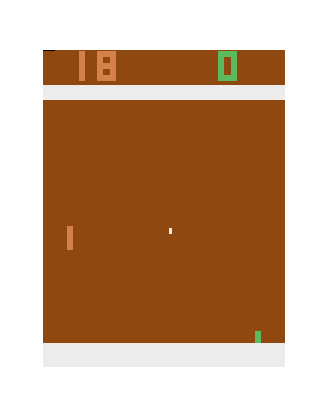
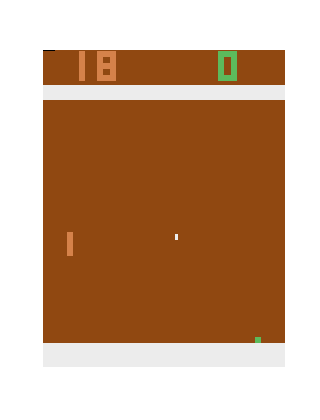
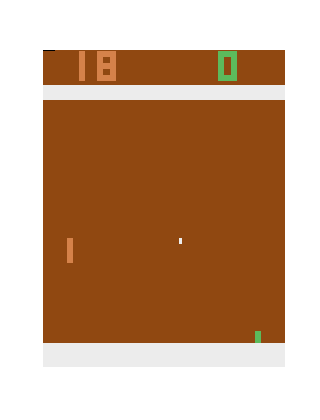
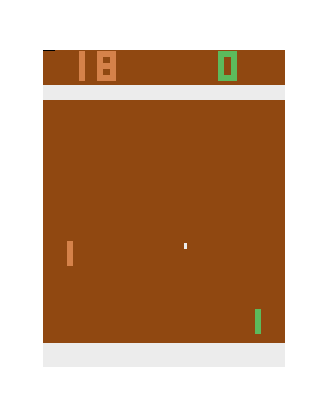
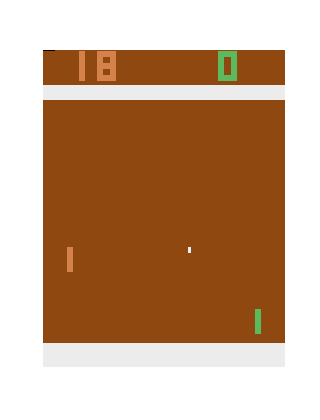

In [10]:
# random init model
play_game(env, model)

In [0]:
# hyperparameters
batch_size = 10 # every how many episodes to do a param update?
# learning_rate = 1e-4
learning_rate = 1e-3
 
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r, dtype=np.float32)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_backward(epx, eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

def train_model(env, model, total_episodes = 100):
  hist = []
  observation = env.reset()

  prev_x = None # used in computing the difference frame
  xs,hs,dlogps,drs = [],[],[],[]
  running_reward = None
  reward_sum = 0
  episode_number = 0

  while True:
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
      episode_number += 1

      # stack together all inputs, hidden states, action gradients, and rewards for this episode
      epx = np.vstack(xs)
      eph = np.vstack(hs)
      epdlogp = np.vstack(dlogps)
      epr = np.vstack(drs)
      xs,hs,dlogps,drs = [],[],[],[] # reset array memory

      # compute the discounted reward backwards through time
      discounted_epr = discount_rewards(epr)
      # standardize the rewards to be unit normal (helps control the gradient estimator variance)
      discounted_epr -= np.mean(discounted_epr)
      discounted_epr /= np.std(discounted_epr)

      epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
      grad = policy_backward(epx, eph, epdlogp)
      for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

      # perform rmsprop parameter update every batch_size episodes
      if episode_number % batch_size == 0:
        for k,v in model.items():
          g = grad_buffer[k] # gradient
          rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
          model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
          grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

      # boring book-keeping
      running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
      hist.append((episode_number, reward_sum, running_reward))
      print ('resetting env. episode %f, reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))
      reward_sum = 0
      observation = env.reset() # reset env
      prev_x = None
      if episode_number == total_episodes: return hist

  #   if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
  #     print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))

In [12]:
%time hist1 = train_model(env, model, total_episodes=500)

resetting env. episode 1.000000, reward total was -20.000000. running mean: -20.000000
resetting env. episode 2.000000, reward total was -21.000000. running mean: -20.010000
resetting env. episode 3.000000, reward total was -21.000000. running mean: -20.019900
resetting env. episode 4.000000, reward total was -21.000000. running mean: -20.029701
resetting env. episode 5.000000, reward total was -21.000000. running mean: -20.039404
resetting env. episode 6.000000, reward total was -21.000000. running mean: -20.049010
resetting env. episode 7.000000, reward total was -21.000000. running mean: -20.058520
resetting env. episode 8.000000, reward total was -21.000000. running mean: -20.067935
resetting env. episode 9.000000, reward total was -21.000000. running mean: -20.077255
resetting env. episode 10.000000, reward total was -20.000000. running mean: -20.076483
resetting env. episode 11.000000, reward total was -20.000000. running mean: -20.075718
resetting env. episode 12.000000, reward 

Episode finished without success, accumulated reward = -5.0



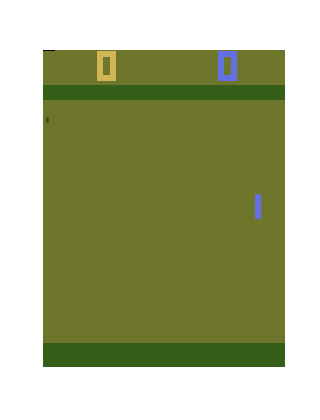
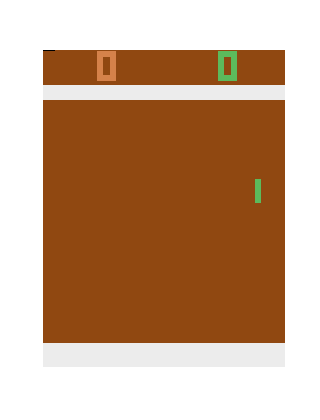
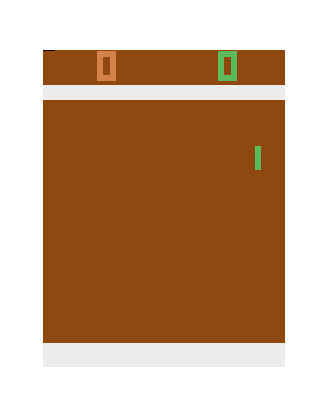
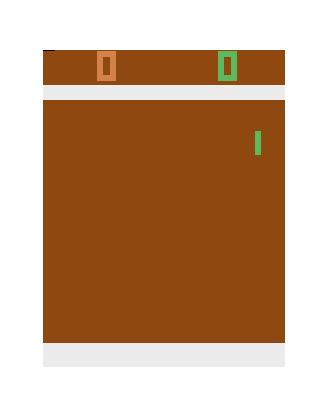
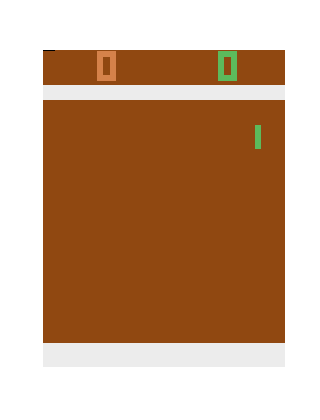
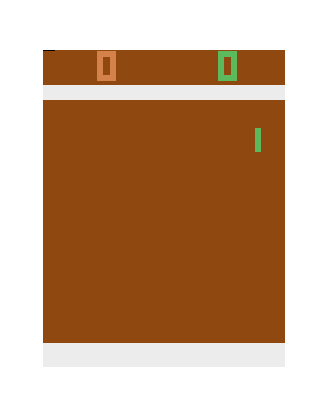
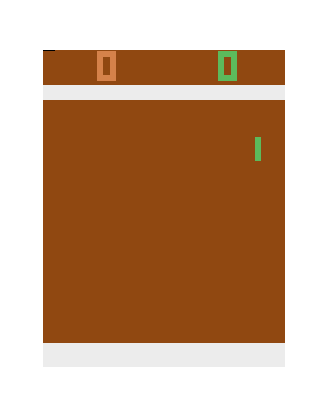
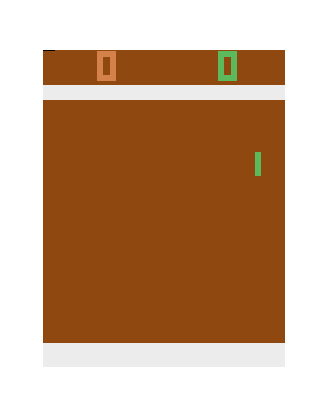
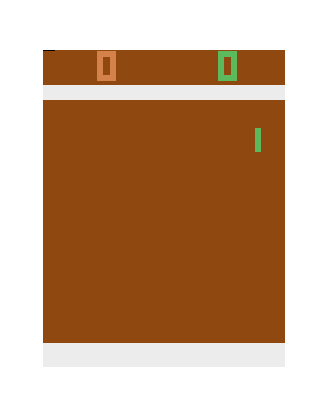
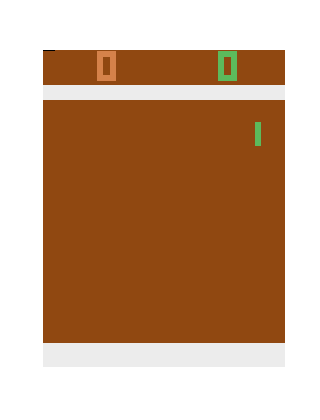
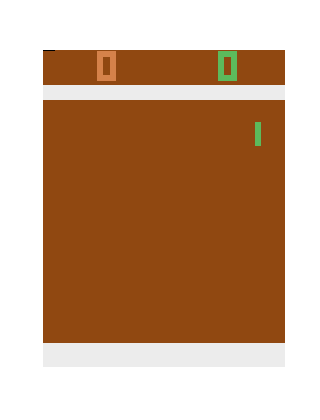
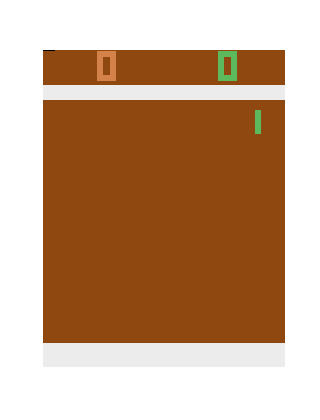
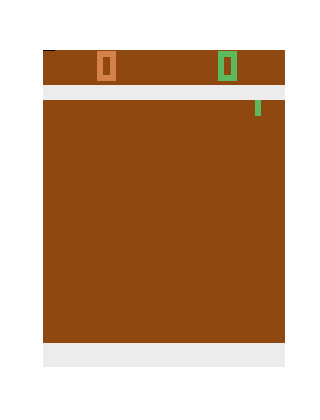
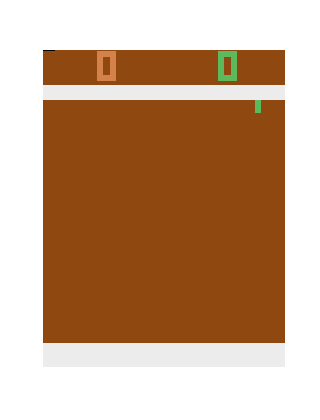
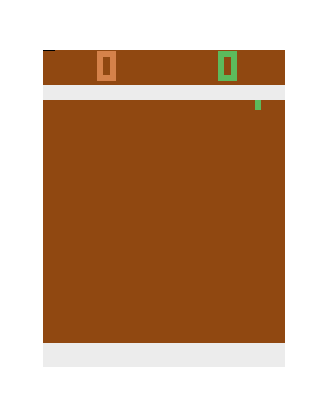
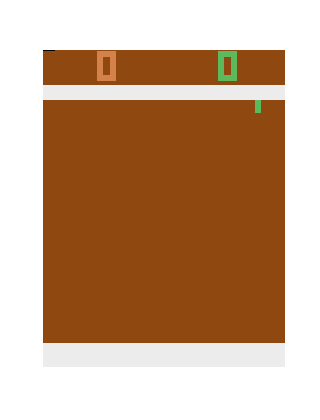
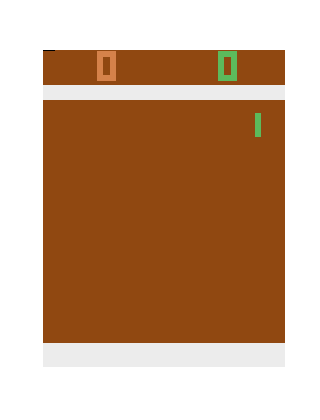
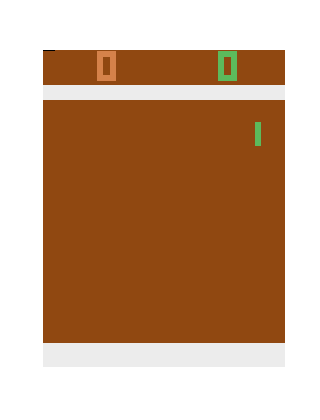
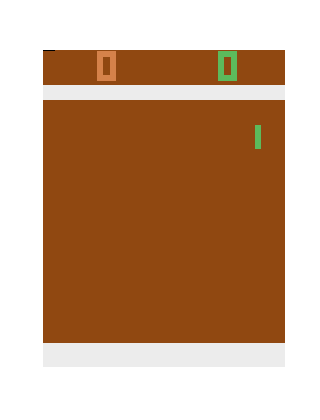
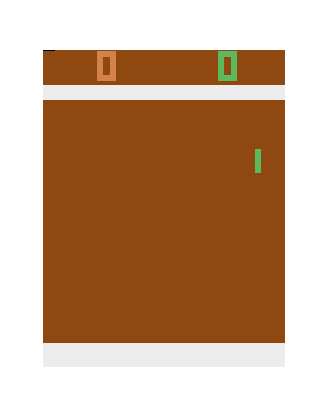
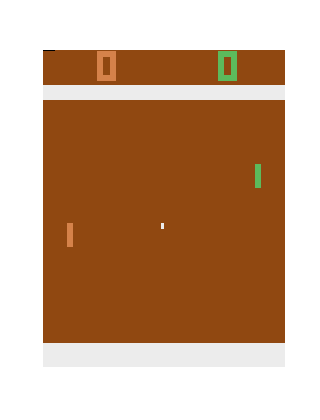
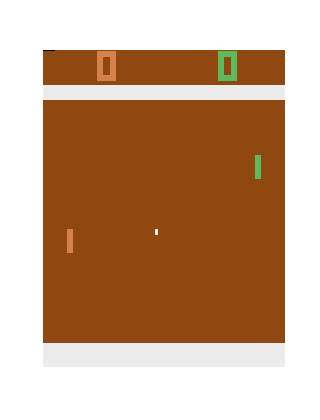
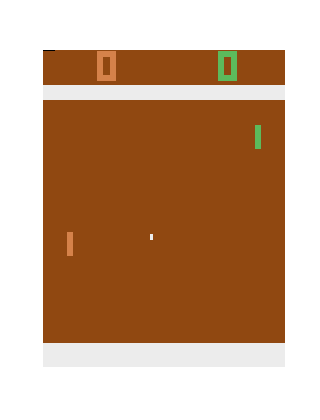
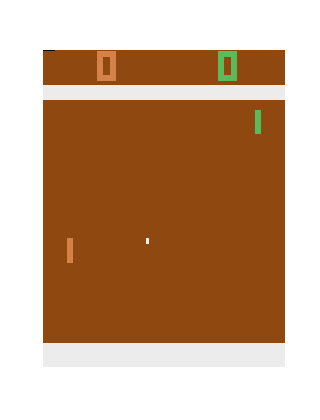
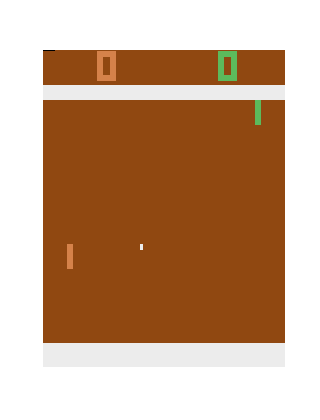
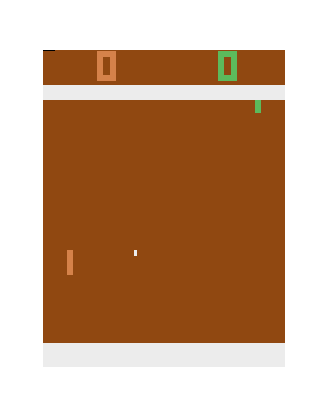
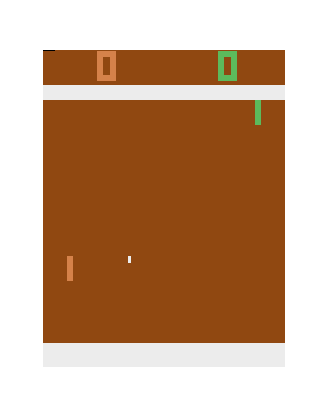
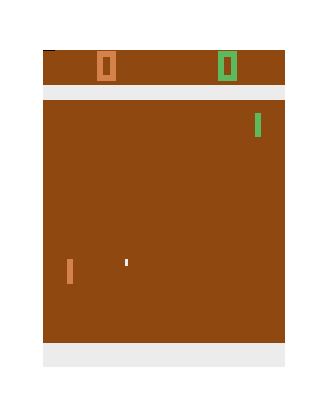
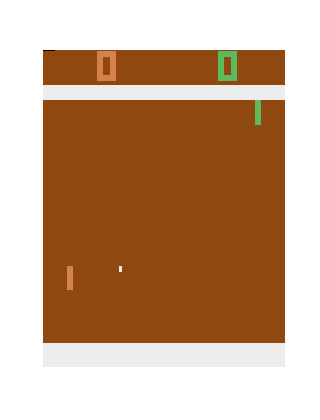
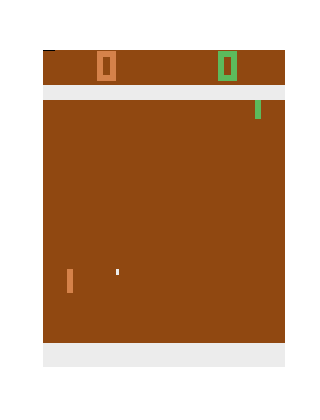
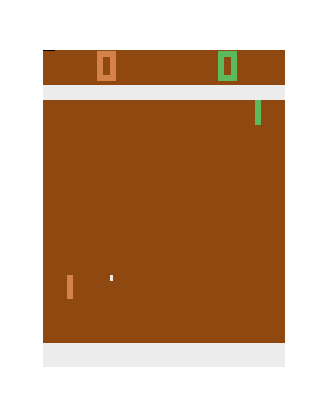
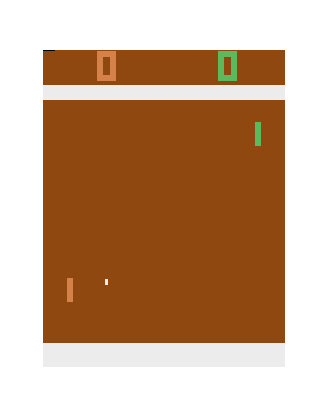
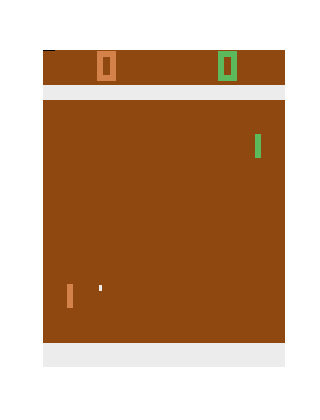
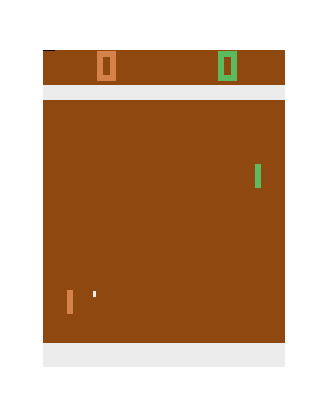
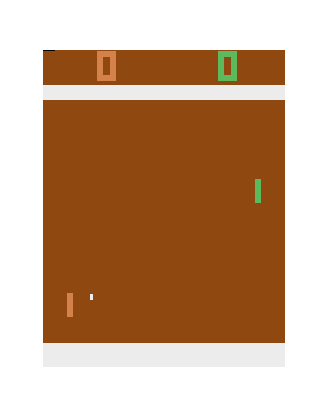
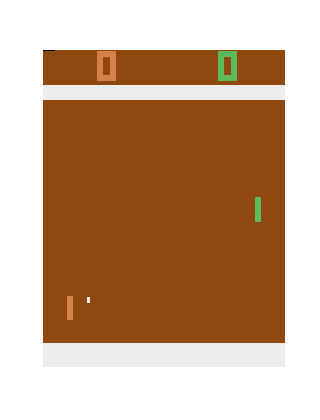
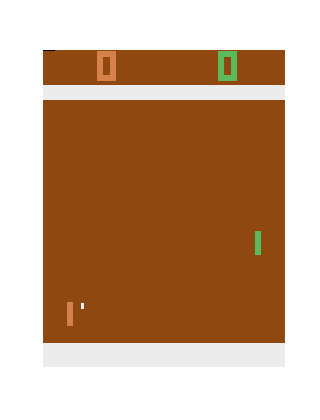
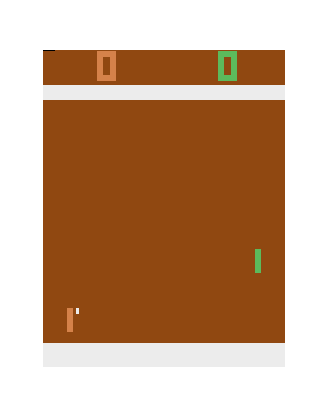
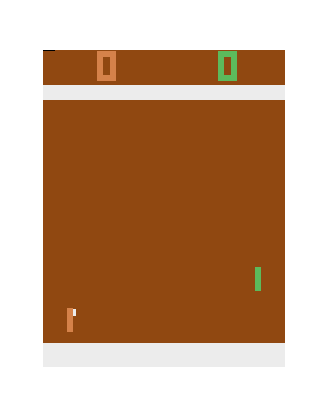
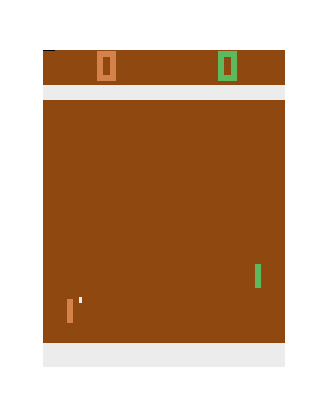
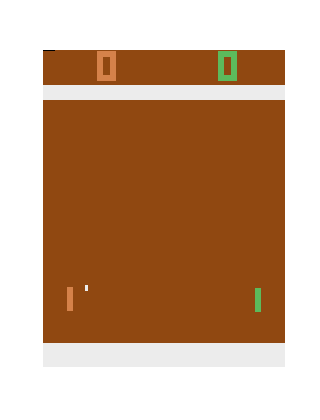
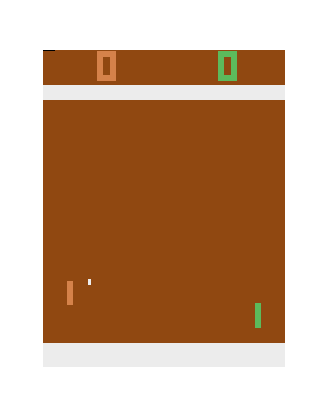
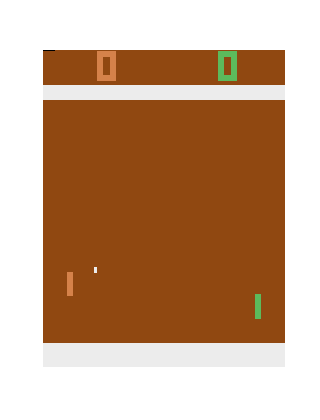
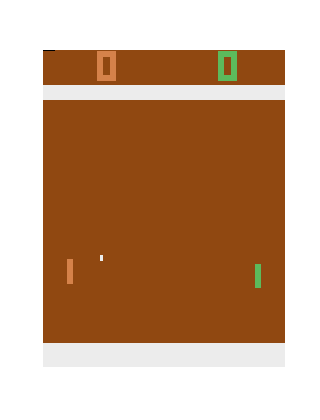
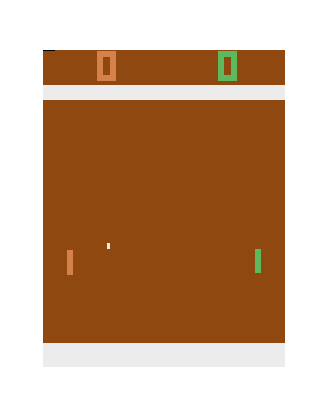
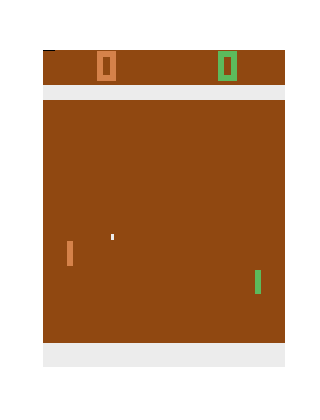
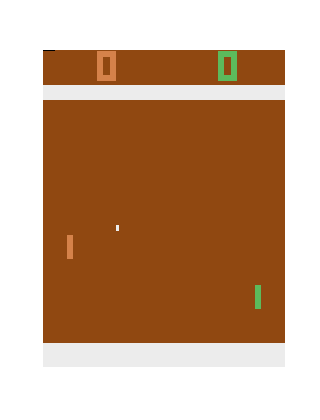
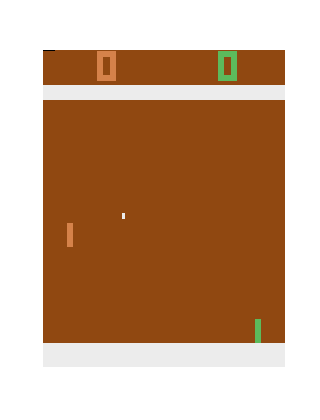
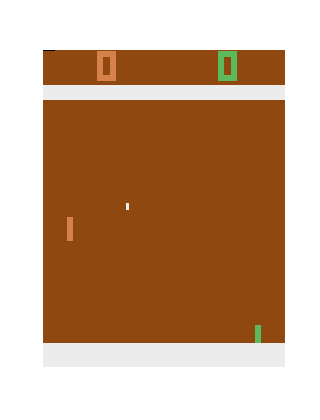
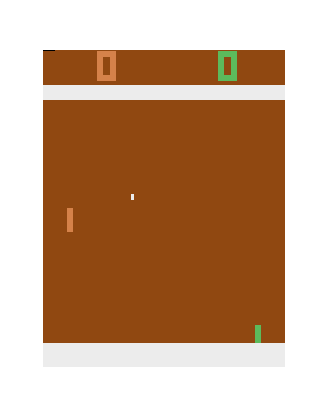
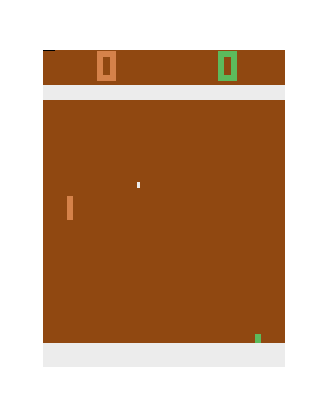
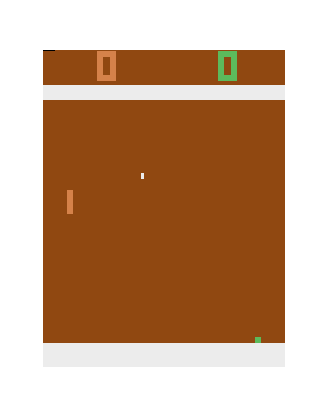
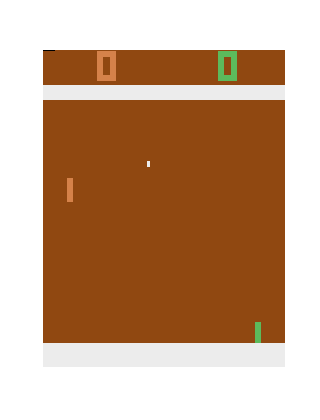
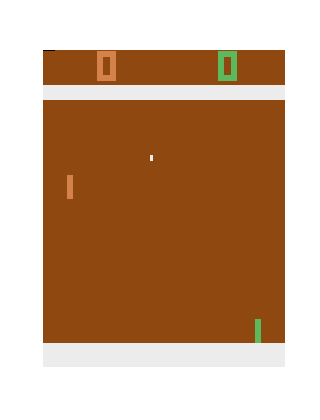
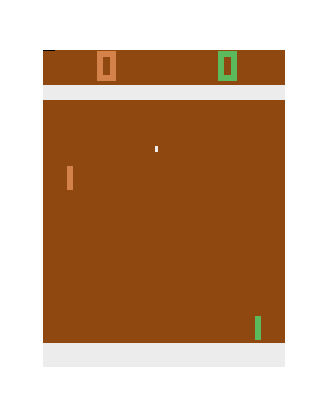
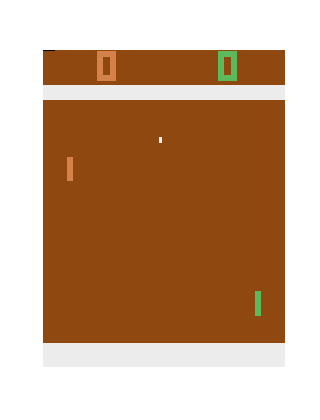
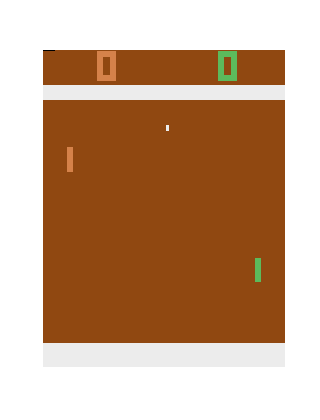
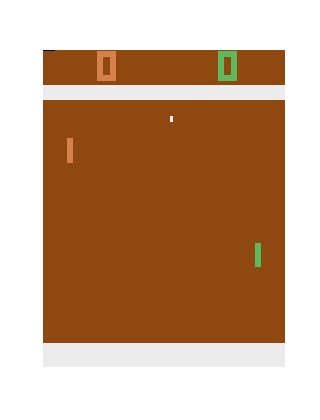
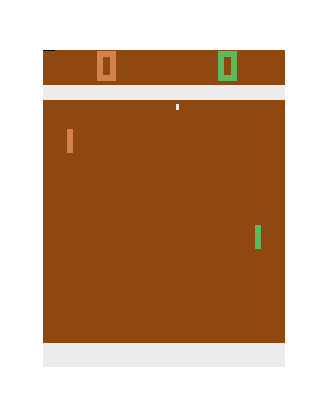
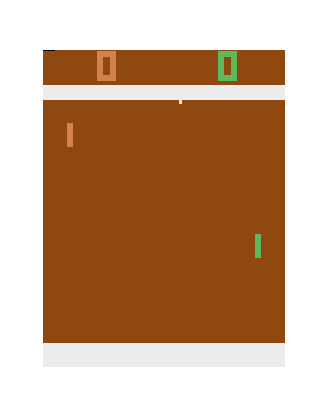
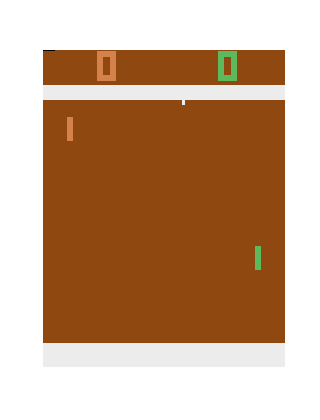
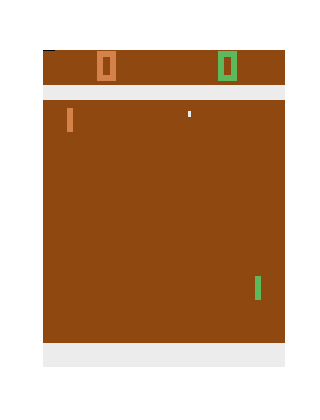
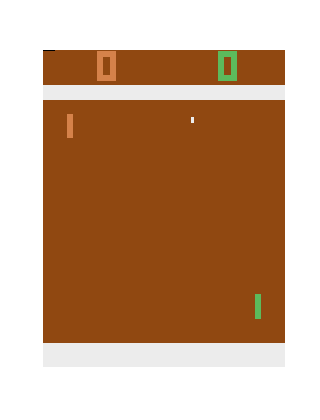
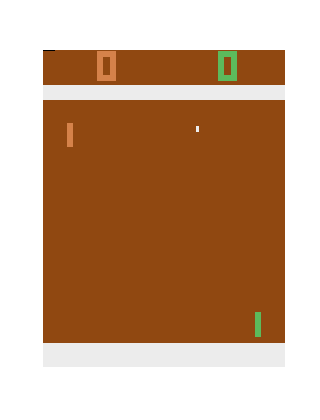
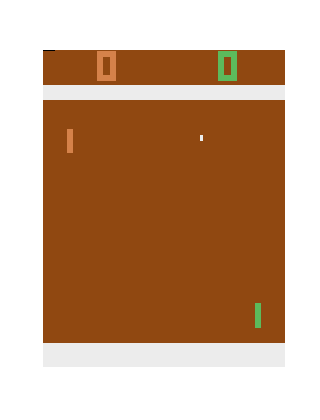
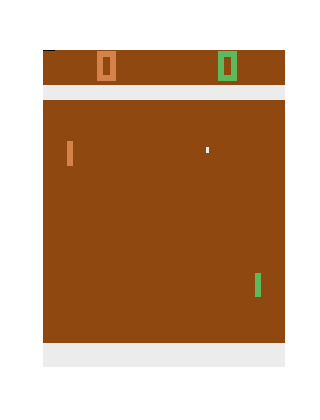
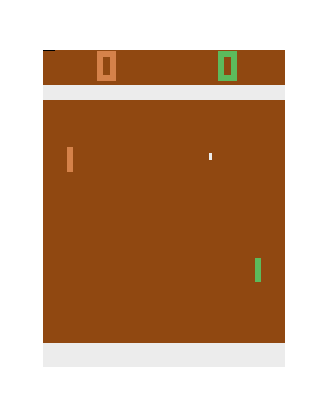
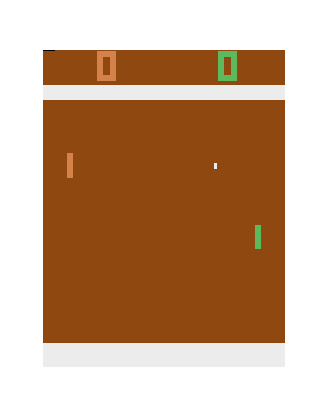
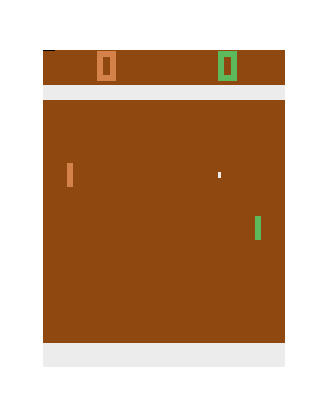
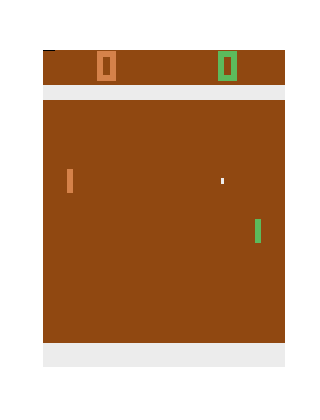
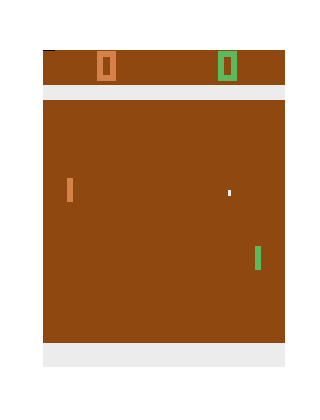
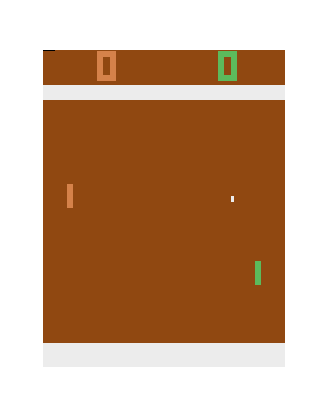
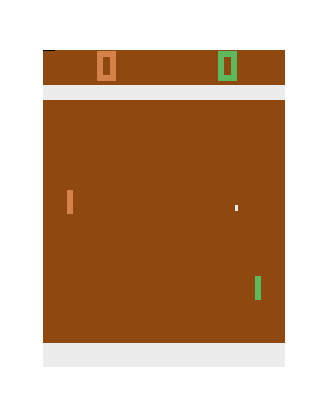
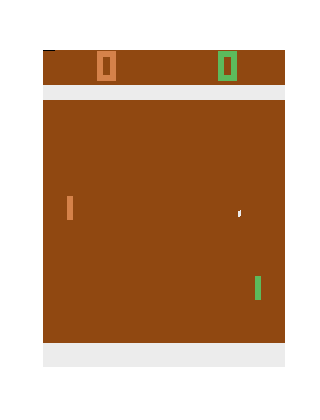
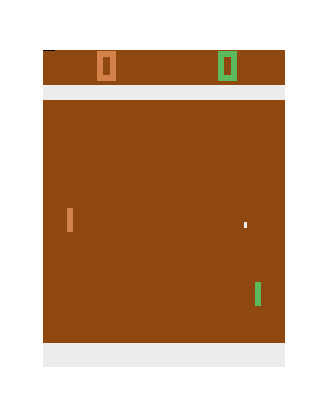
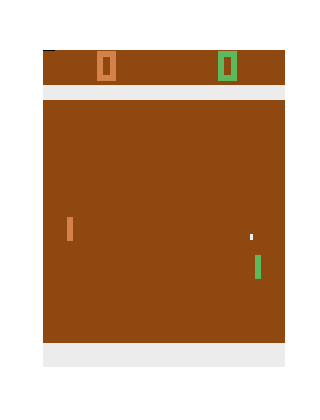
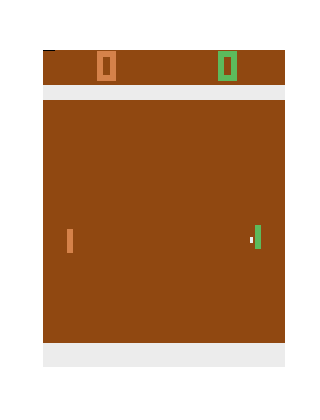
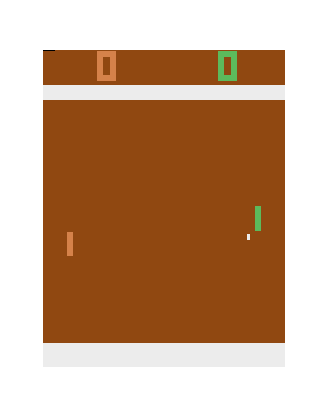
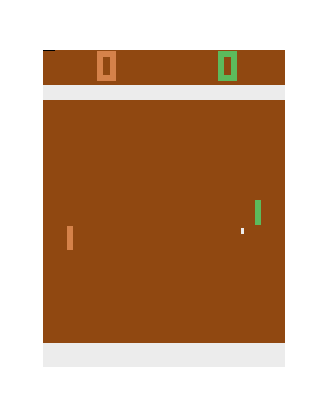
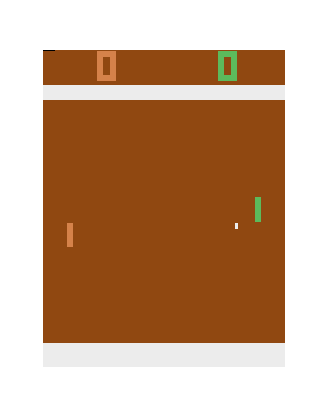
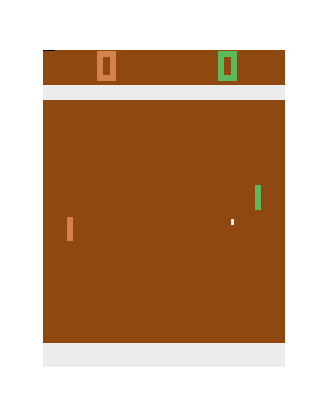
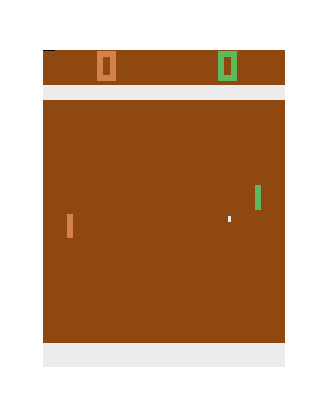
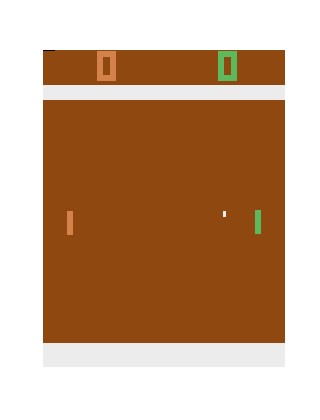
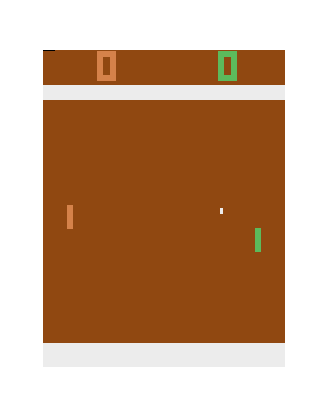
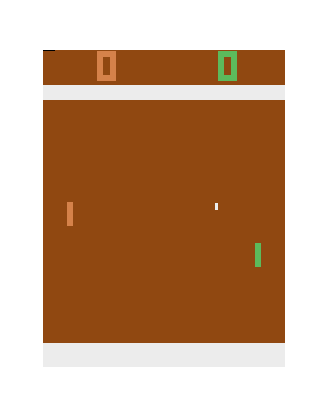
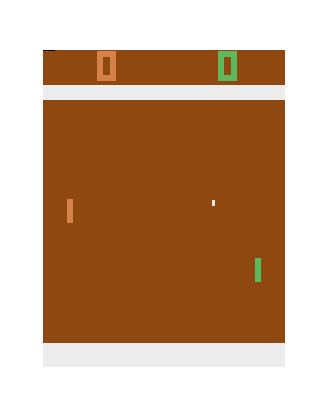
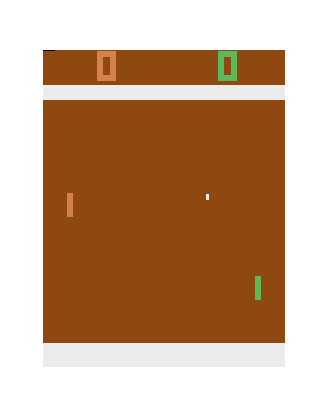
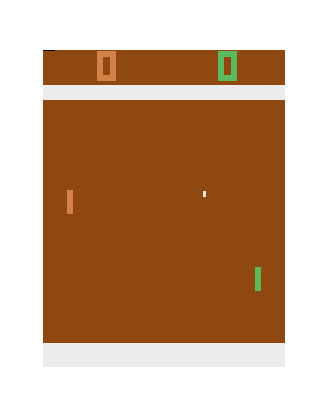
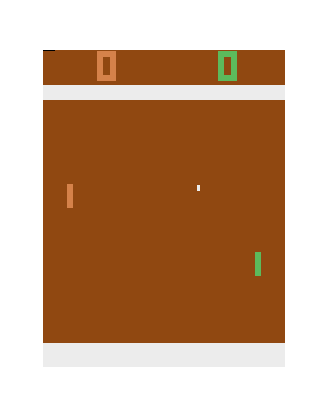
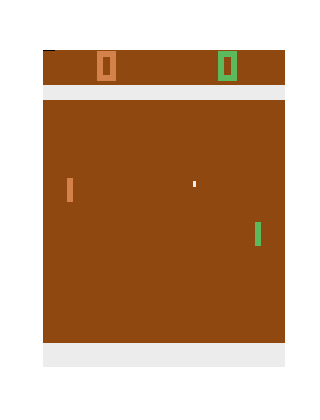
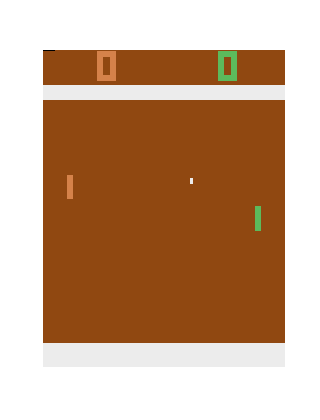
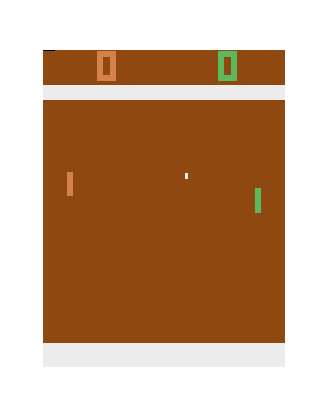
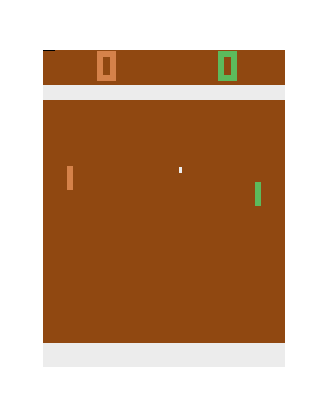
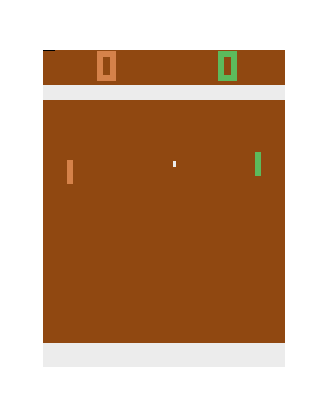
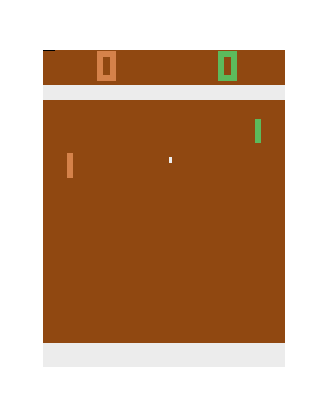
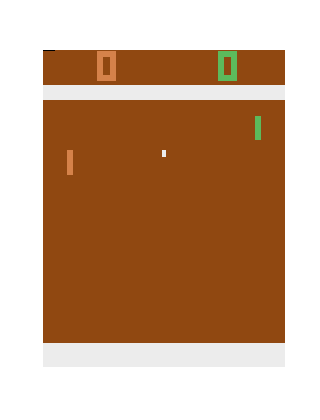
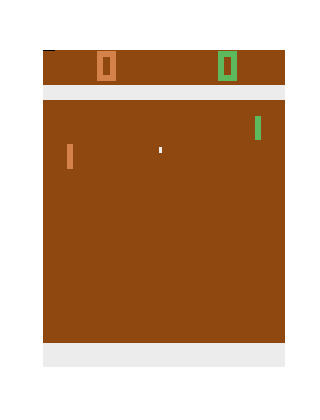
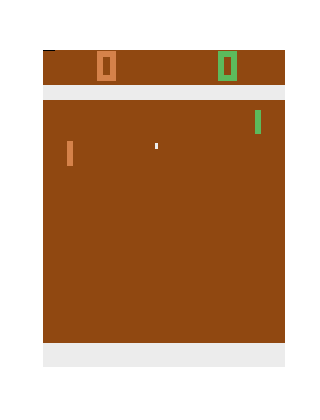
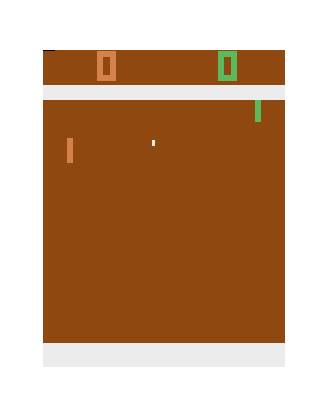
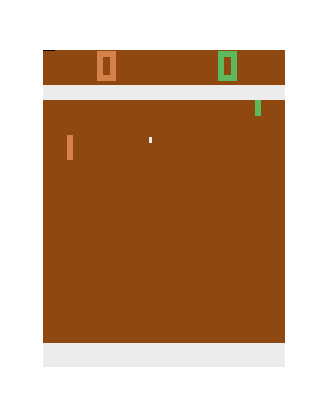
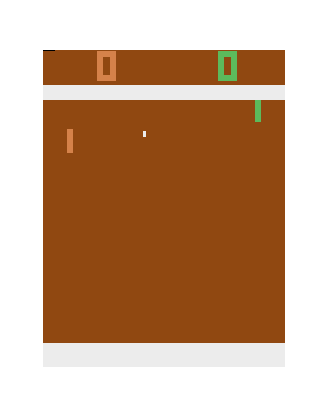
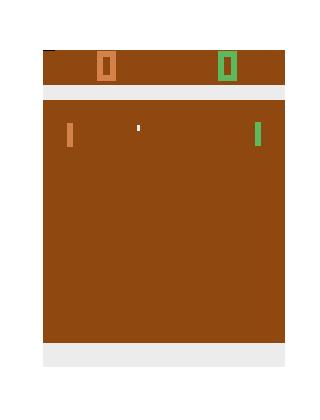
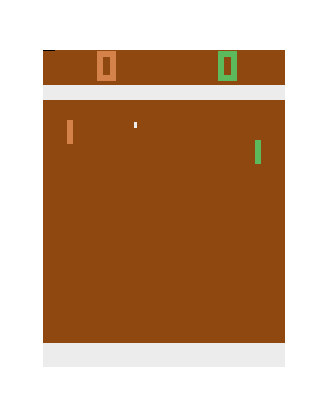
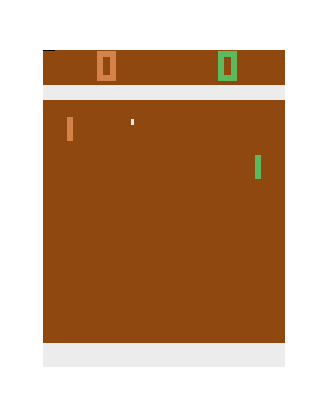
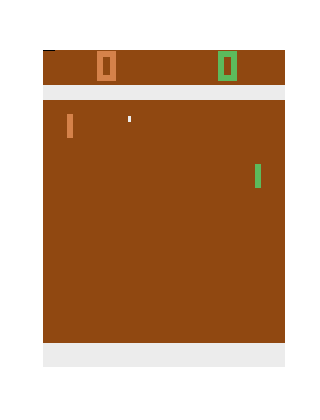
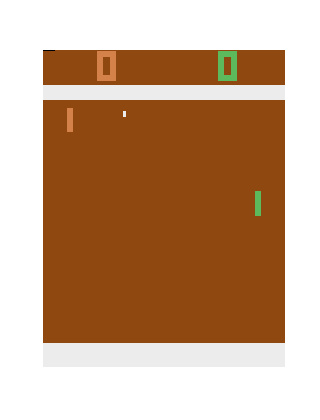
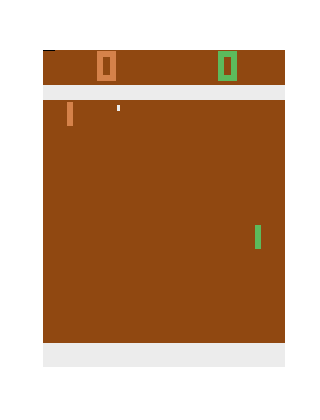
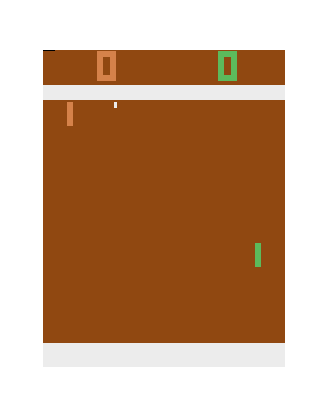
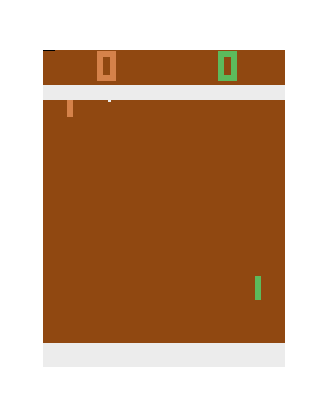
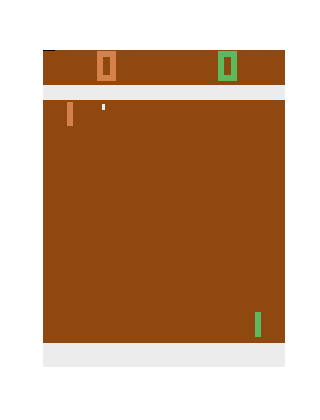
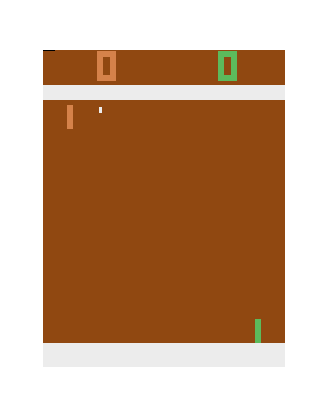
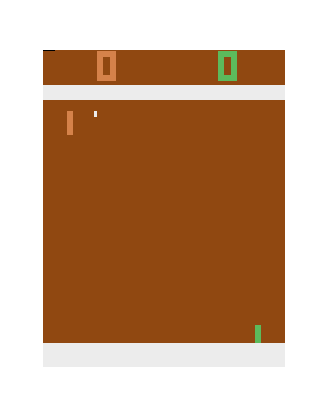
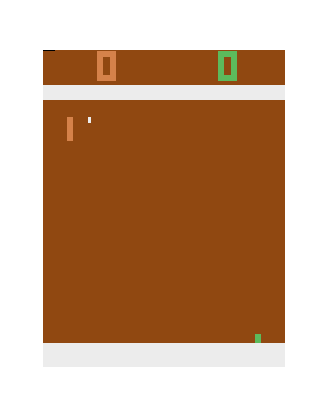
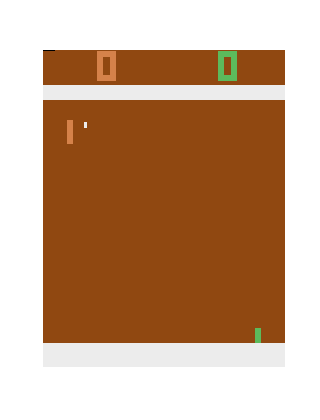
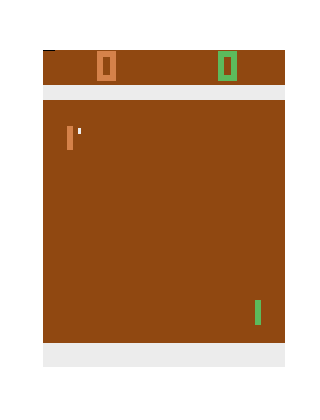
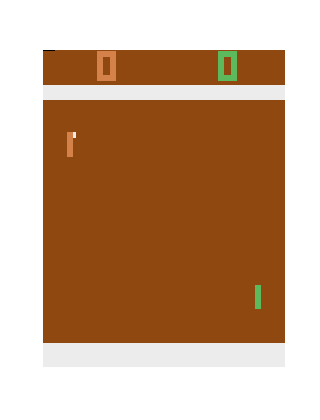
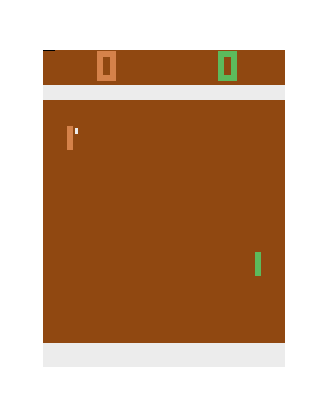
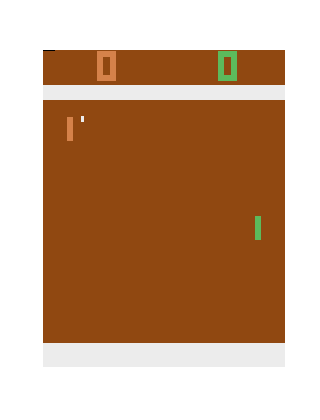
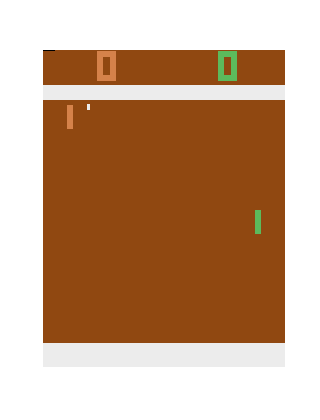
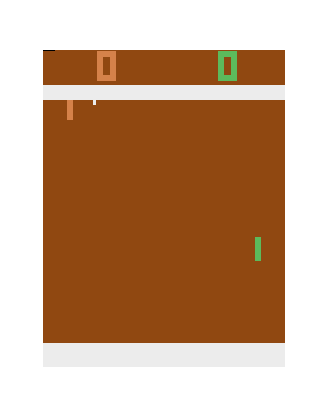
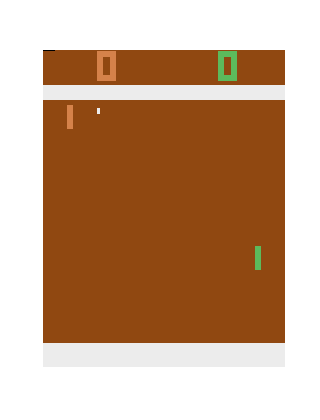
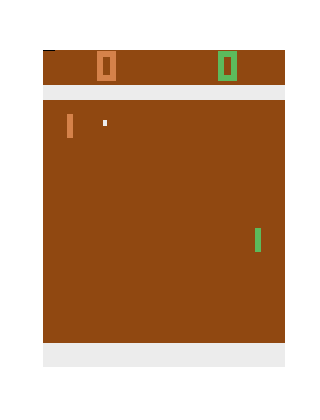
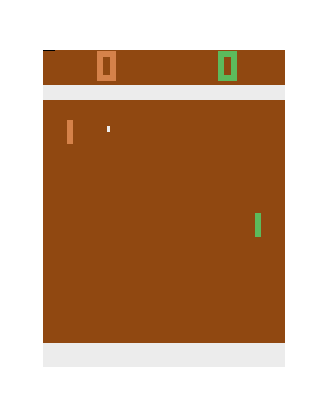
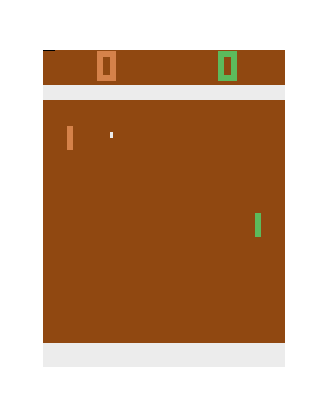
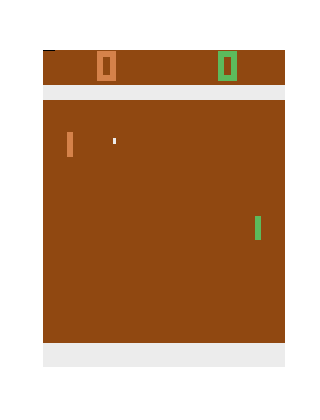
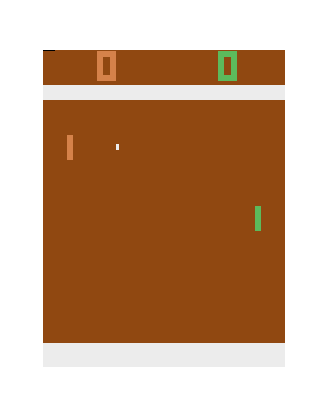
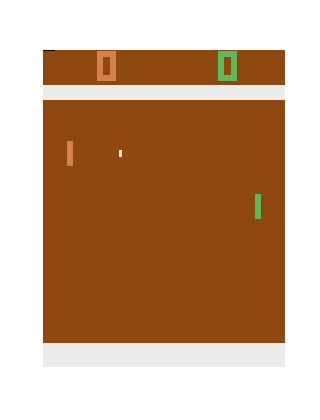
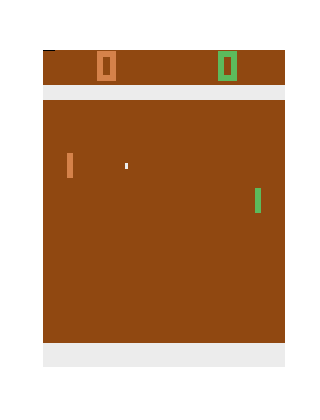
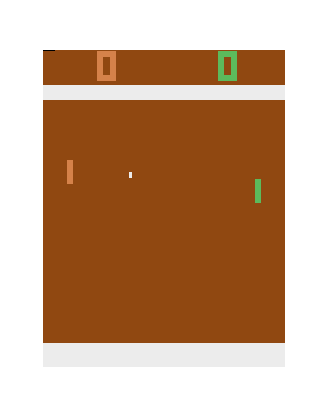
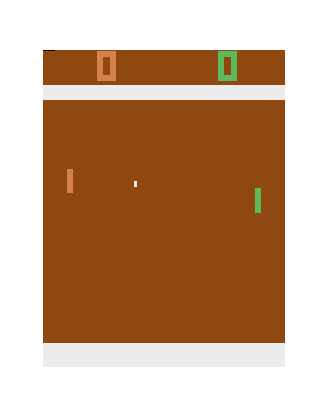
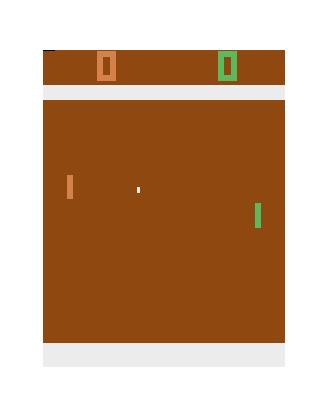
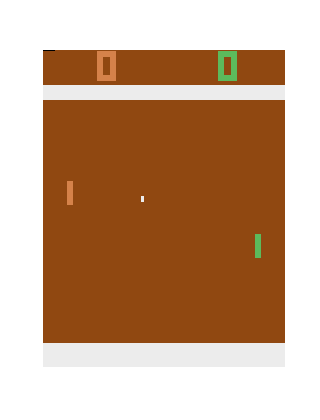
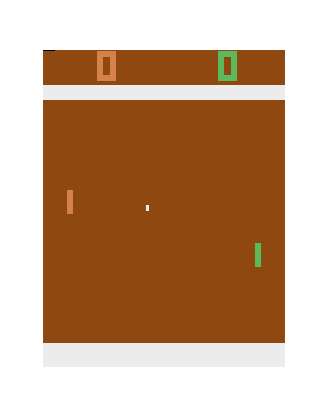
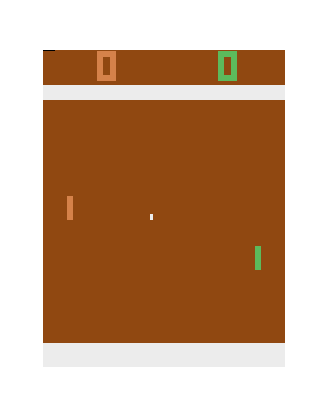
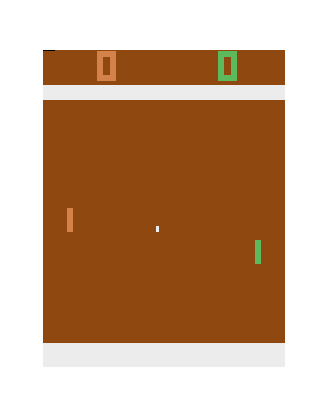
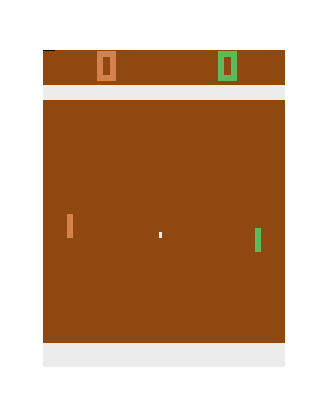
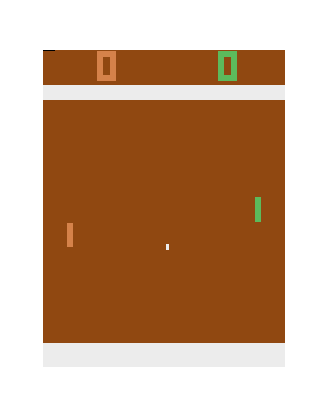
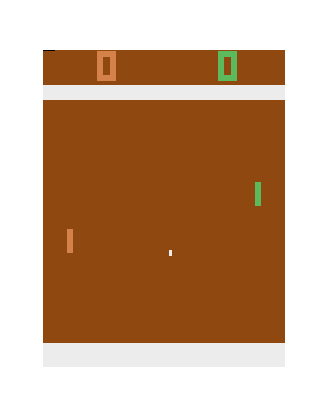
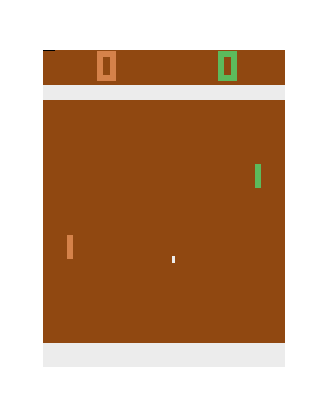
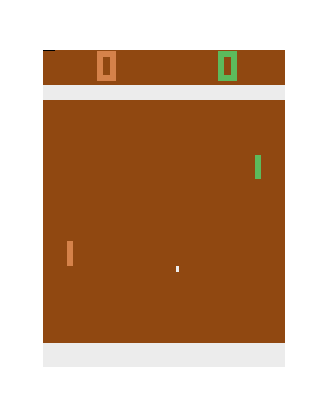
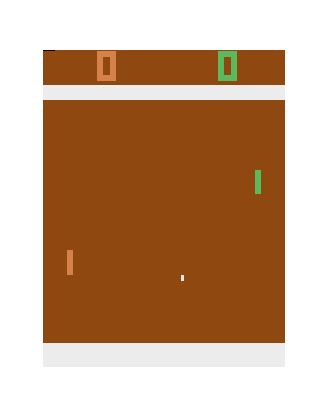
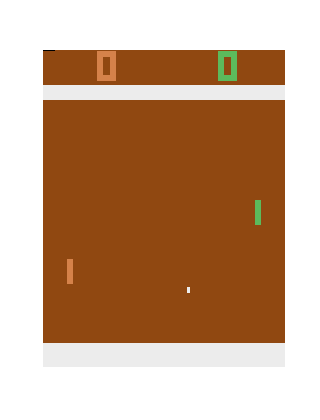
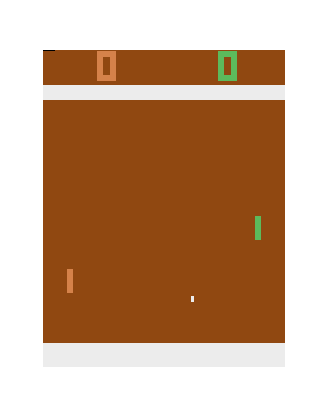
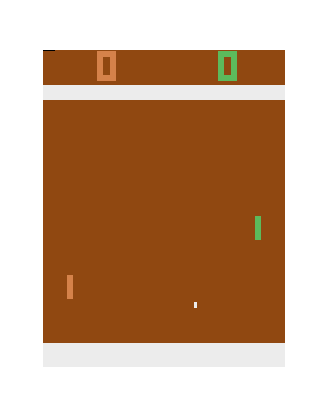
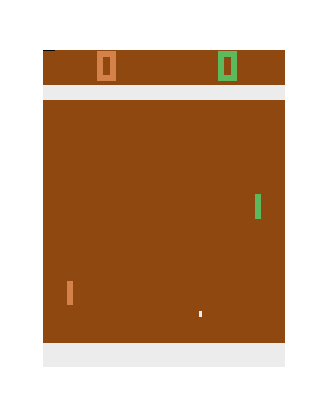
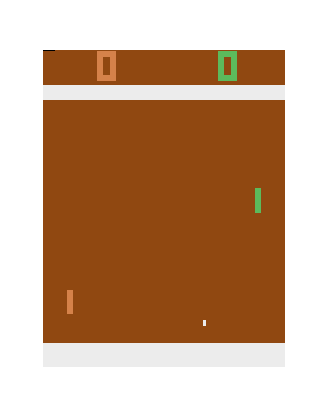
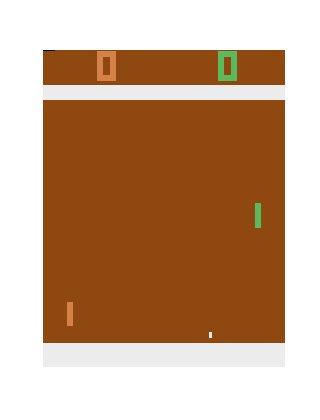
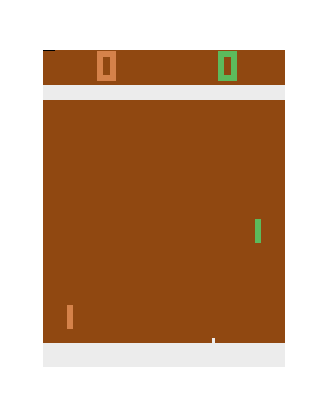
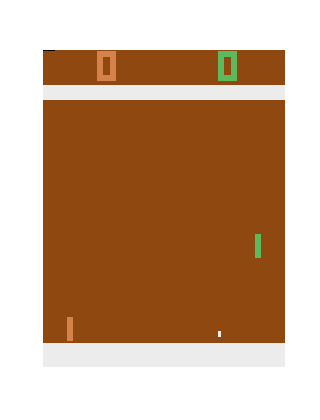
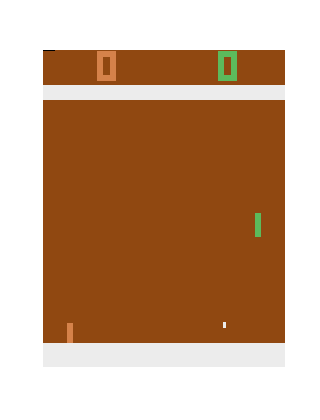
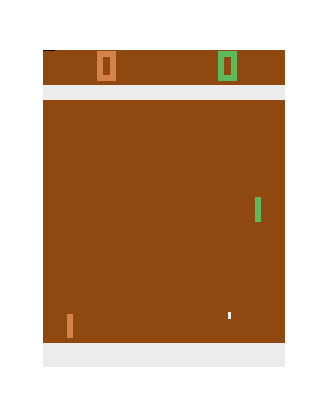
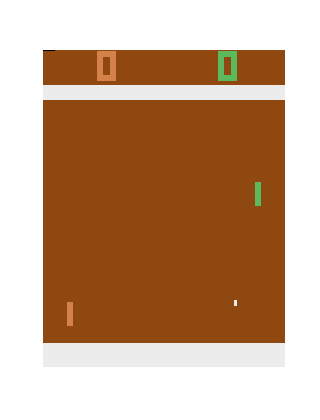
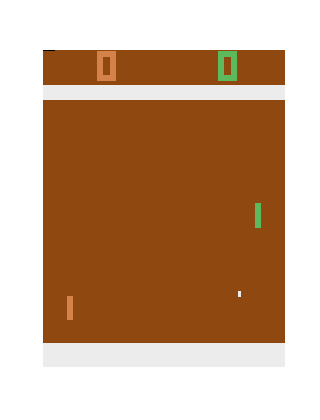
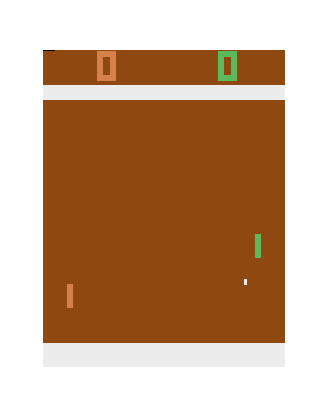
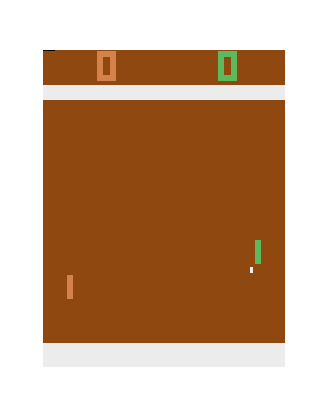
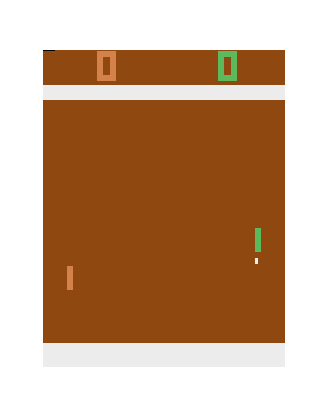
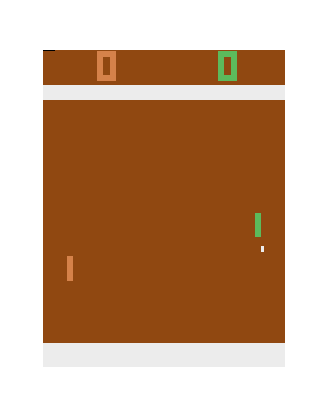
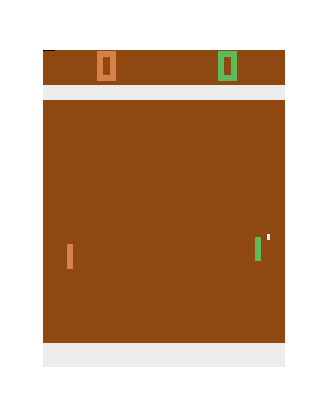
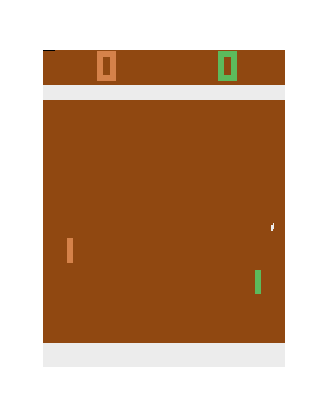
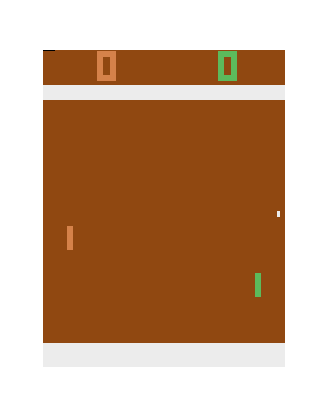
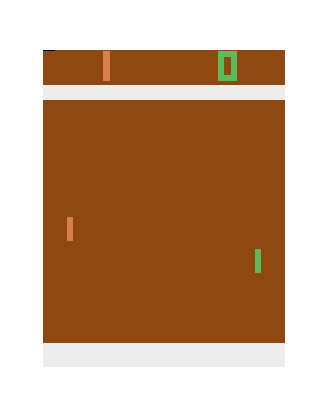
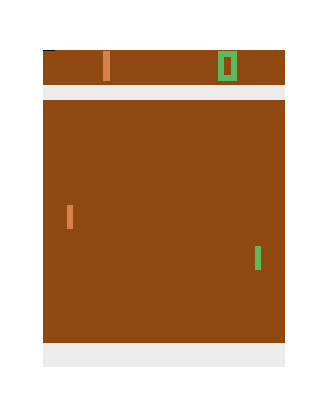
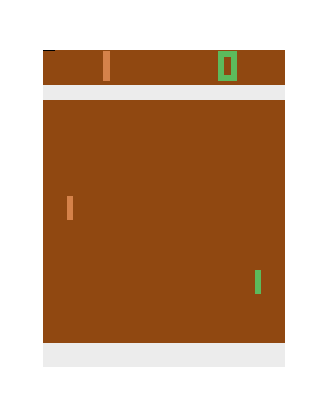
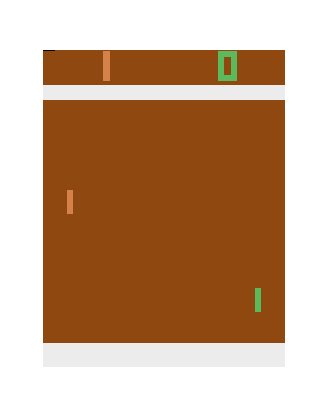
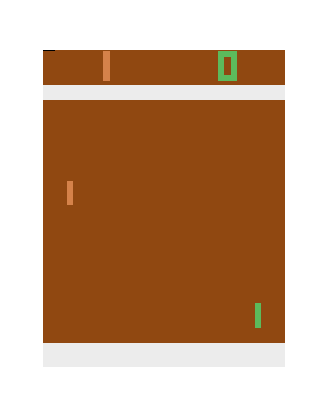
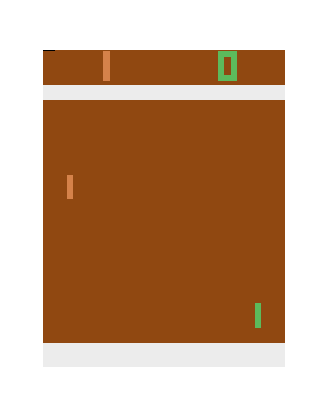
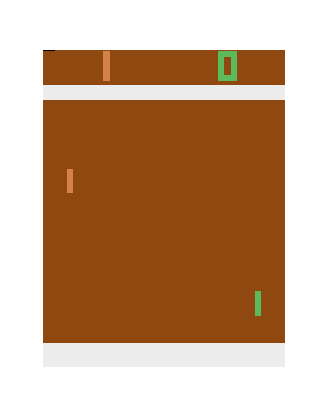
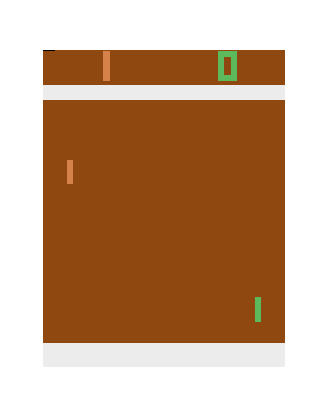
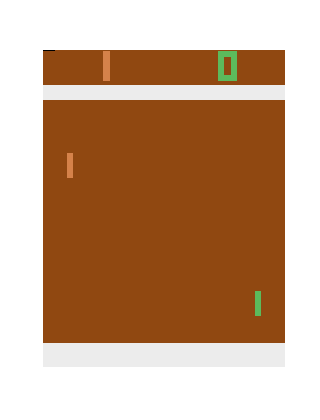
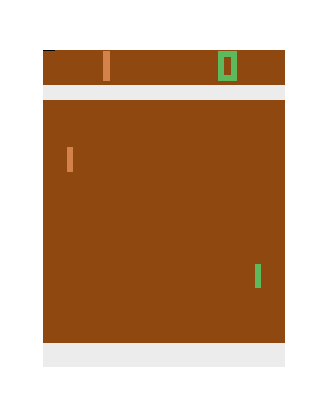
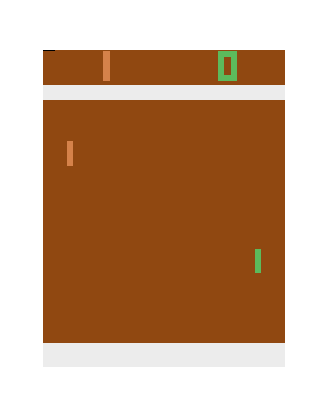
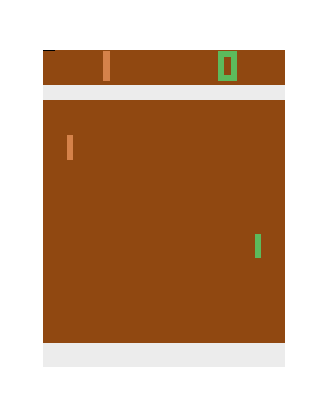
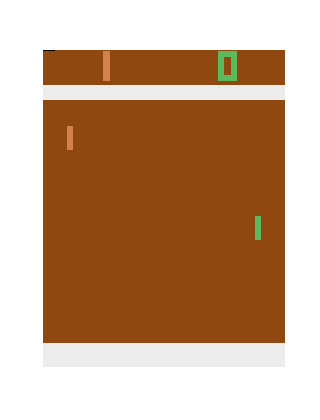
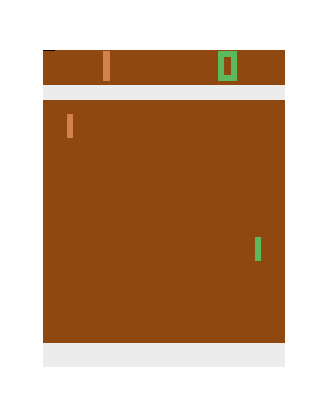
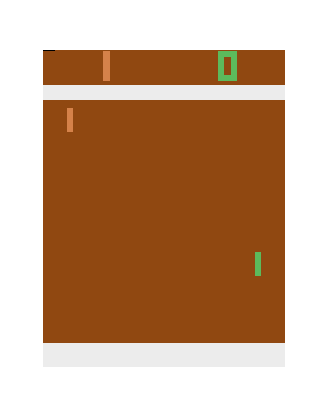
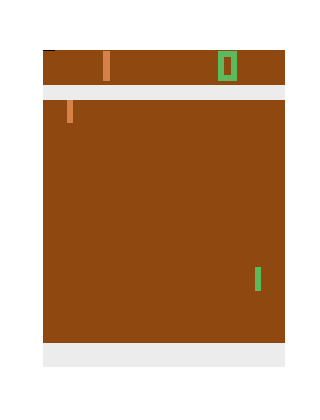
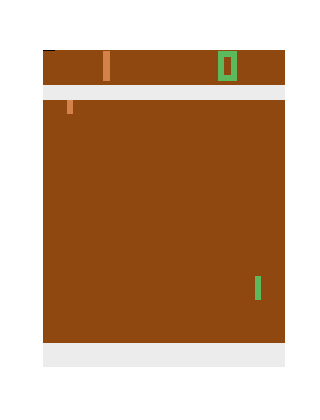
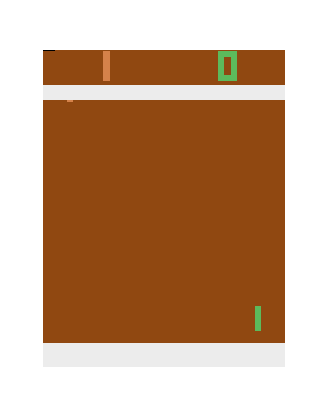
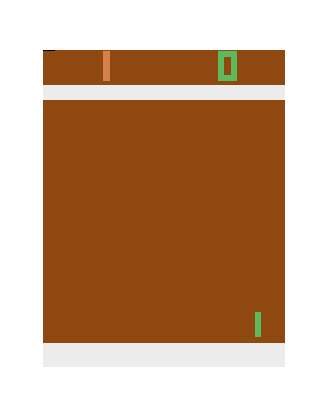
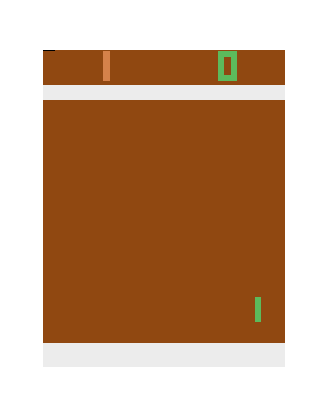
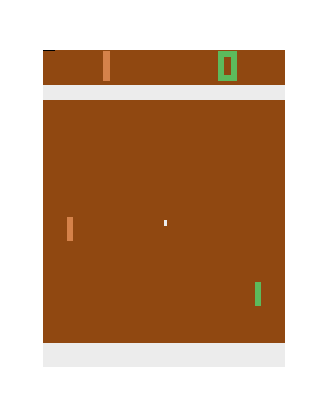
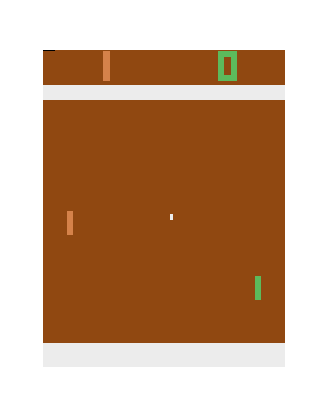
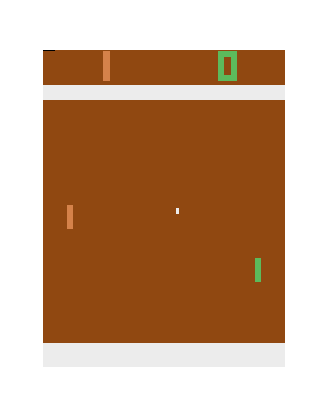
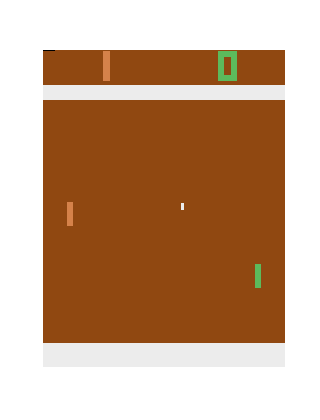
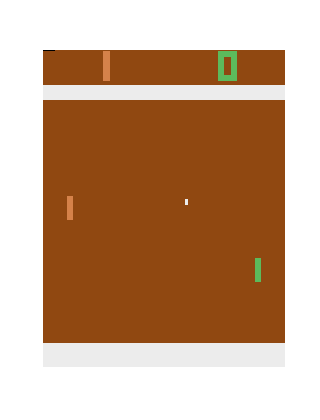
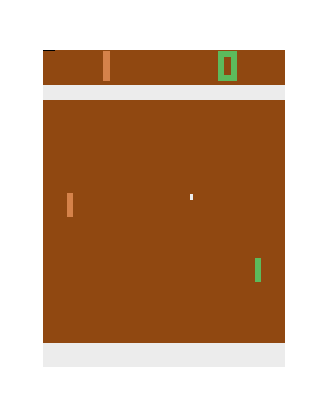
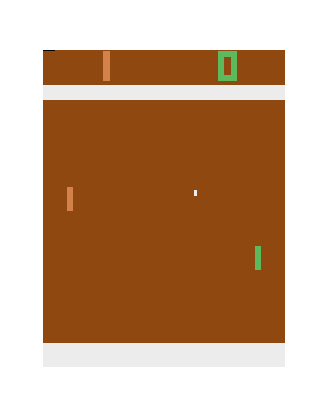
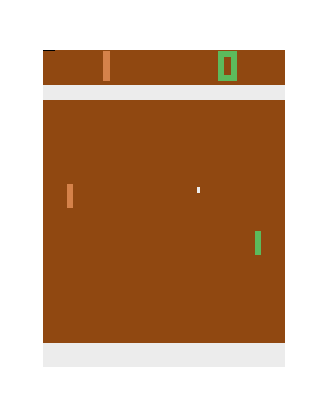
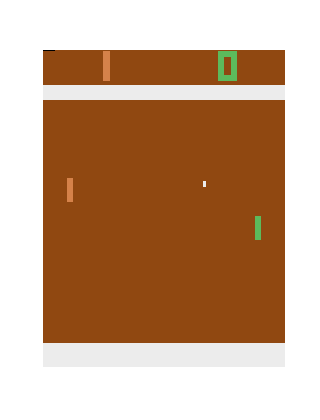
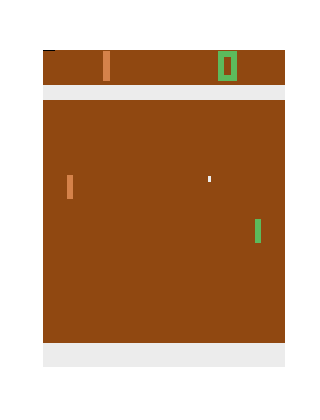
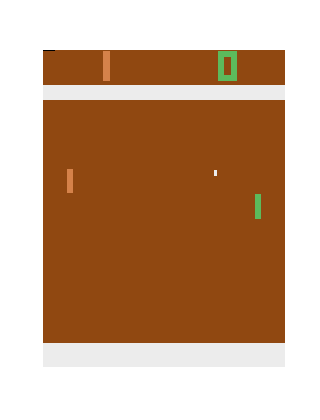
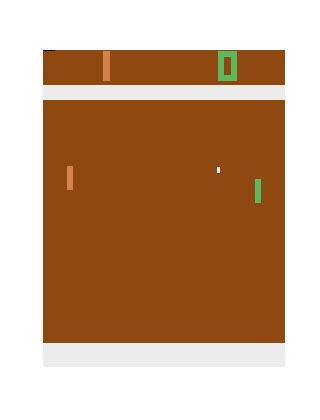
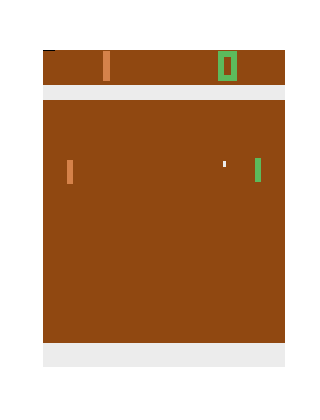
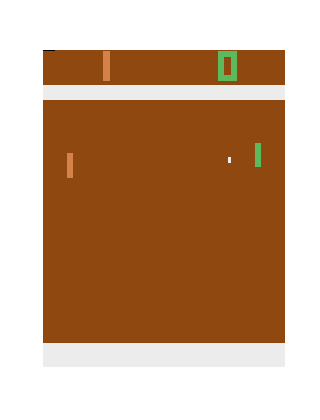
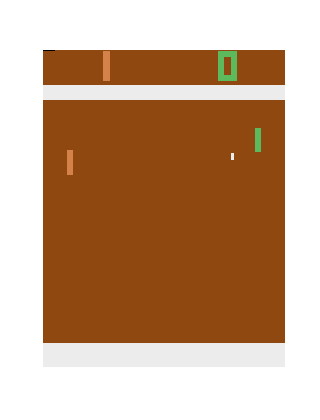
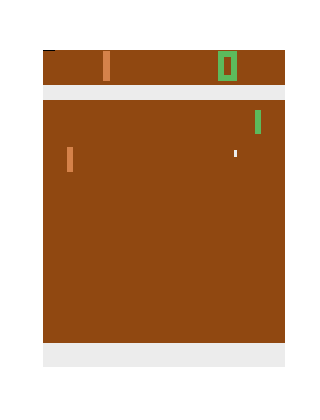
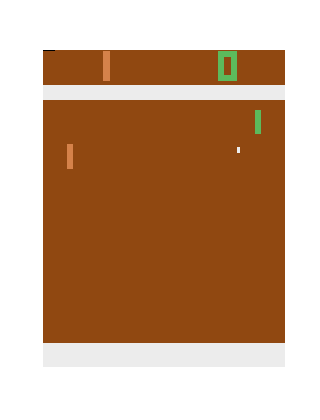
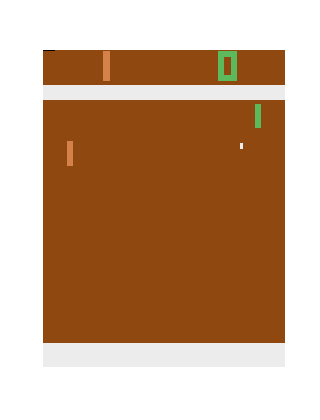
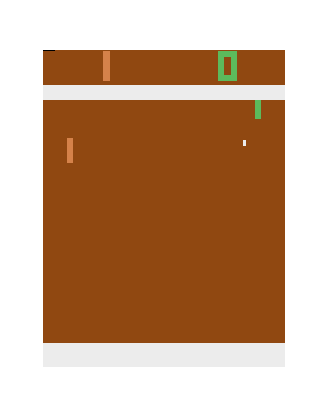
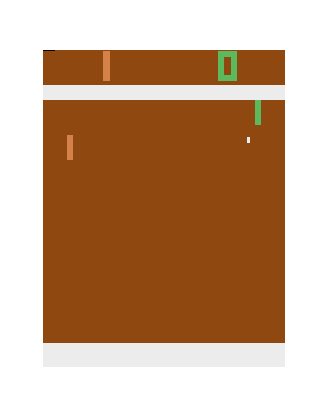
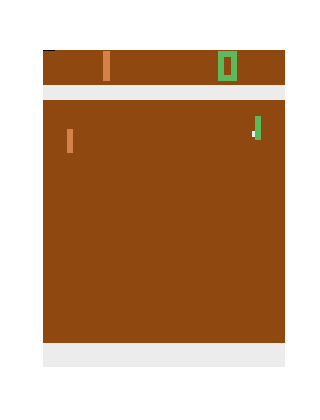
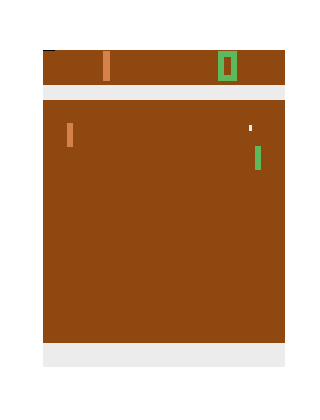
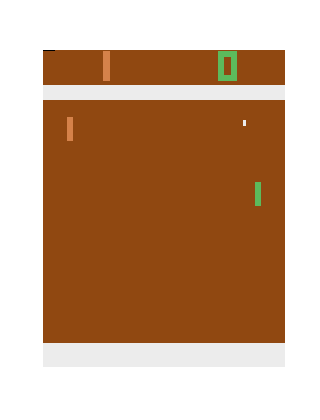
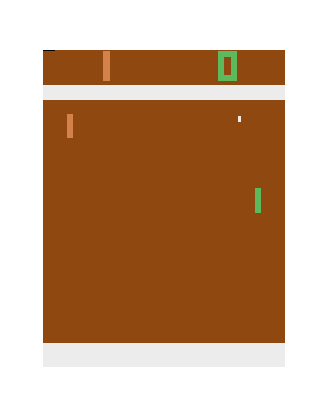
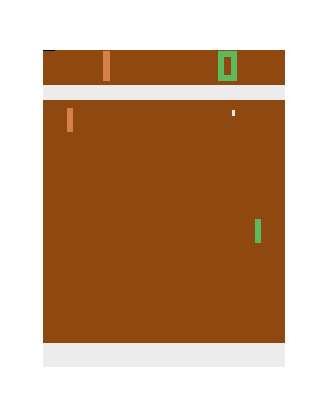
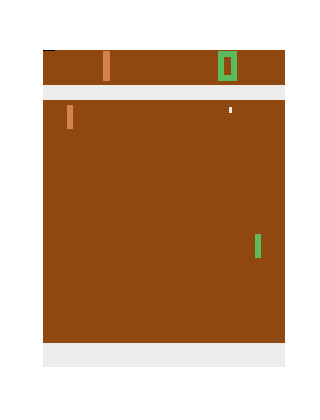
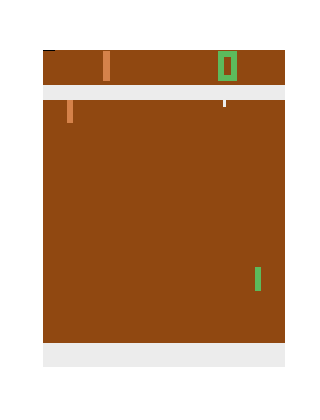
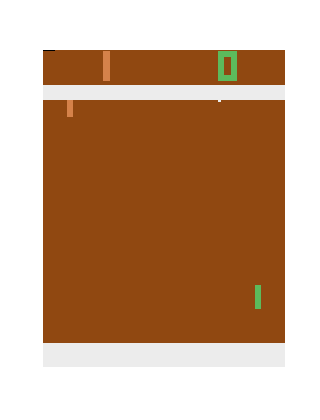
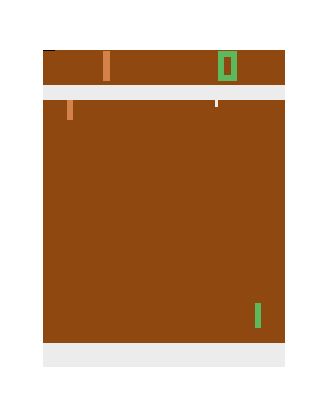
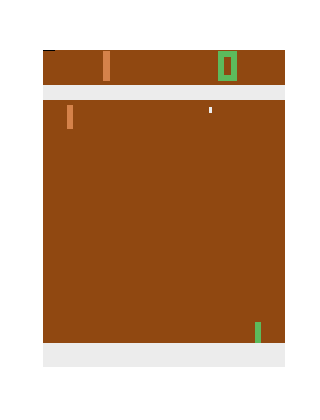
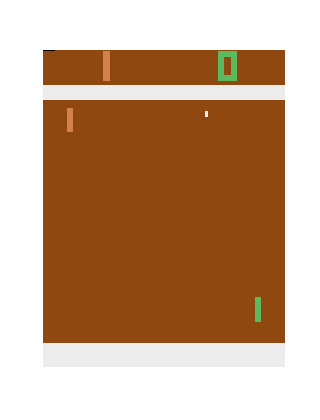
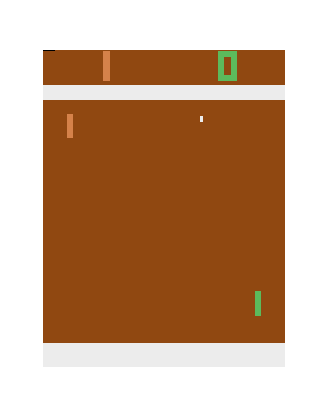
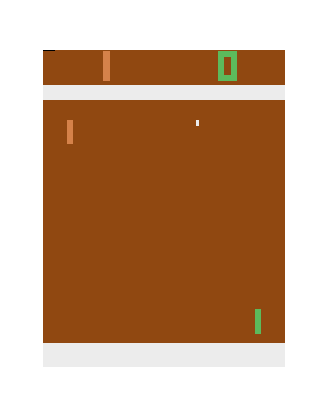
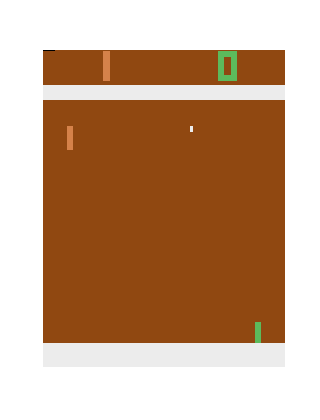
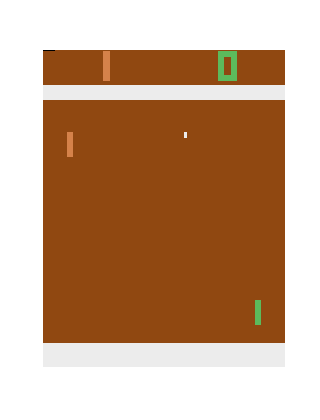
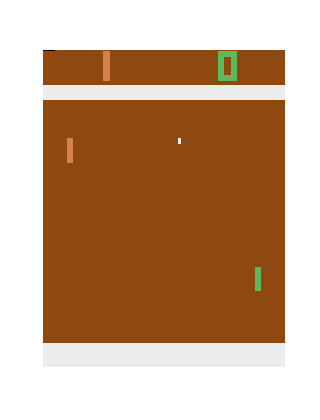
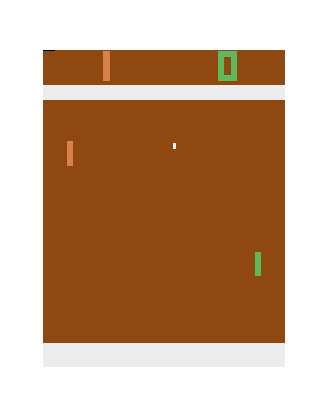
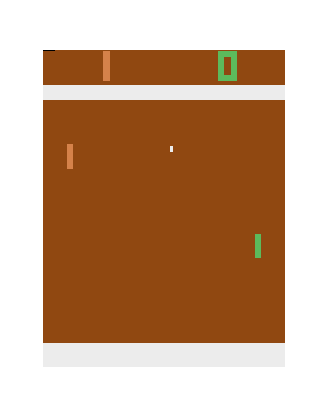
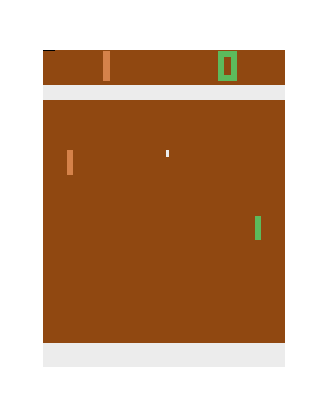
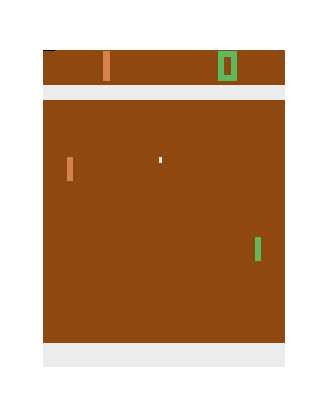
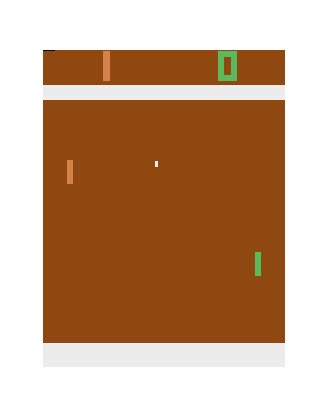
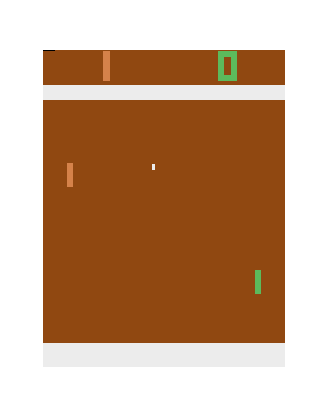
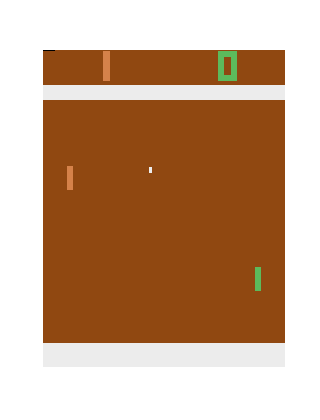
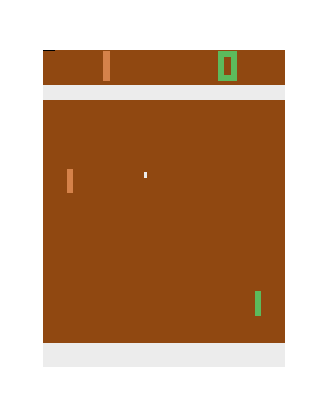
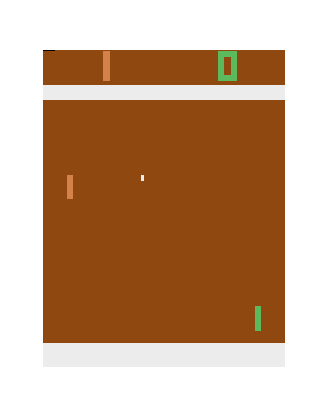
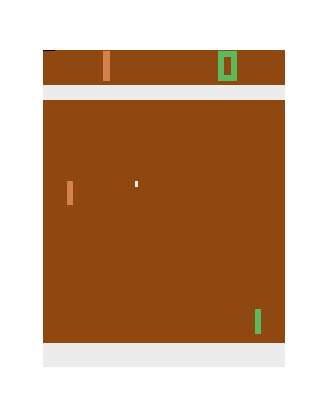
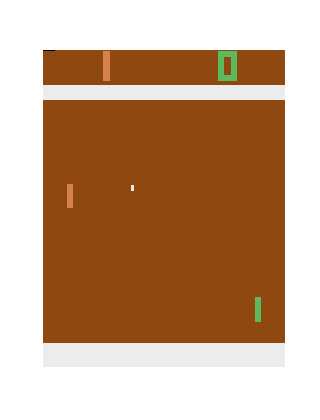
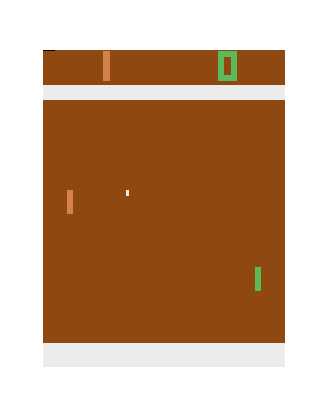
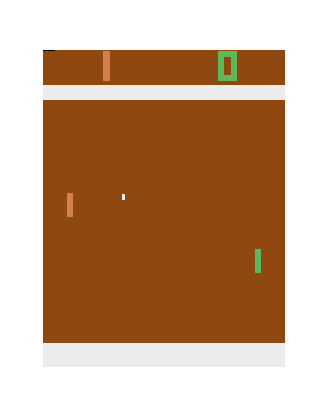
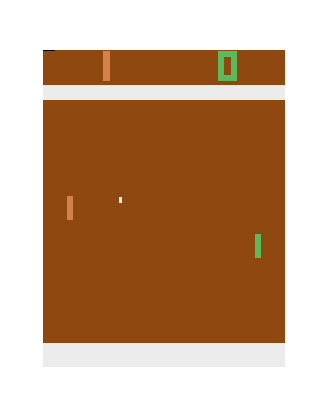
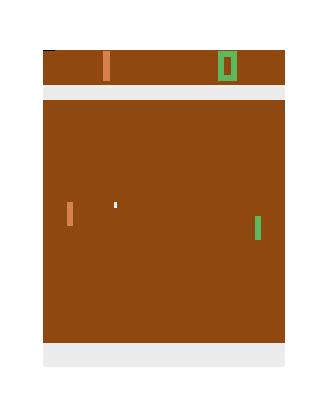
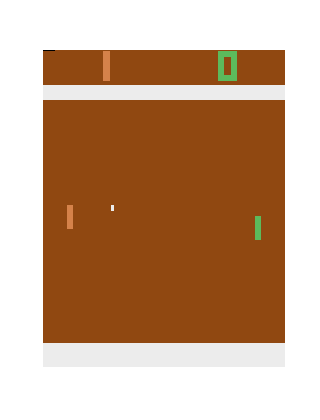
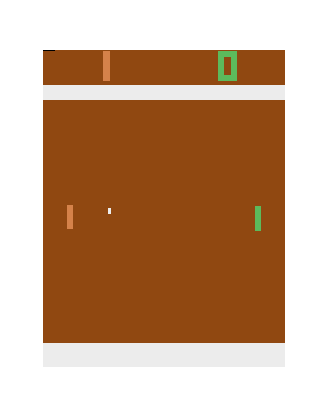
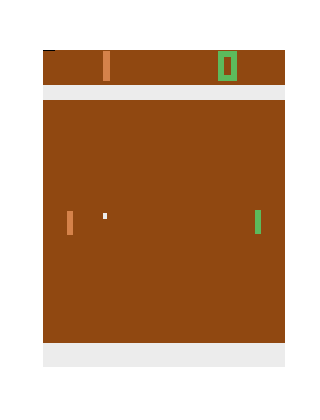
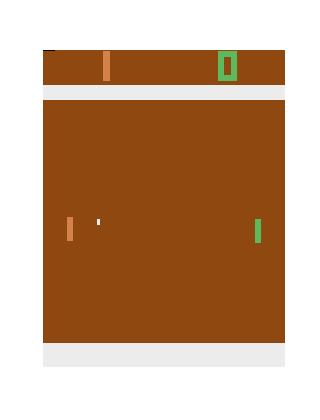
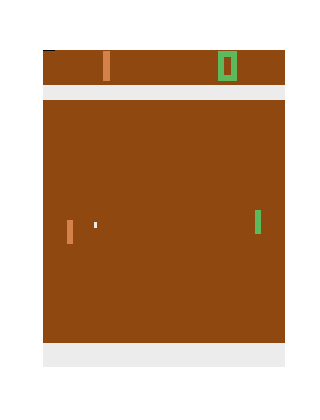
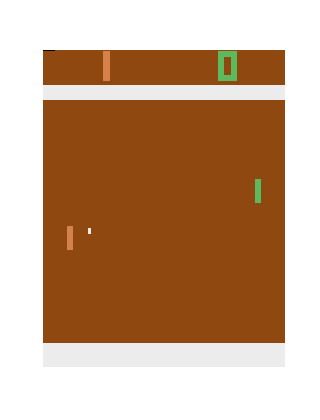
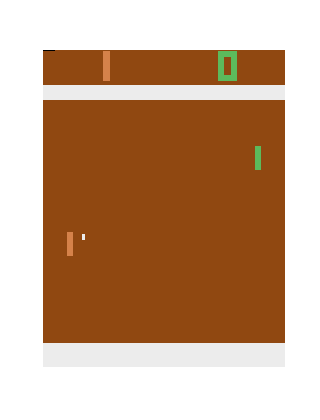
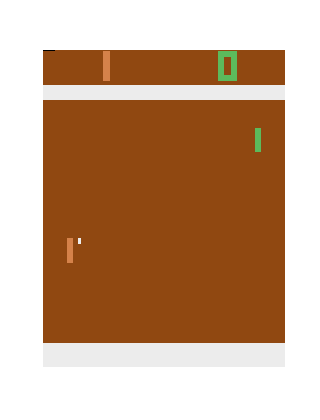
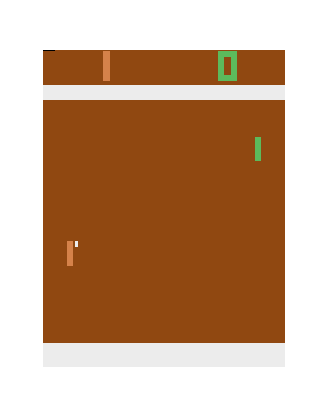
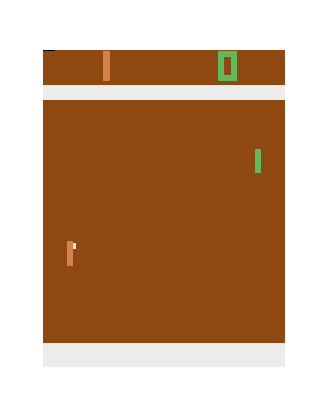
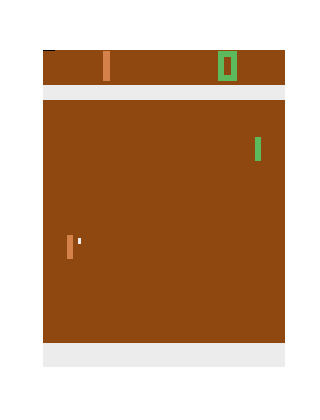
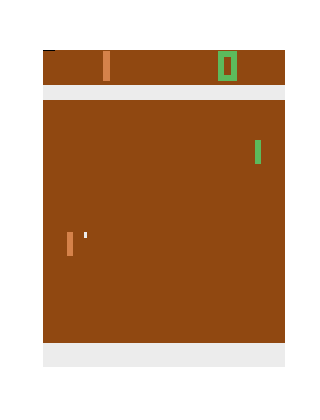
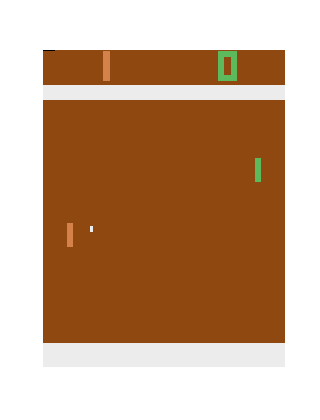
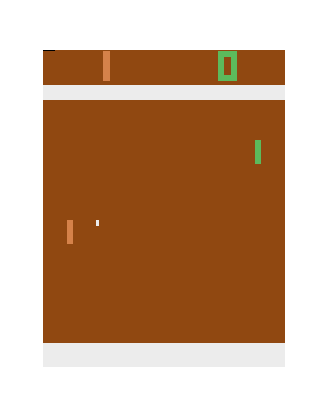
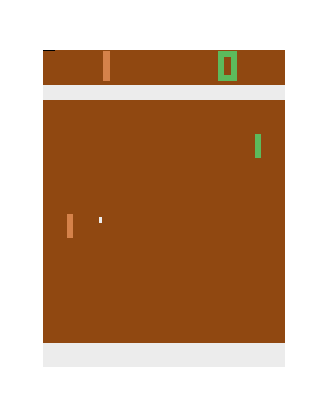
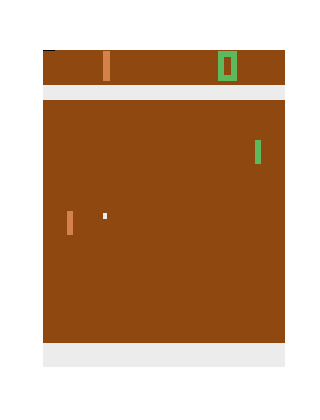
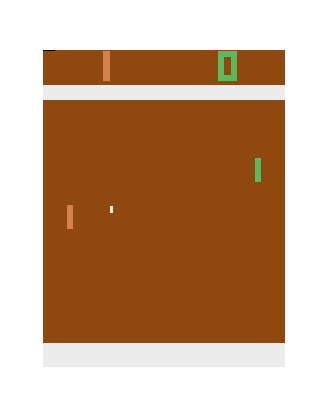
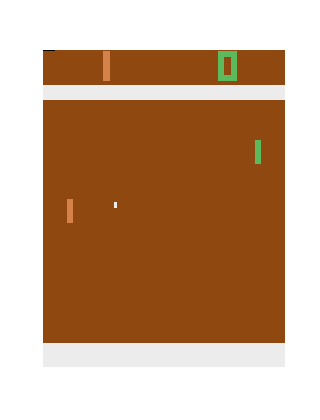
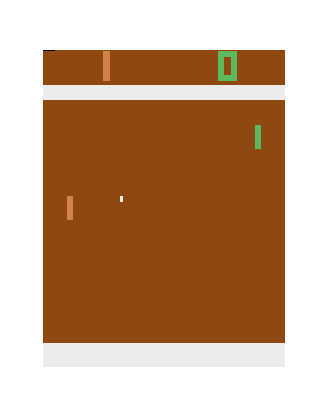
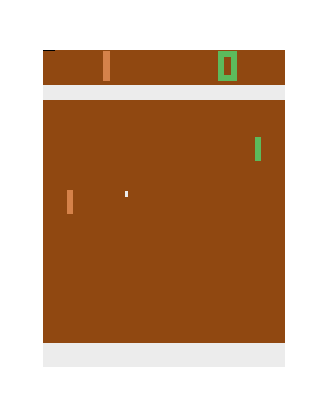
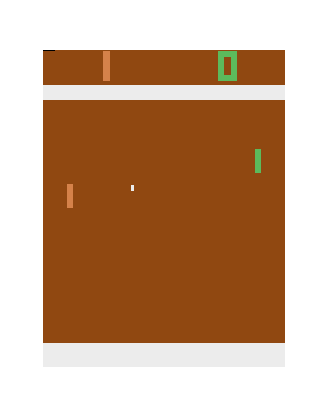
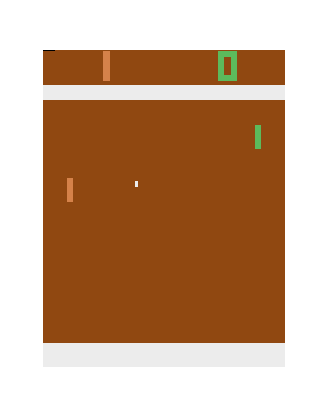
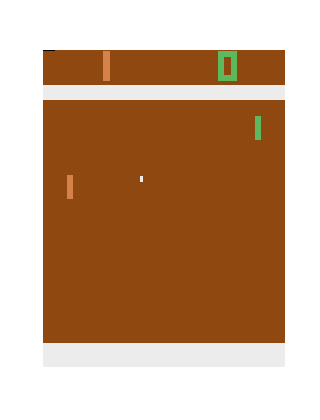
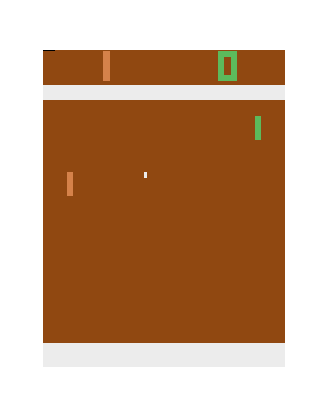
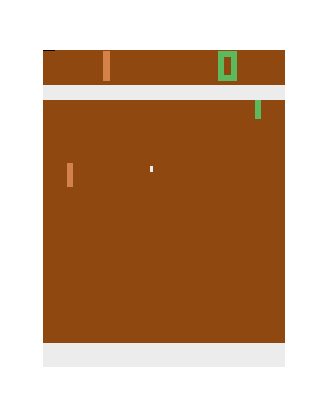
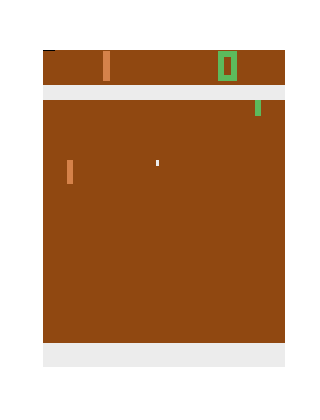
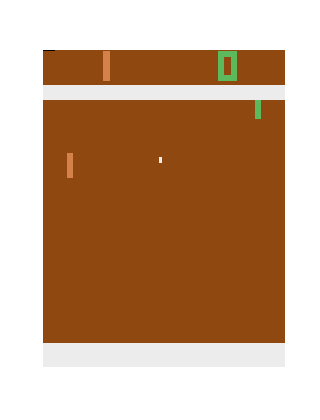
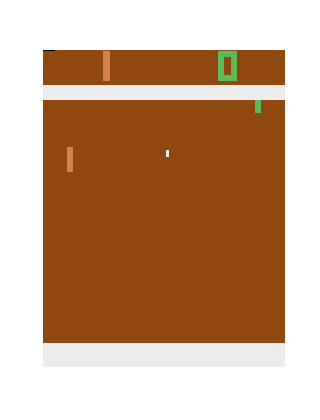
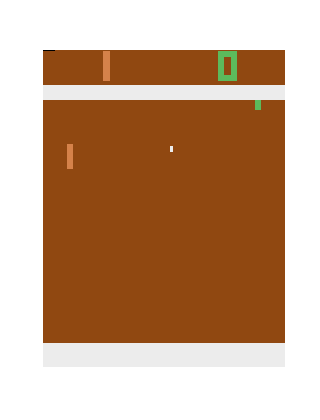
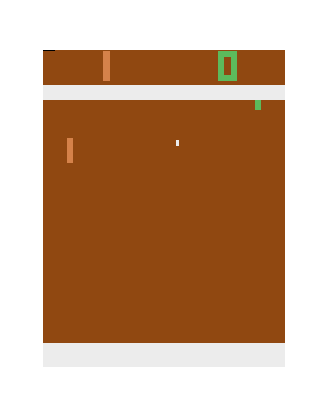
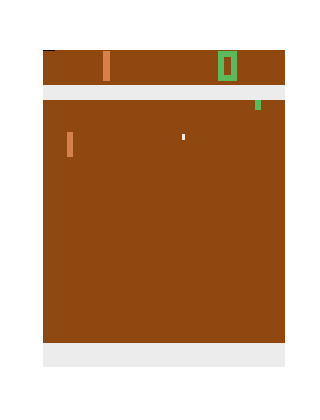
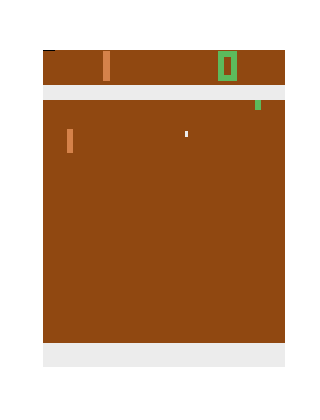
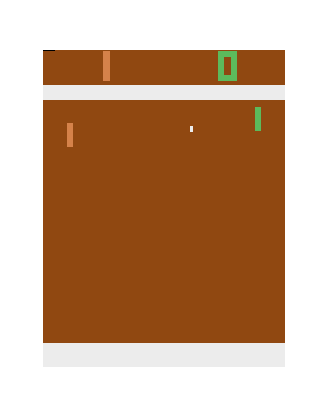
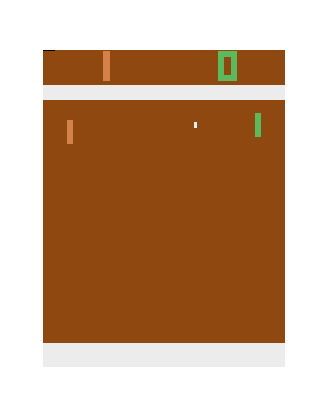
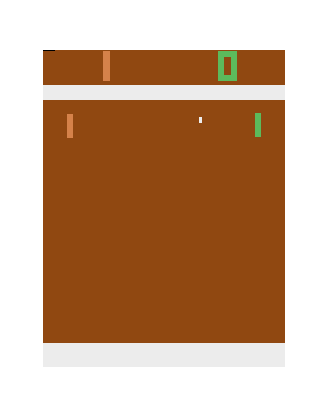
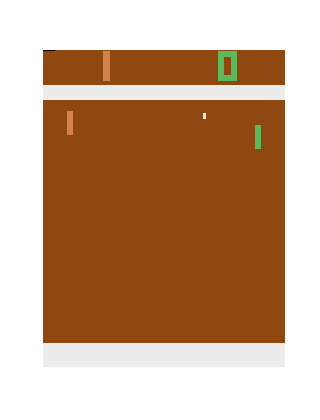
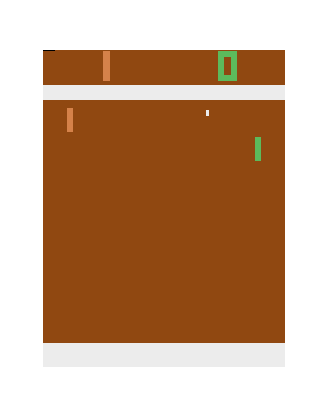
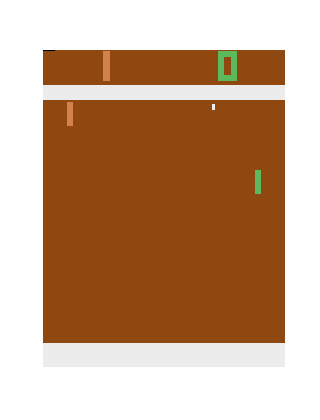
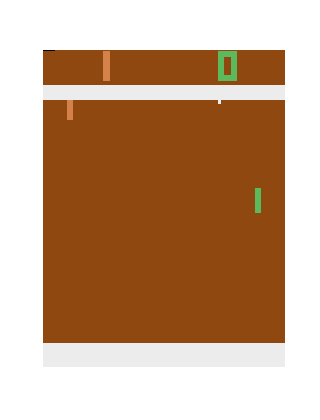
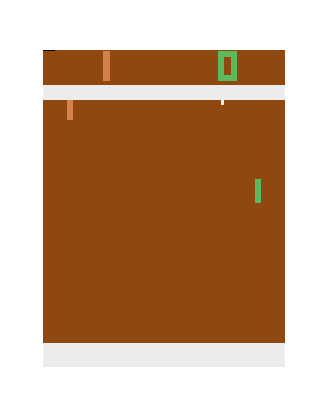
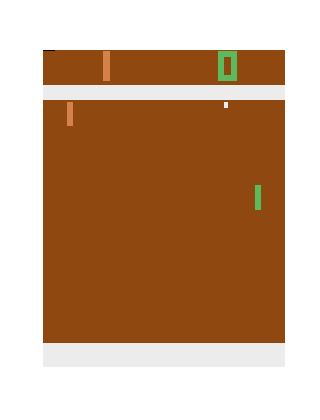
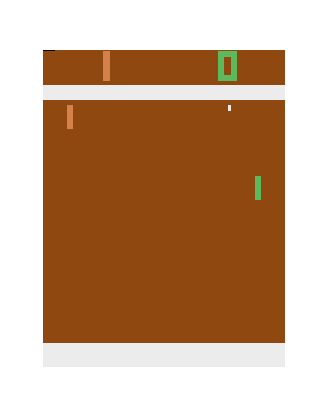
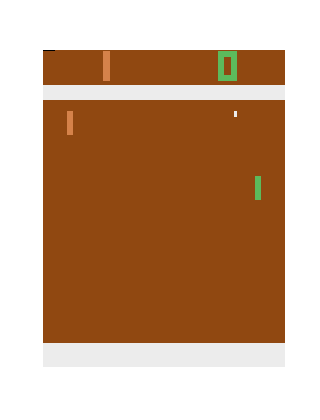
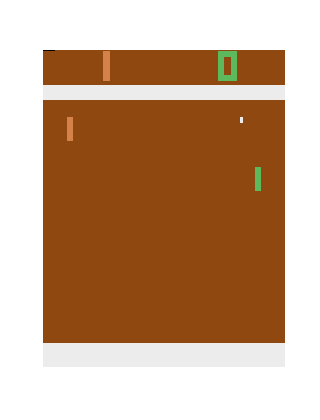
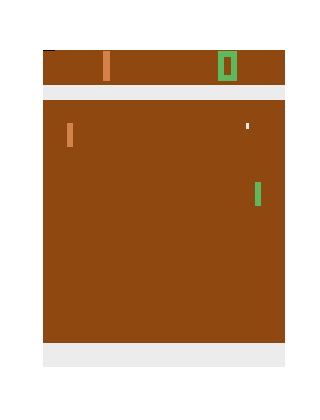
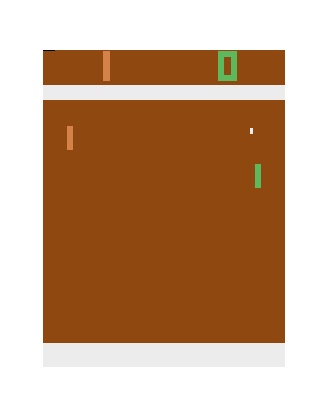
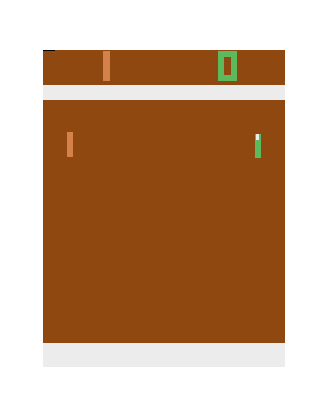
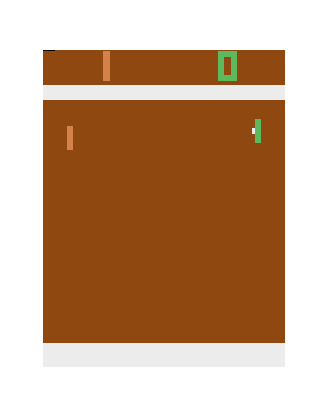
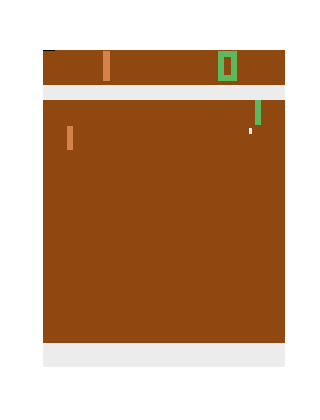
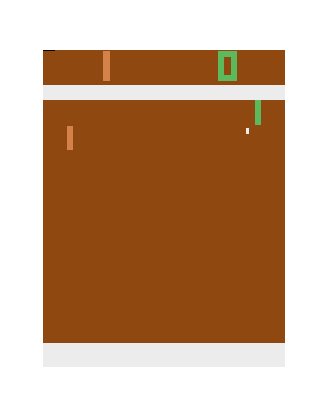
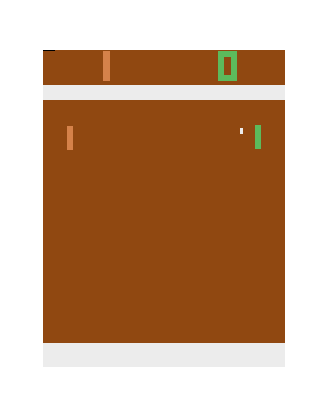
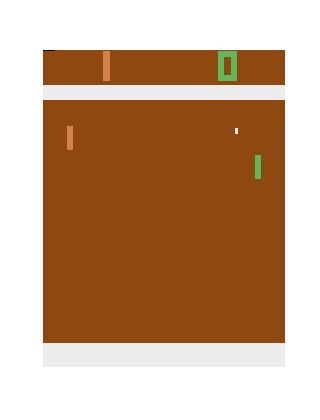
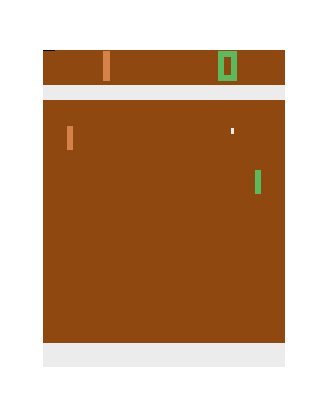
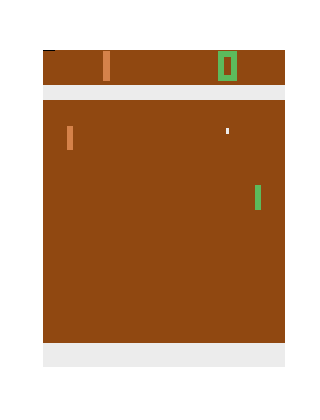
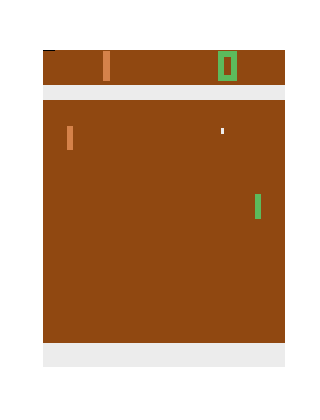
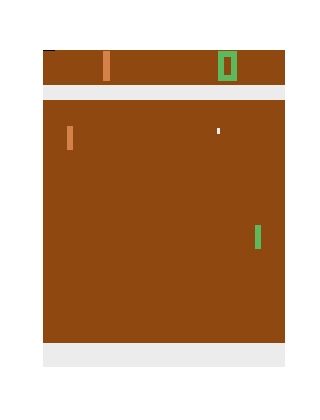
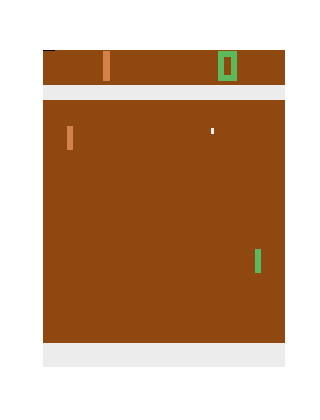
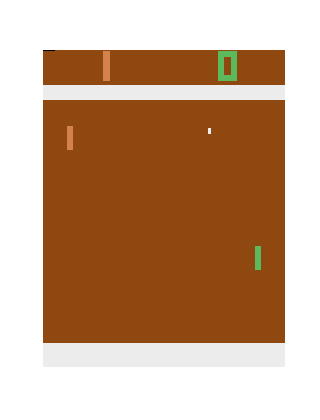
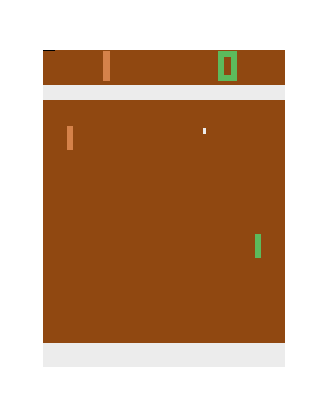
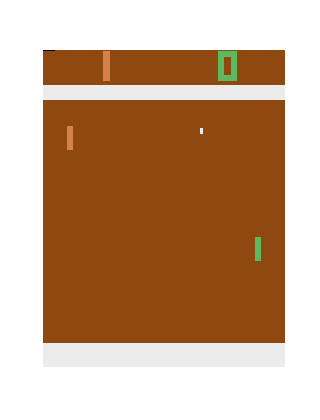
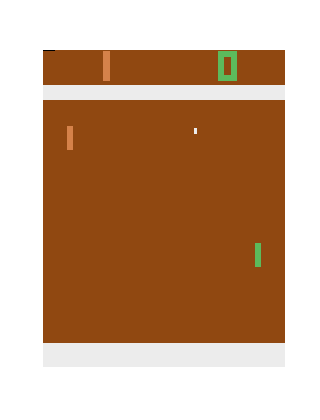
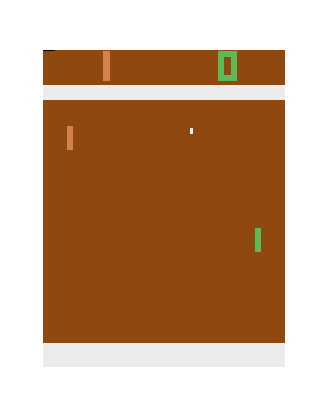
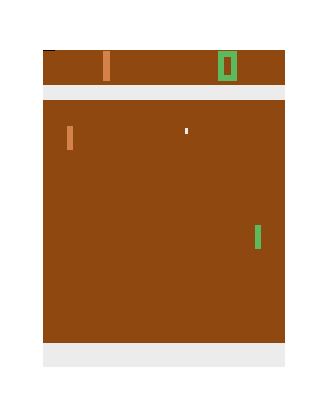
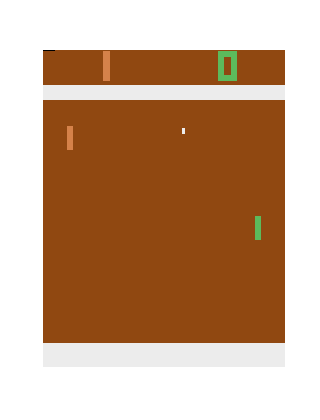
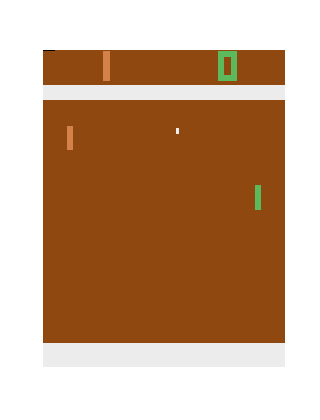
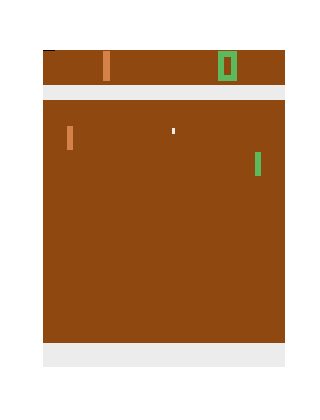
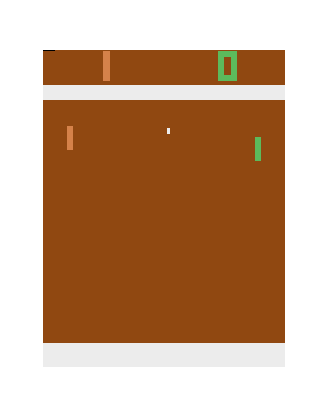
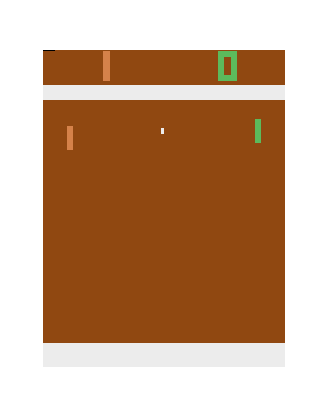
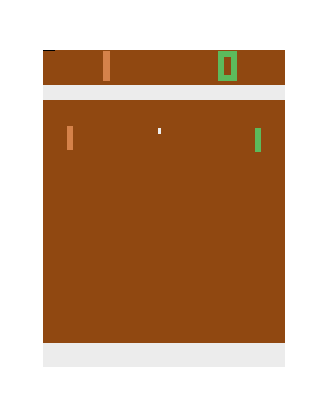
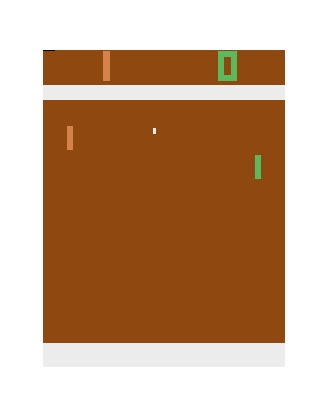
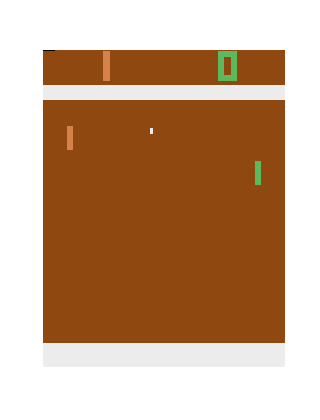
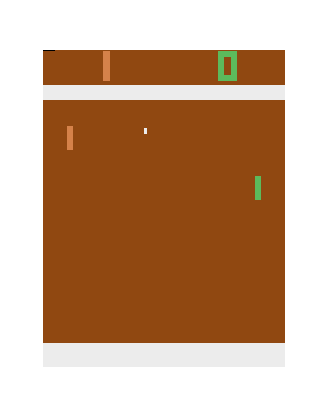
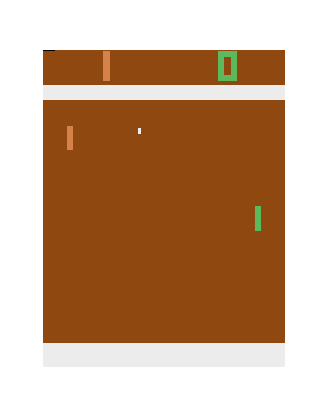
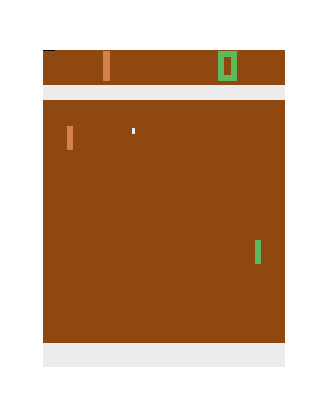
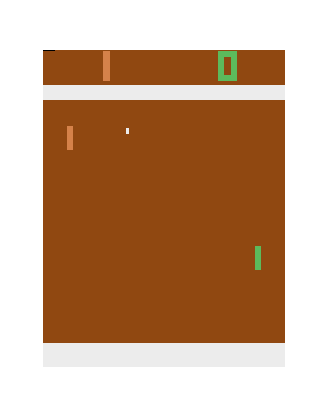
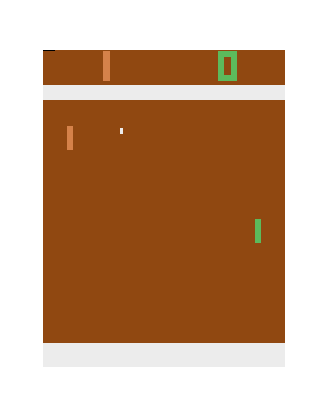
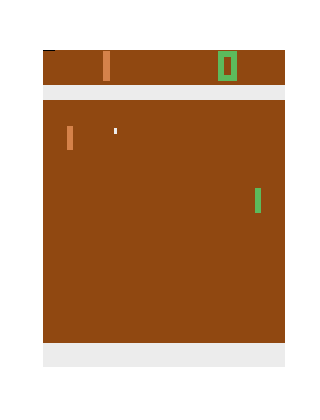
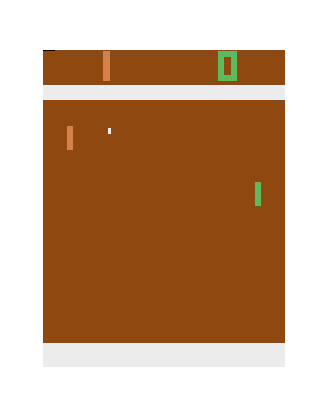
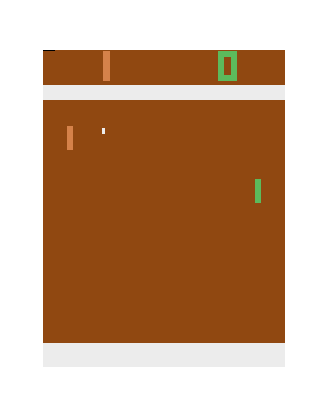
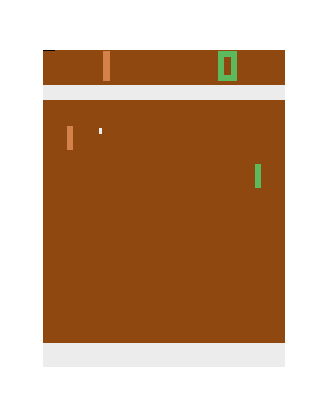
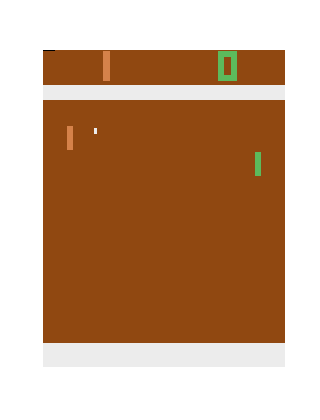
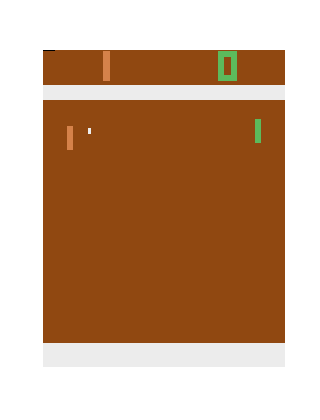
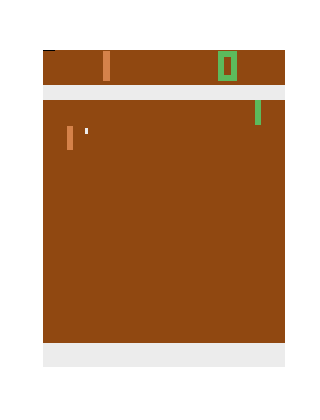
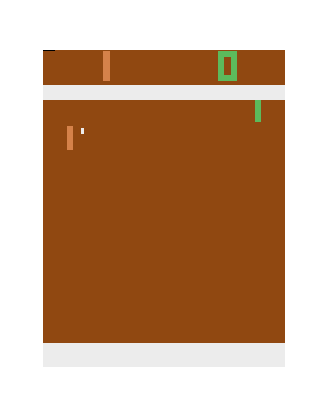
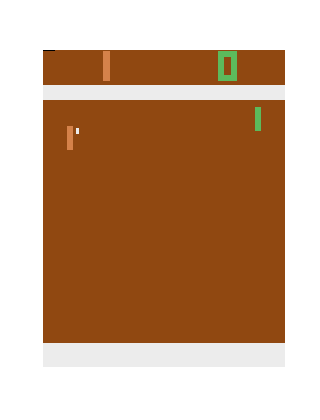
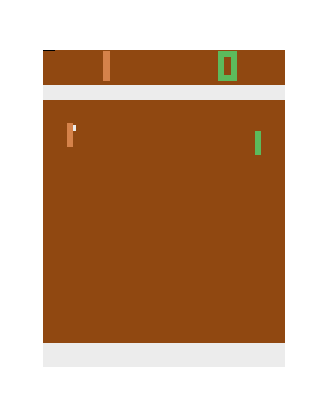
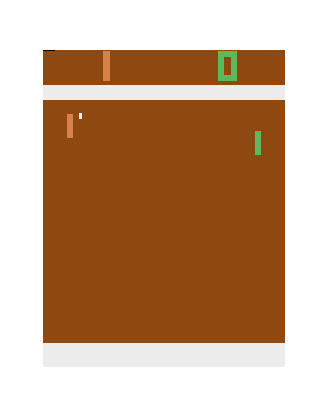
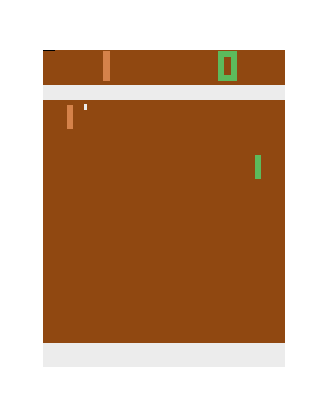
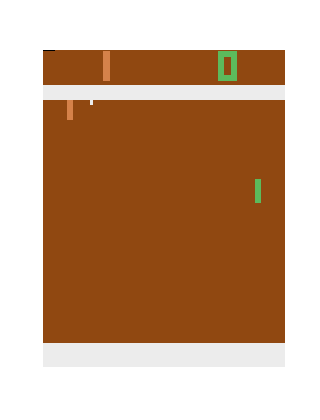
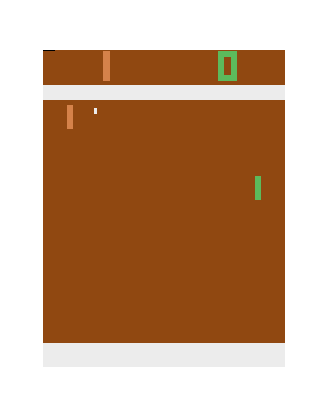
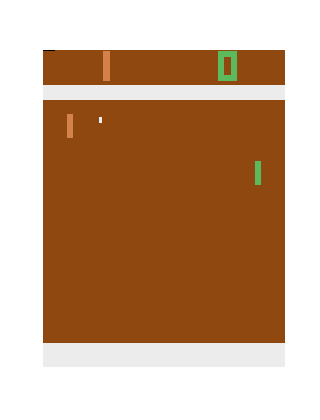
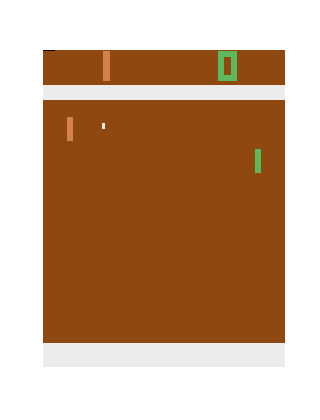
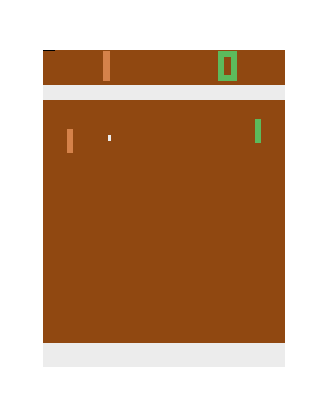
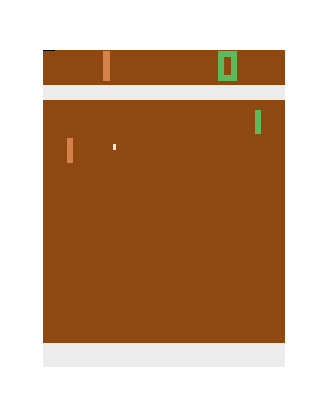
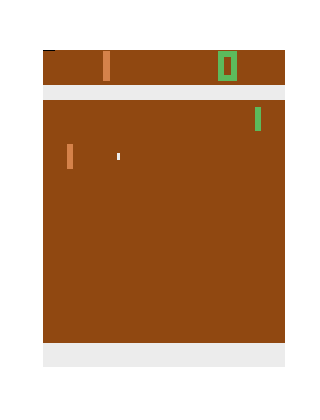
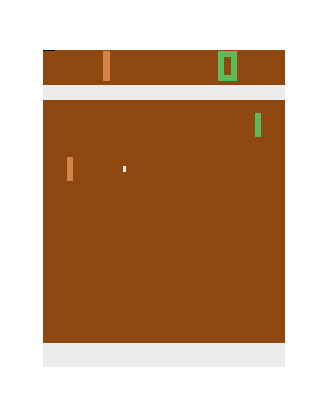
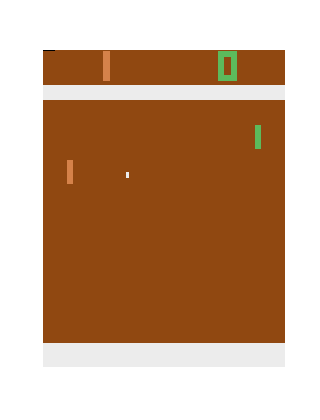
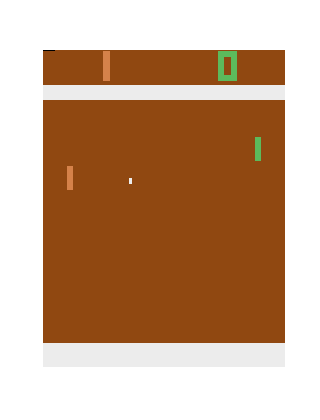
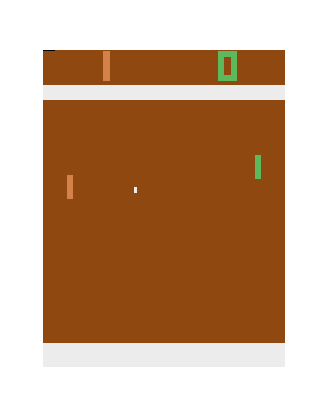
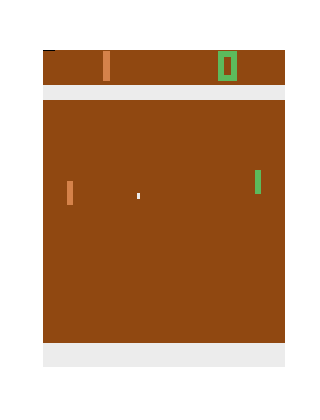
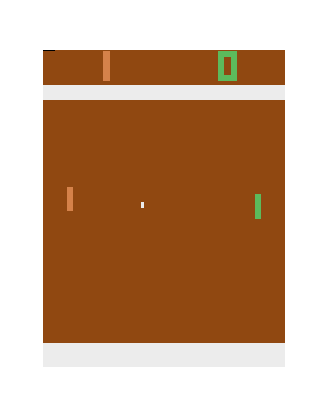
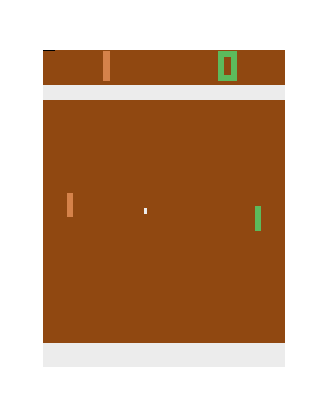
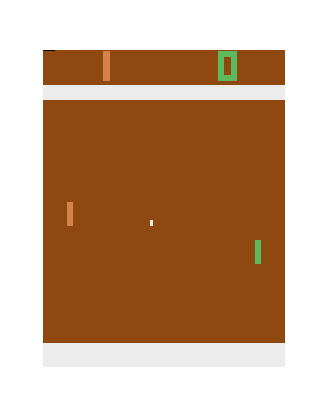
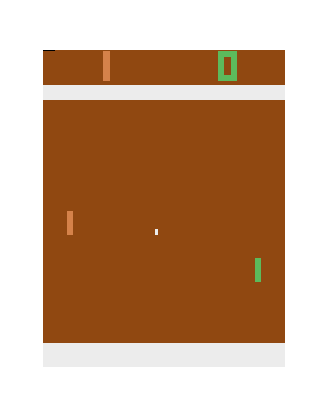
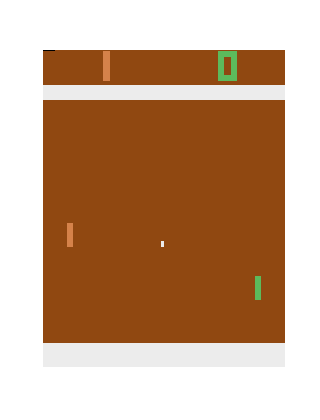
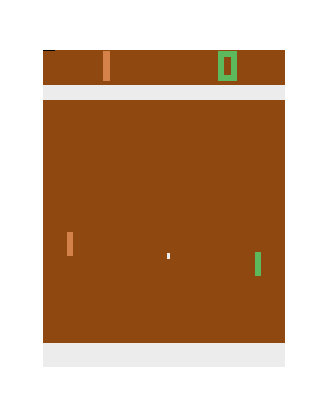
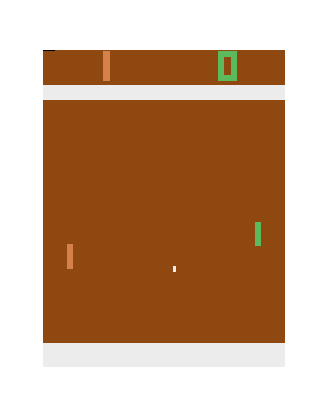
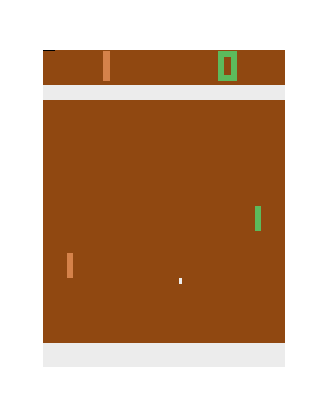
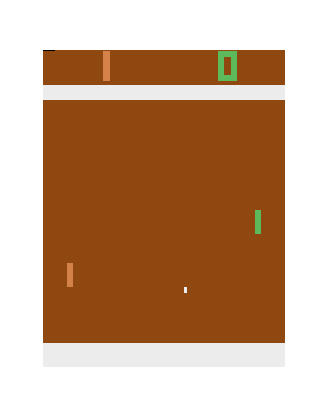
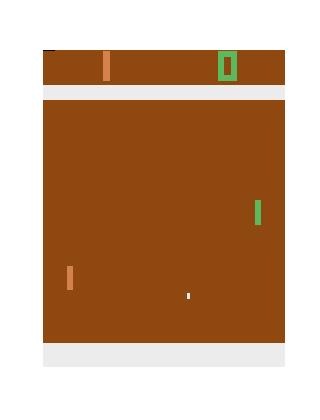
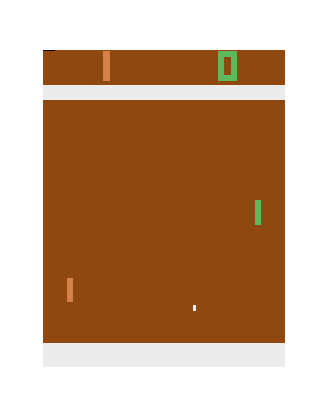
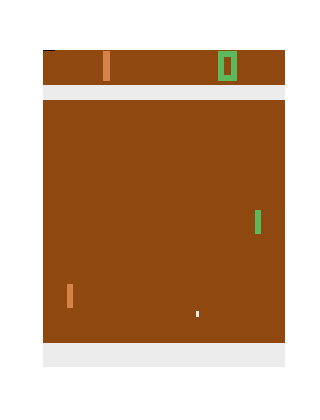
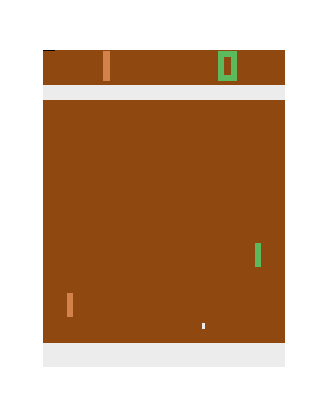
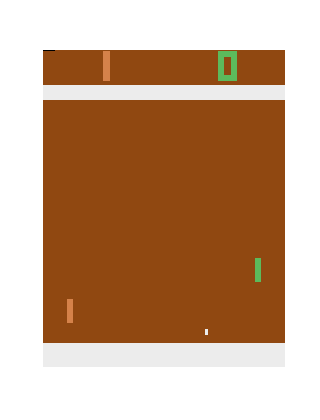
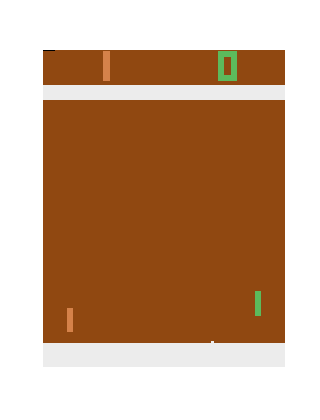
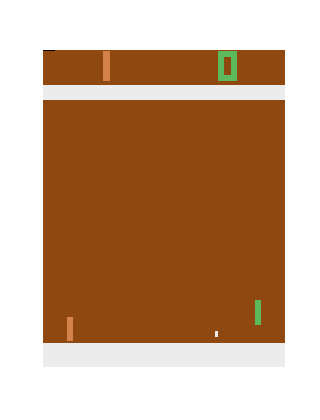
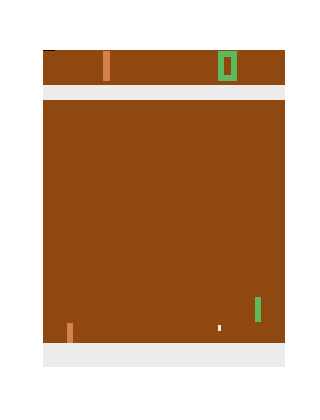
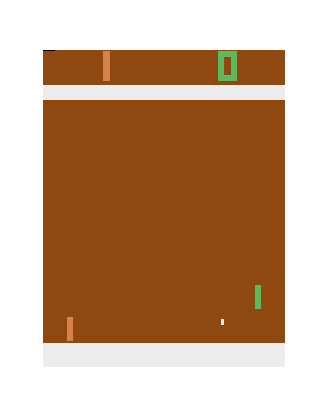
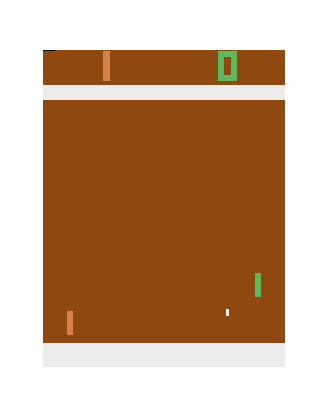
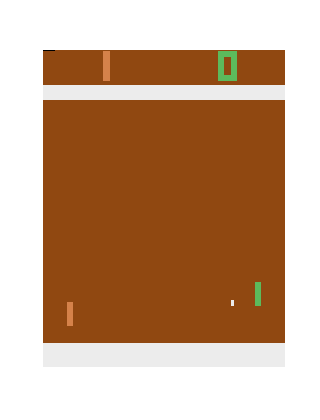
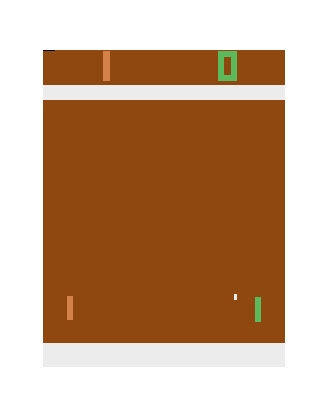
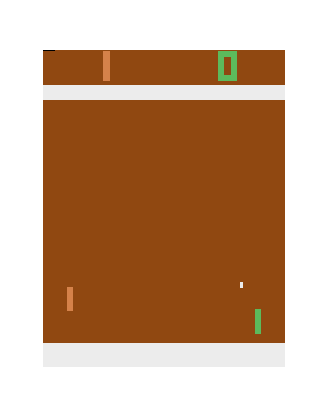
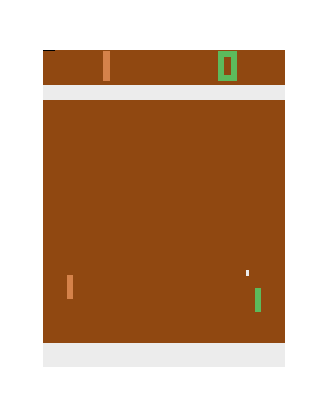
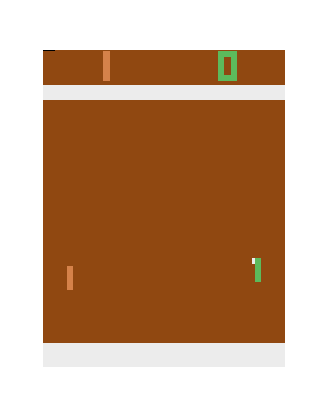
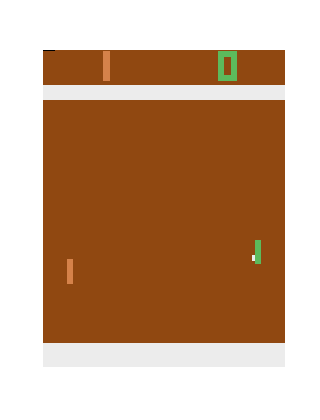
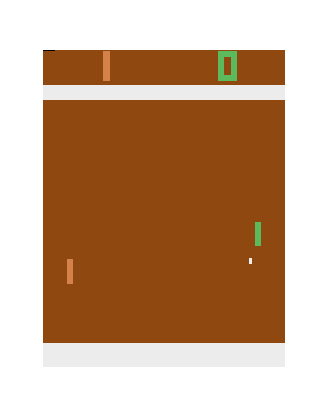
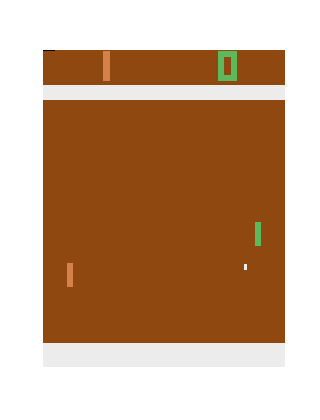
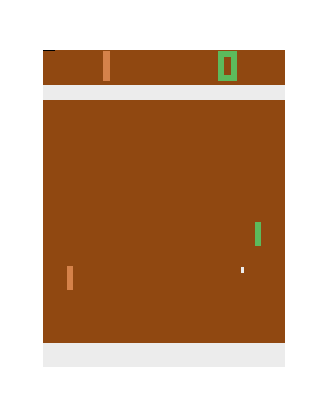
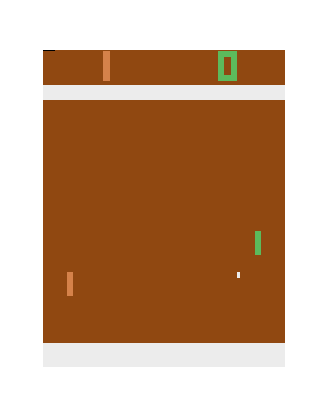
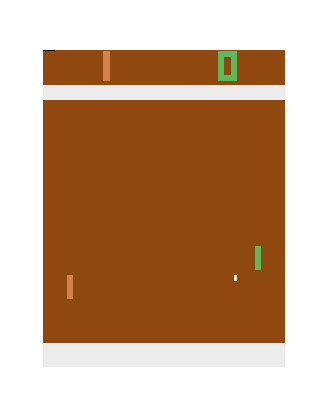
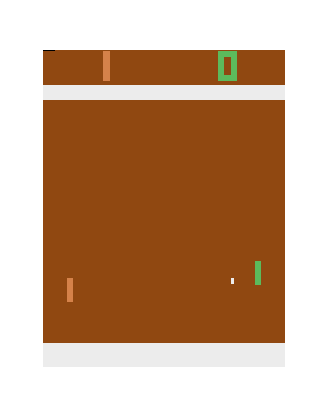
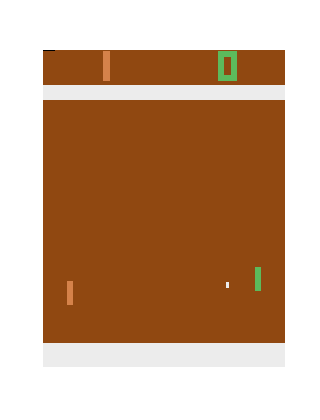
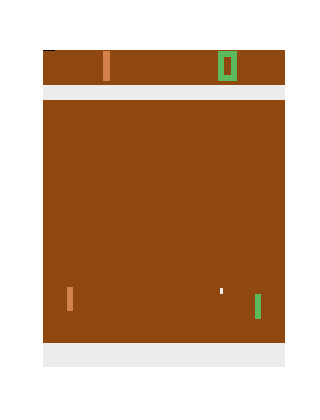
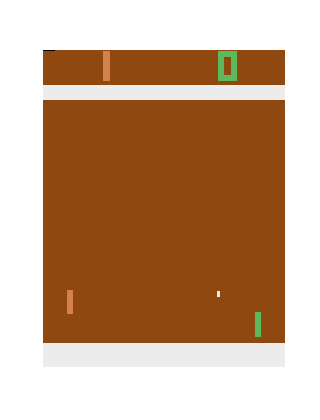
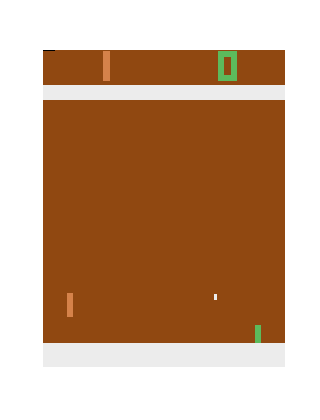
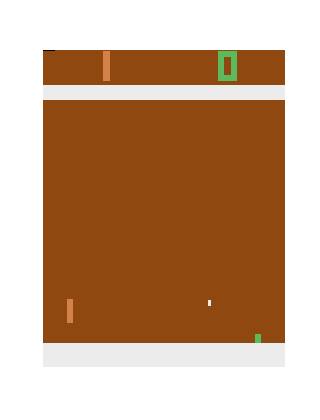
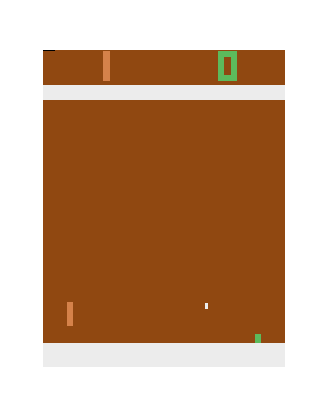
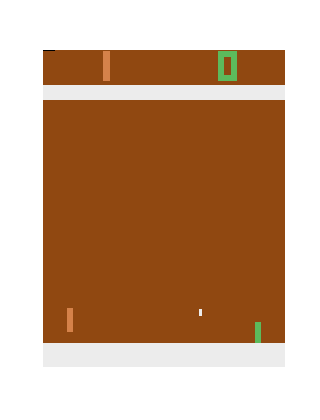
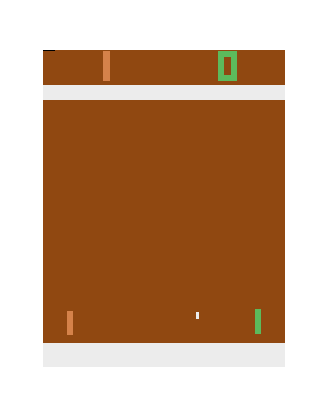
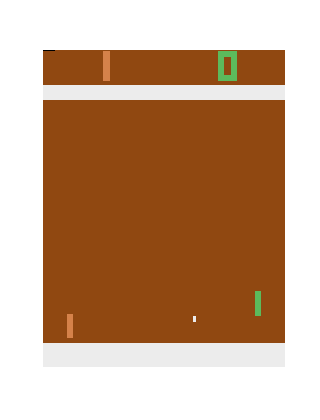
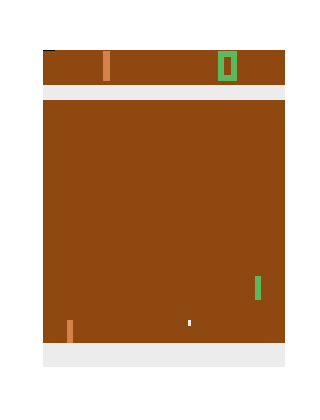
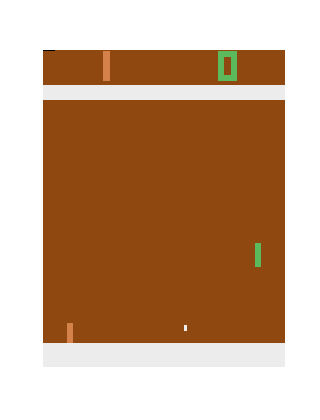
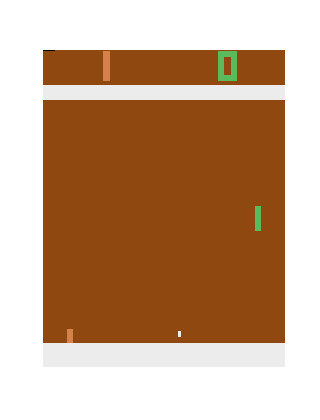
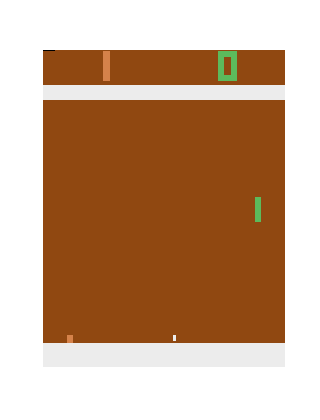
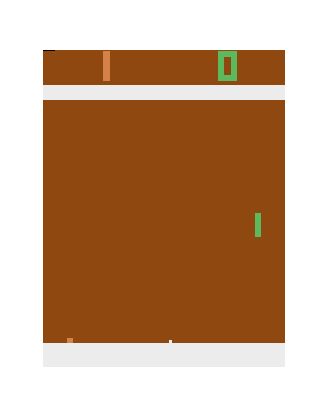
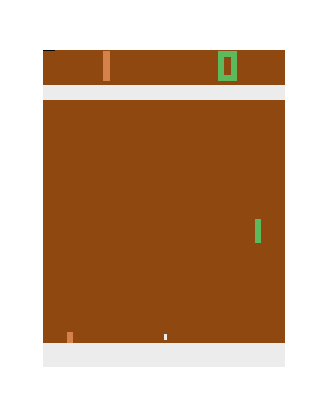
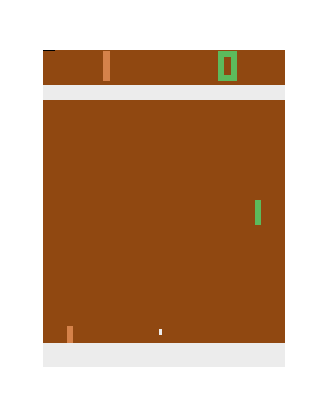
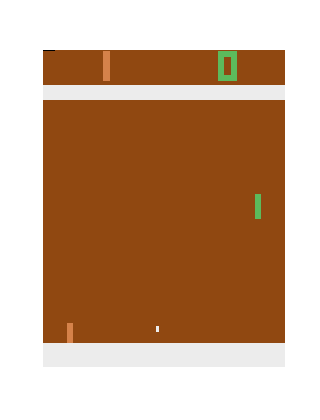
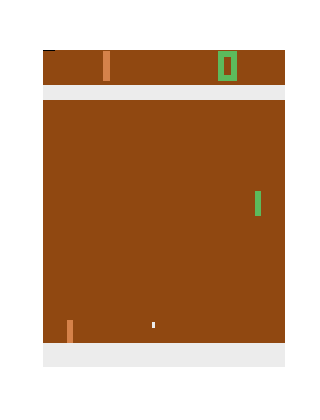
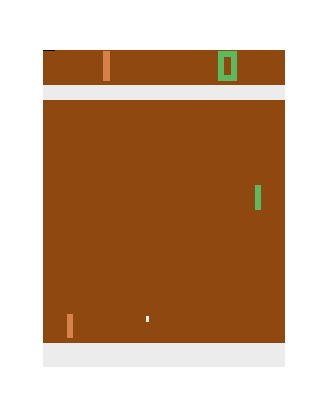
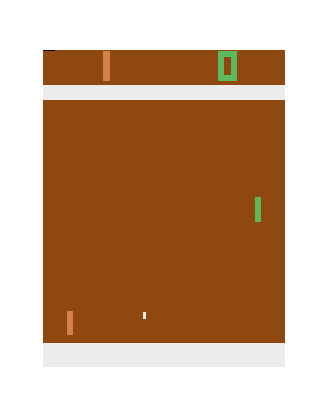
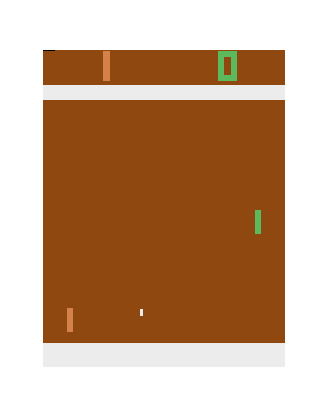
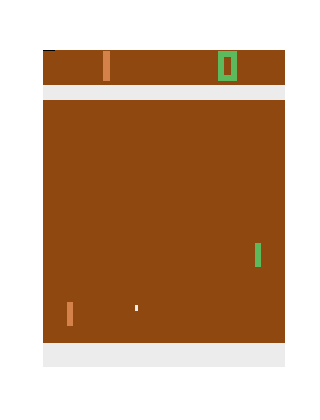
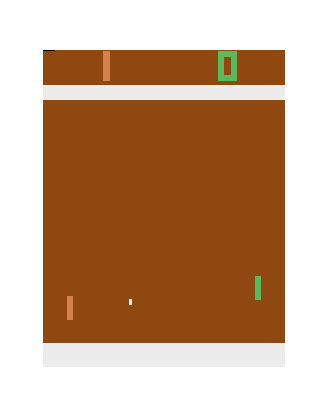
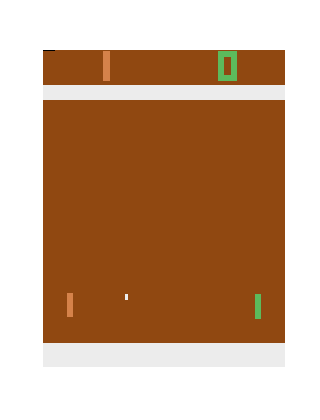
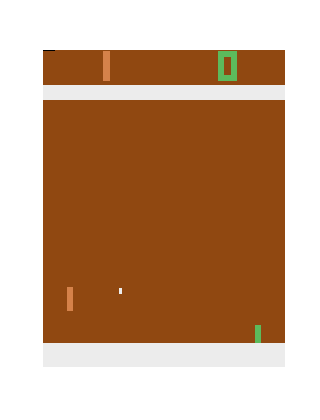
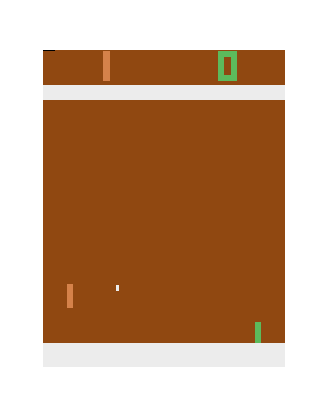
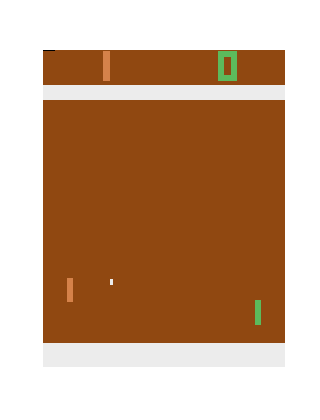
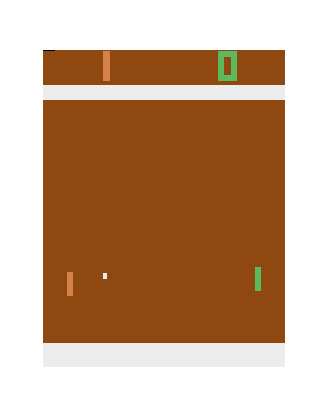
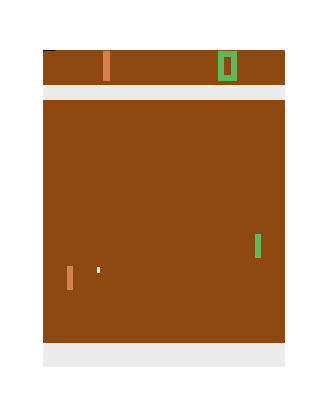
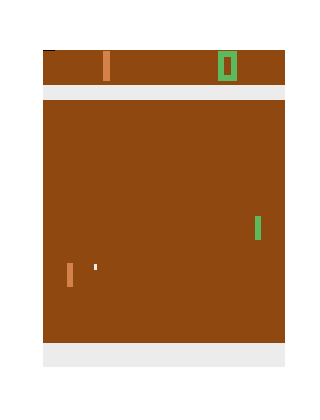
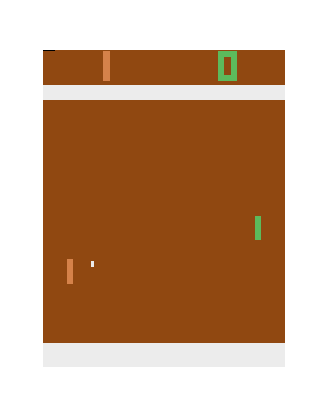
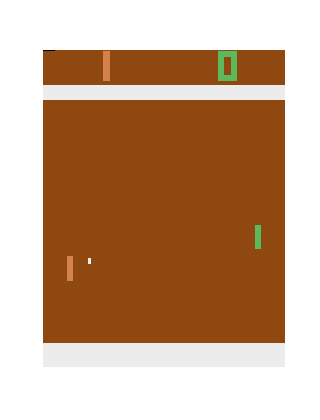
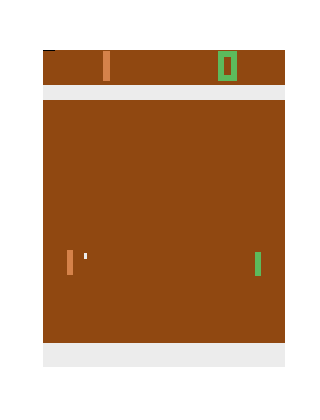
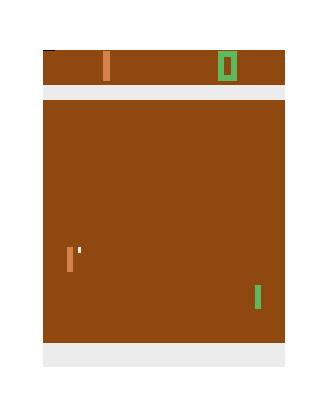
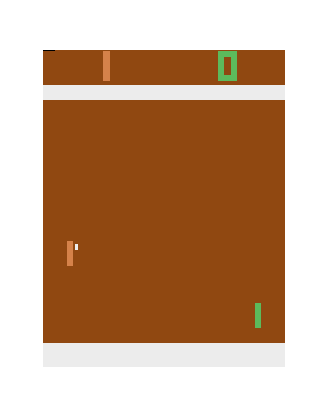
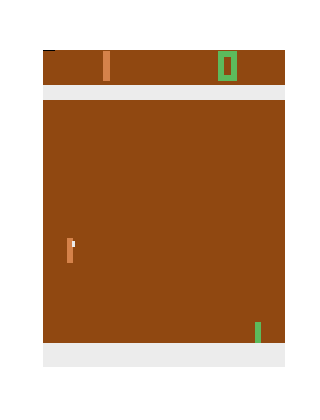
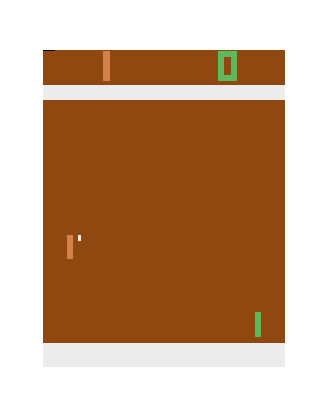
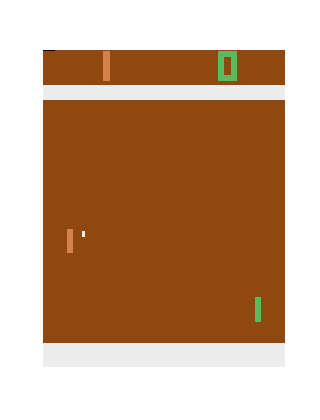
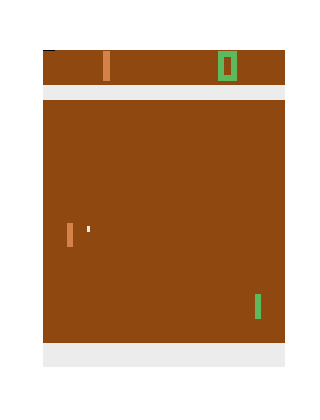
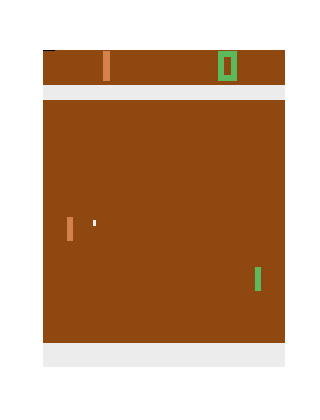
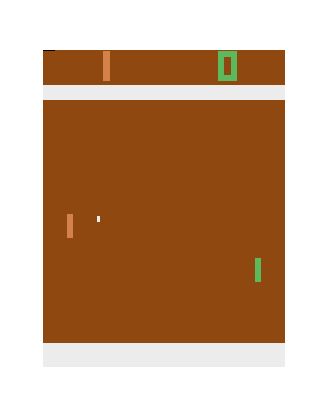
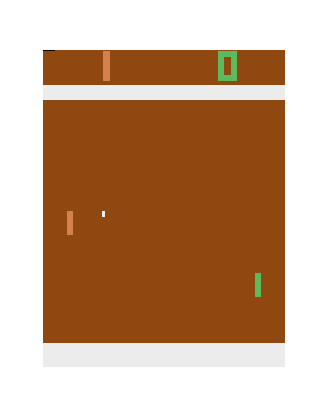
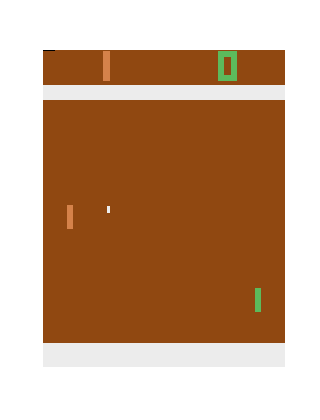
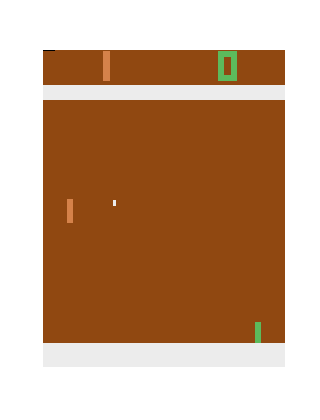
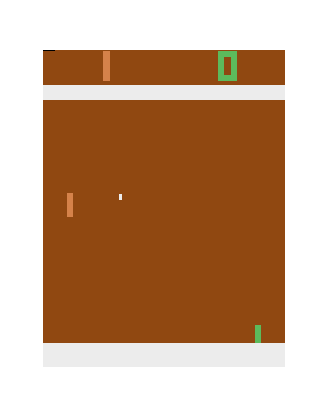
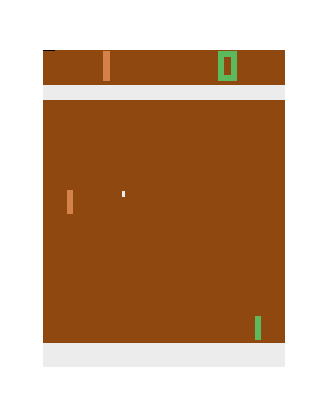
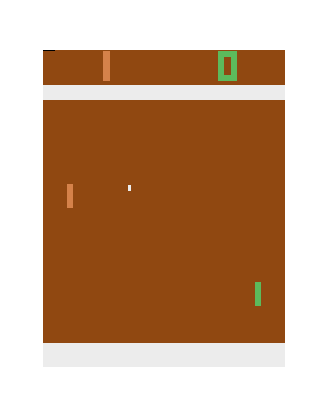
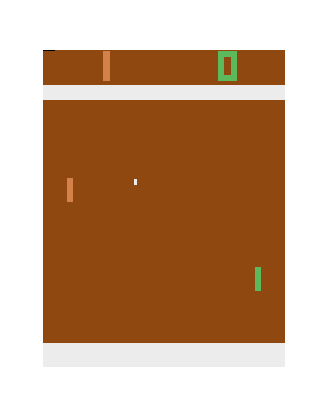
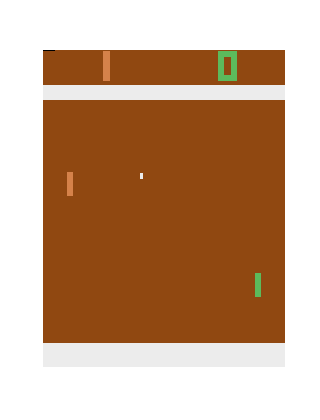
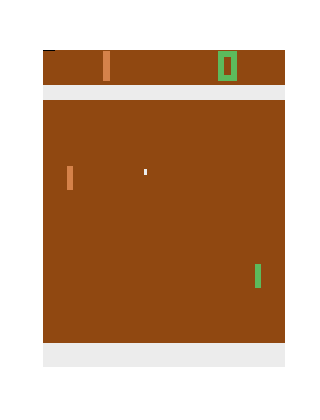
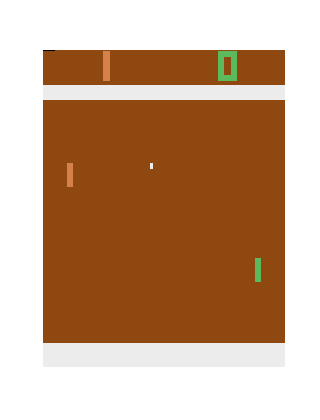
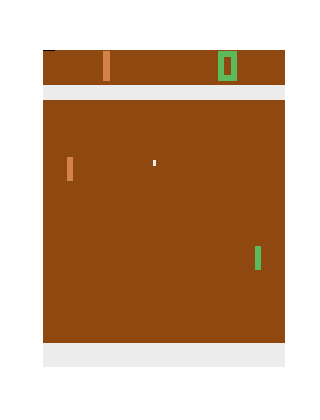
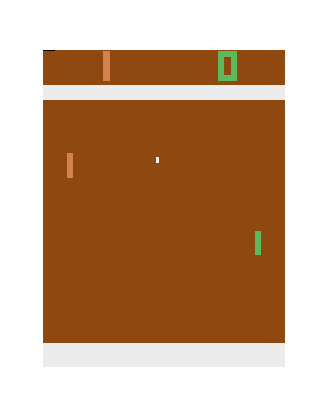
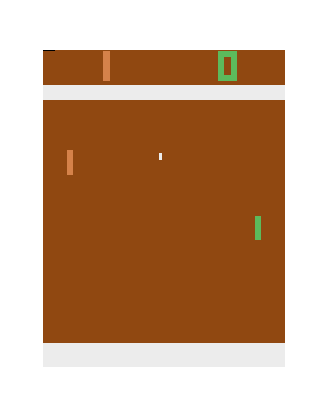
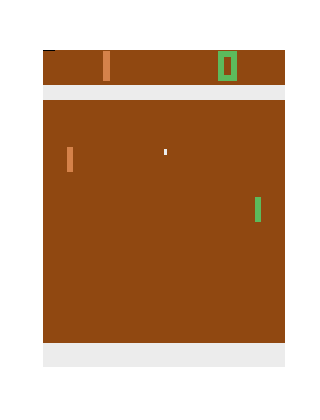
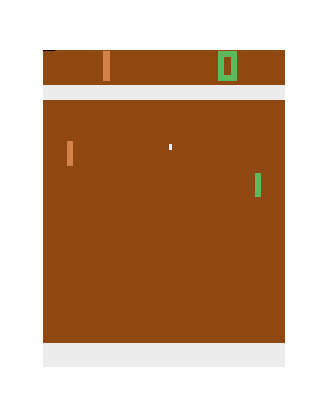
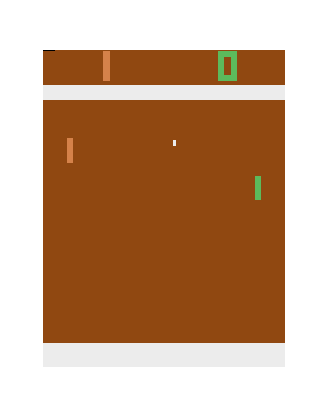
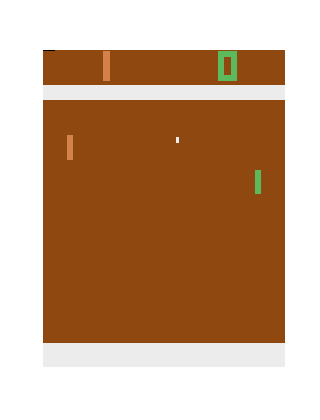
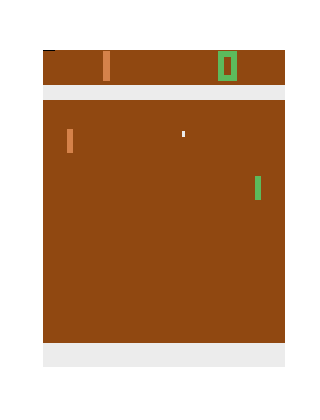
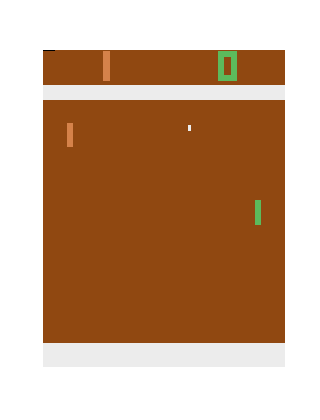
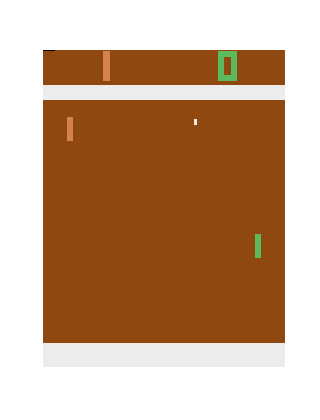
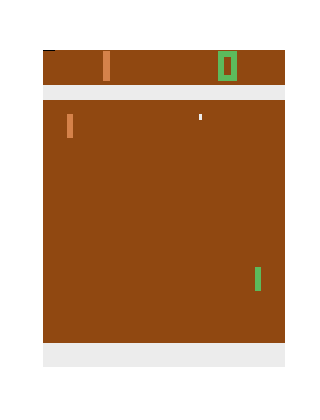
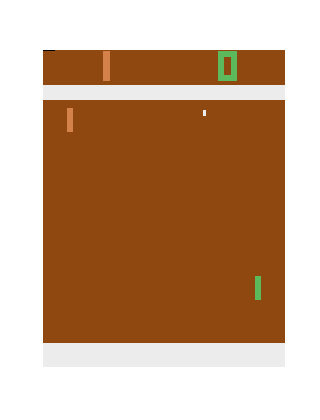
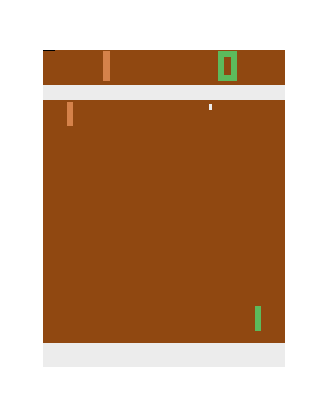
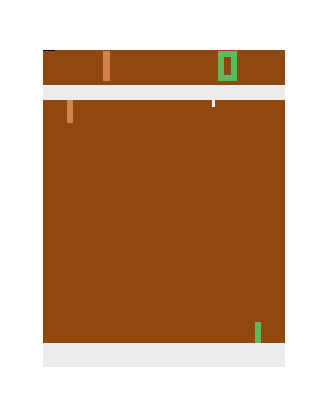
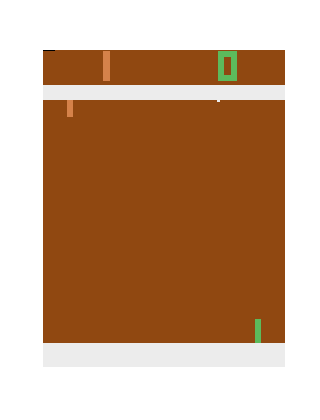
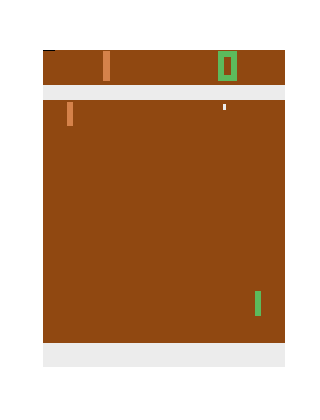
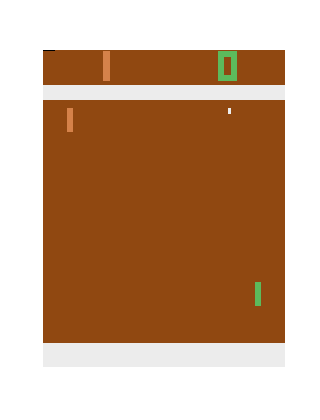
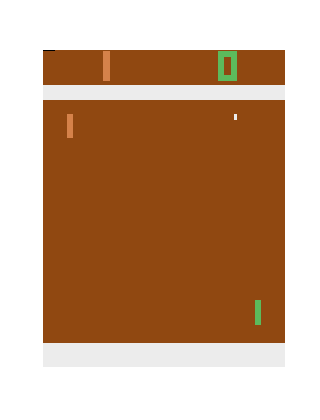
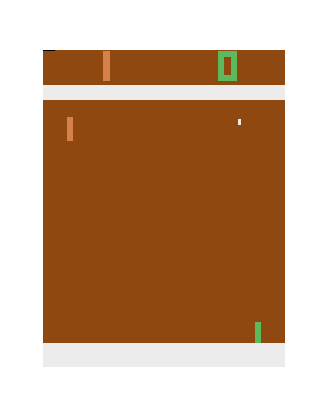
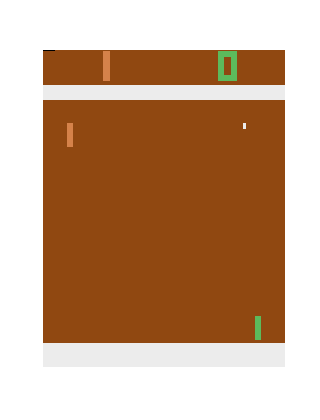
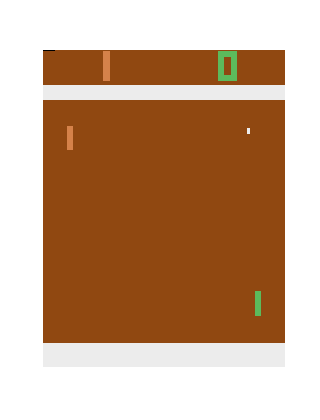
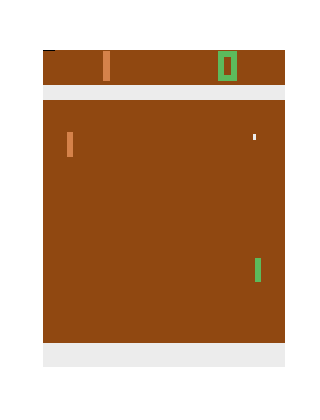
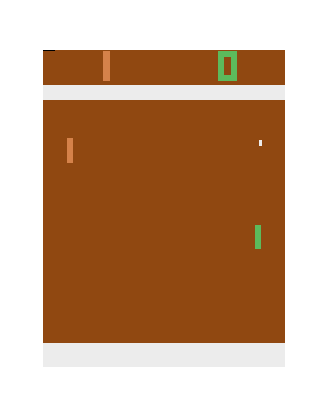
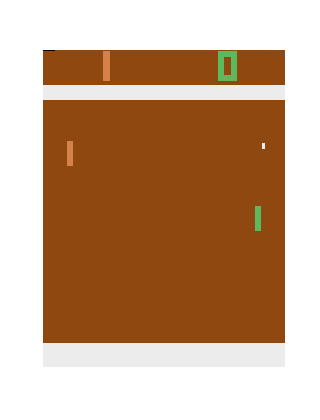
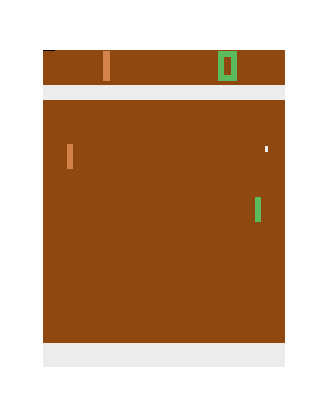
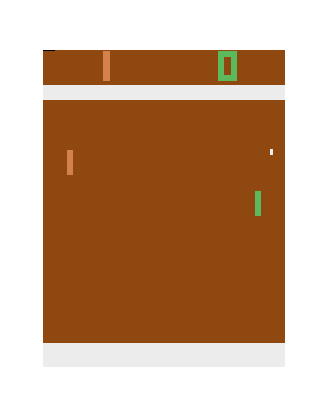
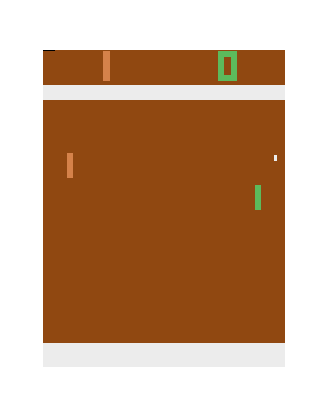
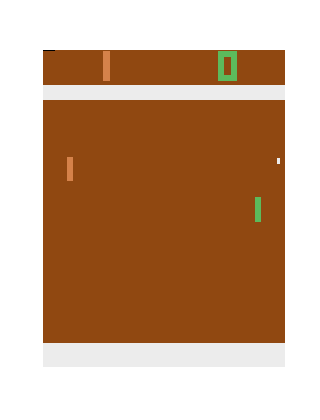
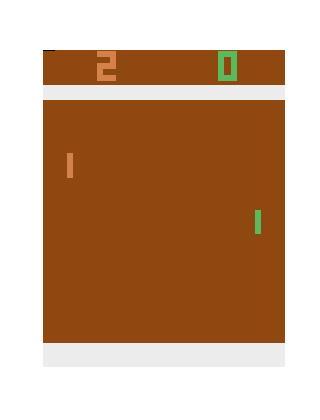
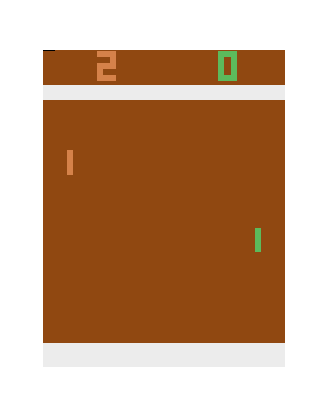
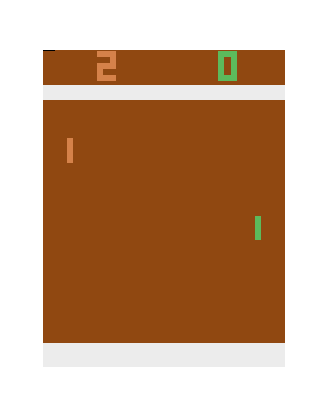
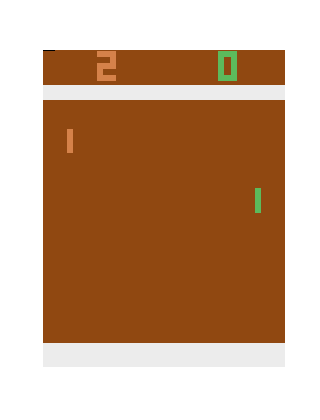
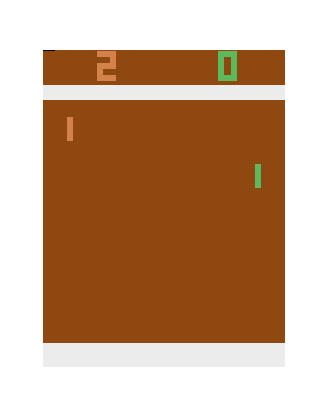
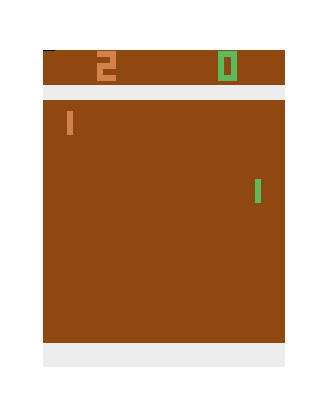
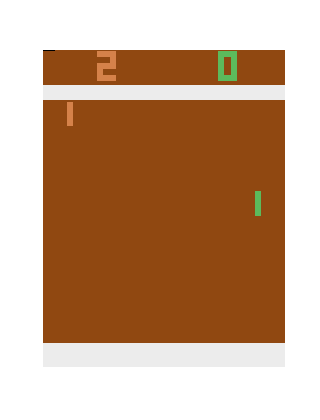
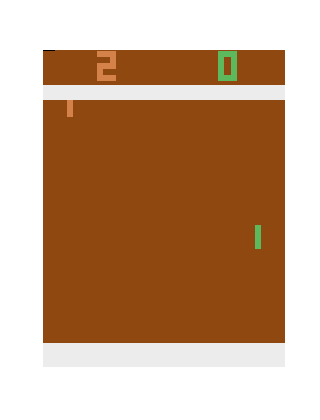
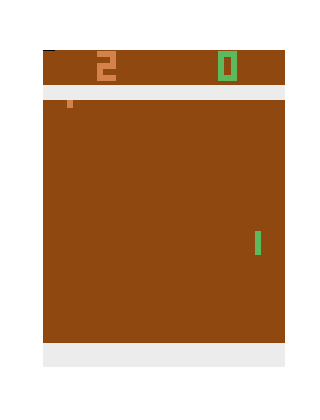
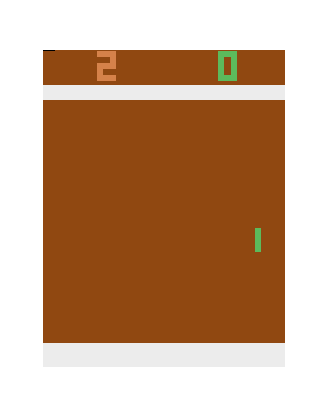
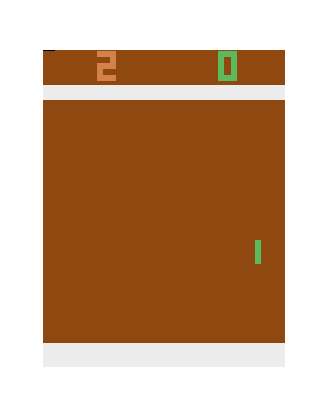
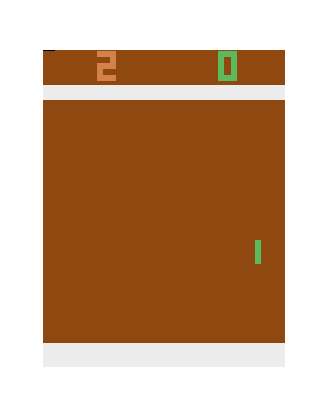
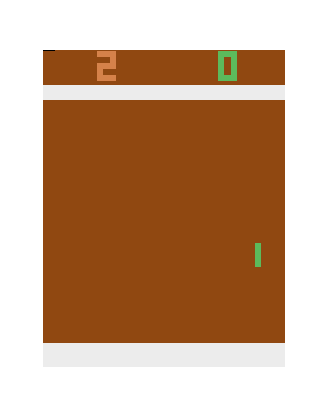
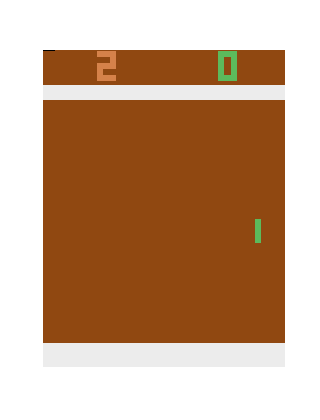
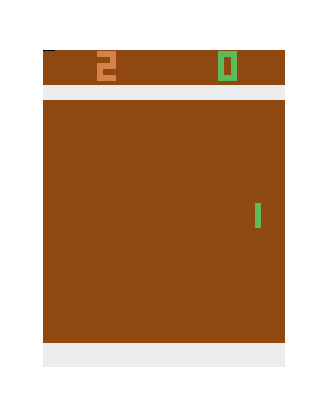
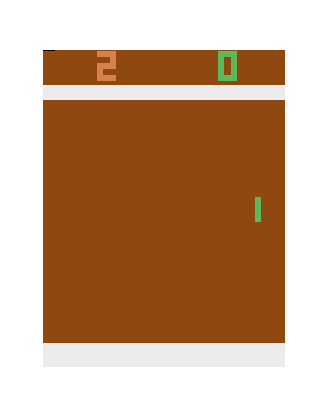
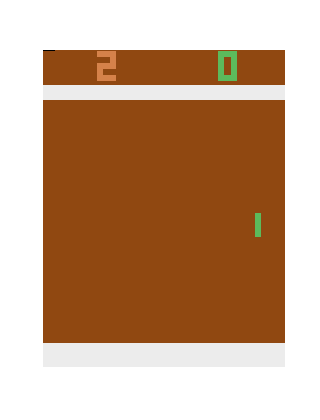
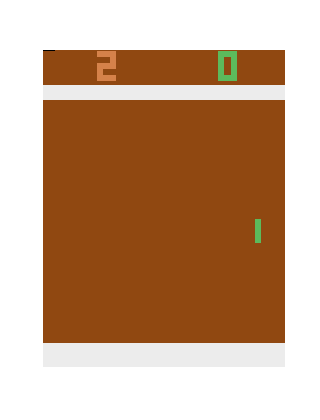
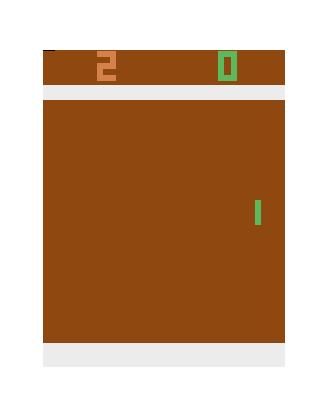
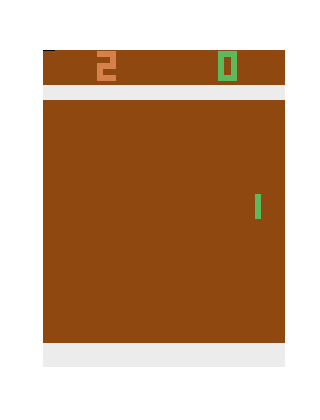
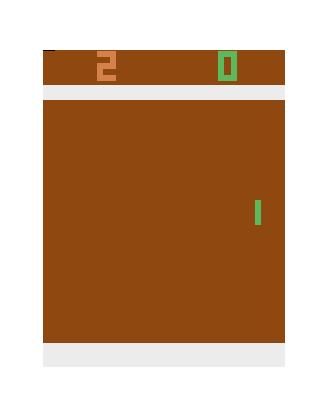
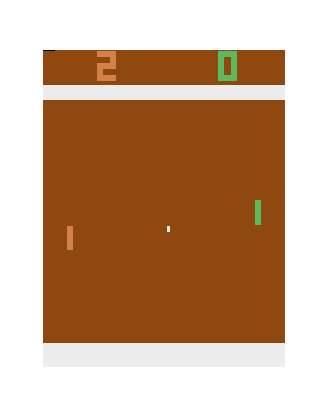
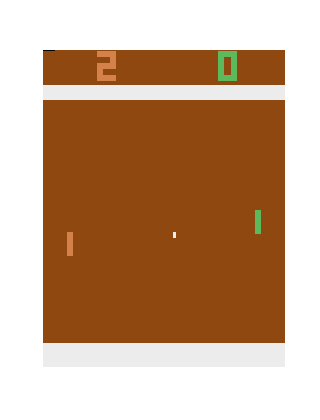
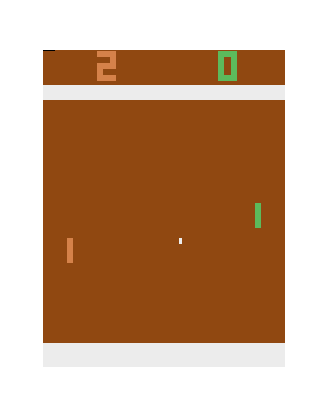
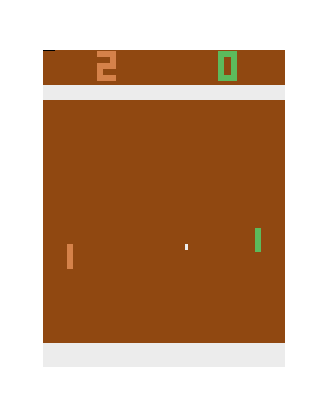
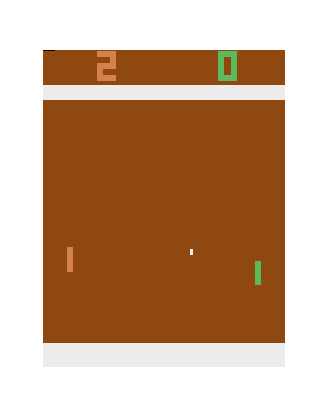
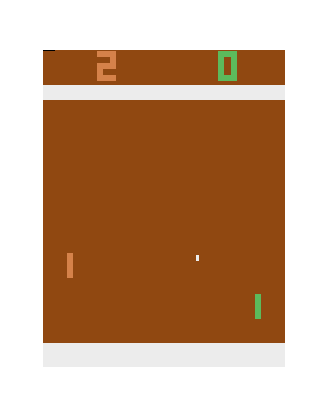
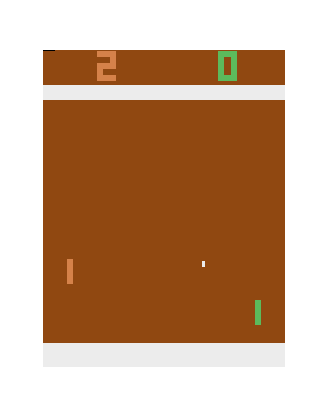
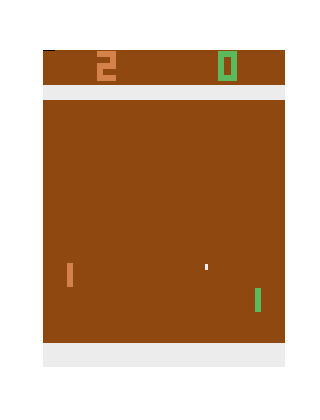
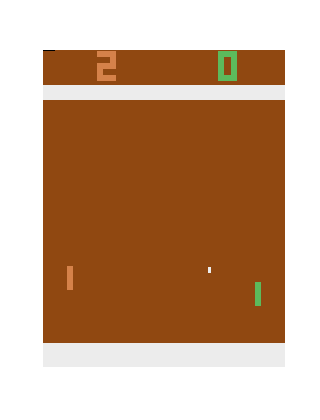
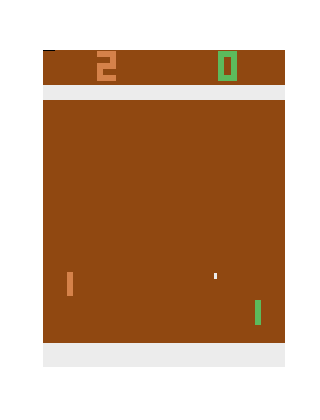
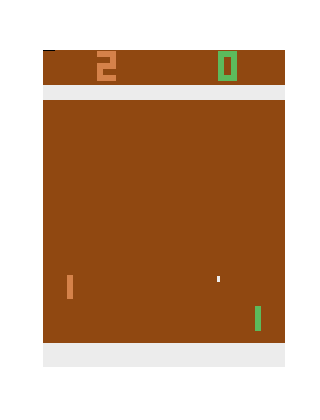
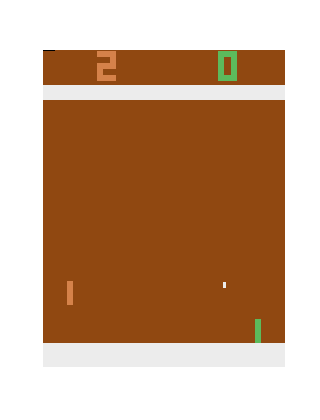
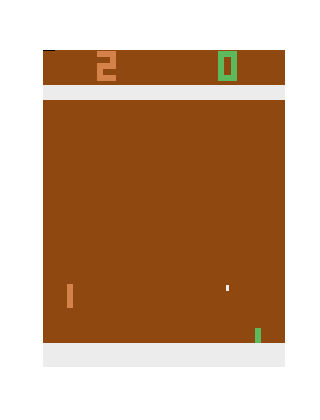
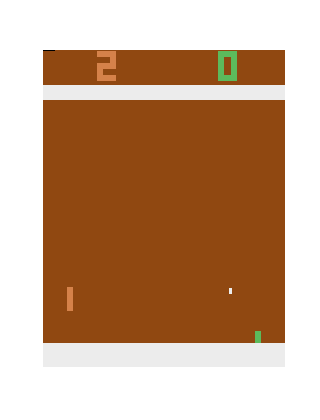
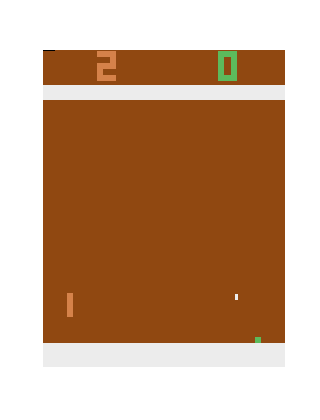
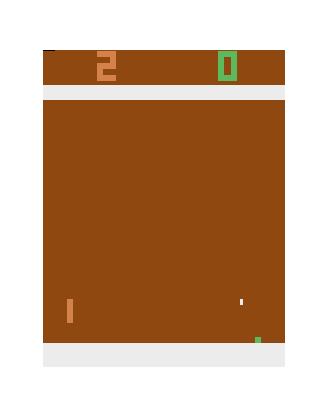
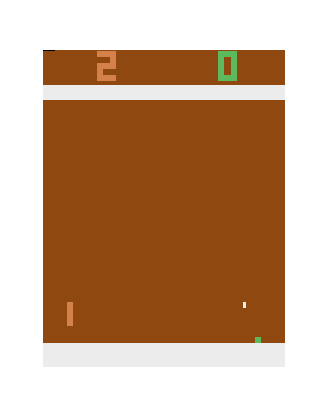
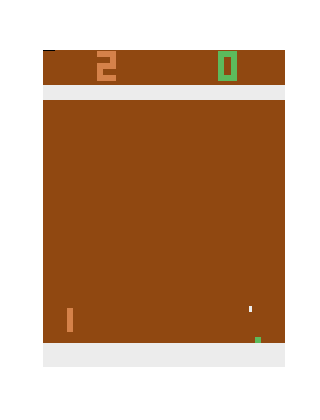
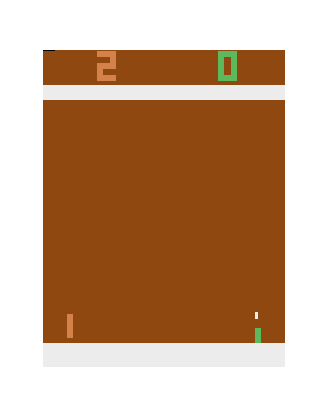
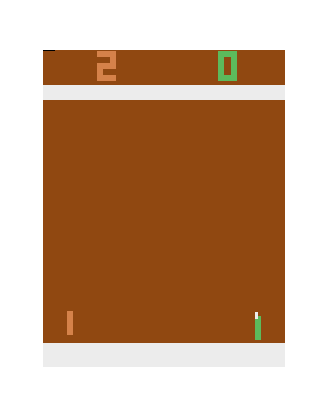
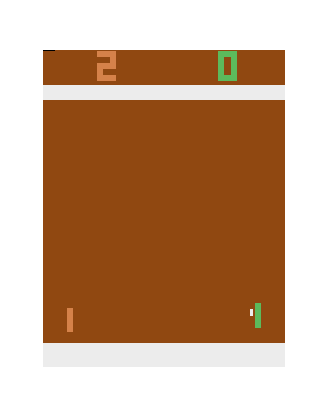
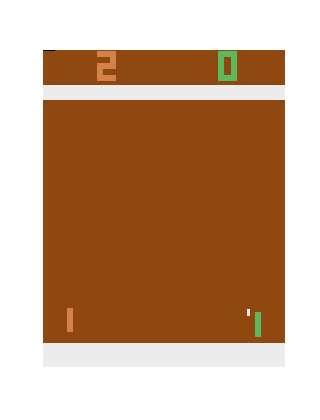
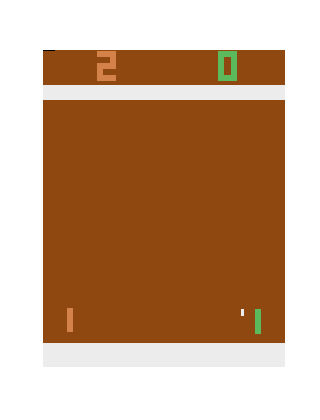
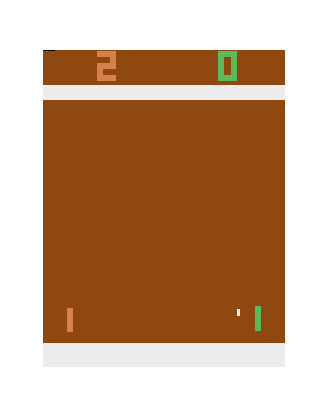
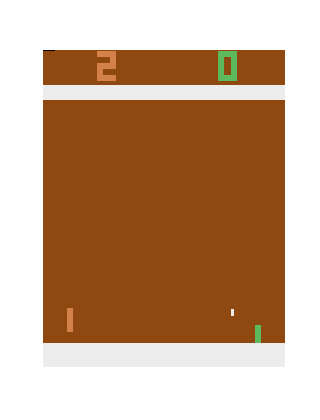
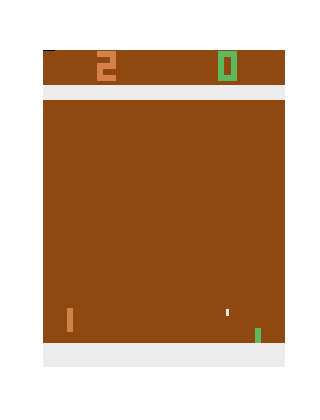
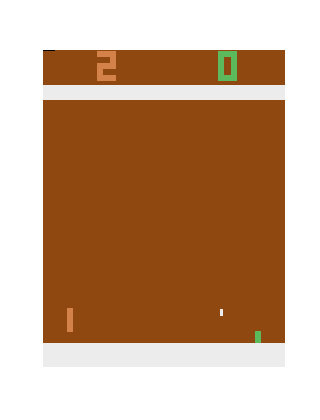
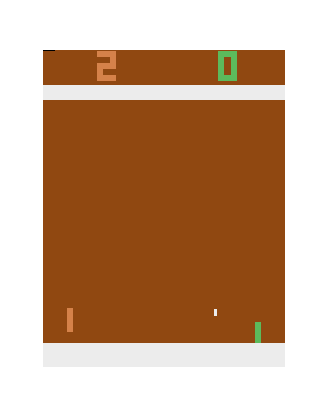
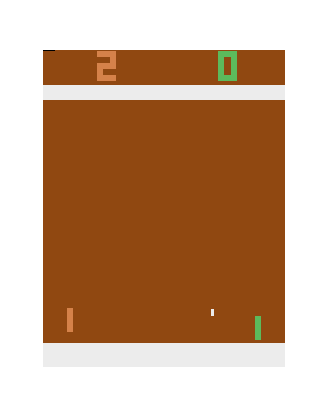
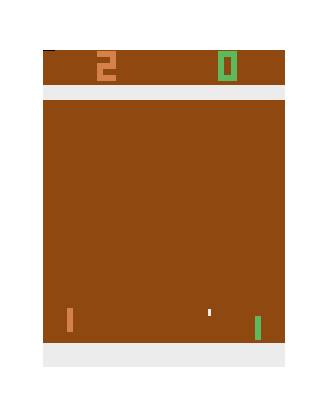
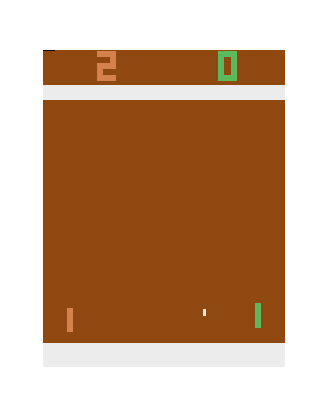
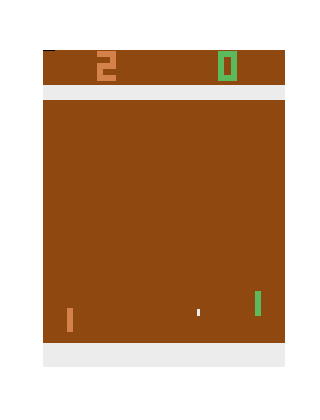
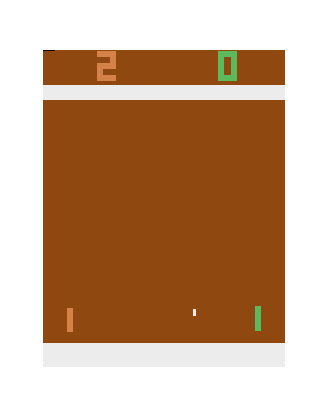
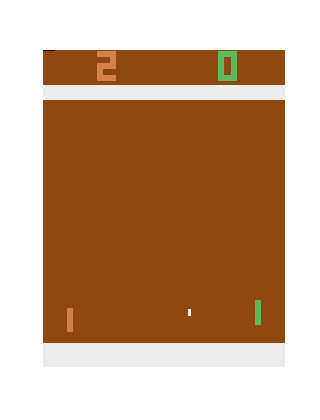
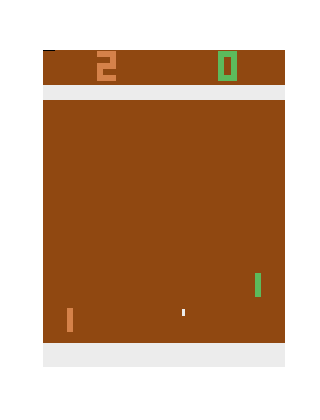
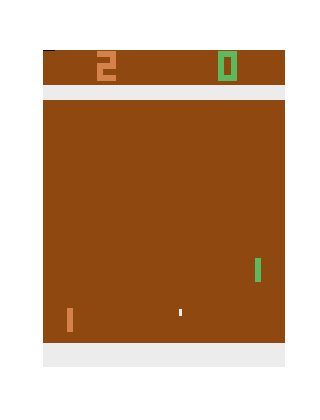
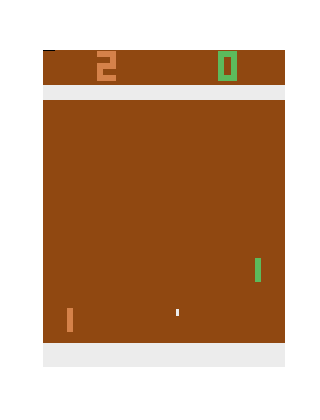
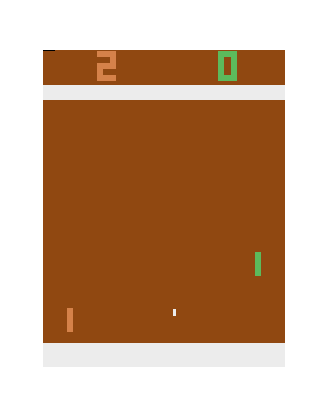
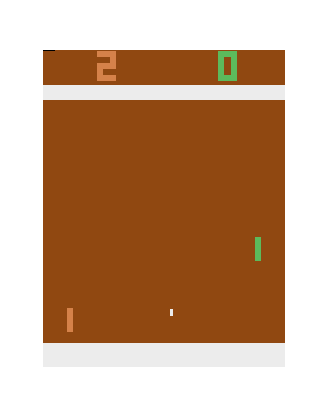
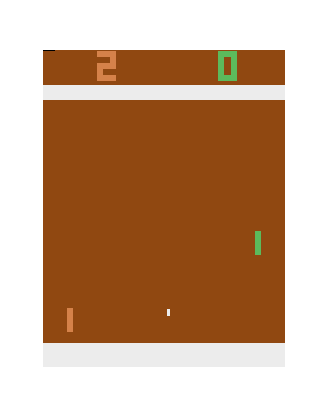
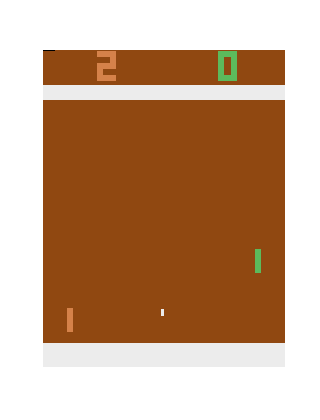
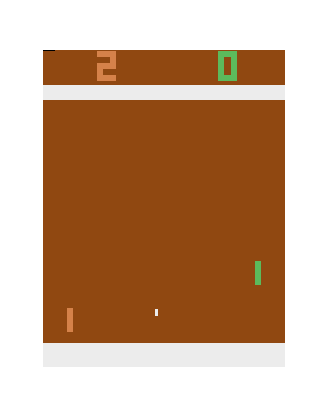
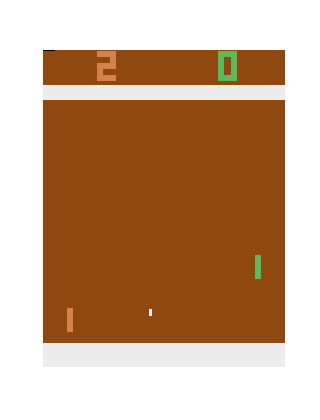
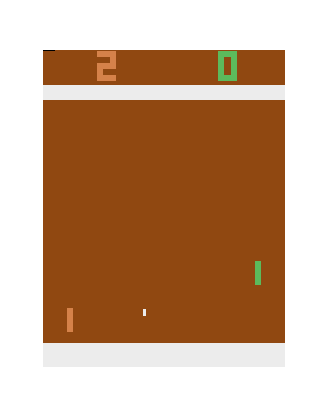
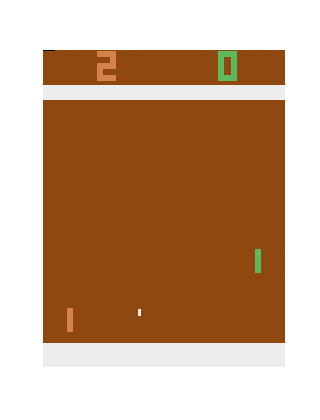
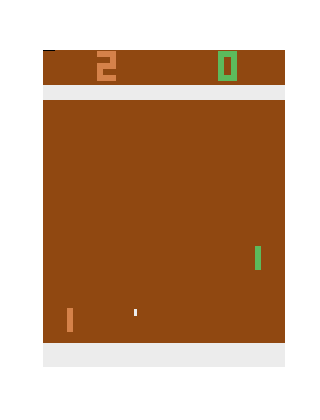
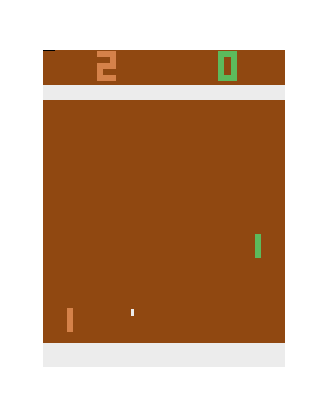
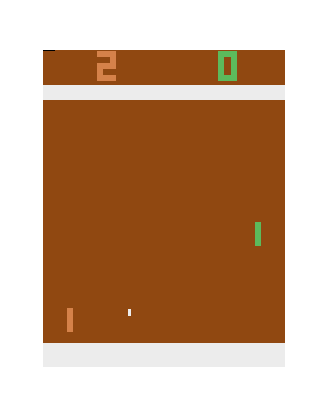
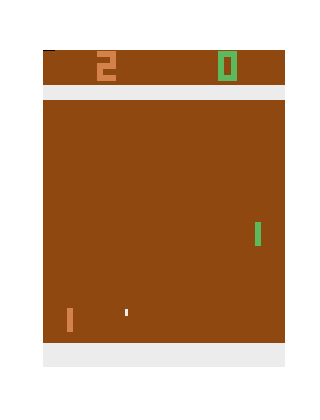
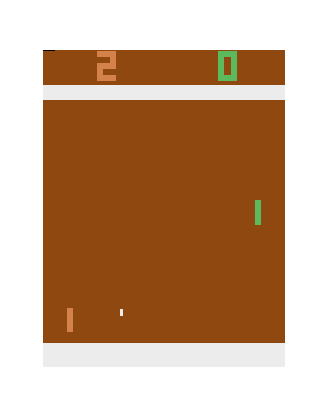
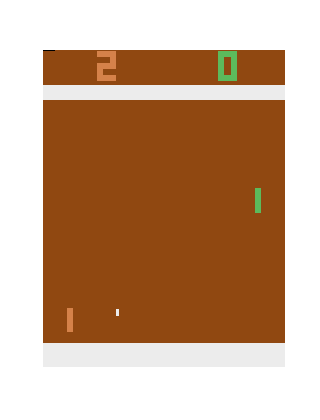
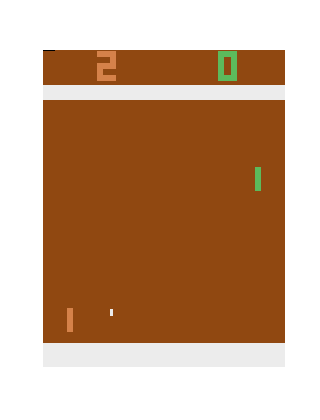
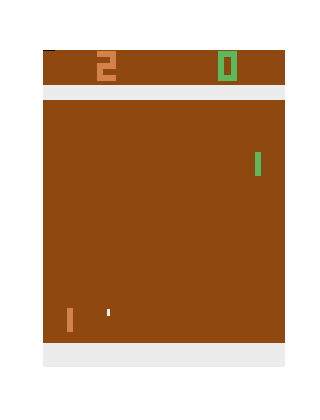
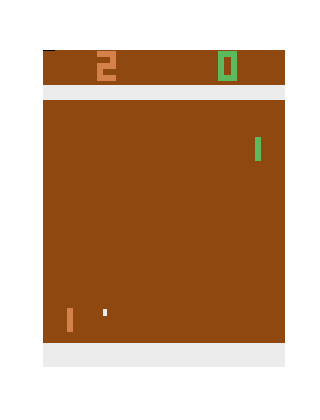
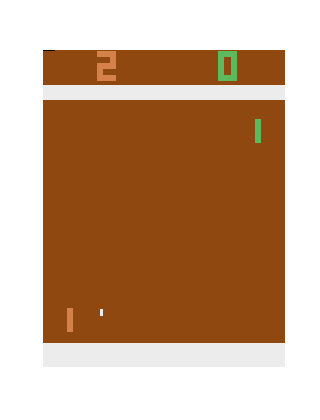
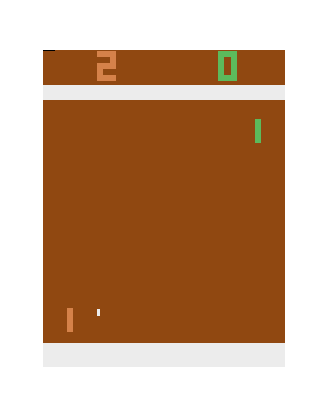
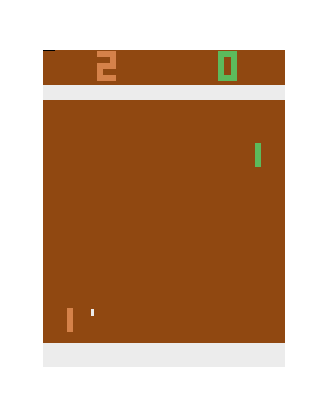
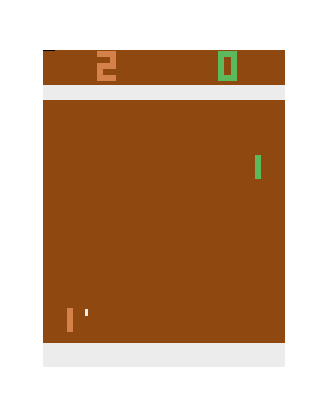
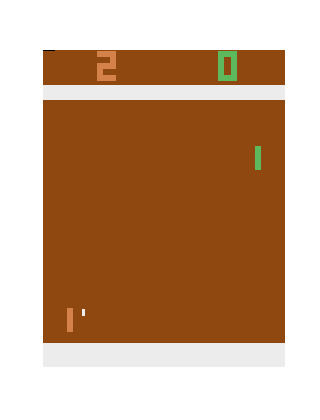
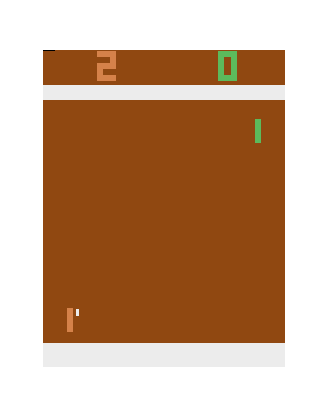
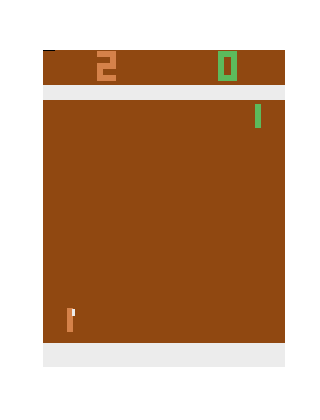
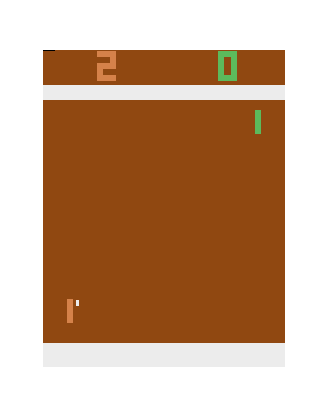
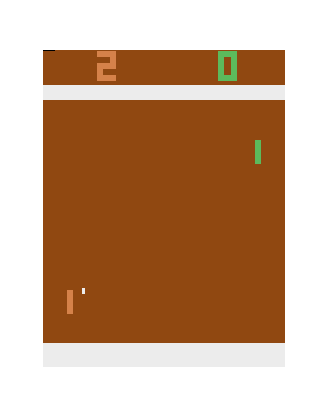
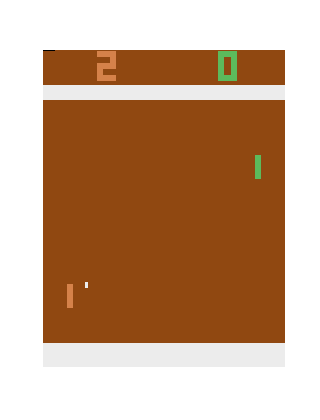
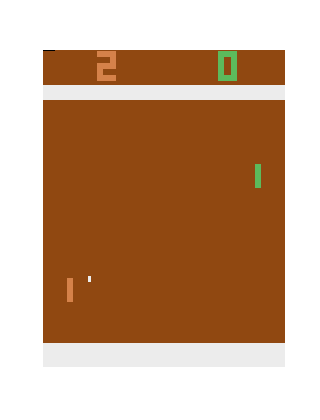
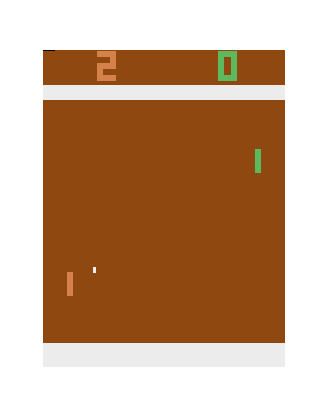
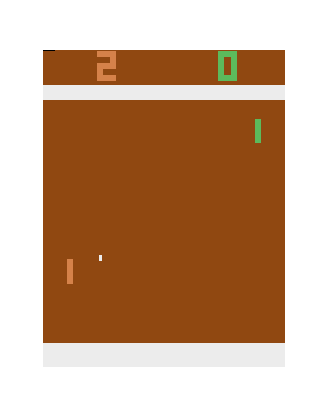
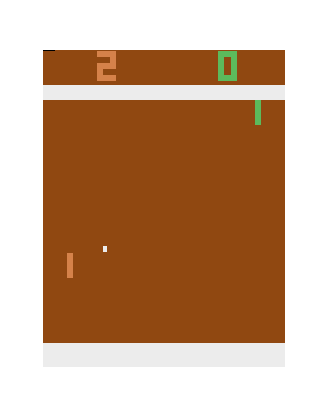
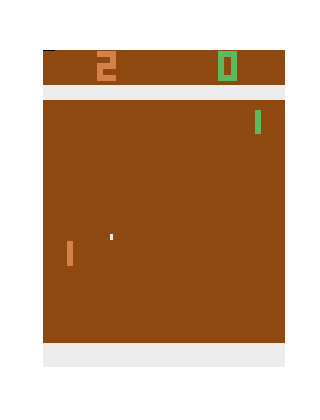
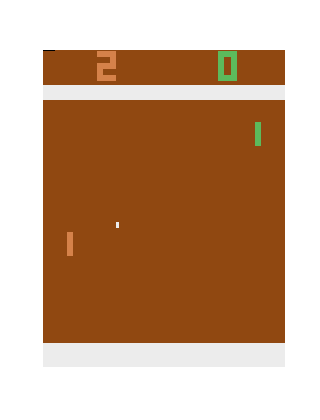
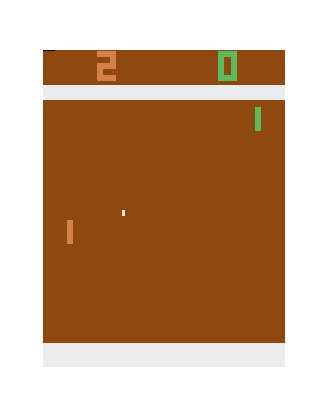
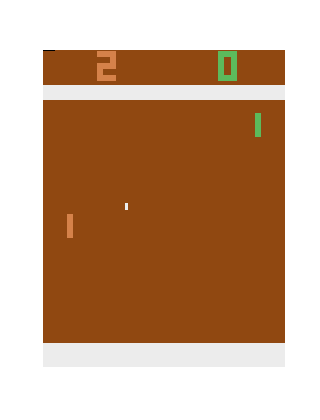
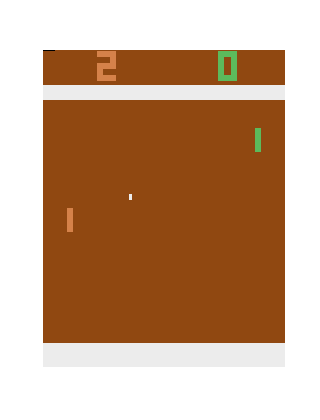
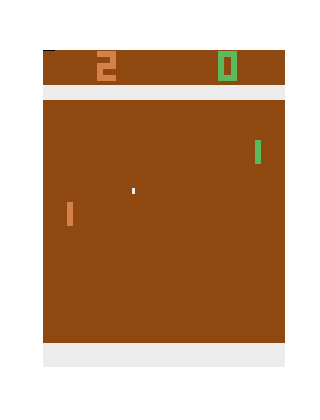
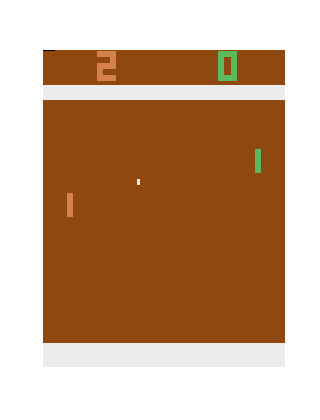
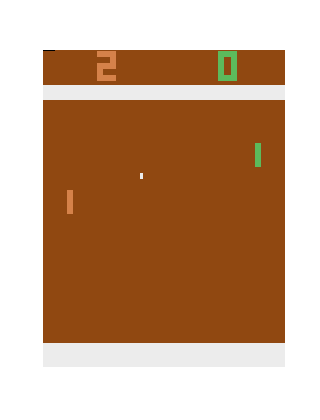
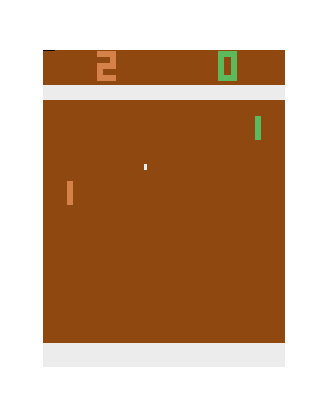
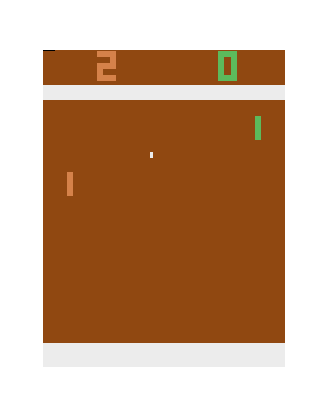
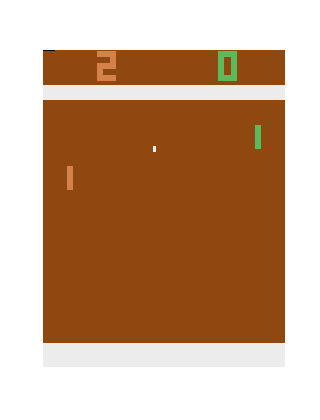
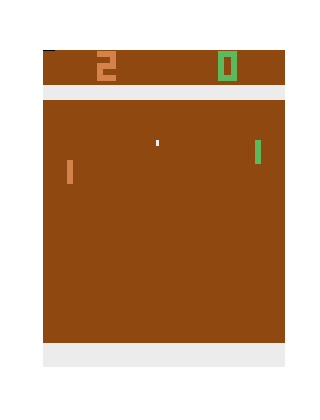
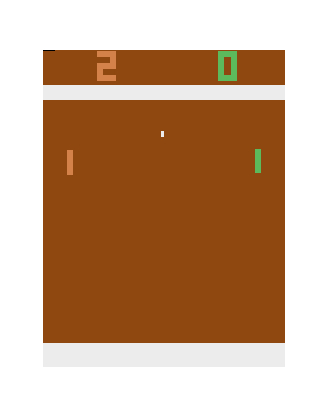
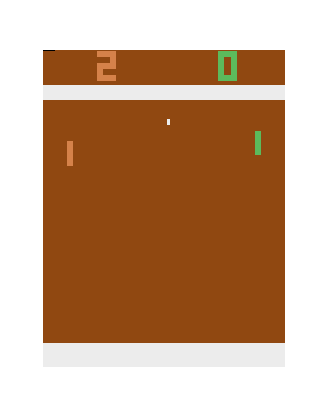
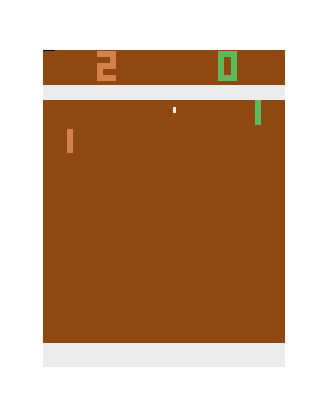
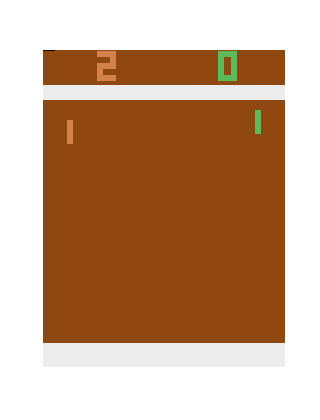
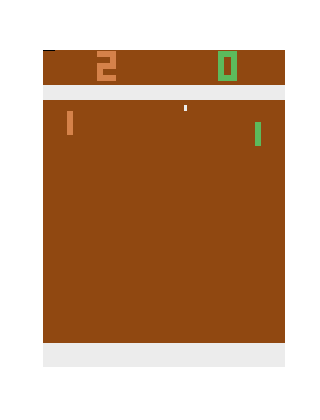
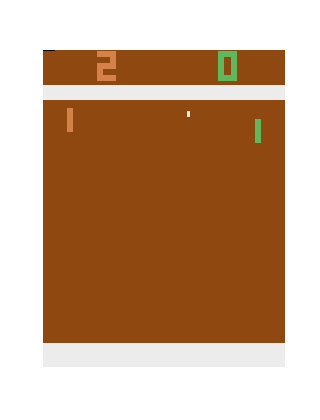
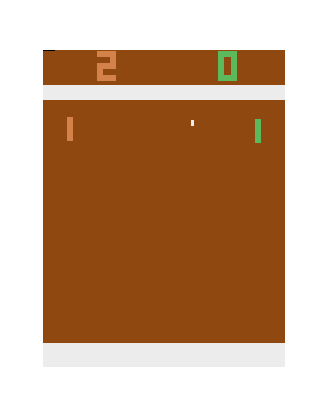
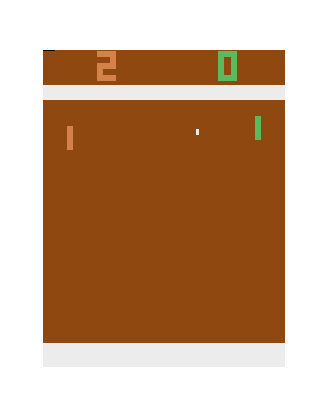
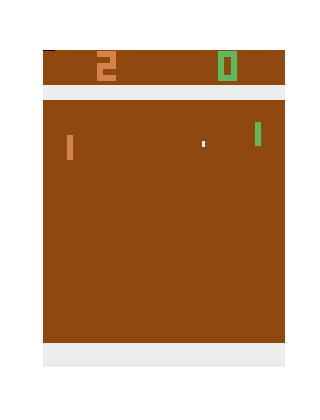
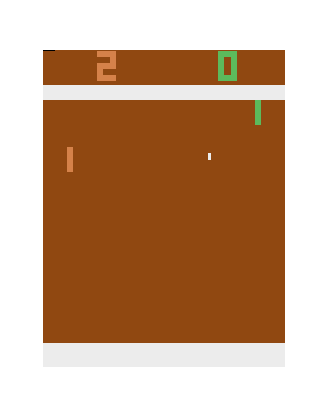
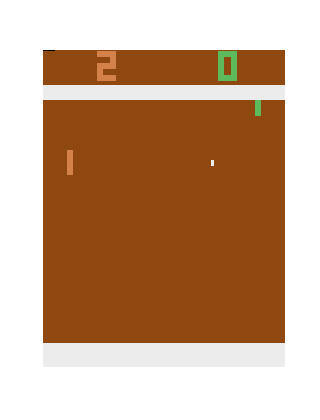
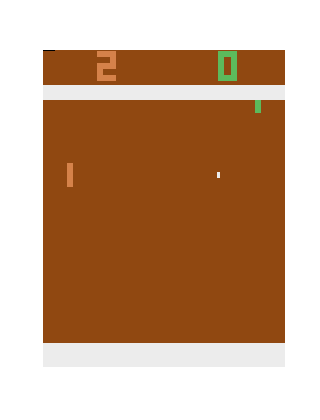
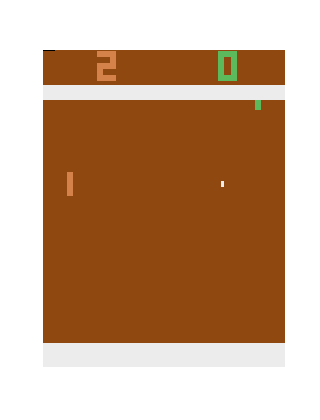
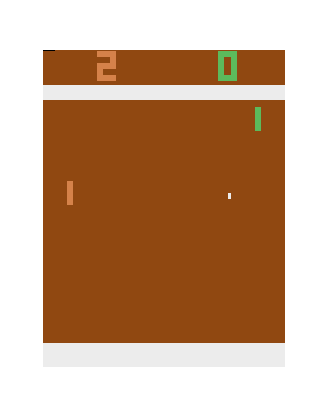
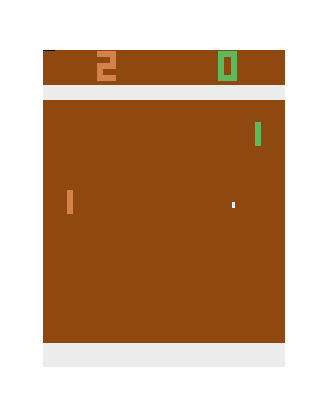
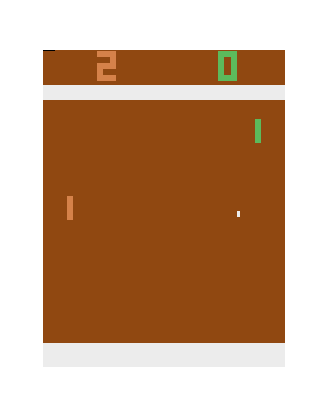
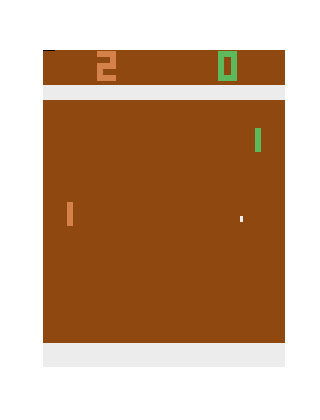
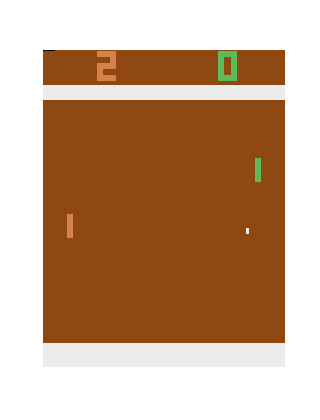
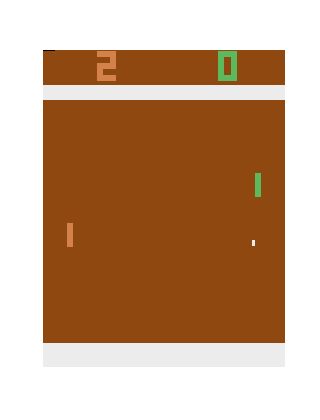
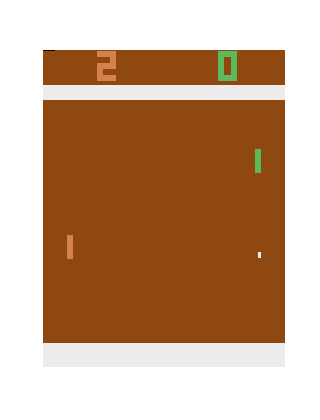
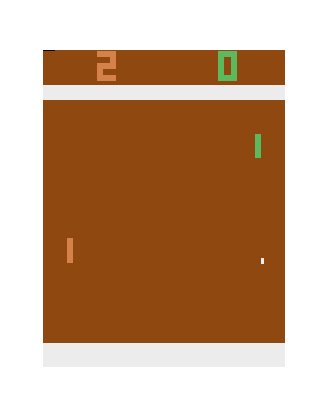
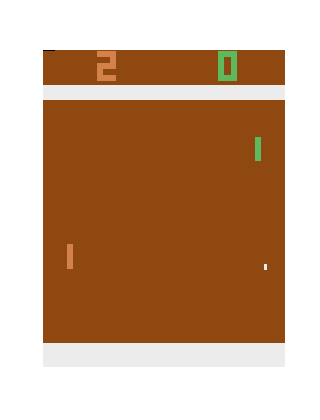
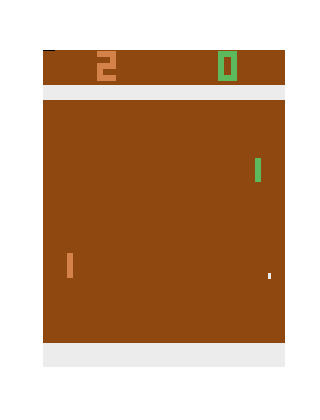
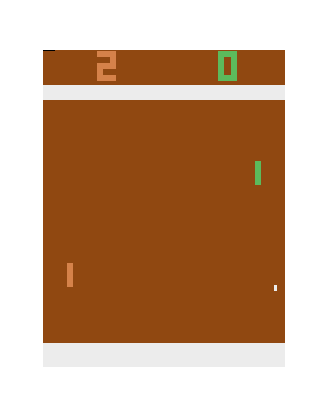
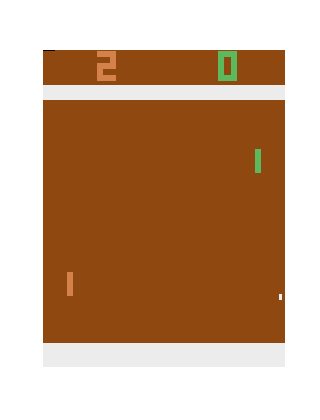
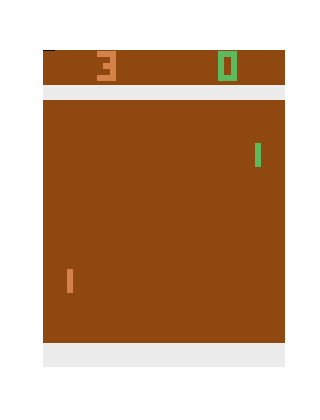
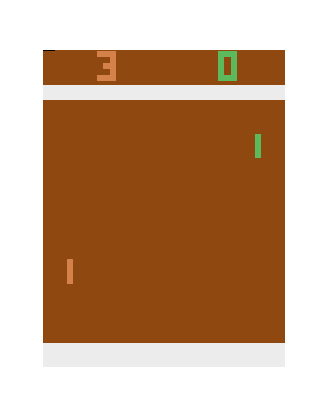
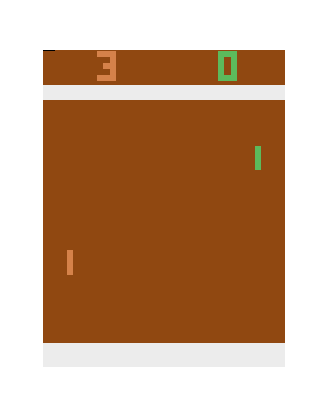
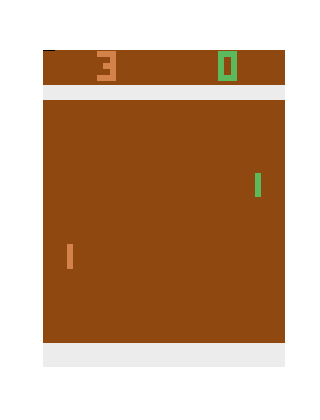
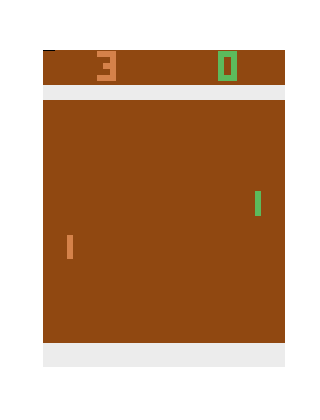
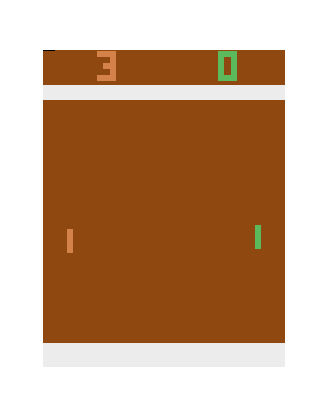
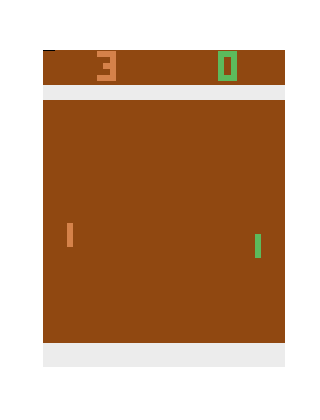
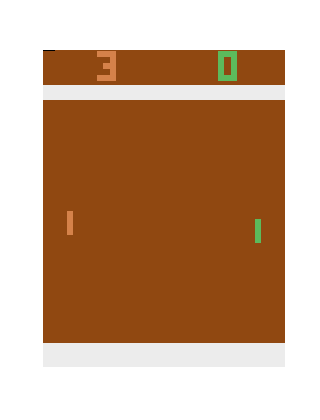
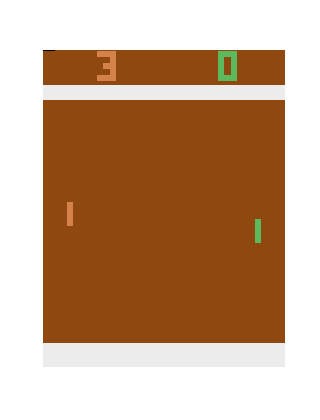
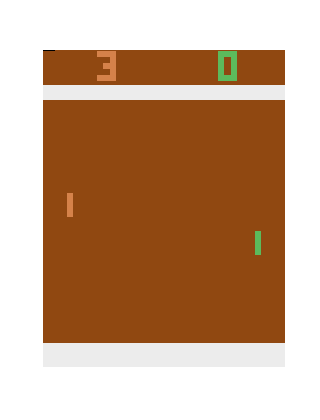
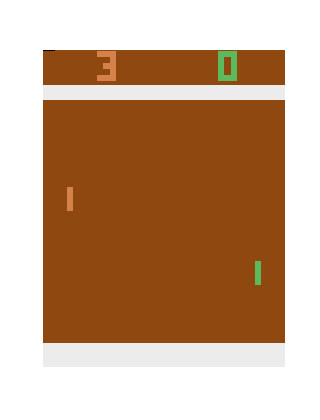
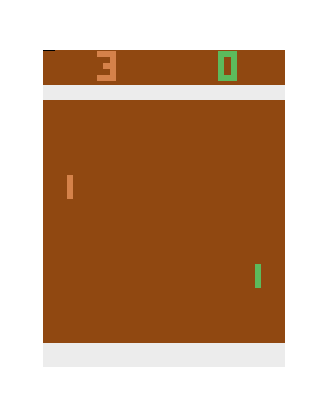
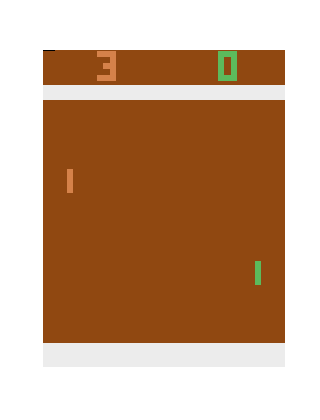
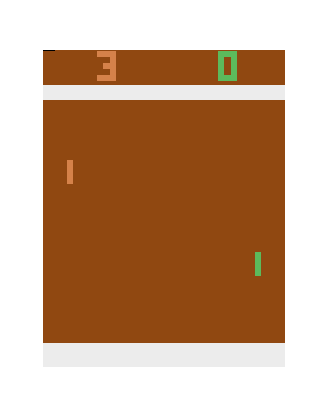
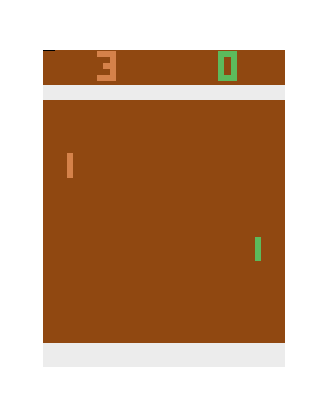
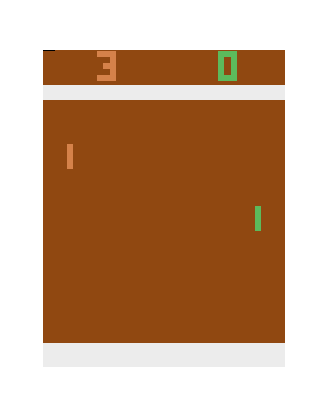
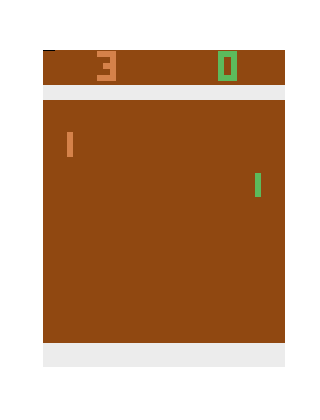
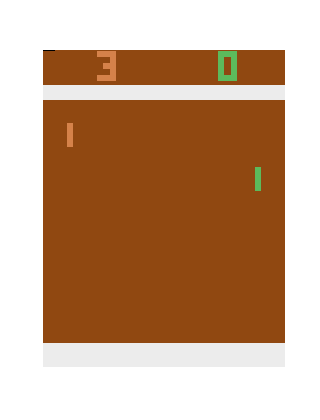
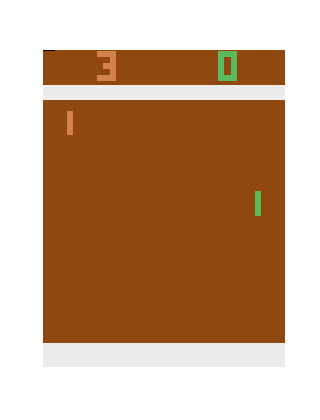
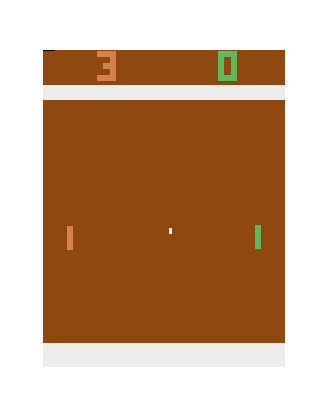
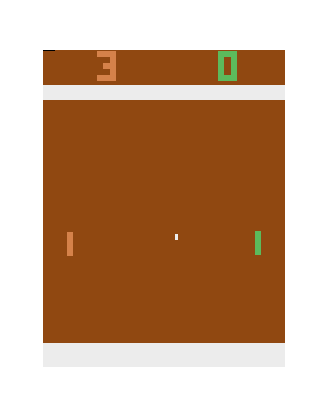
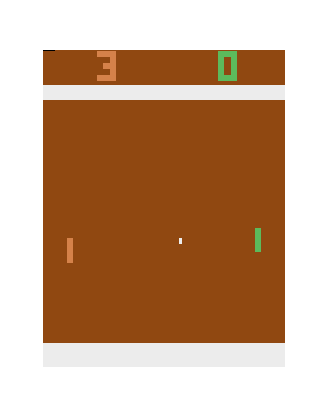
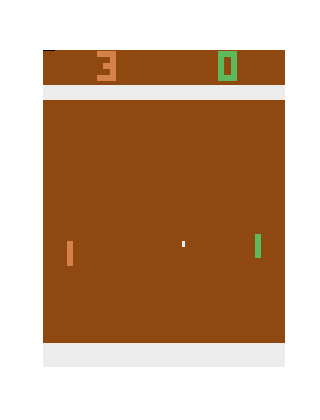
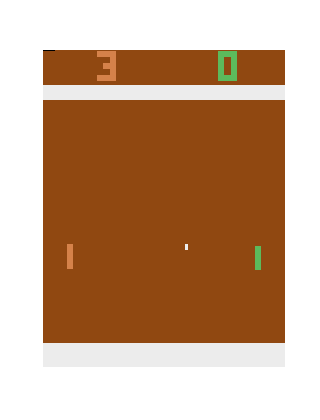
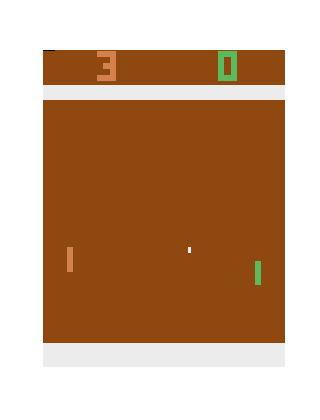
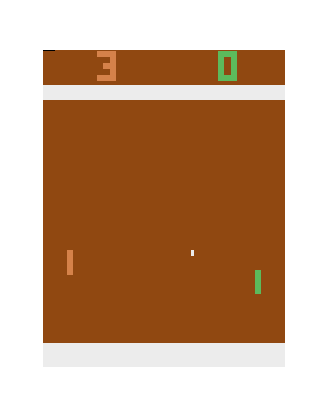
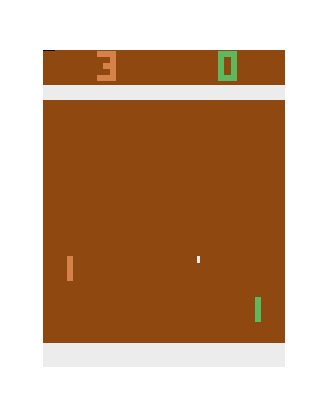
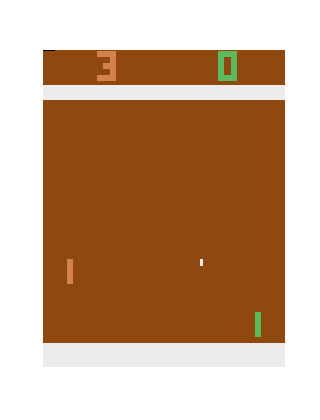
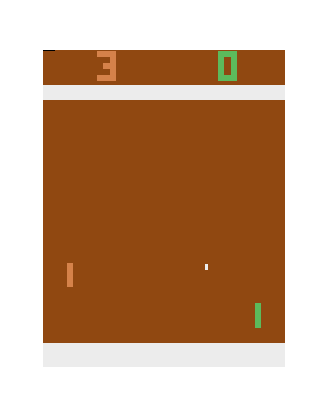
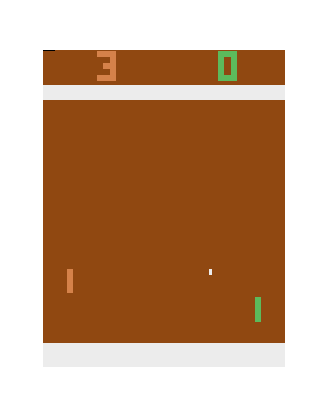
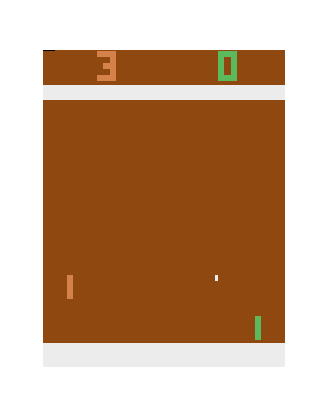
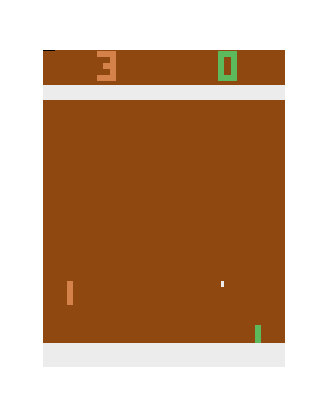
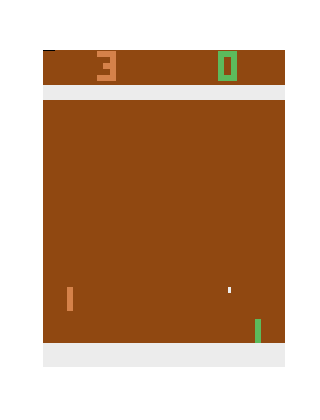
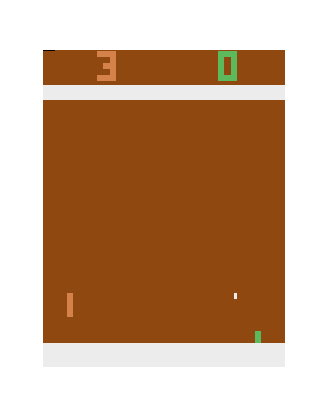
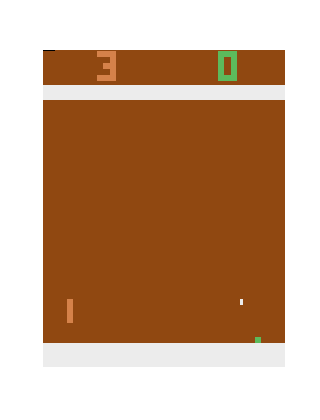
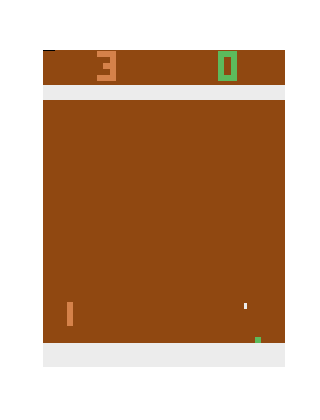
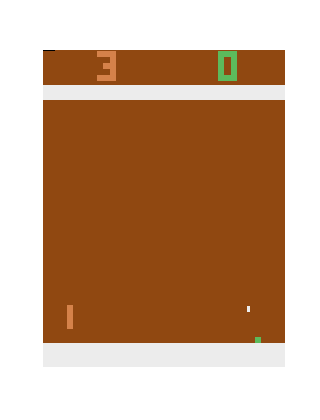
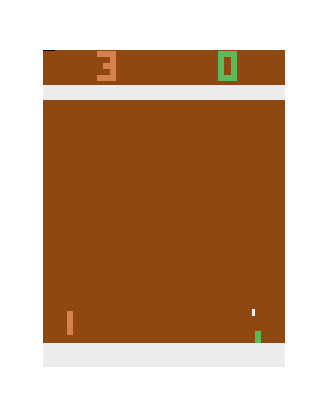
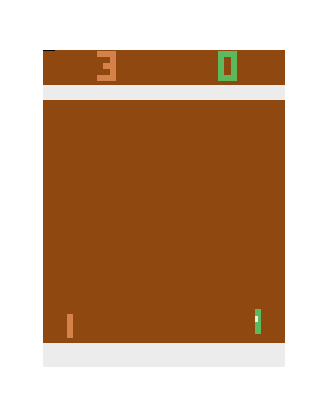
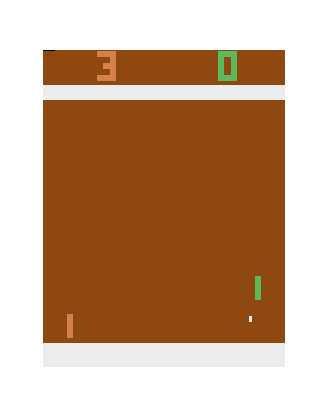
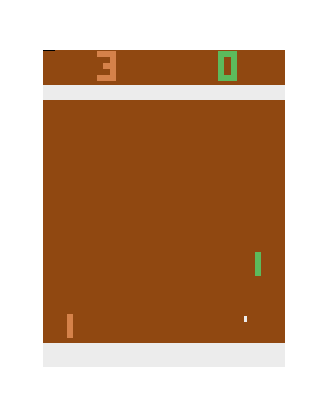
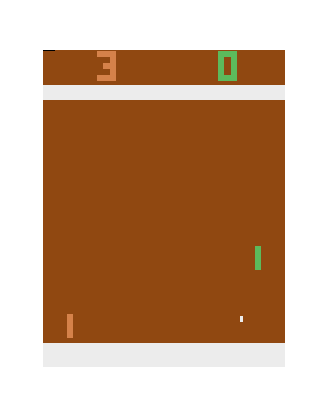
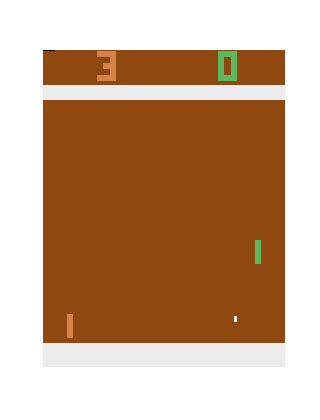
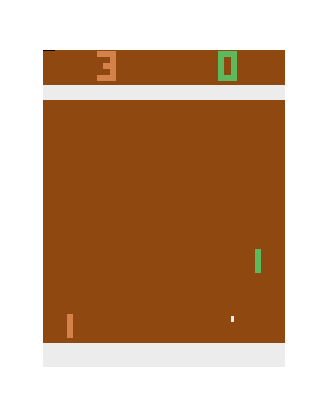
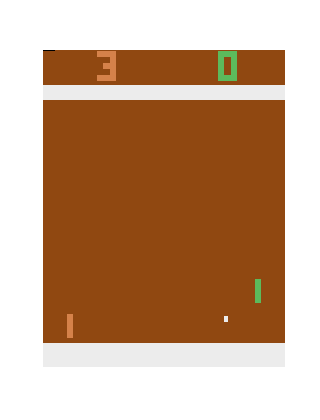
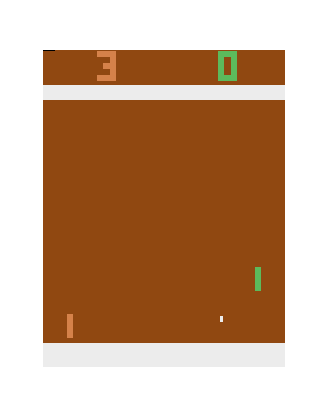
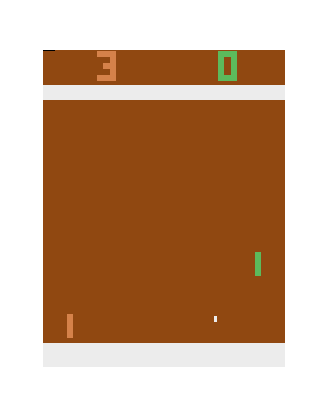
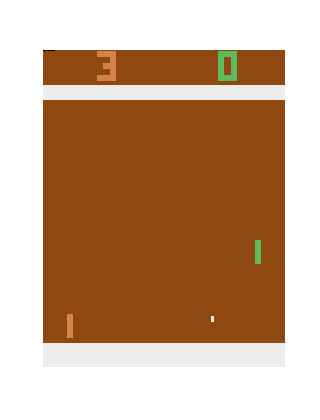
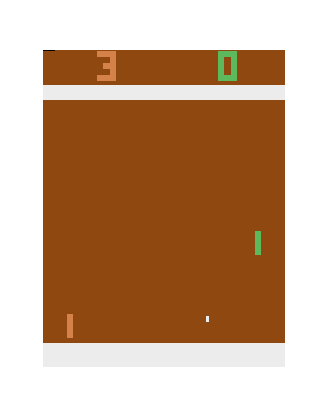
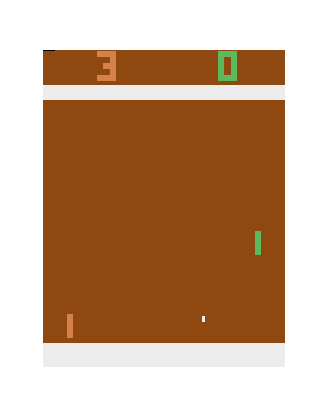
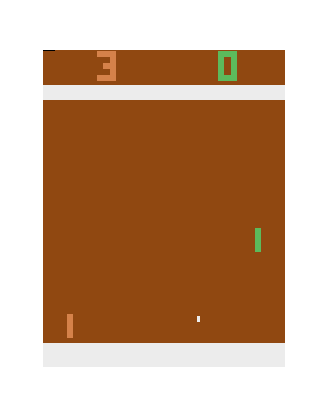
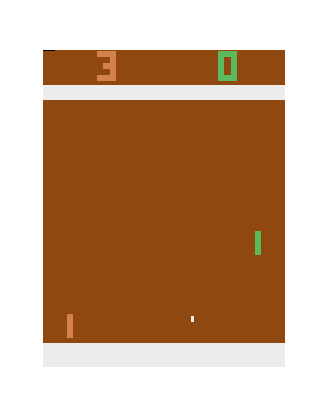
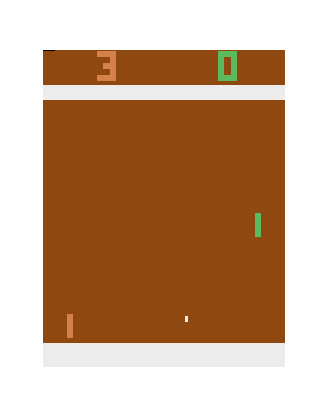
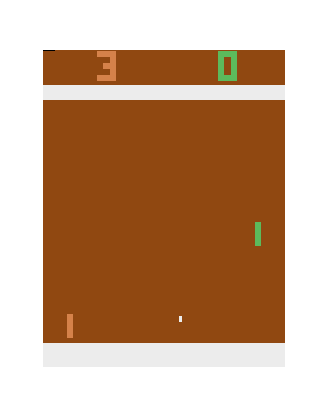
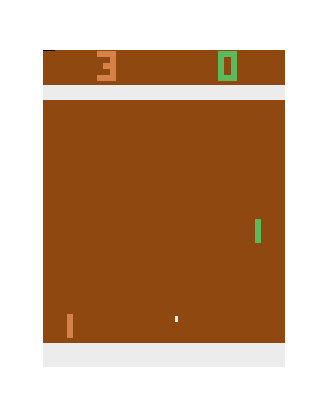
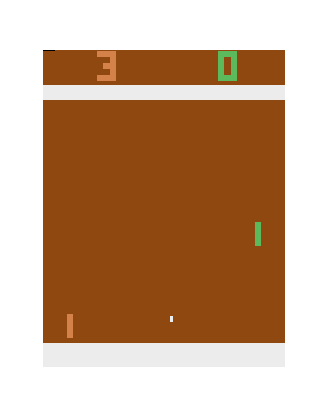
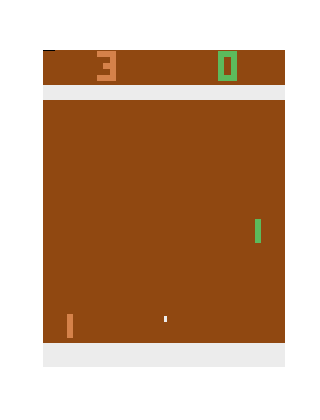
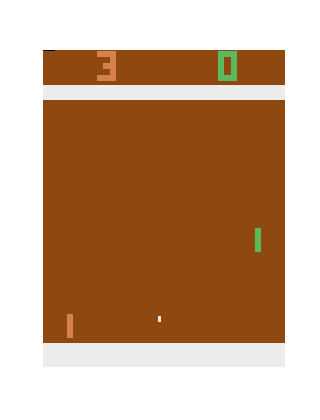
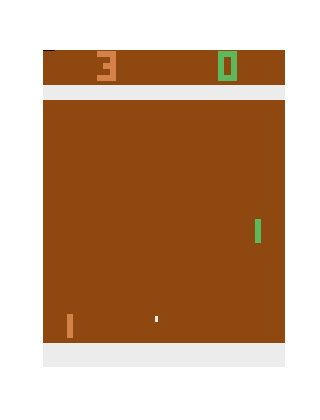
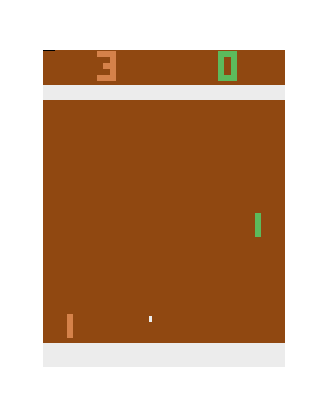
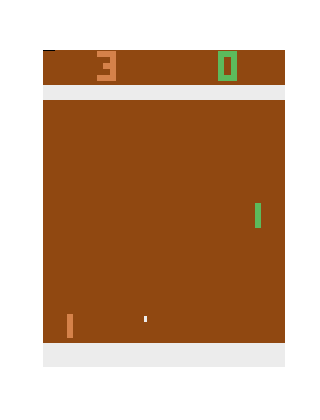
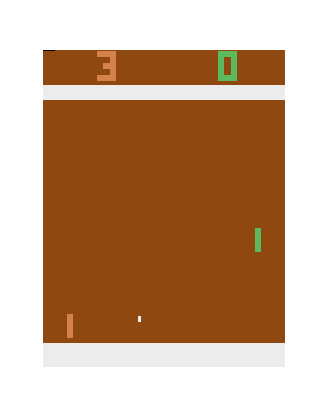
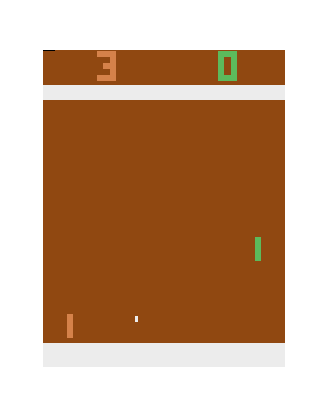
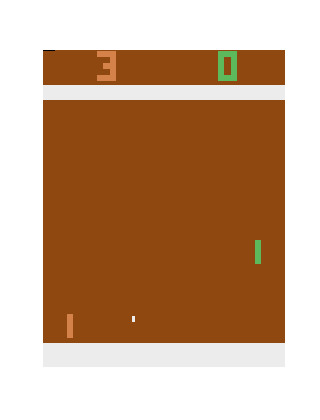
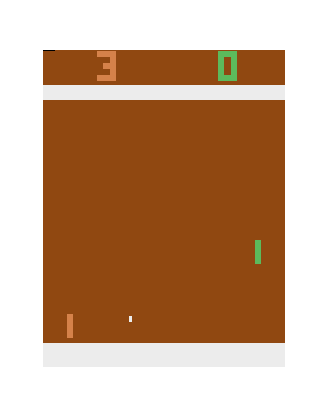
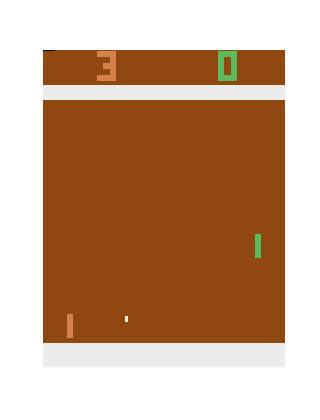
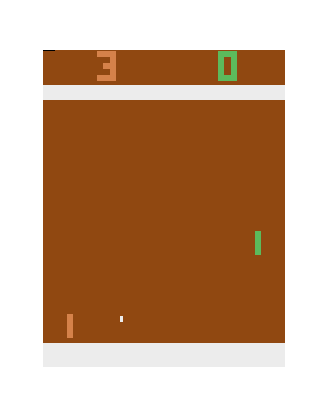
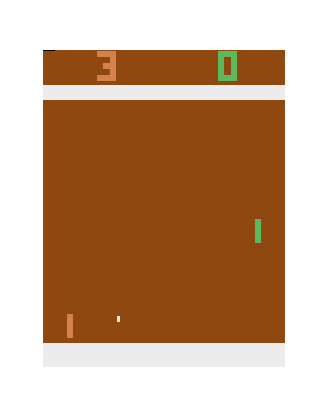
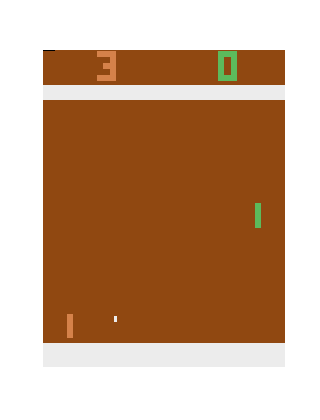
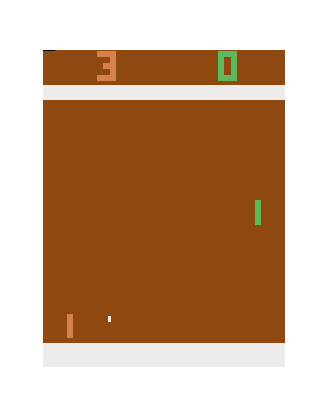
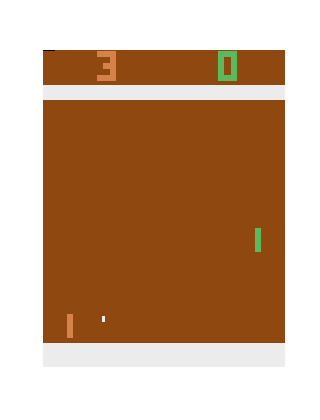
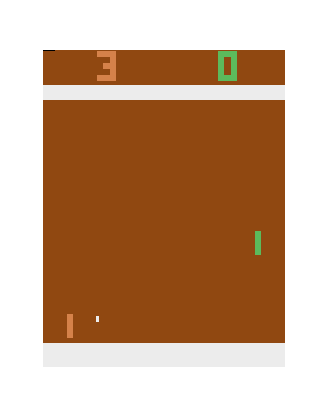
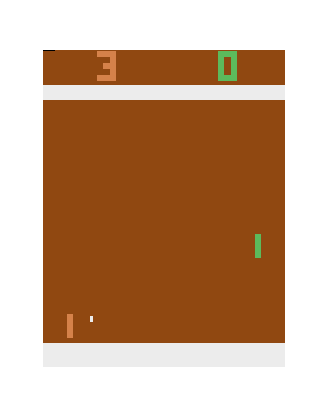
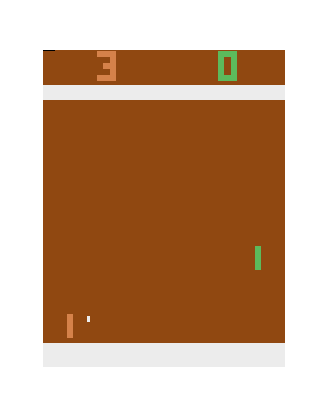
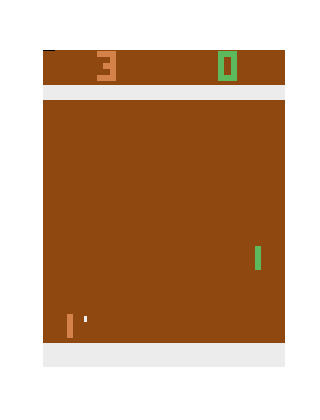
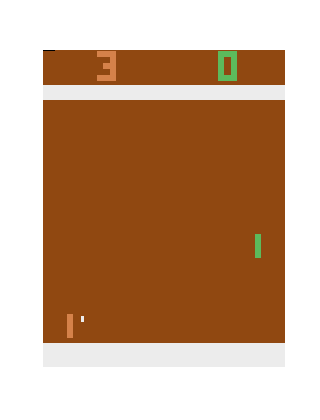
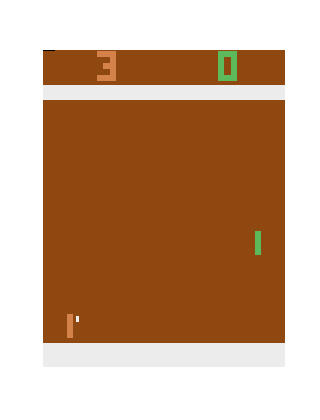
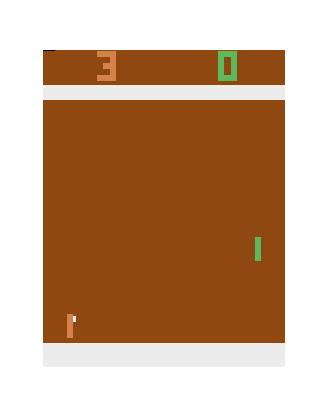
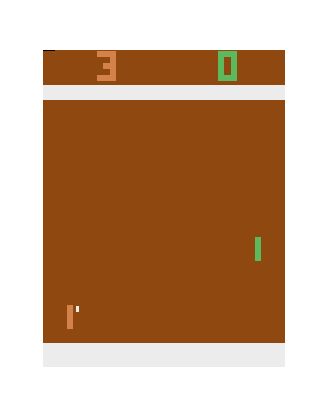
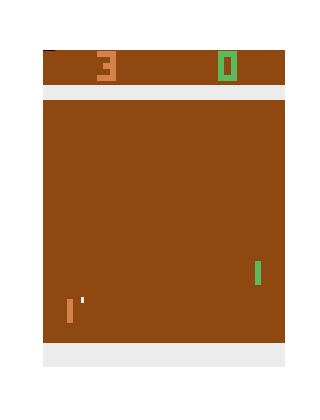
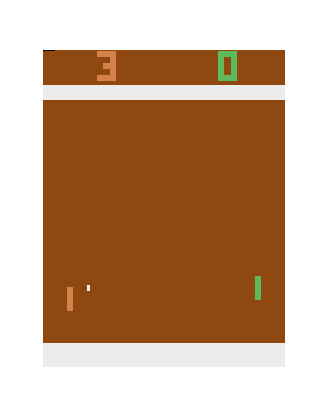
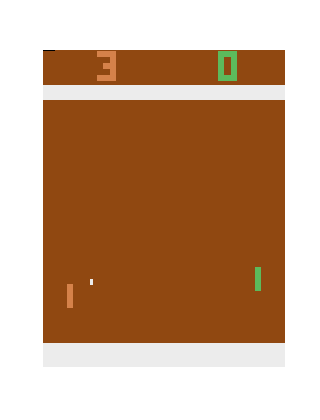
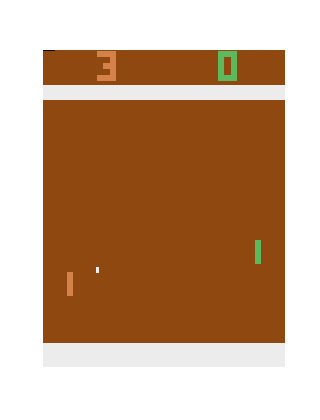
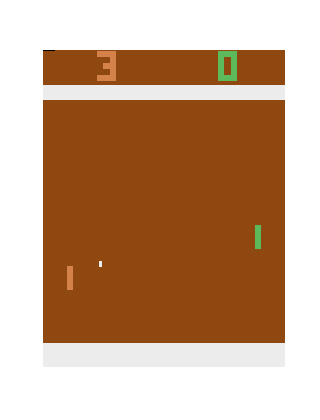
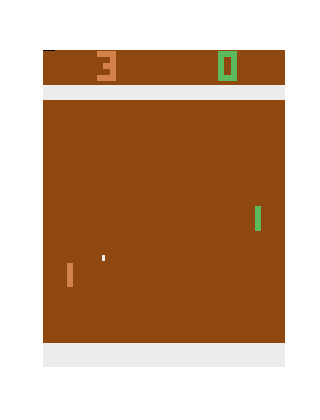
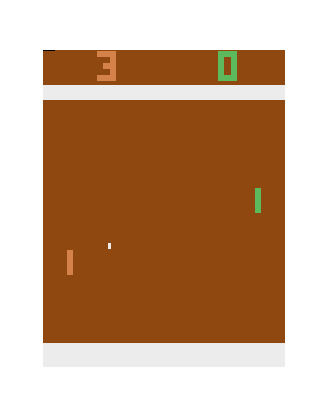
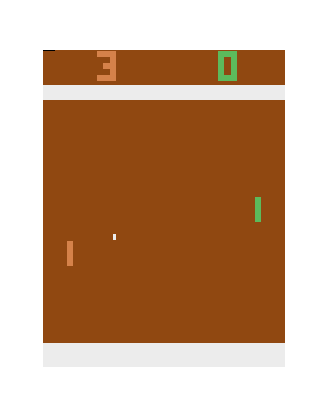
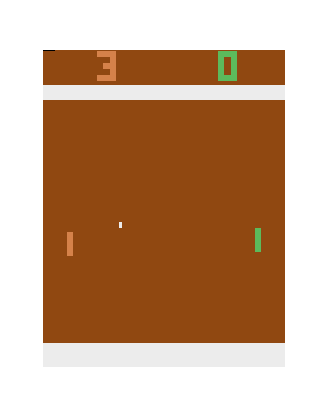
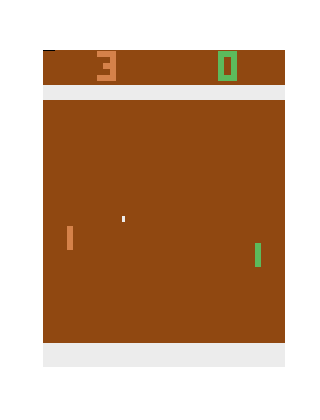
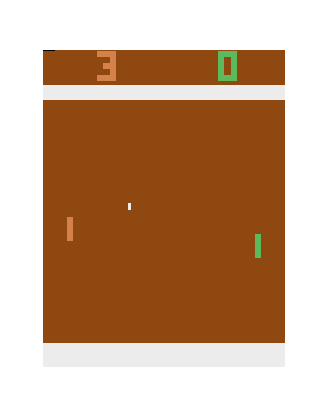
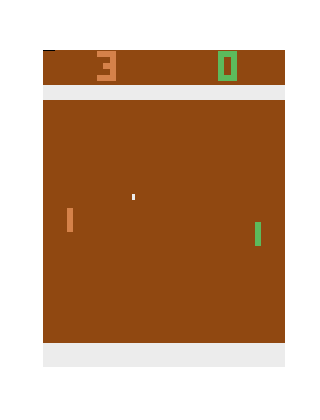
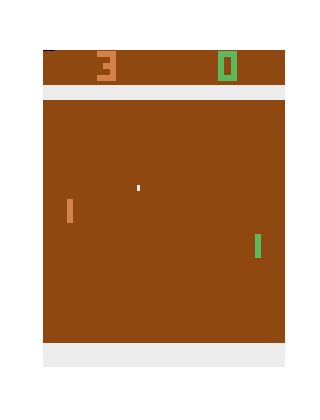
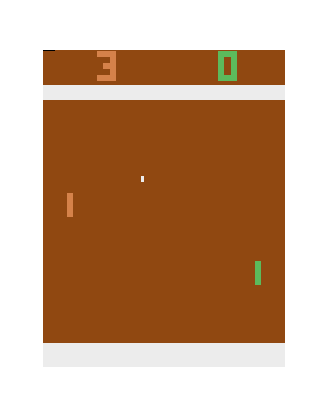
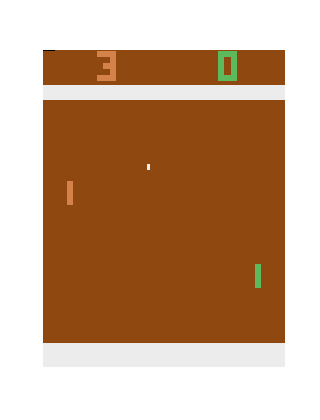
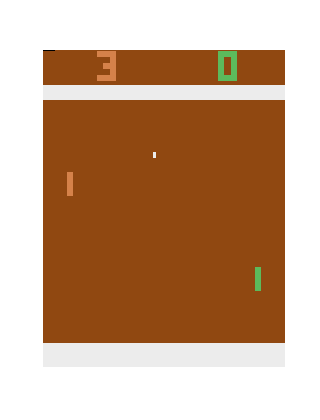
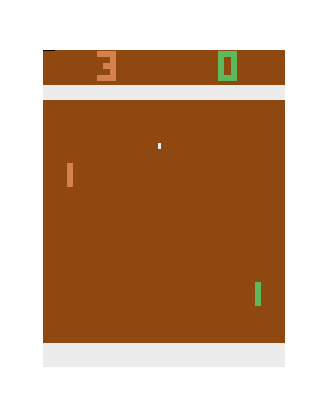
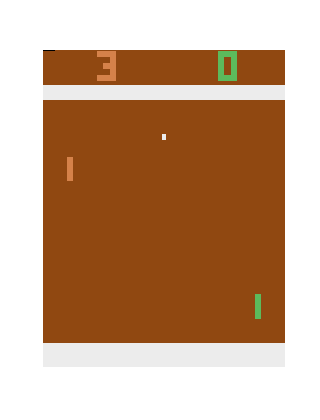
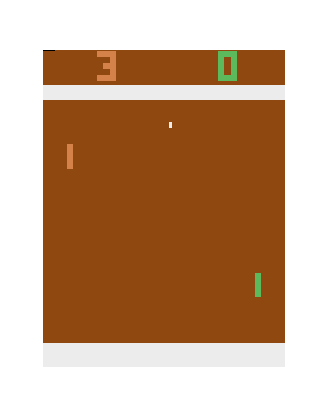
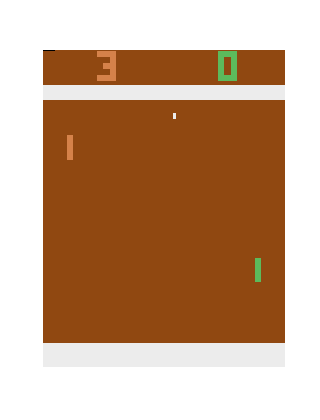
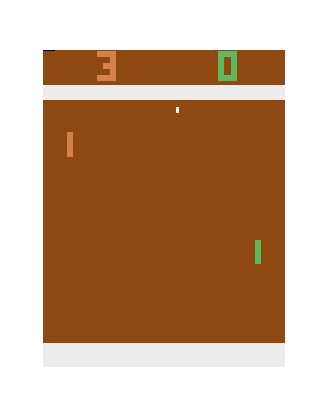
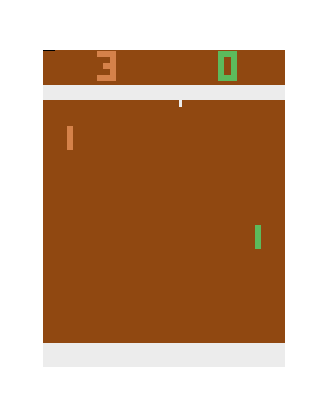
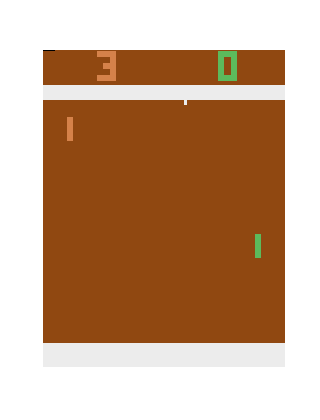
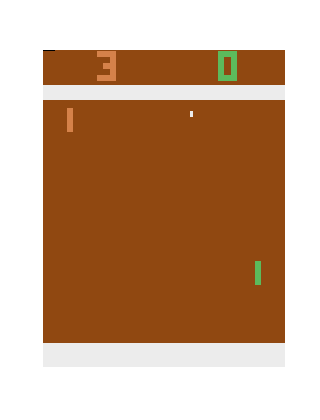
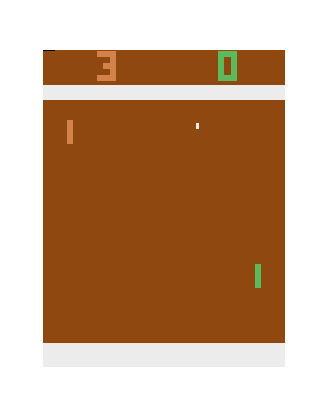
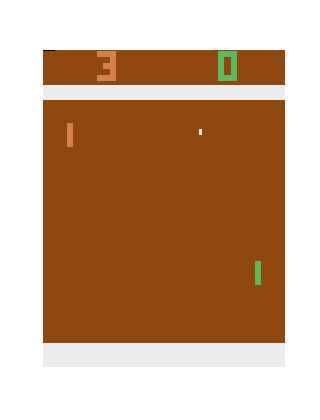
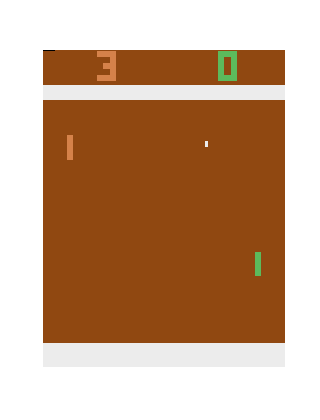
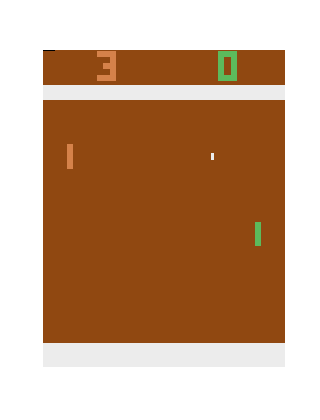
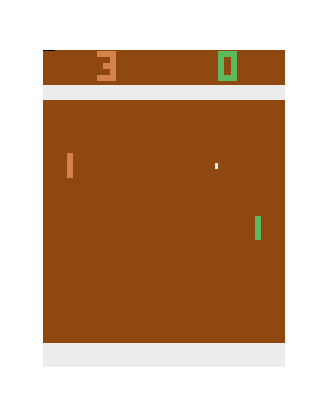
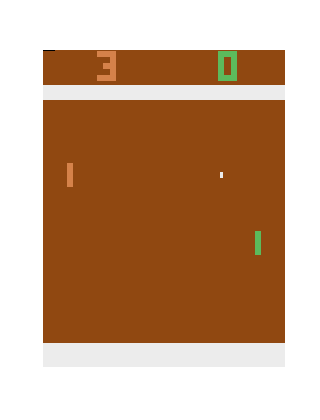
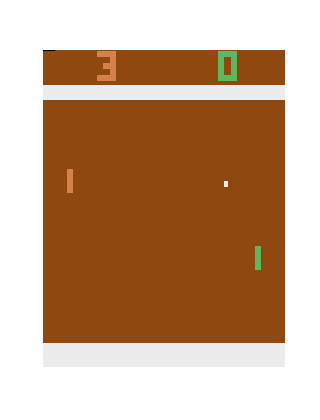
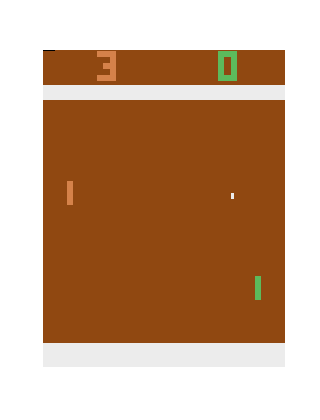
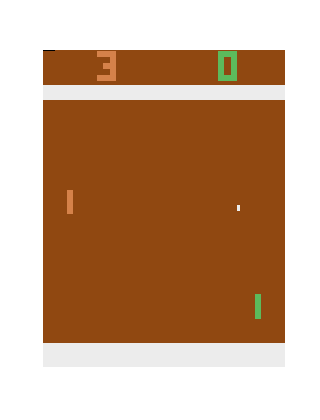
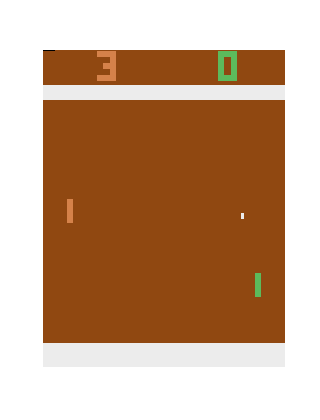
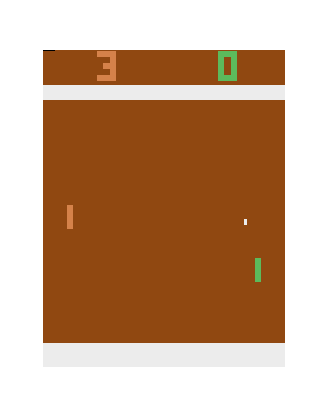
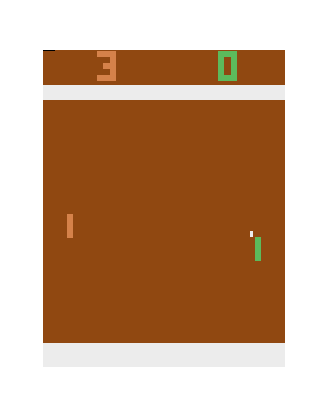
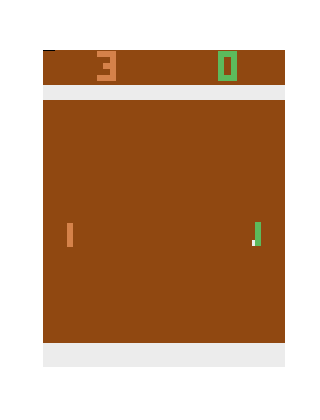
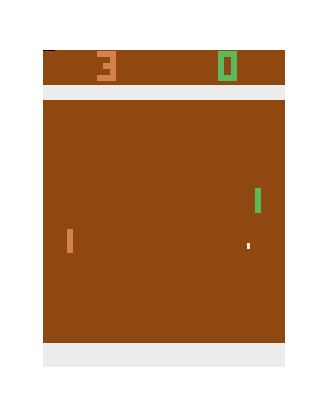
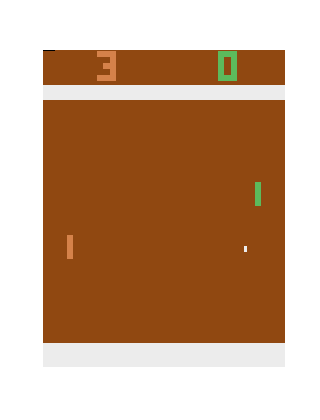
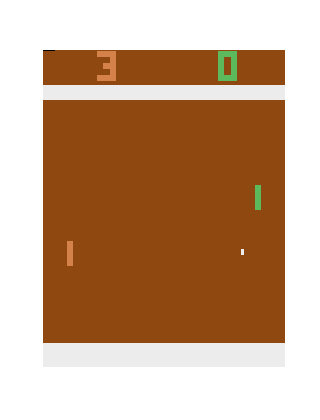
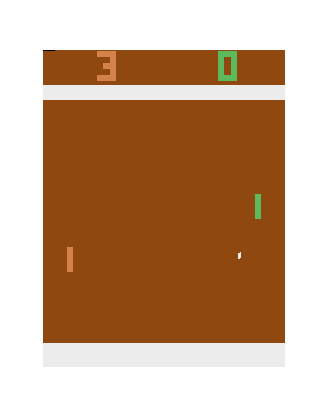
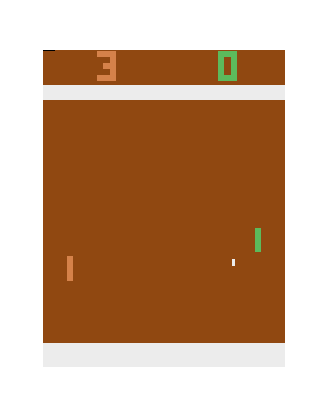
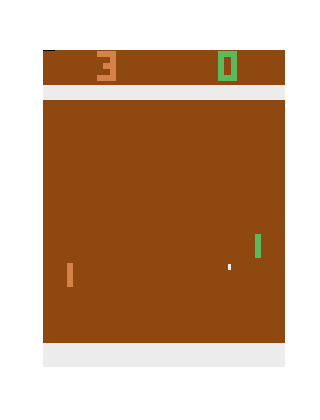
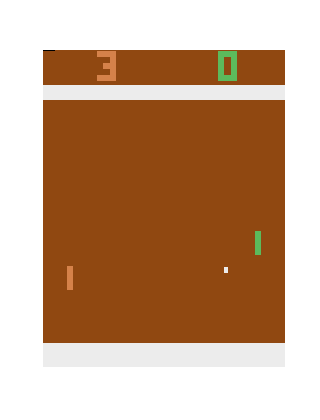
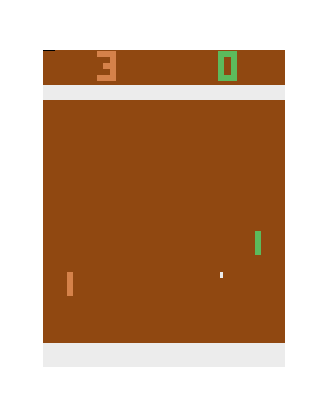
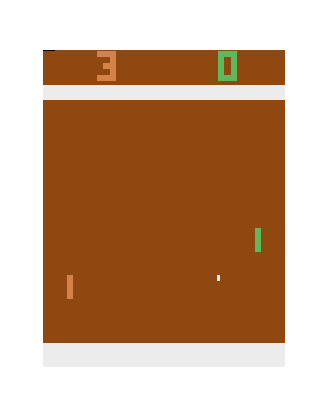
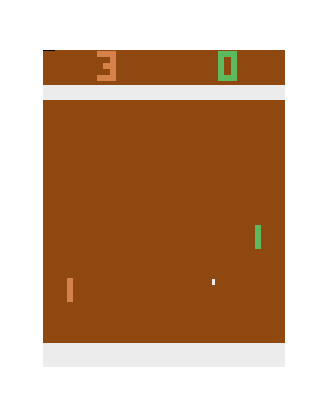
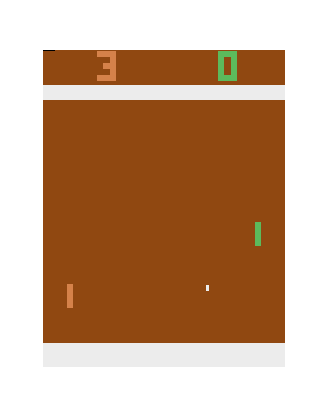
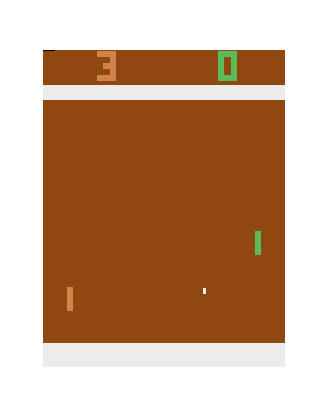
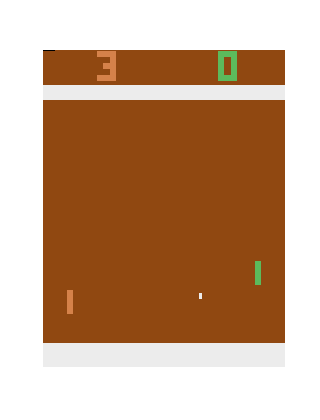
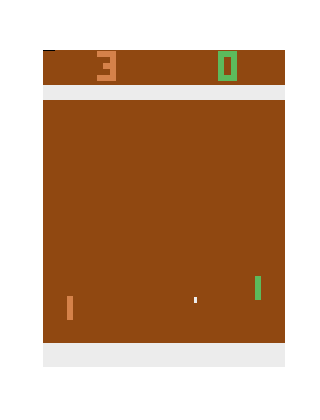
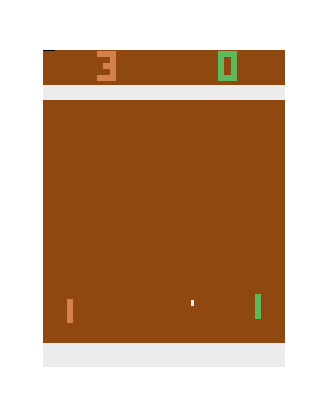
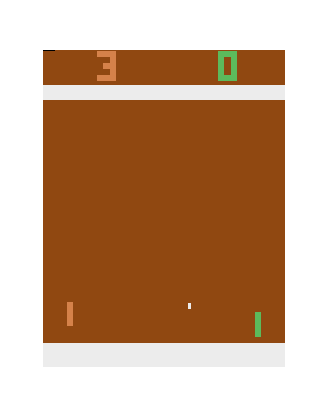
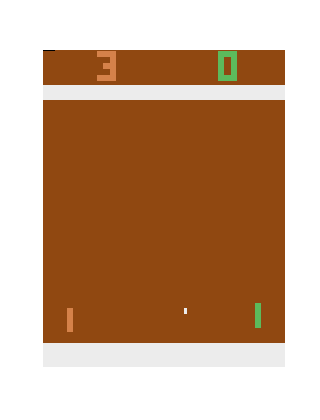
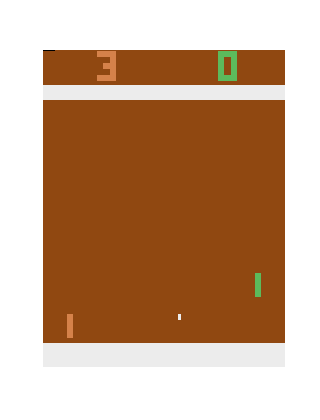
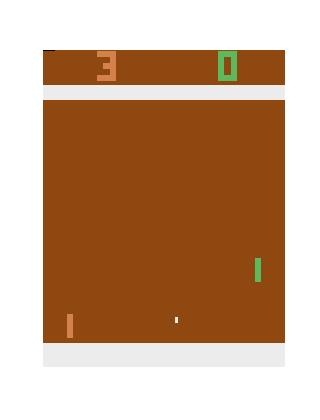
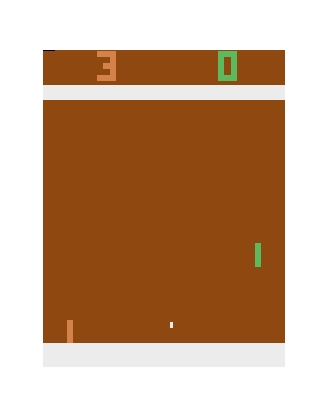
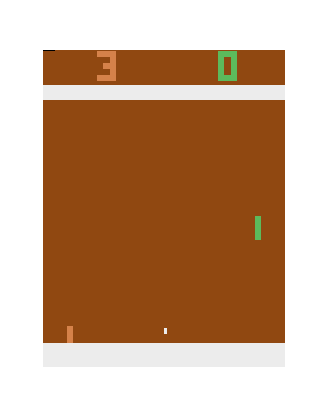
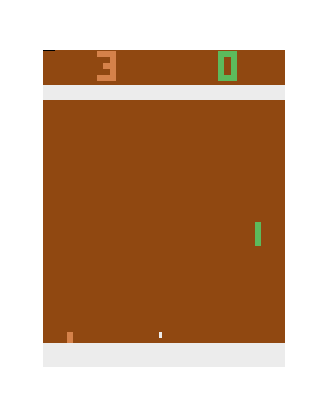
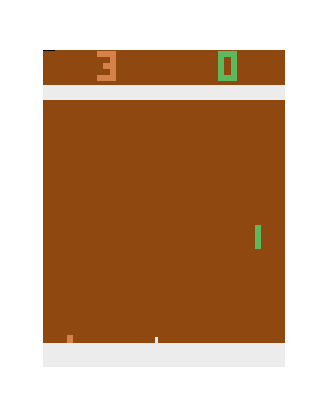
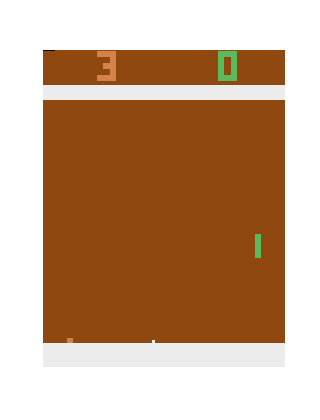
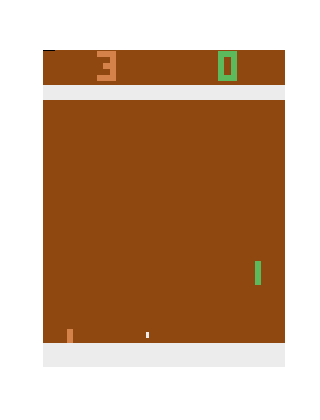
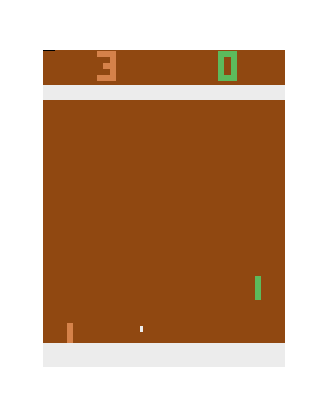
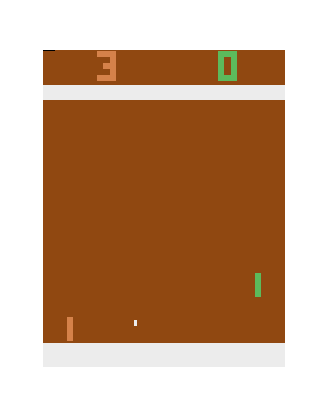
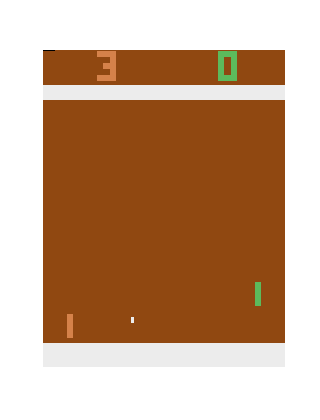
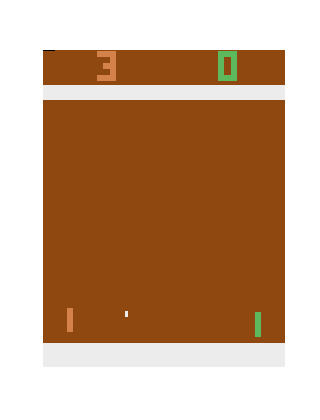
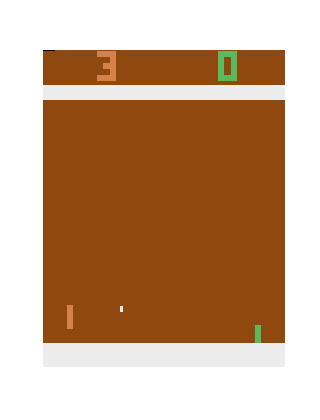
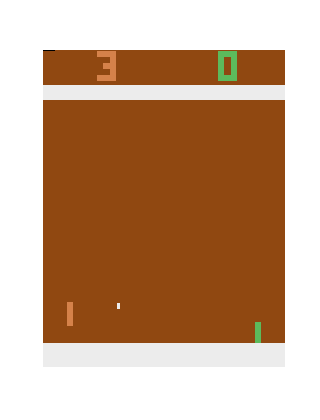
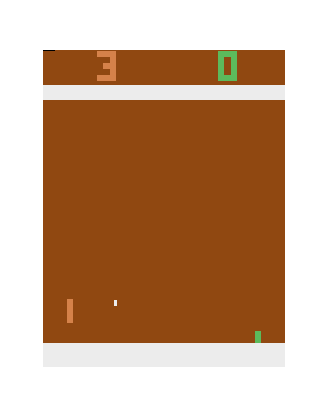
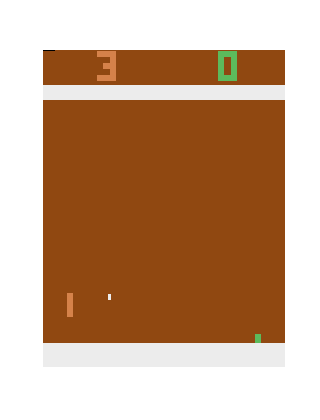
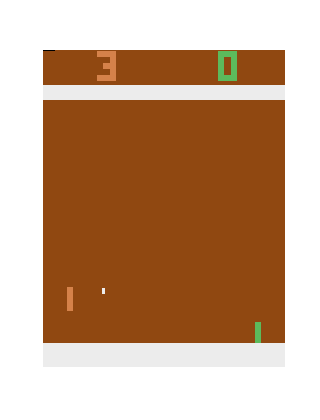
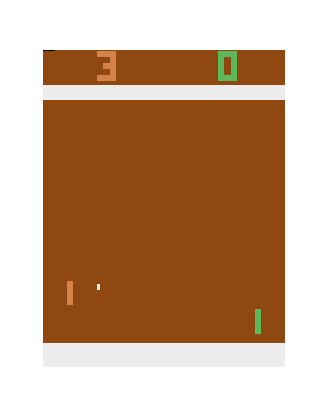
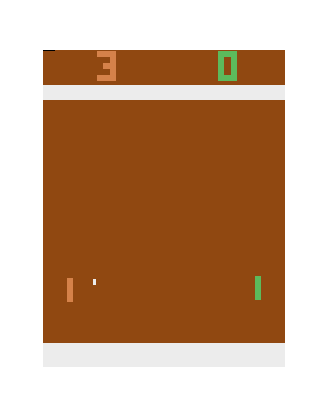
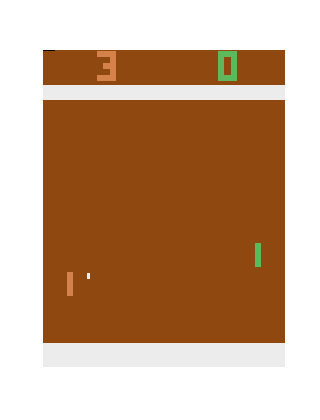
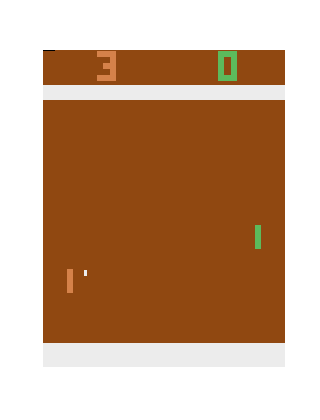
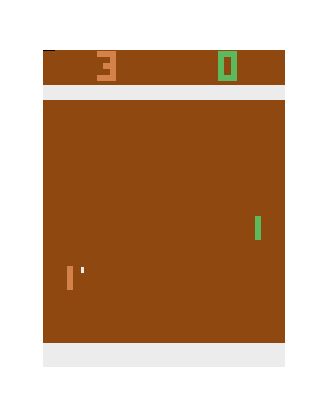
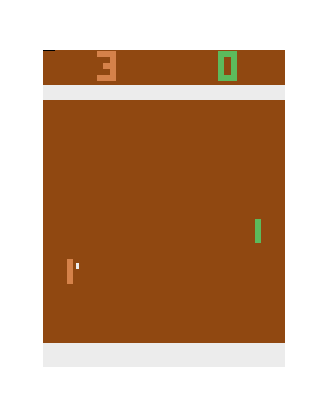
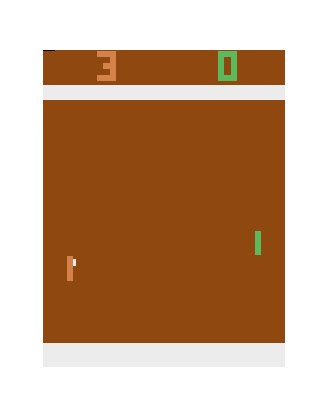
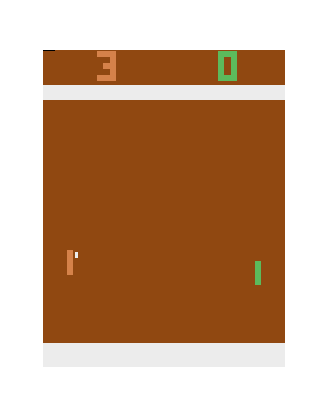
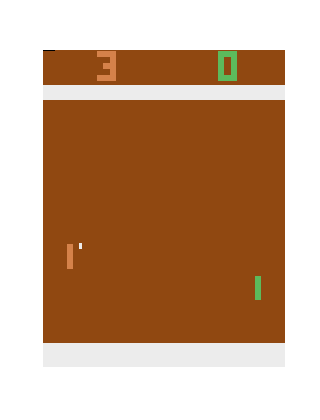
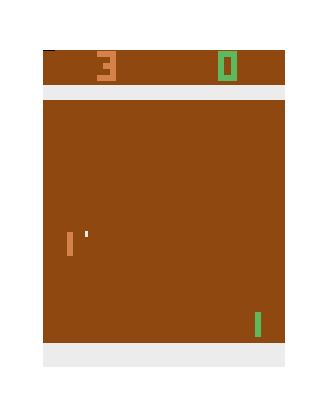
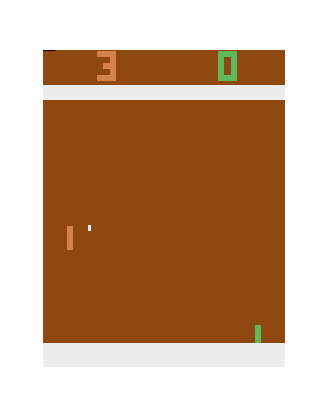
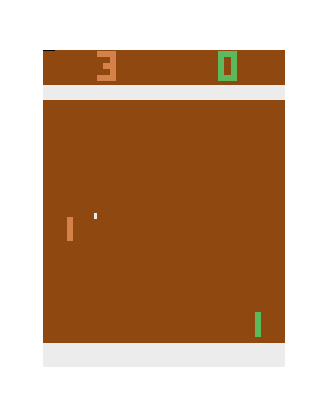
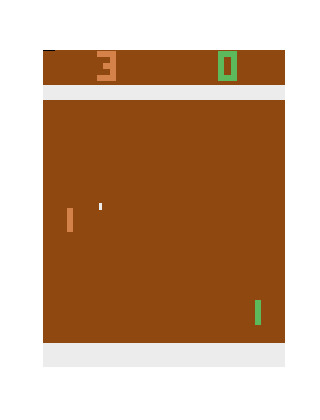
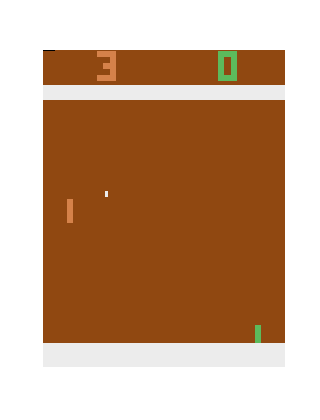
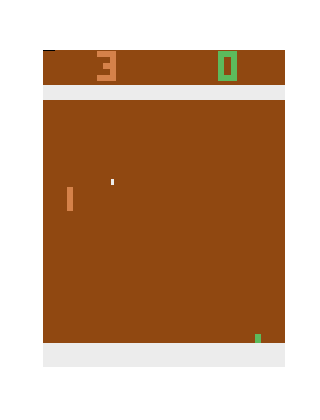
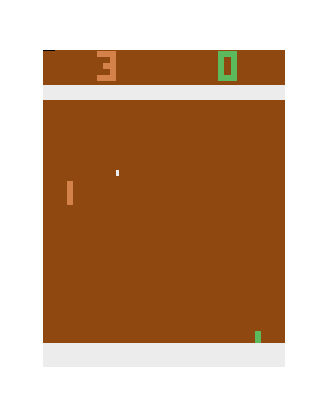
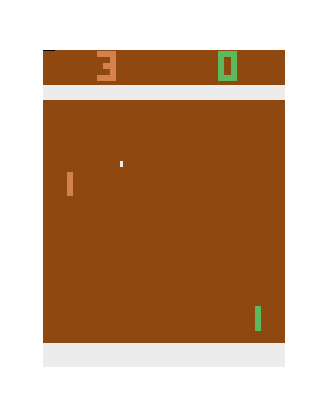
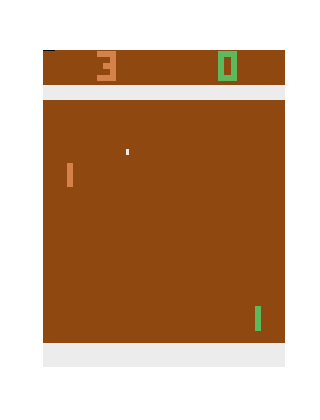
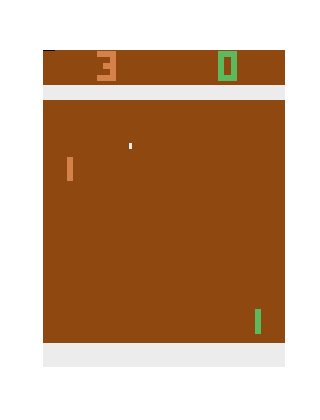
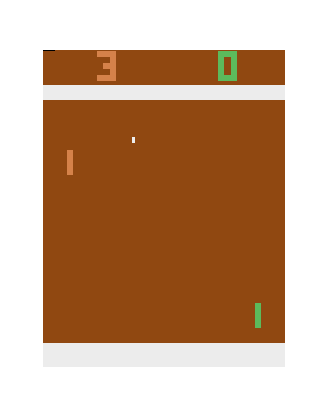
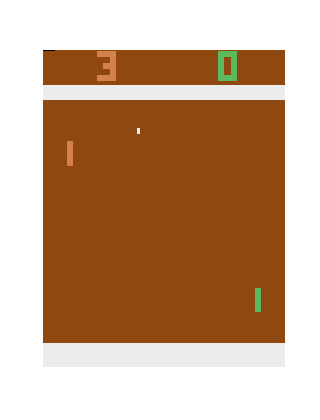
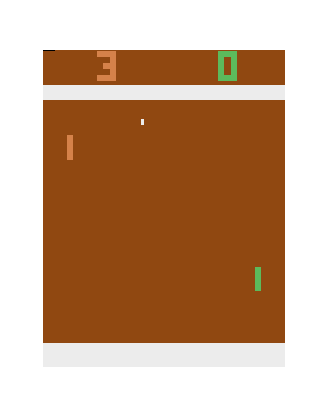
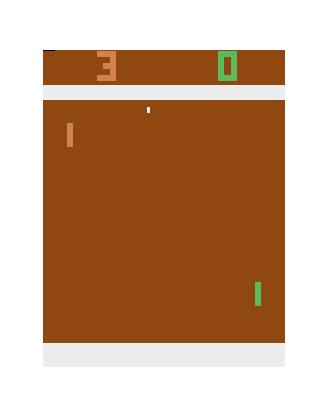
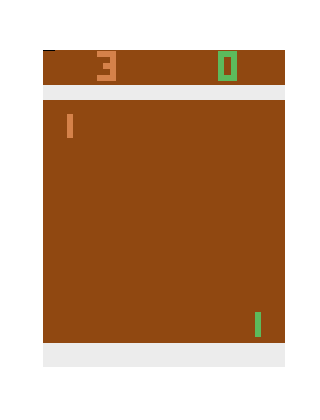
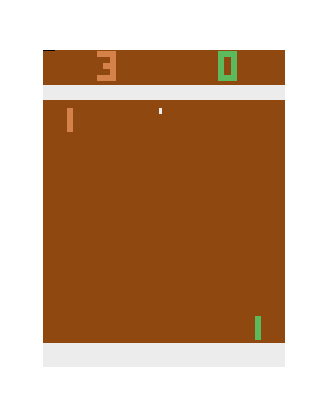
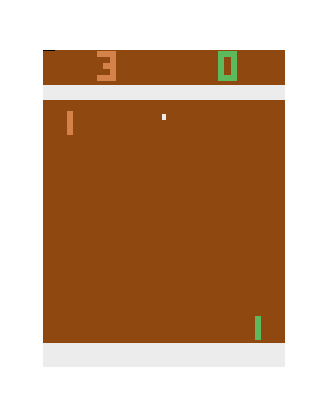
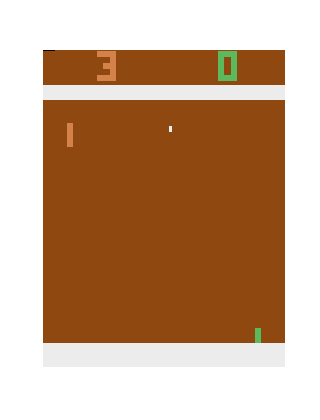
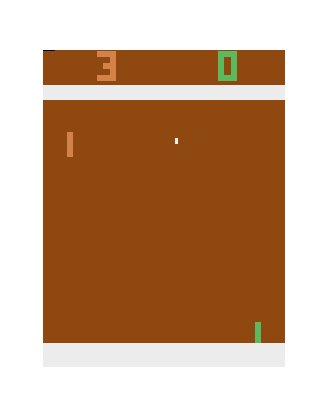
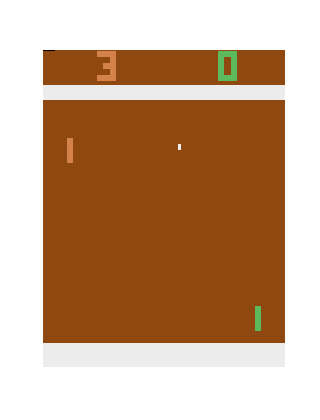
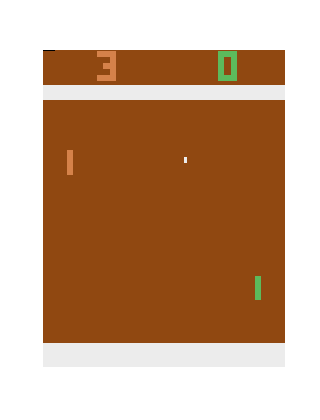
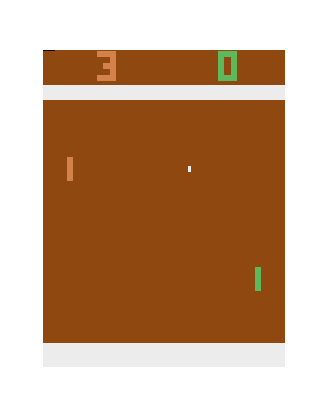
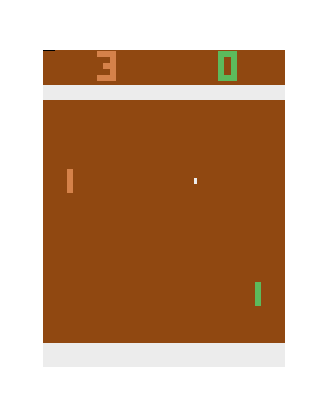
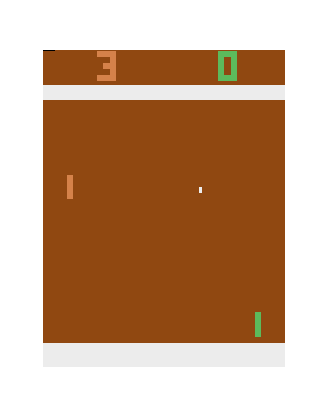
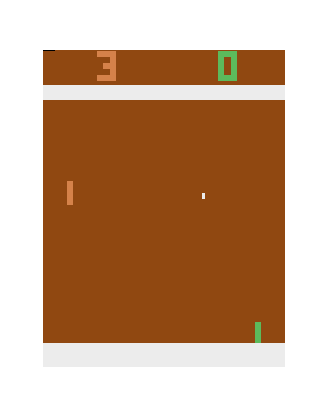
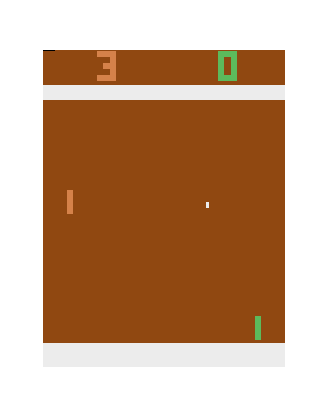
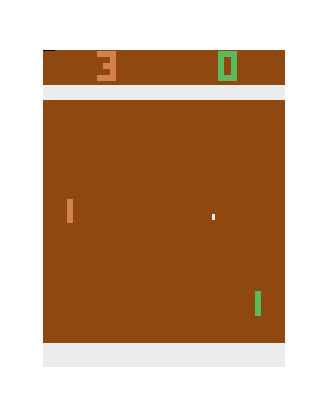
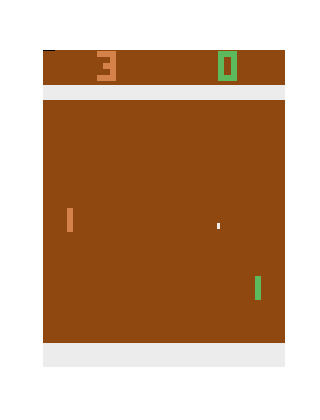
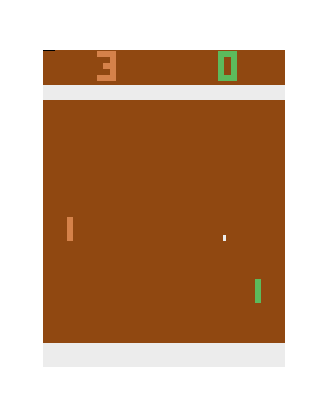
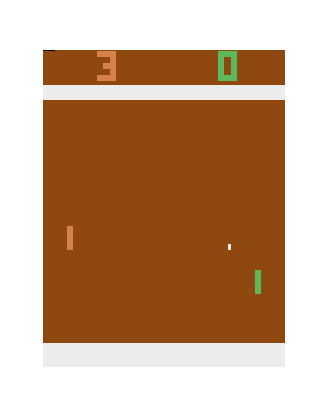
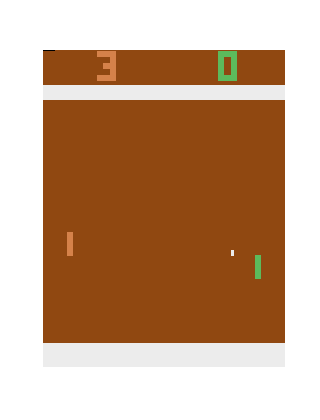
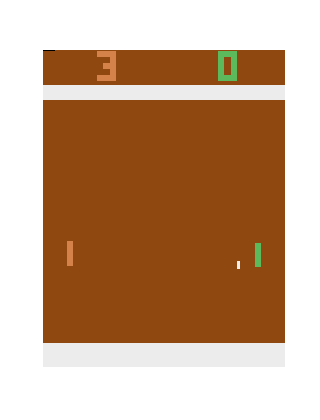
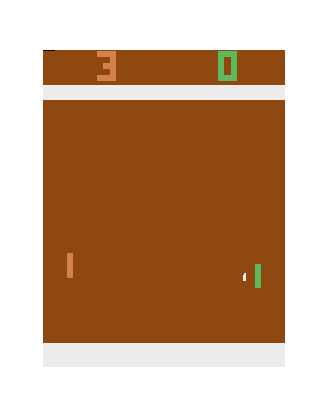
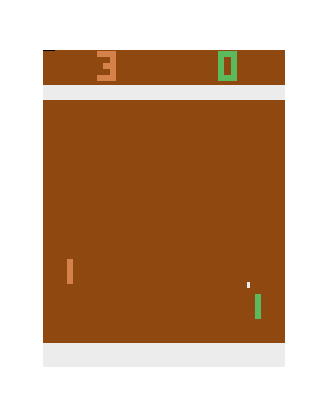
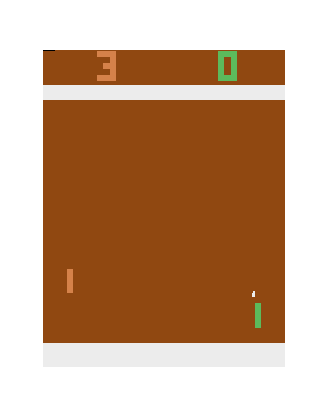
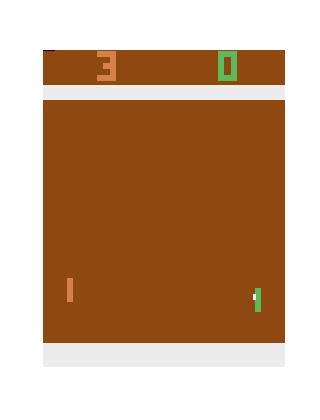
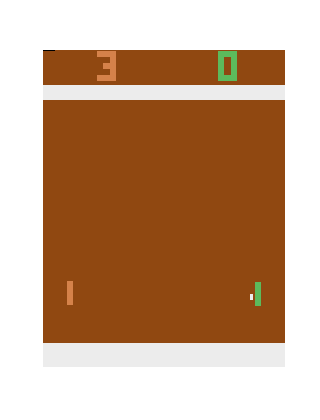
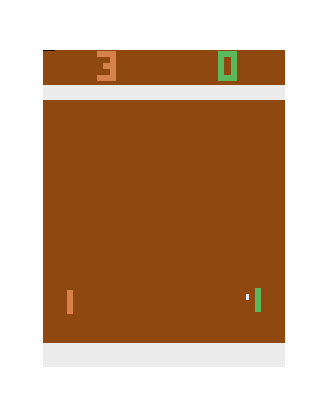
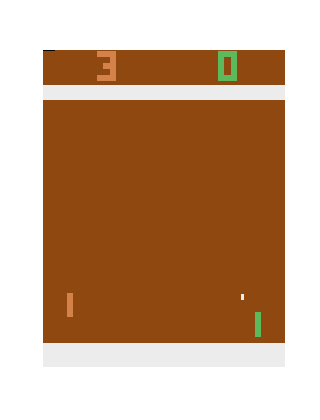
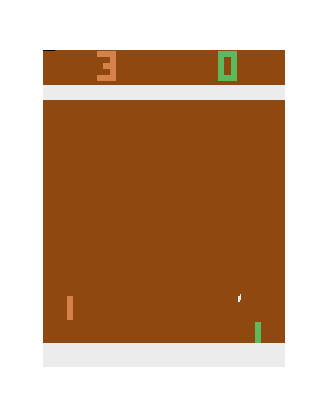
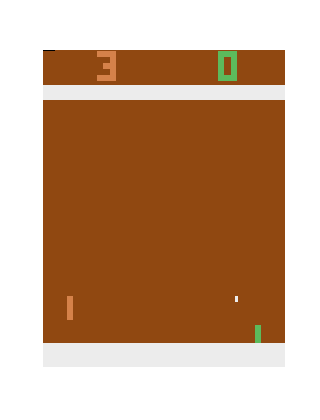
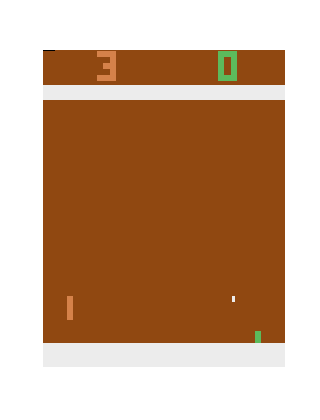
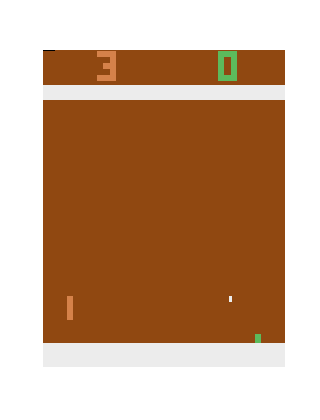
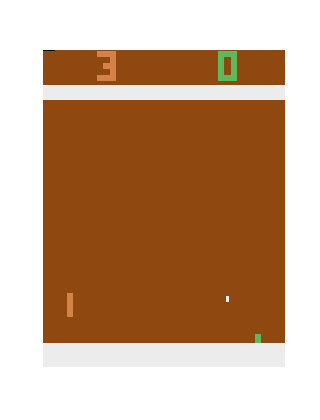
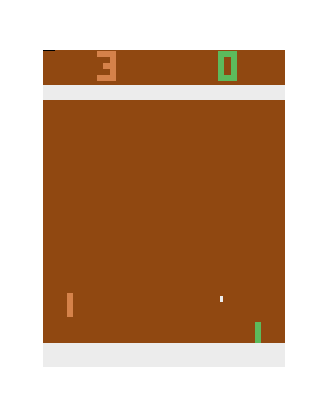
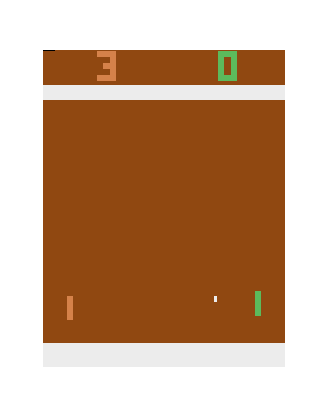
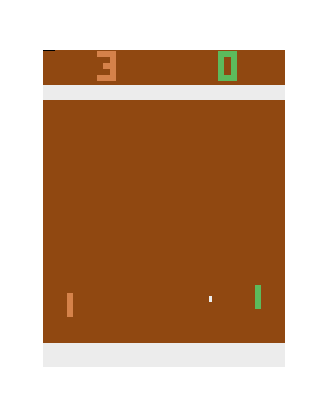
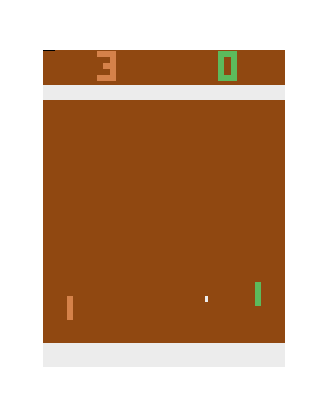
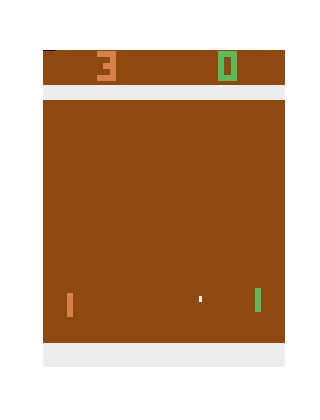
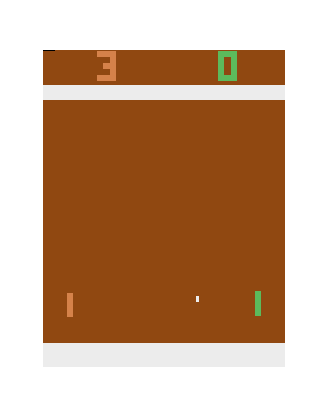
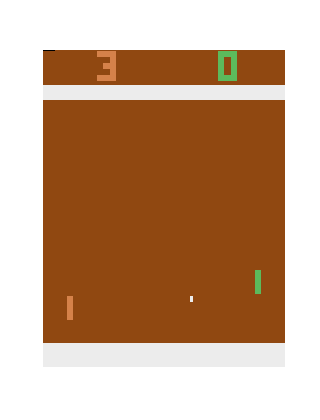
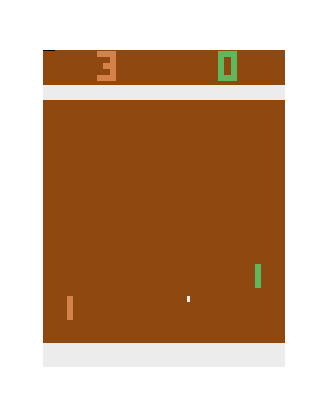
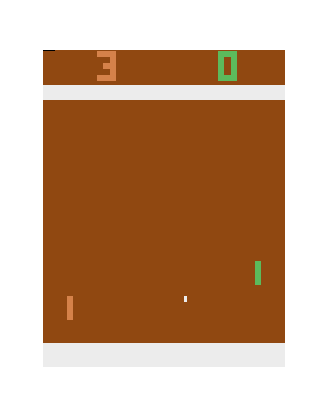
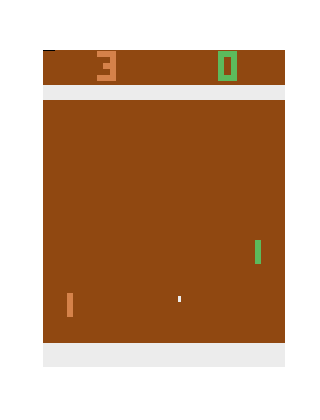
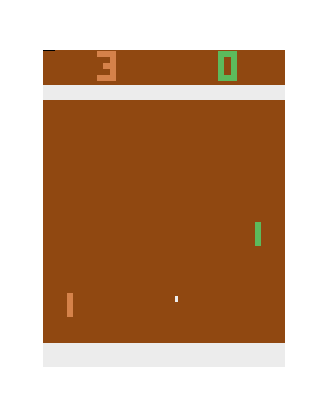
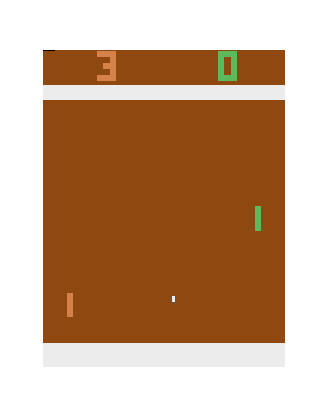
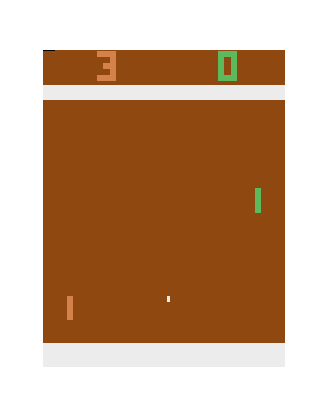
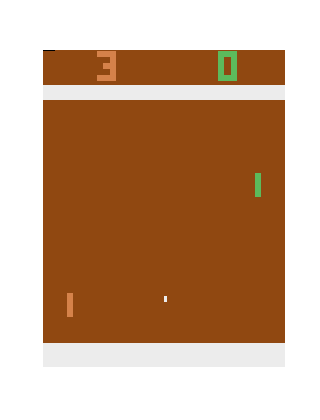
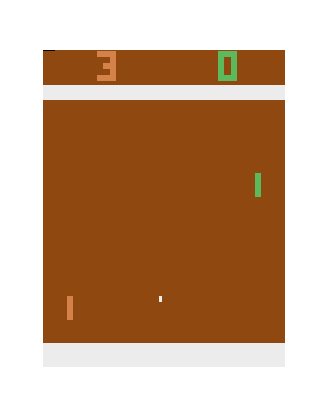
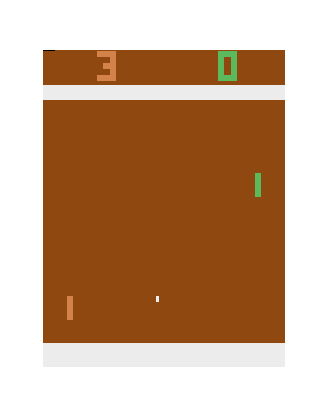
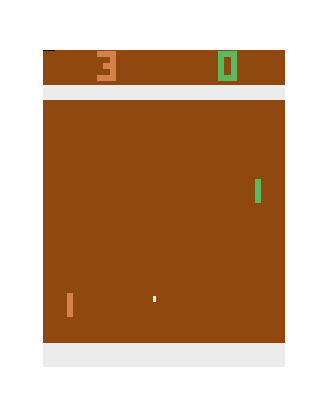
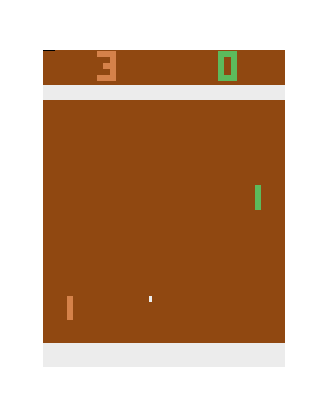
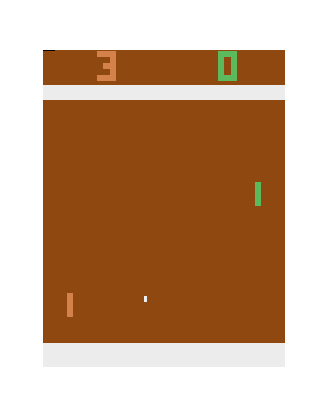
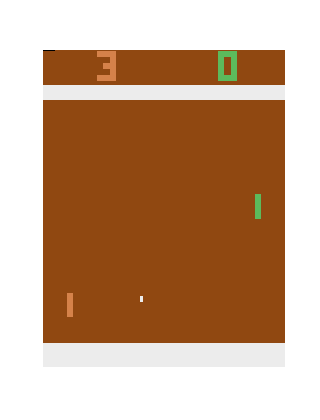
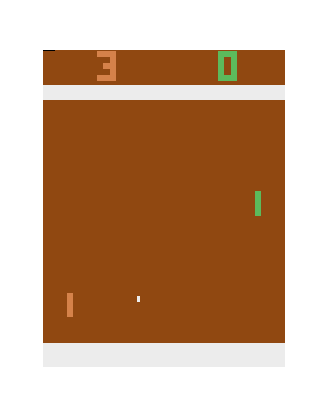
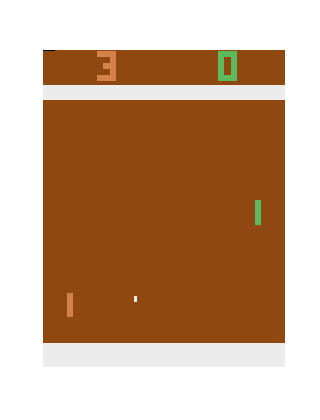
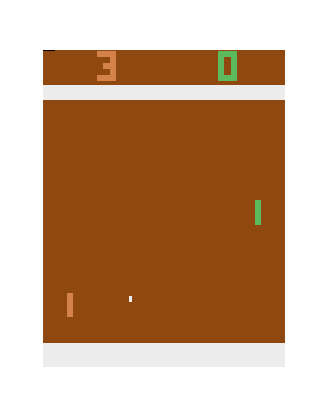
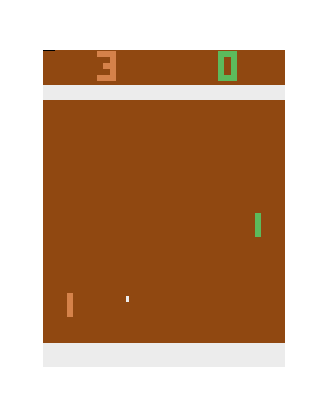
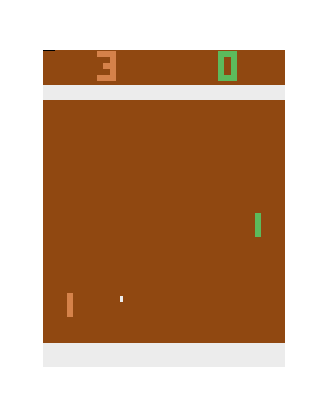
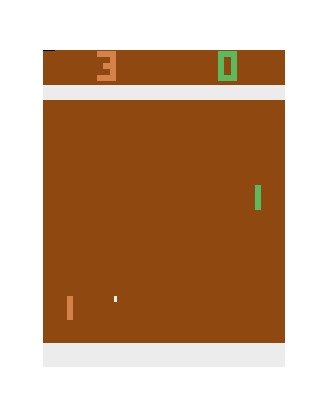
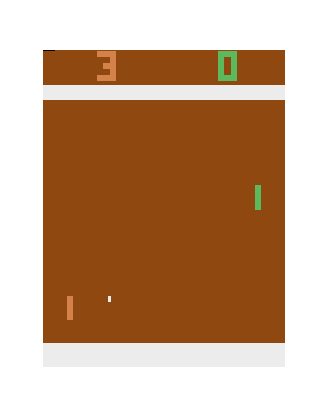
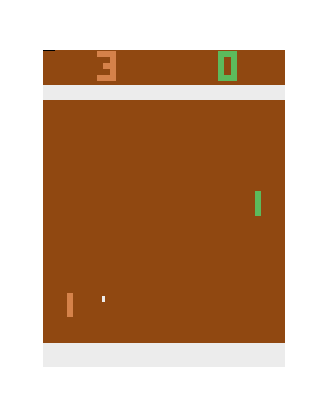
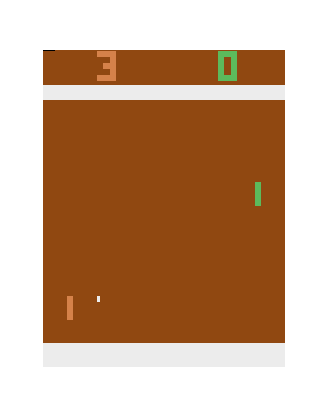
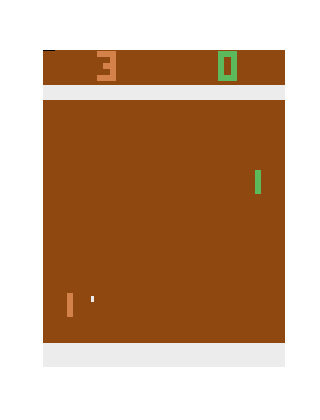
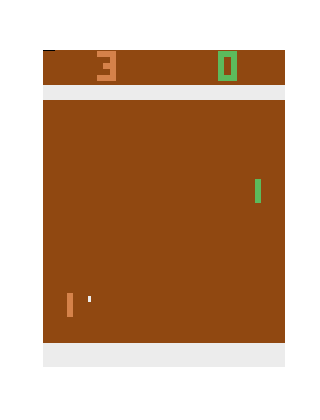
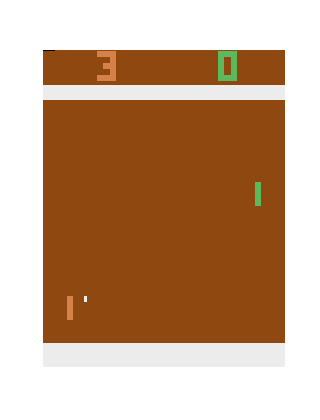
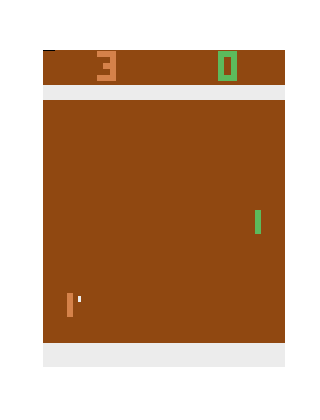
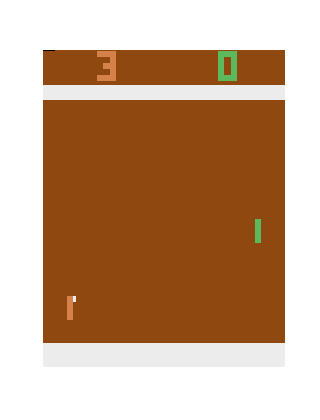
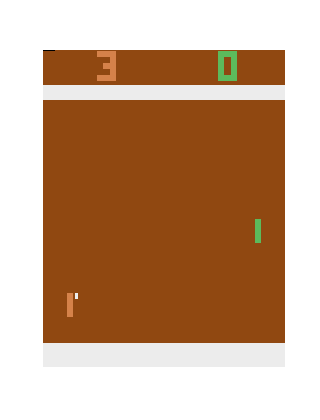
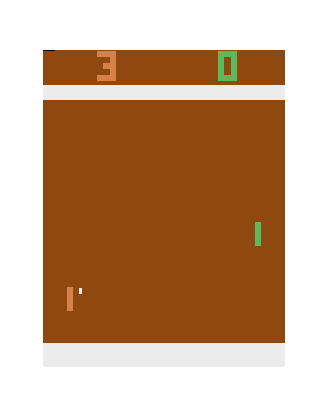
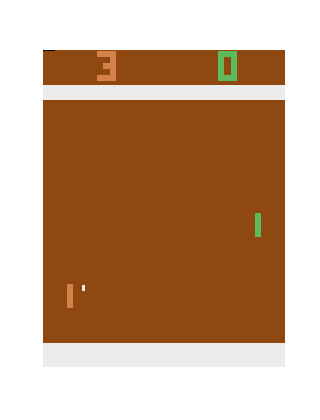
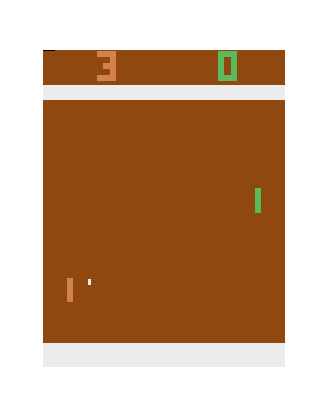
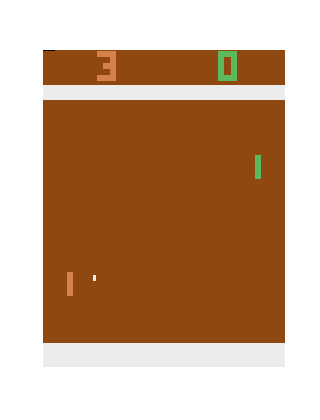
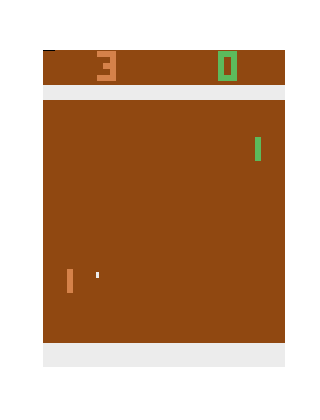
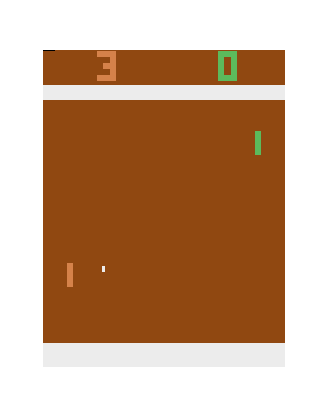
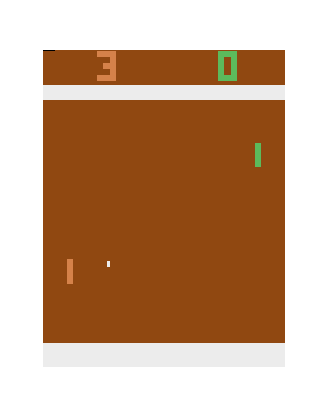
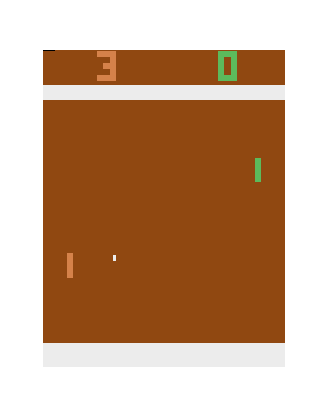
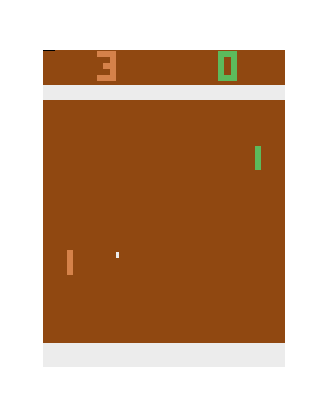
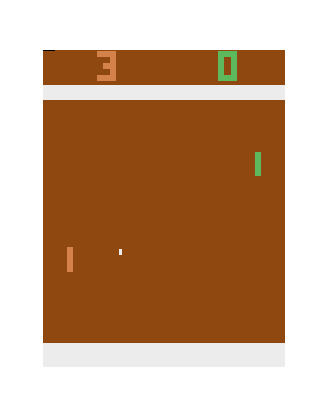
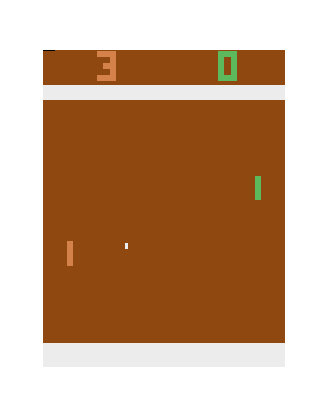
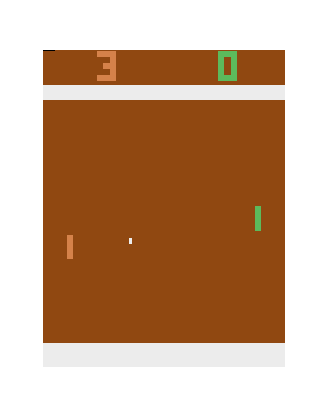
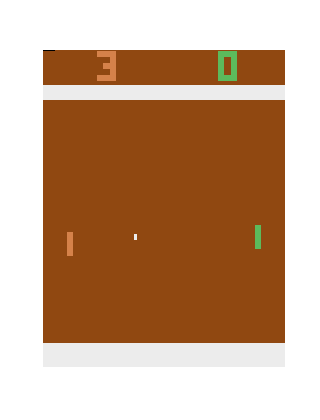
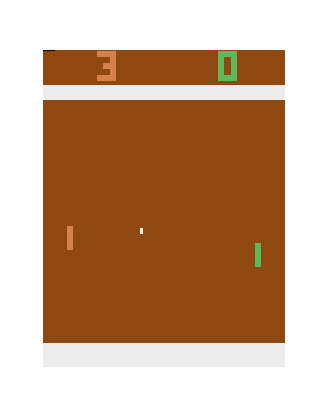
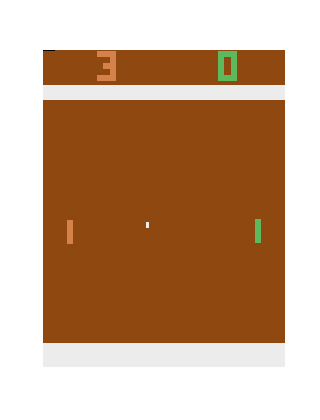
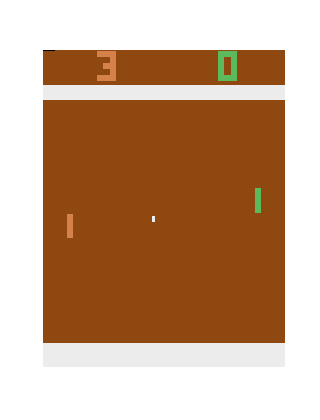
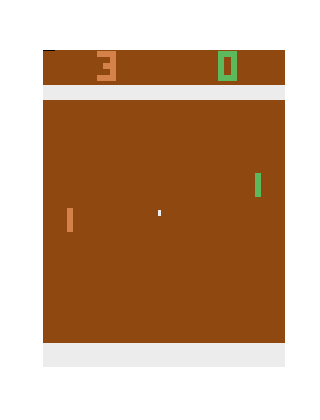
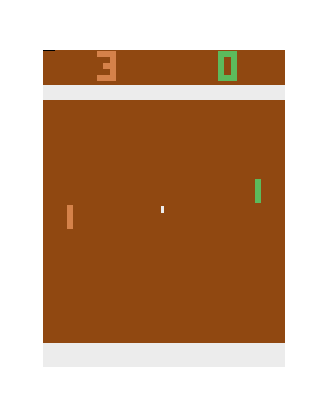
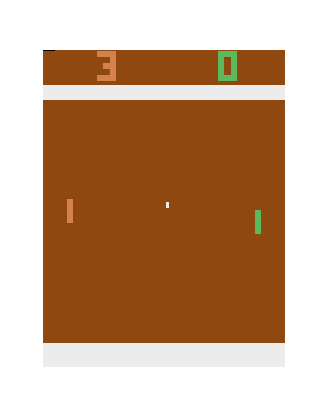
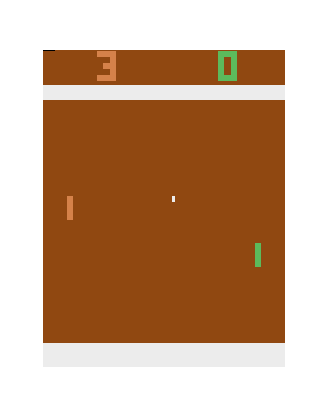
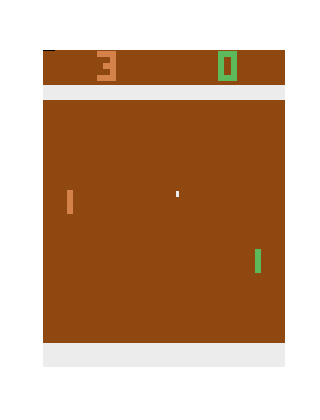
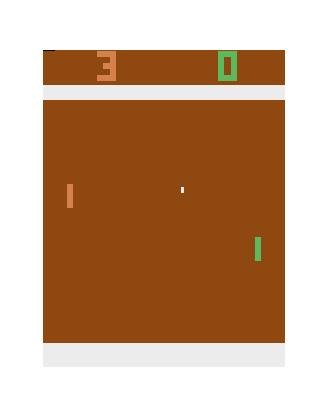
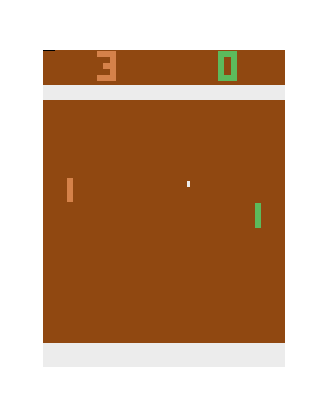
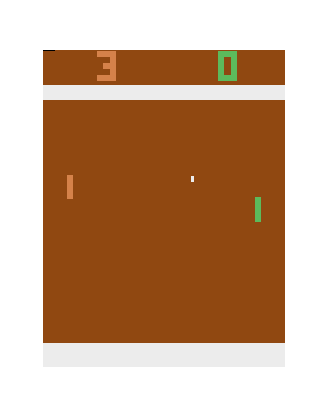
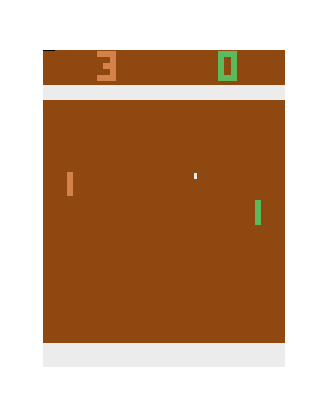
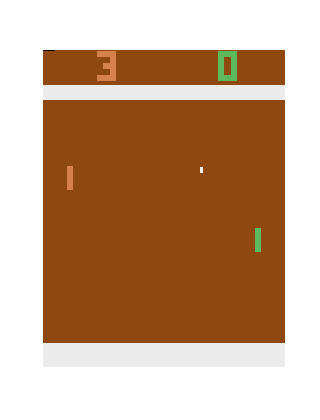
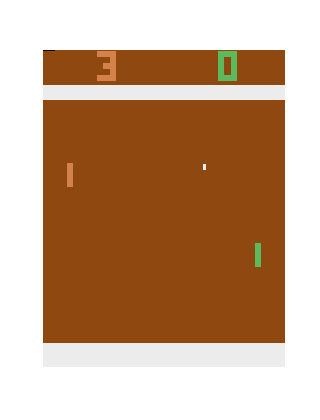
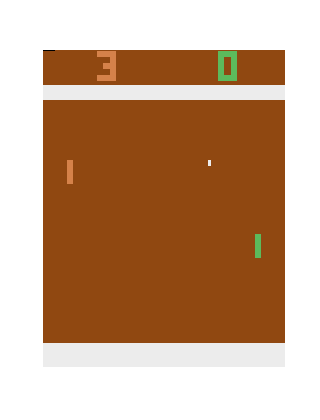
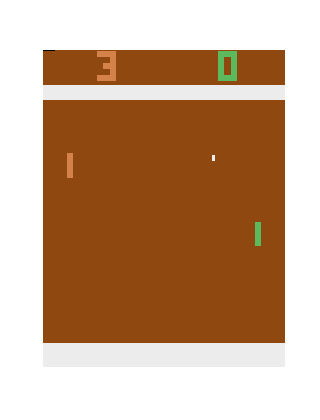
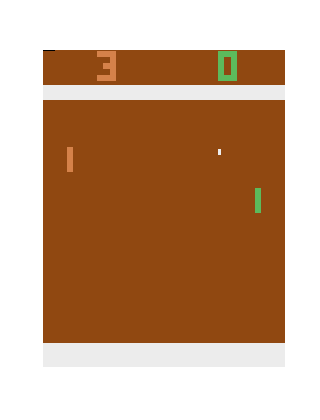
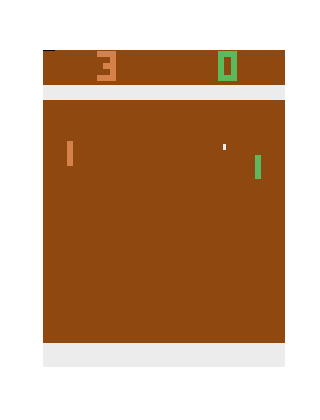
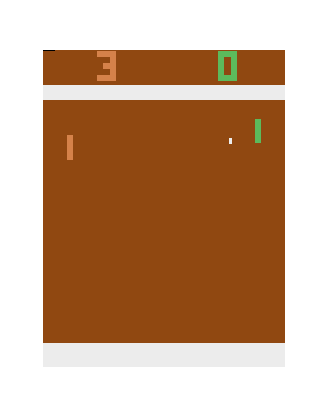
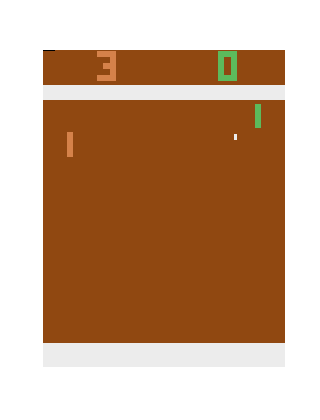
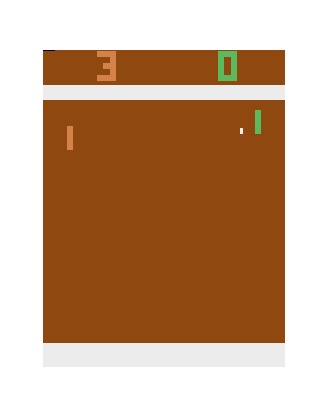
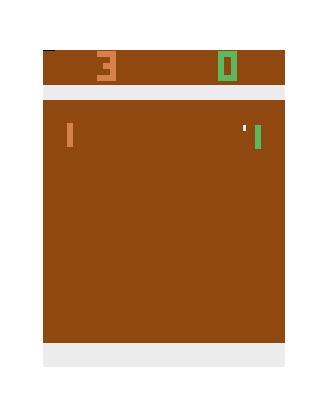
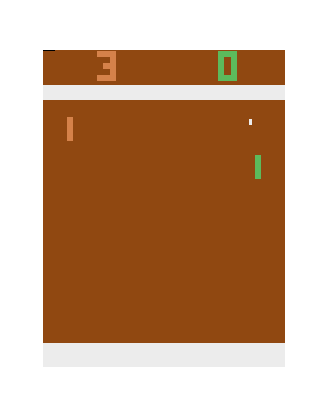
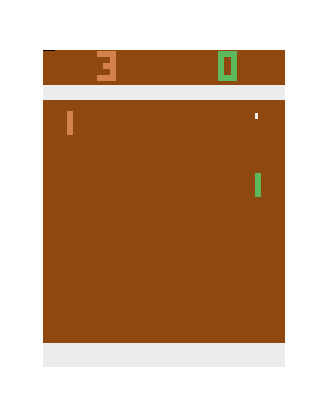
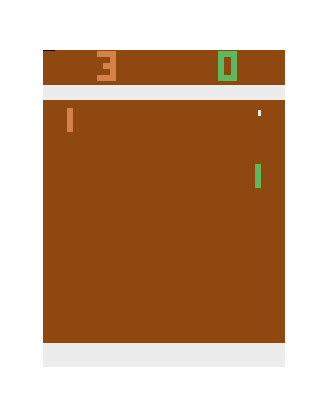
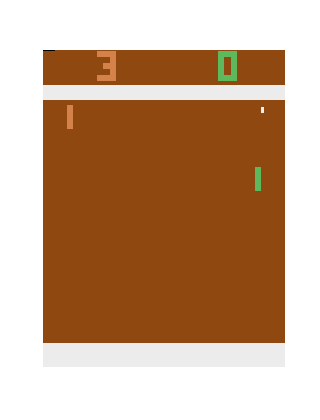
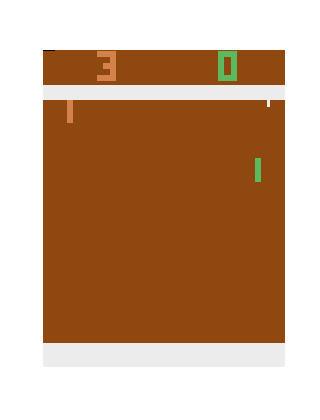
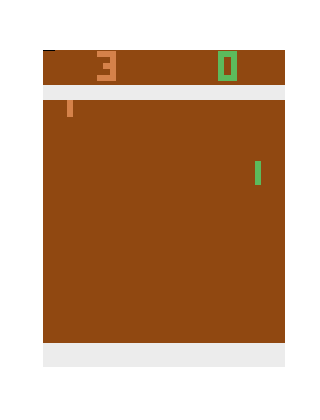
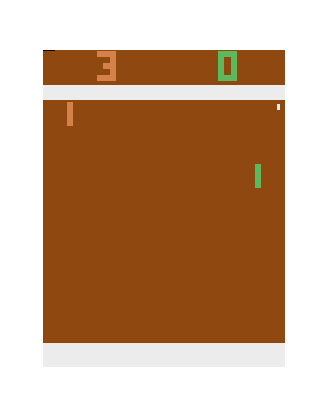
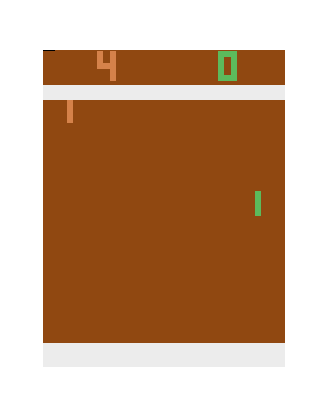
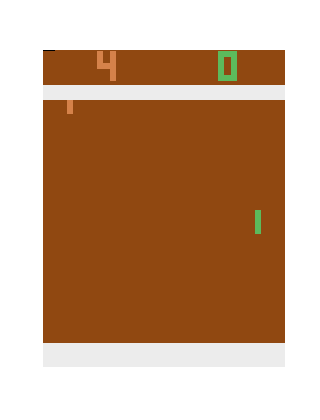
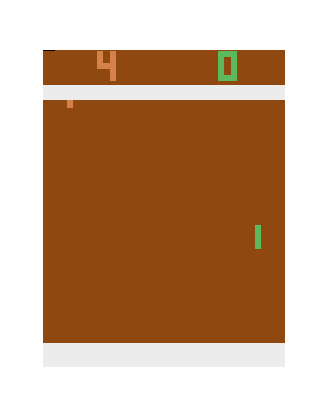
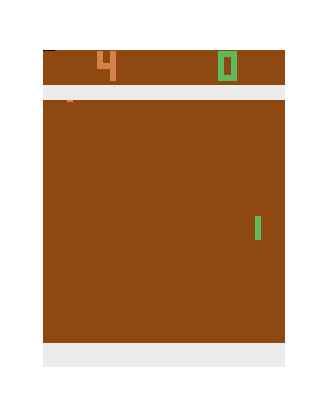
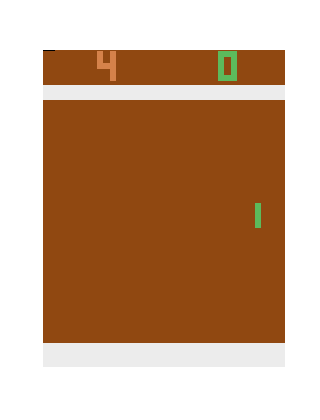
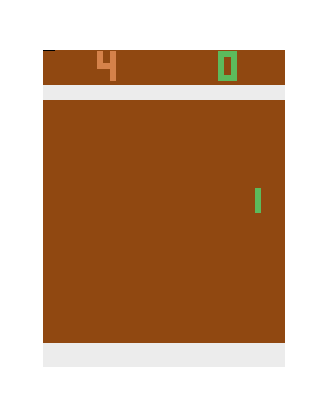
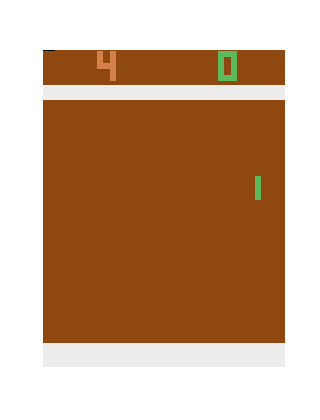
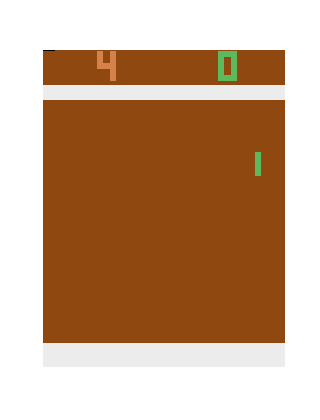
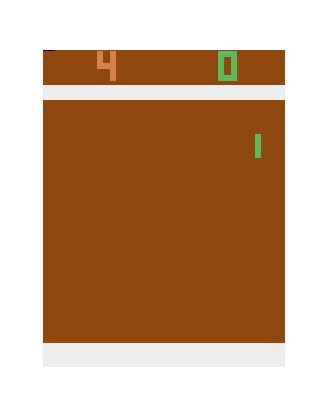
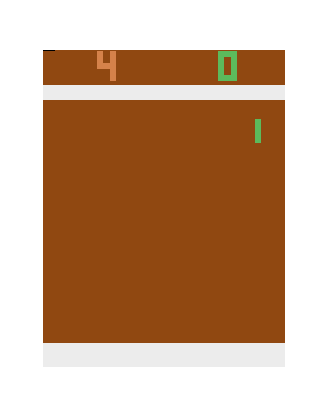
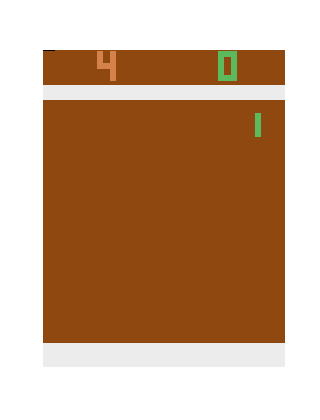
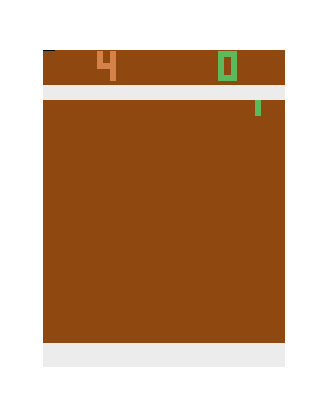
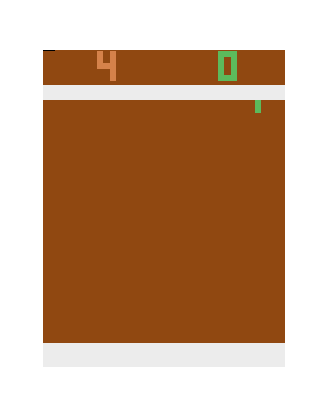
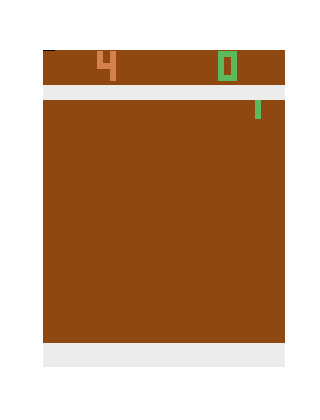
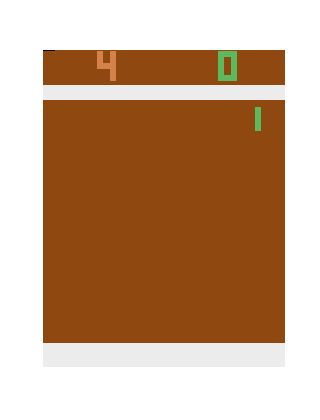
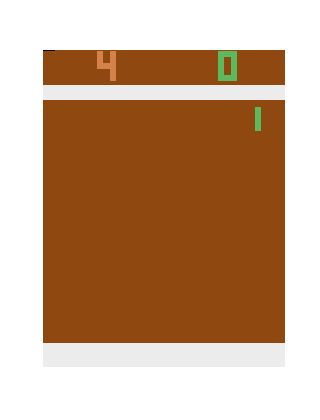
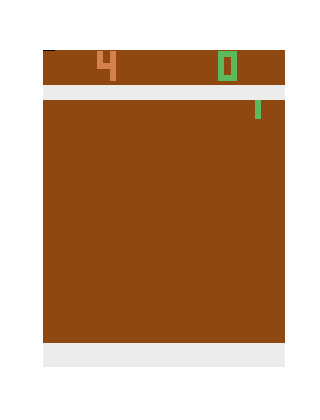
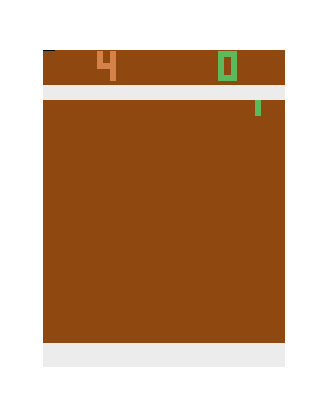
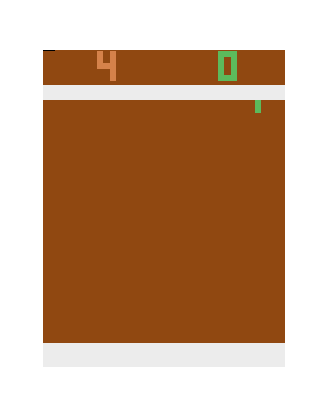
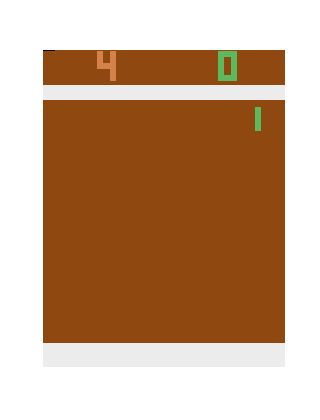
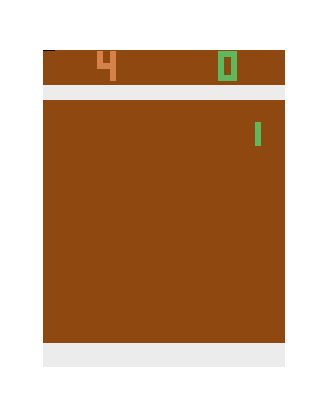
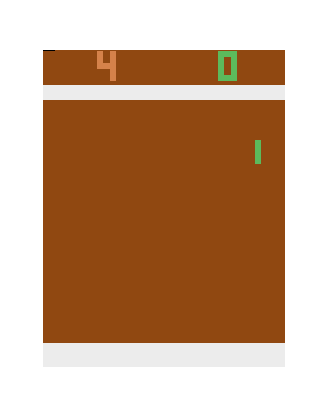
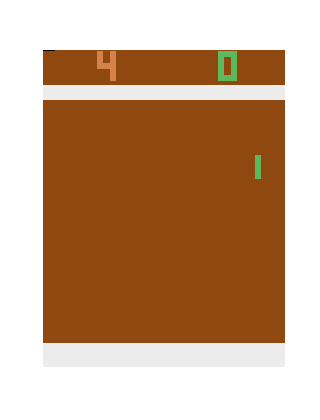
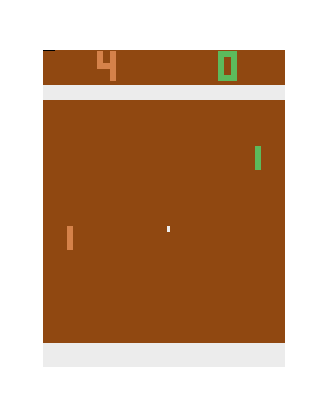
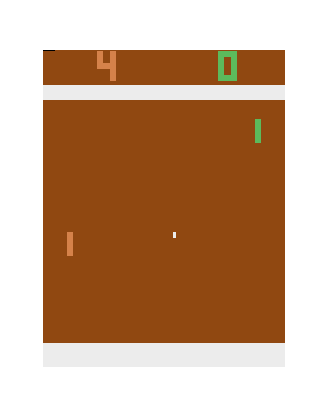
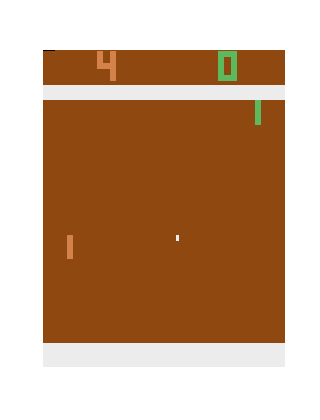
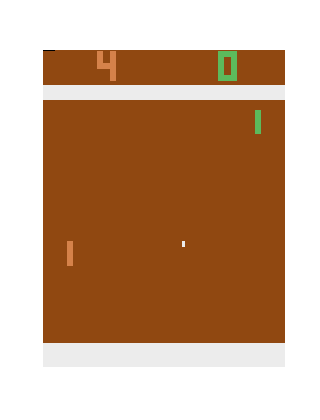
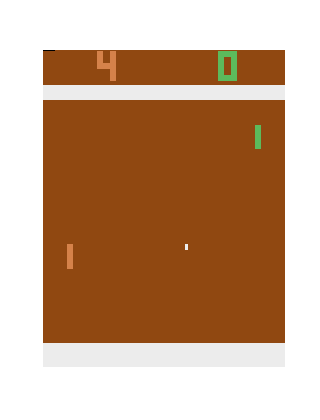
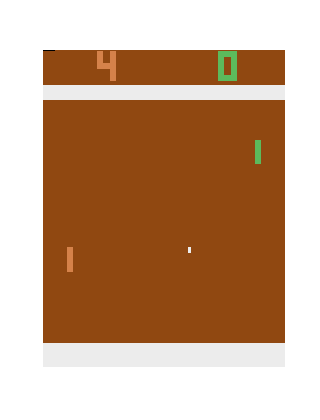
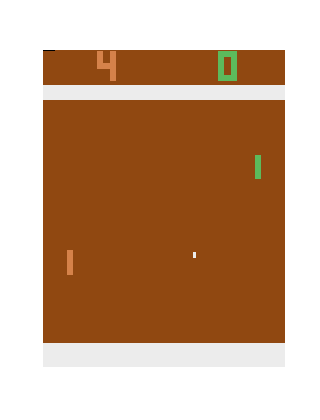
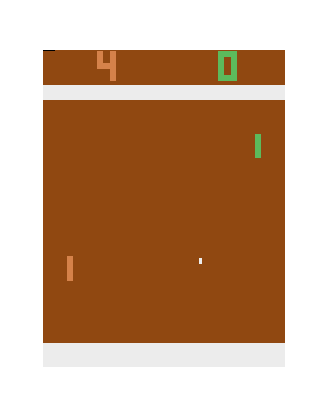
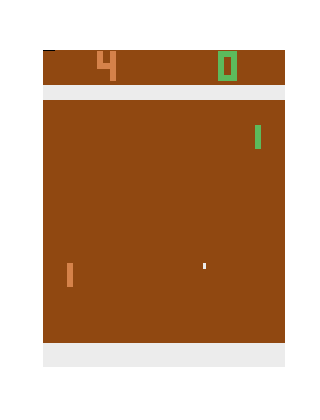
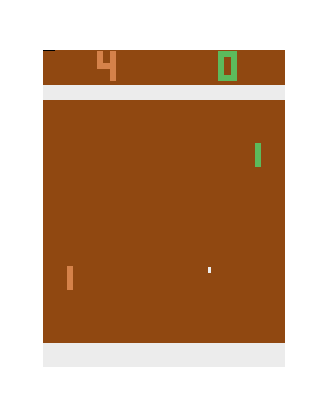
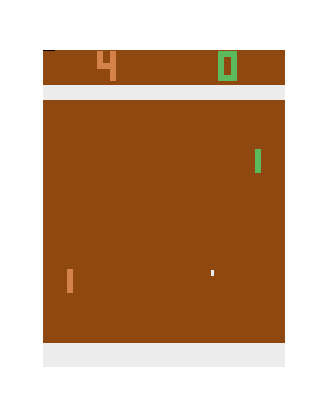
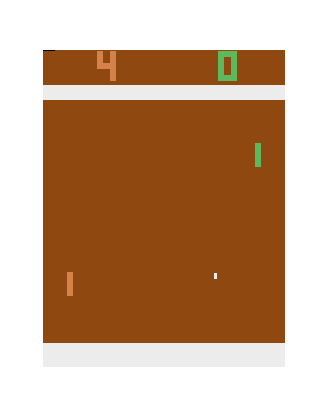
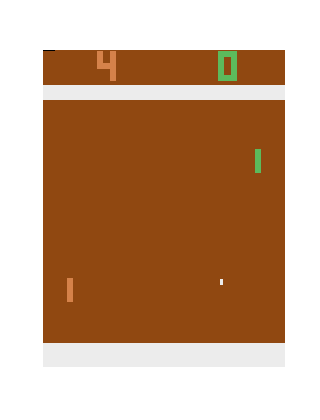
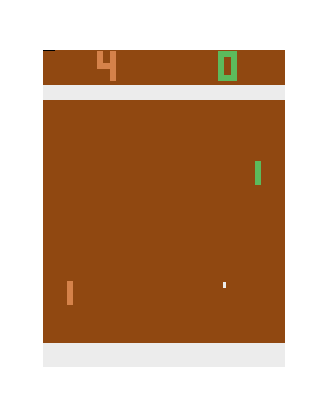
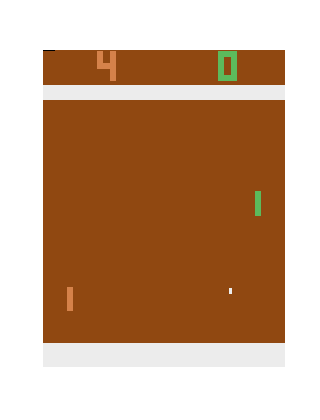
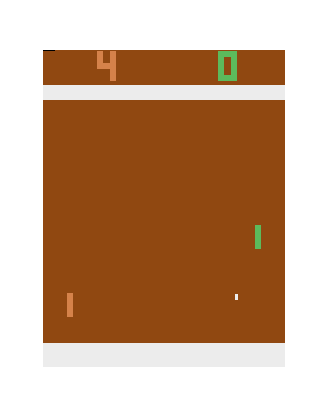
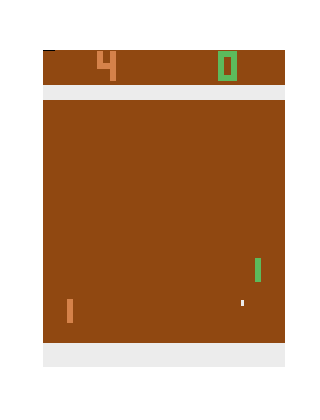
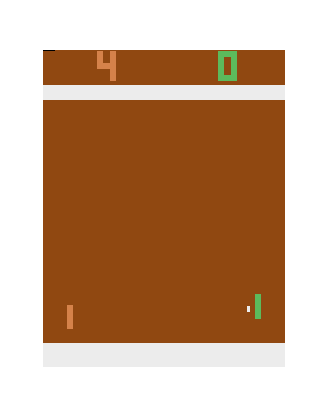
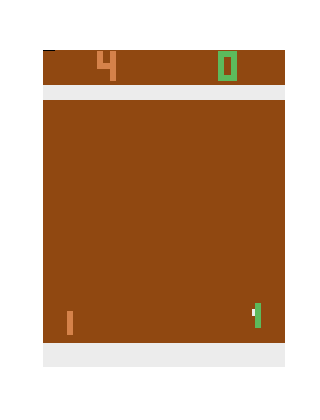
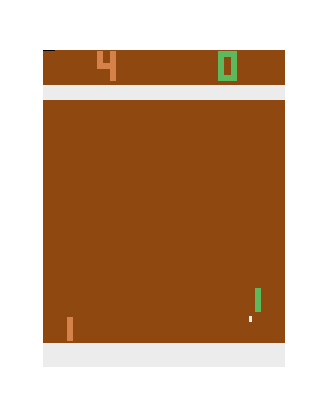
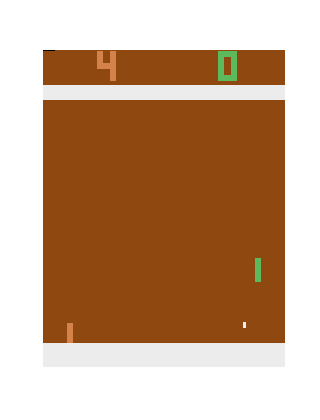
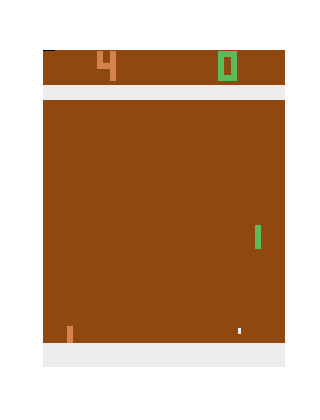
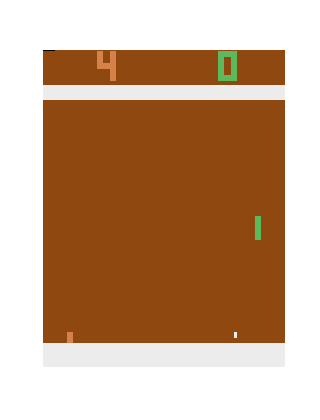
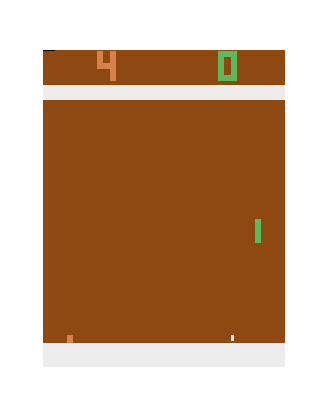
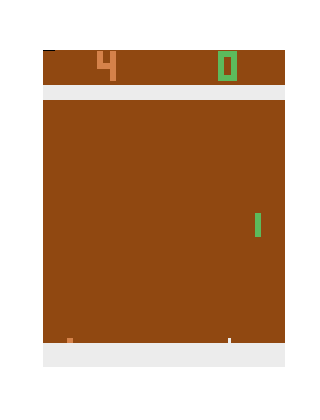
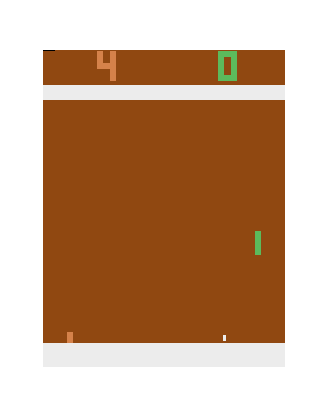
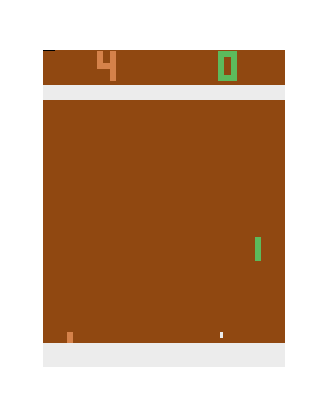
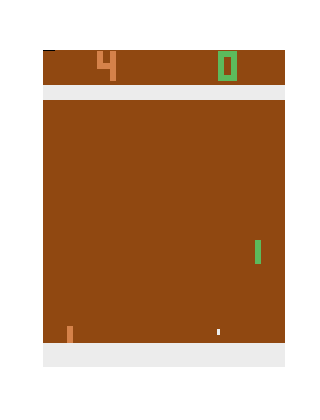
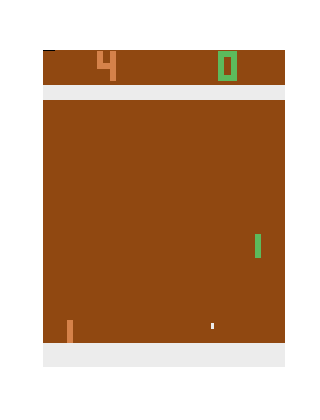
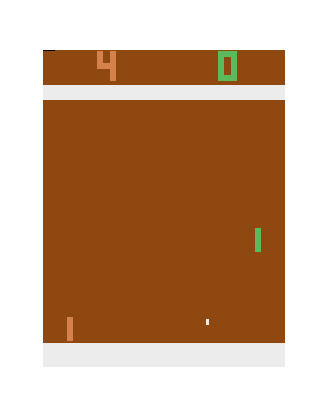
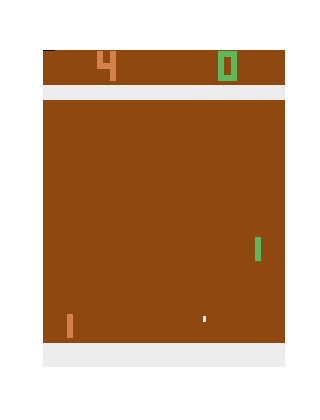
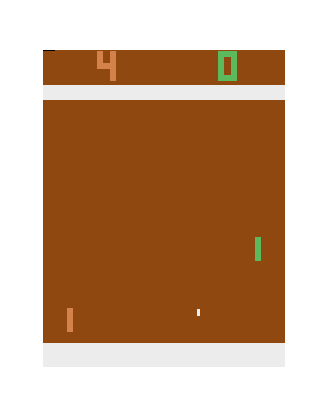
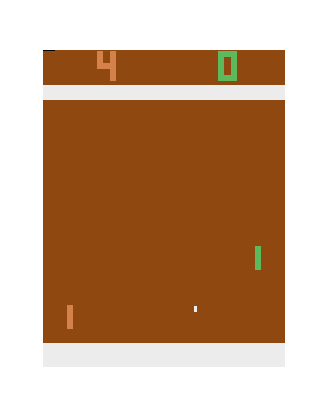
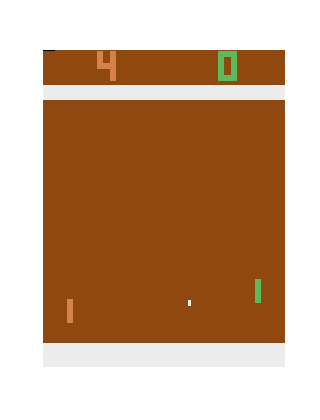
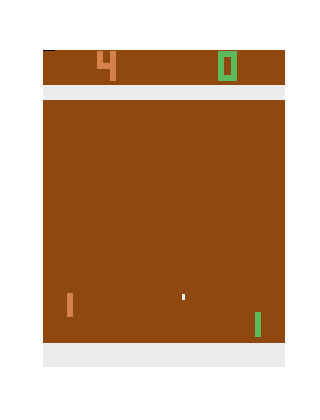
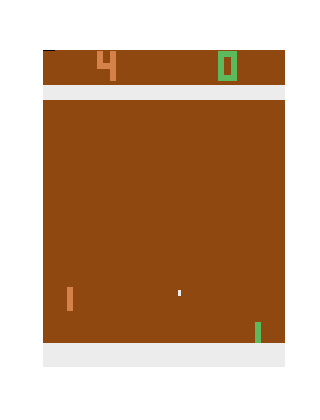
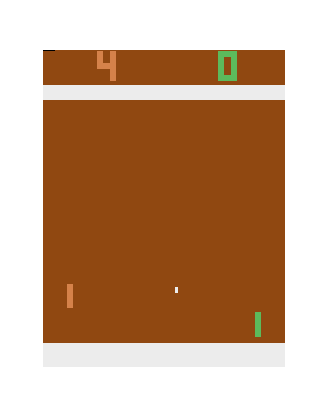
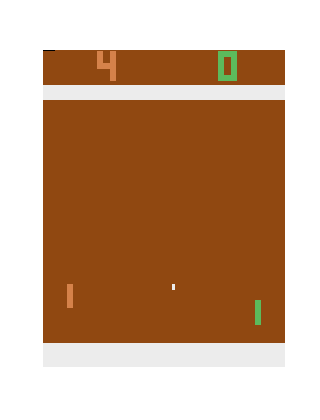
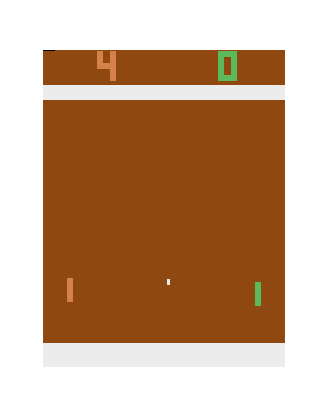
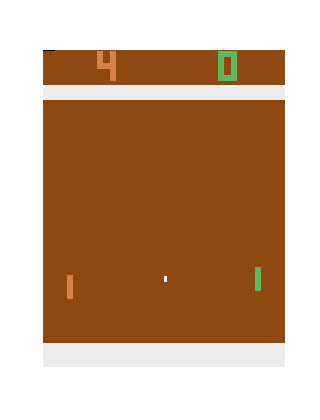
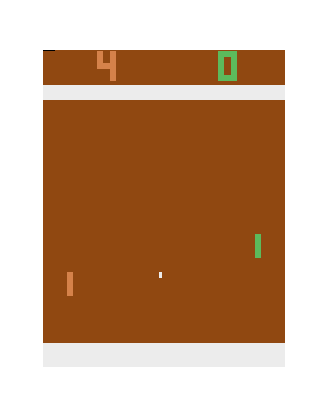
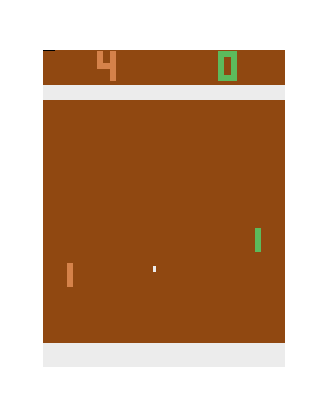
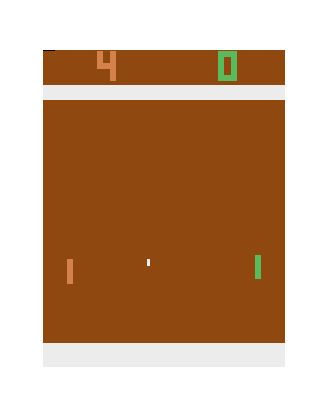
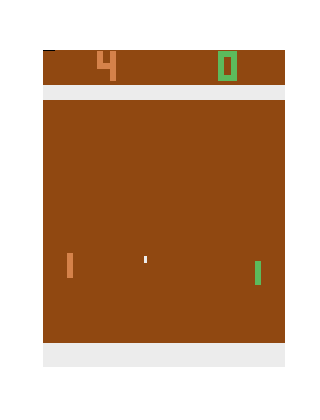
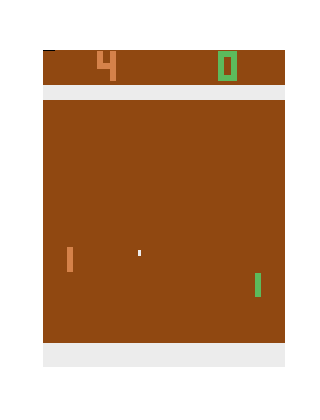
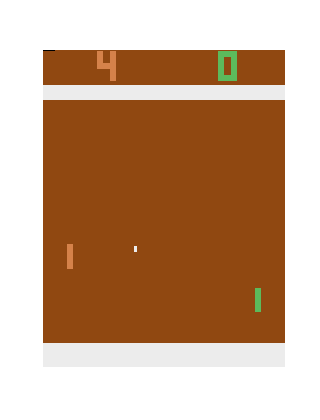
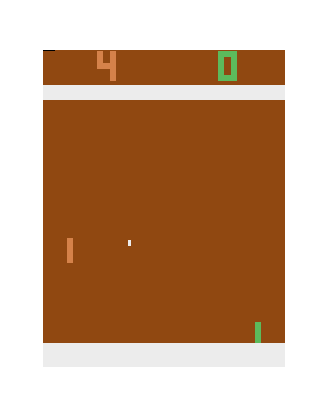
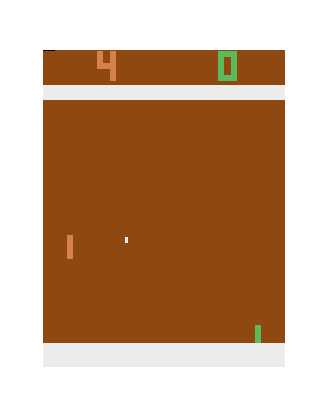
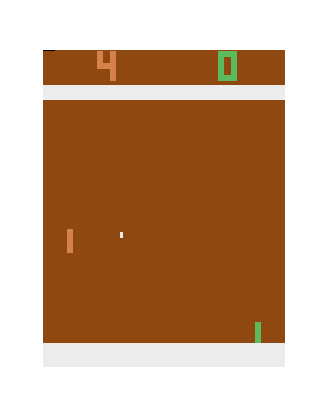
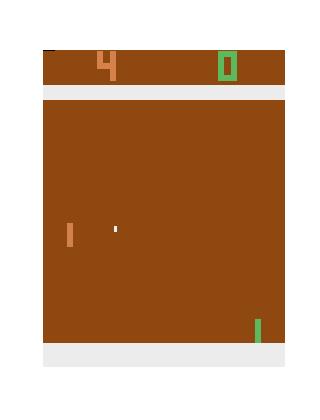
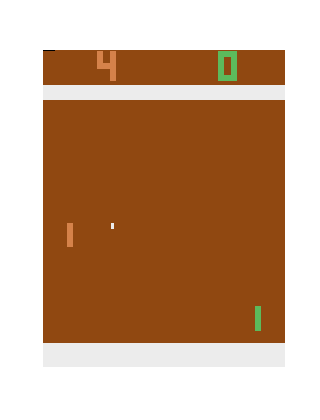
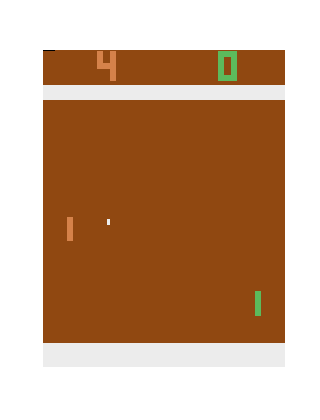
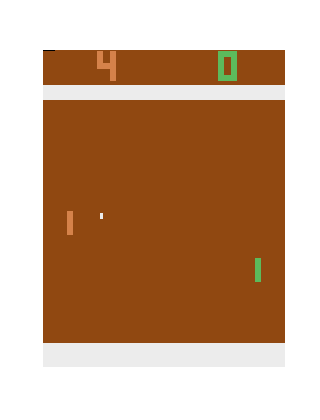
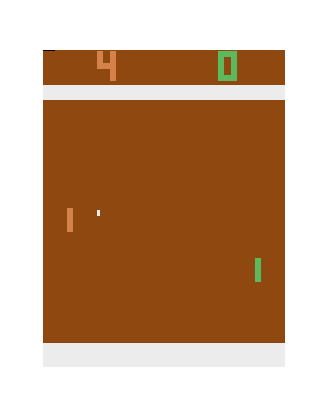
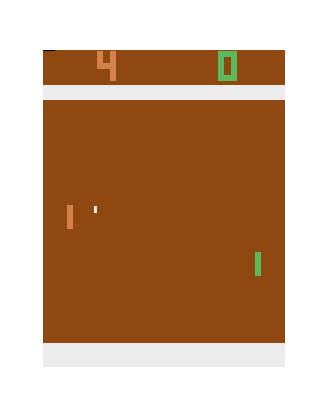
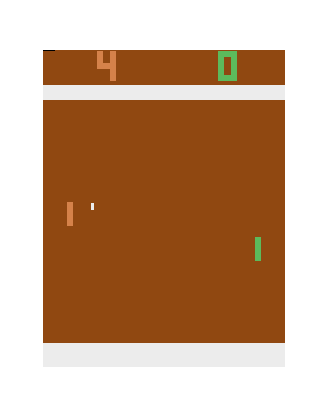
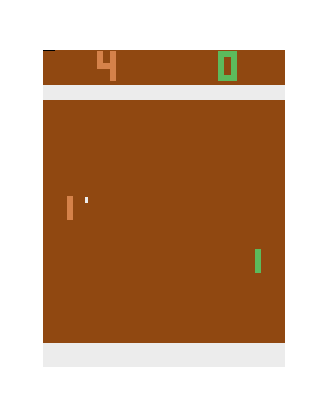
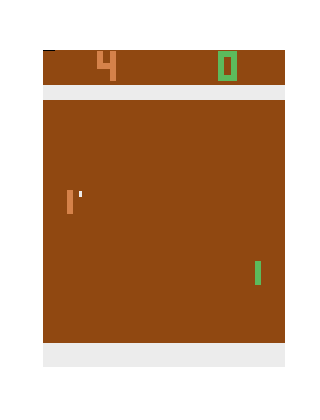
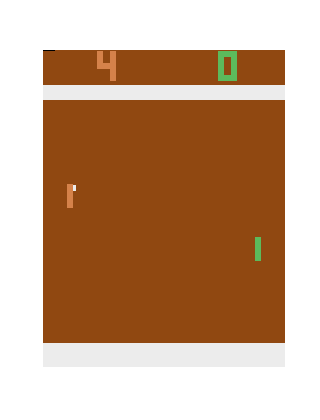
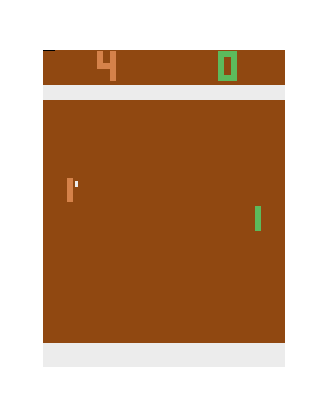
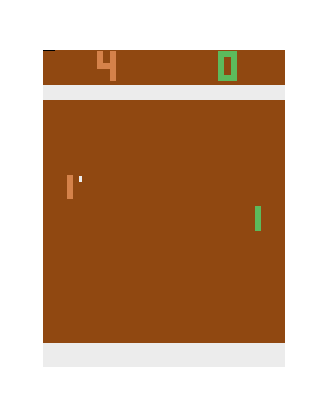
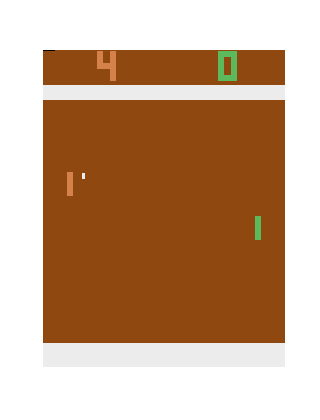
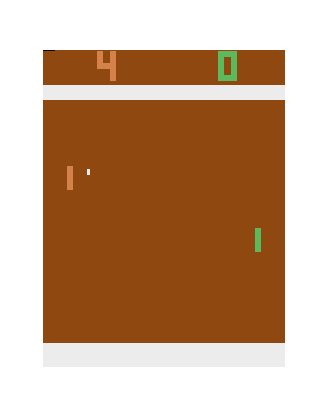
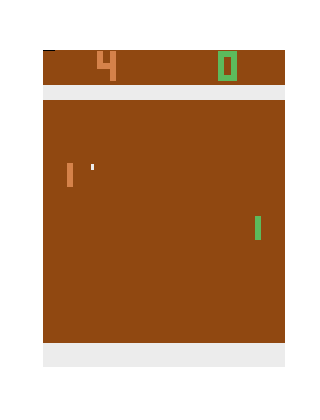
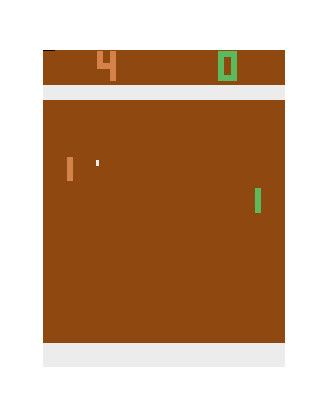
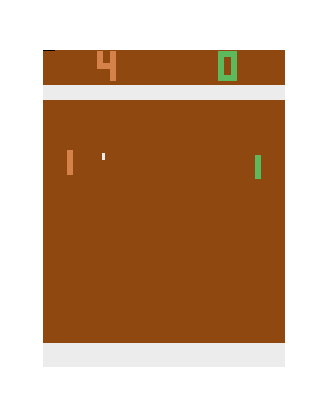
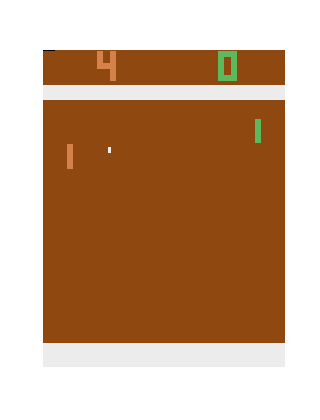
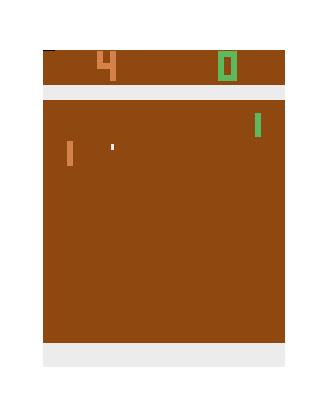
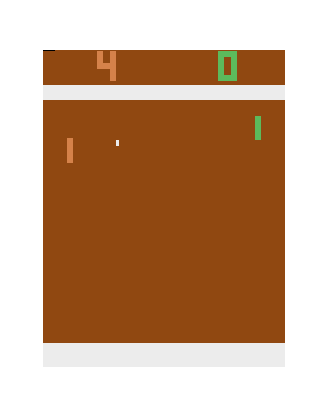
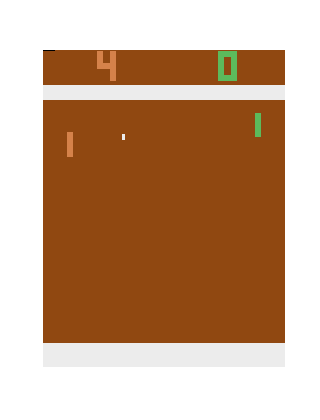
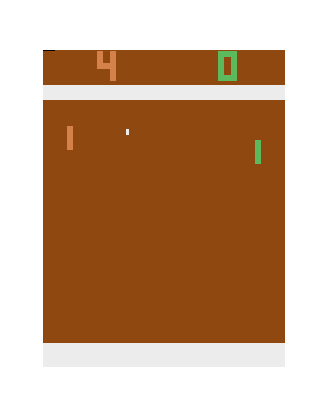
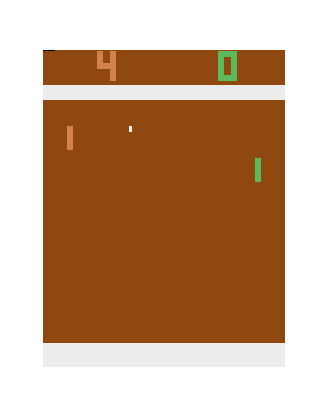
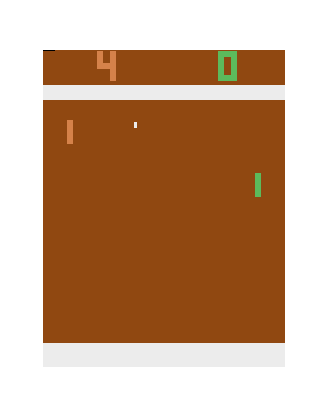
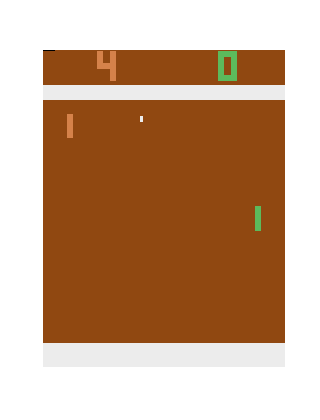
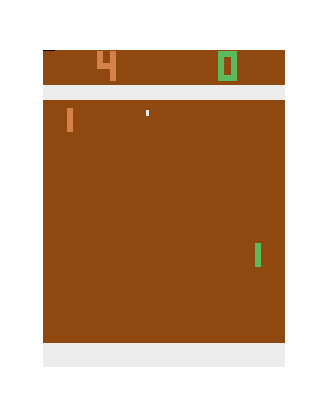
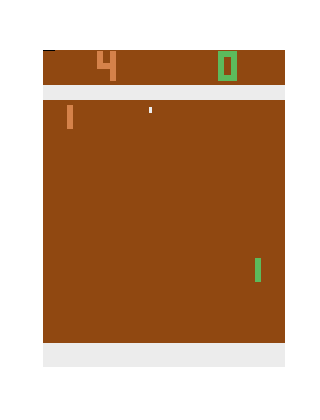
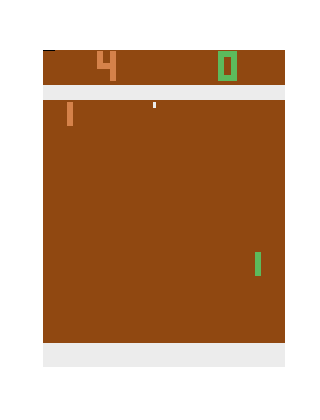
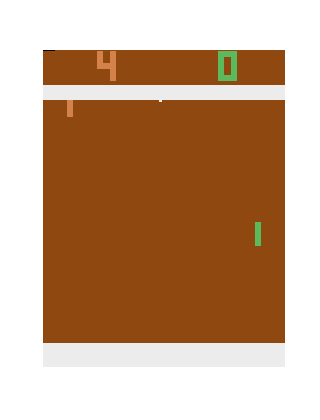
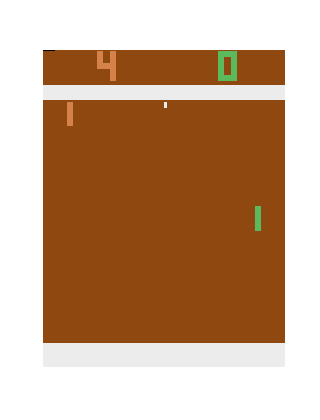
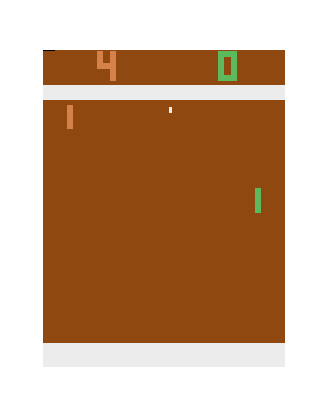
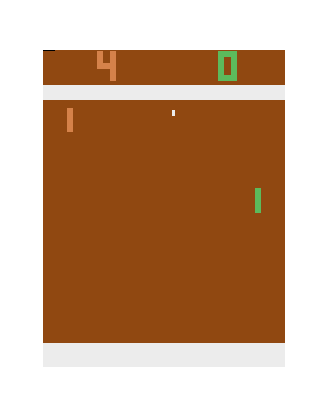
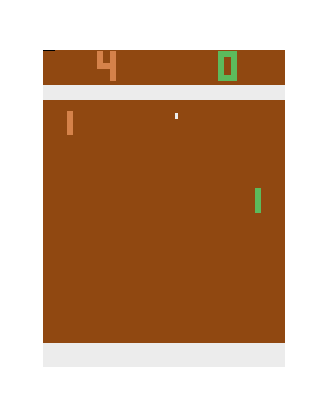
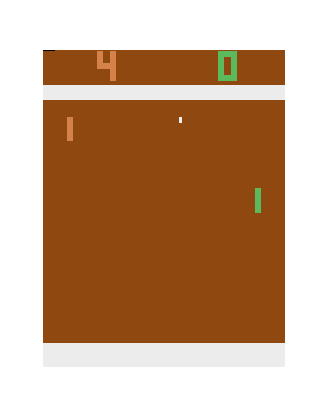
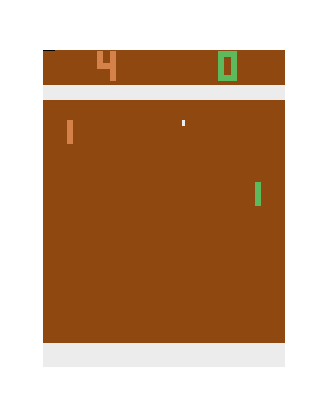
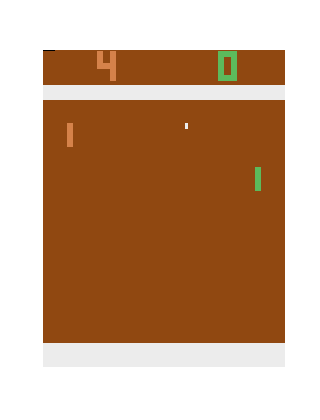
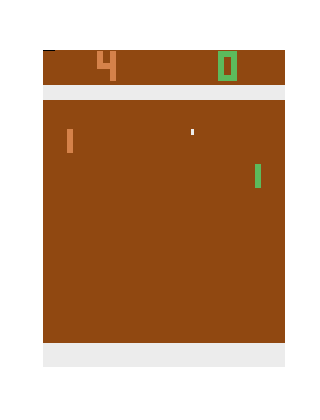
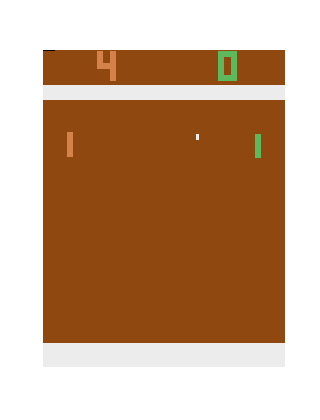
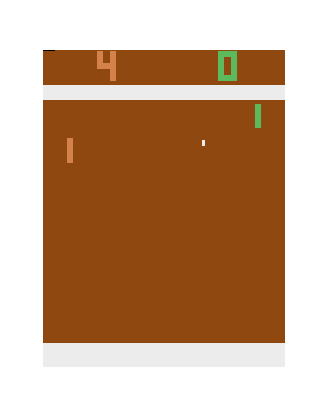
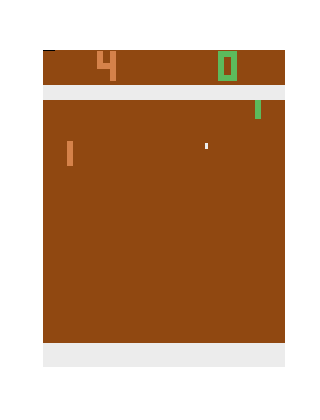
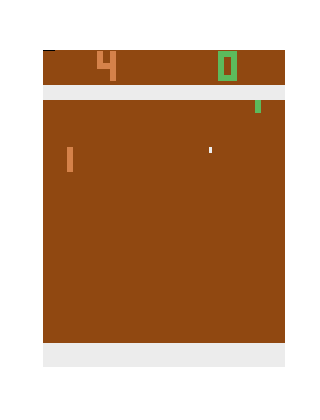
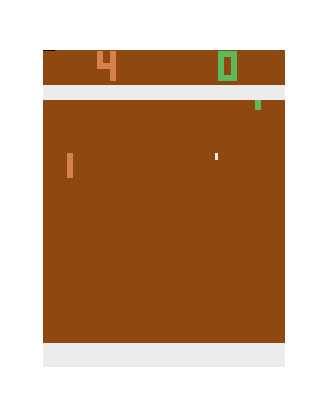
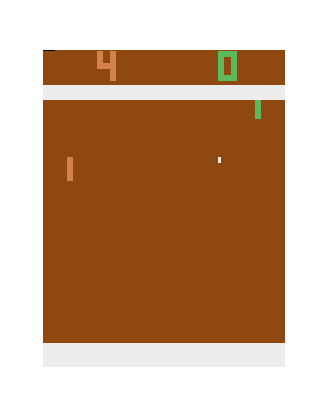
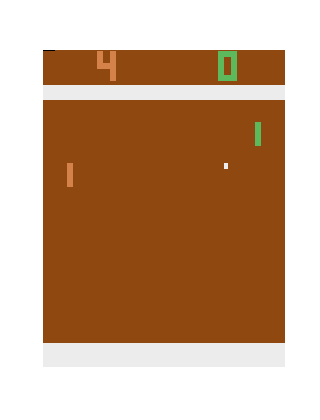
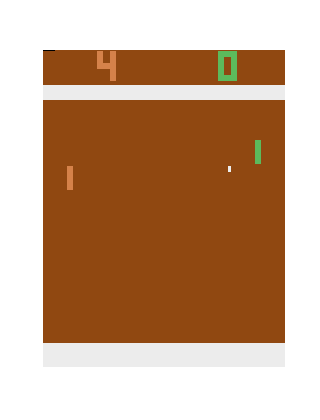
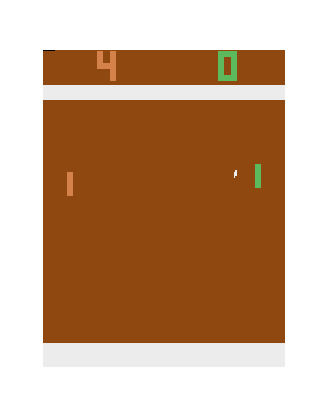
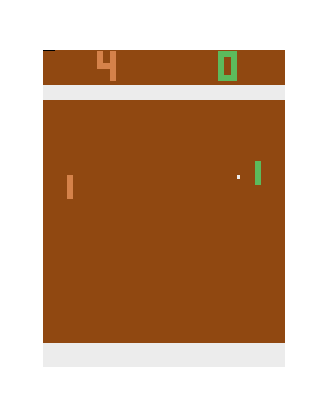
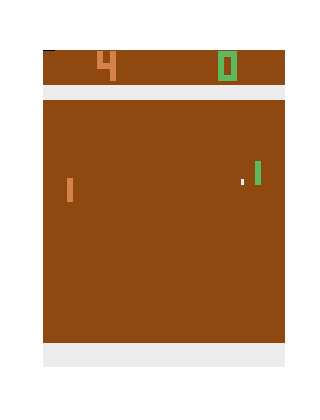
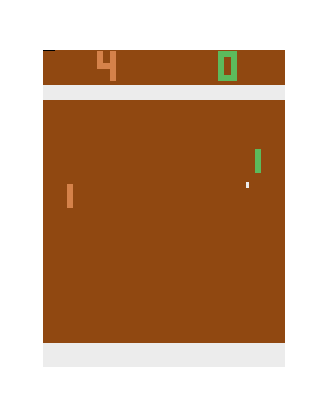
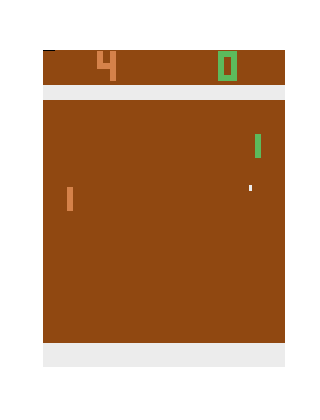
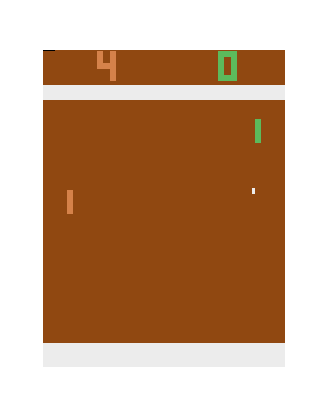
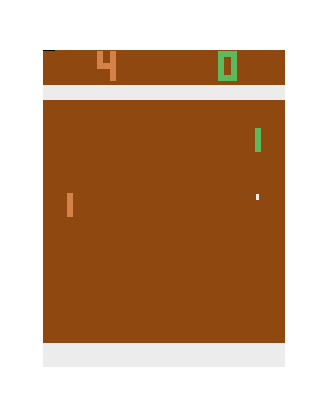
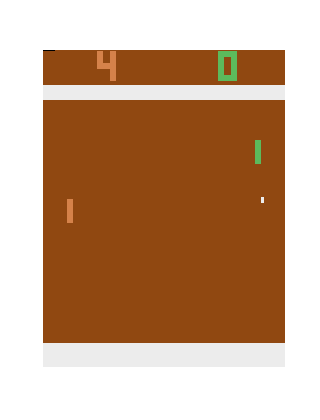
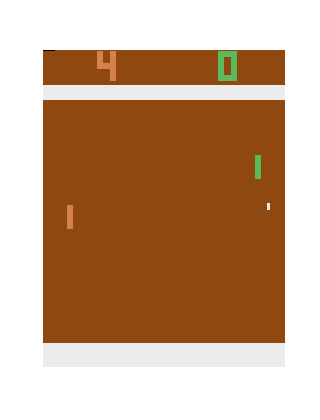
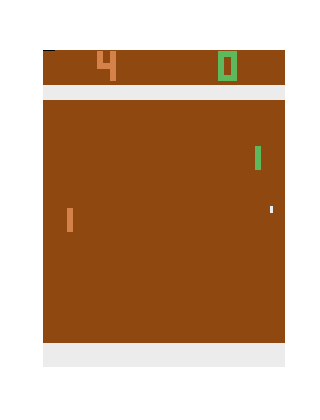
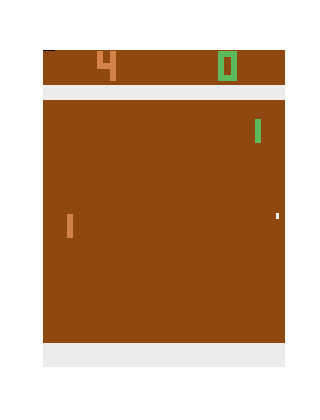
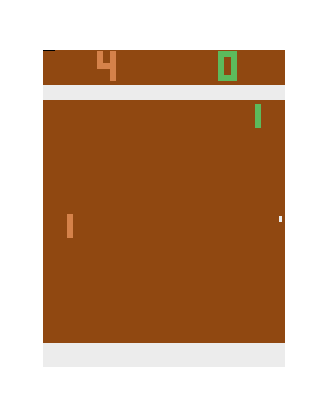
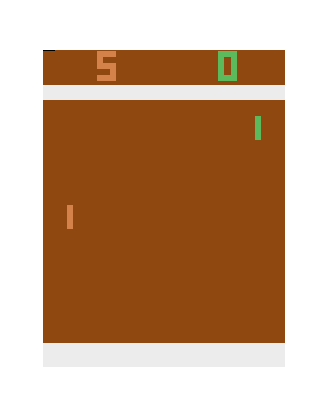
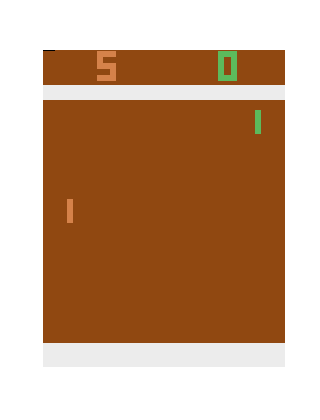
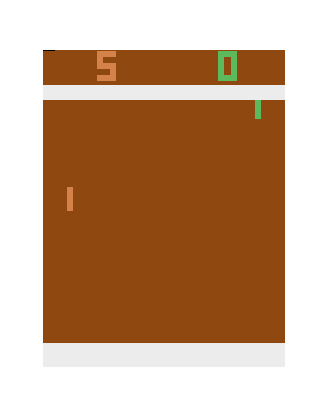
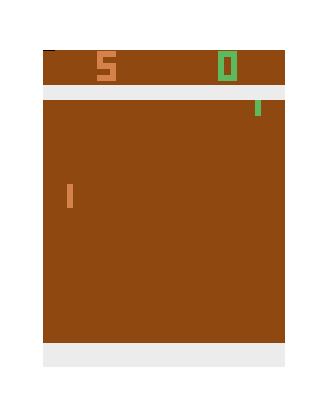
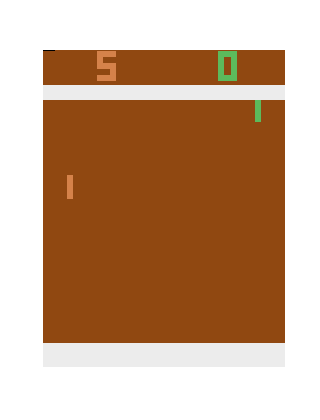
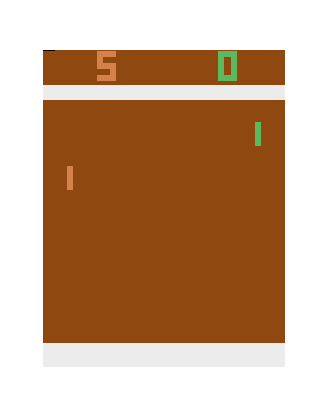
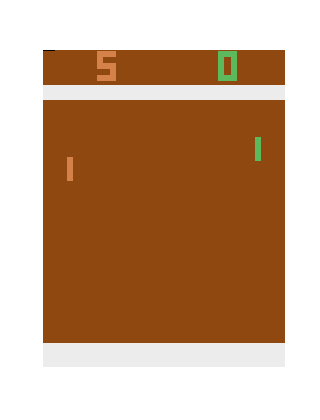
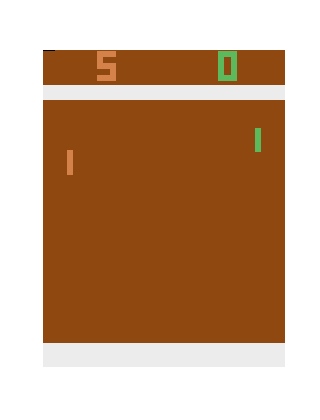
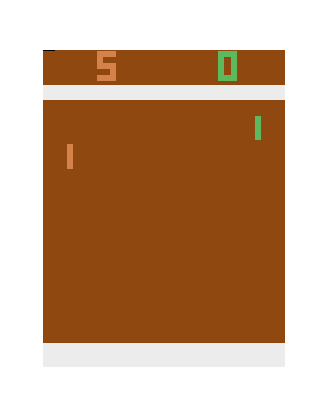
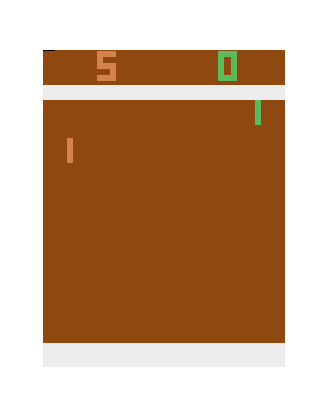
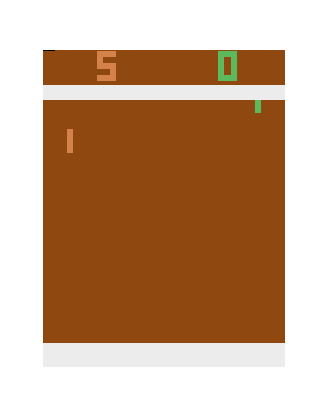
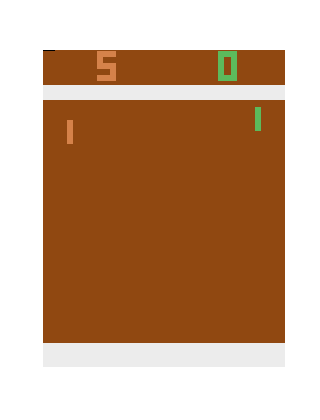
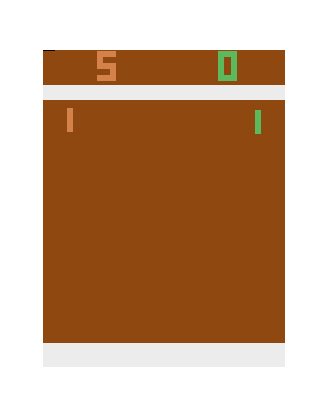
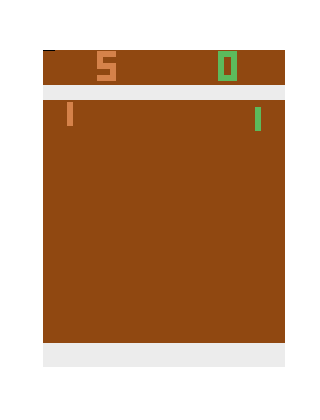
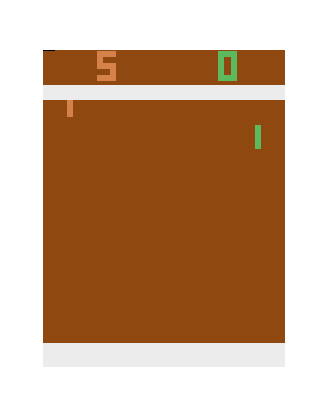
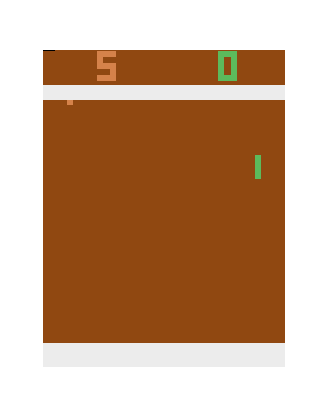
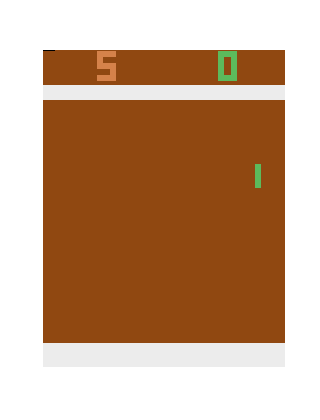
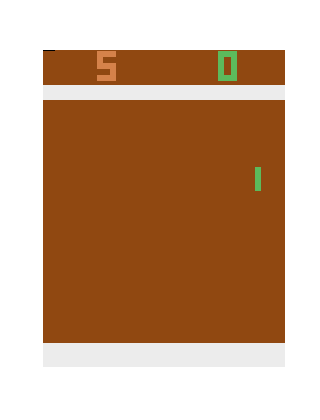
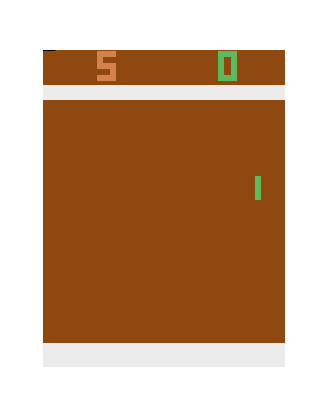
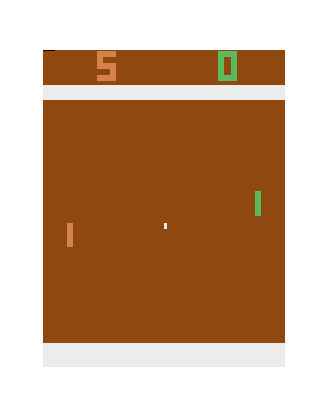
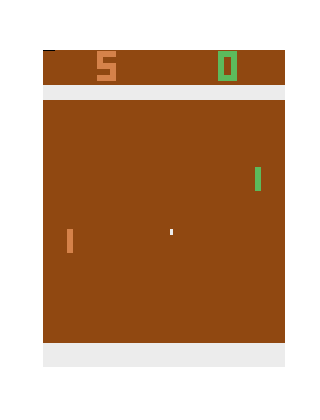
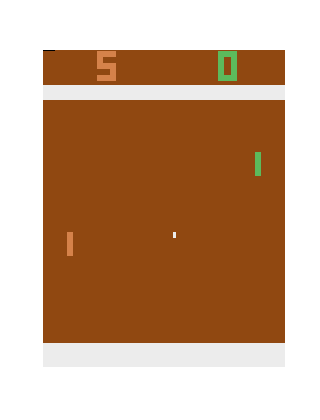
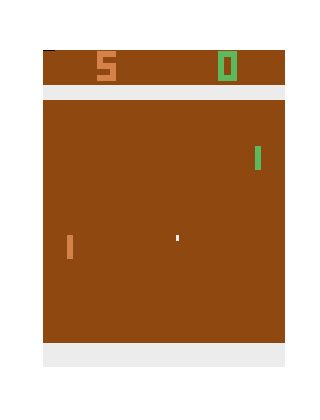
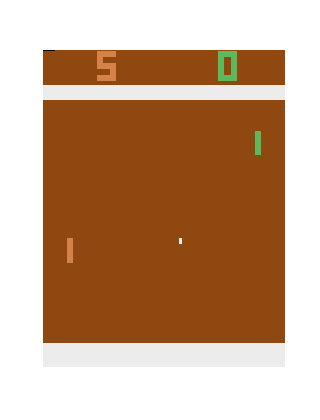

In [13]:
play_game(env, model)

In [0]:
%time hist2 = train_model(env, model, total_episodes=500)

In [0]:
play_game(env, model)

In [0]:
%time hist3 = train_model(env, model, total_episodes=1000)

In [0]:
play_game(env, model)

In [0]:
# import pickle
# pickle.dump(model, open('model.pkl', 'wb'))